# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


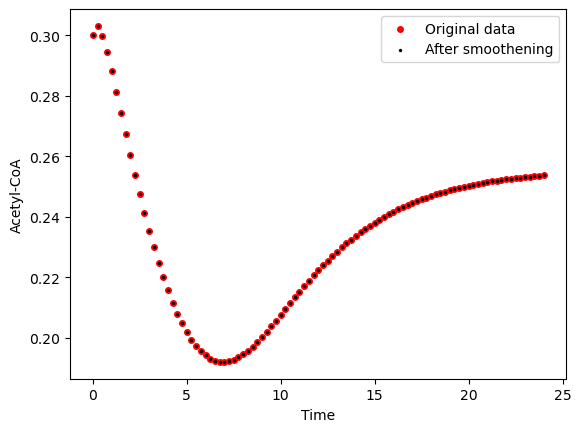

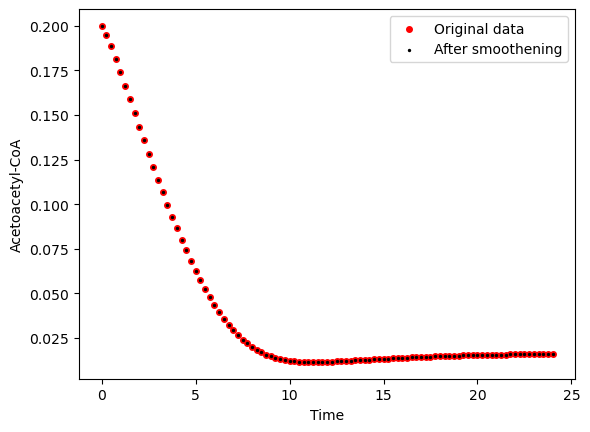

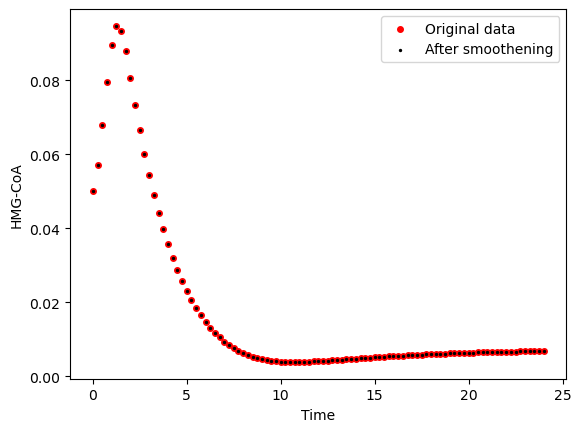

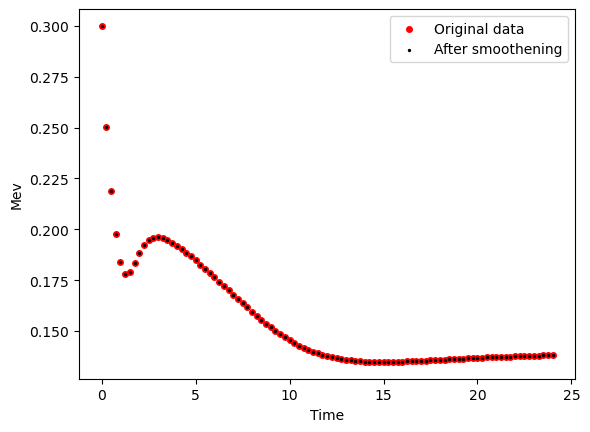

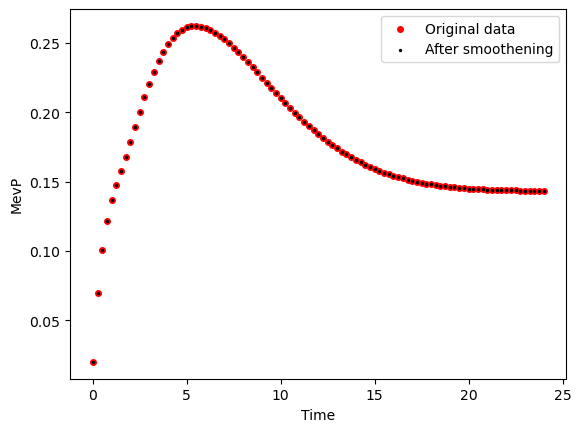

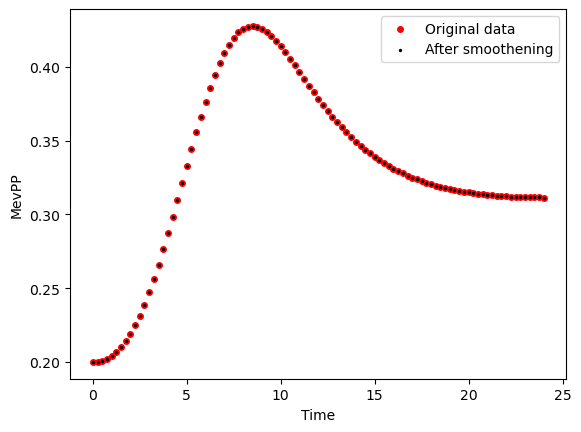

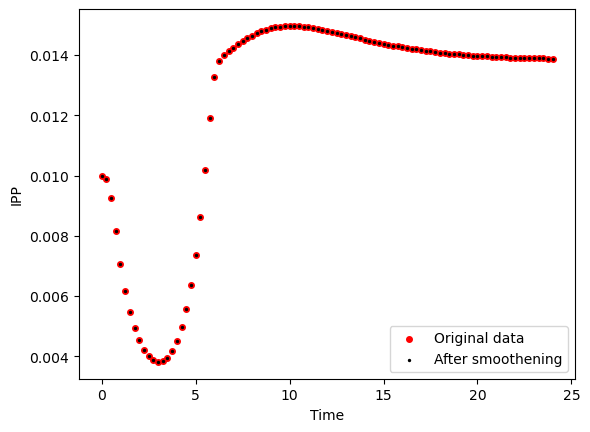

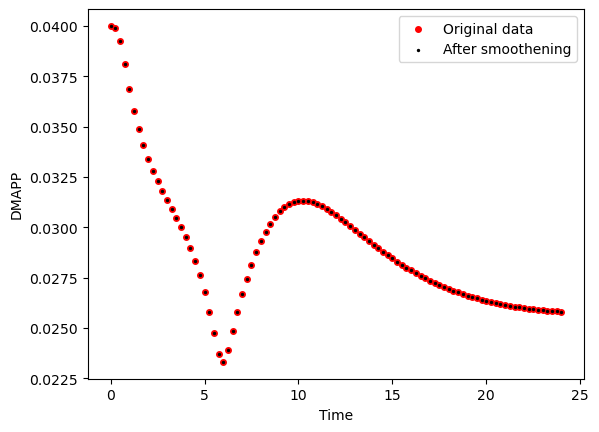

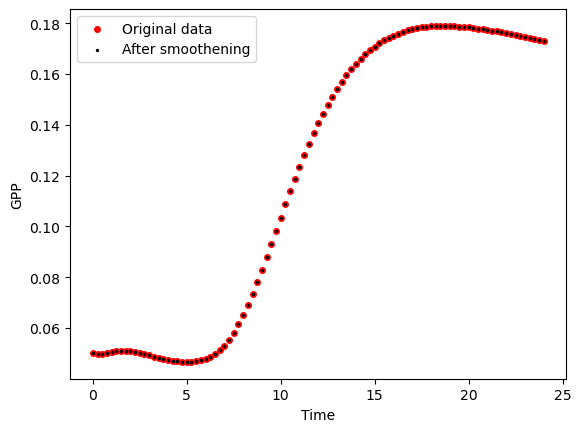

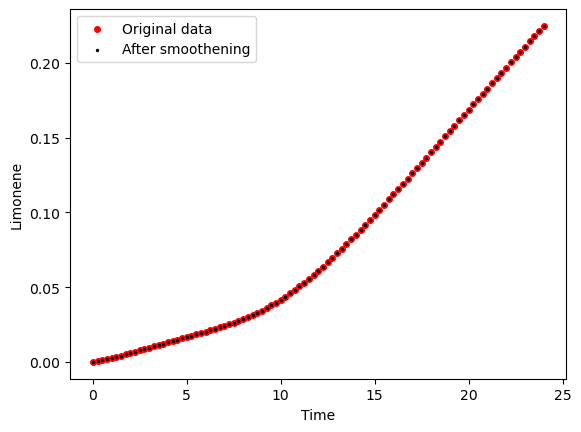

Strain Strain 2


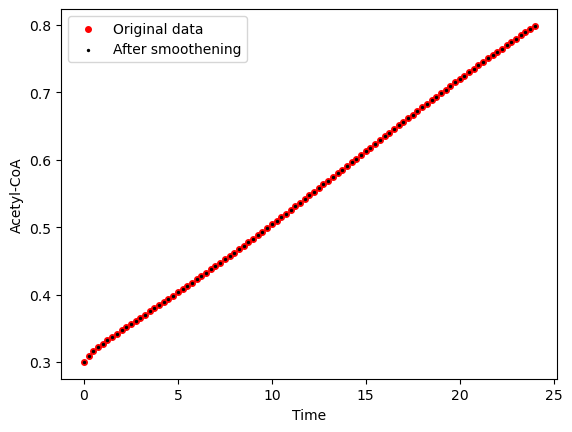

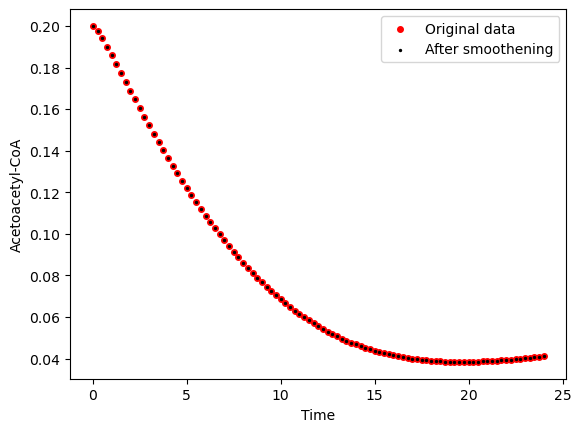

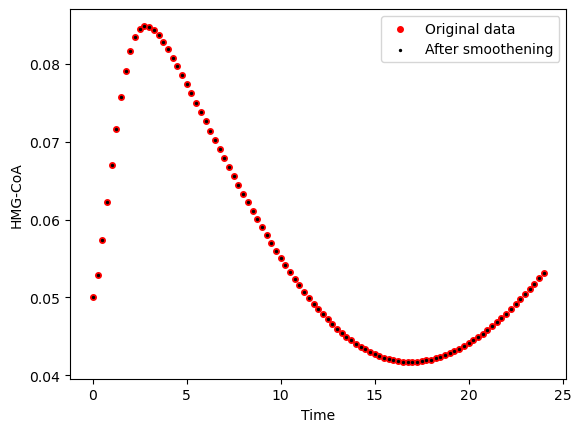

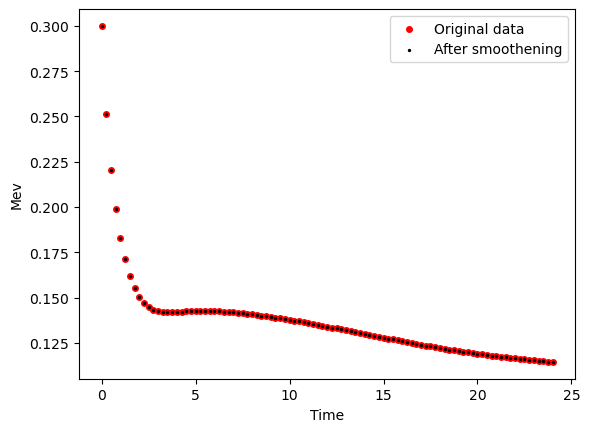

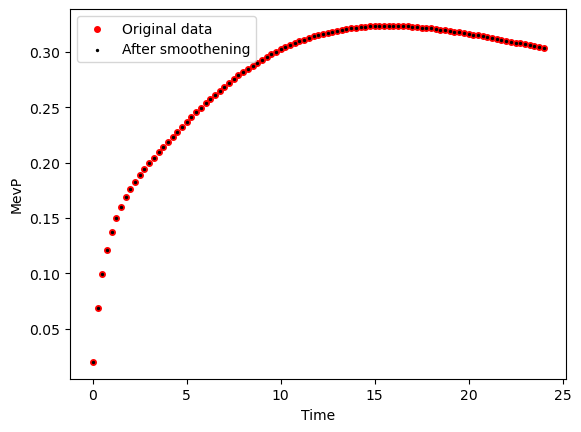

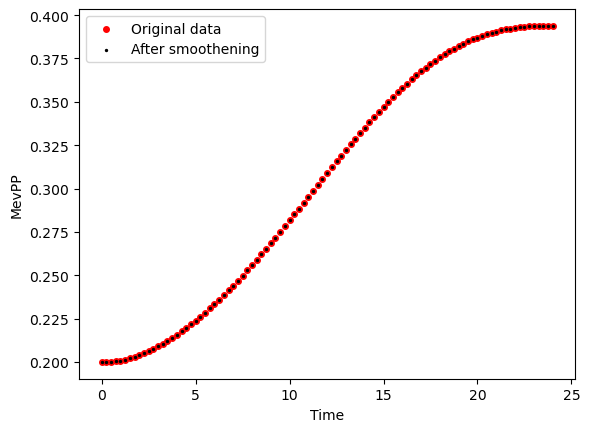

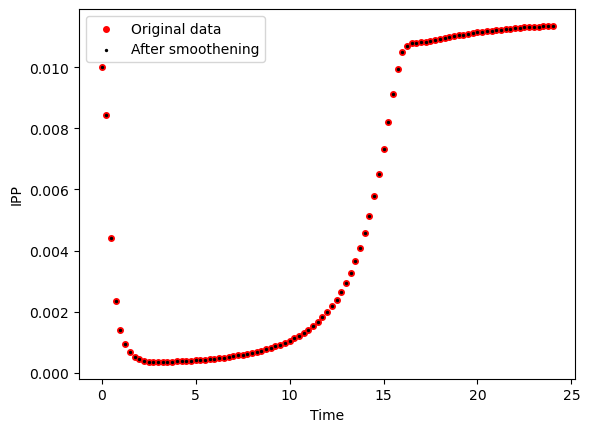

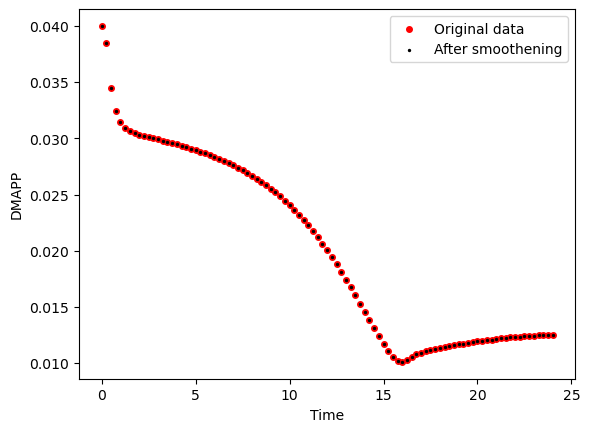

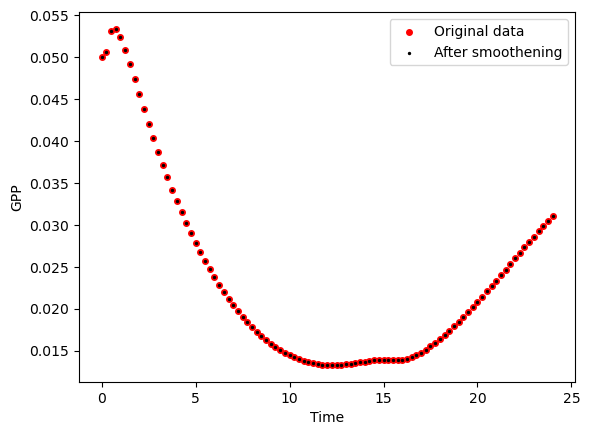

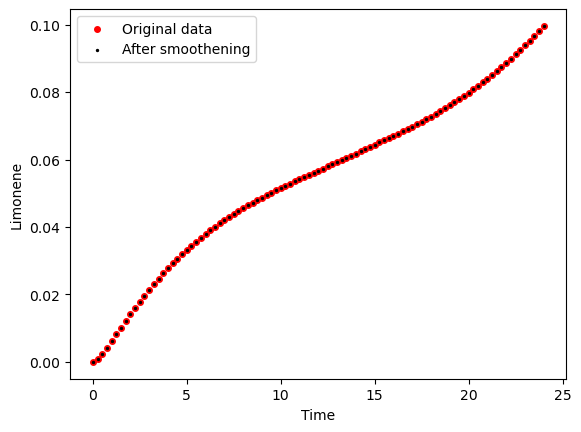

Strain Strain 3


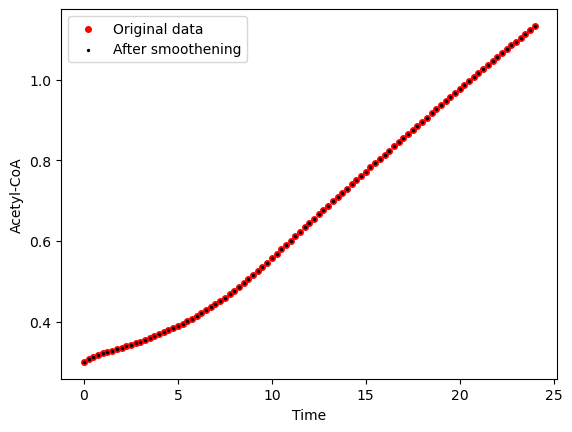

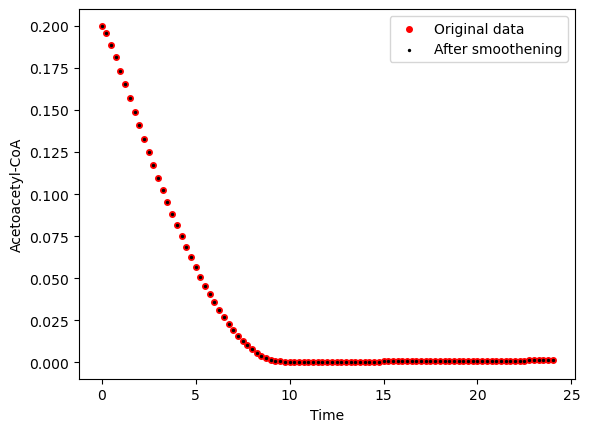

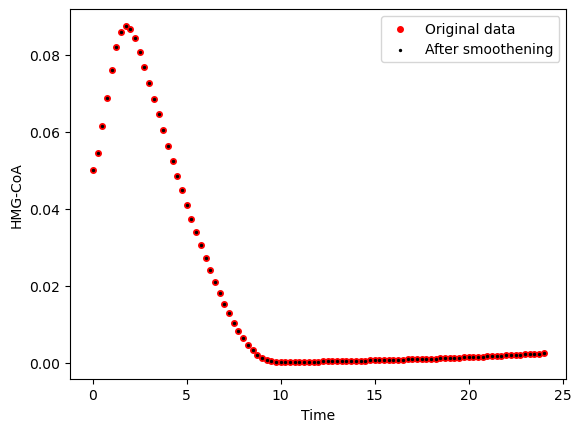

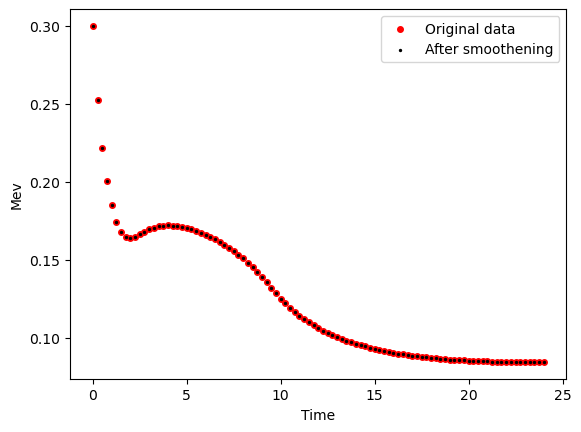

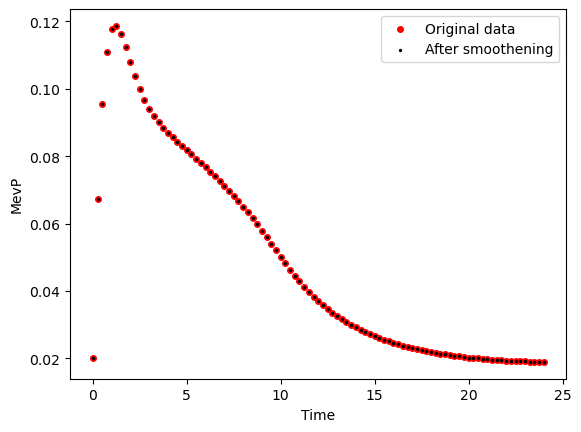

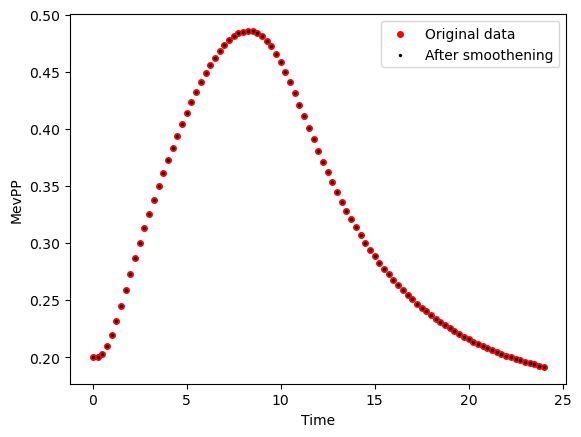

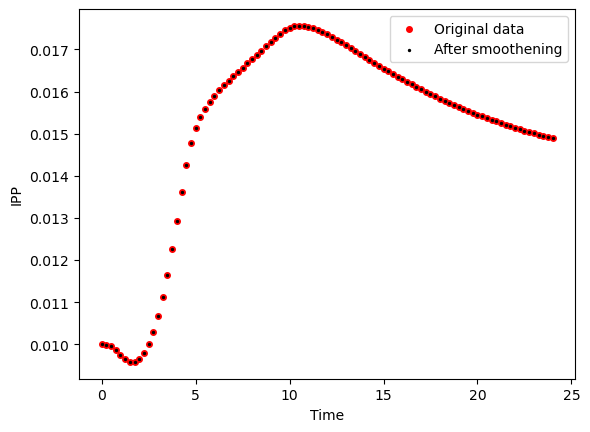

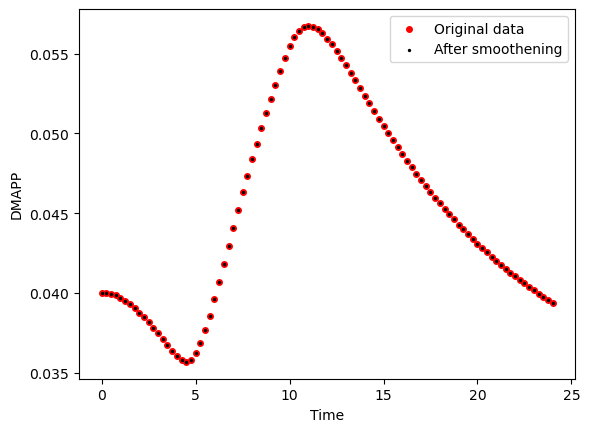

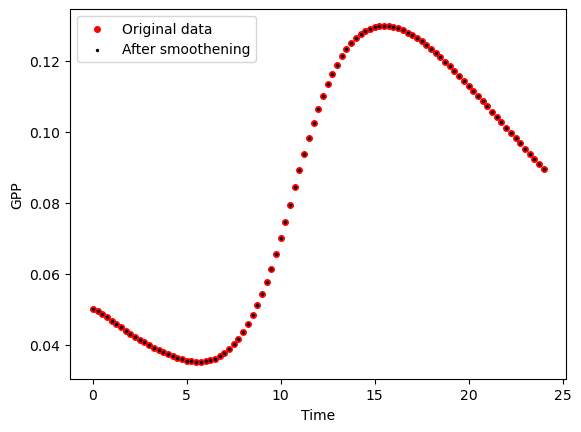

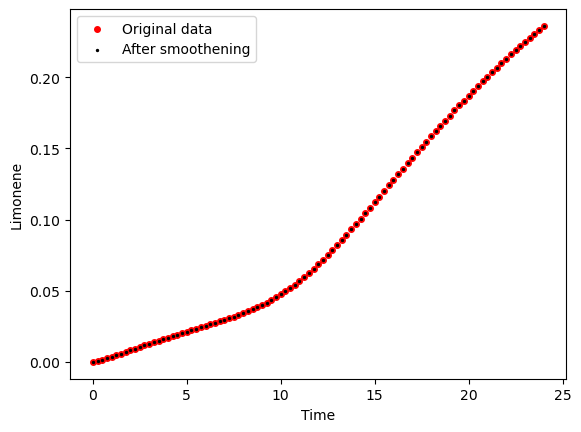

Strain WT


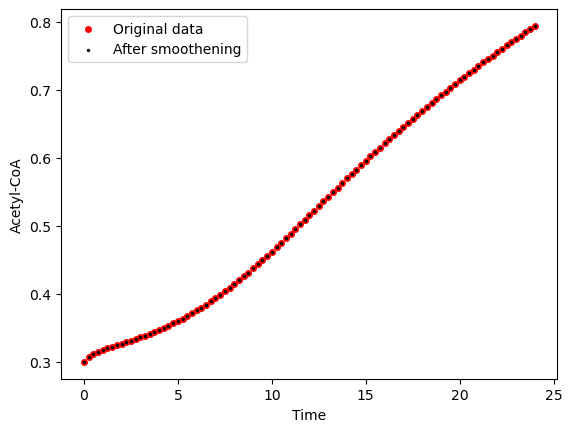

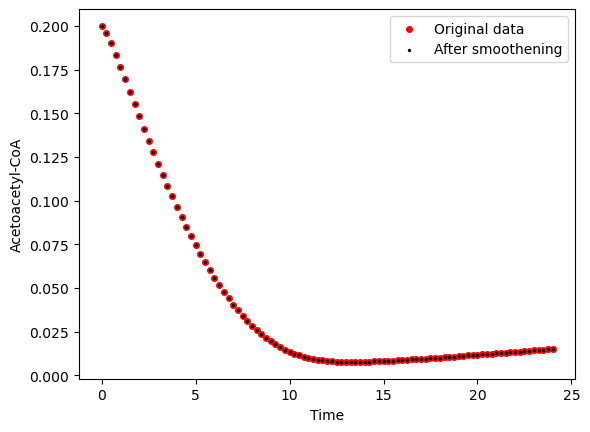

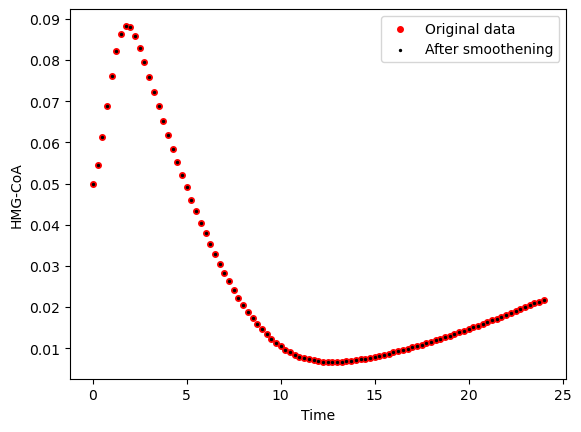

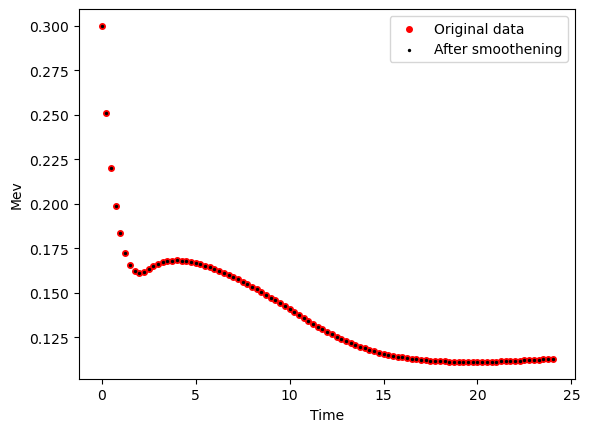

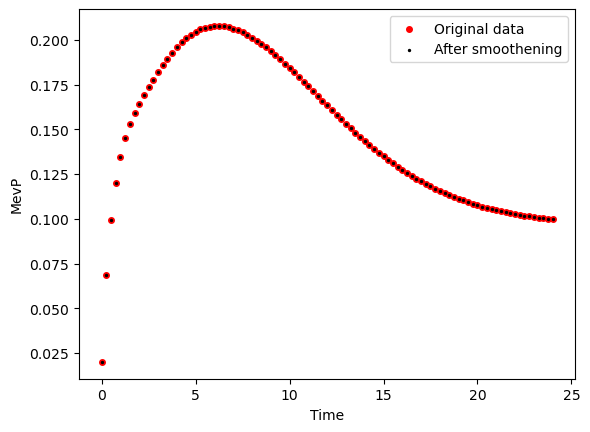

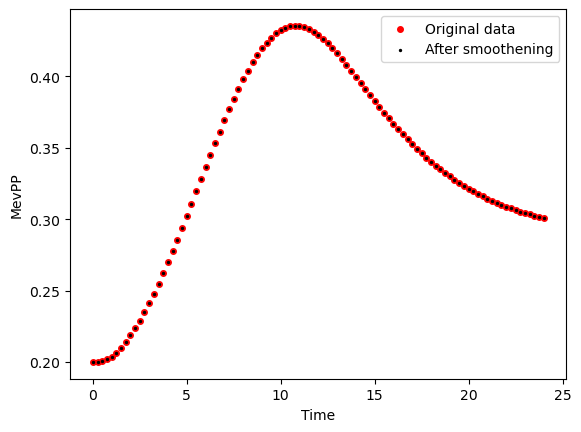

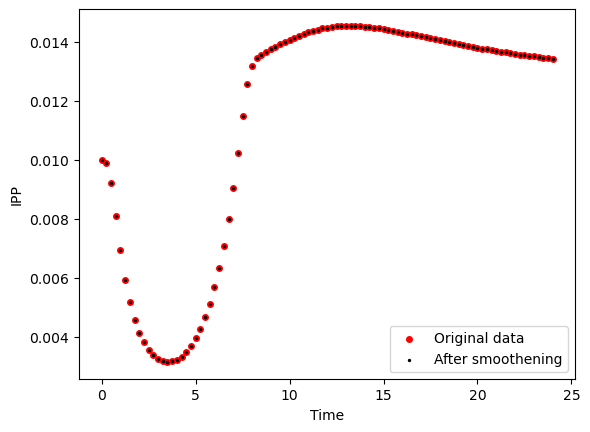

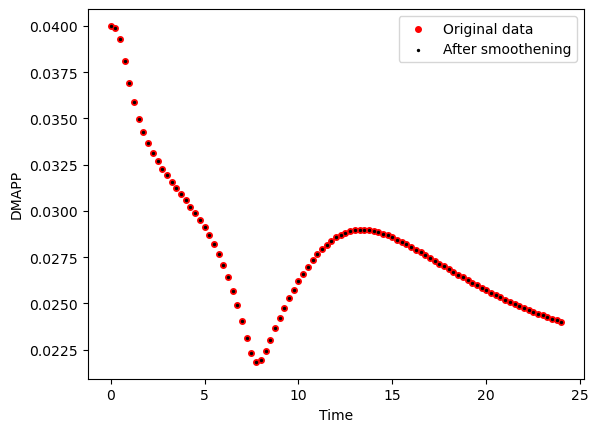

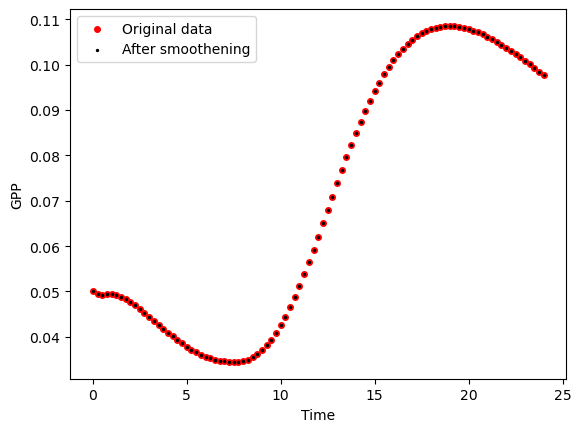

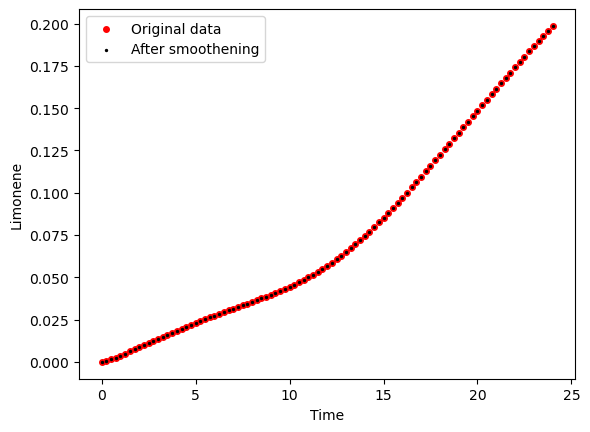

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


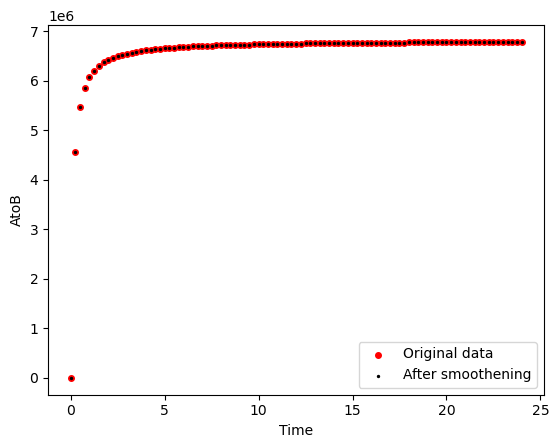

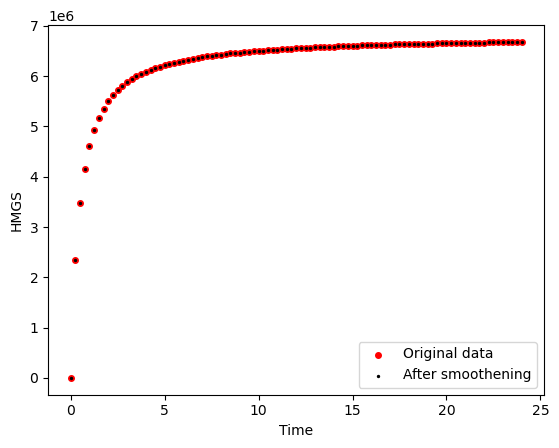

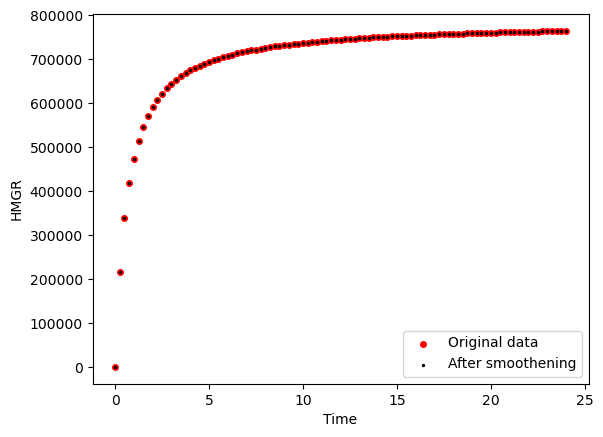

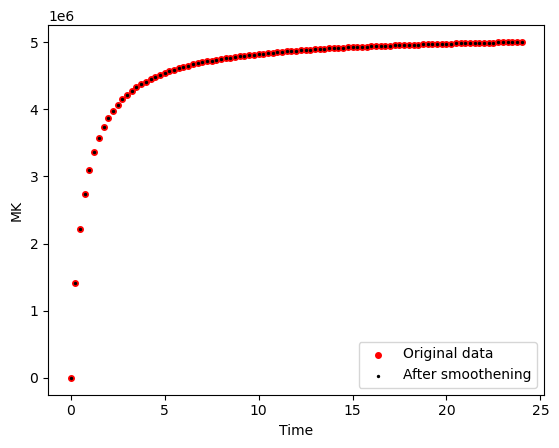

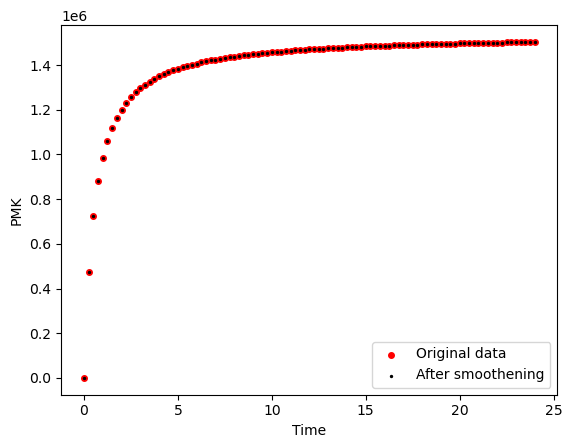

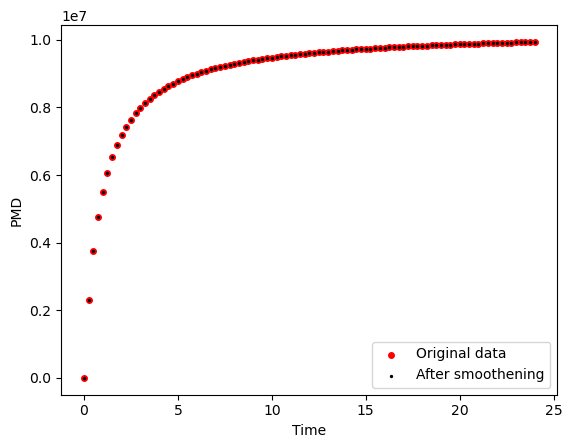

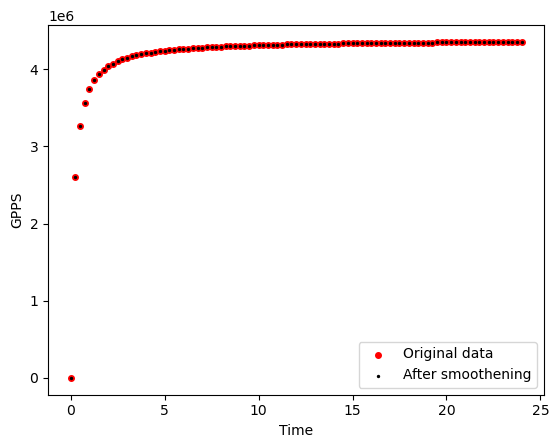

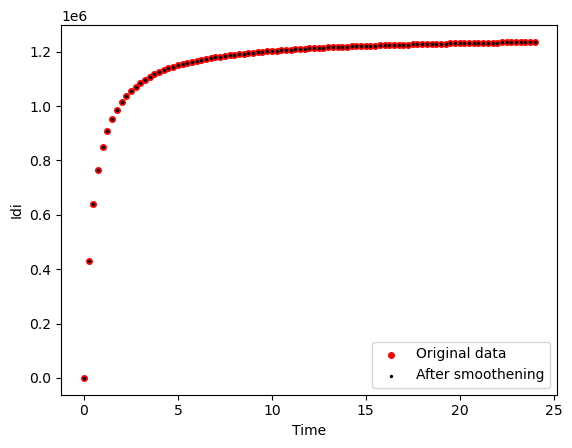

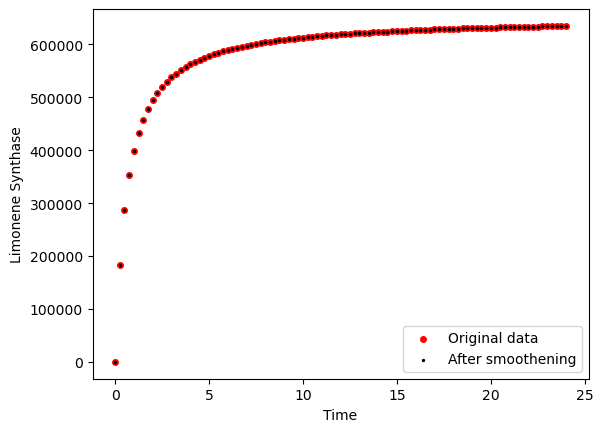

Strain Strain 2


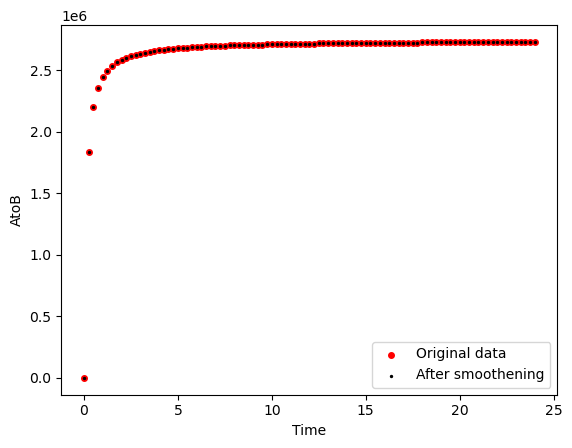

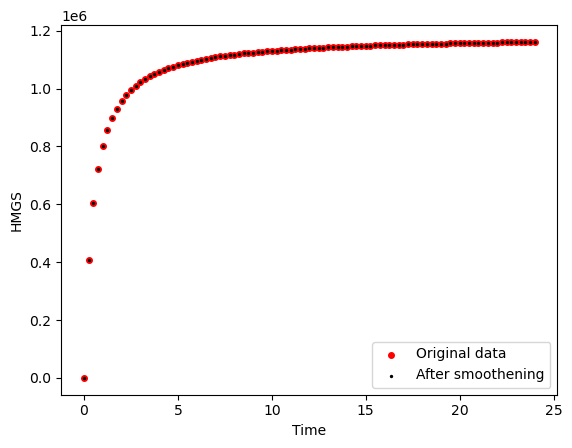

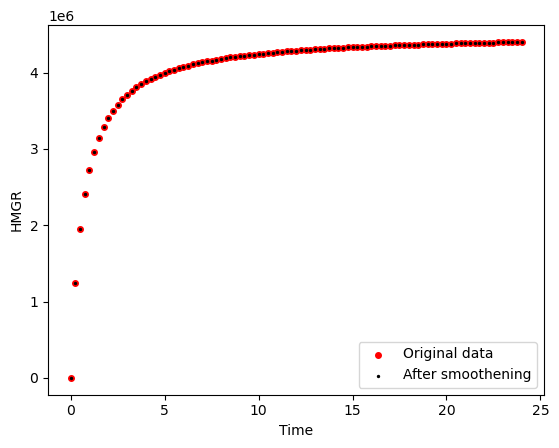

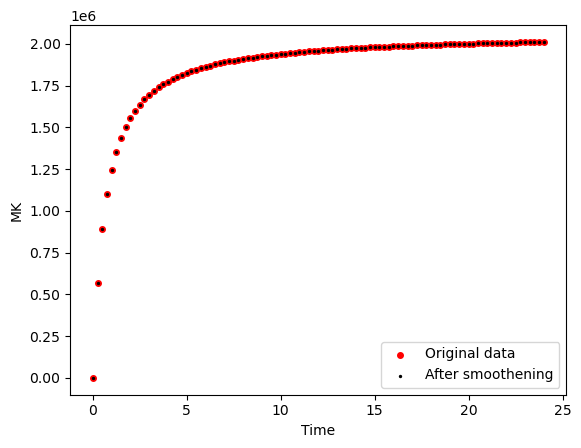

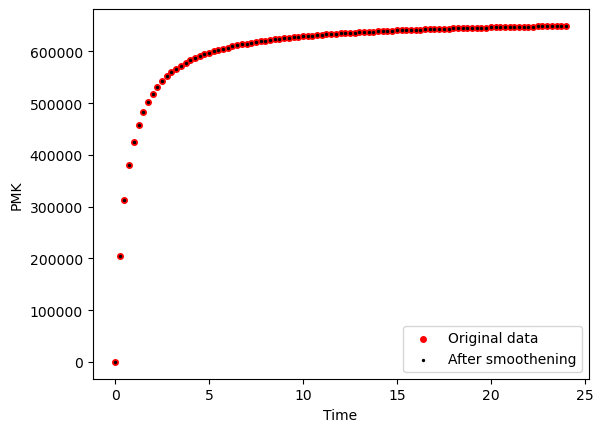

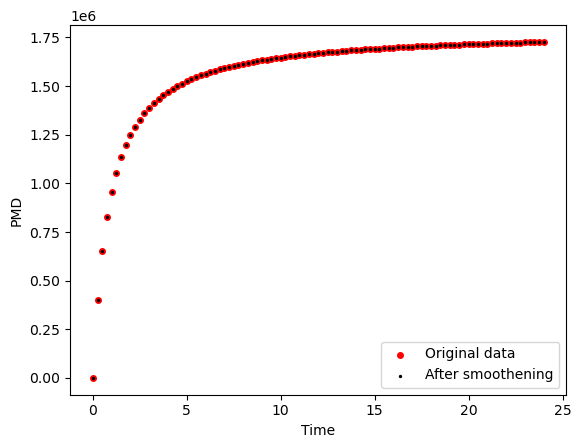

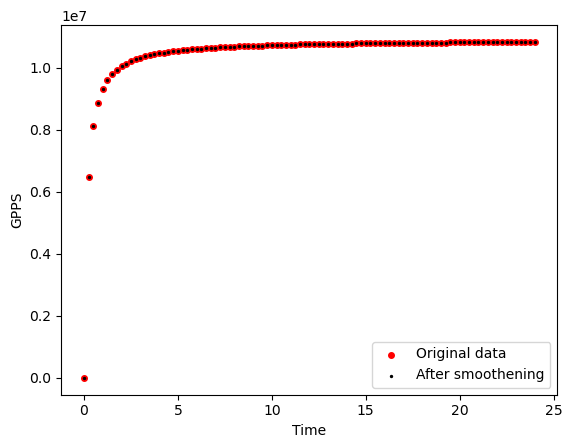

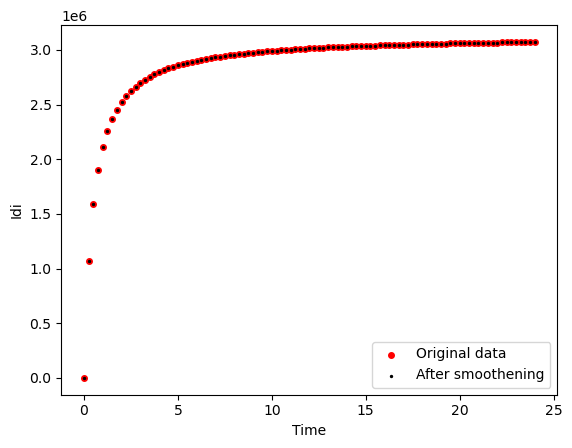

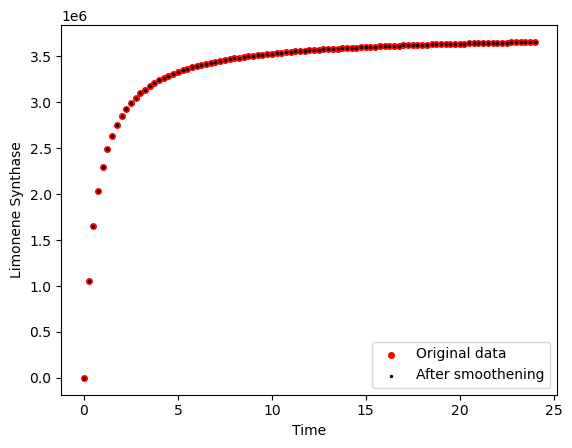

Strain Strain 3


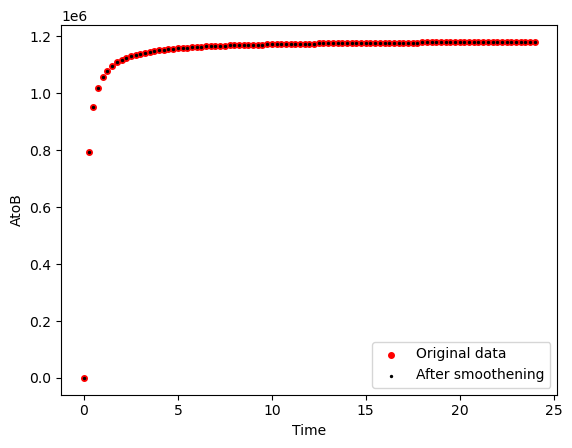

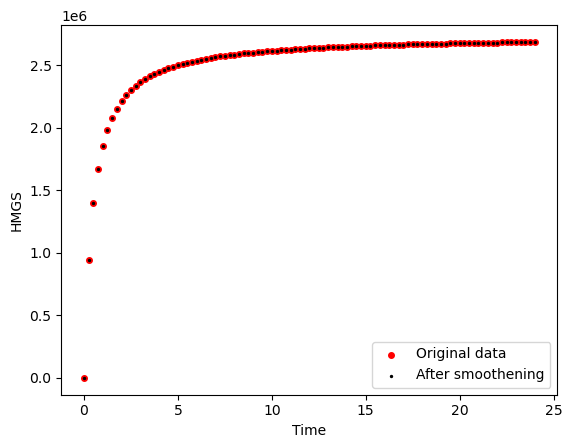

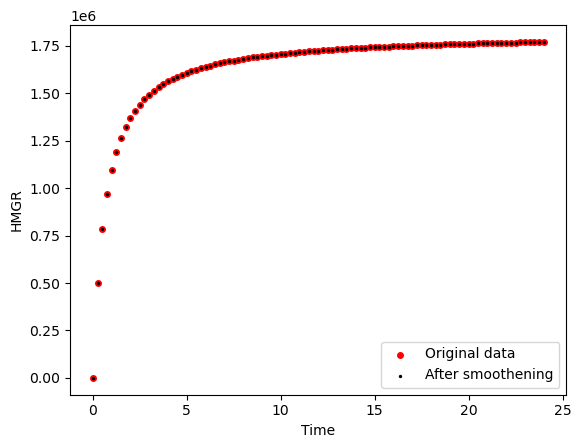

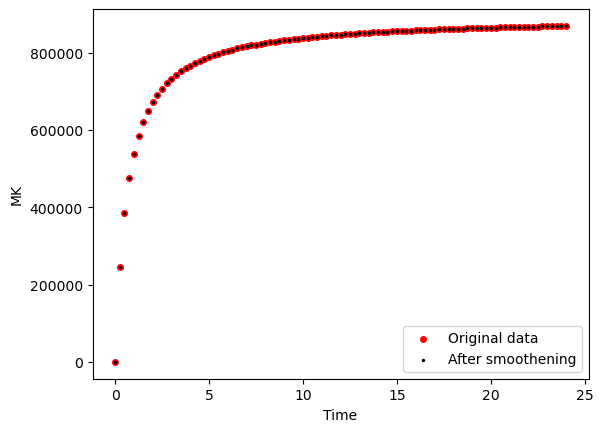

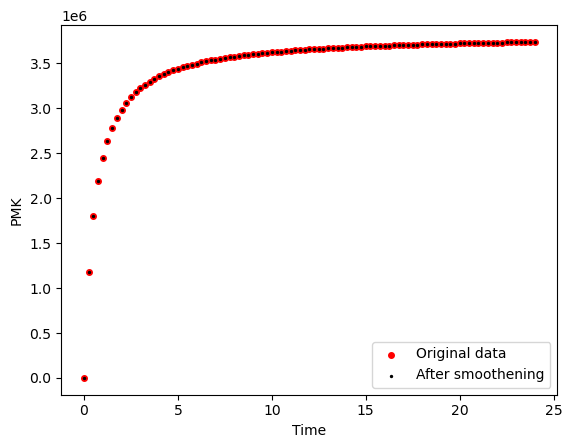

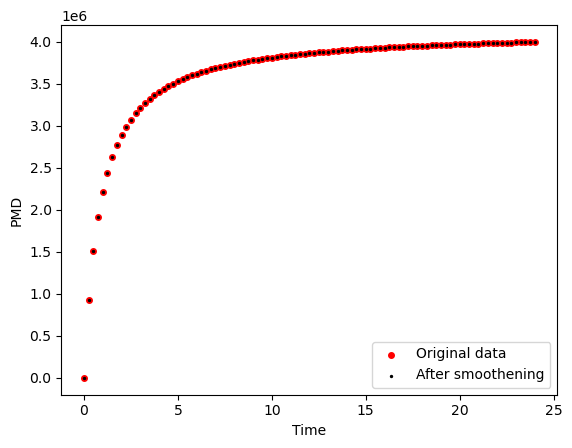

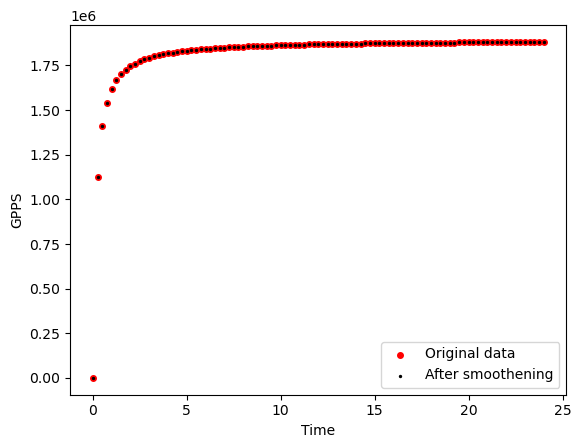

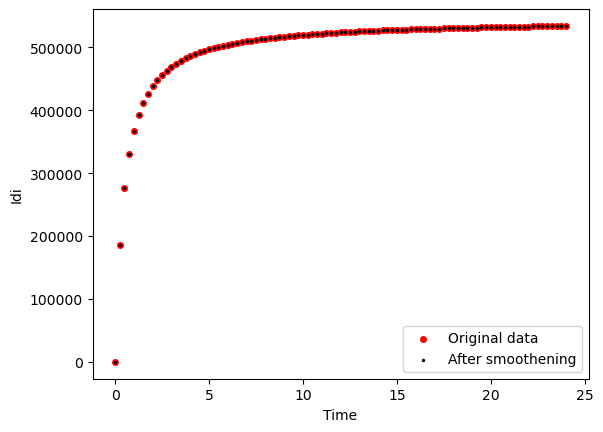

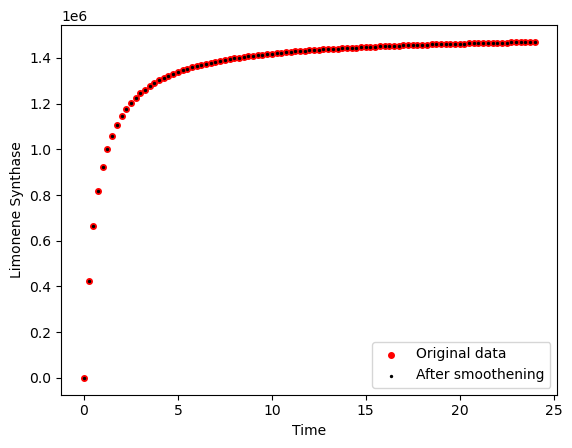

Strain WT


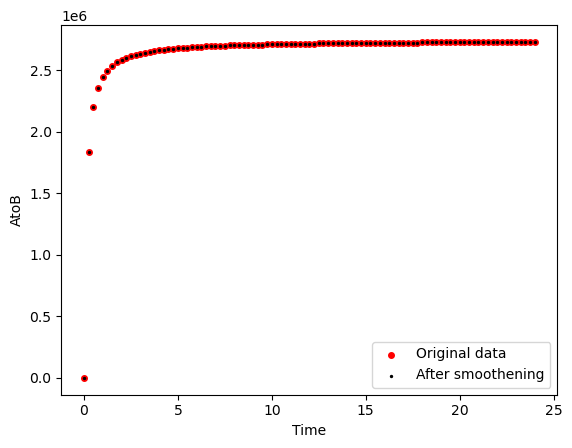

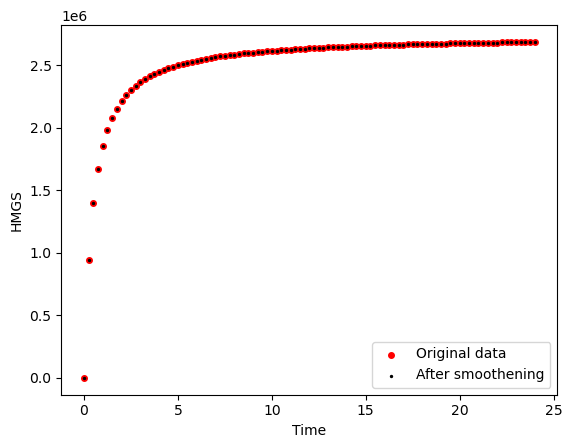

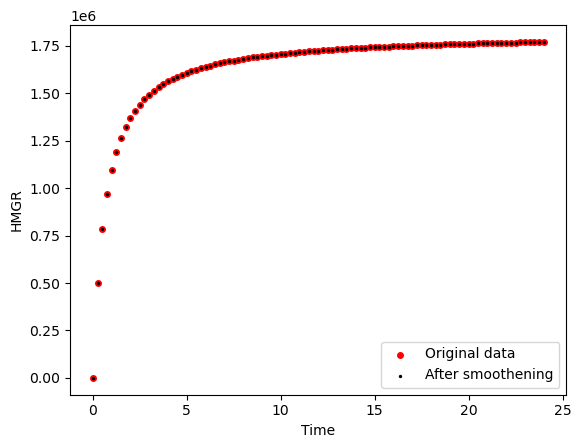

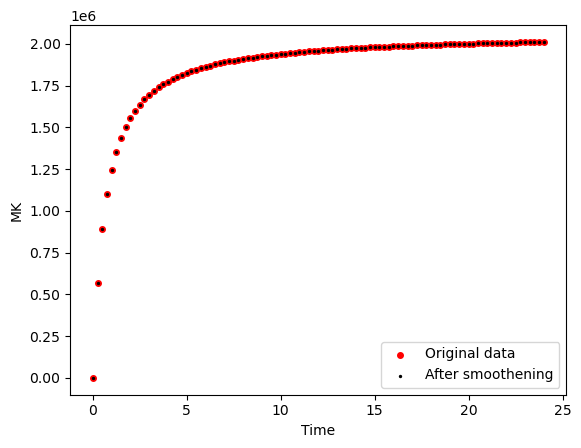

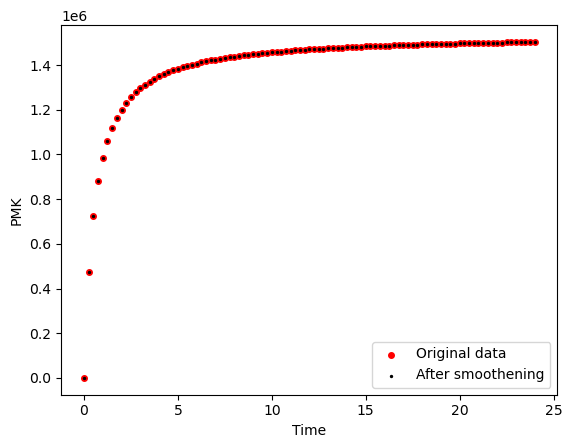

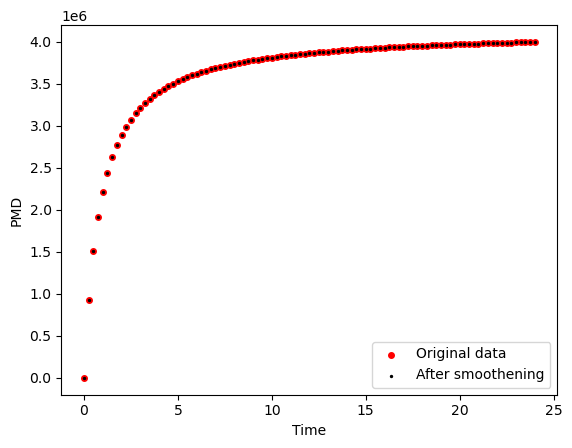

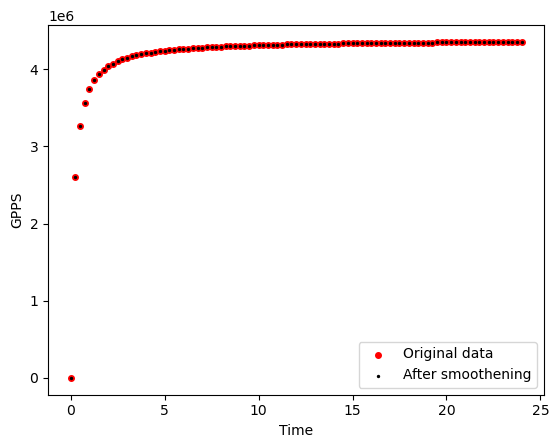

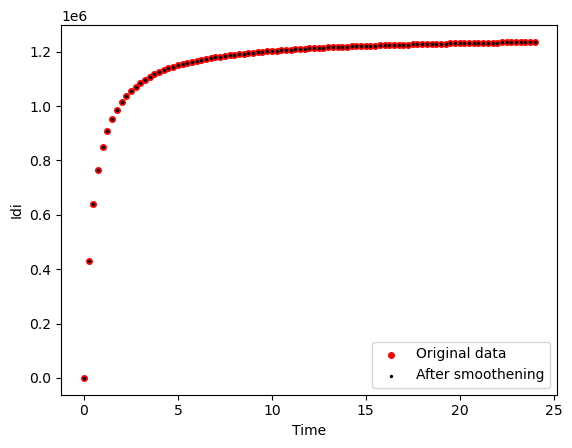

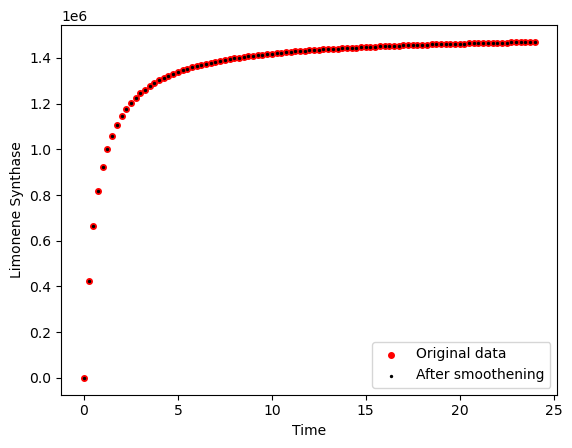

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

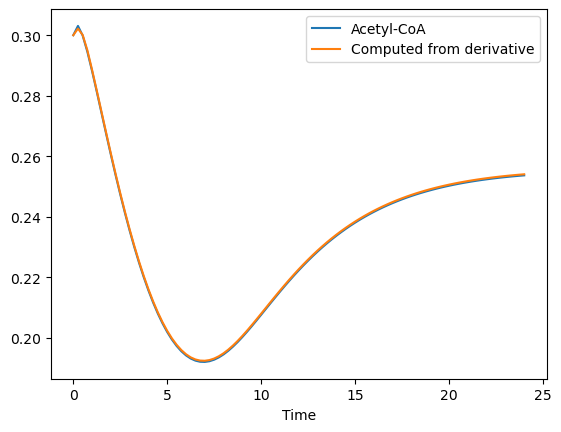

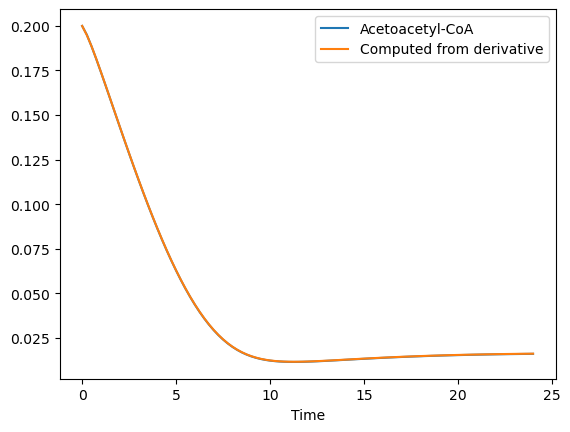

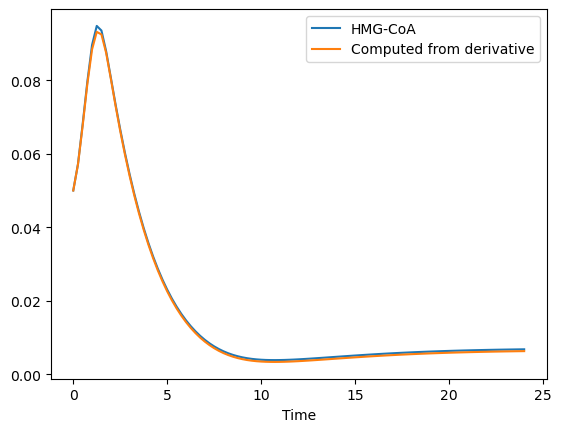

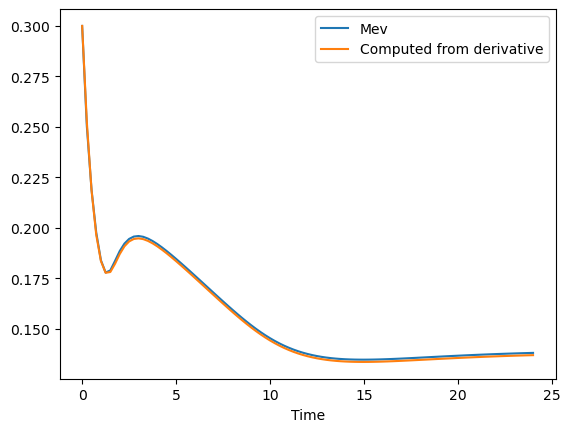

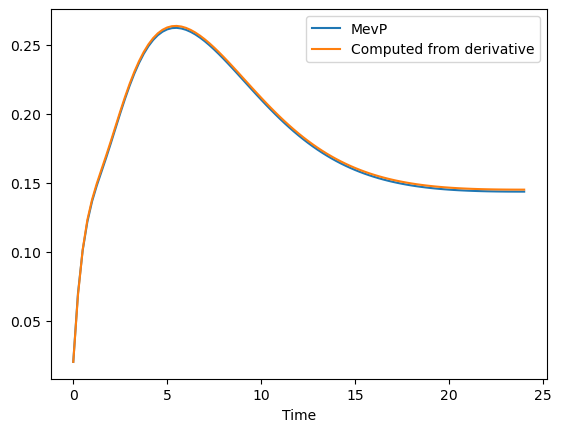

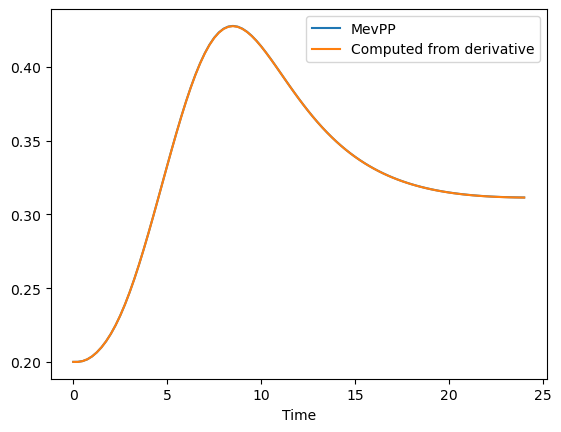

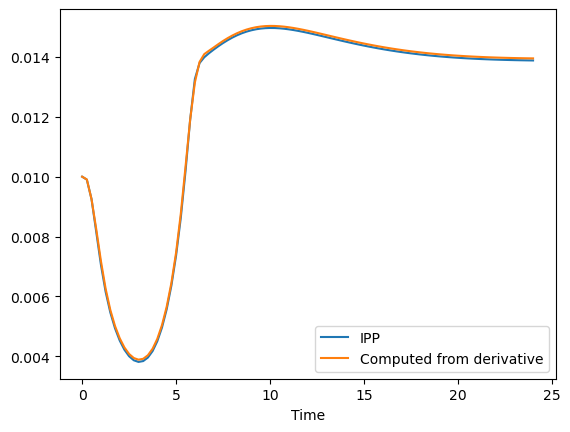

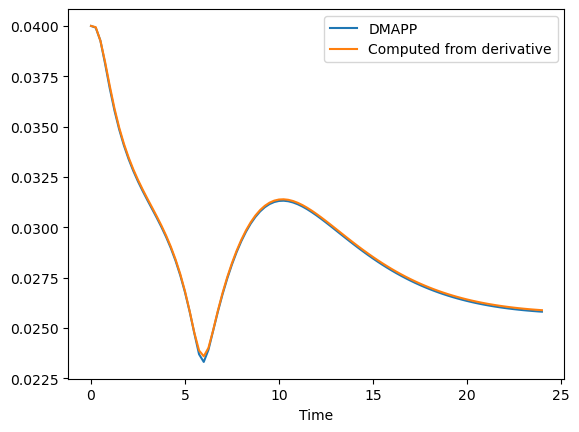

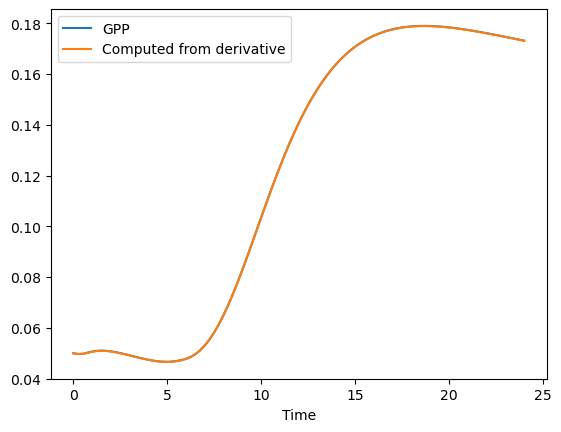

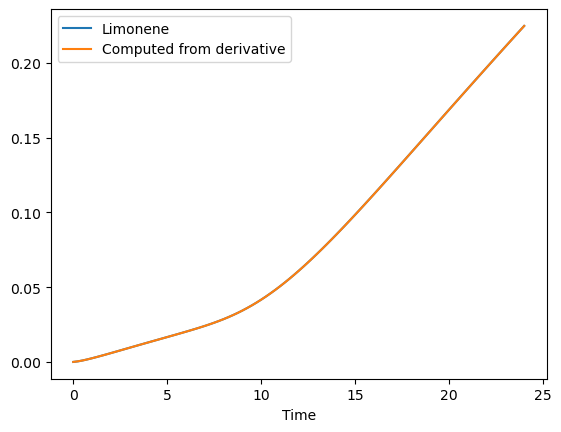

'Time profile from derivative vs. actual profile for Strain 2'

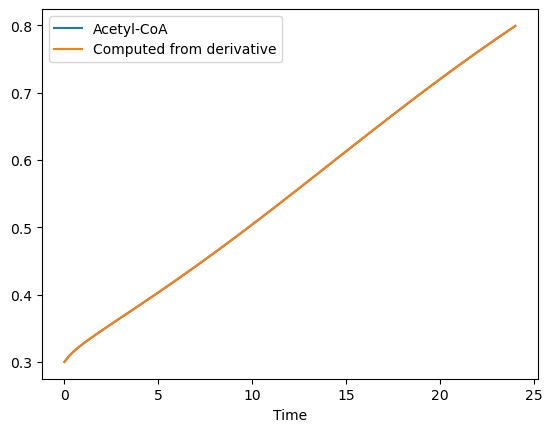

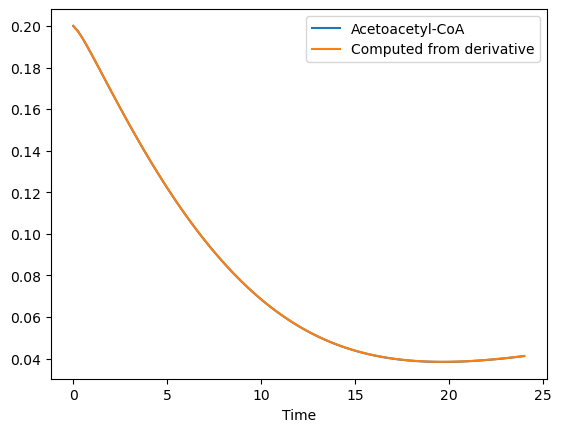

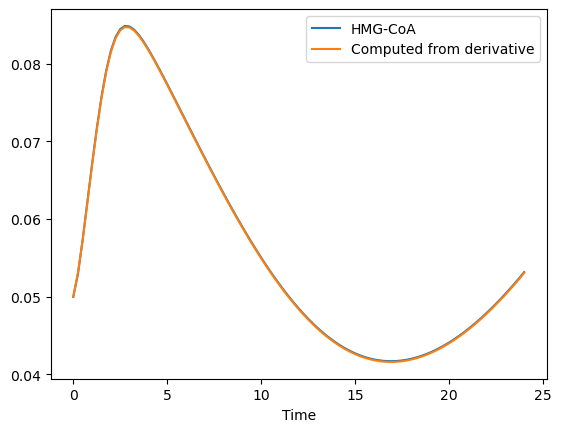

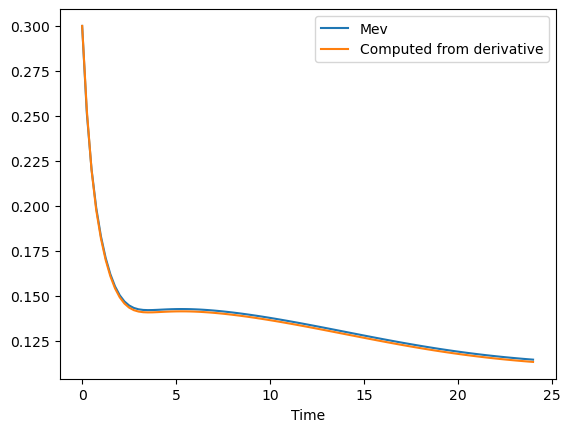

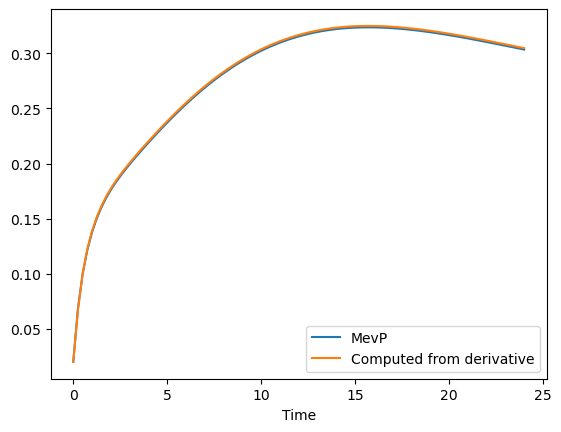

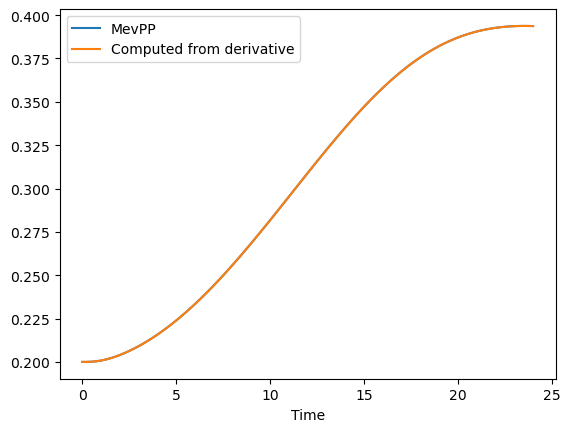

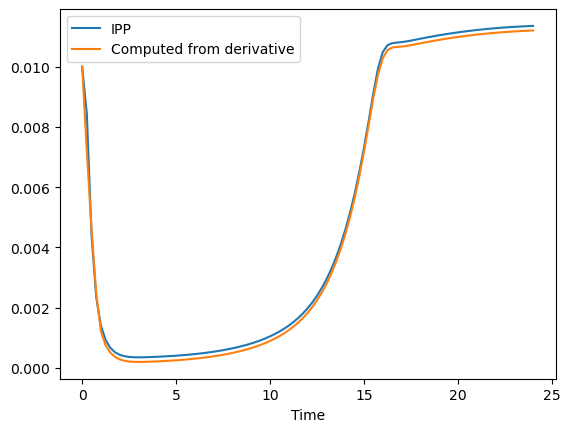

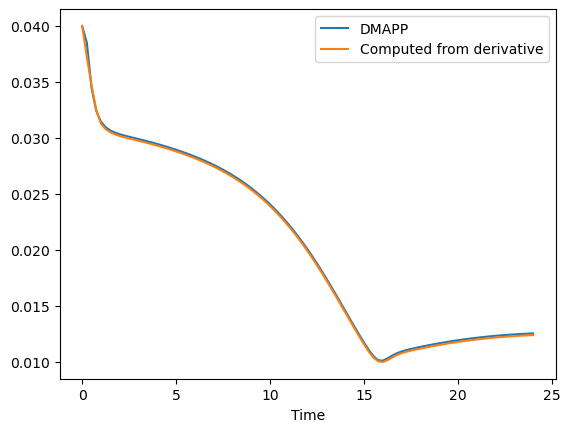

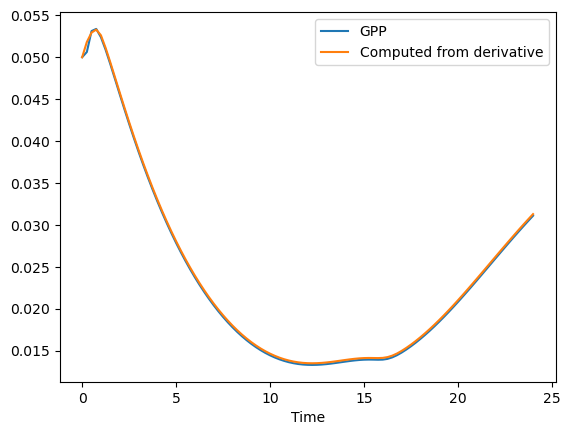

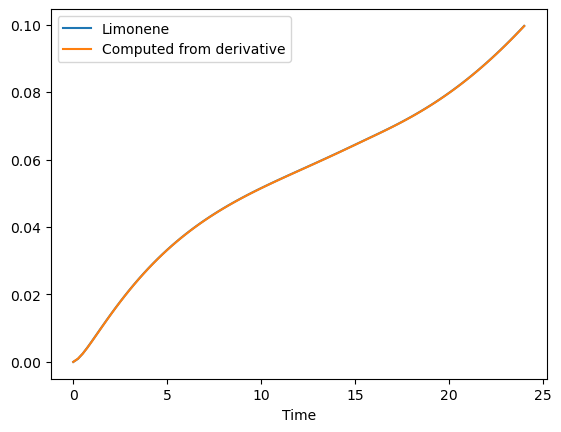

'Time profile from derivative vs. actual profile for Strain 3'

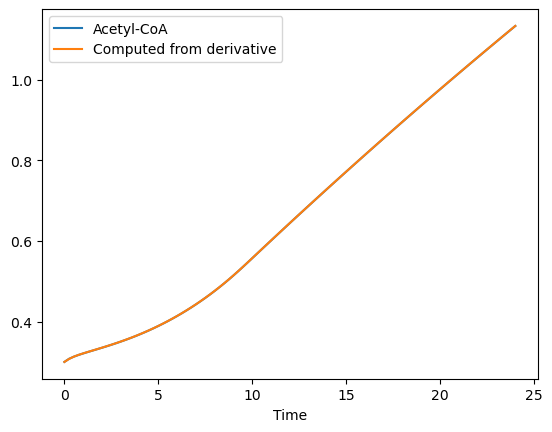

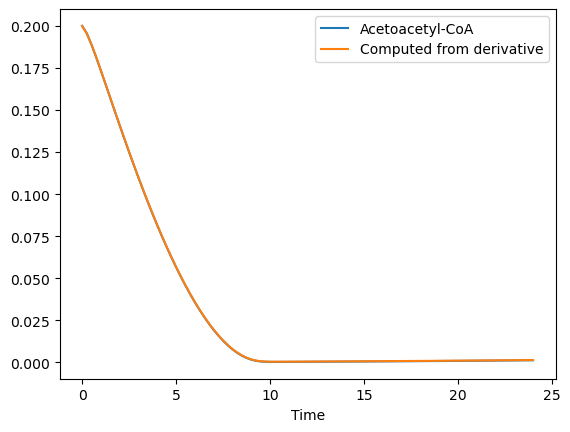

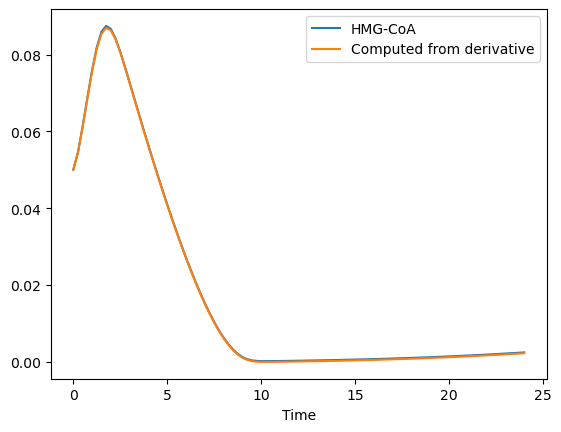

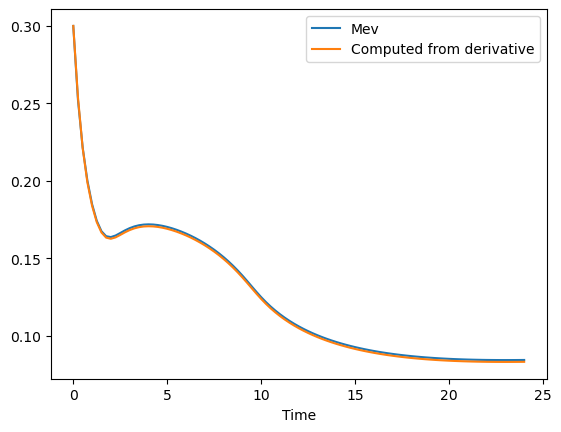

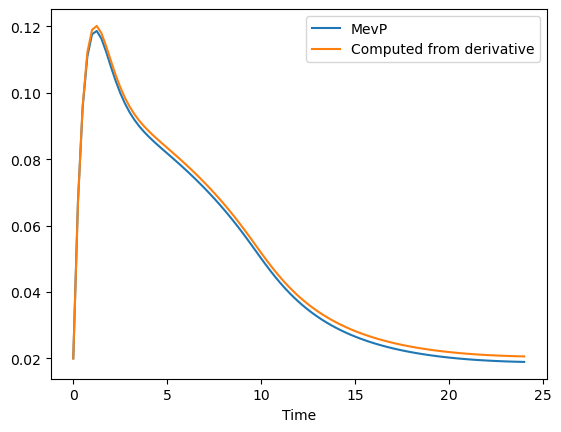

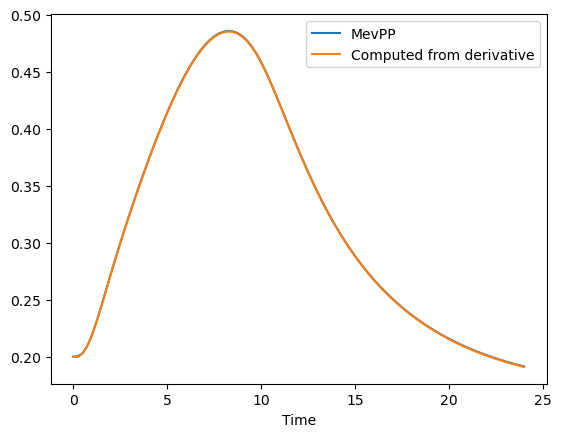

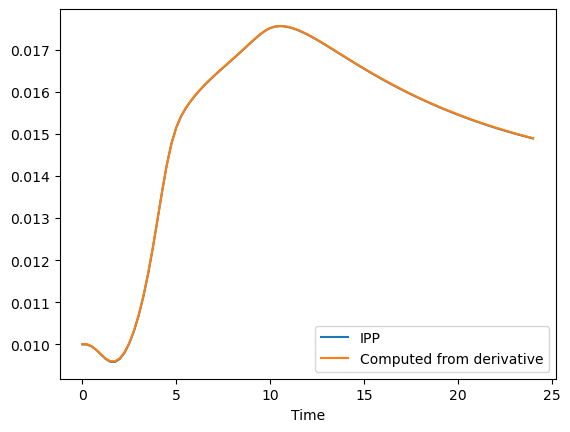

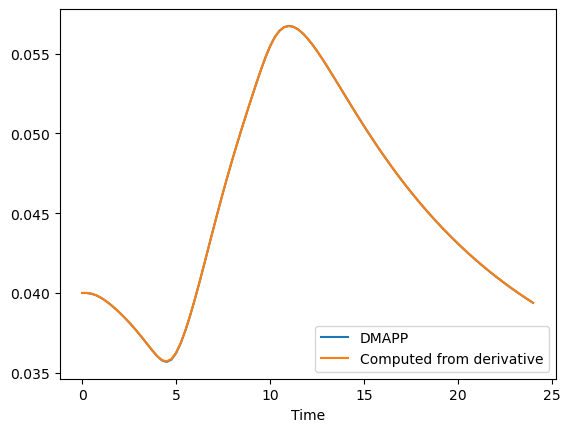

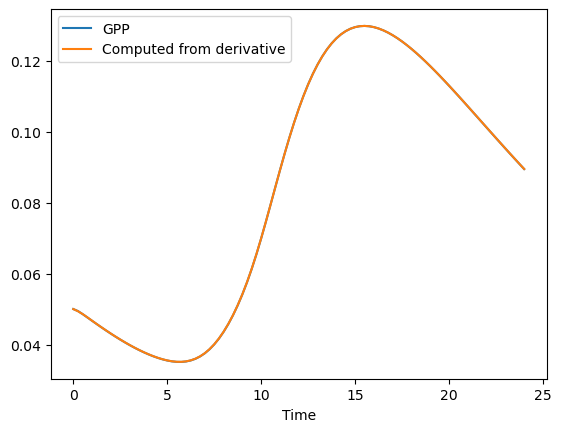

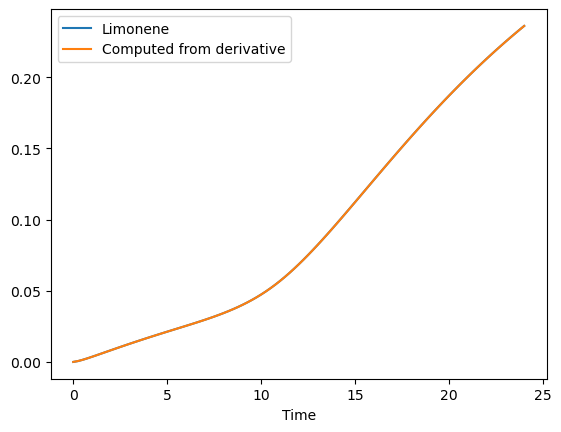

'Time profile from derivative vs. actual profile for WT'

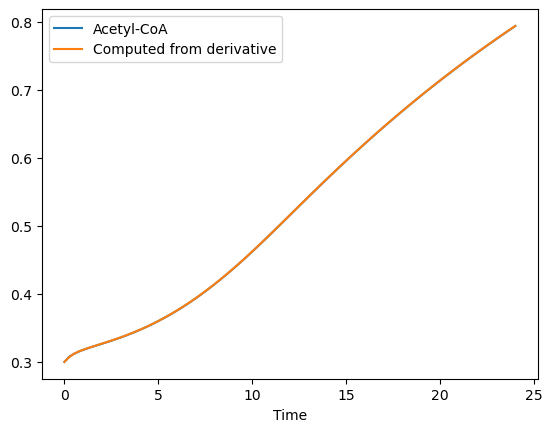

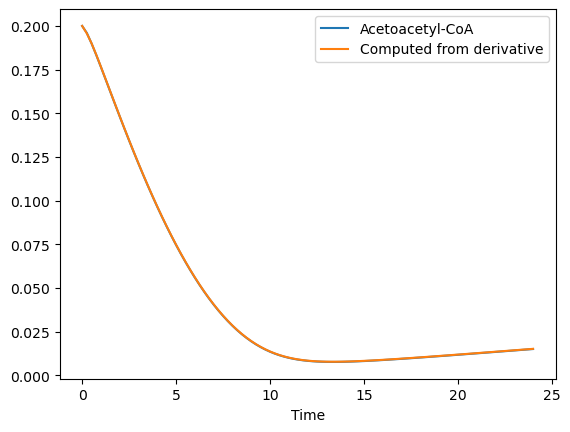

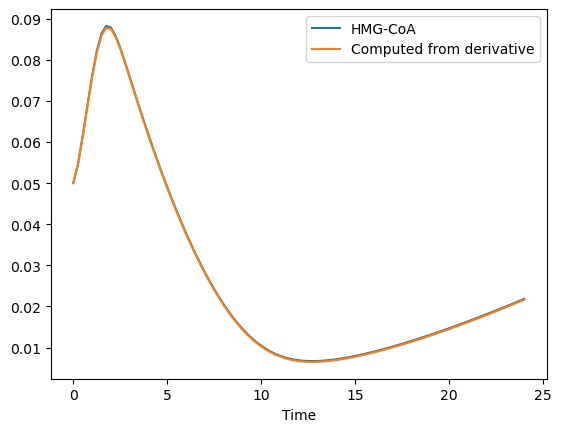

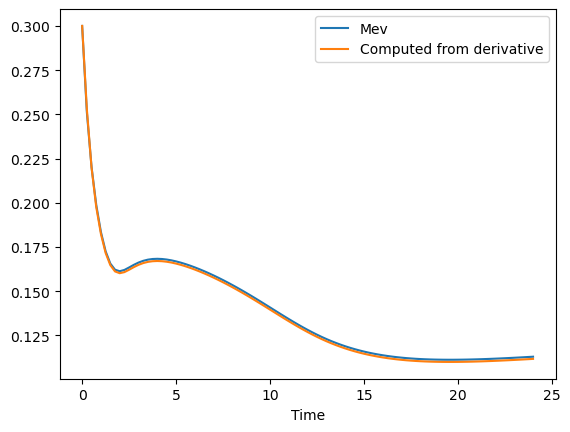

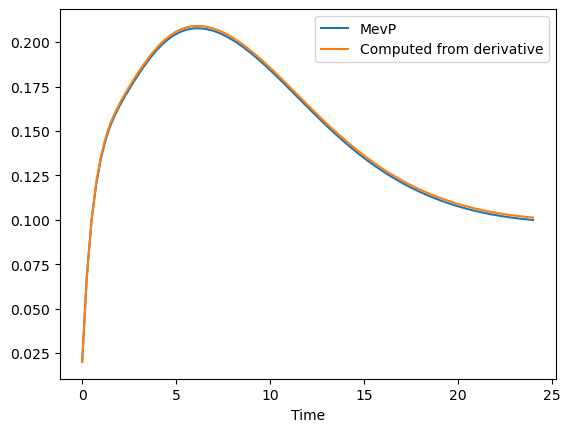

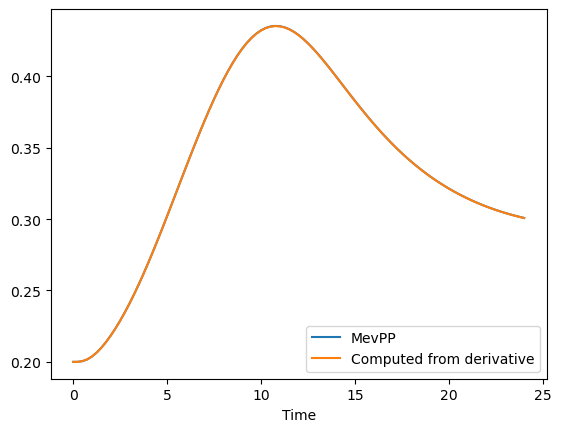

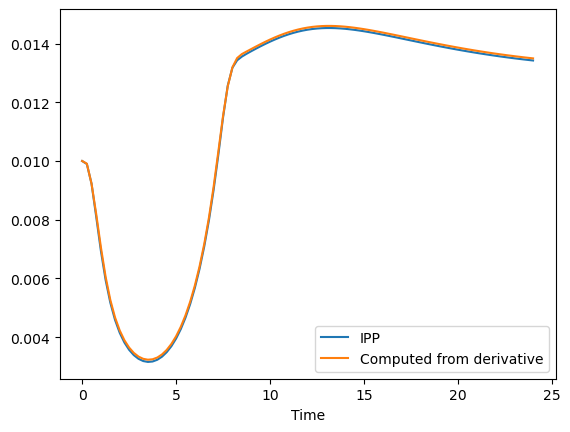

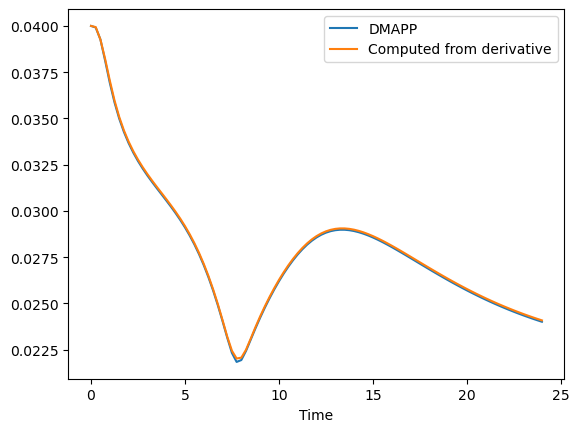

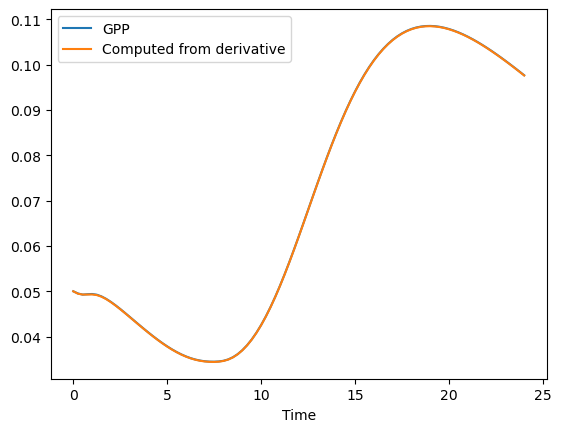

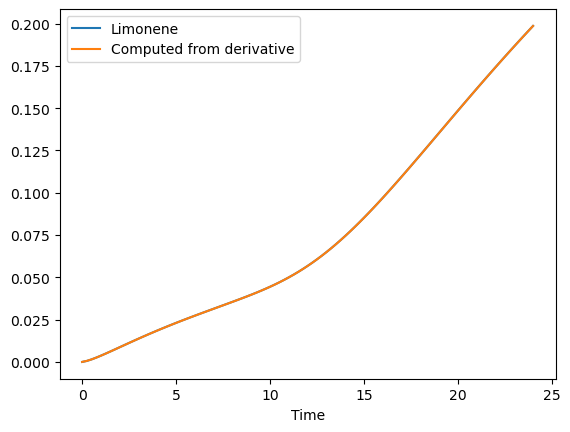

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'DE'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: DE

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 1.484832E+189 |  6.679166E+87
     2 |      128 | 8.268833E+186 |  4.324190E+67
     3 |      192 | 7.641388E+186 |  4.324190E+67
     4 |      256 | 7.641388E+186 |  4.324190E+67
     5 |      320 | 8.099094E+168 |  1.453075E+66
     6 |      384 | 5.672675E+167 |  1.453075E+66
     7 |      448 | 5.672673E+167 |  3.879690E+64
     8 |      512 | 5.672673E+167 |  3.879690E+64
     9 |      576 | 5.607382E+167 |  3.879690E+64
    10 |      640 | 1.584947E+167 |  3.879690E+64
    11 |      704 | 1.584947E+167 |  3.080877E+57
    12 |      768 | 4.019409E+158 |  3.080877E+57
    13 |      832 | 4.019409E+158 |  2.702743E+56
    14 |      896 | 2.344940E+138 |  2.301895E+54
    15 |      960 | 2.344940E+138 |  2.301895E+54
    16 |     1024 | 2.344936E+138 |  3.525701E+47
    17 |     1088 | 1.220610E+135 |  3.525701E+47
    18 |     1152 | 6.645670E+132 |  3.525701E+47
    19 |     1216 | 6.645670

   162 |    10368 |  2.599143E+01 |  2.039046E+01
   163 |    10432 |  2.599124E+01 |  2.039046E+01
   164 |    10496 |  2.598981E+01 |  2.039046E+01
   165 |    10560 |  2.588571E+01 |  2.039046E+01
   166 |    10624 |  2.586220E+01 |  2.039046E+01
   167 |    10688 |  2.585941E+01 |  2.039046E+01
   168 |    10752 |  2.578421E+01 |  2.039046E+01
   169 |    10816 |  2.574134E+01 |  2.039046E+01
   170 |    10880 |  2.561656E+01 |  2.039046E+01
   171 |    10944 |  2.558447E+01 |  2.039046E+01
   172 |    11008 |  2.555639E+01 |  2.039046E+01
   173 |    11072 |  2.550492E+01 |  2.039046E+01
   174 |    11136 |  2.534574E+01 |  2.039046E+01
   175 |    11200 |  2.534419E+01 |  2.039046E+01
   176 |    11264 |  2.533841E+01 |  2.039046E+01
   177 |    11328 |  2.528957E+01 |  2.039046E+01
   178 |    11392 |  2.528957E+01 |  2.039046E+01
   179 |    11456 |  2.523380E+01 |  2.039046E+01
   180 |    11520 |  2.519149E+01 |  2.039046E+01
   181 |    11584 |  2.519139E+01 |  2.039046E+01


   326 |    20864 |  2.227696E+01 |  1.859886E+01
   327 |    20928 |  2.227696E+01 |  1.859886E+01
   328 |    20992 |  2.226594E+01 |  1.859886E+01
   329 |    21056 |  2.226280E+01 |  1.859886E+01
   330 |    21120 |  2.225012E+01 |  1.859886E+01
   331 |    21184 |  2.225012E+01 |  1.859886E+01
   332 |    21248 |  2.222801E+01 |  1.859886E+01
   333 |    21312 |  2.222801E+01 |  1.859886E+01
   334 |    21376 |  2.220778E+01 |  1.859886E+01
   335 |    21440 |  2.217917E+01 |  1.859886E+01
   336 |    21504 |  2.216439E+01 |  1.859886E+01
   337 |    21568 |  2.215613E+01 |  1.859886E+01
   338 |    21632 |  2.215547E+01 |  1.859886E+01
   339 |    21696 |  2.215547E+01 |  1.859886E+01
   340 |    21760 |  2.215143E+01 |  1.859886E+01
   341 |    21824 |  2.211974E+01 |  1.859886E+01
   342 |    21888 |  2.211772E+01 |  1.859886E+01
   343 |    21952 |  2.211376E+01 |  1.859886E+01
   344 |    22016 |  2.211376E+01 |  1.859886E+01
   345 |    22080 |  2.203803E+01 |  1.859886E+01


   490 |    31360 |  2.055415E+01 |  1.582224E+01
   491 |    31424 |  2.054799E+01 |  1.582224E+01
   492 |    31488 |  2.054799E+01 |  1.582224E+01
   493 |    31552 |  2.054799E+01 |  1.582224E+01
   494 |    31616 |  2.054799E+01 |  1.582224E+01
   495 |    31680 |  2.054555E+01 |  1.582224E+01
   496 |    31744 |  2.054555E+01 |  1.582224E+01
   497 |    31808 |  2.054260E+01 |  1.582224E+01
   498 |    31872 |  2.054260E+01 |  1.582224E+01
   499 |    31936 |  2.054085E+01 |  1.582224E+01
   500 |    32000 |  2.054085E+01 |  1.582224E+01
   501 |    32064 |  2.054085E+01 |  1.582224E+01
   502 |    32128 |  2.054085E+01 |  1.582224E+01
   503 |    32192 |  2.054085E+01 |  1.582224E+01
   504 |    32256 |  2.054085E+01 |  1.582224E+01
   505 |    32320 |  2.053939E+01 |  1.582224E+01
   506 |    32384 |  2.053398E+01 |  1.582224E+01
   507 |    32448 |  2.053230E+01 |  1.582224E+01
   508 |    32512 |  2.050198E+01 |  1.582224E+01
   509 |    32576 |  2.050198E+01 |  1.582224E+01


   654 |    41856 |  1.950324E+01 |  1.559997E+01
   655 |    41920 |  1.950324E+01 |  1.559997E+01
   656 |    41984 |  1.945363E+01 |  1.559997E+01
   657 |    42048 |  1.945363E+01 |  1.559997E+01
   658 |    42112 |  1.945237E+01 |  1.559997E+01
   659 |    42176 |  1.945120E+01 |  1.559997E+01
   660 |    42240 |  1.945120E+01 |  1.559997E+01
   661 |    42304 |  1.945120E+01 |  1.559997E+01
   662 |    42368 |  1.941470E+01 |  1.559997E+01
   663 |    42432 |  1.940658E+01 |  1.559997E+01
   664 |    42496 |  1.939604E+01 |  1.559997E+01
   665 |    42560 |  1.938976E+01 |  1.559997E+01
   666 |    42624 |  1.936698E+01 |  1.559997E+01
   667 |    42688 |  1.936411E+01 |  1.559997E+01
   668 |    42752 |  1.936411E+01 |  1.559997E+01
   669 |    42816 |  1.936411E+01 |  1.559997E+01
   670 |    42880 |  1.936157E+01 |  1.559997E+01
   671 |    42944 |  1.936157E+01 |  1.559997E+01
   672 |    43008 |  1.935237E+01 |  1.559997E+01
   673 |    43072 |  1.934748E+01 |  1.559997E+01


   818 |    52352 |  1.862579E+01 |  1.494380E+01
   819 |    52416 |  1.862389E+01 |  1.494380E+01
   820 |    52480 |  1.857567E+01 |  1.476898E+01
   821 |    52544 |  1.857567E+01 |  1.476898E+01
   822 |    52608 |  1.857567E+01 |  1.476898E+01
   823 |    52672 |  1.857567E+01 |  1.476898E+01
   824 |    52736 |  1.857166E+01 |  1.476898E+01
   825 |    52800 |  1.857166E+01 |  1.476898E+01
   826 |    52864 |  1.857162E+01 |  1.476898E+01
   827 |    52928 |  1.855171E+01 |  1.476898E+01
   828 |    52992 |  1.854382E+01 |  1.476898E+01
   829 |    53056 |  1.854382E+01 |  1.476898E+01
   830 |    53120 |  1.854382E+01 |  1.476898E+01
   831 |    53184 |  1.852011E+01 |  1.476898E+01
   832 |    53248 |  1.852011E+01 |  1.476898E+01
   833 |    53312 |  1.852011E+01 |  1.476898E+01
   834 |    53376 |  1.851539E+01 |  1.476898E+01
   835 |    53440 |  1.851539E+01 |  1.476898E+01
   836 |    53504 |  1.851539E+01 |  1.476898E+01
   837 |    53568 |  1.851539E+01 |  1.476898E+01


   982 |    62848 |  1.793263E+01 |  1.405833E+01
   983 |    62912 |  1.793263E+01 |  1.405833E+01
   984 |    62976 |  1.792364E+01 |  1.405833E+01
   985 |    63040 |  1.791855E+01 |  1.405833E+01
   986 |    63104 |  1.791855E+01 |  1.405833E+01
   987 |    63168 |  1.790870E+01 |  1.405833E+01
   988 |    63232 |  1.790870E+01 |  1.405833E+01
   989 |    63296 |  1.790870E+01 |  1.405833E+01
   990 |    63360 |  1.789676E+01 |  1.405833E+01
   991 |    63424 |  1.789676E+01 |  1.405833E+01
   992 |    63488 |  1.789676E+01 |  1.405833E+01
   993 |    63552 |  1.787525E+01 |  1.405833E+01
   994 |    63616 |  1.787525E+01 |  1.405833E+01
   995 |    63680 |  1.786721E+01 |  1.405833E+01
   996 |    63744 |  1.786721E+01 |  1.405833E+01
   997 |    63808 |  1.786721E+01 |  1.405833E+01
   998 |    63872 |  1.785214E+01 |  1.405833E+01
   999 |    63936 |  1.784096E+01 |  1.405833E+01
  1000 |    64000 |  1.783936E+01 |  1.405833E+01
  1001 |    64064 |  1.783818E+01 |  1.405833E+01


  1146 |    73344 |  1.738975E+01 |  1.344538E+01
  1147 |    73408 |  1.738975E+01 |  1.344538E+01
  1148 |    73472 |  1.738975E+01 |  1.344538E+01
  1149 |    73536 |  1.736793E+01 |  1.344538E+01
  1150 |    73600 |  1.736552E+01 |  1.344538E+01
  1151 |    73664 |  1.736535E+01 |  1.344538E+01
  1152 |    73728 |  1.736480E+01 |  1.344538E+01
  1153 |    73792 |  1.735894E+01 |  1.344538E+01
  1154 |    73856 |  1.735894E+01 |  1.344538E+01
  1155 |    73920 |  1.735894E+01 |  1.344538E+01
  1156 |    73984 |  1.735893E+01 |  1.344538E+01
  1157 |    74048 |  1.735891E+01 |  1.344538E+01
  1158 |    74112 |  1.735891E+01 |  1.344538E+01
  1159 |    74176 |  1.735768E+01 |  1.344538E+01
  1160 |    74240 |  1.735768E+01 |  1.344538E+01
  1161 |    74304 |  1.735723E+01 |  1.344538E+01
  1162 |    74368 |  1.735723E+01 |  1.344538E+01
  1163 |    74432 |  1.735723E+01 |  1.344538E+01
  1164 |    74496 |  1.735723E+01 |  1.344538E+01
  1165 |    74560 |  1.735723E+01 |  1.344538E+01


  1310 |    83840 |  1.707392E+01 |  1.339114E+01
  1311 |    83904 |  1.706410E+01 |  1.339114E+01
  1312 |    83968 |  1.706410E+01 |  1.339114E+01
  1313 |    84032 |  1.706280E+01 |  1.339114E+01
  1314 |    84096 |  1.706222E+01 |  1.335769E+01
  1315 |    84160 |  1.706222E+01 |  1.335769E+01
  1316 |    84224 |  1.706221E+01 |  1.335769E+01
  1317 |    84288 |  1.706221E+01 |  1.335769E+01
  1318 |    84352 |  1.706221E+01 |  1.335769E+01
  1319 |    84416 |  1.706221E+01 |  1.335769E+01
  1320 |    84480 |  1.706221E+01 |  1.335769E+01
  1321 |    84544 |  1.706221E+01 |  1.335769E+01
  1322 |    84608 |  1.706221E+01 |  1.335769E+01
  1323 |    84672 |  1.706221E+01 |  1.335769E+01
  1324 |    84736 |  1.706132E+01 |  1.335769E+01
  1325 |    84800 |  1.706132E+01 |  1.335769E+01
  1326 |    84864 |  1.706132E+01 |  1.335769E+01
  1327 |    84928 |  1.706132E+01 |  1.335769E+01
  1328 |    84992 |  1.706132E+01 |  1.335769E+01
  1329 |    85056 |  1.705623E+01 |  1.335769E+01


  1474 |    94336 |  1.683251E+01 |  1.335769E+01
  1475 |    94400 |  1.683251E+01 |  1.335769E+01
  1476 |    94464 |  1.683251E+01 |  1.335769E+01
  1477 |    94528 |  1.683251E+01 |  1.335769E+01
  1478 |    94592 |  1.682516E+01 |  1.335769E+01
  1479 |    94656 |  1.681710E+01 |  1.335769E+01
  1480 |    94720 |  1.681710E+01 |  1.335769E+01
  1481 |    94784 |  1.677886E+01 |  1.335769E+01
  1482 |    94848 |  1.677886E+01 |  1.335769E+01
  1483 |    94912 |  1.677886E+01 |  1.335769E+01
  1484 |    94976 |  1.677886E+01 |  1.335769E+01
  1485 |    95040 |  1.677886E+01 |  1.335769E+01
  1486 |    95104 |  1.677886E+01 |  1.335769E+01
  1487 |    95168 |  1.677839E+01 |  1.335769E+01
  1488 |    95232 |  1.677839E+01 |  1.335769E+01
  1489 |    95296 |  1.677839E+01 |  1.335769E+01
  1490 |    95360 |  1.677839E+01 |  1.335769E+01
  1491 |    95424 |  1.677838E+01 |  1.335769E+01
  1492 |    95488 |  1.677827E+01 |  1.335769E+01
  1493 |    95552 |  1.677827E+01 |  1.335769E+01


  1638 |   104832 |  1.653956E+01 |  1.335769E+01
  1639 |   104896 |  1.653956E+01 |  1.335769E+01
  1640 |   104960 |  1.653956E+01 |  1.335769E+01
  1641 |   105024 |  1.653956E+01 |  1.335769E+01
  1642 |   105088 |  1.653956E+01 |  1.335769E+01
  1643 |   105152 |  1.653956E+01 |  1.335769E+01
  1644 |   105216 |  1.653913E+01 |  1.335769E+01
  1645 |   105280 |  1.653913E+01 |  1.335769E+01
  1646 |   105344 |  1.653913E+01 |  1.335769E+01
  1647 |   105408 |  1.653913E+01 |  1.335769E+01
  1648 |   105472 |  1.653913E+01 |  1.335769E+01
  1649 |   105536 |  1.653913E+01 |  1.335769E+01
  1650 |   105600 |  1.653913E+01 |  1.335769E+01
  1651 |   105664 |  1.653913E+01 |  1.335769E+01
  1652 |   105728 |  1.653913E+01 |  1.335769E+01
  1653 |   105792 |  1.653913E+01 |  1.335769E+01
  1654 |   105856 |  1.653265E+01 |  1.335769E+01
  1655 |   105920 |  1.653265E+01 |  1.335769E+01
  1656 |   105984 |  1.653265E+01 |  1.335769E+01
  1657 |   106048 |  1.653265E+01 |  1.335769E+01


  1802 |   115328 |  1.621497E+01 |  1.335769E+01
  1803 |   115392 |  1.621497E+01 |  1.335769E+01
  1804 |   115456 |  1.621497E+01 |  1.335769E+01
  1805 |   115520 |  1.621497E+01 |  1.335769E+01
  1806 |   115584 |  1.621497E+01 |  1.335769E+01
  1807 |   115648 |  1.621497E+01 |  1.335769E+01
  1808 |   115712 |  1.621497E+01 |  1.335769E+01
  1809 |   115776 |  1.621495E+01 |  1.335769E+01
  1810 |   115840 |  1.621495E+01 |  1.335769E+01
  1811 |   115904 |  1.620094E+01 |  1.335769E+01
  1812 |   115968 |  1.620094E+01 |  1.335769E+01
  1813 |   116032 |  1.620094E+01 |  1.335769E+01
  1814 |   116096 |  1.620094E+01 |  1.335769E+01
  1815 |   116160 |  1.620094E+01 |  1.335769E+01
  1816 |   116224 |  1.619860E+01 |  1.335769E+01
  1817 |   116288 |  1.619777E+01 |  1.335769E+01
  1818 |   116352 |  1.619421E+01 |  1.335769E+01
  1819 |   116416 |  1.619097E+01 |  1.335769E+01
  1820 |   116480 |  1.619011E+01 |  1.335769E+01
  1821 |   116544 |  1.619011E+01 |  1.335769E+01


  1966 |   125824 |  1.602578E+01 |  1.267302E+01
  1967 |   125888 |  1.602578E+01 |  1.267302E+01
  1968 |   125952 |  1.602094E+01 |  1.267302E+01
  1969 |   126016 |  1.602094E+01 |  1.267302E+01
  1970 |   126080 |  1.602094E+01 |  1.267302E+01
  1971 |   126144 |  1.602094E+01 |  1.267302E+01
  1972 |   126208 |  1.602094E+01 |  1.267302E+01
  1973 |   126272 |  1.602094E+01 |  1.267302E+01
  1974 |   126336 |  1.602094E+01 |  1.267302E+01
  1975 |   126400 |  1.602094E+01 |  1.267302E+01
  1976 |   126464 |  1.601185E+01 |  1.267302E+01
  1977 |   126528 |  1.601185E+01 |  1.267302E+01
  1978 |   126592 |  1.601170E+01 |  1.267302E+01
  1979 |   126656 |  1.601170E+01 |  1.267302E+01
  1980 |   126720 |  1.601170E+01 |  1.267302E+01
  1981 |   126784 |  1.601170E+01 |  1.267302E+01
  1982 |   126848 |  1.601170E+01 |  1.267302E+01
  1983 |   126912 |  1.601170E+01 |  1.267302E+01
  1984 |   126976 |  1.601170E+01 |  1.267302E+01
  1985 |   127040 |  1.601007E+01 |  1.267302E+01


  2130 |   136320 |  1.584077E+01 |  1.267302E+01
  2131 |   136384 |  1.584077E+01 |  1.267302E+01
  2132 |   136448 |  1.584077E+01 |  1.267302E+01
  2133 |   136512 |  1.584077E+01 |  1.267302E+01
  2134 |   136576 |  1.582866E+01 |  1.267302E+01
  2135 |   136640 |  1.582866E+01 |  1.267302E+01
  2136 |   136704 |  1.582866E+01 |  1.267302E+01
  2137 |   136768 |  1.582866E+01 |  1.267302E+01
  2138 |   136832 |  1.582866E+01 |  1.267302E+01
  2139 |   136896 |  1.582866E+01 |  1.267302E+01
  2140 |   136960 |  1.582865E+01 |  1.267302E+01
  2141 |   137024 |  1.582332E+01 |  1.267302E+01
  2142 |   137088 |  1.582331E+01 |  1.267302E+01
  2143 |   137152 |  1.582331E+01 |  1.267302E+01
  2144 |   137216 |  1.582331E+01 |  1.267302E+01
  2145 |   137280 |  1.582331E+01 |  1.267302E+01
  2146 |   137344 |  1.582331E+01 |  1.267302E+01
  2147 |   137408 |  1.582331E+01 |  1.267302E+01
  2148 |   137472 |  1.582331E+01 |  1.267302E+01
  2149 |   137536 |  1.582305E+01 |  1.267302E+01


  2294 |   146816 |  1.562079E+01 |  1.267302E+01
  2295 |   146880 |  1.562079E+01 |  1.267302E+01
  2296 |   146944 |  1.562079E+01 |  1.267302E+01
  2297 |   147008 |  1.562079E+01 |  1.267302E+01
  2298 |   147072 |  1.561843E+01 |  1.267302E+01
  2299 |   147136 |  1.561843E+01 |  1.267302E+01
  2300 |   147200 |  1.561817E+01 |  1.267302E+01
  2301 |   147264 |  1.561817E+01 |  1.267302E+01
  2302 |   147328 |  1.561817E+01 |  1.267302E+01
  2303 |   147392 |  1.561817E+01 |  1.267302E+01
  2304 |   147456 |  1.561817E+01 |  1.267302E+01
  2305 |   147520 |  1.561817E+01 |  1.267302E+01
  2306 |   147584 |  1.561817E+01 |  1.267302E+01
  2307 |   147648 |  1.561817E+01 |  1.267302E+01
  2308 |   147712 |  1.561817E+01 |  1.267302E+01
  2309 |   147776 |  1.561817E+01 |  1.267302E+01
  2310 |   147840 |  1.561817E+01 |  1.267302E+01
  2311 |   147904 |  1.561627E+01 |  1.267302E+01
  2312 |   147968 |  1.561627E+01 |  1.267302E+01
  2313 |   148032 |  1.561566E+01 |  1.267302E+01


  2458 |   157312 |  1.544214E+01 |  1.256410E+01
  2459 |   157376 |  1.544214E+01 |  1.256410E+01
  2460 |   157440 |  1.544214E+01 |  1.256410E+01
  2461 |   157504 |  1.544214E+01 |  1.256410E+01
  2462 |   157568 |  1.544214E+01 |  1.256410E+01
  2463 |   157632 |  1.544214E+01 |  1.256410E+01
  2464 |   157696 |  1.544214E+01 |  1.256410E+01
  2465 |   157760 |  1.544214E+01 |  1.256410E+01
  2466 |   157824 |  1.543211E+01 |  1.256410E+01
  2467 |   157888 |  1.543211E+01 |  1.256410E+01
  2468 |   157952 |  1.543211E+01 |  1.256410E+01
  2469 |   158016 |  1.543173E+01 |  1.256410E+01
  2470 |   158080 |  1.543160E+01 |  1.256410E+01
  2471 |   158144 |  1.543160E+01 |  1.256410E+01
  2472 |   158208 |  1.543160E+01 |  1.256410E+01
  2473 |   158272 |  1.543160E+01 |  1.256410E+01
  2474 |   158336 |  1.543160E+01 |  1.256410E+01
  2475 |   158400 |  1.543160E+01 |  1.256410E+01
  2476 |   158464 |  1.543160E+01 |  1.256410E+01
  2477 |   158528 |  1.542828E+01 |  1.256410E+01


  2622 |   167808 |  1.532320E+01 |  1.225795E+01
  2623 |   167872 |  1.532252E+01 |  1.225795E+01
  2624 |   167936 |  1.532252E+01 |  1.225795E+01
  2625 |   168000 |  1.532252E+01 |  1.225795E+01
  2626 |   168064 |  1.532252E+01 |  1.225795E+01
  2627 |   168128 |  1.532252E+01 |  1.225795E+01
  2628 |   168192 |  1.532252E+01 |  1.225795E+01
  2629 |   168256 |  1.532099E+01 |  1.225795E+01
  2630 |   168320 |  1.532099E+01 |  1.225795E+01
  2631 |   168384 |  1.532099E+01 |  1.225795E+01
  2632 |   168448 |  1.532099E+01 |  1.225795E+01
  2633 |   168512 |  1.532099E+01 |  1.225795E+01
  2634 |   168576 |  1.532097E+01 |  1.225702E+01
  2635 |   168640 |  1.532097E+01 |  1.225702E+01
  2636 |   168704 |  1.532097E+01 |  1.225702E+01
  2637 |   168768 |  1.531686E+01 |  1.225702E+01
  2638 |   168832 |  1.531686E+01 |  1.225702E+01
  2639 |   168896 |  1.531686E+01 |  1.225702E+01
  2640 |   168960 |  1.531686E+01 |  1.225702E+01
  2641 |   169024 |  1.531686E+01 |  1.225702E+01


  2786 |   178304 |  1.523425E+01 |  1.213238E+01
  2787 |   178368 |  1.523248E+01 |  1.213238E+01
  2788 |   178432 |  1.523248E+01 |  1.213238E+01
  2789 |   178496 |  1.523248E+01 |  1.213238E+01
  2790 |   178560 |  1.523248E+01 |  1.213238E+01
  2791 |   178624 |  1.523248E+01 |  1.213238E+01
  2792 |   178688 |  1.523248E+01 |  1.213238E+01
  2793 |   178752 |  1.523149E+01 |  1.213238E+01
  2794 |   178816 |  1.523149E+01 |  1.213238E+01
  2795 |   178880 |  1.522805E+01 |  1.213238E+01
  2796 |   178944 |  1.522805E+01 |  1.213238E+01
  2797 |   179008 |  1.522429E+01 |  1.213238E+01
  2798 |   179072 |  1.522023E+01 |  1.213238E+01
  2799 |   179136 |  1.522023E+01 |  1.213238E+01
  2800 |   179200 |  1.521268E+01 |  1.213238E+01
  2801 |   179264 |  1.521203E+01 |  1.213238E+01
  2802 |   179328 |  1.521203E+01 |  1.213238E+01
  2803 |   179392 |  1.521203E+01 |  1.213238E+01
  2804 |   179456 |  1.521203E+01 |  1.213238E+01
  2805 |   179520 |  1.521203E+01 |  1.213238E+01


  2950 |   188800 |  1.514613E+01 |  1.213237E+01
  2951 |   188864 |  1.513709E+01 |  1.213237E+01
  2952 |   188928 |  1.513709E+01 |  1.213237E+01
  2953 |   188992 |  1.513709E+01 |  1.213237E+01
  2954 |   189056 |  1.513709E+01 |  1.213237E+01
  2955 |   189120 |  1.513709E+01 |  1.213237E+01
  2956 |   189184 |  1.513709E+01 |  1.213237E+01
  2957 |   189248 |  1.513579E+01 |  1.213237E+01
  2958 |   189312 |  1.512938E+01 |  1.213237E+01
  2959 |   189376 |  1.512938E+01 |  1.213237E+01
  2960 |   189440 |  1.512938E+01 |  1.213237E+01
  2961 |   189504 |  1.512938E+01 |  1.213237E+01
  2962 |   189568 |  1.512938E+01 |  1.213237E+01
  2963 |   189632 |  1.512938E+01 |  1.213237E+01
  2964 |   189696 |  1.512740E+01 |  1.213237E+01
  2965 |   189760 |  1.512740E+01 |  1.213237E+01
  2966 |   189824 |  1.512740E+01 |  1.213237E+01
  2967 |   189888 |  1.512740E+01 |  1.213237E+01
  2968 |   189952 |  1.512740E+01 |  1.213237E+01
  2969 |   190016 |  1.512740E+01 |  1.213237E+01


  3114 |   199296 |  1.505734E+01 |  1.213237E+01
  3115 |   199360 |  1.505734E+01 |  1.213237E+01
  3116 |   199424 |  1.505734E+01 |  1.213237E+01
  3117 |   199488 |  1.505734E+01 |  1.213237E+01
  3118 |   199552 |  1.505734E+01 |  1.213237E+01
  3119 |   199616 |  1.505734E+01 |  1.213237E+01
  3120 |   199680 |  1.505734E+01 |  1.213237E+01
  3121 |   199744 |  1.505734E+01 |  1.213237E+01
  3122 |   199808 |  1.505734E+01 |  1.213237E+01
  3123 |   199872 |  1.505734E+01 |  1.213237E+01
  3124 |   199936 |  1.505734E+01 |  1.213237E+01
  3125 |   200000 |  1.505734E+01 |  1.213237E+01
  3126 |   200064 |  1.505734E+01 |  1.213237E+01
  3127 |   200128 |  1.505734E+01 |  1.213237E+01
  3128 |   200192 |  1.505733E+01 |  1.213237E+01
  3129 |   200256 |  1.505589E+01 |  1.213237E+01
  3130 |   200320 |  1.505323E+01 |  1.213237E+01
  3131 |   200384 |  1.505323E+01 |  1.213237E+01
  3132 |   200448 |  1.505323E+01 |  1.213237E+01
  3133 |   200512 |  1.505323E+01 |  1.213237E+01


  3278 |   209792 |  1.500149E+01 |  1.213237E+01
  3279 |   209856 |  1.500141E+01 |  1.213237E+01
  3280 |   209920 |  1.500141E+01 |  1.213237E+01
  3281 |   209984 |  1.500141E+01 |  1.213237E+01
  3282 |   210048 |  1.500141E+01 |  1.213237E+01
  3283 |   210112 |  1.500141E+01 |  1.213237E+01
  3284 |   210176 |  1.500097E+01 |  1.213237E+01
  3285 |   210240 |  1.500097E+01 |  1.213237E+01
  3286 |   210304 |  1.500097E+01 |  1.213237E+01
  3287 |   210368 |  1.500097E+01 |  1.213237E+01
  3288 |   210432 |  1.500097E+01 |  1.213237E+01
  3289 |   210496 |  1.500097E+01 |  1.213237E+01
  3290 |   210560 |  1.500097E+01 |  1.213237E+01
  3291 |   210624 |  1.500097E+01 |  1.213237E+01
  3292 |   210688 |  1.500097E+01 |  1.213237E+01
  3293 |   210752 |  1.500097E+01 |  1.213237E+01
  3294 |   210816 |  1.500097E+01 |  1.213237E+01
  3295 |   210880 |  1.500097E+01 |  1.213237E+01
  3296 |   210944 |  1.500097E+01 |  1.213237E+01
  3297 |   211008 |  1.500097E+01 |  1.213237E+01


  3442 |   220288 |  1.490791E+01 |  1.157273E+01
  3443 |   220352 |  1.490791E+01 |  1.157273E+01
  3444 |   220416 |  1.490205E+01 |  1.157273E+01
  3445 |   220480 |  1.489496E+01 |  1.157273E+01
  3446 |   220544 |  1.489074E+01 |  1.157273E+01
  3447 |   220608 |  1.489074E+01 |  1.157273E+01
  3448 |   220672 |  1.489074E+01 |  1.157273E+01
  3449 |   220736 |  1.489074E+01 |  1.157273E+01
  3450 |   220800 |  1.489074E+01 |  1.157273E+01
  3451 |   220864 |  1.489074E+01 |  1.157273E+01
  3452 |   220928 |  1.489074E+01 |  1.157273E+01
  3453 |   220992 |  1.489074E+01 |  1.157273E+01
  3454 |   221056 |  1.488879E+01 |  1.157273E+01
  3455 |   221120 |  1.488879E+01 |  1.157273E+01
  3456 |   221184 |  1.488879E+01 |  1.157273E+01
  3457 |   221248 |  1.488879E+01 |  1.157273E+01
  3458 |   221312 |  1.488879E+01 |  1.157273E+01
  3459 |   221376 |  1.488879E+01 |  1.157273E+01
  3460 |   221440 |  1.488879E+01 |  1.157273E+01
  3461 |   221504 |  1.488879E+01 |  1.157273E+01


  3606 |   230784 |  1.482249E+01 |  1.141002E+01
  3607 |   230848 |  1.482249E+01 |  1.141002E+01
  3608 |   230912 |  1.482249E+01 |  1.141002E+01
  3609 |   230976 |  1.482249E+01 |  1.141002E+01
  3610 |   231040 |  1.482249E+01 |  1.141002E+01
  3611 |   231104 |  1.482249E+01 |  1.141002E+01
  3612 |   231168 |  1.482249E+01 |  1.141002E+01
  3613 |   231232 |  1.481838E+01 |  1.141002E+01
  3614 |   231296 |  1.481838E+01 |  1.141002E+01
  3615 |   231360 |  1.481838E+01 |  1.141002E+01
  3616 |   231424 |  1.481838E+01 |  1.141002E+01
  3617 |   231488 |  1.481838E+01 |  1.141002E+01
  3618 |   231552 |  1.481838E+01 |  1.141002E+01
  3619 |   231616 |  1.481838E+01 |  1.141002E+01
  3620 |   231680 |  1.481838E+01 |  1.141002E+01
  3621 |   231744 |  1.481832E+01 |  1.141002E+01
  3622 |   231808 |  1.481832E+01 |  1.141002E+01
  3623 |   231872 |  1.481832E+01 |  1.141002E+01
  3624 |   231936 |  1.481565E+01 |  1.141002E+01
  3625 |   232000 |  1.481565E+01 |  1.141002E+01


  3770 |   241280 |  1.473344E+01 |  1.141002E+01
  3771 |   241344 |  1.473344E+01 |  1.141002E+01
  3772 |   241408 |  1.473344E+01 |  1.141002E+01
  3773 |   241472 |  1.473344E+01 |  1.141002E+01
  3774 |   241536 |  1.473344E+01 |  1.141002E+01
  3775 |   241600 |  1.473010E+01 |  1.141002E+01
  3776 |   241664 |  1.473010E+01 |  1.141002E+01
  3777 |   241728 |  1.473010E+01 |  1.141002E+01
  3778 |   241792 |  1.473010E+01 |  1.141002E+01
  3779 |   241856 |  1.473010E+01 |  1.141002E+01
  3780 |   241920 |  1.473010E+01 |  1.141002E+01
  3781 |   241984 |  1.473010E+01 |  1.141002E+01
  3782 |   242048 |  1.473010E+01 |  1.141002E+01
  3783 |   242112 |  1.473010E+01 |  1.141002E+01
  3784 |   242176 |  1.473010E+01 |  1.141002E+01
  3785 |   242240 |  1.472177E+01 |  1.141002E+01
  3786 |   242304 |  1.472177E+01 |  1.141002E+01
  3787 |   242368 |  1.472177E+01 |  1.141002E+01
  3788 |   242432 |  1.472177E+01 |  1.141002E+01
  3789 |   242496 |  1.471507E+01 |  1.141002E+01


  3934 |   251776 |  1.464070E+01 |  1.123002E+01
  3935 |   251840 |  1.464070E+01 |  1.123002E+01
  3936 |   251904 |  1.464046E+01 |  1.123002E+01
  3937 |   251968 |  1.464032E+01 |  1.123002E+01
  3938 |   252032 |  1.463976E+01 |  1.123002E+01
  3939 |   252096 |  1.463832E+01 |  1.123002E+01
  3940 |   252160 |  1.463832E+01 |  1.123002E+01
  3941 |   252224 |  1.463832E+01 |  1.123002E+01
  3942 |   252288 |  1.463056E+01 |  1.123002E+01
  3943 |   252352 |  1.463056E+01 |  1.123002E+01
  3944 |   252416 |  1.462929E+01 |  1.123002E+01
  3945 |   252480 |  1.462929E+01 |  1.123002E+01
  3946 |   252544 |  1.462929E+01 |  1.123002E+01
  3947 |   252608 |  1.462929E+01 |  1.123002E+01
  3948 |   252672 |  1.462929E+01 |  1.123002E+01
  3949 |   252736 |  1.462929E+01 |  1.123002E+01
  3950 |   252800 |  1.462929E+01 |  1.123002E+01
  3951 |   252864 |  1.462929E+01 |  1.123002E+01
  3952 |   252928 |  1.462929E+01 |  1.123002E+01
  3953 |   252992 |  1.462416E+01 |  1.123002E+01


  4098 |   262272 |  1.449331E+01 |  1.123002E+01
  4099 |   262336 |  1.449331E+01 |  1.123002E+01
  4100 |   262400 |  1.449331E+01 |  1.123002E+01
  4101 |   262464 |  1.449331E+01 |  1.123002E+01
  4102 |   262528 |  1.448769E+01 |  1.123002E+01
  4103 |   262592 |  1.448769E+01 |  1.123002E+01
  4104 |   262656 |  1.448769E+01 |  1.123002E+01
  4105 |   262720 |  1.447676E+01 |  1.123002E+01
  4106 |   262784 |  1.447676E+01 |  1.123002E+01
  4107 |   262848 |  1.447676E+01 |  1.123002E+01
  4108 |   262912 |  1.447676E+01 |  1.123002E+01
  4109 |   262976 |  1.447676E+01 |  1.123002E+01
  4110 |   263040 |  1.447676E+01 |  1.123002E+01
  4111 |   263104 |  1.447676E+01 |  1.123002E+01
  4112 |   263168 |  1.447676E+01 |  1.123002E+01
  4113 |   263232 |  1.447676E+01 |  1.123002E+01
  4114 |   263296 |  1.447672E+01 |  1.123002E+01
  4115 |   263360 |  1.447672E+01 |  1.123002E+01
  4116 |   263424 |  1.447627E+01 |  1.123002E+01
  4117 |   263488 |  1.447627E+01 |  1.123002E+01


  4262 |   272768 |  1.432313E+01 |  1.123002E+01
  4263 |   272832 |  1.432313E+01 |  1.123002E+01
  4264 |   272896 |  1.432313E+01 |  1.123002E+01
  4265 |   272960 |  1.431530E+01 |  1.123002E+01
  4266 |   273024 |  1.431530E+01 |  1.123002E+01
  4267 |   273088 |  1.431530E+01 |  1.123002E+01
  4268 |   273152 |  1.431530E+01 |  1.123002E+01
  4269 |   273216 |  1.431530E+01 |  1.123002E+01
  4270 |   273280 |  1.431530E+01 |  1.123002E+01
  4271 |   273344 |  1.431530E+01 |  1.123002E+01
  4272 |   273408 |  1.431354E+01 |  1.123002E+01
  4273 |   273472 |  1.431354E+01 |  1.123002E+01
  4274 |   273536 |  1.431354E+01 |  1.123002E+01
  4275 |   273600 |  1.431354E+01 |  1.123002E+01
  4276 |   273664 |  1.431354E+01 |  1.123002E+01
  4277 |   273728 |  1.431354E+01 |  1.123002E+01
  4278 |   273792 |  1.431354E+01 |  1.123002E+01
  4279 |   273856 |  1.431354E+01 |  1.123002E+01
  4280 |   273920 |  1.431354E+01 |  1.123002E+01
  4281 |   273984 |  1.429547E+01 |  1.123002E+01


  4426 |   283264 |  1.426122E+01 |  1.123002E+01
  4427 |   283328 |  1.426122E+01 |  1.123002E+01
  4428 |   283392 |  1.426122E+01 |  1.123002E+01
  4429 |   283456 |  1.426122E+01 |  1.123002E+01
  4430 |   283520 |  1.425618E+01 |  1.123002E+01
  4431 |   283584 |  1.425618E+01 |  1.123002E+01
  4432 |   283648 |  1.425599E+01 |  1.123002E+01
  4433 |   283712 |  1.425599E+01 |  1.123002E+01
  4434 |   283776 |  1.425599E+01 |  1.123002E+01
  4435 |   283840 |  1.425599E+01 |  1.123002E+01
  4436 |   283904 |  1.425599E+01 |  1.123002E+01
  4437 |   283968 |  1.425599E+01 |  1.123002E+01
  4438 |   284032 |  1.425599E+01 |  1.123002E+01
  4439 |   284096 |  1.425599E+01 |  1.123002E+01
  4440 |   284160 |  1.425599E+01 |  1.123002E+01
  4441 |   284224 |  1.425599E+01 |  1.123002E+01
  4442 |   284288 |  1.425389E+01 |  1.123002E+01
  4443 |   284352 |  1.425389E+01 |  1.123002E+01
  4444 |   284416 |  1.425389E+01 |  1.123002E+01
  4445 |   284480 |  1.425338E+01 |  1.123002E+01


  4590 |   293760 |  1.418482E+01 |  1.091098E+01
  4591 |   293824 |  1.418482E+01 |  1.091098E+01
  4592 |   293888 |  1.418469E+01 |  1.091098E+01
  4593 |   293952 |  1.418469E+01 |  1.091098E+01
  4594 |   294016 |  1.418469E+01 |  1.091098E+01
  4595 |   294080 |  1.418469E+01 |  1.091098E+01
  4596 |   294144 |  1.418469E+01 |  1.091098E+01
  4597 |   294208 |  1.418442E+01 |  1.091098E+01
  4598 |   294272 |  1.417247E+01 |  1.091098E+01
  4599 |   294336 |  1.417247E+01 |  1.091098E+01
  4600 |   294400 |  1.417247E+01 |  1.091098E+01
  4601 |   294464 |  1.417247E+01 |  1.091098E+01
  4602 |   294528 |  1.417247E+01 |  1.091098E+01
  4603 |   294592 |  1.417247E+01 |  1.091098E+01
  4604 |   294656 |  1.417247E+01 |  1.091098E+01
  4605 |   294720 |  1.417247E+01 |  1.091098E+01
  4606 |   294784 |  1.417247E+01 |  1.091098E+01
  4607 |   294848 |  1.417247E+01 |  1.091098E+01
  4608 |   294912 |  1.417247E+01 |  1.091098E+01
  4609 |   294976 |  1.417247E+01 |  1.091098E+01


  4754 |   304256 |  1.402517E+01 |  1.090499E+01
  4755 |   304320 |  1.402517E+01 |  1.090499E+01
  4756 |   304384 |  1.402517E+01 |  1.090499E+01
  4757 |   304448 |  1.402517E+01 |  1.090499E+01
  4758 |   304512 |  1.402517E+01 |  1.090499E+01
  4759 |   304576 |  1.402517E+01 |  1.090499E+01
  4760 |   304640 |  1.402517E+01 |  1.090499E+01
  4761 |   304704 |  1.402517E+01 |  1.090499E+01
  4762 |   304768 |  1.402517E+01 |  1.090499E+01
  4763 |   304832 |  1.402517E+01 |  1.090499E+01
  4764 |   304896 |  1.402517E+01 |  1.090499E+01
  4765 |   304960 |  1.402517E+01 |  1.090499E+01
  4766 |   305024 |  1.402230E+01 |  1.090499E+01
  4767 |   305088 |  1.401889E+01 |  1.090499E+01
  4768 |   305152 |  1.401889E+01 |  1.090499E+01
  4769 |   305216 |  1.401889E+01 |  1.090499E+01
  4770 |   305280 |  1.401889E+01 |  1.090499E+01
  4771 |   305344 |  1.401889E+01 |  1.090499E+01
  4772 |   305408 |  1.401889E+01 |  1.090499E+01
  4773 |   305472 |  1.401495E+01 |  1.090499E+01


  4918 |   314752 |  1.398079E+01 |  1.090499E+01
  4919 |   314816 |  1.398079E+01 |  1.090499E+01
  4920 |   314880 |  1.398079E+01 |  1.090499E+01
  4921 |   314944 |  1.398079E+01 |  1.090499E+01
  4922 |   315008 |  1.398079E+01 |  1.090499E+01
  4923 |   315072 |  1.397792E+01 |  1.090499E+01
  4924 |   315136 |  1.397792E+01 |  1.090499E+01
  4925 |   315200 |  1.397792E+01 |  1.090499E+01
  4926 |   315264 |  1.397792E+01 |  1.090499E+01
  4927 |   315328 |  1.397792E+01 |  1.090499E+01
  4928 |   315392 |  1.397792E+01 |  1.090499E+01
  4929 |   315456 |  1.397792E+01 |  1.090499E+01
  4930 |   315520 |  1.397792E+01 |  1.090499E+01
  4931 |   315584 |  1.397792E+01 |  1.090499E+01
  4932 |   315648 |  1.397792E+01 |  1.090499E+01
  4933 |   315712 |  1.397792E+01 |  1.090499E+01
  4934 |   315776 |  1.397792E+01 |  1.090499E+01
  4935 |   315840 |  1.397792E+01 |  1.090499E+01
  4936 |   315904 |  1.397792E+01 |  1.090499E+01
  4937 |   315968 |  1.397792E+01 |  1.090499E+01


  5082 |   325248 |  1.394513E+01 |  1.090499E+01
  5083 |   325312 |  1.394513E+01 |  1.090499E+01
  5084 |   325376 |  1.394513E+01 |  1.090499E+01
  5085 |   325440 |  1.394513E+01 |  1.090499E+01
  5086 |   325504 |  1.394513E+01 |  1.090499E+01
  5087 |   325568 |  1.394513E+01 |  1.090499E+01
  5088 |   325632 |  1.394513E+01 |  1.090499E+01
  5089 |   325696 |  1.394513E+01 |  1.090499E+01
  5090 |   325760 |  1.394513E+01 |  1.090499E+01
  5091 |   325824 |  1.394513E+01 |  1.090499E+01
  5092 |   325888 |  1.394513E+01 |  1.090499E+01
  5093 |   325952 |  1.394513E+01 |  1.090499E+01
  5094 |   326016 |  1.392488E+01 |  1.090499E+01
  5095 |   326080 |  1.392488E+01 |  1.090499E+01
  5096 |   326144 |  1.392488E+01 |  1.090499E+01
  5097 |   326208 |  1.392488E+01 |  1.090499E+01
  5098 |   326272 |  1.392404E+01 |  1.090499E+01
  5099 |   326336 |  1.392404E+01 |  1.090499E+01
  5100 |   326400 |  1.392404E+01 |  1.090499E+01
  5101 |   326464 |  1.392404E+01 |  1.090499E+01


  5246 |   335744 |  1.384944E+01 |  1.082489E+01
  5247 |   335808 |  1.384944E+01 |  1.082489E+01
  5248 |   335872 |  1.384944E+01 |  1.082489E+01
  5249 |   335936 |  1.384944E+01 |  1.082489E+01
  5250 |   336000 |  1.384944E+01 |  1.082489E+01
  5251 |   336064 |  1.384944E+01 |  1.082489E+01
  5252 |   336128 |  1.384944E+01 |  1.082489E+01
  5253 |   336192 |  1.384944E+01 |  1.082489E+01
  5254 |   336256 |  1.384944E+01 |  1.082489E+01
  5255 |   336320 |  1.384944E+01 |  1.082489E+01
  5256 |   336384 |  1.384944E+01 |  1.082489E+01
  5257 |   336448 |  1.384944E+01 |  1.082489E+01
  5258 |   336512 |  1.384136E+01 |  1.082489E+01
  5259 |   336576 |  1.384136E+01 |  1.082489E+01
  5260 |   336640 |  1.384136E+01 |  1.082489E+01
  5261 |   336704 |  1.384136E+01 |  1.082489E+01
  5262 |   336768 |  1.384136E+01 |  1.082489E+01
  5263 |   336832 |  1.384136E+01 |  1.082489E+01
  5264 |   336896 |  1.384136E+01 |  1.082489E+01
  5265 |   336960 |  1.384136E+01 |  1.082489E+01


  5410 |   346240 |  1.380166E+01 |  1.082489E+01
  5411 |   346304 |  1.380166E+01 |  1.082489E+01
  5412 |   346368 |  1.380166E+01 |  1.082489E+01
  5413 |   346432 |  1.380166E+01 |  1.082489E+01
  5414 |   346496 |  1.380166E+01 |  1.082489E+01
  5415 |   346560 |  1.380166E+01 |  1.082489E+01
  5416 |   346624 |  1.380166E+01 |  1.082489E+01
  5417 |   346688 |  1.380166E+01 |  1.082489E+01
  5418 |   346752 |  1.380166E+01 |  1.082489E+01
  5419 |   346816 |  1.380166E+01 |  1.082489E+01
  5420 |   346880 |  1.380166E+01 |  1.082489E+01
  5421 |   346944 |  1.380166E+01 |  1.082489E+01
  5422 |   347008 |  1.380166E+01 |  1.082489E+01
  5423 |   347072 |  1.380166E+01 |  1.082489E+01
  5424 |   347136 |  1.380166E+01 |  1.082489E+01
  5425 |   347200 |  1.380166E+01 |  1.082489E+01
  5426 |   347264 |  1.380166E+01 |  1.082489E+01
  5427 |   347328 |  1.380166E+01 |  1.082489E+01
  5428 |   347392 |  1.379670E+01 |  1.082489E+01
  5429 |   347456 |  1.379670E+01 |  1.082489E+01


  5574 |   356736 |  1.373762E+01 |  1.082489E+01
  5575 |   356800 |  1.373762E+01 |  1.082489E+01
  5576 |   356864 |  1.373707E+01 |  1.082489E+01
  5577 |   356928 |  1.373707E+01 |  1.082489E+01
  5578 |   356992 |  1.373707E+01 |  1.082489E+01
  5579 |   357056 |  1.373707E+01 |  1.082489E+01
  5580 |   357120 |  1.373707E+01 |  1.082489E+01
  5581 |   357184 |  1.373707E+01 |  1.082489E+01
  5582 |   357248 |  1.373707E+01 |  1.082489E+01
  5583 |   357312 |  1.373707E+01 |  1.082489E+01
  5584 |   357376 |  1.373471E+01 |  1.082489E+01
  5585 |   357440 |  1.373471E+01 |  1.082489E+01
  5586 |   357504 |  1.373471E+01 |  1.082489E+01
  5587 |   357568 |  1.373471E+01 |  1.082489E+01
  5588 |   357632 |  1.373471E+01 |  1.082489E+01
  5589 |   357696 |  1.373471E+01 |  1.082489E+01
  5590 |   357760 |  1.373471E+01 |  1.082489E+01
  5591 |   357824 |  1.373471E+01 |  1.082489E+01
  5592 |   357888 |  1.373465E+01 |  1.082489E+01
  5593 |   357952 |  1.373465E+01 |  1.082489E+01


  5738 |   367232 |  1.369426E+01 |  1.082489E+01
  5739 |   367296 |  1.369426E+01 |  1.082489E+01
  5740 |   367360 |  1.369426E+01 |  1.082489E+01
  5741 |   367424 |  1.369426E+01 |  1.082489E+01
  5742 |   367488 |  1.369426E+01 |  1.082489E+01
  5743 |   367552 |  1.369269E+01 |  1.082489E+01
  5744 |   367616 |  1.369269E+01 |  1.082489E+01
  5745 |   367680 |  1.369269E+01 |  1.082489E+01
  5746 |   367744 |  1.369269E+01 |  1.082489E+01
  5747 |   367808 |  1.369269E+01 |  1.082489E+01
  5748 |   367872 |  1.369269E+01 |  1.082489E+01
  5749 |   367936 |  1.369269E+01 |  1.082489E+01
  5750 |   368000 |  1.369269E+01 |  1.082489E+01
  5751 |   368064 |  1.369269E+01 |  1.082489E+01
  5752 |   368128 |  1.369269E+01 |  1.082489E+01
  5753 |   368192 |  1.369269E+01 |  1.082489E+01
  5754 |   368256 |  1.369269E+01 |  1.082489E+01
  5755 |   368320 |  1.369269E+01 |  1.082489E+01
  5756 |   368384 |  1.369269E+01 |  1.082489E+01
  5757 |   368448 |  1.369269E+01 |  1.082489E+01


  5902 |   377728 |  1.363886E+01 |  1.082489E+01
  5903 |   377792 |  1.363886E+01 |  1.082489E+01
  5904 |   377856 |  1.363886E+01 |  1.082489E+01
  5905 |   377920 |  1.363886E+01 |  1.082489E+01
  5906 |   377984 |  1.363886E+01 |  1.082489E+01
  5907 |   378048 |  1.363886E+01 |  1.082489E+01
  5908 |   378112 |  1.363886E+01 |  1.082489E+01
  5909 |   378176 |  1.363886E+01 |  1.082489E+01
  5910 |   378240 |  1.363886E+01 |  1.082489E+01
  5911 |   378304 |  1.363886E+01 |  1.082489E+01
  5912 |   378368 |  1.363886E+01 |  1.082489E+01
  5913 |   378432 |  1.363886E+01 |  1.082489E+01
  5914 |   378496 |  1.363628E+01 |  1.082489E+01
  5915 |   378560 |  1.363628E+01 |  1.082489E+01
  5916 |   378624 |  1.363248E+01 |  1.082489E+01
  5917 |   378688 |  1.363248E+01 |  1.082489E+01
  5918 |   378752 |  1.363068E+01 |  1.082489E+01
  5919 |   378816 |  1.363068E+01 |  1.082489E+01
  5920 |   378880 |  1.363068E+01 |  1.082489E+01
  5921 |   378944 |  1.363068E+01 |  1.082489E+01


  6066 |   388224 |  1.358417E+01 |  1.082489E+01
  6067 |   388288 |  1.358417E+01 |  1.082489E+01
  6068 |   388352 |  1.358417E+01 |  1.082489E+01
  6069 |   388416 |  1.358417E+01 |  1.082489E+01
  6070 |   388480 |  1.358417E+01 |  1.082489E+01
  6071 |   388544 |  1.358417E+01 |  1.082489E+01
  6072 |   388608 |  1.358417E+01 |  1.082489E+01
  6073 |   388672 |  1.358417E+01 |  1.082489E+01
  6074 |   388736 |  1.358417E+01 |  1.082489E+01
  6075 |   388800 |  1.358417E+01 |  1.082489E+01
  6076 |   388864 |  1.358417E+01 |  1.082489E+01
  6077 |   388928 |  1.358417E+01 |  1.082489E+01
  6078 |   388992 |  1.358417E+01 |  1.082489E+01
  6079 |   389056 |  1.358417E+01 |  1.082489E+01
  6080 |   389120 |  1.358417E+01 |  1.082489E+01
  6081 |   389184 |  1.358417E+01 |  1.082489E+01
  6082 |   389248 |  1.358417E+01 |  1.082489E+01
  6083 |   389312 |  1.358417E+01 |  1.082489E+01
  6084 |   389376 |  1.358417E+01 |  1.082489E+01
  6085 |   389440 |  1.358327E+01 |  1.082489E+01


  6230 |   398720 |  1.354081E+01 |  1.082489E+01
  6231 |   398784 |  1.354081E+01 |  1.082489E+01
  6232 |   398848 |  1.354081E+01 |  1.082489E+01
  6233 |   398912 |  1.354081E+01 |  1.082489E+01
  6234 |   398976 |  1.354081E+01 |  1.082489E+01
  6235 |   399040 |  1.354081E+01 |  1.082489E+01
  6236 |   399104 |  1.354081E+01 |  1.082489E+01
  6237 |   399168 |  1.354081E+01 |  1.082489E+01
  6238 |   399232 |  1.351719E+01 |  1.082489E+01
  6239 |   399296 |  1.351719E+01 |  1.082489E+01
  6240 |   399360 |  1.351719E+01 |  1.082489E+01
  6241 |   399424 |  1.351719E+01 |  1.082489E+01
  6242 |   399488 |  1.351719E+01 |  1.082489E+01
  6243 |   399552 |  1.351719E+01 |  1.082489E+01
  6244 |   399616 |  1.351719E+01 |  1.082489E+01
  6245 |   399680 |  1.351719E+01 |  1.082489E+01
  6246 |   399744 |  1.351719E+01 |  1.082489E+01
  6247 |   399808 |  1.351719E+01 |  1.082489E+01
  6248 |   399872 |  1.351719E+01 |  1.082489E+01
  6249 |   399936 |  1.351719E+01 |  1.082489E+01


  6394 |   409216 |  1.342467E+01 |  1.082489E+01
  6395 |   409280 |  1.342467E+01 |  1.082489E+01
  6396 |   409344 |  1.342467E+01 |  1.082489E+01
  6397 |   409408 |  1.342467E+01 |  1.082489E+01
  6398 |   409472 |  1.342467E+01 |  1.082489E+01
  6399 |   409536 |  1.342467E+01 |  1.082489E+01
  6400 |   409600 |  1.342467E+01 |  1.082489E+01
  6401 |   409664 |  1.342467E+01 |  1.082489E+01
  6402 |   409728 |  1.342467E+01 |  1.082489E+01
  6403 |   409792 |  1.342467E+01 |  1.082489E+01
  6404 |   409856 |  1.342467E+01 |  1.082489E+01
  6405 |   409920 |  1.342467E+01 |  1.082489E+01
  6406 |   409984 |  1.342467E+01 |  1.082489E+01
  6407 |   410048 |  1.342467E+01 |  1.082489E+01
  6408 |   410112 |  1.342467E+01 |  1.082489E+01
  6409 |   410176 |  1.342467E+01 |  1.082489E+01
  6410 |   410240 |  1.342467E+01 |  1.082489E+01
  6411 |   410304 |  1.342467E+01 |  1.082489E+01
  6412 |   410368 |  1.342467E+01 |  1.082489E+01
  6413 |   410432 |  1.342467E+01 |  1.082489E+01


  6558 |   419712 |  1.340483E+01 |  1.082489E+01
  6559 |   419776 |  1.340483E+01 |  1.082489E+01
  6560 |   419840 |  1.340483E+01 |  1.082489E+01
  6561 |   419904 |  1.340483E+01 |  1.082489E+01
  6562 |   419968 |  1.340483E+01 |  1.082489E+01
  6563 |   420032 |  1.339915E+01 |  1.082489E+01
  6564 |   420096 |  1.339915E+01 |  1.082489E+01
  6565 |   420160 |  1.339915E+01 |  1.082489E+01
  6566 |   420224 |  1.339915E+01 |  1.082489E+01
  6567 |   420288 |  1.339915E+01 |  1.082489E+01
  6568 |   420352 |  1.339915E+01 |  1.082489E+01
  6569 |   420416 |  1.339915E+01 |  1.082489E+01
  6570 |   420480 |  1.338114E+01 |  1.082489E+01
  6571 |   420544 |  1.338114E+01 |  1.082489E+01
  6572 |   420608 |  1.338114E+01 |  1.082489E+01
  6573 |   420672 |  1.338114E+01 |  1.082489E+01
  6574 |   420736 |  1.337694E+01 |  1.082489E+01
  6575 |   420800 |  1.337694E+01 |  1.082489E+01
  6576 |   420864 |  1.337694E+01 |  1.082489E+01
  6577 |   420928 |  1.337694E+01 |  1.082489E+01


  6722 |   430208 |  1.333899E+01 |  1.069660E+01
  6723 |   430272 |  1.333899E+01 |  1.069660E+01
  6724 |   430336 |  1.333899E+01 |  1.069660E+01
  6725 |   430400 |  1.333868E+01 |  1.069660E+01
  6726 |   430464 |  1.333868E+01 |  1.069660E+01
  6727 |   430528 |  1.333868E+01 |  1.069660E+01
  6728 |   430592 |  1.333868E+01 |  1.069660E+01
  6729 |   430656 |  1.333868E+01 |  1.069660E+01
  6730 |   430720 |  1.333868E+01 |  1.069660E+01
  6731 |   430784 |  1.333868E+01 |  1.069660E+01
  6732 |   430848 |  1.333868E+01 |  1.069660E+01
  6733 |   430912 |  1.333868E+01 |  1.069660E+01
  6734 |   430976 |  1.333868E+01 |  1.069660E+01
  6735 |   431040 |  1.333868E+01 |  1.069660E+01
  6736 |   431104 |  1.333868E+01 |  1.069660E+01
  6737 |   431168 |  1.333868E+01 |  1.069660E+01
  6738 |   431232 |  1.333868E+01 |  1.069660E+01
  6739 |   431296 |  1.333868E+01 |  1.069660E+01
  6740 |   431360 |  1.333868E+01 |  1.069660E+01
  6741 |   431424 |  1.333868E+01 |  1.069660E+01


  6886 |   440704 |  1.328059E+01 |  1.011102E+01
  6887 |   440768 |  1.328059E+01 |  1.011102E+01
  6888 |   440832 |  1.328059E+01 |  1.011102E+01
  6889 |   440896 |  1.328059E+01 |  1.011102E+01
  6890 |   440960 |  1.328059E+01 |  1.011102E+01
  6891 |   441024 |  1.328059E+01 |  1.011102E+01
  6892 |   441088 |  1.328059E+01 |  1.011102E+01
  6893 |   441152 |  1.328059E+01 |  1.011102E+01
  6894 |   441216 |  1.328059E+01 |  1.011102E+01
  6895 |   441280 |  1.328059E+01 |  1.011102E+01
  6896 |   441344 |  1.328059E+01 |  1.011102E+01
  6897 |   441408 |  1.328059E+01 |  1.011102E+01
  6898 |   441472 |  1.328059E+01 |  1.011102E+01
  6899 |   441536 |  1.328059E+01 |  1.011102E+01
  6900 |   441600 |  1.328059E+01 |  1.011102E+01
  6901 |   441664 |  1.328059E+01 |  1.011102E+01
  6902 |   441728 |  1.328059E+01 |  1.011102E+01
  6903 |   441792 |  1.328059E+01 |  1.011102E+01
  6904 |   441856 |  1.328059E+01 |  1.011102E+01
  6905 |   441920 |  1.328059E+01 |  1.011102E+01


  7050 |   451200 |  1.318129E+01 |  1.011102E+01
  7051 |   451264 |  1.318129E+01 |  1.011102E+01
  7052 |   451328 |  1.318129E+01 |  1.011102E+01
  7053 |   451392 |  1.318129E+01 |  1.011102E+01
  7054 |   451456 |  1.318129E+01 |  1.011102E+01
  7055 |   451520 |  1.318129E+01 |  1.011102E+01
  7056 |   451584 |  1.318129E+01 |  1.011102E+01
  7057 |   451648 |  1.318129E+01 |  1.011102E+01
  7058 |   451712 |  1.317946E+01 |  1.011102E+01
  7059 |   451776 |  1.317946E+01 |  1.011102E+01
  7060 |   451840 |  1.317946E+01 |  1.011102E+01
  7061 |   451904 |  1.317946E+01 |  1.011102E+01
  7062 |   451968 |  1.317946E+01 |  1.011102E+01
  7063 |   452032 |  1.317946E+01 |  1.011102E+01
  7064 |   452096 |  1.317946E+01 |  1.011102E+01
  7065 |   452160 |  1.317946E+01 |  1.011102E+01
  7066 |   452224 |  1.317946E+01 |  1.011102E+01
  7067 |   452288 |  1.317946E+01 |  1.011102E+01
  7068 |   452352 |  1.317946E+01 |  1.011102E+01
  7069 |   452416 |  1.317946E+01 |  1.011102E+01


  7214 |   461696 |  1.312185E+01 |  1.011102E+01
  7215 |   461760 |  1.312185E+01 |  1.011102E+01
  7216 |   461824 |  1.311748E+01 |  1.011102E+01
  7217 |   461888 |  1.311304E+01 |  1.011102E+01
  7218 |   461952 |  1.311304E+01 |  1.011102E+01
  7219 |   462016 |  1.311304E+01 |  1.011102E+01
  7220 |   462080 |  1.311304E+01 |  1.011102E+01
  7221 |   462144 |  1.311304E+01 |  1.011102E+01
  7222 |   462208 |  1.311304E+01 |  1.011102E+01
  7223 |   462272 |  1.311304E+01 |  1.011102E+01
  7224 |   462336 |  1.311304E+01 |  1.011102E+01
  7225 |   462400 |  1.311304E+01 |  1.011102E+01
  7226 |   462464 |  1.311304E+01 |  1.011102E+01
  7227 |   462528 |  1.311304E+01 |  1.011102E+01
  7228 |   462592 |  1.311304E+01 |  1.011102E+01
  7229 |   462656 |  1.311304E+01 |  1.011102E+01
  7230 |   462720 |  1.311304E+01 |  1.011102E+01
  7231 |   462784 |  1.311304E+01 |  1.011102E+01
  7232 |   462848 |  1.311304E+01 |  1.011102E+01
  7233 |   462912 |  1.311304E+01 |  1.011102E+01


  7378 |   472192 |  1.305357E+01 |  1.011102E+01
  7379 |   472256 |  1.305357E+01 |  1.011102E+01
  7380 |   472320 |  1.305357E+01 |  1.011102E+01
  7381 |   472384 |  1.305357E+01 |  1.011102E+01
  7382 |   472448 |  1.305357E+01 |  1.011102E+01
  7383 |   472512 |  1.305357E+01 |  1.011102E+01
  7384 |   472576 |  1.305357E+01 |  1.011102E+01
  7385 |   472640 |  1.305357E+01 |  1.011102E+01
  7386 |   472704 |  1.305357E+01 |  1.011102E+01
  7387 |   472768 |  1.305357E+01 |  1.011102E+01
  7388 |   472832 |  1.305357E+01 |  1.011102E+01
  7389 |   472896 |  1.305357E+01 |  1.011102E+01
  7390 |   472960 |  1.305357E+01 |  1.011102E+01
  7391 |   473024 |  1.305357E+01 |  1.011102E+01
  7392 |   473088 |  1.305357E+01 |  1.011102E+01
  7393 |   473152 |  1.305357E+01 |  1.011102E+01
  7394 |   473216 |  1.305357E+01 |  1.011102E+01
  7395 |   473280 |  1.305357E+01 |  1.011102E+01
  7396 |   473344 |  1.305357E+01 |  1.011102E+01
  7397 |   473408 |  1.305357E+01 |  1.011102E+01


  7542 |   482688 |  1.300845E+01 |  1.011102E+01
  7543 |   482752 |  1.300845E+01 |  1.011102E+01
  7544 |   482816 |  1.300845E+01 |  1.011102E+01
  7545 |   482880 |  1.300845E+01 |  1.011102E+01
  7546 |   482944 |  1.300845E+01 |  1.011102E+01
  7547 |   483008 |  1.300845E+01 |  1.011102E+01
  7548 |   483072 |  1.300845E+01 |  1.011102E+01
  7549 |   483136 |  1.300845E+01 |  1.011102E+01
  7550 |   483200 |  1.300845E+01 |  1.011102E+01
  7551 |   483264 |  1.300845E+01 |  1.011102E+01
  7552 |   483328 |  1.300845E+01 |  1.011102E+01
  7553 |   483392 |  1.300845E+01 |  1.011102E+01
  7554 |   483456 |  1.300845E+01 |  1.011102E+01
  7555 |   483520 |  1.300845E+01 |  1.011102E+01
  7556 |   483584 |  1.300845E+01 |  1.011102E+01
  7557 |   483648 |  1.300845E+01 |  1.011102E+01
  7558 |   483712 |  1.300845E+01 |  1.011102E+01
  7559 |   483776 |  1.300845E+01 |  1.011102E+01
  7560 |   483840 |  1.300845E+01 |  1.011102E+01
  7561 |   483904 |  1.300845E+01 |  1.011102E+01


  7706 |   493184 |  1.294268E+01 |  1.011102E+01
  7707 |   493248 |  1.294268E+01 |  1.011102E+01
  7708 |   493312 |  1.294268E+01 |  1.011102E+01
  7709 |   493376 |  1.294268E+01 |  1.011102E+01
  7710 |   493440 |  1.294268E+01 |  1.011102E+01
  7711 |   493504 |  1.294268E+01 |  1.011102E+01
  7712 |   493568 |  1.294268E+01 |  1.011102E+01
  7713 |   493632 |  1.294268E+01 |  1.011102E+01
  7714 |   493696 |  1.294268E+01 |  1.011102E+01
  7715 |   493760 |  1.294268E+01 |  1.011102E+01
  7716 |   493824 |  1.294268E+01 |  1.011102E+01
  7717 |   493888 |  1.294268E+01 |  1.011102E+01
  7718 |   493952 |  1.294268E+01 |  1.011102E+01
  7719 |   494016 |  1.294268E+01 |  1.011102E+01
  7720 |   494080 |  1.294268E+01 |  1.011102E+01
  7721 |   494144 |  1.294268E+01 |  1.011102E+01
  7722 |   494208 |  1.294268E+01 |  1.011102E+01
  7723 |   494272 |  1.294268E+01 |  1.011102E+01
  7724 |   494336 |  1.294268E+01 |  1.011102E+01
  7725 |   494400 |  1.294268E+01 |  1.011102E+01


  7870 |   503680 |  1.289105E+01 |  1.005635E+01
  7871 |   503744 |  1.289105E+01 |  1.005635E+01
  7872 |   503808 |  1.289105E+01 |  1.005635E+01
  7873 |   503872 |  1.289105E+01 |  1.005635E+01
  7874 |   503936 |  1.289105E+01 |  1.005635E+01
  7875 |   504000 |  1.289105E+01 |  1.005635E+01
  7876 |   504064 |  1.289105E+01 |  1.005635E+01
  7877 |   504128 |  1.289105E+01 |  1.005635E+01
  7878 |   504192 |  1.289105E+01 |  1.005635E+01
  7879 |   504256 |  1.289105E+01 |  1.005635E+01
  7880 |   504320 |  1.289105E+01 |  1.005635E+01
  7881 |   504384 |  1.288382E+01 |  1.005635E+01
  7882 |   504448 |  1.288382E+01 |  1.005635E+01
  7883 |   504512 |  1.288382E+01 |  1.005635E+01
  7884 |   504576 |  1.288382E+01 |  1.005635E+01
  7885 |   504640 |  1.288382E+01 |  1.005635E+01
  7886 |   504704 |  1.288382E+01 |  1.005635E+01
  7887 |   504768 |  1.288382E+01 |  1.005635E+01
  7888 |   504832 |  1.288382E+01 |  1.005635E+01
  7889 |   504896 |  1.288382E+01 |  1.005635E+01


  8034 |   514176 |  1.280803E+01 |  1.005635E+01
  8035 |   514240 |  1.280803E+01 |  1.005635E+01
  8036 |   514304 |  1.280803E+01 |  1.005635E+01
  8037 |   514368 |  1.280803E+01 |  1.005635E+01
  8038 |   514432 |  1.280768E+01 |  1.005635E+01
  8039 |   514496 |  1.280768E+01 |  1.005635E+01
  8040 |   514560 |  1.280768E+01 |  1.005635E+01
  8041 |   514624 |  1.280768E+01 |  1.005635E+01
  8042 |   514688 |  1.280768E+01 |  1.005635E+01
  8043 |   514752 |  1.280768E+01 |  1.005635E+01
  8044 |   514816 |  1.280768E+01 |  1.005635E+01
  8045 |   514880 |  1.280768E+01 |  1.005635E+01
  8046 |   514944 |  1.280768E+01 |  1.005635E+01
  8047 |   515008 |  1.280768E+01 |  1.005635E+01
  8048 |   515072 |  1.280768E+01 |  1.005635E+01
  8049 |   515136 |  1.280768E+01 |  1.005635E+01
  8050 |   515200 |  1.280768E+01 |  1.005635E+01
  8051 |   515264 |  1.280768E+01 |  1.005635E+01
  8052 |   515328 |  1.279417E+01 |  1.005635E+01
  8053 |   515392 |  1.279417E+01 |  1.005635E+01


  8198 |   524672 |  1.272301E+01 |  1.005635E+01
  8199 |   524736 |  1.272301E+01 |  1.005635E+01
  8200 |   524800 |  1.272301E+01 |  1.005635E+01
  8201 |   524864 |  1.271672E+01 |  1.005635E+01
  8202 |   524928 |  1.271672E+01 |  1.005635E+01
  8203 |   524992 |  1.271672E+01 |  1.005635E+01
  8204 |   525056 |  1.271672E+01 |  1.005635E+01
  8205 |   525120 |  1.271672E+01 |  1.005635E+01
  8206 |   525184 |  1.271672E+01 |  1.005635E+01
  8207 |   525248 |  1.271672E+01 |  1.005635E+01
  8208 |   525312 |  1.271672E+01 |  1.005635E+01
  8209 |   525376 |  1.271672E+01 |  1.005635E+01
  8210 |   525440 |  1.271672E+01 |  1.005635E+01
  8211 |   525504 |  1.271672E+01 |  1.005635E+01
  8212 |   525568 |  1.271672E+01 |  1.005635E+01
  8213 |   525632 |  1.271672E+01 |  1.005635E+01
  8214 |   525696 |  1.271672E+01 |  1.005635E+01
  8215 |   525760 |  1.271672E+01 |  1.005635E+01
  8216 |   525824 |  1.271672E+01 |  1.005635E+01
  8217 |   525888 |  1.271672E+01 |  1.005635E+01


  8362 |   535168 |  1.266372E+01 |  1.001607E+01
  8363 |   535232 |  1.266372E+01 |  1.001607E+01
  8364 |   535296 |  1.266372E+01 |  1.001607E+01
  8365 |   535360 |  1.266372E+01 |  1.001607E+01
  8366 |   535424 |  1.266372E+01 |  1.001607E+01
  8367 |   535488 |  1.266372E+01 |  1.001607E+01
  8368 |   535552 |  1.266372E+01 |  1.001607E+01
  8369 |   535616 |  1.266372E+01 |  1.001607E+01
  8370 |   535680 |  1.266372E+01 |  1.001607E+01
  8371 |   535744 |  1.265117E+01 |  1.001607E+01
  8372 |   535808 |  1.265117E+01 |  1.001607E+01
  8373 |   535872 |  1.265117E+01 |  1.001607E+01
  8374 |   535936 |  1.265117E+01 |  1.001607E+01
  8375 |   536000 |  1.265117E+01 |  1.001607E+01
  8376 |   536064 |  1.265117E+01 |  1.001607E+01
  8377 |   536128 |  1.265117E+01 |  1.001607E+01
  8378 |   536192 |  1.265117E+01 |  1.001607E+01
  8379 |   536256 |  1.265117E+01 |  1.001607E+01
  8380 |   536320 |  1.265117E+01 |  1.001607E+01
  8381 |   536384 |  1.265117E+01 |  1.001607E+01


  8526 |   545664 |  1.263452E+01 |  1.001607E+01
  8527 |   545728 |  1.263452E+01 |  1.001607E+01
  8528 |   545792 |  1.263452E+01 |  1.001607E+01
  8529 |   545856 |  1.263452E+01 |  1.001607E+01
  8530 |   545920 |  1.263452E+01 |  1.001607E+01
  8531 |   545984 |  1.263452E+01 |  1.001607E+01
  8532 |   546048 |  1.263452E+01 |  1.001607E+01
  8533 |   546112 |  1.263452E+01 |  1.001607E+01
  8534 |   546176 |  1.263452E+01 |  1.001607E+01
  8535 |   546240 |  1.263452E+01 |  1.001607E+01
  8536 |   546304 |  1.263452E+01 |  1.001607E+01
  8537 |   546368 |  1.263374E+01 |  1.001607E+01
  8538 |   546432 |  1.263374E+01 |  1.001607E+01
  8539 |   546496 |  1.263374E+01 |  1.001607E+01
  8540 |   546560 |  1.263374E+01 |  1.001607E+01
  8541 |   546624 |  1.263374E+01 |  1.001607E+01
  8542 |   546688 |  1.263374E+01 |  1.001607E+01
  8543 |   546752 |  1.263374E+01 |  1.001607E+01
  8544 |   546816 |  1.263374E+01 |  1.001607E+01
  8545 |   546880 |  1.263374E+01 |  1.001607E+01


  8690 |   556160 |  1.261334E+01 |  1.001607E+01
  8691 |   556224 |  1.261334E+01 |  1.001607E+01
  8692 |   556288 |  1.260910E+01 |  1.001607E+01
  8693 |   556352 |  1.260910E+01 |  1.001607E+01
  8694 |   556416 |  1.260823E+01 |  1.001607E+01
  8695 |   556480 |  1.260823E+01 |  1.001607E+01
  8696 |   556544 |  1.260823E+01 |  1.001607E+01
  8697 |   556608 |  1.260823E+01 |  1.001607E+01
  8698 |   556672 |  1.260823E+01 |  1.001607E+01
  8699 |   556736 |  1.260823E+01 |  1.001607E+01
  8700 |   556800 |  1.260671E+01 |  1.001607E+01
  8701 |   556864 |  1.260671E+01 |  1.001607E+01
  8702 |   556928 |  1.260671E+01 |  1.001607E+01
  8703 |   556992 |  1.260671E+01 |  1.001607E+01
  8704 |   557056 |  1.260671E+01 |  1.001607E+01
  8705 |   557120 |  1.260671E+01 |  1.001607E+01
  8706 |   557184 |  1.260671E+01 |  1.001607E+01
  8707 |   557248 |  1.260516E+01 |  1.001607E+01
  8708 |   557312 |  1.260516E+01 |  1.001607E+01
  8709 |   557376 |  1.260516E+01 |  1.001607E+01


  8854 |   566656 |  1.254728E+01 |  9.9188703503
  8855 |   566720 |  1.254728E+01 |  9.9188703503
  8856 |   566784 |  1.254728E+01 |  9.9188703503
  8857 |   566848 |  1.254728E+01 |  9.9188703503
  8858 |   566912 |  1.254728E+01 |  9.9188703503
  8859 |   566976 |  1.254728E+01 |  9.9188703503
  8860 |   567040 |  1.254728E+01 |  9.9188703503
  8861 |   567104 |  1.254728E+01 |  9.9188703503
  8862 |   567168 |  1.254728E+01 |  9.9188703503
  8863 |   567232 |  1.254728E+01 |  9.9188703503
  8864 |   567296 |  1.254728E+01 |  9.9188703503
  8865 |   567360 |  1.254728E+01 |  9.9188703503
  8866 |   567424 |  1.254728E+01 |  9.9188703503
  8867 |   567488 |  1.254728E+01 |  9.9188703503
  8868 |   567552 |  1.254728E+01 |  9.9188703503
  8869 |   567616 |  1.254728E+01 |  9.9188703503
  8870 |   567680 |  1.254728E+01 |  9.9188703503
  8871 |   567744 |  1.254728E+01 |  9.9188703503
  8872 |   567808 |  1.254728E+01 |  9.9188703503
  8873 |   567872 |  1.254728E+01 |  9.9188703503


  9018 |   577152 |  1.245979E+01 |  9.9188703503
  9019 |   577216 |  1.245979E+01 |  9.9188703503
  9020 |   577280 |  1.245979E+01 |  9.9188703503
  9021 |   577344 |  1.245979E+01 |  9.9188703503
  9022 |   577408 |  1.245979E+01 |  9.9188703503
  9023 |   577472 |  1.245441E+01 |  9.9188703503
  9024 |   577536 |  1.245441E+01 |  9.9188703503
  9025 |   577600 |  1.245441E+01 |  9.9188703503
  9026 |   577664 |  1.245441E+01 |  9.9188703503
  9027 |   577728 |  1.245441E+01 |  9.9188703503
  9028 |   577792 |  1.245441E+01 |  9.9188703503
  9029 |   577856 |  1.245441E+01 |  9.9188703503
  9030 |   577920 |  1.245228E+01 |  9.9188703503
  9031 |   577984 |  1.245228E+01 |  9.9188703503
  9032 |   578048 |  1.245228E+01 |  9.9188703503
  9033 |   578112 |  1.245228E+01 |  9.9188703503
  9034 |   578176 |  1.241391E+01 |  9.9188703503
  9035 |   578240 |  1.241391E+01 |  9.9188703503
  9036 |   578304 |  1.241391E+01 |  9.9188703503
  9037 |   578368 |  1.241391E+01 |  9.9188703503


  9182 |   587648 |  1.237330E+01 |  9.9188703503
  9183 |   587712 |  1.237330E+01 |  9.9188703503
  9184 |   587776 |  1.237330E+01 |  9.9188703503
  9185 |   587840 |  1.237330E+01 |  9.9188703503
  9186 |   587904 |  1.237330E+01 |  9.9188703503
  9187 |   587968 |  1.237330E+01 |  9.9188703503
  9188 |   588032 |  1.237330E+01 |  9.9188703503
  9189 |   588096 |  1.236843E+01 |  9.9188703503
  9190 |   588160 |  1.236843E+01 |  9.9188703503
  9191 |   588224 |  1.236829E+01 |  9.9188703503
  9192 |   588288 |  1.236829E+01 |  9.9188703503
  9193 |   588352 |  1.236829E+01 |  9.9188703503
  9194 |   588416 |  1.236829E+01 |  9.9188703503
  9195 |   588480 |  1.236829E+01 |  9.9188703503
  9196 |   588544 |  1.236829E+01 |  9.9188703503
  9197 |   588608 |  1.236828E+01 |  9.9188703503
  9198 |   588672 |  1.236828E+01 |  9.9188703503
  9199 |   588736 |  1.236828E+01 |  9.9188703503
  9200 |   588800 |  1.236828E+01 |  9.9188703503
  9201 |   588864 |  1.236828E+01 |  9.9188703503


  9346 |   598144 |  1.228372E+01 |  9.9188703503
  9347 |   598208 |  1.228372E+01 |  9.9188703503
  9348 |   598272 |  1.228372E+01 |  9.9188703503
  9349 |   598336 |  1.228372E+01 |  9.9188703503
  9350 |   598400 |  1.228263E+01 |  9.9188703503
  9351 |   598464 |  1.228263E+01 |  9.9188703503
  9352 |   598528 |  1.228263E+01 |  9.9188703503
  9353 |   598592 |  1.228263E+01 |  9.9188703503
  9354 |   598656 |  1.228263E+01 |  9.9188703503
  9355 |   598720 |  1.228263E+01 |  9.9188703503
  9356 |   598784 |  1.228263E+01 |  9.9188703503
  9357 |   598848 |  1.228263E+01 |  9.9188703503
  9358 |   598912 |  1.228263E+01 |  9.9188703503
  9359 |   598976 |  1.228263E+01 |  9.9188703503
  9360 |   599040 |  1.228263E+01 |  9.9188703503
  9361 |   599104 |  1.228263E+01 |  9.9188703503
  9362 |   599168 |  1.228263E+01 |  9.9188703503
  9363 |   599232 |  1.228263E+01 |  9.9188703503
  9364 |   599296 |  1.228263E+01 |  9.9188703503
  9365 |   599360 |  1.228263E+01 |  9.9188703503


  9510 |   608640 |  1.218706E+01 |  9.9188703503
  9511 |   608704 |  1.218706E+01 |  9.9188703503
  9512 |   608768 |  1.218706E+01 |  9.9188703503
  9513 |   608832 |  1.218706E+01 |  9.9188703503
  9514 |   608896 |  1.218706E+01 |  9.9188703503
  9515 |   608960 |  1.218642E+01 |  9.9188703503
  9516 |   609024 |  1.218642E+01 |  9.9188703503
  9517 |   609088 |  1.218642E+01 |  9.9188703503
  9518 |   609152 |  1.218642E+01 |  9.9188703503
  9519 |   609216 |  1.218642E+01 |  9.9188703503
  9520 |   609280 |  1.218642E+01 |  9.9188703503
  9521 |   609344 |  1.218642E+01 |  9.9188703503
  9522 |   609408 |  1.218642E+01 |  9.9188703503
  9523 |   609472 |  1.218642E+01 |  9.9188703503
  9524 |   609536 |  1.218642E+01 |  9.9188703503
  9525 |   609600 |  1.218237E+01 |  9.9188703503
  9526 |   609664 |  1.218237E+01 |  9.9188703503
  9527 |   609728 |  1.218237E+01 |  9.9188703503
  9528 |   609792 |  1.218237E+01 |  9.9188703503
  9529 |   609856 |  1.218237E+01 |  9.9188703503


  9674 |   619136 |  1.215255E+01 |  9.9188703503
  9675 |   619200 |  1.215255E+01 |  9.9188703503
  9676 |   619264 |  1.215255E+01 |  9.9188703503
  9677 |   619328 |  1.215114E+01 |  9.9188703503
  9678 |   619392 |  1.215114E+01 |  9.9188703503
  9679 |   619456 |  1.215114E+01 |  9.9188703503
  9680 |   619520 |  1.215114E+01 |  9.9188703503
  9681 |   619584 |  1.215114E+01 |  9.9188703503
  9682 |   619648 |  1.215114E+01 |  9.9188703503
  9683 |   619712 |  1.215012E+01 |  9.9188703503
  9684 |   619776 |  1.215012E+01 |  9.9188703503
  9685 |   619840 |  1.215012E+01 |  9.9188703503
  9686 |   619904 |  1.215012E+01 |  9.9188703503
  9687 |   619968 |  1.215012E+01 |  9.9188703503
  9688 |   620032 |  1.215012E+01 |  9.9188703503
  9689 |   620096 |  1.215012E+01 |  9.9188703503
  9690 |   620160 |  1.215012E+01 |  9.9188703503
  9691 |   620224 |  1.215012E+01 |  9.9188703503
  9692 |   620288 |  1.215012E+01 |  9.9188703503
  9693 |   620352 |  1.215012E+01 |  9.9188703503


  9838 |   629632 |  1.209700E+01 |  9.5881832741
  9839 |   629696 |  1.209700E+01 |  9.5881832741
  9840 |   629760 |  1.209700E+01 |  9.5881832741
  9841 |   629824 |  1.209700E+01 |  9.5881832741
  9842 |   629888 |  1.209700E+01 |  9.5881832741
  9843 |   629952 |  1.209700E+01 |  9.5881832741
  9844 |   630016 |  1.209700E+01 |  9.5881832741
  9845 |   630080 |  1.209700E+01 |  9.5881832741
  9846 |   630144 |  1.209700E+01 |  9.5881832741
  9847 |   630208 |  1.209700E+01 |  9.5881832741
  9848 |   630272 |  1.209700E+01 |  9.5881832741
  9849 |   630336 |  1.209700E+01 |  9.5881832741
  9850 |   630400 |  1.209700E+01 |  9.5881832741
  9851 |   630464 |  1.209700E+01 |  9.5881832741
  9852 |   630528 |  1.209700E+01 |  9.5881832741
  9853 |   630592 |  1.209700E+01 |  9.5881832741
  9854 |   630656 |  1.209700E+01 |  9.5881832741
  9855 |   630720 |  1.209700E+01 |  9.5881832741
  9856 |   630784 |  1.209700E+01 |  9.5881832741
  9857 |   630848 |  1.209700E+01 |  9.5881832741


 10002 |   640128 |  1.206822E+01 |  9.5246977616
 10003 |   640192 |  1.206822E+01 |  9.5246977616
 10004 |   640256 |  1.206822E+01 |  9.5246977616
 10005 |   640320 |  1.206822E+01 |  9.5246977616
 10006 |   640384 |  1.206822E+01 |  9.5246977616
 10007 |   640448 |  1.206822E+01 |  9.5246977616
 10008 |   640512 |  1.206822E+01 |  9.5246977616
 10009 |   640576 |  1.206822E+01 |  9.5246977616
 10010 |   640640 |  1.206822E+01 |  9.5246977616
 10011 |   640704 |  1.206822E+01 |  9.5246977616
 10012 |   640768 |  1.206822E+01 |  9.5246977616
 10013 |   640832 |  1.206473E+01 |  9.5246977616
 10014 |   640896 |  1.206473E+01 |  9.5246977616
 10015 |   640960 |  1.206473E+01 |  9.5246977616
 10016 |   641024 |  1.206473E+01 |  9.5246977616
 10017 |   641088 |  1.206473E+01 |  9.5246977616
 10018 |   641152 |  1.206473E+01 |  9.5246977616
 10019 |   641216 |  1.206473E+01 |  9.5246977616
 10020 |   641280 |  1.206473E+01 |  9.5246977616
 10021 |   641344 |  1.206174E+01 |  9.5246977616


 10166 |   650624 |  1.202350E+01 |  9.4745695923
 10167 |   650688 |  1.202350E+01 |  9.4745695923
 10168 |   650752 |  1.202350E+01 |  9.4745695923
 10169 |   650816 |  1.202350E+01 |  9.4745695923
 10170 |   650880 |  1.202350E+01 |  9.4745695923
 10171 |   650944 |  1.202350E+01 |  9.4745695923
 10172 |   651008 |  1.202350E+01 |  9.4745695923
 10173 |   651072 |  1.202350E+01 |  9.4745695923
 10174 |   651136 |  1.202350E+01 |  9.4745695923
 10175 |   651200 |  1.202350E+01 |  9.4745695923
 10176 |   651264 |  1.202350E+01 |  9.4745695923
 10177 |   651328 |  1.202350E+01 |  9.4745695923
 10178 |   651392 |  1.202350E+01 |  9.4745695923
 10179 |   651456 |  1.202350E+01 |  9.4745695923
 10180 |   651520 |  1.202350E+01 |  9.4745695923
 10181 |   651584 |  1.202350E+01 |  9.4745695923
 10182 |   651648 |  1.202105E+01 |  9.4745695923
 10183 |   651712 |  1.202105E+01 |  9.4745695923
 10184 |   651776 |  1.202011E+01 |  9.4745695923
 10185 |   651840 |  1.202011E+01 |  9.4745695923


 10330 |   661120 |  1.196860E+01 |  9.4745695923
 10331 |   661184 |  1.196860E+01 |  9.4745695923
 10332 |   661248 |  1.196860E+01 |  9.4745695923
 10333 |   661312 |  1.196860E+01 |  9.4745695923
 10334 |   661376 |  1.196860E+01 |  9.4745695923
 10335 |   661440 |  1.196860E+01 |  9.4745695923
 10336 |   661504 |  1.196860E+01 |  9.4745695923
 10337 |   661568 |  1.196860E+01 |  9.4745695923
 10338 |   661632 |  1.196860E+01 |  9.4745695923
 10339 |   661696 |  1.196860E+01 |  9.4745695923
 10340 |   661760 |  1.196860E+01 |  9.4745695923
 10341 |   661824 |  1.196860E+01 |  9.4745695923
 10342 |   661888 |  1.196860E+01 |  9.4745695923
 10343 |   661952 |  1.196860E+01 |  9.4745695923
 10344 |   662016 |  1.196860E+01 |  9.4745695923
 10345 |   662080 |  1.196860E+01 |  9.4745695923
 10346 |   662144 |  1.196860E+01 |  9.4745695923
 10347 |   662208 |  1.196860E+01 |  9.4745695923
 10348 |   662272 |  1.196860E+01 |  9.4745695923
 10349 |   662336 |  1.196860E+01 |  9.4745695923


 10494 |   671616 |  1.191825E+01 |  9.4745695923
 10495 |   671680 |  1.191825E+01 |  9.4745695923
 10496 |   671744 |  1.191825E+01 |  9.4745695923
 10497 |   671808 |  1.191825E+01 |  9.4745695923
 10498 |   671872 |  1.191825E+01 |  9.4745695923
 10499 |   671936 |  1.191825E+01 |  9.4745695923
 10500 |   672000 |  1.191825E+01 |  9.4745695923
 10501 |   672064 |  1.191825E+01 |  9.4745695923
 10502 |   672128 |  1.191825E+01 |  9.4745695923
 10503 |   672192 |  1.191825E+01 |  9.4745695923
 10504 |   672256 |  1.191825E+01 |  9.4745695923
 10505 |   672320 |  1.191825E+01 |  9.4745695923
 10506 |   672384 |  1.191825E+01 |  9.4745695923
 10507 |   672448 |  1.191825E+01 |  9.4745695923
 10508 |   672512 |  1.191825E+01 |  9.4745695923
 10509 |   672576 |  1.191825E+01 |  9.4745695923
 10510 |   672640 |  1.191825E+01 |  9.4745695923
 10511 |   672704 |  1.191825E+01 |  9.4745695923
 10512 |   672768 |  1.191825E+01 |  9.4745695923
 10513 |   672832 |  1.191825E+01 |  9.4745695923


 10658 |   682112 |  1.184069E+01 |  9.4745695923
 10659 |   682176 |  1.184069E+01 |  9.4745695923
 10660 |   682240 |  1.184069E+01 |  9.4745695923
 10661 |   682304 |  1.184069E+01 |  9.4745695923
 10662 |   682368 |  1.184069E+01 |  9.4745695923
 10663 |   682432 |  1.184069E+01 |  9.4745695923
 10664 |   682496 |  1.184069E+01 |  9.4745695923
 10665 |   682560 |  1.184069E+01 |  9.4745695923
 10666 |   682624 |  1.184069E+01 |  9.4745695923
 10667 |   682688 |  1.184069E+01 |  9.4745695923
 10668 |   682752 |  1.184069E+01 |  9.4745695923
 10669 |   682816 |  1.184069E+01 |  9.4745695923
 10670 |   682880 |  1.184069E+01 |  9.4745695923
 10671 |   682944 |  1.184069E+01 |  9.4745695923
 10672 |   683008 |  1.184069E+01 |  9.4745695923
 10673 |   683072 |  1.184069E+01 |  9.4745695923
 10674 |   683136 |  1.184069E+01 |  9.4745695923
 10675 |   683200 |  1.184069E+01 |  9.4745695923
 10676 |   683264 |  1.184069E+01 |  9.4745695923
 10677 |   683328 |  1.184069E+01 |  9.4745695923


 10822 |   692608 |  1.181066E+01 |  9.4745695923
 10823 |   692672 |  1.181066E+01 |  9.4745695923
 10824 |   692736 |  1.181066E+01 |  9.4745695923
 10825 |   692800 |  1.181066E+01 |  9.4745695923
 10826 |   692864 |  1.181066E+01 |  9.4745695923
 10827 |   692928 |  1.181066E+01 |  9.4745695923
 10828 |   692992 |  1.181066E+01 |  9.4745695923
 10829 |   693056 |  1.181066E+01 |  9.4745695923
 10830 |   693120 |  1.181066E+01 |  9.4745695923
 10831 |   693184 |  1.181066E+01 |  9.4745695923
 10832 |   693248 |  1.181066E+01 |  9.4745695923
 10833 |   693312 |  1.181066E+01 |  9.4745695923
 10834 |   693376 |  1.181066E+01 |  9.4745695923
 10835 |   693440 |  1.181066E+01 |  9.4745695923
 10836 |   693504 |  1.181066E+01 |  9.4745695923
 10837 |   693568 |  1.181054E+01 |  9.4745695923
 10838 |   693632 |  1.181054E+01 |  9.4745695923
 10839 |   693696 |  1.181054E+01 |  9.4745695923
 10840 |   693760 |  1.181054E+01 |  9.4745695923
 10841 |   693824 |  1.181054E+01 |  9.4745695923


 10986 |   703104 |  1.178623E+01 |  9.4745695923
 10987 |   703168 |  1.178623E+01 |  9.4745695923
 10988 |   703232 |  1.178623E+01 |  9.4745695923
 10989 |   703296 |  1.178623E+01 |  9.4745695923
 10990 |   703360 |  1.178623E+01 |  9.4745695923
 10991 |   703424 |  1.178623E+01 |  9.4745695923
 10992 |   703488 |  1.178623E+01 |  9.4745695923
 10993 |   703552 |  1.178623E+01 |  9.4745695923
 10994 |   703616 |  1.178623E+01 |  9.4745695923
 10995 |   703680 |  1.178623E+01 |  9.4745695923
 10996 |   703744 |  1.178623E+01 |  9.4745695923
 10997 |   703808 |  1.178623E+01 |  9.4745695923
 10998 |   703872 |  1.178623E+01 |  9.4745695923
 10999 |   703936 |  1.178623E+01 |  9.4745695923
 11000 |   704000 |  1.178623E+01 |  9.4745695923
 11001 |   704064 |  1.178410E+01 |  9.4745695923
 11002 |   704128 |  1.178410E+01 |  9.4745695923
 11003 |   704192 |  1.178410E+01 |  9.4745695923
 11004 |   704256 |  1.178410E+01 |  9.4745695923
 11005 |   704320 |  1.178410E+01 |  9.4745695923


 11150 |   713600 |  1.176976E+01 |  9.4745695923
 11151 |   713664 |  1.176976E+01 |  9.4745695923
 11152 |   713728 |  1.176976E+01 |  9.4745695923
 11153 |   713792 |  1.176976E+01 |  9.4745695923
 11154 |   713856 |  1.176976E+01 |  9.4745695923
 11155 |   713920 |  1.176976E+01 |  9.4745695923
 11156 |   713984 |  1.176976E+01 |  9.4745695923
 11157 |   714048 |  1.176976E+01 |  9.4745695923
 11158 |   714112 |  1.176976E+01 |  9.4745695923
 11159 |   714176 |  1.176976E+01 |  9.4745695923
 11160 |   714240 |  1.176976E+01 |  9.4745695923
 11161 |   714304 |  1.176976E+01 |  9.4745695923
 11162 |   714368 |  1.176976E+01 |  9.4745695923
 11163 |   714432 |  1.176976E+01 |  9.4745695923
 11164 |   714496 |  1.176976E+01 |  9.4745695923
 11165 |   714560 |  1.176922E+01 |  9.4745695923
 11166 |   714624 |  1.176922E+01 |  9.4745695923
 11167 |   714688 |  1.176922E+01 |  9.4745695923
 11168 |   714752 |  1.176922E+01 |  9.4745695923
 11169 |   714816 |  1.176922E+01 |  9.4745695923


 11314 |   724096 |  1.173853E+01 |  9.4745695923
 11315 |   724160 |  1.173853E+01 |  9.4745695923
 11316 |   724224 |  1.173853E+01 |  9.4745695923
 11317 |   724288 |  1.173853E+01 |  9.4745695923
 11318 |   724352 |  1.173491E+01 |  9.4745695923
 11319 |   724416 |  1.173432E+01 |  9.4745695923
 11320 |   724480 |  1.173432E+01 |  9.4745695923
 11321 |   724544 |  1.173432E+01 |  9.4745695923
 11322 |   724608 |  1.173432E+01 |  9.4745695923
 11323 |   724672 |  1.173432E+01 |  9.4745695923
 11324 |   724736 |  1.173432E+01 |  9.4745695923
 11325 |   724800 |  1.173432E+01 |  9.4745695923
 11326 |   724864 |  1.173432E+01 |  9.4745695923
 11327 |   724928 |  1.173432E+01 |  9.4745695923
 11328 |   724992 |  1.173432E+01 |  9.4745695923
 11329 |   725056 |  1.173432E+01 |  9.4745695923
 11330 |   725120 |  1.173432E+01 |  9.4745695923
 11331 |   725184 |  1.173432E+01 |  9.4745695923
 11332 |   725248 |  1.173432E+01 |  9.4745695923
 11333 |   725312 |  1.173432E+01 |  9.4745695923


 11478 |   734592 |  1.167808E+01 |  9.4745695923
 11479 |   734656 |  1.167808E+01 |  9.4745695923
 11480 |   734720 |  1.167808E+01 |  9.4745695923
 11481 |   734784 |  1.167587E+01 |  9.4745695923
 11482 |   734848 |  1.167587E+01 |  9.4745695923
 11483 |   734912 |  1.167587E+01 |  9.4745695923
 11484 |   734976 |  1.167439E+01 |  9.4745695923
 11485 |   735040 |  1.167439E+01 |  9.4745695923
 11486 |   735104 |  1.167439E+01 |  9.4745695923
 11487 |   735168 |  1.167439E+01 |  9.4745695923
 11488 |   735232 |  1.166142E+01 |  9.2139429256
 11489 |   735296 |  1.165616E+01 |  9.1375447941
 11490 |   735360 |  1.165616E+01 |  9.1375447941
 11491 |   735424 |  1.165616E+01 |  9.1375447941
 11492 |   735488 |  1.165616E+01 |  9.1375447941
 11493 |   735552 |  1.164850E+01 |  9.1375447941
 11494 |   735616 |  1.164850E+01 |  9.1375447941
 11495 |   735680 |  1.164850E+01 |  9.1375447941
 11496 |   735744 |  1.164850E+01 |  9.1375447941
 11497 |   735808 |  1.164850E+01 |  9.1375447941


 11642 |   745088 |  1.161436E+01 |  9.1375447941
 11643 |   745152 |  1.161436E+01 |  9.1375447941
 11644 |   745216 |  1.161436E+01 |  9.1375447941
 11645 |   745280 |  1.161240E+01 |  9.1375447941
 11646 |   745344 |  1.161240E+01 |  9.1375447941
 11647 |   745408 |  1.161240E+01 |  9.1375447941
 11648 |   745472 |  1.161240E+01 |  9.1375447941
 11649 |   745536 |  1.160679E+01 |  9.1375447941
 11650 |   745600 |  1.160679E+01 |  9.1375447941
 11651 |   745664 |  1.160679E+01 |  9.1375447941
 11652 |   745728 |  1.160679E+01 |  9.1375447941
 11653 |   745792 |  1.160679E+01 |  9.1375447941
 11654 |   745856 |  1.160679E+01 |  9.1375447941
 11655 |   745920 |  1.160679E+01 |  9.1375447941
 11656 |   745984 |  1.160679E+01 |  9.1375447941
 11657 |   746048 |  1.160679E+01 |  9.1375447941
 11658 |   746112 |  1.160679E+01 |  9.1375447941
 11659 |   746176 |  1.160679E+01 |  9.1375447941
 11660 |   746240 |  1.160679E+01 |  9.1375447941
 11661 |   746304 |  1.160679E+01 |  9.1375447941


 11806 |   755584 |  1.156230E+01 |  9.1375447941
 11807 |   755648 |  1.156230E+01 |  9.1375447941
 11808 |   755712 |  1.156230E+01 |  9.1375447941
 11809 |   755776 |  1.156230E+01 |  9.1375447941
 11810 |   755840 |  1.156230E+01 |  9.1375447941
 11811 |   755904 |  1.156125E+01 |  9.1375447941
 11812 |   755968 |  1.156125E+01 |  9.1375447941
 11813 |   756032 |  1.156125E+01 |  9.1375447941
 11814 |   756096 |  1.156125E+01 |  9.1375447941
 11815 |   756160 |  1.156125E+01 |  9.1375447941
 11816 |   756224 |  1.155383E+01 |  9.1375447941
 11817 |   756288 |  1.155383E+01 |  9.1375447941
 11818 |   756352 |  1.155383E+01 |  9.1375447941
 11819 |   756416 |  1.154633E+01 |  9.1375447941
 11820 |   756480 |  1.154633E+01 |  9.1375447941
 11821 |   756544 |  1.154633E+01 |  9.1375447941
 11822 |   756608 |  1.154633E+01 |  9.1375447941
 11823 |   756672 |  1.154633E+01 |  9.1375447941
 11824 |   756736 |  1.154633E+01 |  9.1375447941
 11825 |   756800 |  1.154633E+01 |  9.1375447941


 11970 |   766080 |  1.153542E+01 |  9.0121452117
 11971 |   766144 |  1.153542E+01 |  9.0121452117
 11972 |   766208 |  1.153542E+01 |  9.0121452117
 11973 |   766272 |  1.153542E+01 |  9.0121452117
 11974 |   766336 |  1.153542E+01 |  9.0121452117
 11975 |   766400 |  1.153542E+01 |  9.0121452117
 11976 |   766464 |  1.153542E+01 |  9.0121452117
 11977 |   766528 |  1.153542E+01 |  9.0121452117
 11978 |   766592 |  1.153542E+01 |  9.0121452117
 11979 |   766656 |  1.153542E+01 |  9.0121452117
 11980 |   766720 |  1.153542E+01 |  9.0121452117
 11981 |   766784 |  1.153542E+01 |  9.0121452117
 11982 |   766848 |  1.153542E+01 |  9.0121452117
 11983 |   766912 |  1.153542E+01 |  9.0121452117
 11984 |   766976 |  1.153542E+01 |  9.0121452117
 11985 |   767040 |  1.153542E+01 |  9.0121452117
 11986 |   767104 |  1.153542E+01 |  9.0121452117
 11987 |   767168 |  1.153542E+01 |  9.0121452117
 11988 |   767232 |  1.153542E+01 |  9.0121452117
 11989 |   767296 |  1.153257E+01 |  9.0121452117


 12134 |   776576 |  1.149914E+01 |  9.0121452117
 12135 |   776640 |  1.149914E+01 |  9.0121452117
 12136 |   776704 |  1.149914E+01 |  9.0121452117
 12137 |   776768 |  1.149914E+01 |  9.0121452117
 12138 |   776832 |  1.149914E+01 |  9.0121452117
 12139 |   776896 |  1.149914E+01 |  9.0121452117
 12140 |   776960 |  1.149914E+01 |  9.0121452117
 12141 |   777024 |  1.149914E+01 |  9.0121452117
 12142 |   777088 |  1.149914E+01 |  9.0121452117
 12143 |   777152 |  1.149914E+01 |  9.0121452117
 12144 |   777216 |  1.149914E+01 |  9.0121452117
 12145 |   777280 |  1.149914E+01 |  9.0121452117
 12146 |   777344 |  1.149914E+01 |  9.0121452117
 12147 |   777408 |  1.149914E+01 |  9.0121452117
 12148 |   777472 |  1.149914E+01 |  9.0121452117
 12149 |   777536 |  1.149851E+01 |  9.0121452117
 12150 |   777600 |  1.149851E+01 |  9.0121452117
 12151 |   777664 |  1.149851E+01 |  9.0121452117
 12152 |   777728 |  1.149851E+01 |  9.0121452117
 12153 |   777792 |  1.149851E+01 |  9.0121452117


 12298 |   787072 |  1.148457E+01 |  9.0121452117
 12299 |   787136 |  1.148457E+01 |  9.0121452117
 12300 |   787200 |  1.148457E+01 |  9.0121452117
 12301 |   787264 |  1.148457E+01 |  9.0121452117
 12302 |   787328 |  1.148457E+01 |  9.0121452117
 12303 |   787392 |  1.148457E+01 |  9.0121452117
 12304 |   787456 |  1.148457E+01 |  9.0121452117
 12305 |   787520 |  1.148457E+01 |  9.0121452117
 12306 |   787584 |  1.148457E+01 |  9.0121452117
 12307 |   787648 |  1.148457E+01 |  9.0121452117
 12308 |   787712 |  1.148457E+01 |  9.0121452117
 12309 |   787776 |  1.148457E+01 |  9.0121452117
 12310 |   787840 |  1.148457E+01 |  9.0121452117
 12311 |   787904 |  1.148457E+01 |  9.0121452117
 12312 |   787968 |  1.148457E+01 |  9.0121452117
 12313 |   788032 |  1.148457E+01 |  9.0121452117
 12314 |   788096 |  1.148457E+01 |  9.0121452117
 12315 |   788160 |  1.148457E+01 |  9.0121452117
 12316 |   788224 |  1.148457E+01 |  9.0121452117
 12317 |   788288 |  1.148457E+01 |  9.0121452117


 12462 |   797568 |  1.144667E+01 |  9.0121452117
 12463 |   797632 |  1.144667E+01 |  9.0121452117
 12464 |   797696 |  1.144667E+01 |  9.0121452117
 12465 |   797760 |  1.144667E+01 |  9.0121452117
 12466 |   797824 |  1.144667E+01 |  9.0121452117
 12467 |   797888 |  1.144667E+01 |  9.0121452117
 12468 |   797952 |  1.144667E+01 |  9.0121452117
 12469 |   798016 |  1.144667E+01 |  9.0121452117
 12470 |   798080 |  1.144667E+01 |  9.0121452117
 12471 |   798144 |  1.144667E+01 |  9.0121452117
 12472 |   798208 |  1.144667E+01 |  9.0121452117
 12473 |   798272 |  1.144667E+01 |  9.0121452117
 12474 |   798336 |  1.144667E+01 |  9.0121452117
 12475 |   798400 |  1.144667E+01 |  9.0121452117
 12476 |   798464 |  1.144667E+01 |  9.0121452117
 12477 |   798528 |  1.144667E+01 |  9.0121452117
 12478 |   798592 |  1.144667E+01 |  9.0121452117
 12479 |   798656 |  1.144667E+01 |  9.0121452117
 12480 |   798720 |  1.144585E+01 |  9.0121452117
 12481 |   798784 |  1.144585E+01 |  9.0121452117


 12626 |   808064 |  1.141101E+01 |  9.0121452117
 12627 |   808128 |  1.141101E+01 |  9.0121452117
 12628 |   808192 |  1.141101E+01 |  9.0121452117
 12629 |   808256 |  1.141101E+01 |  9.0121452117
 12630 |   808320 |  1.141101E+01 |  9.0121452117
 12631 |   808384 |  1.141101E+01 |  9.0121452117
 12632 |   808448 |  1.141101E+01 |  9.0121452117
 12633 |   808512 |  1.141101E+01 |  9.0121452117
 12634 |   808576 |  1.141101E+01 |  9.0121452117
 12635 |   808640 |  1.141101E+01 |  9.0121452117
 12636 |   808704 |  1.141101E+01 |  9.0121452117
 12637 |   808768 |  1.141101E+01 |  9.0121452117
 12638 |   808832 |  1.141101E+01 |  9.0121452117
 12639 |   808896 |  1.141101E+01 |  9.0121452117
 12640 |   808960 |  1.141101E+01 |  9.0121452117
 12641 |   809024 |  1.141101E+01 |  9.0121452117
 12642 |   809088 |  1.141101E+01 |  9.0121452117
 12643 |   809152 |  1.141101E+01 |  9.0121452117
 12644 |   809216 |  1.141101E+01 |  9.0121452117
 12645 |   809280 |  1.141101E+01 |  9.0121452117


 12790 |   818560 |  1.139985E+01 |  9.0096438301
 12791 |   818624 |  1.139985E+01 |  9.0096438301
 12792 |   818688 |  1.139985E+01 |  9.0096438301
 12793 |   818752 |  1.139985E+01 |  9.0096438301
 12794 |   818816 |  1.139985E+01 |  9.0096438301
 12795 |   818880 |  1.139985E+01 |  9.0096438301
 12796 |   818944 |  1.139985E+01 |  9.0096438301
 12797 |   819008 |  1.139985E+01 |  9.0096438301
 12798 |   819072 |  1.139985E+01 |  9.0096438301
 12799 |   819136 |  1.139985E+01 |  9.0096438301
 12800 |   819200 |  1.139985E+01 |  9.0096438301
 12801 |   819264 |  1.139985E+01 |  9.0096438301
 12802 |   819328 |  1.139985E+01 |  9.0096438301
 12803 |   819392 |  1.139985E+01 |  9.0096438301
 12804 |   819456 |  1.139985E+01 |  9.0096438301
 12805 |   819520 |  1.139985E+01 |  9.0096438301
 12806 |   819584 |  1.139985E+01 |  9.0096438301
 12807 |   819648 |  1.139985E+01 |  9.0096438301
 12808 |   819712 |  1.139985E+01 |  9.0096438301
 12809 |   819776 |  1.139985E+01 |  9.0096438301


 12954 |   829056 |  1.136551E+01 |  9.0096438301
 12955 |   829120 |  1.136551E+01 |  9.0096438301
 12956 |   829184 |  1.136551E+01 |  9.0096438301
 12957 |   829248 |  1.136551E+01 |  9.0096438301
 12958 |   829312 |  1.136551E+01 |  9.0096438301
 12959 |   829376 |  1.136551E+01 |  9.0096438301
 12960 |   829440 |  1.135712E+01 |  9.0096438301
 12961 |   829504 |  1.135712E+01 |  9.0096438301
 12962 |   829568 |  1.135712E+01 |  9.0096438301
 12963 |   829632 |  1.135712E+01 |  9.0096438301
 12964 |   829696 |  1.135712E+01 |  9.0096438301
 12965 |   829760 |  1.135712E+01 |  9.0096438301
 12966 |   829824 |  1.135712E+01 |  9.0096438301
 12967 |   829888 |  1.135712E+01 |  9.0096438301
 12968 |   829952 |  1.135712E+01 |  9.0096438301
 12969 |   830016 |  1.135712E+01 |  9.0096438301
 12970 |   830080 |  1.135712E+01 |  9.0096438301
 12971 |   830144 |  1.135712E+01 |  9.0096438301
 12972 |   830208 |  1.135712E+01 |  9.0096438301
 12973 |   830272 |  1.135712E+01 |  9.0096438301


 13118 |   839552 |  1.125839E+01 |  9.0096438301
 13119 |   839616 |  1.125839E+01 |  9.0096438301
 13120 |   839680 |  1.125839E+01 |  9.0096438301
 13121 |   839744 |  1.125839E+01 |  9.0096438301
 13122 |   839808 |  1.125839E+01 |  9.0096438301
 13123 |   839872 |  1.125839E+01 |  9.0096438301
 13124 |   839936 |  1.125839E+01 |  9.0096438301
 13125 |   840000 |  1.125839E+01 |  9.0096438301
 13126 |   840064 |  1.125839E+01 |  9.0096438301
 13127 |   840128 |  1.125839E+01 |  9.0096438301
 13128 |   840192 |  1.125823E+01 |  9.0096438301
 13129 |   840256 |  1.125823E+01 |  9.0096438301
 13130 |   840320 |  1.125823E+01 |  9.0096438301
 13131 |   840384 |  1.125823E+01 |  9.0096438301
 13132 |   840448 |  1.125823E+01 |  9.0096438301
 13133 |   840512 |  1.125823E+01 |  9.0096438301
 13134 |   840576 |  1.125461E+01 |  9.0096438301
 13135 |   840640 |  1.125461E+01 |  9.0096438301
 13136 |   840704 |  1.125461E+01 |  9.0096438301
 13137 |   840768 |  1.125461E+01 |  9.0096438301


 13282 |   850048 |  1.124248E+01 |  9.0096438301
 13283 |   850112 |  1.124248E+01 |  9.0096438301
 13284 |   850176 |  1.124248E+01 |  9.0096438301
 13285 |   850240 |  1.124248E+01 |  9.0096438301
 13286 |   850304 |  1.124248E+01 |  9.0096438301
 13287 |   850368 |  1.124248E+01 |  9.0096438301
 13288 |   850432 |  1.124248E+01 |  9.0096438301
 13289 |   850496 |  1.124248E+01 |  9.0096438301
 13290 |   850560 |  1.124248E+01 |  9.0096438301
 13291 |   850624 |  1.124248E+01 |  9.0096438301
 13292 |   850688 |  1.124248E+01 |  9.0096438301
 13293 |   850752 |  1.124230E+01 |  9.0096438301
 13294 |   850816 |  1.124230E+01 |  9.0096438301
 13295 |   850880 |  1.124230E+01 |  9.0096438301
 13296 |   850944 |  1.124230E+01 |  9.0096438301
 13297 |   851008 |  1.124230E+01 |  9.0096438301
 13298 |   851072 |  1.123779E+01 |  9.0096438301
 13299 |   851136 |  1.123779E+01 |  9.0096438301
 13300 |   851200 |  1.123779E+01 |  9.0096438301
 13301 |   851264 |  1.123779E+01 |  9.0096438301


 13446 |   860544 |  1.118015E+01 |  9.0096438301
 13447 |   860608 |  1.118015E+01 |  9.0096438301
 13448 |   860672 |  1.118015E+01 |  9.0096438301
 13449 |   860736 |  1.118015E+01 |  9.0096438301
 13450 |   860800 |  1.118015E+01 |  9.0096438301
 13451 |   860864 |  1.118015E+01 |  9.0096438301
 13452 |   860928 |  1.118015E+01 |  9.0096438301
 13453 |   860992 |  1.118015E+01 |  9.0096438301
 13454 |   861056 |  1.118015E+01 |  9.0096438301
 13455 |   861120 |  1.118015E+01 |  9.0096438301
 13456 |   861184 |  1.118015E+01 |  9.0096438301
 13457 |   861248 |  1.118015E+01 |  9.0096438301
 13458 |   861312 |  1.118015E+01 |  9.0096438301
 13459 |   861376 |  1.118015E+01 |  9.0096438301
 13460 |   861440 |  1.118015E+01 |  9.0096438301
 13461 |   861504 |  1.118015E+01 |  9.0096438301
 13462 |   861568 |  1.117573E+01 |  9.0096438301
 13463 |   861632 |  1.117573E+01 |  9.0096438301
 13464 |   861696 |  1.117573E+01 |  9.0096438301
 13465 |   861760 |  1.117573E+01 |  9.0096438301


 13610 |   871040 |  1.113599E+01 |  9.0096438301
 13611 |   871104 |  1.113599E+01 |  9.0096438301
 13612 |   871168 |  1.113599E+01 |  9.0096438301
 13613 |   871232 |  1.113599E+01 |  9.0096438301
 13614 |   871296 |  1.113599E+01 |  9.0096438301
 13615 |   871360 |  1.113599E+01 |  9.0096438301
 13616 |   871424 |  1.113599E+01 |  9.0096438301
 13617 |   871488 |  1.113599E+01 |  9.0096438301
 13618 |   871552 |  1.113599E+01 |  9.0096438301
 13619 |   871616 |  1.113599E+01 |  9.0096438301
 13620 |   871680 |  1.113599E+01 |  9.0096438301
 13621 |   871744 |  1.113599E+01 |  9.0096438301
 13622 |   871808 |  1.113599E+01 |  9.0096438301
 13623 |   871872 |  1.113599E+01 |  9.0096438301
 13624 |   871936 |  1.113599E+01 |  9.0096438301
 13625 |   872000 |  1.113599E+01 |  9.0096438301
 13626 |   872064 |  1.113599E+01 |  9.0096438301
 13627 |   872128 |  1.113599E+01 |  9.0096438301
 13628 |   872192 |  1.113599E+01 |  9.0096438301
 13629 |   872256 |  1.113599E+01 |  9.0096438301


 13774 |   881536 |  1.112992E+01 |  9.0096438301
 13775 |   881600 |  1.112992E+01 |  9.0096438301
 13776 |   881664 |  1.112992E+01 |  9.0096438301
 13777 |   881728 |  1.112992E+01 |  9.0096438301
 13778 |   881792 |  1.112992E+01 |  9.0096438301
 13779 |   881856 |  1.112992E+01 |  9.0096438301
 13780 |   881920 |  1.112992E+01 |  9.0096438301
 13781 |   881984 |  1.112626E+01 |  9.0096438301
 13782 |   882048 |  1.112626E+01 |  9.0096438301
 13783 |   882112 |  1.112626E+01 |  9.0096438301
 13784 |   882176 |  1.112626E+01 |  9.0096438301
 13785 |   882240 |  1.112626E+01 |  9.0096438301
 13786 |   882304 |  1.112626E+01 |  9.0096438301
 13787 |   882368 |  1.112626E+01 |  9.0096438301
 13788 |   882432 |  1.112626E+01 |  9.0096438301
 13789 |   882496 |  1.112626E+01 |  9.0096438301
 13790 |   882560 |  1.112626E+01 |  9.0096438301
 13791 |   882624 |  1.112626E+01 |  9.0096438301
 13792 |   882688 |  1.112626E+01 |  9.0096438301
 13793 |   882752 |  1.112626E+01 |  9.0096438301


 13938 |   892032 |  1.110913E+01 |  8.8271504515
 13939 |   892096 |  1.110913E+01 |  8.8271504515
 13940 |   892160 |  1.110913E+01 |  8.8271504515
 13941 |   892224 |  1.110913E+01 |  8.8271504515
 13942 |   892288 |  1.109820E+01 |  8.8271504515
 13943 |   892352 |  1.109731E+01 |  8.8271504515
 13944 |   892416 |  1.109731E+01 |  8.8271504515
 13945 |   892480 |  1.109731E+01 |  8.8271504515
 13946 |   892544 |  1.109731E+01 |  8.8271504515
 13947 |   892608 |  1.109731E+01 |  8.8271504515
 13948 |   892672 |  1.109731E+01 |  8.8271504515
 13949 |   892736 |  1.109731E+01 |  8.8271504515
 13950 |   892800 |  1.109731E+01 |  8.8271504515
 13951 |   892864 |  1.109731E+01 |  8.8271504515
 13952 |   892928 |  1.109731E+01 |  8.8271504515
 13953 |   892992 |  1.109731E+01 |  8.8271504515
 13954 |   893056 |  1.109731E+01 |  8.8271504515
 13955 |   893120 |  1.109731E+01 |  8.8271504515
 13956 |   893184 |  1.109731E+01 |  8.8271504515
 13957 |   893248 |  1.109731E+01 |  8.8271504515


 14102 |   902528 |  1.106957E+01 |  8.8271504515
 14103 |   902592 |  1.106957E+01 |  8.8271504515
 14104 |   902656 |  1.106957E+01 |  8.8271504515
 14105 |   902720 |  1.106957E+01 |  8.8271504515
 14106 |   902784 |  1.106957E+01 |  8.8271504515
 14107 |   902848 |  1.106957E+01 |  8.8271504515
 14108 |   902912 |  1.106957E+01 |  8.8271504515
 14109 |   902976 |  1.106957E+01 |  8.8271504515
 14110 |   903040 |  1.106957E+01 |  8.8271504515
 14111 |   903104 |  1.106957E+01 |  8.8271504515
 14112 |   903168 |  1.106957E+01 |  8.8271504515
 14113 |   903232 |  1.106957E+01 |  8.8271504515
 14114 |   903296 |  1.106957E+01 |  8.8271504515
 14115 |   903360 |  1.106957E+01 |  8.8271504515
 14116 |   903424 |  1.106957E+01 |  8.8271504515
 14117 |   903488 |  1.106957E+01 |  8.8271504515
 14118 |   903552 |  1.106957E+01 |  8.8271504515
 14119 |   903616 |  1.106957E+01 |  8.8271504515
 14120 |   903680 |  1.106249E+01 |  8.8271504515
 14121 |   903744 |  1.106249E+01 |  8.8271504515


 14266 |   913024 |  1.099583E+01 |  8.8226881215
 14267 |   913088 |  1.099583E+01 |  8.8226881215
 14268 |   913152 |  1.099583E+01 |  8.8226881215
 14269 |   913216 |  1.099583E+01 |  8.8226881215
 14270 |   913280 |  1.099583E+01 |  8.8226881215
 14271 |   913344 |  1.099583E+01 |  8.8226881215
 14272 |   913408 |  1.099583E+01 |  8.8226881215
 14273 |   913472 |  1.099583E+01 |  8.8226881215
 14274 |   913536 |  1.099583E+01 |  8.8226881215
 14275 |   913600 |  1.099583E+01 |  8.8226881215
 14276 |   913664 |  1.099583E+01 |  8.8226881215
 14277 |   913728 |  1.099583E+01 |  8.8226881215
 14278 |   913792 |  1.099583E+01 |  8.8226881215
 14279 |   913856 |  1.099583E+01 |  8.8226881215
 14280 |   913920 |  1.099583E+01 |  8.8226881215
 14281 |   913984 |  1.099583E+01 |  8.8226881215
 14282 |   914048 |  1.099583E+01 |  8.8226881215
 14283 |   914112 |  1.099583E+01 |  8.8226881215
 14284 |   914176 |  1.099583E+01 |  8.8226881215
 14285 |   914240 |  1.099583E+01 |  8.8226881215


 14430 |   923520 |  1.098219E+01 |  8.8226881215
 14431 |   923584 |  1.098219E+01 |  8.8226881215
 14432 |   923648 |  1.098219E+01 |  8.8226881215
 14433 |   923712 |  1.098219E+01 |  8.8226881215
 14434 |   923776 |  1.097950E+01 |  8.8226881215
 14435 |   923840 |  1.097950E+01 |  8.8226881215
 14436 |   923904 |  1.097950E+01 |  8.8226881215
 14437 |   923968 |  1.097950E+01 |  8.8226881215
 14438 |   924032 |  1.097950E+01 |  8.8226881215
 14439 |   924096 |  1.097950E+01 |  8.8226881215
 14440 |   924160 |  1.097950E+01 |  8.8226881215
 14441 |   924224 |  1.097950E+01 |  8.8226881215
 14442 |   924288 |  1.097950E+01 |  8.8226881215
 14443 |   924352 |  1.097950E+01 |  8.8226881215
 14444 |   924416 |  1.097950E+01 |  8.8226881215
 14445 |   924480 |  1.097950E+01 |  8.8226881215
 14446 |   924544 |  1.097950E+01 |  8.8226881215
 14447 |   924608 |  1.097950E+01 |  8.8226881215
 14448 |   924672 |  1.097950E+01 |  8.8226881215
 14449 |   924736 |  1.097950E+01 |  8.8226881215


 14594 |   934016 |  1.096629E+01 |  8.8226881215
 14595 |   934080 |  1.096629E+01 |  8.8226881215
 14596 |   934144 |  1.096629E+01 |  8.8226881215
 14597 |   934208 |  1.096629E+01 |  8.8226881215
 14598 |   934272 |  1.096629E+01 |  8.8226881215
 14599 |   934336 |  1.096629E+01 |  8.8226881215
 14600 |   934400 |  1.096629E+01 |  8.8226881215
 14601 |   934464 |  1.096629E+01 |  8.8226881215
 14602 |   934528 |  1.096629E+01 |  8.8226881215
 14603 |   934592 |  1.096629E+01 |  8.8226881215
 14604 |   934656 |  1.096629E+01 |  8.8226881215
 14605 |   934720 |  1.096629E+01 |  8.8226881215
 14606 |   934784 |  1.096629E+01 |  8.8226881215
 14607 |   934848 |  1.096629E+01 |  8.8226881215
 14608 |   934912 |  1.096629E+01 |  8.8226881215
 14609 |   934976 |  1.096629E+01 |  8.8226881215
 14610 |   935040 |  1.096629E+01 |  8.8226881215
 14611 |   935104 |  1.096629E+01 |  8.8226881215
 14612 |   935168 |  1.096629E+01 |  8.8226881215
 14613 |   935232 |  1.096629E+01 |  8.8226881215


 14758 |   944512 |  1.094343E+01 |  8.8226881215
 14759 |   944576 |  1.094343E+01 |  8.8226881215
 14760 |   944640 |  1.094343E+01 |  8.8226881215
 14761 |   944704 |  1.094343E+01 |  8.8226881215
 14762 |   944768 |  1.094343E+01 |  8.8226881215
 14763 |   944832 |  1.094343E+01 |  8.8226881215
 14764 |   944896 |  1.094343E+01 |  8.8226881215
 14765 |   944960 |  1.094343E+01 |  8.8226881215
 14766 |   945024 |  1.094343E+01 |  8.8226881215
 14767 |   945088 |  1.094343E+01 |  8.8226881215
 14768 |   945152 |  1.094343E+01 |  8.8226881215
 14769 |   945216 |  1.094343E+01 |  8.8226881215
 14770 |   945280 |  1.094343E+01 |  8.8226881215
 14771 |   945344 |  1.094343E+01 |  8.8226881215
 14772 |   945408 |  1.094343E+01 |  8.8226881215
 14773 |   945472 |  1.094343E+01 |  8.8226881215
 14774 |   945536 |  1.094343E+01 |  8.8226881215
 14775 |   945600 |  1.094343E+01 |  8.8226881215
 14776 |   945664 |  1.094343E+01 |  8.8226881215
 14777 |   945728 |  1.094343E+01 |  8.8226881215


 14922 |   955008 |  1.092010E+01 |  8.8226881215
 14923 |   955072 |  1.092010E+01 |  8.8226881215
 14924 |   955136 |  1.092010E+01 |  8.8226881215
 14925 |   955200 |  1.092010E+01 |  8.8226881215
 14926 |   955264 |  1.092010E+01 |  8.8226881215
 14927 |   955328 |  1.092010E+01 |  8.8226881215
 14928 |   955392 |  1.092010E+01 |  8.8226881215
 14929 |   955456 |  1.092010E+01 |  8.8226881215
 14930 |   955520 |  1.092010E+01 |  8.8226881215
 14931 |   955584 |  1.092010E+01 |  8.8226881215
 14932 |   955648 |  1.092010E+01 |  8.8226881215
 14933 |   955712 |  1.092010E+01 |  8.8226881215
 14934 |   955776 |  1.092010E+01 |  8.8226881215
 14935 |   955840 |  1.092010E+01 |  8.8226881215
 14936 |   955904 |  1.092010E+01 |  8.8226881215
 14937 |   955968 |  1.092010E+01 |  8.8226881215
 14938 |   956032 |  1.092010E+01 |  8.8226881215
 14939 |   956096 |  1.092010E+01 |  8.8226881215
 14940 |   956160 |  1.092010E+01 |  8.8226881215
 14941 |   956224 |  1.092010E+01 |  8.8226881215


 15086 |   965504 |  1.089588E+01 |  8.5862394071
 15087 |   965568 |  1.089588E+01 |  8.5862394071
 15088 |   965632 |  1.089588E+01 |  8.5862394071
 15089 |   965696 |  1.089588E+01 |  8.5862394071
 15090 |   965760 |  1.089588E+01 |  8.5862394071
 15091 |   965824 |  1.089588E+01 |  8.5862394071
 15092 |   965888 |  1.089588E+01 |  8.5862394071
 15093 |   965952 |  1.089588E+01 |  8.5862394071
 15094 |   966016 |  1.089588E+01 |  8.5862394071
 15095 |   966080 |  1.089588E+01 |  8.5862394071
 15096 |   966144 |  1.089588E+01 |  8.5862394071
 15097 |   966208 |  1.089588E+01 |  8.5862394071
 15098 |   966272 |  1.089588E+01 |  8.5862394071
 15099 |   966336 |  1.089588E+01 |  8.5862394071
 15100 |   966400 |  1.089588E+01 |  8.5862394071
 15101 |   966464 |  1.089588E+01 |  8.5862394071
 15102 |   966528 |  1.089588E+01 |  8.5862394071
 15103 |   966592 |  1.089588E+01 |  8.5862394071
 15104 |   966656 |  1.089588E+01 |  8.5862394071
 15105 |   966720 |  1.089588E+01 |  8.5862394071


 15250 |   976000 |  1.086169E+01 |  8.5862394071
 15251 |   976064 |  1.086169E+01 |  8.5862394071
 15252 |   976128 |  1.086169E+01 |  8.5862394071
 15253 |   976192 |  1.086169E+01 |  8.5862394071
 15254 |   976256 |  1.085993E+01 |  8.5862394071
 15255 |   976320 |  1.085993E+01 |  8.5862394071
 15256 |   976384 |  1.085993E+01 |  8.5862394071
 15257 |   976448 |  1.085993E+01 |  8.5862394071
 15258 |   976512 |  1.085993E+01 |  8.5862394071
 15259 |   976576 |  1.085993E+01 |  8.5862394071
 15260 |   976640 |  1.085993E+01 |  8.5862394071
 15261 |   976704 |  1.085548E+01 |  8.5862394071
 15262 |   976768 |  1.085548E+01 |  8.5862394071
 15263 |   976832 |  1.085548E+01 |  8.5862394071
 15264 |   976896 |  1.085548E+01 |  8.5862394071
 15265 |   976960 |  1.085548E+01 |  8.5862394071
 15266 |   977024 |  1.085548E+01 |  8.5862394071
 15267 |   977088 |  1.085548E+01 |  8.5862394071
 15268 |   977152 |  1.085548E+01 |  8.5862394071
 15269 |   977216 |  1.085548E+01 |  8.5862394071


 15414 |   986496 |  1.084759E+01 |  8.5862394071
 15415 |   986560 |  1.084759E+01 |  8.5862394071
 15416 |   986624 |  1.084759E+01 |  8.5862394071
 15417 |   986688 |  1.083120E+01 |  8.5862394071
 15418 |   986752 |  1.083120E+01 |  8.5862394071
 15419 |   986816 |  1.083120E+01 |  8.5862394071
 15420 |   986880 |  1.083120E+01 |  8.5862394071
 15421 |   986944 |  1.083120E+01 |  8.5862394071
 15422 |   987008 |  1.083033E+01 |  8.5862394071
 15423 |   987072 |  1.083033E+01 |  8.5862394071
 15424 |   987136 |  1.083033E+01 |  8.5862394071
 15425 |   987200 |  1.083033E+01 |  8.5862394071
 15426 |   987264 |  1.083033E+01 |  8.5862394071
 15427 |   987328 |  1.083033E+01 |  8.5862394071
 15428 |   987392 |  1.083033E+01 |  8.5862394071
 15429 |   987456 |  1.083033E+01 |  8.5862394071
 15430 |   987520 |  1.082396E+01 |  8.5862394071
 15431 |   987584 |  1.082396E+01 |  8.5862394071
 15432 |   987648 |  1.082396E+01 |  8.5862394071
 15433 |   987712 |  1.082396E+01 |  8.5862394071


 15578 |   996992 |  1.078340E+01 |  8.5862394071
 15579 |   997056 |  1.078340E+01 |  8.5862394071
 15580 |   997120 |  1.078340E+01 |  8.5862394071
 15581 |   997184 |  1.078340E+01 |  8.5862394071
 15582 |   997248 |  1.078340E+01 |  8.5862394071
 15583 |   997312 |  1.078340E+01 |  8.5862394071
 15584 |   997376 |  1.078340E+01 |  8.5862394071
 15585 |   997440 |  1.078340E+01 |  8.5862394071
 15586 |   997504 |  1.078340E+01 |  8.5862394071
 15587 |   997568 |  1.078340E+01 |  8.5862394071
 15588 |   997632 |  1.078340E+01 |  8.5862394071
 15589 |   997696 |  1.078340E+01 |  8.5862394071
 15590 |   997760 |  1.078340E+01 |  8.5862394071
 15591 |   997824 |  1.078340E+01 |  8.5862394071
 15592 |   997888 |  1.078340E+01 |  8.5862394071
 15593 |   997952 |  1.078340E+01 |  8.5862394071
 15594 |   998016 |  1.078340E+01 |  8.5862394071
 15595 |   998080 |  1.078340E+01 |  8.5862394071
 15596 |   998144 |  1.078340E+01 |  8.5862394071
 15597 |   998208 |  1.078340E+01 |  8.5862394071


 15742 |  1007488 |  1.075732E+01 |  8.5862394071
 15743 |  1007552 |  1.075732E+01 |  8.5862394071
 15744 |  1007616 |  1.075732E+01 |  8.5862394071
 15745 |  1007680 |  1.075732E+01 |  8.5862394071
 15746 |  1007744 |  1.075732E+01 |  8.5862394071
 15747 |  1007808 |  1.075732E+01 |  8.5862394071
 15748 |  1007872 |  1.075732E+01 |  8.5862394071
 15749 |  1007936 |  1.075586E+01 |  8.5862394071
 15750 |  1008000 |  1.075586E+01 |  8.5862394071
 15751 |  1008064 |  1.075586E+01 |  8.5862394071
 15752 |  1008128 |  1.075586E+01 |  8.5862394071
 15753 |  1008192 |  1.075586E+01 |  8.5862394071
 15754 |  1008256 |  1.075586E+01 |  8.5862394071
 15755 |  1008320 |  1.075586E+01 |  8.5862394071
 15756 |  1008384 |  1.075586E+01 |  8.5862394071
 15757 |  1008448 |  1.075586E+01 |  8.5862394071
 15758 |  1008512 |  1.075586E+01 |  8.5862394071
 15759 |  1008576 |  1.075586E+01 |  8.5862394071
 15760 |  1008640 |  1.075586E+01 |  8.5862394071
 15761 |  1008704 |  1.075586E+01 |  8.5862394071


 15906 |  1017984 |  1.072846E+01 |  8.5862394071
 15907 |  1018048 |  1.072846E+01 |  8.5862394071
 15908 |  1018112 |  1.072846E+01 |  8.5862394071
 15909 |  1018176 |  1.072846E+01 |  8.5862394071
 15910 |  1018240 |  1.072846E+01 |  8.5862394071
 15911 |  1018304 |  1.072846E+01 |  8.5862394071
 15912 |  1018368 |  1.072846E+01 |  8.5862394071
 15913 |  1018432 |  1.072846E+01 |  8.5862394071
 15914 |  1018496 |  1.072846E+01 |  8.5862394071
 15915 |  1018560 |  1.072846E+01 |  8.5862394071
 15916 |  1018624 |  1.072846E+01 |  8.5862394071
 15917 |  1018688 |  1.072846E+01 |  8.5862394071
 15918 |  1018752 |  1.072846E+01 |  8.5862394071
 15919 |  1018816 |  1.072846E+01 |  8.5862394071
 15920 |  1018880 |  1.072846E+01 |  8.5862394071
 15921 |  1018944 |  1.072846E+01 |  8.5862394071
 15922 |  1019008 |  1.072846E+01 |  8.5862394071
 15923 |  1019072 |  1.072846E+01 |  8.5862394071
 15924 |  1019136 |  1.072846E+01 |  8.5862394071
 15925 |  1019200 |  1.072846E+01 |  8.5862394071


 16070 |  1028480 |  1.071699E+01 |  8.5862394071
 16071 |  1028544 |  1.071699E+01 |  8.5862394071
 16072 |  1028608 |  1.071699E+01 |  8.5862394071
 16073 |  1028672 |  1.071699E+01 |  8.5862394071
 16074 |  1028736 |  1.071699E+01 |  8.5862394071
 16075 |  1028800 |  1.071459E+01 |  8.5862394071
 16076 |  1028864 |  1.071459E+01 |  8.5862394071
 16077 |  1028928 |  1.071459E+01 |  8.5862394071
 16078 |  1028992 |  1.071459E+01 |  8.5862394071
 16079 |  1029056 |  1.071459E+01 |  8.5862394071
 16080 |  1029120 |  1.071459E+01 |  8.5862394071
 16081 |  1029184 |  1.071459E+01 |  8.5862394071
 16082 |  1029248 |  1.071459E+01 |  8.5862394071
 16083 |  1029312 |  1.071459E+01 |  8.5862394071
 16084 |  1029376 |  1.071459E+01 |  8.5862394071
 16085 |  1029440 |  1.071459E+01 |  8.5862394071
 16086 |  1029504 |  1.071459E+01 |  8.5862394071
 16087 |  1029568 |  1.071459E+01 |  8.5862394071
 16088 |  1029632 |  1.071459E+01 |  8.5862394071
 16089 |  1029696 |  1.071459E+01 |  8.5862394071


 16234 |  1038976 |  1.070154E+01 |  8.5862394071
 16235 |  1039040 |  1.070154E+01 |  8.5862394071
 16236 |  1039104 |  1.070154E+01 |  8.5862394071
 16237 |  1039168 |  1.070154E+01 |  8.5862394071
 16238 |  1039232 |  1.070098E+01 |  8.5862394071
 16239 |  1039296 |  1.070098E+01 |  8.5862394071
 16240 |  1039360 |  1.070098E+01 |  8.5862394071
 16241 |  1039424 |  1.070098E+01 |  8.5862394071
 16242 |  1039488 |  1.070098E+01 |  8.5862394071
 16243 |  1039552 |  1.070098E+01 |  8.5862394071
 16244 |  1039616 |  1.070098E+01 |  8.5862394071
 16245 |  1039680 |  1.070098E+01 |  8.5862394071
 16246 |  1039744 |  1.069326E+01 |  8.5862394071
 16247 |  1039808 |  1.069326E+01 |  8.5862394071
 16248 |  1039872 |  1.069326E+01 |  8.5862394071
 16249 |  1039936 |  1.069326E+01 |  8.5862394071
 16250 |  1040000 |  1.069326E+01 |  8.5862394071
 16251 |  1040064 |  1.069326E+01 |  8.5862394071
 16252 |  1040128 |  1.069326E+01 |  8.5862394071
 16253 |  1040192 |  1.069326E+01 |  8.5862394071


 16398 |  1049472 |  1.067029E+01 |  8.5559472994
 16399 |  1049536 |  1.067029E+01 |  8.5559472994
 16400 |  1049600 |  1.067029E+01 |  8.5559472994
 16401 |  1049664 |  1.067029E+01 |  8.5559472994
 16402 |  1049728 |  1.067029E+01 |  8.5559472994
 16403 |  1049792 |  1.067029E+01 |  8.5559472994
 16404 |  1049856 |  1.067029E+01 |  8.5559472994
 16405 |  1049920 |  1.067029E+01 |  8.5559472994
 16406 |  1049984 |  1.067029E+01 |  8.5559472994
 16407 |  1050048 |  1.067029E+01 |  8.5559472994
 16408 |  1050112 |  1.067029E+01 |  8.5559472994
 16409 |  1050176 |  1.067029E+01 |  8.5559472994
 16410 |  1050240 |  1.067029E+01 |  8.5559472994
 16411 |  1050304 |  1.067029E+01 |  8.5559472994
 16412 |  1050368 |  1.067029E+01 |  8.5559472994
 16413 |  1050432 |  1.067029E+01 |  8.5559472994
 16414 |  1050496 |  1.067029E+01 |  8.5559472994
 16415 |  1050560 |  1.067029E+01 |  8.5559472994
 16416 |  1050624 |  1.067029E+01 |  8.5559472994
 16417 |  1050688 |  1.067029E+01 |  8.5559472994


 16562 |  1059968 |  1.064537E+01 |  8.2997428474
 16563 |  1060032 |  1.064537E+01 |  8.2997428474
 16564 |  1060096 |  1.064537E+01 |  8.2997428474
 16565 |  1060160 |  1.064537E+01 |  8.2997428474
 16566 |  1060224 |  1.064537E+01 |  8.2997428474
 16567 |  1060288 |  1.064537E+01 |  8.2997428474
 16568 |  1060352 |  1.064537E+01 |  8.2997428474
 16569 |  1060416 |  1.064537E+01 |  8.2997428474
 16570 |  1060480 |  1.064537E+01 |  8.2997428474
 16571 |  1060544 |  1.064537E+01 |  8.2997428474
 16572 |  1060608 |  1.064537E+01 |  8.2997428474
 16573 |  1060672 |  1.064537E+01 |  8.2997428474
 16574 |  1060736 |  1.064537E+01 |  8.2997428474
 16575 |  1060800 |  1.064537E+01 |  8.2997428474
 16576 |  1060864 |  1.064537E+01 |  8.2997428474
 16577 |  1060928 |  1.064537E+01 |  8.2997428474
 16578 |  1060992 |  1.064537E+01 |  8.2997428474
 16579 |  1061056 |  1.064537E+01 |  8.2997428474
 16580 |  1061120 |  1.064537E+01 |  8.2997428474
 16581 |  1061184 |  1.064537E+01 |  8.2997428474


 16726 |  1070464 |  1.060092E+01 |  8.2997428474
 16727 |  1070528 |  1.060092E+01 |  8.2997428474
 16728 |  1070592 |  1.060092E+01 |  8.2997428474
 16729 |  1070656 |  1.060092E+01 |  8.2997428474
 16730 |  1070720 |  1.060092E+01 |  8.2997428474
 16731 |  1070784 |  1.060092E+01 |  8.2997428474
 16732 |  1070848 |  1.060092E+01 |  8.2997428474
 16733 |  1070912 |  1.060092E+01 |  8.2997428474
 16734 |  1070976 |  1.060092E+01 |  8.2997428474
 16735 |  1071040 |  1.060092E+01 |  8.2997428474
 16736 |  1071104 |  1.060092E+01 |  8.2997428474
 16737 |  1071168 |  1.060092E+01 |  8.2997428474
 16738 |  1071232 |  1.060092E+01 |  8.2997428474
 16739 |  1071296 |  1.060092E+01 |  8.2997428474
 16740 |  1071360 |  1.060092E+01 |  8.2997428474
 16741 |  1071424 |  1.060092E+01 |  8.2997428474
 16742 |  1071488 |  1.060092E+01 |  8.2997428474
 16743 |  1071552 |  1.060092E+01 |  8.2997428474
 16744 |  1071616 |  1.060092E+01 |  8.2997428474
 16745 |  1071680 |  1.060092E+01 |  8.2997428474


 16890 |  1080960 |  1.057667E+01 |  8.2997428474
 16891 |  1081024 |  1.057667E+01 |  8.2997428474
 16892 |  1081088 |  1.057667E+01 |  8.2997428474
 16893 |  1081152 |  1.057667E+01 |  8.2997428474
 16894 |  1081216 |  1.057667E+01 |  8.2997428474
 16895 |  1081280 |  1.057667E+01 |  8.2997428474
 16896 |  1081344 |  1.057667E+01 |  8.2997428474
 16897 |  1081408 |  1.057667E+01 |  8.2997428474
 16898 |  1081472 |  1.057667E+01 |  8.2997428474
 16899 |  1081536 |  1.057667E+01 |  8.2997428474
 16900 |  1081600 |  1.057667E+01 |  8.2997428474
 16901 |  1081664 |  1.057667E+01 |  8.2997428474
 16902 |  1081728 |  1.057667E+01 |  8.2997428474
 16903 |  1081792 |  1.057667E+01 |  8.2997428474
 16904 |  1081856 |  1.057667E+01 |  8.2997428474
 16905 |  1081920 |  1.057667E+01 |  8.2997428474
 16906 |  1081984 |  1.057667E+01 |  8.2997428474
 16907 |  1082048 |  1.057667E+01 |  8.2997428474
 16908 |  1082112 |  1.057667E+01 |  8.2997428474
 16909 |  1082176 |  1.057667E+01 |  8.2997428474


 17054 |  1091456 |  1.054723E+01 |  8.2997428474
 17055 |  1091520 |  1.054723E+01 |  8.2997428474
 17056 |  1091584 |  1.054723E+01 |  8.2997428474
 17057 |  1091648 |  1.054723E+01 |  8.2997428474
 17058 |  1091712 |  1.054723E+01 |  8.2997428474
 17059 |  1091776 |  1.054723E+01 |  8.2997428474
 17060 |  1091840 |  1.054723E+01 |  8.2997428474
 17061 |  1091904 |  1.054722E+01 |  8.2997428474
 17062 |  1091968 |  1.054722E+01 |  8.2997428474
 17063 |  1092032 |  1.054722E+01 |  8.2997428474
 17064 |  1092096 |  1.054722E+01 |  8.2997428474
 17065 |  1092160 |  1.054722E+01 |  8.2997428474
 17066 |  1092224 |  1.054722E+01 |  8.2997428474
 17067 |  1092288 |  1.054722E+01 |  8.2997428474
 17068 |  1092352 |  1.054722E+01 |  8.2997428474
 17069 |  1092416 |  1.054722E+01 |  8.2997428474
 17070 |  1092480 |  1.054722E+01 |  8.2997428474
 17071 |  1092544 |  1.054722E+01 |  8.2997428474
 17072 |  1092608 |  1.054722E+01 |  8.2997428474
 17073 |  1092672 |  1.054123E+01 |  7.9160360678


 17218 |  1101952 |  1.050276E+01 |  7.9160360678
 17219 |  1102016 |  1.050276E+01 |  7.9160360678
 17220 |  1102080 |  1.050276E+01 |  7.9160360678
 17221 |  1102144 |  1.050276E+01 |  7.9160360678
 17222 |  1102208 |  1.049988E+01 |  7.9160360678
 17223 |  1102272 |  1.049988E+01 |  7.9160360678
 17224 |  1102336 |  1.049988E+01 |  7.9160360678
 17225 |  1102400 |  1.049988E+01 |  7.9160360678
 17226 |  1102464 |  1.049988E+01 |  7.9160360678
 17227 |  1102528 |  1.049988E+01 |  7.9160360678
 17228 |  1102592 |  1.049988E+01 |  7.9160360678
 17229 |  1102656 |  1.049988E+01 |  7.9160360678
 17230 |  1102720 |  1.049988E+01 |  7.9160360678
 17231 |  1102784 |  1.049971E+01 |  7.9160360678
 17232 |  1102848 |  1.049971E+01 |  7.9160360678
 17233 |  1102912 |  1.049971E+01 |  7.9160360678
 17234 |  1102976 |  1.049971E+01 |  7.9160360678
 17235 |  1103040 |  1.049891E+01 |  7.9160360678
 17236 |  1103104 |  1.049891E+01 |  7.9160360678
 17237 |  1103168 |  1.049891E+01 |  7.9160360678


 17382 |  1112448 |  1.049302E+01 |  7.9160360678
 17383 |  1112512 |  1.049201E+01 |  7.9160360678
 17384 |  1112576 |  1.049201E+01 |  7.9160360678
 17385 |  1112640 |  1.049201E+01 |  7.9160360678
 17386 |  1112704 |  1.049201E+01 |  7.9160360678
 17387 |  1112768 |  1.049201E+01 |  7.9160360678
 17388 |  1112832 |  1.049201E+01 |  7.9160360678
 17389 |  1112896 |  1.049201E+01 |  7.9160360678
 17390 |  1112960 |  1.049201E+01 |  7.9160360678
 17391 |  1113024 |  1.049201E+01 |  7.9160360678
 17392 |  1113088 |  1.049201E+01 |  7.9160360678
 17393 |  1113152 |  1.049201E+01 |  7.9160360678
 17394 |  1113216 |  1.049201E+01 |  7.9160360678
 17395 |  1113280 |  1.049201E+01 |  7.9160360678
 17396 |  1113344 |  1.049201E+01 |  7.9160360678
 17397 |  1113408 |  1.049201E+01 |  7.9160360678
 17398 |  1113472 |  1.049201E+01 |  7.9160360678
 17399 |  1113536 |  1.049201E+01 |  7.9160360678
 17400 |  1113600 |  1.049201E+01 |  7.9160360678
 17401 |  1113664 |  1.049201E+01 |  7.9160360678


 17546 |  1122944 |  1.046144E+01 |  7.9160360678
 17547 |  1123008 |  1.046144E+01 |  7.9160360678
 17548 |  1123072 |  1.046144E+01 |  7.9160360678
 17549 |  1123136 |  1.046144E+01 |  7.9160360678
 17550 |  1123200 |  1.046144E+01 |  7.9160360678
 17551 |  1123264 |  1.046144E+01 |  7.9160360678
 17552 |  1123328 |  1.045381E+01 |  7.9160360678
 17553 |  1123392 |  1.045381E+01 |  7.9160360678
 17554 |  1123456 |  1.045381E+01 |  7.9160360678
 17555 |  1123520 |  1.045381E+01 |  7.9160360678
 17556 |  1123584 |  1.045381E+01 |  7.9160360678
 17557 |  1123648 |  1.045381E+01 |  7.9160360678
 17558 |  1123712 |  1.045144E+01 |  7.9160360678
 17559 |  1123776 |  1.045144E+01 |  7.9160360678
 17560 |  1123840 |  1.045144E+01 |  7.9160360678
 17561 |  1123904 |  1.045144E+01 |  7.9160360678
 17562 |  1123968 |  1.045144E+01 |  7.9160360678
 17563 |  1124032 |  1.045144E+01 |  7.9160360678
 17564 |  1124096 |  1.045144E+01 |  7.9160360678
 17565 |  1124160 |  1.045144E+01 |  7.9160360678


 17710 |  1133440 |  1.042666E+01 |  7.9160360678
 17711 |  1133504 |  1.042666E+01 |  7.9160360678
 17712 |  1133568 |  1.042666E+01 |  7.9160360678
 17713 |  1133632 |  1.042666E+01 |  7.9160360678
 17714 |  1133696 |  1.042666E+01 |  7.9160360678
 17715 |  1133760 |  1.042666E+01 |  7.9160360678
 17716 |  1133824 |  1.042666E+01 |  7.9160360678
 17717 |  1133888 |  1.042666E+01 |  7.9160360678
 17718 |  1133952 |  1.042666E+01 |  7.9160360678
 17719 |  1134016 |  1.042666E+01 |  7.9160360678
 17720 |  1134080 |  1.042666E+01 |  7.9160360678
 17721 |  1134144 |  1.042666E+01 |  7.9160360678
 17722 |  1134208 |  1.042666E+01 |  7.9160360678
 17723 |  1134272 |  1.042666E+01 |  7.9160360678
 17724 |  1134336 |  1.042538E+01 |  7.9160360678
 17725 |  1134400 |  1.042538E+01 |  7.9160360678
 17726 |  1134464 |  1.042538E+01 |  7.9160360678
 17727 |  1134528 |  1.042538E+01 |  7.9160360678
 17728 |  1134592 |  1.042538E+01 |  7.9160360678
 17729 |  1134656 |  1.042538E+01 |  7.9160360678


 17874 |  1143936 |  1.041312E+01 |  7.9160360678
 17875 |  1144000 |  1.041312E+01 |  7.9160360678
 17876 |  1144064 |  1.041312E+01 |  7.9160360678
 17877 |  1144128 |  1.041312E+01 |  7.9160360678
 17878 |  1144192 |  1.041312E+01 |  7.9160360678
 17879 |  1144256 |  1.041312E+01 |  7.9160360678
 17880 |  1144320 |  1.041312E+01 |  7.9160360678
 17881 |  1144384 |  1.041312E+01 |  7.9160360678
 17882 |  1144448 |  1.041312E+01 |  7.9160360678
 17883 |  1144512 |  1.041312E+01 |  7.9160360678
 17884 |  1144576 |  1.041312E+01 |  7.9160360678
 17885 |  1144640 |  1.041312E+01 |  7.9160360678
 17886 |  1144704 |  1.041312E+01 |  7.9160360678
 17887 |  1144768 |  1.041312E+01 |  7.9160360678
 17888 |  1144832 |  1.041312E+01 |  7.9160360678
 17889 |  1144896 |  1.041312E+01 |  7.9160360678
 17890 |  1144960 |  1.041312E+01 |  7.9160360678
 17891 |  1145024 |  1.041312E+01 |  7.9160360678
 17892 |  1145088 |  1.041312E+01 |  7.9160360678
 17893 |  1145152 |  1.041312E+01 |  7.9160360678


 18038 |  1154432 |  1.040298E+01 |  7.9152436755
 18039 |  1154496 |  1.040298E+01 |  7.9152436755
 18040 |  1154560 |  1.040298E+01 |  7.9152436755
 18041 |  1154624 |  1.040298E+01 |  7.9152436755
 18042 |  1154688 |  1.040298E+01 |  7.9152436755
 18043 |  1154752 |  1.040298E+01 |  7.9152436755
 18044 |  1154816 |  1.040298E+01 |  7.9152436755
 18045 |  1154880 |  1.040298E+01 |  7.9152436755
 18046 |  1154944 |  1.040298E+01 |  7.9152436755
 18047 |  1155008 |  1.040298E+01 |  7.9152436755
 18048 |  1155072 |  1.040298E+01 |  7.9152436755
 18049 |  1155136 |  1.040298E+01 |  7.9152436755
 18050 |  1155200 |  1.040196E+01 |  7.9152436755
 18051 |  1155264 |  1.040196E+01 |  7.9152436755
 18052 |  1155328 |  1.040196E+01 |  7.9152436755
 18053 |  1155392 |  1.040196E+01 |  7.9152436755
 18054 |  1155456 |  1.040196E+01 |  7.9152436755
 18055 |  1155520 |  1.040196E+01 |  7.9152436755
 18056 |  1155584 |  1.040196E+01 |  7.9152436755
 18057 |  1155648 |  1.040196E+01 |  7.9152436755


 18202 |  1164928 |  1.037701E+01 |  7.9152436755
 18203 |  1164992 |  1.037701E+01 |  7.9152436755
 18204 |  1165056 |  1.037701E+01 |  7.9152436755
 18205 |  1165120 |  1.037701E+01 |  7.9152436755
 18206 |  1165184 |  1.037701E+01 |  7.9152436755
 18207 |  1165248 |  1.037701E+01 |  7.9152436755
 18208 |  1165312 |  1.037701E+01 |  7.9152436755
 18209 |  1165376 |  1.037701E+01 |  7.9152436755
 18210 |  1165440 |  1.037701E+01 |  7.9152436755
 18211 |  1165504 |  1.037701E+01 |  7.9152436755
 18212 |  1165568 |  1.037701E+01 |  7.9152436755
 18213 |  1165632 |  1.037701E+01 |  7.9152436755
 18214 |  1165696 |  1.037701E+01 |  7.9152436755
 18215 |  1165760 |  1.037701E+01 |  7.9152436755
 18216 |  1165824 |  1.037701E+01 |  7.9152436755
 18217 |  1165888 |  1.037701E+01 |  7.9152436755
 18218 |  1165952 |  1.037701E+01 |  7.9152436755
 18219 |  1166016 |  1.037701E+01 |  7.9152436755
 18220 |  1166080 |  1.037701E+01 |  7.9152436755
 18221 |  1166144 |  1.037701E+01 |  7.9152436755


 18366 |  1175424 |  1.036011E+01 |  7.9152436755
 18367 |  1175488 |  1.036011E+01 |  7.9152436755
 18368 |  1175552 |  1.036011E+01 |  7.9152436755
 18369 |  1175616 |  1.036011E+01 |  7.9152436755
 18370 |  1175680 |  1.036011E+01 |  7.9152436755
 18371 |  1175744 |  1.034420E+01 |  7.9152436755
 18372 |  1175808 |  1.034420E+01 |  7.9152436755
 18373 |  1175872 |  1.034420E+01 |  7.9152436755
 18374 |  1175936 |  1.034420E+01 |  7.9152436755
 18375 |  1176000 |  1.034420E+01 |  7.9152436755
 18376 |  1176064 |  1.034420E+01 |  7.9152436755
 18377 |  1176128 |  1.034420E+01 |  7.9152436755
 18378 |  1176192 |  1.034420E+01 |  7.9152436755
 18379 |  1176256 |  1.034420E+01 |  7.9152436755
 18380 |  1176320 |  1.034420E+01 |  7.9152436755
 18381 |  1176384 |  1.034420E+01 |  7.9152436755
 18382 |  1176448 |  1.034303E+01 |  7.9152436755
 18383 |  1176512 |  1.034303E+01 |  7.9152436755
 18384 |  1176576 |  1.034303E+01 |  7.9152436755
 18385 |  1176640 |  1.034303E+01 |  7.9152436755


 18530 |  1185920 |  1.031989E+01 |  7.9152436755
 18531 |  1185984 |  1.031989E+01 |  7.9152436755
 18532 |  1186048 |  1.031989E+01 |  7.9152436755
 18533 |  1186112 |  1.031989E+01 |  7.9152436755
 18534 |  1186176 |  1.031989E+01 |  7.9152436755
 18535 |  1186240 |  1.031989E+01 |  7.9152436755
 18536 |  1186304 |  1.031989E+01 |  7.9152436755
 18537 |  1186368 |  1.031989E+01 |  7.9152436755
 18538 |  1186432 |  1.031989E+01 |  7.9152436755
 18539 |  1186496 |  1.031989E+01 |  7.9152436755
 18540 |  1186560 |  1.031989E+01 |  7.9152436755
 18541 |  1186624 |  1.031655E+01 |  7.9152436755
 18542 |  1186688 |  1.031655E+01 |  7.9152436755
 18543 |  1186752 |  1.031655E+01 |  7.9152436755
 18544 |  1186816 |  1.031655E+01 |  7.9152436755
 18545 |  1186880 |  1.031655E+01 |  7.9152436755
 18546 |  1186944 |  1.031655E+01 |  7.9152436755
 18547 |  1187008 |  1.031655E+01 |  7.9152436755
 18548 |  1187072 |  1.031655E+01 |  7.9152436755
 18549 |  1187136 |  1.031655E+01 |  7.9152436755


 18694 |  1196416 |  1.030814E+01 |  7.9152436755
 18695 |  1196480 |  1.030814E+01 |  7.9152436755
 18696 |  1196544 |  1.030814E+01 |  7.9152436755
 18697 |  1196608 |  1.030814E+01 |  7.9152436755
 18698 |  1196672 |  1.030814E+01 |  7.9152436755
 18699 |  1196736 |  1.030814E+01 |  7.9152436755
 18700 |  1196800 |  1.030814E+01 |  7.9152436755
 18701 |  1196864 |  1.030814E+01 |  7.9152436755
 18702 |  1196928 |  1.030814E+01 |  7.9152436755
 18703 |  1196992 |  1.030814E+01 |  7.9152436755
 18704 |  1197056 |  1.030691E+01 |  7.9152436755
 18705 |  1197120 |  1.030691E+01 |  7.9152436755
 18706 |  1197184 |  1.030691E+01 |  7.9152436755
 18707 |  1197248 |  1.030691E+01 |  7.9152436755
 18708 |  1197312 |  1.030691E+01 |  7.9152436755
 18709 |  1197376 |  1.030691E+01 |  7.9152436755
 18710 |  1197440 |  1.030691E+01 |  7.9152436755
 18711 |  1197504 |  1.030691E+01 |  7.9152436755
 18712 |  1197568 |  1.030691E+01 |  7.9152436755
 18713 |  1197632 |  1.030691E+01 |  7.9152436755


 18858 |  1206912 |  1.028950E+01 |  7.9152436755
 18859 |  1206976 |  1.028950E+01 |  7.9152436755
 18860 |  1207040 |  1.028950E+01 |  7.9152436755
 18861 |  1207104 |  1.028950E+01 |  7.9152436755
 18862 |  1207168 |  1.028950E+01 |  7.9152436755
 18863 |  1207232 |  1.028950E+01 |  7.9152436755
 18864 |  1207296 |  1.028950E+01 |  7.9152436755
 18865 |  1207360 |  1.028950E+01 |  7.9152436755
 18866 |  1207424 |  1.028950E+01 |  7.9152436755
 18867 |  1207488 |  1.028950E+01 |  7.9152436755
 18868 |  1207552 |  1.028950E+01 |  7.9152436755
 18869 |  1207616 |  1.028950E+01 |  7.9152436755
 18870 |  1207680 |  1.028950E+01 |  7.9152436755
 18871 |  1207744 |  1.028950E+01 |  7.9152436755
 18872 |  1207808 |  1.028950E+01 |  7.9152436755
 18873 |  1207872 |  1.028950E+01 |  7.9152436755
 18874 |  1207936 |  1.028950E+01 |  7.9152436755
 18875 |  1208000 |  1.028950E+01 |  7.9152436755
 18876 |  1208064 |  1.028950E+01 |  7.9152436755
 18877 |  1208128 |  1.028950E+01 |  7.9152436755


 19022 |  1217408 |  1.027336E+01 |  7.9152436755
 19023 |  1217472 |  1.027336E+01 |  7.9152436755
 19024 |  1217536 |  1.027336E+01 |  7.9152436755
 19025 |  1217600 |  1.027336E+01 |  7.9152436755
 19026 |  1217664 |  1.027336E+01 |  7.9152436755
 19027 |  1217728 |  1.027336E+01 |  7.9152436755
 19028 |  1217792 |  1.027336E+01 |  7.9152436755
 19029 |  1217856 |  1.027336E+01 |  7.9152436755
 19030 |  1217920 |  1.027336E+01 |  7.9152436755
 19031 |  1217984 |  1.027336E+01 |  7.9152436755
 19032 |  1218048 |  1.027336E+01 |  7.9152436755
 19033 |  1218112 |  1.027336E+01 |  7.9152436755
 19034 |  1218176 |  1.027336E+01 |  7.9152436755
 19035 |  1218240 |  1.027336E+01 |  7.9152436755
 19036 |  1218304 |  1.027336E+01 |  7.9152436755
 19037 |  1218368 |  1.027336E+01 |  7.9152436755
 19038 |  1218432 |  1.027336E+01 |  7.9152436755
 19039 |  1218496 |  1.027336E+01 |  7.9152436755
 19040 |  1218560 |  1.027336E+01 |  7.9152436755
 19041 |  1218624 |  1.027336E+01 |  7.9152436755


 19186 |  1227904 |  1.025981E+01 |  7.7994194374
 19187 |  1227968 |  1.025981E+01 |  7.7994194374
 19188 |  1228032 |  1.025981E+01 |  7.7994194374
 19189 |  1228096 |  1.025981E+01 |  7.7994194374
 19190 |  1228160 |  1.025981E+01 |  7.7994194374
 19191 |  1228224 |  1.025981E+01 |  7.7994194374
 19192 |  1228288 |  1.025981E+01 |  7.7994194374
 19193 |  1228352 |  1.025981E+01 |  7.7994194374
 19194 |  1228416 |  1.025981E+01 |  7.7994194374
 19195 |  1228480 |  1.025981E+01 |  7.7994194374
 19196 |  1228544 |  1.025981E+01 |  7.7994194374
 19197 |  1228608 |  1.025981E+01 |  7.7994194374
 19198 |  1228672 |  1.025981E+01 |  7.7994194374
 19199 |  1228736 |  1.025981E+01 |  7.7994194374
 19200 |  1228800 |  1.025981E+01 |  7.7994194374
 19201 |  1228864 |  1.025981E+01 |  7.7994194374
 19202 |  1228928 |  1.025981E+01 |  7.7994194374
 19203 |  1228992 |  1.025981E+01 |  7.7994194374
 19204 |  1229056 |  1.025981E+01 |  7.7994194374
 19205 |  1229120 |  1.025981E+01 |  7.7994194374


 19350 |  1238400 |  1.023547E+01 |  7.7994194374
 19351 |  1238464 |  1.023547E+01 |  7.7994194374
 19352 |  1238528 |  1.023547E+01 |  7.7994194374
 19353 |  1238592 |  1.023547E+01 |  7.7994194374
 19354 |  1238656 |  1.023547E+01 |  7.7994194374
 19355 |  1238720 |  1.023547E+01 |  7.7994194374
 19356 |  1238784 |  1.023547E+01 |  7.7994194374
 19357 |  1238848 |  1.023547E+01 |  7.7994194374
 19358 |  1238912 |  1.023547E+01 |  7.7994194374
 19359 |  1238976 |  1.023547E+01 |  7.7994194374
 19360 |  1239040 |  1.023547E+01 |  7.7994194374
 19361 |  1239104 |  1.023547E+01 |  7.7994194374
 19362 |  1239168 |  1.023547E+01 |  7.7994194374
 19363 |  1239232 |  1.023547E+01 |  7.7994194374
 19364 |  1239296 |  1.023547E+01 |  7.7994194374
 19365 |  1239360 |  1.023547E+01 |  7.7994194374
 19366 |  1239424 |  1.023547E+01 |  7.7994194374
 19367 |  1239488 |  1.023547E+01 |  7.7994194374
 19368 |  1239552 |  1.023547E+01 |  7.7994194374
 19369 |  1239616 |  1.023547E+01 |  7.7994194374


 19514 |  1248896 |  1.019484E+01 |  7.7994194374
 19515 |  1248960 |  1.019484E+01 |  7.7994194374
 19516 |  1249024 |  1.019484E+01 |  7.7994194374
 19517 |  1249088 |  1.019484E+01 |  7.7994194374
 19518 |  1249152 |  1.019484E+01 |  7.7994194374
 19519 |  1249216 |  1.019484E+01 |  7.7994194374
 19520 |  1249280 |  1.019484E+01 |  7.7994194374
 19521 |  1249344 |  1.019484E+01 |  7.7994194374
 19522 |  1249408 |  1.019484E+01 |  7.7994194374
 19523 |  1249472 |  1.019484E+01 |  7.7994194374
 19524 |  1249536 |  1.019484E+01 |  7.7994194374
 19525 |  1249600 |  1.019484E+01 |  7.7994194374
 19526 |  1249664 |  1.019484E+01 |  7.7994194374
 19527 |  1249728 |  1.019484E+01 |  7.7994194374
 19528 |  1249792 |  1.019484E+01 |  7.7994194374
 19529 |  1249856 |  1.019484E+01 |  7.7994194374
 19530 |  1249920 |  1.019484E+01 |  7.7994194374
 19531 |  1249984 |  1.019484E+01 |  7.7994194374
 19532 |  1250048 |  1.019484E+01 |  7.7994194374
 19533 |  1250112 |  1.019484E+01 |  7.7994194374


 19678 |  1259392 |  1.017020E+01 |  7.7994194374
 19679 |  1259456 |  1.017020E+01 |  7.7994194374
 19680 |  1259520 |  1.017020E+01 |  7.7994194374
 19681 |  1259584 |  1.017020E+01 |  7.7994194374
 19682 |  1259648 |  1.017020E+01 |  7.7994194374
 19683 |  1259712 |  1.017020E+01 |  7.7994194374
 19684 |  1259776 |  1.017020E+01 |  7.7994194374
 19685 |  1259840 |  1.017020E+01 |  7.7994194374
 19686 |  1259904 |  1.017020E+01 |  7.7994194374
 19687 |  1259968 |  1.017020E+01 |  7.7994194374
 19688 |  1260032 |  1.017020E+01 |  7.7994194374
 19689 |  1260096 |  1.017020E+01 |  7.7994194374
 19690 |  1260160 |  1.017020E+01 |  7.7994194374
 19691 |  1260224 |  1.017020E+01 |  7.7994194374
 19692 |  1260288 |  1.017020E+01 |  7.7994194374
 19693 |  1260352 |  1.017020E+01 |  7.7994194374
 19694 |  1260416 |  1.017020E+01 |  7.7994194374
 19695 |  1260480 |  1.017020E+01 |  7.7994194374
 19696 |  1260544 |  1.017020E+01 |  7.7994194374
 19697 |  1260608 |  1.017020E+01 |  7.7994194374


 19842 |  1269888 |  1.016195E+01 |  7.7994194374
 19843 |  1269952 |  1.016195E+01 |  7.7994194374
 19844 |  1270016 |  1.016195E+01 |  7.7994194374
 19845 |  1270080 |  1.016195E+01 |  7.7994194374
 19846 |  1270144 |  1.016195E+01 |  7.7994194374
 19847 |  1270208 |  1.016195E+01 |  7.7994194374
 19848 |  1270272 |  1.016195E+01 |  7.7994194374
 19849 |  1270336 |  1.016195E+01 |  7.7994194374
 19850 |  1270400 |  1.016195E+01 |  7.7994194374
 19851 |  1270464 |  1.016195E+01 |  7.7994194374
 19852 |  1270528 |  1.016195E+01 |  7.7994194374
 19853 |  1270592 |  1.016195E+01 |  7.7994194374
 19854 |  1270656 |  1.016195E+01 |  7.7994194374
 19855 |  1270720 |  1.016195E+01 |  7.7994194374
 19856 |  1270784 |  1.016195E+01 |  7.7994194374
 19857 |  1270848 |  1.016195E+01 |  7.7994194374
 19858 |  1270912 |  1.016195E+01 |  7.7994194374
 19859 |  1270976 |  1.016195E+01 |  7.7994194374
 19860 |  1271040 |  1.016195E+01 |  7.7994194374
 19861 |  1271104 |  1.016195E+01 |  7.7994194374


 20006 |  1280384 |  1.013899E+01 |  7.7994194374
 20007 |  1280448 |  1.013899E+01 |  7.7994194374
 20008 |  1280512 |  1.013899E+01 |  7.7994194374
 20009 |  1280576 |  1.013899E+01 |  7.7994194374
 20010 |  1280640 |  1.013899E+01 |  7.7994194374
 20011 |  1280704 |  1.013899E+01 |  7.7994194374
 20012 |  1280768 |  1.013899E+01 |  7.7994194374
 20013 |  1280832 |  1.013899E+01 |  7.7994194374
 20014 |  1280896 |  1.013899E+01 |  7.7994194374
 20015 |  1280960 |  1.013899E+01 |  7.7994194374
 20016 |  1281024 |  1.013899E+01 |  7.7994194374
 20017 |  1281088 |  1.013899E+01 |  7.7994194374
 20018 |  1281152 |  1.013899E+01 |  7.7994194374
 20019 |  1281216 |  1.012972E+01 |  7.7994194374
 20020 |  1281280 |  1.012972E+01 |  7.7994194374
 20021 |  1281344 |  1.012972E+01 |  7.7994194374
 20022 |  1281408 |  1.012972E+01 |  7.7994194374
 20023 |  1281472 |  1.012972E+01 |  7.7994194374
 20024 |  1281536 |  1.012972E+01 |  7.7994194374
 20025 |  1281600 |  1.012972E+01 |  7.7994194374


 20170 |  1290880 |  1.012776E+01 |  7.7994194374
 20171 |  1290944 |  1.012776E+01 |  7.7994194374
 20172 |  1291008 |  1.012776E+01 |  7.7994194374
 20173 |  1291072 |  1.012776E+01 |  7.7994194374
 20174 |  1291136 |  1.012776E+01 |  7.7994194374
 20175 |  1291200 |  1.012776E+01 |  7.7994194374
 20176 |  1291264 |  1.012776E+01 |  7.7994194374
 20177 |  1291328 |  1.012776E+01 |  7.7994194374
 20178 |  1291392 |  1.012776E+01 |  7.7994194374
 20179 |  1291456 |  1.012776E+01 |  7.7994194374
 20180 |  1291520 |  1.012776E+01 |  7.7994194374
 20181 |  1291584 |  1.012776E+01 |  7.7994194374
 20182 |  1291648 |  1.012776E+01 |  7.7994194374
 20183 |  1291712 |  1.012776E+01 |  7.7994194374
 20184 |  1291776 |  1.012776E+01 |  7.7994194374
 20185 |  1291840 |  1.012776E+01 |  7.7994194374
 20186 |  1291904 |  1.012776E+01 |  7.7994194374
 20187 |  1291968 |  1.012776E+01 |  7.7994194374
 20188 |  1292032 |  1.012776E+01 |  7.7994194374
 20189 |  1292096 |  1.012776E+01 |  7.7994194374


 20334 |  1301376 |  1.011274E+01 |  7.7994194374
 20335 |  1301440 |  1.011274E+01 |  7.7994194374
 20336 |  1301504 |  1.011274E+01 |  7.7994194374
 20337 |  1301568 |  1.011274E+01 |  7.7994194374
 20338 |  1301632 |  1.011274E+01 |  7.7994194374
 20339 |  1301696 |  1.011274E+01 |  7.7994194374
 20340 |  1301760 |  1.011274E+01 |  7.7994194374
 20341 |  1301824 |  1.011274E+01 |  7.7994194374
 20342 |  1301888 |  1.011274E+01 |  7.7994194374
 20343 |  1301952 |  1.011274E+01 |  7.7994194374
 20344 |  1302016 |  1.011274E+01 |  7.7994194374
 20345 |  1302080 |  1.011274E+01 |  7.7994194374
 20346 |  1302144 |  1.011274E+01 |  7.7994194374
 20347 |  1302208 |  1.011274E+01 |  7.7994194374
 20348 |  1302272 |  1.011274E+01 |  7.7994194374
 20349 |  1302336 |  1.010593E+01 |  7.7994194374
 20350 |  1302400 |  1.010593E+01 |  7.7994194374
 20351 |  1302464 |  1.010593E+01 |  7.7994194374
 20352 |  1302528 |  1.010593E+01 |  7.7994194374
 20353 |  1302592 |  1.010593E+01 |  7.7994194374


 20498 |  1311872 |  1.008900E+01 |  7.7994194374
 20499 |  1311936 |  1.008900E+01 |  7.7994194374
 20500 |  1312000 |  1.008900E+01 |  7.7994194374
 20501 |  1312064 |  1.008900E+01 |  7.7994194374
 20502 |  1312128 |  1.008900E+01 |  7.7994194374
 20503 |  1312192 |  1.008900E+01 |  7.7994194374
 20504 |  1312256 |  1.008900E+01 |  7.7994194374
 20505 |  1312320 |  1.008900E+01 |  7.7994194374
 20506 |  1312384 |  1.008900E+01 |  7.7994194374
 20507 |  1312448 |  1.008900E+01 |  7.7994194374
 20508 |  1312512 |  1.008900E+01 |  7.7994194374
 20509 |  1312576 |  1.008900E+01 |  7.7994194374
 20510 |  1312640 |  1.008900E+01 |  7.7994194374
 20511 |  1312704 |  1.008900E+01 |  7.7994194374
 20512 |  1312768 |  1.008900E+01 |  7.7994194374
 20513 |  1312832 |  1.008860E+01 |  7.7994194374
 20514 |  1312896 |  1.008860E+01 |  7.7994194374
 20515 |  1312960 |  1.008860E+01 |  7.7994194374
 20516 |  1313024 |  1.008860E+01 |  7.7994194374
 20517 |  1313088 |  1.008860E+01 |  7.7994194374


 20662 |  1322368 |  1.008102E+01 |  7.7994194374
 20663 |  1322432 |  1.008102E+01 |  7.7994194374
 20664 |  1322496 |  1.008102E+01 |  7.7994194374
 20665 |  1322560 |  1.008102E+01 |  7.7994194374
 20666 |  1322624 |  1.008102E+01 |  7.7994194374
 20667 |  1322688 |  1.008102E+01 |  7.7994194374
 20668 |  1322752 |  1.008102E+01 |  7.7994194374
 20669 |  1322816 |  1.008102E+01 |  7.7994194374
 20670 |  1322880 |  1.008009E+01 |  7.7994194374
 20671 |  1322944 |  1.008009E+01 |  7.7994194374
 20672 |  1323008 |  1.008009E+01 |  7.7994194374
 20673 |  1323072 |  1.008009E+01 |  7.7994194374
 20674 |  1323136 |  1.008009E+01 |  7.7994194374
 20675 |  1323200 |  1.008009E+01 |  7.7994194374
 20676 |  1323264 |  1.008009E+01 |  7.7994194374
 20677 |  1323328 |  1.008009E+01 |  7.7994194374
 20678 |  1323392 |  1.008009E+01 |  7.7994194374
 20679 |  1323456 |  1.008009E+01 |  7.7994194374
 20680 |  1323520 |  1.008009E+01 |  7.7994194374
 20681 |  1323584 |  1.008009E+01 |  7.7994194374


 20826 |  1332864 |  1.007521E+01 |  7.6272459932
 20827 |  1332928 |  1.007521E+01 |  7.6272459932
 20828 |  1332992 |  1.007521E+01 |  7.6272459932
 20829 |  1333056 |  1.007521E+01 |  7.6272459932
 20830 |  1333120 |  1.007521E+01 |  7.6272459932
 20831 |  1333184 |  1.007521E+01 |  7.6272459932
 20832 |  1333248 |  1.007521E+01 |  7.6272459932
 20833 |  1333312 |  1.007521E+01 |  7.6272459932
 20834 |  1333376 |  1.007521E+01 |  7.6272459932
 20835 |  1333440 |  1.007521E+01 |  7.6272459932
 20836 |  1333504 |  1.007521E+01 |  7.6272459932
 20837 |  1333568 |  1.007521E+01 |  7.6272459932
 20838 |  1333632 |  1.007521E+01 |  7.6272459932
 20839 |  1333696 |  1.007521E+01 |  7.6272459932
 20840 |  1333760 |  1.007521E+01 |  7.6272459932
 20841 |  1333824 |  1.007521E+01 |  7.6272459932
 20842 |  1333888 |  1.007521E+01 |  7.6272459932
 20843 |  1333952 |  1.007521E+01 |  7.6272459932
 20844 |  1334016 |  1.007521E+01 |  7.6272459932
 20845 |  1334080 |  1.007521E+01 |  7.6272459932


 20990 |  1343360 |  1.004341E+01 |  7.6272459932
 20991 |  1343424 |  1.004341E+01 |  7.6272459932
 20992 |  1343488 |  1.004341E+01 |  7.6272459932
 20993 |  1343552 |  1.004341E+01 |  7.6272459932
 20994 |  1343616 |  1.004341E+01 |  7.6272459932
 20995 |  1343680 |  1.004341E+01 |  7.6272459932
 20996 |  1343744 |  1.004051E+01 |  7.6272459932
 20997 |  1343808 |  1.004051E+01 |  7.6272459932
 20998 |  1343872 |  1.004051E+01 |  7.6272459932
 20999 |  1343936 |  1.004051E+01 |  7.6272459932
 21000 |  1344000 |  1.004051E+01 |  7.6272459932
 21001 |  1344064 |  1.004051E+01 |  7.6272459932
 21002 |  1344128 |  1.004051E+01 |  7.6272459932
 21003 |  1344192 |  1.004051E+01 |  7.6272459932
 21004 |  1344256 |  1.004051E+01 |  7.6272459932
 21005 |  1344320 |  1.004051E+01 |  7.6272459932
 21006 |  1344384 |  1.004051E+01 |  7.6272459932
 21007 |  1344448 |  1.004051E+01 |  7.6272459932
 21008 |  1344512 |  1.004051E+01 |  7.6272459932
 21009 |  1344576 |  1.004051E+01 |  7.6272459932


 21154 |  1353856 |  9.9961319037 |  7.6272459932
 21155 |  1353920 |  9.9961319037 |  7.6272459932
 21156 |  1353984 |  9.9961319037 |  7.6272459932
 21157 |  1354048 |  9.9961319037 |  7.6272459932
 21158 |  1354112 |  9.9961319037 |  7.6272459932
 21159 |  1354176 |  9.9961319037 |  7.6272459932
 21160 |  1354240 |  9.9961319037 |  7.6272459932
 21161 |  1354304 |  9.9961319037 |  7.6272459932
 21162 |  1354368 |  9.9961319037 |  7.6272459932
 21163 |  1354432 |  9.9933578205 |  7.6272459932
 21164 |  1354496 |  9.9933578205 |  7.6272459932
 21165 |  1354560 |  9.9933578205 |  7.6272459932
 21166 |  1354624 |  9.9933578205 |  7.6272459932
 21167 |  1354688 |  9.9933578205 |  7.6272459932
 21168 |  1354752 |  9.9915171807 |  7.6272459932
 21169 |  1354816 |  9.9915171807 |  7.6272459932
 21170 |  1354880 |  9.9870284029 |  7.6272459932
 21171 |  1354944 |  9.9870284029 |  7.6272459932
 21172 |  1355008 |  9.9870284029 |  7.6272459932
 21173 |  1355072 |  9.9870284029 |  7.6272459932


 21318 |  1364352 |  9.9615844155 |  7.6272459932
 21319 |  1364416 |  9.9615844155 |  7.6272459932
 21320 |  1364480 |  9.9615844155 |  7.6272459932
 21321 |  1364544 |  9.9615844155 |  7.6272459932
 21322 |  1364608 |  9.9615844155 |  7.6272459932
 21323 |  1364672 |  9.9615844155 |  7.6272459932
 21324 |  1364736 |  9.9615844155 |  7.6272459932
 21325 |  1364800 |  9.9615844155 |  7.6272459932
 21326 |  1364864 |  9.9615844155 |  7.6272459932
 21327 |  1364928 |  9.9615844155 |  7.6272459932
 21328 |  1364992 |  9.9615844155 |  7.6272459932
 21329 |  1365056 |  9.9615844155 |  7.6272459932
 21330 |  1365120 |  9.9615844155 |  7.6272459932
 21331 |  1365184 |  9.9615844155 |  7.6272459932
 21332 |  1365248 |  9.9615844155 |  7.6272459932
 21333 |  1365312 |  9.9615844155 |  7.6272459932
 21334 |  1365376 |  9.9615844155 |  7.6272459932
 21335 |  1365440 |  9.9615844155 |  7.6272459932
 21336 |  1365504 |  9.9615844155 |  7.6272459932
 21337 |  1365568 |  9.9615844155 |  7.6272459932


 21482 |  1374848 |  9.9558869136 |  7.6272459932
 21483 |  1374912 |  9.9558869136 |  7.6272459932
 21484 |  1374976 |  9.9558869136 |  7.6272459932
 21485 |  1375040 |  9.9558869136 |  7.6272459932
 21486 |  1375104 |  9.9558869136 |  7.6272459932
 21487 |  1375168 |  9.9558869136 |  7.6272459932
 21488 |  1375232 |  9.9558869136 |  7.6272459932
 21489 |  1375296 |  9.9558869136 |  7.6272459932
 21490 |  1375360 |  9.9558869136 |  7.6272459932
 21491 |  1375424 |  9.9558869136 |  7.6272459932
 21492 |  1375488 |  9.9558869136 |  7.6272459932
 21493 |  1375552 |  9.9558869136 |  7.6272459932
 21494 |  1375616 |  9.9558869136 |  7.6272459932
 21495 |  1375680 |  9.9558869136 |  7.6272459932
 21496 |  1375744 |  9.9558869136 |  7.6272459932
 21497 |  1375808 |  9.9558869136 |  7.6272459932
 21498 |  1375872 |  9.9558869136 |  7.6272459932
 21499 |  1375936 |  9.9558869136 |  7.6272459932
 21500 |  1376000 |  9.9558869136 |  7.6272459932
 21501 |  1376064 |  9.9558869136 |  7.6272459932


 21646 |  1385344 |  9.9192035901 |  7.6272459932
 21647 |  1385408 |  9.9192035901 |  7.6272459932
 21648 |  1385472 |  9.9192035901 |  7.6272459932
 21649 |  1385536 |  9.9192035901 |  7.6272459932
 21650 |  1385600 |  9.9192035901 |  7.6272459932
 21651 |  1385664 |  9.9192035901 |  7.6272459932
 21652 |  1385728 |  9.9192035901 |  7.6272459932
 21653 |  1385792 |  9.9192035901 |  7.6272459932
 21654 |  1385856 |  9.9192035901 |  7.6272459932
 21655 |  1385920 |  9.9192035901 |  7.6272459932
 21656 |  1385984 |  9.9192035901 |  7.6272459932
 21657 |  1386048 |  9.9189755550 |  7.6272459932
 21658 |  1386112 |  9.9189755550 |  7.6272459932
 21659 |  1386176 |  9.9189755550 |  7.6272459932
 21660 |  1386240 |  9.9189755550 |  7.6272459932
 21661 |  1386304 |  9.9189755550 |  7.6272459932
 21662 |  1386368 |  9.9189755550 |  7.6272459932
 21663 |  1386432 |  9.9189755550 |  7.6272459932
 21664 |  1386496 |  9.9189755550 |  7.6272459932
 21665 |  1386560 |  9.9189755550 |  7.6272459932


 21810 |  1395840 |  9.9005073026 |  7.6272459932
 21811 |  1395904 |  9.9005073026 |  7.6272459932
 21812 |  1395968 |  9.9005073026 |  7.6272459932
 21813 |  1396032 |  9.9005073026 |  7.6272459932
 21814 |  1396096 |  9.9005073026 |  7.6272459932
 21815 |  1396160 |  9.9005073026 |  7.6272459932
 21816 |  1396224 |  9.9005073026 |  7.6272459932
 21817 |  1396288 |  9.9005073026 |  7.6272459932
 21818 |  1396352 |  9.9005073026 |  7.6272459932
 21819 |  1396416 |  9.9005073026 |  7.6272459932
 21820 |  1396480 |  9.9005073026 |  7.6272459932
 21821 |  1396544 |  9.9005073026 |  7.6272459932
 21822 |  1396608 |  9.9005073026 |  7.6272459932
 21823 |  1396672 |  9.9005073026 |  7.6272459932
 21824 |  1396736 |  9.9005073026 |  7.6272459932
 21825 |  1396800 |  9.9005073026 |  7.6272459932
 21826 |  1396864 |  9.9005073026 |  7.6272459932
 21827 |  1396928 |  9.9005073026 |  7.6272459932
 21828 |  1396992 |  9.9005073026 |  7.6272459932
 21829 |  1397056 |  9.9005073026 |  7.6272459932


 21974 |  1406336 |  9.8721822463 |  7.6272459932
 21975 |  1406400 |  9.8721822463 |  7.6272459932
 21976 |  1406464 |  9.8721822463 |  7.6272459932
 21977 |  1406528 |  9.8721822463 |  7.6272459932
 21978 |  1406592 |  9.8721822463 |  7.6272459932
 21979 |  1406656 |  9.8721822463 |  7.6272459932
 21980 |  1406720 |  9.8721822463 |  7.6272459932
 21981 |  1406784 |  9.8721822463 |  7.6272459932
 21982 |  1406848 |  9.8721822463 |  7.6272459932
 21983 |  1406912 |  9.8721822463 |  7.6272459932
 21984 |  1406976 |  9.8721822463 |  7.6272459932
 21985 |  1407040 |  9.8721822463 |  7.6272459932
 21986 |  1407104 |  9.8721822463 |  7.6272459932
 21987 |  1407168 |  9.8721822463 |  7.6272459932
 21988 |  1407232 |  9.8721822463 |  7.6272459932
 21989 |  1407296 |  9.8721822463 |  7.6272459932
 21990 |  1407360 |  9.8721822463 |  7.6272459932
 21991 |  1407424 |  9.8721822463 |  7.6272459932
 21992 |  1407488 |  9.8721822463 |  7.6272459932
 21993 |  1407552 |  9.8721822463 |  7.6272459932


 22138 |  1416832 |  9.8681791012 |  7.6272459932
 22139 |  1416896 |  9.8681791012 |  7.6272459932
 22140 |  1416960 |  9.8681791012 |  7.6272459932
 22141 |  1417024 |  9.8681791012 |  7.6272459932
 22142 |  1417088 |  9.8651101408 |  7.6272459932
 22143 |  1417152 |  9.8651101408 |  7.6272459932
 22144 |  1417216 |  9.8651101408 |  7.6272459932
 22145 |  1417280 |  9.8651101408 |  7.6272459932
 22146 |  1417344 |  9.8638889994 |  7.6272459932
 22147 |  1417408 |  9.8638889994 |  7.6272459932
 22148 |  1417472 |  9.8638889994 |  7.6272459932
 22149 |  1417536 |  9.8638889994 |  7.6272459932
 22150 |  1417600 |  9.8638889994 |  7.6272459932
 22151 |  1417664 |  9.8638889994 |  7.6272459932
 22152 |  1417728 |  9.8638889994 |  7.6272459932
 22153 |  1417792 |  9.8638889994 |  7.6272459932
 22154 |  1417856 |  9.8586624545 |  7.5277536974
 22155 |  1417920 |  9.8586624545 |  7.5277536974
 22156 |  1417984 |  9.8586624545 |  7.5277536974
 22157 |  1418048 |  9.8586624545 |  7.5277536974


 22302 |  1427328 |  9.8464888087 |  7.5277536974
 22303 |  1427392 |  9.8464888087 |  7.5277536974
 22304 |  1427456 |  9.8464888087 |  7.5277536974
 22305 |  1427520 |  9.8464888087 |  7.5277536974
 22306 |  1427584 |  9.8464888087 |  7.5277536974
 22307 |  1427648 |  9.8464888087 |  7.5277536974
 22308 |  1427712 |  9.8425704394 |  7.5277536974
 22309 |  1427776 |  9.8425704394 |  7.5277536974
 22310 |  1427840 |  9.8425704394 |  7.5277536974
 22311 |  1427904 |  9.8425704394 |  7.5277536974
 22312 |  1427968 |  9.8425704394 |  7.5277536974
 22313 |  1428032 |  9.8425704394 |  7.5277536974
 22314 |  1428096 |  9.8425704394 |  7.5277536974
 22315 |  1428160 |  9.8425704394 |  7.5277536974
 22316 |  1428224 |  9.8425704394 |  7.5277536974
 22317 |  1428288 |  9.8425704394 |  7.5277536974
 22318 |  1428352 |  9.8425704394 |  7.5277536974
 22319 |  1428416 |  9.8425704394 |  7.5277536974
 22320 |  1428480 |  9.8425704394 |  7.5277536974
 22321 |  1428544 |  9.8425704394 |  7.5277536974


 22466 |  1437824 |  9.8236271834 |  7.5277536974
 22467 |  1437888 |  9.8236271834 |  7.5277536974
 22468 |  1437952 |  9.8236271834 |  7.5277536974
 22469 |  1438016 |  9.8236271834 |  7.5277536974
 22470 |  1438080 |  9.8236271834 |  7.5277536974
 22471 |  1438144 |  9.8236271834 |  7.5277536974
 22472 |  1438208 |  9.8236271834 |  7.5277536974
 22473 |  1438272 |  9.8236271834 |  7.5277536974
 22474 |  1438336 |  9.8236271834 |  7.5277536974
 22475 |  1438400 |  9.8236271834 |  7.5277536974
 22476 |  1438464 |  9.8236271834 |  7.5277536974
 22477 |  1438528 |  9.8236271834 |  7.5277536974
 22478 |  1438592 |  9.8236271834 |  7.5277536974
 22479 |  1438656 |  9.8236271834 |  7.5277536974
 22480 |  1438720 |  9.8236271834 |  7.5277536974
 22481 |  1438784 |  9.8236271834 |  7.5277536974
 22482 |  1438848 |  9.8236271834 |  7.5277536974
 22483 |  1438912 |  9.8236271834 |  7.5277536974
 22484 |  1438976 |  9.8236271834 |  7.5277536974
 22485 |  1439040 |  9.8236271834 |  7.5277536974


 22630 |  1448320 |  9.8002644001 |  7.5277536974
 22631 |  1448384 |  9.8002644001 |  7.5277536974
 22632 |  1448448 |  9.8002644001 |  7.5277536974
 22633 |  1448512 |  9.8002644001 |  7.5277536974
 22634 |  1448576 |  9.8002644001 |  7.5277536974
 22635 |  1448640 |  9.8002644001 |  7.5277536974
 22636 |  1448704 |  9.8002644001 |  7.5277536974
 22637 |  1448768 |  9.8002644001 |  7.5277536974
 22638 |  1448832 |  9.8002644001 |  7.5277536974
 22639 |  1448896 |  9.8002644001 |  7.5277536974
 22640 |  1448960 |  9.8002644001 |  7.5277536974
 22641 |  1449024 |  9.8002644001 |  7.5277536974
 22642 |  1449088 |  9.8002644001 |  7.5277536974
 22643 |  1449152 |  9.8002644001 |  7.5277536974
 22644 |  1449216 |  9.8002644001 |  7.5277536974
 22645 |  1449280 |  9.8002644001 |  7.5277536974
 22646 |  1449344 |  9.8002644001 |  7.5277536974
 22647 |  1449408 |  9.8002644001 |  7.5277536974
 22648 |  1449472 |  9.8002644001 |  7.5277536974
 22649 |  1449536 |  9.8002644001 |  7.5277536974


 22794 |  1458816 |  9.7723728041 |  7.5277536974
 22795 |  1458880 |  9.7723728041 |  7.5277536974
 22796 |  1458944 |  9.7723728041 |  7.5277536974
 22797 |  1459008 |  9.7723728041 |  7.5277536974
 22798 |  1459072 |  9.7723728041 |  7.5277536974
 22799 |  1459136 |  9.7723728041 |  7.5277536974
 22800 |  1459200 |  9.7723728041 |  7.5277536974
 22801 |  1459264 |  9.7723728041 |  7.5277536974
 22802 |  1459328 |  9.7723728041 |  7.5277536974
 22803 |  1459392 |  9.7723728041 |  7.5277536974
 22804 |  1459456 |  9.7723728041 |  7.5277536974
 22805 |  1459520 |  9.7723728041 |  7.5277536974
 22806 |  1459584 |  9.7723728041 |  7.5277536974
 22807 |  1459648 |  9.7723728041 |  7.5277536974
 22808 |  1459712 |  9.7723728041 |  7.5277536974
 22809 |  1459776 |  9.7723728041 |  7.5277536974
 22810 |  1459840 |  9.7723728041 |  7.5277536974
 22811 |  1459904 |  9.7723728041 |  7.5277536974
 22812 |  1459968 |  9.7723728041 |  7.5277536974
 22813 |  1460032 |  9.7723728041 |  7.5277536974


 22958 |  1469312 |  9.7636418187 |  7.5277536974
 22959 |  1469376 |  9.7636418187 |  7.5277536974
 22960 |  1469440 |  9.7636418187 |  7.5277536974
 22961 |  1469504 |  9.7636418187 |  7.5277536974
 22962 |  1469568 |  9.7636418187 |  7.5277536974
 22963 |  1469632 |  9.7636418187 |  7.5277536974
 22964 |  1469696 |  9.7593198654 |  7.5277536974
 22965 |  1469760 |  9.7593198654 |  7.5277536974
 22966 |  1469824 |  9.7593198654 |  7.5277536974
 22967 |  1469888 |  9.7593198654 |  7.5277536974
 22968 |  1469952 |  9.7593198654 |  7.5277536974
 22969 |  1470016 |  9.7593198654 |  7.5277536974
 22970 |  1470080 |  9.7593198654 |  7.5277536974
 22971 |  1470144 |  9.7531638777 |  7.5277536974
 22972 |  1470208 |  9.7531638777 |  7.5277536974
 22973 |  1470272 |  9.7531638777 |  7.5277536974
 22974 |  1470336 |  9.7531638777 |  7.5277536974
 22975 |  1470400 |  9.7501190059 |  7.5277536974
 22976 |  1470464 |  9.7501190059 |  7.5277536974
 22977 |  1470528 |  9.7501190059 |  7.5277536974


 23122 |  1479808 |  9.7186463810 |  7.5277536974
 23123 |  1479872 |  9.7186463810 |  7.5277536974
 23124 |  1479936 |  9.7186463810 |  7.5277536974
 23125 |  1480000 |  9.7186463810 |  7.5277536974
 23126 |  1480064 |  9.7186463810 |  7.5277536974
 23127 |  1480128 |  9.7186463810 |  7.5277536974
 23128 |  1480192 |  9.7186463810 |  7.5277536974
 23129 |  1480256 |  9.7186463810 |  7.5277536974
 23130 |  1480320 |  9.7186463810 |  7.5277536974
 23131 |  1480384 |  9.7186463810 |  7.5277536974
 23132 |  1480448 |  9.7186463810 |  7.5277536974
 23133 |  1480512 |  9.7186463810 |  7.5277536974
 23134 |  1480576 |  9.7186463810 |  7.5277536974
 23135 |  1480640 |  9.7186463810 |  7.5277536974
 23136 |  1480704 |  9.7186463810 |  7.5277536974
 23137 |  1480768 |  9.7186463810 |  7.5277536974
 23138 |  1480832 |  9.7186463810 |  7.5277536974
 23139 |  1480896 |  9.7186463810 |  7.5277536974
 23140 |  1480960 |  9.7186463810 |  7.5277536974
 23141 |  1481024 |  9.7178210506 |  7.5277536974


 23286 |  1490304 |  9.6971993689 |  7.5277536974
 23287 |  1490368 |  9.6971993689 |  7.5277536974
 23288 |  1490432 |  9.6909455035 |  7.5277536974
 23289 |  1490496 |  9.6909455035 |  7.5277536974
 23290 |  1490560 |  9.6909455035 |  7.5277536974
 23291 |  1490624 |  9.6909455035 |  7.5277536974
 23292 |  1490688 |  9.6909455035 |  7.5277536974
 23293 |  1490752 |  9.6909455035 |  7.5277536974
 23294 |  1490816 |  9.6909455035 |  7.5277536974
 23295 |  1490880 |  9.6909455035 |  7.5277536974
 23296 |  1490944 |  9.6909455035 |  7.5277536974
 23297 |  1491008 |  9.6909455035 |  7.5277536974
 23298 |  1491072 |  9.6909455035 |  7.5277536974
 23299 |  1491136 |  9.6909455035 |  7.5277536974
 23300 |  1491200 |  9.6909455035 |  7.5277536974
 23301 |  1491264 |  9.6909455035 |  7.5277536974
 23302 |  1491328 |  9.6909455035 |  7.5277536974
 23303 |  1491392 |  9.6909455035 |  7.5277536974
 23304 |  1491456 |  9.6909455035 |  7.5277536974
 23305 |  1491520 |  9.6909455035 |  7.5277536974


 23450 |  1500800 |  9.6647056016 |  7.5277536974
 23451 |  1500864 |  9.6647056016 |  7.5277536974
 23452 |  1500928 |  9.6647056016 |  7.5277536974
 23453 |  1500992 |  9.6647056016 |  7.5277536974
 23454 |  1501056 |  9.6647056016 |  7.5277536974
 23455 |  1501120 |  9.6647056016 |  7.5277536974
 23456 |  1501184 |  9.6647056016 |  7.5277536974
 23457 |  1501248 |  9.6647056016 |  7.5277536974
 23458 |  1501312 |  9.6647056016 |  7.5277536974
 23459 |  1501376 |  9.6647056016 |  7.5277536974
 23460 |  1501440 |  9.6647056016 |  7.5277536974
 23461 |  1501504 |  9.6647056016 |  7.5277536974
 23462 |  1501568 |  9.6647056016 |  7.5277536974
 23463 |  1501632 |  9.6647056016 |  7.5277536974
 23464 |  1501696 |  9.6647056016 |  7.5277536974
 23465 |  1501760 |  9.6647056016 |  7.5277536974
 23466 |  1501824 |  9.6647056016 |  7.5277536974
 23467 |  1501888 |  9.6647056016 |  7.5277536974
 23468 |  1501952 |  9.6647056016 |  7.5277536974
 23469 |  1502016 |  9.6647056016 |  7.5277536974


 23614 |  1511296 |  9.6442536907 |  7.5277536974
 23615 |  1511360 |  9.6442536907 |  7.5277536974
 23616 |  1511424 |  9.6442536907 |  7.5277536974
 23617 |  1511488 |  9.6435519347 |  7.5277536974
 23618 |  1511552 |  9.6435519347 |  7.5277536974
 23619 |  1511616 |  9.6435519347 |  7.5277536974
 23620 |  1511680 |  9.6435519347 |  7.5277536974
 23621 |  1511744 |  9.6435519347 |  7.5277536974
 23622 |  1511808 |  9.6435519347 |  7.5277536974
 23623 |  1511872 |  9.6435519347 |  7.5277536974
 23624 |  1511936 |  9.6435519347 |  7.5277536974
 23625 |  1512000 |  9.6435519347 |  7.5277536974
 23626 |  1512064 |  9.6435519347 |  7.5277536974
 23627 |  1512128 |  9.6435519347 |  7.5277536974
 23628 |  1512192 |  9.6435519347 |  7.5277536974
 23629 |  1512256 |  9.6435519347 |  7.5277536974
 23630 |  1512320 |  9.6435519347 |  7.5277536974
 23631 |  1512384 |  9.6435519347 |  7.5277536974
 23632 |  1512448 |  9.6435519347 |  7.5277536974
 23633 |  1512512 |  9.6428276093 |  7.5277536974


 23778 |  1521792 |  9.6296087460 |  7.5277536974
 23779 |  1521856 |  9.6296087460 |  7.5277536974
 23780 |  1521920 |  9.6296087460 |  7.5277536974
 23781 |  1521984 |  9.6296087460 |  7.5277536974
 23782 |  1522048 |  9.6296087460 |  7.5277536974
 23783 |  1522112 |  9.6296087460 |  7.5277536974
 23784 |  1522176 |  9.6296087460 |  7.5277536974
 23785 |  1522240 |  9.6296087460 |  7.5277536974
 23786 |  1522304 |  9.6296087460 |  7.5277536974
 23787 |  1522368 |  9.6296087460 |  7.5277536974
 23788 |  1522432 |  9.6296087460 |  7.5277536974
 23789 |  1522496 |  9.6296087460 |  7.5277536974
 23790 |  1522560 |  9.6296087460 |  7.5277536974
 23791 |  1522624 |  9.6296087460 |  7.5277536974
 23792 |  1522688 |  9.6296087460 |  7.5277536974
 23793 |  1522752 |  9.6296087460 |  7.5277536974
 23794 |  1522816 |  9.6296087460 |  7.5277536974
 23795 |  1522880 |  9.6296087460 |  7.5277536974
 23796 |  1522944 |  9.6296087460 |  7.5277536974
 23797 |  1523008 |  9.6296087460 |  7.5277536974


 23942 |  1532288 |  9.6014709940 |  7.5277536974
 23943 |  1532352 |  9.6014709940 |  7.5277536974
 23944 |  1532416 |  9.6014709940 |  7.5277536974
 23945 |  1532480 |  9.6014709940 |  7.5277536974
 23946 |  1532544 |  9.6014709940 |  7.5277536974
 23947 |  1532608 |  9.6014709940 |  7.5277536974
 23948 |  1532672 |  9.6014709940 |  7.5277536974
 23949 |  1532736 |  9.6014709940 |  7.5277536974
 23950 |  1532800 |  9.6014709940 |  7.5277536974
 23951 |  1532864 |  9.6014709940 |  7.5277536974
 23952 |  1532928 |  9.6014709940 |  7.5277536974
 23953 |  1532992 |  9.6014709940 |  7.5277536974
 23954 |  1533056 |  9.6014709940 |  7.5277536974
 23955 |  1533120 |  9.6014709940 |  7.5277536974
 23956 |  1533184 |  9.6014709940 |  7.5277536974
 23957 |  1533248 |  9.6014709940 |  7.5277536974
 23958 |  1533312 |  9.6014709940 |  7.5277536974
 23959 |  1533376 |  9.6014709940 |  7.5277536974
 23960 |  1533440 |  9.6014709940 |  7.5277536974
 23961 |  1533504 |  9.6014709940 |  7.5277536974


 24106 |  1542784 |  9.5864521287 |  7.5277536974
 24107 |  1542848 |  9.5864521287 |  7.5277536974
 24108 |  1542912 |  9.5864521287 |  7.5277536974
 24109 |  1542976 |  9.5864521287 |  7.5277536974
 24110 |  1543040 |  9.5864521287 |  7.5277536974
 24111 |  1543104 |  9.5864521287 |  7.5277536974
 24112 |  1543168 |  9.5864521287 |  7.5277536974
 24113 |  1543232 |  9.5864521287 |  7.5277536974
 24114 |  1543296 |  9.5864521287 |  7.5277536974
 24115 |  1543360 |  9.5864521287 |  7.5277536974
 24116 |  1543424 |  9.5864521287 |  7.5277536974
 24117 |  1543488 |  9.5864521287 |  7.5277536974
 24118 |  1543552 |  9.5864521287 |  7.5277536974
 24119 |  1543616 |  9.5864521287 |  7.5277536974
 24120 |  1543680 |  9.5864521287 |  7.5277536974
 24121 |  1543744 |  9.5864521287 |  7.5277536974
 24122 |  1543808 |  9.5864521287 |  7.5277536974
 24123 |  1543872 |  9.5864521287 |  7.5277536974
 24124 |  1543936 |  9.5864521287 |  7.5277536974
 24125 |  1544000 |  9.5864521287 |  7.5277536974


 24270 |  1553280 |  9.5691121965 |  7.5277536974
 24271 |  1553344 |  9.5691121965 |  7.5277536974
 24272 |  1553408 |  9.5691121965 |  7.5277536974
 24273 |  1553472 |  9.5691121965 |  7.5277536974
 24274 |  1553536 |  9.5691121965 |  7.5277536974
 24275 |  1553600 |  9.5691121965 |  7.5277536974
 24276 |  1553664 |  9.5691121965 |  7.5277536974
 24277 |  1553728 |  9.5691121965 |  7.5277536974
 24278 |  1553792 |  9.5691121965 |  7.5277536974
 24279 |  1553856 |  9.5691121965 |  7.5277536974
 24280 |  1553920 |  9.5691121965 |  7.5277536974
 24281 |  1553984 |  9.5691121965 |  7.5277536974
 24282 |  1554048 |  9.5691121965 |  7.5277536974
 24283 |  1554112 |  9.5691121965 |  7.5277536974
 24284 |  1554176 |  9.5691121965 |  7.5277536974
 24285 |  1554240 |  9.5691121965 |  7.5277536974
 24286 |  1554304 |  9.5691121965 |  7.5277536974
 24287 |  1554368 |  9.5691121965 |  7.5277536974
 24288 |  1554432 |  9.5691121965 |  7.5277536974
 24289 |  1554496 |  9.5676296226 |  7.5277536974


 24434 |  1563776 |  9.5597521253 |  7.5277536974
 24435 |  1563840 |  9.5597521253 |  7.5277536974
 24436 |  1563904 |  9.5597521253 |  7.5277536974
 24437 |  1563968 |  9.5597521253 |  7.5277536974
 24438 |  1564032 |  9.5597521253 |  7.5277536974
 24439 |  1564096 |  9.5597521253 |  7.5277536974
 24440 |  1564160 |  9.5597521253 |  7.5277536974
 24441 |  1564224 |  9.5597521253 |  7.5277536974
 24442 |  1564288 |  9.5597521253 |  7.5277536974
 24443 |  1564352 |  9.5597521253 |  7.5277536974
 24444 |  1564416 |  9.5597521253 |  7.5277536974
 24445 |  1564480 |  9.5597521253 |  7.5277536974
 24446 |  1564544 |  9.5597521253 |  7.5277536974
 24447 |  1564608 |  9.5597521253 |  7.5277536974
 24448 |  1564672 |  9.5597521253 |  7.5277536974
 24449 |  1564736 |  9.5597521253 |  7.5277536974
 24450 |  1564800 |  9.5597521253 |  7.5277536974
 24451 |  1564864 |  9.5597521253 |  7.5277536974
 24452 |  1564928 |  9.5597521253 |  7.5277536974
 24453 |  1564992 |  9.5597521253 |  7.5277536974


 24598 |  1574272 |  9.5527866067 |  7.5277536974
 24599 |  1574336 |  9.5527866067 |  7.5277536974
 24600 |  1574400 |  9.5527866067 |  7.5277536974
 24601 |  1574464 |  9.5527866067 |  7.5277536974
 24602 |  1574528 |  9.5527866067 |  7.5277536974
 24603 |  1574592 |  9.5527866067 |  7.5277536974
 24604 |  1574656 |  9.5527866067 |  7.5277536974
 24605 |  1574720 |  9.5527866067 |  7.5277536974
 24606 |  1574784 |  9.5527866067 |  7.5277536974
 24607 |  1574848 |  9.5527866067 |  7.5277536974
 24608 |  1574912 |  9.5527866067 |  7.5277536974
 24609 |  1574976 |  9.5527866067 |  7.5277536974
 24610 |  1575040 |  9.5527866067 |  7.5277536974
 24611 |  1575104 |  9.5527866067 |  7.5277536974
 24612 |  1575168 |  9.5527866067 |  7.5277536974
 24613 |  1575232 |  9.5527866067 |  7.5277536974
 24614 |  1575296 |  9.5527866067 |  7.5277536974
 24615 |  1575360 |  9.5527866067 |  7.5277536974
 24616 |  1575424 |  9.5527866067 |  7.5277536974
 24617 |  1575488 |  9.5527866067 |  7.5277536974


 24762 |  1584768 |  9.5331999496 |  7.5277536974
 24763 |  1584832 |  9.5331999496 |  7.5277536974
 24764 |  1584896 |  9.5331999496 |  7.5277536974
 24765 |  1584960 |  9.5331999496 |  7.5277536974
 24766 |  1585024 |  9.5331999496 |  7.5277536974
 24767 |  1585088 |  9.5331999496 |  7.5277536974
 24768 |  1585152 |  9.5331999496 |  7.5277536974
 24769 |  1585216 |  9.5331999496 |  7.5277536974
 24770 |  1585280 |  9.5331999496 |  7.5277536974
 24771 |  1585344 |  9.5331999496 |  7.5277536974
 24772 |  1585408 |  9.5331999496 |  7.5277536974
 24773 |  1585472 |  9.5331999496 |  7.5277536974
 24774 |  1585536 |  9.5331999496 |  7.5277536974
 24775 |  1585600 |  9.5331999496 |  7.5277536974
 24776 |  1585664 |  9.5331999496 |  7.5277536974
 24777 |  1585728 |  9.5331999496 |  7.5277536974
 24778 |  1585792 |  9.5331999496 |  7.5277536974
 24779 |  1585856 |  9.5331999496 |  7.5277536974
 24780 |  1585920 |  9.5331999496 |  7.5277536974
 24781 |  1585984 |  9.5331999496 |  7.5277536974


 24926 |  1595264 |  9.5279367191 |  7.5277536974
 24927 |  1595328 |  9.5279367191 |  7.5277536974
 24928 |  1595392 |  9.5279367191 |  7.5277536974
 24929 |  1595456 |  9.5279367191 |  7.5277536974
 24930 |  1595520 |  9.5279367191 |  7.5277536974
 24931 |  1595584 |  9.5279367191 |  7.5277536974
 24932 |  1595648 |  9.5279367191 |  7.5277536974
 24933 |  1595712 |  9.5279367191 |  7.5277536974
 24934 |  1595776 |  9.5279367191 |  7.5277536974
 24935 |  1595840 |  9.5279367191 |  7.5277536974
 24936 |  1595904 |  9.5279367191 |  7.5277536974
 24937 |  1595968 |  9.5205805035 |  7.5277536974
 24938 |  1596032 |  9.5205805035 |  7.5277536974
 24939 |  1596096 |  9.5205805035 |  7.5277536974
 24940 |  1596160 |  9.5205805035 |  7.5277536974
 24941 |  1596224 |  9.5205805035 |  7.5277536974
 24942 |  1596288 |  9.5205805035 |  7.5277536974
 24943 |  1596352 |  9.5205805035 |  7.5277536974
 24944 |  1596416 |  9.5205805035 |  7.5277536974
 24945 |  1596480 |  9.5205805035 |  7.5277536974


 25090 |  1605760 |  9.5186474212 |  7.5277536974
 25091 |  1605824 |  9.5186474212 |  7.5277536974
 25092 |  1605888 |  9.5186474212 |  7.5277536974
 25093 |  1605952 |  9.5186474212 |  7.5277536974
 25094 |  1606016 |  9.5186474212 |  7.5277536974
 25095 |  1606080 |  9.5186474212 |  7.5277536974
 25096 |  1606144 |  9.5186474212 |  7.5277536974
 25097 |  1606208 |  9.5186474212 |  7.5277536974
 25098 |  1606272 |  9.5175226438 |  7.5277536974
 25099 |  1606336 |  9.5175226438 |  7.5277536974
 25100 |  1606400 |  9.5175226438 |  7.5277536974
 25101 |  1606464 |  9.5175226438 |  7.5277536974
 25102 |  1606528 |  9.5175226438 |  7.5277536974
 25103 |  1606592 |  9.5175226438 |  7.5277536974
 25104 |  1606656 |  9.5175226438 |  7.5277536974
 25105 |  1606720 |  9.5175226438 |  7.5277536974
 25106 |  1606784 |  9.5175226438 |  7.5277536974
 25107 |  1606848 |  9.5175226438 |  7.5277536974
 25108 |  1606912 |  9.5175226438 |  7.5277536974
 25109 |  1606976 |  9.5175226438 |  7.5277536974


 25254 |  1616256 |  9.4941764458 |  7.5277536974
 25255 |  1616320 |  9.4941764458 |  7.5277536974
 25256 |  1616384 |  9.4668791145 |  7.5277536974
 25257 |  1616448 |  9.4668791145 |  7.5277536974
 25258 |  1616512 |  9.4668791145 |  7.5277536974
 25259 |  1616576 |  9.4668791145 |  7.5277536974
 25260 |  1616640 |  9.4668791145 |  7.5277536974
 25261 |  1616704 |  9.4668791145 |  7.5277536974
 25262 |  1616768 |  9.4668791145 |  7.5277536974
 25263 |  1616832 |  9.4668791145 |  7.5277536974
 25264 |  1616896 |  9.4668791145 |  7.5277536974
 25265 |  1616960 |  9.4668791145 |  7.5277536974
 25266 |  1617024 |  9.4668791145 |  7.5277536974
 25267 |  1617088 |  9.4668791145 |  7.5277536974
 25268 |  1617152 |  9.4668791145 |  7.5277536974
 25269 |  1617216 |  9.4668791145 |  7.5277536974
 25270 |  1617280 |  9.4668791145 |  7.5277536974
 25271 |  1617344 |  9.4668791145 |  7.5277536974
 25272 |  1617408 |  9.4668791145 |  7.5277536974
 25273 |  1617472 |  9.4668791145 |  7.5277536974


 25418 |  1626752 |  9.4333543343 |  7.5277536974
 25419 |  1626816 |  9.4333543343 |  7.5277536974
 25420 |  1626880 |  9.4333543343 |  7.5277536974
 25421 |  1626944 |  9.4333543343 |  7.5277536974
 25422 |  1627008 |  9.4333543343 |  7.5277536974
 25423 |  1627072 |  9.4333543343 |  7.5277536974
 25424 |  1627136 |  9.4333543343 |  7.5277536974
 25425 |  1627200 |  9.4333543343 |  7.5277536974
 25426 |  1627264 |  9.4333543343 |  7.5277536974
 25427 |  1627328 |  9.4333543343 |  7.5277536974
 25428 |  1627392 |  9.4333543343 |  7.5277536974
 25429 |  1627456 |  9.4333543343 |  7.5277536974
 25430 |  1627520 |  9.4333543343 |  7.5277536974
 25431 |  1627584 |  9.4333543343 |  7.5277536974
 25432 |  1627648 |  9.4333543343 |  7.5277536974
 25433 |  1627712 |  9.4333543343 |  7.5277536974
 25434 |  1627776 |  9.4333543343 |  7.5277536974
 25435 |  1627840 |  9.4333543343 |  7.5277536974
 25436 |  1627904 |  9.4333543343 |  7.5277536974
 25437 |  1627968 |  9.4333543343 |  7.5277536974


 25582 |  1637248 |  9.4243809935 |  7.5277536974
 25583 |  1637312 |  9.4243809935 |  7.5277536974
 25584 |  1637376 |  9.4243809935 |  7.5277536974
 25585 |  1637440 |  9.4243809935 |  7.5277536974
 25586 |  1637504 |  9.4243809935 |  7.5277536974
 25587 |  1637568 |  9.4243809935 |  7.5277536974
 25588 |  1637632 |  9.4243809935 |  7.5277536974
 25589 |  1637696 |  9.4243809935 |  7.5277536974
 25590 |  1637760 |  9.4243809935 |  7.5277536974
 25591 |  1637824 |  9.4243809935 |  7.5277536974
 25592 |  1637888 |  9.4243809935 |  7.5277536974
 25593 |  1637952 |  9.4243809935 |  7.5277536974
 25594 |  1638016 |  9.4243809935 |  7.5277536974
 25595 |  1638080 |  9.4243809935 |  7.5277536974
 25596 |  1638144 |  9.4243809935 |  7.5277536974
 25597 |  1638208 |  9.4243809935 |  7.5277536974
 25598 |  1638272 |  9.4243809935 |  7.5277536974
 25599 |  1638336 |  9.4243809935 |  7.5277536974
 25600 |  1638400 |  9.4243809935 |  7.5277536974
 25601 |  1638464 |  9.4243809935 |  7.5277536974


 25746 |  1647744 |  9.4125160335 |  7.5277536974
 25747 |  1647808 |  9.4073180645 |  7.5277536974
 25748 |  1647872 |  9.4073180645 |  7.5277536974
 25749 |  1647936 |  9.4073180645 |  7.5277536974
 25750 |  1648000 |  9.4073180645 |  7.5277536974
 25751 |  1648064 |  9.4073180645 |  7.5277536974
 25752 |  1648128 |  9.4073180645 |  7.5277536974
 25753 |  1648192 |  9.4073180645 |  7.5277536974
 25754 |  1648256 |  9.4073180645 |  7.5277536974
 25755 |  1648320 |  9.4073180645 |  7.5277536974
 25756 |  1648384 |  9.4073180645 |  7.5277536974
 25757 |  1648448 |  9.4073180645 |  7.5277536974
 25758 |  1648512 |  9.4073180645 |  7.5277536974
 25759 |  1648576 |  9.4073180645 |  7.5277536974
 25760 |  1648640 |  9.4073180645 |  7.5277536974
 25761 |  1648704 |  9.4073180645 |  7.5277536974
 25762 |  1648768 |  9.4073180645 |  7.5277536974
 25763 |  1648832 |  9.4073180645 |  7.5277536974
 25764 |  1648896 |  9.4073180645 |  7.5277536974
 25765 |  1648960 |  9.4073180645 |  7.5277536974


 25910 |  1658240 |  9.3949347886 |  7.5277536974
 25911 |  1658304 |  9.3949347886 |  7.5277536974
 25912 |  1658368 |  9.3949347886 |  7.5277536974
 25913 |  1658432 |  9.3949347886 |  7.5277536974
 25914 |  1658496 |  9.3949347886 |  7.5277536974
 25915 |  1658560 |  9.3949347886 |  7.5277536974
 25916 |  1658624 |  9.3949347886 |  7.5277536974
 25917 |  1658688 |  9.3949347886 |  7.5277536974
 25918 |  1658752 |  9.3949347886 |  7.5277536974
 25919 |  1658816 |  9.3949347886 |  7.5277536974
 25920 |  1658880 |  9.3949347886 |  7.5277536974
 25921 |  1658944 |  9.3949347886 |  7.5277536974
 25922 |  1659008 |  9.3949347886 |  7.5277536974
 25923 |  1659072 |  9.3949347886 |  7.5277536974
 25924 |  1659136 |  9.3949347886 |  7.5277536974
 25925 |  1659200 |  9.3949347886 |  7.5277536974
 25926 |  1659264 |  9.3949347886 |  7.5277536974
 25927 |  1659328 |  9.3949347886 |  7.5277536974
 25928 |  1659392 |  9.3949347886 |  7.5277536974
 25929 |  1659456 |  9.3949347886 |  7.5277536974


 26074 |  1668736 |  9.3882567525 |  7.5277536974
 26075 |  1668800 |  9.3882567525 |  7.5277536974
 26076 |  1668864 |  9.3882567525 |  7.5277536974
 26077 |  1668928 |  9.3882567525 |  7.5277536974
 26078 |  1668992 |  9.3882567525 |  7.5277536974
 26079 |  1669056 |  9.3882567525 |  7.5277536974
 26080 |  1669120 |  9.3882567525 |  7.5277536974
 26081 |  1669184 |  9.3882567525 |  7.5277536974
 26082 |  1669248 |  9.3882567525 |  7.5277536974
 26083 |  1669312 |  9.3882567525 |  7.5277536974
 26084 |  1669376 |  9.3882567525 |  7.5277536974
 26085 |  1669440 |  9.3882567525 |  7.5277536974
 26086 |  1669504 |  9.3882567525 |  7.5277536974
 26087 |  1669568 |  9.3882567525 |  7.5277536974
 26088 |  1669632 |  9.3882567525 |  7.5277536974
 26089 |  1669696 |  9.3882567525 |  7.5277536974
 26090 |  1669760 |  9.3882567525 |  7.5277536974
 26091 |  1669824 |  9.3882567525 |  7.5277536974
 26092 |  1669888 |  9.3882567525 |  7.5277536974
 26093 |  1669952 |  9.3882567525 |  7.5277536974


 26238 |  1679232 |  9.3790128430 |  7.5277536974
 26239 |  1679296 |  9.3790128430 |  7.5277536974
 26240 |  1679360 |  9.3790128430 |  7.5277536974
 26241 |  1679424 |  9.3790128430 |  7.5277536974
 26242 |  1679488 |  9.3790128430 |  7.5277536974
 26243 |  1679552 |  9.3790128430 |  7.5277536974
 26244 |  1679616 |  9.3790128430 |  7.5277536974
 26245 |  1679680 |  9.3790128430 |  7.5277536974
 26246 |  1679744 |  9.3790128430 |  7.5277536974
 26247 |  1679808 |  9.3790128430 |  7.5277536974
 26248 |  1679872 |  9.3790128430 |  7.5277536974
 26249 |  1679936 |  9.3790128430 |  7.5277536974
 26250 |  1680000 |  9.3790128430 |  7.5277536974
 26251 |  1680064 |  9.3790128430 |  7.5277536974
 26252 |  1680128 |  9.3790128430 |  7.5277536974
 26253 |  1680192 |  9.3790128430 |  7.5277536974
 26254 |  1680256 |  9.3790128430 |  7.5277536974
 26255 |  1680320 |  9.3790128430 |  7.5277536974
 26256 |  1680384 |  9.3790128430 |  7.5277536974
 26257 |  1680448 |  9.3790128430 |  7.5277536974


 26402 |  1689728 |  9.3543794398 |  7.5277536974
 26403 |  1689792 |  9.3543794398 |  7.5277536974
 26404 |  1689856 |  9.3543794398 |  7.5277536974
 26405 |  1689920 |  9.3543794398 |  7.5277536974
 26406 |  1689984 |  9.3543794398 |  7.5277536974
 26407 |  1690048 |  9.3543794398 |  7.5277536974
 26408 |  1690112 |  9.3543794398 |  7.5277536974
 26409 |  1690176 |  9.3543794398 |  7.5277536974
 26410 |  1690240 |  9.3543794398 |  7.5277536974
 26411 |  1690304 |  9.3543794398 |  7.5277536974
 26412 |  1690368 |  9.3543794398 |  7.5277536974
 26413 |  1690432 |  9.3543794398 |  7.5277536974
 26414 |  1690496 |  9.3543794398 |  7.5277536974
 26415 |  1690560 |  9.3543794398 |  7.5277536974
 26416 |  1690624 |  9.3543794398 |  7.5277536974
 26417 |  1690688 |  9.3543794398 |  7.5277536974
 26418 |  1690752 |  9.3543794398 |  7.5277536974
 26419 |  1690816 |  9.3543794398 |  7.5277536974
 26420 |  1690880 |  9.3543794398 |  7.5277536974
 26421 |  1690944 |  9.3543794398 |  7.5277536974


 26566 |  1700224 |  9.3462457669 |  7.5277536974
 26567 |  1700288 |  9.3462457669 |  7.5277536974
 26568 |  1700352 |  9.3462457669 |  7.5277536974
 26569 |  1700416 |  9.3462457669 |  7.5277536974
 26570 |  1700480 |  9.3462457669 |  7.5277536974
 26571 |  1700544 |  9.3462457669 |  7.5277536974
 26572 |  1700608 |  9.3462457669 |  7.5277536974
 26573 |  1700672 |  9.3462457669 |  7.5277536974
 26574 |  1700736 |  9.3462457669 |  7.5277536974
 26575 |  1700800 |  9.3462457669 |  7.5277536974
 26576 |  1700864 |  9.3462457669 |  7.5277536974
 26577 |  1700928 |  9.3462457669 |  7.5277536974
 26578 |  1700992 |  9.3462457669 |  7.5277536974
 26579 |  1701056 |  9.3462457669 |  7.5277536974
 26580 |  1701120 |  9.3462457669 |  7.5277536974
 26581 |  1701184 |  9.3462457669 |  7.5277536974
 26582 |  1701248 |  9.3462457669 |  7.5277536974
 26583 |  1701312 |  9.3462457669 |  7.5277536974
 26584 |  1701376 |  9.3462457669 |  7.5277536974
 26585 |  1701440 |  9.3462457669 |  7.5277536974


 26730 |  1710720 |  9.3393697883 |  7.4025505238
 26731 |  1710784 |  9.3393697883 |  7.4025505238
 26732 |  1710848 |  9.3393697883 |  7.4025505238
 26733 |  1710912 |  9.3393697883 |  7.4025505238
 26734 |  1710976 |  9.3393697883 |  7.4025505238
 26735 |  1711040 |  9.3393697883 |  7.4025505238
 26736 |  1711104 |  9.3393697883 |  7.4025505238
 26737 |  1711168 |  9.3393697883 |  7.4025505238
 26738 |  1711232 |  9.3393697883 |  7.4025505238
 26739 |  1711296 |  9.3393697883 |  7.4025505238
 26740 |  1711360 |  9.3393697883 |  7.4025505238
 26741 |  1711424 |  9.3393697883 |  7.4025505238
 26742 |  1711488 |  9.3393697883 |  7.4025505238
 26743 |  1711552 |  9.3393697883 |  7.4025505238
 26744 |  1711616 |  9.3393697883 |  7.4025505238
 26745 |  1711680 |  9.3393697883 |  7.4025505238
 26746 |  1711744 |  9.3393697883 |  7.4025505238
 26747 |  1711808 |  9.3393697883 |  7.4025505238
 26748 |  1711872 |  9.3393697883 |  7.4025505238
 26749 |  1711936 |  9.3393697883 |  7.4025505238


 26894 |  1721216 |  9.3277398054 |  7.4025505238
 26895 |  1721280 |  9.3277398054 |  7.4025505238
 26896 |  1721344 |  9.3277398054 |  7.4025505238
 26897 |  1721408 |  9.3277398054 |  7.4025505238
 26898 |  1721472 |  9.3277398054 |  7.4025505238
 26899 |  1721536 |  9.3277398054 |  7.4025505238
 26900 |  1721600 |  9.3277398054 |  7.4025505238
 26901 |  1721664 |  9.3277398054 |  7.4025505238
 26902 |  1721728 |  9.3277398054 |  7.4025505238
 26903 |  1721792 |  9.3277398054 |  7.4025505238
 26904 |  1721856 |  9.3273105904 |  7.4025505238
 26905 |  1721920 |  9.3273105904 |  7.4025505238
 26906 |  1721984 |  9.3273105904 |  7.4025505238
 26907 |  1722048 |  9.3273105904 |  7.4025505238
 26908 |  1722112 |  9.3273105904 |  7.4025505238
 26909 |  1722176 |  9.3273105904 |  7.4025505238
 26910 |  1722240 |  9.3273105904 |  7.4025505238
 26911 |  1722304 |  9.3273105904 |  7.4025505238
 26912 |  1722368 |  9.3273105904 |  7.4025505238
 26913 |  1722432 |  9.3273105904 |  7.4025505238


 27058 |  1731712 |  9.3140886038 |  7.4025505238
 27059 |  1731776 |  9.3140886038 |  7.4025505238
 27060 |  1731840 |  9.3140886038 |  7.4025505238
 27061 |  1731904 |  9.3140886038 |  7.4025505238
 27062 |  1731968 |  9.3140886038 |  7.4025505238
 27063 |  1732032 |  9.3140886038 |  7.4025505238
 27064 |  1732096 |  9.3140886038 |  7.4025505238
 27065 |  1732160 |  9.3140886038 |  7.4025505238
 27066 |  1732224 |  9.3140886038 |  7.4025505238
 27067 |  1732288 |  9.3140886038 |  7.4025505238
 27068 |  1732352 |  9.3140886038 |  7.4025505238
 27069 |  1732416 |  9.3140886038 |  7.4025505238
 27070 |  1732480 |  9.3053556163 |  7.4025505238
 27071 |  1732544 |  9.3053556163 |  7.4025505238
 27072 |  1732608 |  9.3053556163 |  7.4025505238
 27073 |  1732672 |  9.3053556163 |  7.4025505238
 27074 |  1732736 |  9.3053556163 |  7.4025505238
 27075 |  1732800 |  9.3041005897 |  7.4025505238
 27076 |  1732864 |  9.3041005897 |  7.4025505238
 27077 |  1732928 |  9.3041005897 |  7.4025505238


 27222 |  1742208 |  9.3009049101 |  7.4025505238
 27223 |  1742272 |  9.3009049101 |  7.4025505238
 27224 |  1742336 |  9.3009049101 |  7.4025505238
 27225 |  1742400 |  9.3009049101 |  7.4025505238
 27226 |  1742464 |  9.3009049101 |  7.4025505238
 27227 |  1742528 |  9.3009049101 |  7.4025505238
 27228 |  1742592 |  9.3009049101 |  7.4025505238
 27229 |  1742656 |  9.3009049101 |  7.4025505238
 27230 |  1742720 |  9.3009049101 |  7.4025505238
 27231 |  1742784 |  9.3009049101 |  7.4025505238
 27232 |  1742848 |  9.3009049101 |  7.4025505238
 27233 |  1742912 |  9.3009049101 |  7.4025505238
 27234 |  1742976 |  9.3009049101 |  7.4025505238
 27235 |  1743040 |  9.3009049101 |  7.4025505238
 27236 |  1743104 |  9.3009049101 |  7.4025505238
 27237 |  1743168 |  9.3009049101 |  7.4025505238
 27238 |  1743232 |  9.3009049101 |  7.4025505238
 27239 |  1743296 |  9.3009049101 |  7.4025505238
 27240 |  1743360 |  9.3009049101 |  7.4025505238
 27241 |  1743424 |  9.3009049101 |  7.4025505238


 27386 |  1752704 |  9.2888469361 |  7.4025505238
 27387 |  1752768 |  9.2888469361 |  7.4025505238
 27388 |  1752832 |  9.2888469361 |  7.4025505238
 27389 |  1752896 |  9.2888469361 |  7.4025505238
 27390 |  1752960 |  9.2888469361 |  7.4025505238
 27391 |  1753024 |  9.2888469361 |  7.4025505238
 27392 |  1753088 |  9.2888469361 |  7.4025505238
 27393 |  1753152 |  9.2888469361 |  7.4025505238
 27394 |  1753216 |  9.2888469361 |  7.4025505238
 27395 |  1753280 |  9.2888469361 |  7.4025505238
 27396 |  1753344 |  9.2888469361 |  7.4025505238
 27397 |  1753408 |  9.2888469361 |  7.4025505238
 27398 |  1753472 |  9.2888469361 |  7.4025505238
 27399 |  1753536 |  9.2888469361 |  7.4025505238
 27400 |  1753600 |  9.2888469361 |  7.4025505238
 27401 |  1753664 |  9.2888469361 |  7.4025505238
 27402 |  1753728 |  9.2888469361 |  7.4025505238
 27403 |  1753792 |  9.2888469361 |  7.4025505238
 27404 |  1753856 |  9.2888469361 |  7.4025505238
 27405 |  1753920 |  9.2888469361 |  7.4025505238


 27550 |  1763200 |  9.2389124017 |  7.4025505238
 27551 |  1763264 |  9.2389124017 |  7.4025505238
 27552 |  1763328 |  9.2389124017 |  7.4025505238
 27553 |  1763392 |  9.2389124017 |  7.4025505238
 27554 |  1763456 |  9.2389124017 |  7.4025505238
 27555 |  1763520 |  9.2389124017 |  7.4025505238
 27556 |  1763584 |  9.2389124017 |  7.4025505238
 27557 |  1763648 |  9.2389124017 |  7.4025505238
 27558 |  1763712 |  9.2389124017 |  7.4025505238
 27559 |  1763776 |  9.2389124017 |  7.4025505238
 27560 |  1763840 |  9.2389124017 |  7.4025505238
 27561 |  1763904 |  9.2327268167 |  7.4025505238
 27562 |  1763968 |  9.2327268167 |  7.4025505238
 27563 |  1764032 |  9.2327268167 |  7.4025505238
 27564 |  1764096 |  9.2327268167 |  7.4025505238
 27565 |  1764160 |  9.2327268167 |  7.4025505238
 27566 |  1764224 |  9.2327268167 |  7.4025505238
 27567 |  1764288 |  9.2327268167 |  7.4025505238
 27568 |  1764352 |  9.2327268167 |  7.4025505238
 27569 |  1764416 |  9.2327268167 |  7.4025505238


 27714 |  1773696 |  9.2140462664 |  7.4025505238
 27715 |  1773760 |  9.2140462664 |  7.4025505238
 27716 |  1773824 |  9.2140462664 |  7.4025505238
 27717 |  1773888 |  9.2140462664 |  7.4025505238
 27718 |  1773952 |  9.2140462664 |  7.4025505238
 27719 |  1774016 |  9.2140462664 |  7.4025505238
 27720 |  1774080 |  9.2140462664 |  7.4025505238
 27721 |  1774144 |  9.2140462664 |  7.4025505238
 27722 |  1774208 |  9.2140462664 |  7.4025505238
 27723 |  1774272 |  9.2133261373 |  7.4025505238
 27724 |  1774336 |  9.2133261373 |  7.4025505238
 27725 |  1774400 |  9.2133261373 |  7.4025505238
 27726 |  1774464 |  9.2133261373 |  7.4025505238
 27727 |  1774528 |  9.2133261373 |  7.4025505238
 27728 |  1774592 |  9.2133261373 |  7.4025505238
 27729 |  1774656 |  9.2133261373 |  7.4025505238
 27730 |  1774720 |  9.2133261373 |  7.4025505238
 27731 |  1774784 |  9.2133261373 |  7.4025505238
 27732 |  1774848 |  9.2133261373 |  7.4025505238
 27733 |  1774912 |  9.2133261373 |  7.4025505238


 27878 |  1784192 |  9.2095990070 |  7.4025505238
 27879 |  1784256 |  9.2095990070 |  7.4025505238
 27880 |  1784320 |  9.2095990070 |  7.4025505238
 27881 |  1784384 |  9.2095990070 |  7.4025505238
 27882 |  1784448 |  9.2095990070 |  7.4025505238
 27883 |  1784512 |  9.2095990070 |  7.4025505238
 27884 |  1784576 |  9.2095990070 |  7.4025505238
 27885 |  1784640 |  9.2095990070 |  7.4025505238
 27886 |  1784704 |  9.2095990070 |  7.4025505238
 27887 |  1784768 |  9.2095990070 |  7.4025505238
 27888 |  1784832 |  9.2095990070 |  7.4025505238
 27889 |  1784896 |  9.2095990070 |  7.4025505238
 27890 |  1784960 |  9.2095990070 |  7.4025505238
 27891 |  1785024 |  9.2095990070 |  7.4025505238
 27892 |  1785088 |  9.2095990070 |  7.4025505238
 27893 |  1785152 |  9.2095990070 |  7.4025505238
 27894 |  1785216 |  9.2095990070 |  7.4025505238
 27895 |  1785280 |  9.2003207304 |  7.4025505238
 27896 |  1785344 |  9.1991147500 |  7.4025505238
 27897 |  1785408 |  9.1991147500 |  7.4025505238


 28042 |  1794688 |  9.1933642944 |  7.4025505238
 28043 |  1794752 |  9.1933642944 |  7.4025505238
 28044 |  1794816 |  9.1933642944 |  7.4025505238
 28045 |  1794880 |  9.1933642944 |  7.4025505238
 28046 |  1794944 |  9.1933642944 |  7.4025505238
 28047 |  1795008 |  9.1933642944 |  7.4025505238
 28048 |  1795072 |  9.1933642944 |  7.4025505238
 28049 |  1795136 |  9.1933642944 |  7.4025505238
 28050 |  1795200 |  9.1933642944 |  7.4025505238
 28051 |  1795264 |  9.1933642944 |  7.4025505238
 28052 |  1795328 |  9.1933642944 |  7.4025505238
 28053 |  1795392 |  9.1933642944 |  7.4025505238
 28054 |  1795456 |  9.1933642944 |  7.4025505238
 28055 |  1795520 |  9.1933642944 |  7.4025505238
 28056 |  1795584 |  9.1933642944 |  7.4025505238
 28057 |  1795648 |  9.1933642944 |  7.4025505238
 28058 |  1795712 |  9.1933642944 |  7.4025505238
 28059 |  1795776 |  9.1933642944 |  7.4025505238
 28060 |  1795840 |  9.1933642944 |  7.4025505238
 28061 |  1795904 |  9.1933642944 |  7.4025505238


 28206 |  1805184 |  9.1796562627 |  7.4025505238
 28207 |  1805248 |  9.1796562627 |  7.4025505238
 28208 |  1805312 |  9.1796562627 |  7.4025505238
 28209 |  1805376 |  9.1796562627 |  7.4025505238
 28210 |  1805440 |  9.1796562627 |  7.4025505238
 28211 |  1805504 |  9.1796562627 |  7.4025505238
 28212 |  1805568 |  9.1796562627 |  7.4025505238
 28213 |  1805632 |  9.1796562627 |  7.4025505238
 28214 |  1805696 |  9.1796562627 |  7.4025505238
 28215 |  1805760 |  9.1796562627 |  7.4025505238
 28216 |  1805824 |  9.1796562627 |  7.4025505238
 28217 |  1805888 |  9.1796562627 |  7.4025505238
 28218 |  1805952 |  9.1796562627 |  7.4025505238
 28219 |  1806016 |  9.1796562627 |  7.4025505238
 28220 |  1806080 |  9.1796562627 |  7.4025505238
 28221 |  1806144 |  9.1796562627 |  7.4025505238
 28222 |  1806208 |  9.1796562627 |  7.4025505238
 28223 |  1806272 |  9.1796562627 |  7.4025505238
 28224 |  1806336 |  9.1693350229 |  7.4025505238
 28225 |  1806400 |  9.1693350229 |  7.4025505238


 28370 |  1815680 |  9.1462677994 |  7.4025505238
 28371 |  1815744 |  9.1462677994 |  7.4025505238
 28372 |  1815808 |  9.1462677994 |  7.4025505238
 28373 |  1815872 |  9.1462677994 |  7.4025505238
 28374 |  1815936 |  9.1462677994 |  7.4025505238
 28375 |  1816000 |  9.1462677994 |  7.4025505238
 28376 |  1816064 |  9.1462677994 |  7.4025505238
 28377 |  1816128 |  9.1462677994 |  7.4025505238
 28378 |  1816192 |  9.1462677994 |  7.4025505238
 28379 |  1816256 |  9.1462677994 |  7.4025505238
 28380 |  1816320 |  9.1462677994 |  7.4025505238
 28381 |  1816384 |  9.1462677994 |  7.4025505238
 28382 |  1816448 |  9.1462677994 |  7.4025505238
 28383 |  1816512 |  9.1462677994 |  7.4025505238
 28384 |  1816576 |  9.1462677994 |  7.4025505238
 28385 |  1816640 |  9.1462677994 |  7.4025505238
 28386 |  1816704 |  9.1462677994 |  7.4025505238
 28387 |  1816768 |  9.1462677994 |  7.4025505238
 28388 |  1816832 |  9.1462677994 |  7.4025505238
 28389 |  1816896 |  9.1462677994 |  7.4025505238


 28534 |  1826176 |  9.1346007560 |  7.4025505238
 28535 |  1826240 |  9.1346007560 |  7.4025505238
 28536 |  1826304 |  9.1324423050 |  7.4025505238
 28537 |  1826368 |  9.1324423050 |  7.4025505238
 28538 |  1826432 |  9.1324423050 |  7.4025505238
 28539 |  1826496 |  9.1324423050 |  7.4025505238
 28540 |  1826560 |  9.1324423050 |  7.4025505238
 28541 |  1826624 |  9.1324423050 |  7.4025505238
 28542 |  1826688 |  9.1324423050 |  7.4025505238
 28543 |  1826752 |  9.1324423050 |  7.4025505238
 28544 |  1826816 |  9.1324423050 |  7.4025505238
 28545 |  1826880 |  9.1324423050 |  7.4025505238
 28546 |  1826944 |  9.1324423050 |  7.4025505238
 28547 |  1827008 |  9.1324423050 |  7.4025505238
 28548 |  1827072 |  9.1324423050 |  7.4025505238
 28549 |  1827136 |  9.1324423050 |  7.4025505238
 28550 |  1827200 |  9.1324423050 |  7.4025505238
 28551 |  1827264 |  9.1324423050 |  7.4025505238
 28552 |  1827328 |  9.1324423050 |  7.4025505238
 28553 |  1827392 |  9.1324423050 |  7.4025505238


 28698 |  1836672 |  9.1215281511 |  7.4025505238
 28699 |  1836736 |  9.1215281511 |  7.4025505238
 28700 |  1836800 |  9.1215281511 |  7.4025505238
 28701 |  1836864 |  9.1215281511 |  7.4025505238
 28702 |  1836928 |  9.1215281511 |  7.4025505238
 28703 |  1836992 |  9.1215281511 |  7.4025505238
 28704 |  1837056 |  9.1215281511 |  7.4025505238
 28705 |  1837120 |  9.1210675404 |  7.4025505238
 28706 |  1837184 |  9.1210675404 |  7.4025505238
 28707 |  1837248 |  9.1210675404 |  7.4025505238
 28708 |  1837312 |  9.1210675404 |  7.4025505238
 28709 |  1837376 |  9.1210675404 |  7.4025505238
 28710 |  1837440 |  9.1210675404 |  7.4025505238
 28711 |  1837504 |  9.1210675404 |  7.4025505238
 28712 |  1837568 |  9.1201507109 |  7.4025505238
 28713 |  1837632 |  9.1201507109 |  7.4025505238
 28714 |  1837696 |  9.1201507109 |  7.4025505238
 28715 |  1837760 |  9.1201507109 |  7.4025505238
 28716 |  1837824 |  9.1201507109 |  7.4025505238
 28717 |  1837888 |  9.1201507109 |  7.4025505238


 28862 |  1847168 |  9.1180841970 |  7.4025505238
 28863 |  1847232 |  9.1180841970 |  7.4025505238
 28864 |  1847296 |  9.1180841970 |  7.4025505238
 28865 |  1847360 |  9.1180841970 |  7.4025505238
 28866 |  1847424 |  9.1180841970 |  7.4025505238
 28867 |  1847488 |  9.1180841970 |  7.4025505238
 28868 |  1847552 |  9.1180841970 |  7.4025505238
 28869 |  1847616 |  9.1180841970 |  7.4025505238
 28870 |  1847680 |  9.1180841970 |  7.4025505238
 28871 |  1847744 |  9.1180841970 |  7.4025505238
 28872 |  1847808 |  9.1180841970 |  7.4025505238
 28873 |  1847872 |  9.1180841970 |  7.4025505238
 28874 |  1847936 |  9.1180841970 |  7.4025505238
 28875 |  1848000 |  9.1180841970 |  7.4025505238
 28876 |  1848064 |  9.1180841970 |  7.4025505238
 28877 |  1848128 |  9.1180841970 |  7.4025505238
 28878 |  1848192 |  9.1180841970 |  7.4025505238
 28879 |  1848256 |  9.1180841970 |  7.4025505238
 28880 |  1848320 |  9.1180841970 |  7.4025505238
 28881 |  1848384 |  9.1180841970 |  7.4025505238


 29026 |  1857664 |  9.0909028550 |  7.4025505238
 29027 |  1857728 |  9.0909028550 |  7.4025505238
 29028 |  1857792 |  9.0869137566 |  7.4025505238
 29029 |  1857856 |  9.0869137566 |  7.4025505238
 29030 |  1857920 |  9.0869137566 |  7.4025505238
 29031 |  1857984 |  9.0869137566 |  7.4025505238
 29032 |  1858048 |  9.0869137566 |  7.4025505238
 29033 |  1858112 |  9.0869137566 |  7.4025505238
 29034 |  1858176 |  9.0747818590 |  7.4025505238
 29035 |  1858240 |  9.0747818590 |  7.4025505238
 29036 |  1858304 |  9.0747818590 |  7.4025505238
 29037 |  1858368 |  9.0747818590 |  7.4025505238
 29038 |  1858432 |  9.0747818590 |  7.4025505238
 29039 |  1858496 |  9.0747818590 |  7.4025505238
 29040 |  1858560 |  9.0747818590 |  7.4025505238
 29041 |  1858624 |  9.0747818590 |  7.4025505238
 29042 |  1858688 |  9.0747818590 |  7.4025505238
 29043 |  1858752 |  9.0747818590 |  7.4025505238
 29044 |  1858816 |  9.0747818590 |  7.4025505238
 29045 |  1858880 |  9.0747818590 |  7.4025505238


 29190 |  1868160 |  9.0615022656 |  7.4025505238
 29191 |  1868224 |  9.0615022656 |  7.4025505238
 29192 |  1868288 |  9.0615022656 |  7.4025505238
 29193 |  1868352 |  9.0615022656 |  7.4025505238
 29194 |  1868416 |  9.0615022656 |  7.4025505238
 29195 |  1868480 |  9.0615022656 |  7.4025505238
 29196 |  1868544 |  9.0615022656 |  7.4025505238
 29197 |  1868608 |  9.0615022656 |  7.4025505238
 29198 |  1868672 |  9.0615022656 |  7.4025505238
 29199 |  1868736 |  9.0615022656 |  7.4025505238
 29200 |  1868800 |  9.0615022656 |  7.4025505238
 29201 |  1868864 |  9.0615022656 |  7.4025505238
 29202 |  1868928 |  9.0615022656 |  7.4025505238
 29203 |  1868992 |  9.0615022656 |  7.4025505238
 29204 |  1869056 |  9.0615022656 |  7.4025505238
 29205 |  1869120 |  9.0615022656 |  7.4025505238
 29206 |  1869184 |  9.0615022656 |  7.4025505238
 29207 |  1869248 |  9.0615022656 |  7.4025505238
 29208 |  1869312 |  9.0615022656 |  7.4025505238
 29209 |  1869376 |  9.0615022656 |  7.4025505238


 29354 |  1878656 |  9.0611074647 |  7.3772832662
 29355 |  1878720 |  9.0611074647 |  7.3772832662
 29356 |  1878784 |  9.0611074647 |  7.3772832662
 29357 |  1878848 |  9.0611074647 |  7.3772832662
 29358 |  1878912 |  9.0611074647 |  7.3772832662
 29359 |  1878976 |  9.0611074647 |  7.3772832662
 29360 |  1879040 |  9.0611074647 |  7.3772832662
 29361 |  1879104 |  9.0611074647 |  7.3772832662
 29362 |  1879168 |  9.0611074647 |  7.3772832662
 29363 |  1879232 |  9.0611074647 |  7.3772832662
 29364 |  1879296 |  9.0611074647 |  7.3772832662
 29365 |  1879360 |  9.0611074647 |  7.3772832662
 29366 |  1879424 |  9.0611074647 |  7.3772832662
 29367 |  1879488 |  9.0611074647 |  7.3772832662
 29368 |  1879552 |  9.0611074647 |  7.3772832662
 29369 |  1879616 |  9.0611074647 |  7.3772832662
 29370 |  1879680 |  9.0611074647 |  7.3772832662
 29371 |  1879744 |  9.0611074647 |  7.3772832662
 29372 |  1879808 |  9.0611074647 |  7.3772832662
 29373 |  1879872 |  9.0611074647 |  7.3772832662


 29518 |  1889152 |  9.0307901157 |  7.3772832662
 29519 |  1889216 |  9.0307901157 |  7.3772832662
 29520 |  1889280 |  9.0307901157 |  7.3772832662
 29521 |  1889344 |  9.0307901157 |  7.3772832662
 29522 |  1889408 |  9.0307901157 |  7.3772832662
 29523 |  1889472 |  9.0275203254 |  7.3772832662
 29524 |  1889536 |  9.0275203254 |  7.3772832662
 29525 |  1889600 |  9.0275203254 |  7.3772832662
 29526 |  1889664 |  9.0275203254 |  7.3772832662
 29527 |  1889728 |  9.0275203254 |  7.3772832662
 29528 |  1889792 |  9.0275203254 |  7.3772832662
 29529 |  1889856 |  9.0275203254 |  7.3772832662
 29530 |  1889920 |  9.0275203254 |  7.3772832662
 29531 |  1889984 |  9.0275203254 |  7.3772832662
 29532 |  1890048 |  9.0275203254 |  7.3772832662
 29533 |  1890112 |  9.0275203254 |  7.3772832662
 29534 |  1890176 |  9.0249224559 |  7.3772832662
 29535 |  1890240 |  9.0241167369 |  7.3772832662
 29536 |  1890304 |  9.0241167369 |  7.3772832662
 29537 |  1890368 |  9.0241167369 |  7.3772832662


 29682 |  1899648 |  9.0240315538 |  7.3772832662
 29683 |  1899712 |  9.0240315538 |  7.3772832662
 29684 |  1899776 |  9.0240315538 |  7.3772832662
 29685 |  1899840 |  9.0240315538 |  7.3772832662
 29686 |  1899904 |  9.0240315538 |  7.3772832662
 29687 |  1899968 |  9.0240315538 |  7.3772832662
 29688 |  1900032 |  9.0240315538 |  7.3772832662
 29689 |  1900096 |  9.0240315538 |  7.3772832662
 29690 |  1900160 |  9.0240315538 |  7.3772832662
 29691 |  1900224 |  9.0240315538 |  7.3772832662
 29692 |  1900288 |  9.0240315538 |  7.3772832662
 29693 |  1900352 |  9.0240315538 |  7.3772832662
 29694 |  1900416 |  9.0240315538 |  7.3772832662
 29695 |  1900480 |  9.0240315538 |  7.3772832662
 29696 |  1900544 |  9.0240315538 |  7.3772832662
 29697 |  1900608 |  9.0240315538 |  7.3772832662
 29698 |  1900672 |  9.0240315538 |  7.3772832662
 29699 |  1900736 |  9.0240315538 |  7.3772832662
 29700 |  1900800 |  9.0240315538 |  7.3772832662
 29701 |  1900864 |  9.0240315538 |  7.3772832662


 29846 |  1910144 |  9.0068409149 |  7.3772832662
 29847 |  1910208 |  9.0068409149 |  7.3772832662
 29848 |  1910272 |  9.0068409149 |  7.3772832662
 29849 |  1910336 |  9.0068409149 |  7.3772832662
 29850 |  1910400 |  9.0068409149 |  7.3772832662
 29851 |  1910464 |  9.0068409149 |  7.3772832662
 29852 |  1910528 |  9.0068409149 |  7.3772832662
 29853 |  1910592 |  9.0068409149 |  7.3772832662
 29854 |  1910656 |  9.0068409149 |  7.3772832662
 29855 |  1910720 |  9.0068409149 |  7.3772832662
 29856 |  1910784 |  9.0068409149 |  7.3772832662
 29857 |  1910848 |  9.0068409149 |  7.3772832662
 29858 |  1910912 |  9.0068409149 |  7.3772832662
 29859 |  1910976 |  9.0068409149 |  7.3772832662
 29860 |  1911040 |  9.0068409149 |  7.3772832662
 29861 |  1911104 |  9.0068409149 |  7.3772832662
 29862 |  1911168 |  9.0068409149 |  7.3772832662
 29863 |  1911232 |  9.0068409149 |  7.3772832662
 29864 |  1911296 |  9.0068409149 |  7.3772832662
 29865 |  1911360 |  9.0068409149 |  7.3772832662


 30010 |  1920640 |  8.9961755676 |  7.3772832662
 30011 |  1920704 |  8.9961755676 |  7.3772832662
 30012 |  1920768 |  8.9961755676 |  7.3772832662
 30013 |  1920832 |  8.9961755676 |  7.3772832662
 30014 |  1920896 |  8.9961755676 |  7.3772832662
 30015 |  1920960 |  8.9961755676 |  7.3772832662
 30016 |  1921024 |  8.9961755676 |  7.3772832662
 30017 |  1921088 |  8.9961755676 |  7.3772832662
 30018 |  1921152 |  8.9961755676 |  7.3772832662
 30019 |  1921216 |  8.9961755676 |  7.3772832662
 30020 |  1921280 |  8.9961755676 |  7.3772832662
 30021 |  1921344 |  8.9961755676 |  7.3772832662
 30022 |  1921408 |  8.9961755676 |  7.3772832662
 30023 |  1921472 |  8.9961755676 |  7.3772832662
 30024 |  1921536 |  8.9961755676 |  7.3772832662
 30025 |  1921600 |  8.9961755676 |  7.3772832662
 30026 |  1921664 |  8.9961755676 |  7.3772832662
 30027 |  1921728 |  8.9961755676 |  7.3772832662
 30028 |  1921792 |  8.9961755676 |  7.3772832662
 30029 |  1921856 |  8.9961755676 |  7.3772832662


 30174 |  1931136 |  8.9855783659 |  7.2302893389
 30175 |  1931200 |  8.9855783659 |  7.2302893389
 30176 |  1931264 |  8.9855783659 |  7.2302893389
 30177 |  1931328 |  8.9855783659 |  7.2302893389
 30178 |  1931392 |  8.9855783659 |  7.2302893389
 30179 |  1931456 |  8.9855783659 |  7.2302893389
 30180 |  1931520 |  8.9787561818 |  7.2302893389
 30181 |  1931584 |  8.9787561818 |  7.2302893389
 30182 |  1931648 |  8.9787561818 |  7.2302893389
 30183 |  1931712 |  8.9787561818 |  7.2302893389
 30184 |  1931776 |  8.9787561818 |  7.2302893389
 30185 |  1931840 |  8.9787561818 |  7.2302893389
 30186 |  1931904 |  8.9787561818 |  7.2302893389
 30187 |  1931968 |  8.9787561818 |  7.2302893389
 30188 |  1932032 |  8.9787561818 |  7.2302893389
 30189 |  1932096 |  8.9787561818 |  7.2302893389
 30190 |  1932160 |  8.9787561818 |  7.2302893389
 30191 |  1932224 |  8.9787561818 |  7.2302893389
 30192 |  1932288 |  8.9787561818 |  7.2302893389
 30193 |  1932352 |  8.9787561818 |  7.2302893389


 30338 |  1941632 |  8.9664987523 |  7.2302893389
 30339 |  1941696 |  8.9664987523 |  7.2302893389
 30340 |  1941760 |  8.9664987523 |  7.2302893389
 30341 |  1941824 |  8.9664987523 |  7.2302893389
 30342 |  1941888 |  8.9664987523 |  7.2302893389
 30343 |  1941952 |  8.9664987523 |  7.2302893389
 30344 |  1942016 |  8.9664987523 |  7.2302893389
 30345 |  1942080 |  8.9664987523 |  7.2302893389
 30346 |  1942144 |  8.9664987523 |  7.2302893389
 30347 |  1942208 |  8.9664987523 |  7.2302893389
 30348 |  1942272 |  8.9664987523 |  7.2302893389
 30349 |  1942336 |  8.9664987523 |  7.2302893389
 30350 |  1942400 |  8.9664987523 |  7.2302893389
 30351 |  1942464 |  8.9664987523 |  7.2302893389
 30352 |  1942528 |  8.9664987523 |  7.2302893389
 30353 |  1942592 |  8.9664987523 |  7.2302893389
 30354 |  1942656 |  8.9664987523 |  7.2302893389
 30355 |  1942720 |  8.9664987523 |  7.2302893389
 30356 |  1942784 |  8.9664987523 |  7.2302893389
 30357 |  1942848 |  8.9664987523 |  7.2302893389


 30502 |  1952128 |  8.9529906543 |  7.2302893389
 30503 |  1952192 |  8.9529906543 |  7.2302893389
 30504 |  1952256 |  8.9529906543 |  7.2302893389
 30505 |  1952320 |  8.9529906543 |  7.2302893389
 30506 |  1952384 |  8.9529906543 |  7.2302893389
 30507 |  1952448 |  8.9529906543 |  7.2302893389
 30508 |  1952512 |  8.9529906543 |  7.2302893389
 30509 |  1952576 |  8.9529906543 |  7.2302893389
 30510 |  1952640 |  8.9529906543 |  7.2302893389
 30511 |  1952704 |  8.9529906543 |  7.2302893389
 30512 |  1952768 |  8.9522038736 |  7.2302893389
 30513 |  1952832 |  8.9522038736 |  7.2302893389
 30514 |  1952896 |  8.9522038736 |  7.2302893389
 30515 |  1952960 |  8.9519877715 |  7.2302893389
 30516 |  1953024 |  8.9519877715 |  7.2302893389
 30517 |  1953088 |  8.9519877715 |  7.2302893389
 30518 |  1953152 |  8.9519877648 |  7.2302893389
 30519 |  1953216 |  8.9519877648 |  7.2302893389
 30520 |  1953280 |  8.9519877648 |  7.2302893389
 30521 |  1953344 |  8.9519877648 |  7.2302893389


 30666 |  1962624 |  8.9422442325 |  7.2302893389
 30667 |  1962688 |  8.9422442325 |  7.2302893389
 30668 |  1962752 |  8.9422442325 |  7.2302893389
 30669 |  1962816 |  8.9422442325 |  7.2302893389
 30670 |  1962880 |  8.9422442325 |  7.2302893389
 30671 |  1962944 |  8.9422442325 |  7.2302893389
 30672 |  1963008 |  8.9422442325 |  7.2302893389
 30673 |  1963072 |  8.9422442325 |  7.2302893389
 30674 |  1963136 |  8.9422442325 |  7.2302893389
 30675 |  1963200 |  8.9422442325 |  7.2302893389
 30676 |  1963264 |  8.9422442325 |  7.2302893389
 30677 |  1963328 |  8.9402303948 |  7.2302893389
 30678 |  1963392 |  8.9402303948 |  7.2302893389
 30679 |  1963456 |  8.9402303948 |  7.2302893389
 30680 |  1963520 |  8.9402303948 |  7.2302893389
 30681 |  1963584 |  8.9402303948 |  7.2302893389
 30682 |  1963648 |  8.9402303948 |  7.2302893389
 30683 |  1963712 |  8.9402303948 |  7.2302893389
 30684 |  1963776 |  8.9402303948 |  7.2302893389
 30685 |  1963840 |  8.9402303948 |  7.2302893389


 30830 |  1973120 |  8.9383281084 |  7.2302893389
 30831 |  1973184 |  8.9383281084 |  7.2302893389
 30832 |  1973248 |  8.9383281084 |  7.2302893389
 30833 |  1973312 |  8.9383281084 |  7.2302893389
 30834 |  1973376 |  8.9383281084 |  7.2302893389
 30835 |  1973440 |  8.9367448589 |  7.2302893389
 30836 |  1973504 |  8.9367448589 |  7.2302893389
 30837 |  1973568 |  8.9367448589 |  7.2302893389
 30838 |  1973632 |  8.9367448589 |  7.2302893389
 30839 |  1973696 |  8.9367448589 |  7.2302893389
 30840 |  1973760 |  8.9367448589 |  7.2302893389
 30841 |  1973824 |  8.9367448589 |  7.2302893389
 30842 |  1973888 |  8.9367448589 |  7.2302893389
 30843 |  1973952 |  8.9367448589 |  7.2302893389
 30844 |  1974016 |  8.9367448589 |  7.2302893389
 30845 |  1974080 |  8.9367448589 |  7.2302893389
 30846 |  1974144 |  8.9367448589 |  7.2302893389
 30847 |  1974208 |  8.9367448589 |  7.2302893389
 30848 |  1974272 |  8.9367448589 |  7.2302893389
 30849 |  1974336 |  8.9367448589 |  7.2302893389


 30994 |  1983616 |  8.9176292749 |  6.9786240564
 30995 |  1983680 |  8.9176292749 |  6.9786240564
 30996 |  1983744 |  8.9176292749 |  6.9786240564
 30997 |  1983808 |  8.9176292749 |  6.9786240564
 30998 |  1983872 |  8.9176292749 |  6.9786240564
 30999 |  1983936 |  8.9176292749 |  6.9786240564
 31000 |  1984000 |  8.9176292749 |  6.9786240564
 31001 |  1984064 |  8.9176292749 |  6.9786240564
 31002 |  1984128 |  8.9176292749 |  6.9786240564
 31003 |  1984192 |  8.9176292749 |  6.9786240564
 31004 |  1984256 |  8.9176292749 |  6.9786240564
 31005 |  1984320 |  8.9176292749 |  6.9786240564
 31006 |  1984384 |  8.9176292749 |  6.9786240564
 31007 |  1984448 |  8.9176292749 |  6.9786240564
 31008 |  1984512 |  8.9176292749 |  6.9786240564
 31009 |  1984576 |  8.9176292749 |  6.9786240564
 31010 |  1984640 |  8.9176292749 |  6.9786240564
 31011 |  1984704 |  8.9176292749 |  6.9786240564
 31012 |  1984768 |  8.9176292749 |  6.9786240564
 31013 |  1984832 |  8.9157203764 |  6.9786240564


 31158 |  1994112 |  8.9068202743 |  6.9786240564
 31159 |  1994176 |  8.9068202743 |  6.9786240564
 31160 |  1994240 |  8.9068202743 |  6.9786240564
 31161 |  1994304 |  8.9068202743 |  6.9786240564
 31162 |  1994368 |  8.9068202743 |  6.9786240564
 31163 |  1994432 |  8.9068202743 |  6.9786240564
 31164 |  1994496 |  8.9068202743 |  6.9786240564
 31165 |  1994560 |  8.9068202743 |  6.9786240564
 31166 |  1994624 |  8.9068202743 |  6.9786240564
 31167 |  1994688 |  8.9068202743 |  6.9786240564
 31168 |  1994752 |  8.9068202743 |  6.9786240564
 31169 |  1994816 |  8.9068202743 |  6.9786240564
 31170 |  1994880 |  8.9068202743 |  6.9786240564
 31171 |  1994944 |  8.9068202743 |  6.9786240564
 31172 |  1995008 |  8.9068202743 |  6.9786240564
 31173 |  1995072 |  8.9068196327 |  6.9786240564
 31174 |  1995136 |  8.9068196327 |  6.9786240564
 31175 |  1995200 |  8.9068196327 |  6.9786240564
 31176 |  1995264 |  8.9068196327 |  6.9786240564
 31177 |  1995328 |  8.9068196327 |  6.9786240564


 31322 |  2004608 |  8.8995858026 |  6.9786240564
 31323 |  2004672 |  8.8995858026 |  6.9786240564
 31324 |  2004736 |  8.8995858026 |  6.9786240564
 31325 |  2004800 |  8.8995858026 |  6.9786240564
 31326 |  2004864 |  8.8995858026 |  6.9786240564
 31327 |  2004928 |  8.8995858026 |  6.9786240564
 31328 |  2004992 |  8.8995858026 |  6.9786240564
 31329 |  2005056 |  8.8995858026 |  6.9786240564
 31330 |  2005120 |  8.8995858026 |  6.9786240564
 31331 |  2005184 |  8.8995858026 |  6.9786240564
 31332 |  2005248 |  8.8995858026 |  6.9786240564
 31333 |  2005312 |  8.8995858026 |  6.9786240564
 31334 |  2005376 |  8.8995039673 |  6.9786240564
 31335 |  2005440 |  8.8995039673 |  6.9786240564
 31336 |  2005504 |  8.8995039673 |  6.9786240564
 31337 |  2005568 |  8.8995039673 |  6.9786240564
 31338 |  2005632 |  8.8995039673 |  6.9786240564
 31339 |  2005696 |  8.8995039673 |  6.9786240564
 31340 |  2005760 |  8.8995039673 |  6.9786240564
 31341 |  2005824 |  8.8995039673 |  6.9786240564


 31486 |  2015104 |  8.8916743402 |  6.9786240564
 31487 |  2015168 |  8.8916743402 |  6.9786240564
 31488 |  2015232 |  8.8916743402 |  6.9786240564
 31489 |  2015296 |  8.8916743402 |  6.9786240564
 31490 |  2015360 |  8.8916743402 |  6.9786240564
 31491 |  2015424 |  8.8916743402 |  6.9786240564
 31492 |  2015488 |  8.8916743402 |  6.9786240564
 31493 |  2015552 |  8.8916743402 |  6.9786240564
 31494 |  2015616 |  8.8916743402 |  6.9786240564
 31495 |  2015680 |  8.8916743402 |  6.9786240564
 31496 |  2015744 |  8.8916743402 |  6.9786240564
 31497 |  2015808 |  8.8916743402 |  6.9786240564
 31498 |  2015872 |  8.8916743402 |  6.9786240564
 31499 |  2015936 |  8.8916743402 |  6.9786240564
 31500 |  2016000 |  8.8916743402 |  6.9786240564
 31501 |  2016064 |  8.8916743402 |  6.9786240564
 31502 |  2016128 |  8.8916743402 |  6.9786240564
 31503 |  2016192 |  8.8916743402 |  6.9786240564
 31504 |  2016256 |  8.8916743402 |  6.9786240564
 31505 |  2016320 |  8.8916743402 |  6.9786240564


 31650 |  2025600 |  8.8768949596 |  6.9786240564
 31651 |  2025664 |  8.8768949596 |  6.9786240564
 31652 |  2025728 |  8.8768949596 |  6.9786240564
 31653 |  2025792 |  8.8768949596 |  6.9786240564
 31654 |  2025856 |  8.8768949596 |  6.9786240564
 31655 |  2025920 |  8.8768949596 |  6.9786240564
 31656 |  2025984 |  8.8768949596 |  6.9786240564
 31657 |  2026048 |  8.8768949596 |  6.9786240564
 31658 |  2026112 |  8.8768949596 |  6.9786240564
 31659 |  2026176 |  8.8768949596 |  6.9786240564
 31660 |  2026240 |  8.8768949596 |  6.9786240564
 31661 |  2026304 |  8.8768949596 |  6.9786240564
 31662 |  2026368 |  8.8768949596 |  6.9786240564
 31663 |  2026432 |  8.8768949596 |  6.9786240564
 31664 |  2026496 |  8.8768949596 |  6.9786240564
 31665 |  2026560 |  8.8768949596 |  6.9786240564
 31666 |  2026624 |  8.8768949596 |  6.9786240564
 31667 |  2026688 |  8.8768949596 |  6.9786240564
 31668 |  2026752 |  8.8768949596 |  6.9786240564
 31669 |  2026816 |  8.8768949596 |  6.9786240564


 31814 |  2036096 |  8.8745199213 |  6.9040891168
 31815 |  2036160 |  8.8745199213 |  6.9040891168
 31816 |  2036224 |  8.8745199213 |  6.9040891168
 31817 |  2036288 |  8.8745199213 |  6.9040891168
 31818 |  2036352 |  8.8745199213 |  6.9040891168
 31819 |  2036416 |  8.8745199213 |  6.9040891168
 31820 |  2036480 |  8.8745199213 |  6.9040891168
 31821 |  2036544 |  8.8745199213 |  6.9040891168
 31822 |  2036608 |  8.8745199213 |  6.9040891168
 31823 |  2036672 |  8.8745199213 |  6.9040891168
 31824 |  2036736 |  8.8731774548 |  6.9040891168
 31825 |  2036800 |  8.8731774548 |  6.9040891168
 31826 |  2036864 |  8.8731774548 |  6.9040891168
 31827 |  2036928 |  8.8731774548 |  6.9040891168
 31828 |  2036992 |  8.8731774548 |  6.9040891168
 31829 |  2037056 |  8.8714303686 |  6.9040891168
 31830 |  2037120 |  8.8714303686 |  6.9040891168
 31831 |  2037184 |  8.8714303686 |  6.9040891168
 31832 |  2037248 |  8.8714303686 |  6.9040891168
 31833 |  2037312 |  8.8714303686 |  6.9040891168


 31978 |  2046592 |  8.8630926268 |  6.9040891168
 31979 |  2046656 |  8.8630926268 |  6.9040891168
 31980 |  2046720 |  8.8630926268 |  6.9040891168
 31981 |  2046784 |  8.8630926268 |  6.9040891168
 31982 |  2046848 |  8.8630926268 |  6.9040891168
 31983 |  2046912 |  8.8630926268 |  6.9040891168
 31984 |  2046976 |  8.8630926268 |  6.9040891168
 31985 |  2047040 |  8.8630926268 |  6.9040891168
 31986 |  2047104 |  8.8630926268 |  6.9040891168
 31987 |  2047168 |  8.8630926268 |  6.9040891168
 31988 |  2047232 |  8.8630926268 |  6.9040891168
 31989 |  2047296 |  8.8630926268 |  6.9040891168
 31990 |  2047360 |  8.8630926268 |  6.9040891168
 31991 |  2047424 |  8.8630926268 |  6.9040891168
 31992 |  2047488 |  8.8630926268 |  6.9040891168
 31993 |  2047552 |  8.8622137166 |  6.9040891168
 31994 |  2047616 |  8.8622137166 |  6.9040891168
 31995 |  2047680 |  8.8622137166 |  6.9040891168
 31996 |  2047744 |  8.8622137166 |  6.9040891168
 31997 |  2047808 |  8.8622137166 |  6.9040891168


 32142 |  2057088 |  8.8500453211 |  6.9040891168
 32143 |  2057152 |  8.8500453211 |  6.9040891168
 32144 |  2057216 |  8.8500453211 |  6.9040891168
 32145 |  2057280 |  8.8500453211 |  6.9040891168
 32146 |  2057344 |  8.8500453211 |  6.9040891168
 32147 |  2057408 |  8.8500453211 |  6.9040891168
 32148 |  2057472 |  8.8500453211 |  6.9040891168
 32149 |  2057536 |  8.8500453211 |  6.9040891168
 32150 |  2057600 |  8.8500453211 |  6.9040891168
 32151 |  2057664 |  8.8500453211 |  6.9040891168
 32152 |  2057728 |  8.8500453211 |  6.9040891168
 32153 |  2057792 |  8.8500453211 |  6.9040891168
 32154 |  2057856 |  8.8500453211 |  6.9040891168
 32155 |  2057920 |  8.8500453211 |  6.9040891168
 32156 |  2057984 |  8.8500453211 |  6.9040891168
 32157 |  2058048 |  8.8500453211 |  6.9040891168
 32158 |  2058112 |  8.8500453211 |  6.9040891168
 32159 |  2058176 |  8.8500453211 |  6.9040891168
 32160 |  2058240 |  8.8500453211 |  6.9040891168
 32161 |  2058304 |  8.8500453211 |  6.9040891168


 32306 |  2067584 |  8.8482235315 |  6.9040891168
 32307 |  2067648 |  8.8482235315 |  6.9040891168
 32308 |  2067712 |  8.8482235315 |  6.9040891168
 32309 |  2067776 |  8.8482235315 |  6.9040891168
 32310 |  2067840 |  8.8482235315 |  6.9040891168
 32311 |  2067904 |  8.8482235315 |  6.9040891168
 32312 |  2067968 |  8.8482235315 |  6.9040891168
 32313 |  2068032 |  8.8482235315 |  6.9040891168
 32314 |  2068096 |  8.8482235315 |  6.9040891168
 32315 |  2068160 |  8.8482235315 |  6.9040891168
 32316 |  2068224 |  8.8482235315 |  6.9040891168
 32317 |  2068288 |  8.8435575044 |  6.9040891168
 32318 |  2068352 |  8.8435575044 |  6.9040891168
 32319 |  2068416 |  8.8435575044 |  6.9040891168
 32320 |  2068480 |  8.8435575044 |  6.9040891168
 32321 |  2068544 |  8.8435575044 |  6.9040891168
 32322 |  2068608 |  8.8435575044 |  6.9040891168
 32323 |  2068672 |  8.8435575044 |  6.9040891168
 32324 |  2068736 |  8.8435575044 |  6.9040891168
 32325 |  2068800 |  8.8435575044 |  6.9040891168


 32470 |  2078080 |  8.8413727189 |  6.9040891168
 32471 |  2078144 |  8.8413727189 |  6.9040891168
 32472 |  2078208 |  8.8413727189 |  6.9040891168
 32473 |  2078272 |  8.8413727189 |  6.9040891168
 32474 |  2078336 |  8.8413727189 |  6.9040891168
 32475 |  2078400 |  8.8413727189 |  6.9040891168
 32476 |  2078464 |  8.8413727189 |  6.9040891168
 32477 |  2078528 |  8.8413727189 |  6.9040891168
 32478 |  2078592 |  8.8413727189 |  6.9040891168
 32479 |  2078656 |  8.8413727189 |  6.9040891168
 32480 |  2078720 |  8.8413727189 |  6.9040891168
 32481 |  2078784 |  8.8413727189 |  6.9040891168
 32482 |  2078848 |  8.8413727189 |  6.9040891168
 32483 |  2078912 |  8.8413727189 |  6.9040891168
 32484 |  2078976 |  8.8413727189 |  6.9040891168
 32485 |  2079040 |  8.8413727189 |  6.9040891168
 32486 |  2079104 |  8.8413727189 |  6.9040891168
 32487 |  2079168 |  8.8413727189 |  6.9040891168
 32488 |  2079232 |  8.8413727189 |  6.9040891168
 32489 |  2079296 |  8.8413727189 |  6.9040891168


 32634 |  2088576 |  8.8143974836 |  6.9040891168
 32635 |  2088640 |  8.8143974836 |  6.9040891168
 32636 |  2088704 |  8.8143974836 |  6.9040891168
 32637 |  2088768 |  8.8143974836 |  6.9040891168
 32638 |  2088832 |  8.8143974836 |  6.9040891168
 32639 |  2088896 |  8.8143974836 |  6.9040891168
 32640 |  2088960 |  8.8143974836 |  6.9040891168
 32641 |  2089024 |  8.8143974836 |  6.9040891168
 32642 |  2089088 |  8.8143974836 |  6.9040891168
 32643 |  2089152 |  8.8143974836 |  6.9040891168
 32644 |  2089216 |  8.8143974836 |  6.9040891168
 32645 |  2089280 |  8.8143974836 |  6.9040891168
 32646 |  2089344 |  8.8143974836 |  6.9040891168
 32647 |  2089408 |  8.8143974836 |  6.9040891168
 32648 |  2089472 |  8.8143974836 |  6.9040891168
 32649 |  2089536 |  8.8143974836 |  6.9040891168
 32650 |  2089600 |  8.8143974836 |  6.9040891168
 32651 |  2089664 |  8.8143974836 |  6.9040891168
 32652 |  2089728 |  8.8143974836 |  6.9040891168
 32653 |  2089792 |  8.8137766485 |  6.9040891168


 32798 |  2099072 |  8.7815211911 |  6.9040891168
 32799 |  2099136 |  8.7815211911 |  6.9040891168
 32800 |  2099200 |  8.7815211911 |  6.9040891168
 32801 |  2099264 |  8.7815211911 |  6.9040891168
 32802 |  2099328 |  8.7815211911 |  6.9040891168
 32803 |  2099392 |  8.7815211911 |  6.9040891168
 32804 |  2099456 |  8.7815211911 |  6.9040891168
 32805 |  2099520 |  8.7815211911 |  6.9040891168
 32806 |  2099584 |  8.7815211911 |  6.9040891168
 32807 |  2099648 |  8.7815211911 |  6.9040891168
 32808 |  2099712 |  8.7815211911 |  6.9040891168
 32809 |  2099776 |  8.7815211911 |  6.9040891168
 32810 |  2099840 |  8.7815211911 |  6.9040891168
 32811 |  2099904 |  8.7815211911 |  6.9040891168
 32812 |  2099968 |  8.7815211911 |  6.9040891168
 32813 |  2100032 |  8.7815211911 |  6.9040891168
 32814 |  2100096 |  8.7815211911 |  6.9040891168
 32815 |  2100160 |  8.7815211911 |  6.9040891168
 32816 |  2100224 |  8.7815211911 |  6.9040891168
 32817 |  2100288 |  8.7815211911 |  6.9040891168


 32962 |  2109568 |  8.7786933063 |  6.9040891168
 32963 |  2109632 |  8.7786933063 |  6.9040891168
 32964 |  2109696 |  8.7786933063 |  6.9040891168
 32965 |  2109760 |  8.7786933063 |  6.9040891168
 32966 |  2109824 |  8.7786933063 |  6.9040891168
 32967 |  2109888 |  8.7786933063 |  6.9040891168
 32968 |  2109952 |  8.7786933063 |  6.9040891168
 32969 |  2110016 |  8.7786933063 |  6.9040891168
 32970 |  2110080 |  8.7786933063 |  6.9040891168
 32971 |  2110144 |  8.7786933063 |  6.9040891168
 32972 |  2110208 |  8.7786933063 |  6.9040891168
 32973 |  2110272 |  8.7786933063 |  6.9040891168
 32974 |  2110336 |  8.7786933063 |  6.9040891168
 32975 |  2110400 |  8.7786933063 |  6.9040891168
 32976 |  2110464 |  8.7786933063 |  6.9040891168
 32977 |  2110528 |  8.7786933063 |  6.9040891168
 32978 |  2110592 |  8.7786933063 |  6.9040891168
 32979 |  2110656 |  8.7786933063 |  6.9040891168
 32980 |  2110720 |  8.7786933063 |  6.9040891168
 32981 |  2110784 |  8.7780625910 |  6.9040891168


 33126 |  2120064 |  8.7613374059 |  6.9040891168
 33127 |  2120128 |  8.7613374059 |  6.9040891168
 33128 |  2120192 |  8.7613374059 |  6.9040891168
 33129 |  2120256 |  8.7613374059 |  6.9040891168
 33130 |  2120320 |  8.7613374059 |  6.9040891168
 33131 |  2120384 |  8.7613374059 |  6.9040891168
 33132 |  2120448 |  8.7613374059 |  6.9040891168
 33133 |  2120512 |  8.7613374059 |  6.9040891168
 33134 |  2120576 |  8.7613374059 |  6.9040891168
 33135 |  2120640 |  8.7613374059 |  6.9040891168
 33136 |  2120704 |  8.7613374059 |  6.9040891168
 33137 |  2120768 |  8.7613374059 |  6.9040891168
 33138 |  2120832 |  8.7613374059 |  6.9040891168
 33139 |  2120896 |  8.7613374059 |  6.9040891168
 33140 |  2120960 |  8.7613374059 |  6.9040891168
 33141 |  2121024 |  8.7613374059 |  6.9040891168
 33142 |  2121088 |  8.7588584871 |  6.9040891168
 33143 |  2121152 |  8.7588584871 |  6.9040891168
 33144 |  2121216 |  8.7588584871 |  6.9040891168
 33145 |  2121280 |  8.7588584871 |  6.9040891168


 33290 |  2130560 |  8.7584063208 |  6.9040891168
 33291 |  2130624 |  8.7584063208 |  6.9040891168
 33292 |  2130688 |  8.7584063208 |  6.9040891168
 33293 |  2130752 |  8.7584063208 |  6.9040891168
 33294 |  2130816 |  8.7584063208 |  6.9040891168
 33295 |  2130880 |  8.7584063208 |  6.9040891168
 33296 |  2130944 |  8.7584063208 |  6.9040891168
 33297 |  2131008 |  8.7584063208 |  6.9040891168
 33298 |  2131072 |  8.7584063208 |  6.9040891168
 33299 |  2131136 |  8.7584063208 |  6.9040891168
 33300 |  2131200 |  8.7584063208 |  6.9040891168
 33301 |  2131264 |  8.7584063208 |  6.9040891168
 33302 |  2131328 |  8.7584063208 |  6.9040891168
 33303 |  2131392 |  8.7584063208 |  6.9040891168
 33304 |  2131456 |  8.7584063208 |  6.9040891168
 33305 |  2131520 |  8.7584063208 |  6.9040891168
 33306 |  2131584 |  8.7584063208 |  6.9040891168
 33307 |  2131648 |  8.7584063208 |  6.9040891168
 33308 |  2131712 |  8.7584063208 |  6.9040891168
 33309 |  2131776 |  8.7584063208 |  6.9040891168


 33454 |  2141056 |  8.7399852055 |  6.9040891168
 33455 |  2141120 |  8.7399852055 |  6.9040891168
 33456 |  2141184 |  8.7399852055 |  6.9040891168
 33457 |  2141248 |  8.7399852055 |  6.9040891168
 33458 |  2141312 |  8.7399852055 |  6.9040891168
 33459 |  2141376 |  8.7399852055 |  6.9040891168
 33460 |  2141440 |  8.7399852055 |  6.9040891168
 33461 |  2141504 |  8.7399852055 |  6.9040891168
 33462 |  2141568 |  8.7399852055 |  6.9040891168
 33463 |  2141632 |  8.7399852055 |  6.9040891168
 33464 |  2141696 |  8.7399852055 |  6.9040891168
 33465 |  2141760 |  8.7399852055 |  6.9040891168
 33466 |  2141824 |  8.7301392030 |  6.9040891168
 33467 |  2141888 |  8.7301392030 |  6.9040891168
 33468 |  2141952 |  8.7301392030 |  6.9040891168
 33469 |  2142016 |  8.7301392030 |  6.9040891168
 33470 |  2142080 |  8.7301392030 |  6.9040891168
 33471 |  2142144 |  8.7301392030 |  6.9040891168
 33472 |  2142208 |  8.7301392030 |  6.9040891168
 33473 |  2142272 |  8.7301392030 |  6.9040891168


 33618 |  2151552 |  8.7166826877 |  6.9040891168
 33619 |  2151616 |  8.7156705978 |  6.9040891168
 33620 |  2151680 |  8.7156705978 |  6.9040891168
 33621 |  2151744 |  8.7156705978 |  6.9040891168
 33622 |  2151808 |  8.7156705978 |  6.9040891168
 33623 |  2151872 |  8.7156705978 |  6.9040891168
 33624 |  2151936 |  8.7156705978 |  6.9040891168
 33625 |  2152000 |  8.7156705978 |  6.9040891168
 33626 |  2152064 |  8.7156705978 |  6.9040891168
 33627 |  2152128 |  8.7156705978 |  6.9040891168
 33628 |  2152192 |  8.7156705978 |  6.9040891168
 33629 |  2152256 |  8.7156705978 |  6.9040891168
 33630 |  2152320 |  8.7156705978 |  6.9040891168
 33631 |  2152384 |  8.7156705978 |  6.9040891168
 33632 |  2152448 |  8.7156705978 |  6.9040891168
 33633 |  2152512 |  8.7156705978 |  6.9040891168
 33634 |  2152576 |  8.7156705978 |  6.9040891168
 33635 |  2152640 |  8.7156705978 |  6.9040891168
 33636 |  2152704 |  8.7156705978 |  6.9040891168
 33637 |  2152768 |  8.7156705978 |  6.9040891168


 33782 |  2162048 |  8.7001104074 |  6.7143849708
 33783 |  2162112 |  8.7001104074 |  6.7143849708
 33784 |  2162176 |  8.7001104074 |  6.7143849708
 33785 |  2162240 |  8.7001104074 |  6.7143849708
 33786 |  2162304 |  8.7001104074 |  6.7143849708
 33787 |  2162368 |  8.7001104074 |  6.7143849708
 33788 |  2162432 |  8.7001104074 |  6.7143849708
 33789 |  2162496 |  8.7001104074 |  6.7143849708
 33790 |  2162560 |  8.7001104074 |  6.7143849708
 33791 |  2162624 |  8.7001104074 |  6.7143849708
 33792 |  2162688 |  8.6969704838 |  6.7143849708
 33793 |  2162752 |  8.6969704838 |  6.7143849708
 33794 |  2162816 |  8.6969704838 |  6.7143849708
 33795 |  2162880 |  8.6969704838 |  6.7143849708
 33796 |  2162944 |  8.6969704838 |  6.7143849708
 33797 |  2163008 |  8.6969704838 |  6.7143849708
 33798 |  2163072 |  8.6969704838 |  6.7143849708
 33799 |  2163136 |  8.6969704838 |  6.7143849708
 33800 |  2163200 |  8.6969704838 |  6.7143849708
 33801 |  2163264 |  8.6969704838 |  6.7143849708


 33946 |  2172544 |  8.6878502396 |  6.7143849708
 33947 |  2172608 |  8.6878502396 |  6.7143849708
 33948 |  2172672 |  8.6878502396 |  6.7143849708
 33949 |  2172736 |  8.6878502396 |  6.7143849708
 33950 |  2172800 |  8.6878502396 |  6.7143849708
 33951 |  2172864 |  8.6878502396 |  6.7143849708
 33952 |  2172928 |  8.6878502396 |  6.7143849708
 33953 |  2172992 |  8.6878502396 |  6.7143849708
 33954 |  2173056 |  8.6878502396 |  6.7143849708
 33955 |  2173120 |  8.6878502396 |  6.7143849708
 33956 |  2173184 |  8.6878502396 |  6.7143849708
 33957 |  2173248 |  8.6878502396 |  6.7143849708
 33958 |  2173312 |  8.6878502396 |  6.7143849708
 33959 |  2173376 |  8.6878502396 |  6.7143849708
 33960 |  2173440 |  8.6878502396 |  6.7143849708
 33961 |  2173504 |  8.6878502396 |  6.7143849708
 33962 |  2173568 |  8.6878502396 |  6.7143849708
 33963 |  2173632 |  8.6878502396 |  6.7143849708
 33964 |  2173696 |  8.6878502396 |  6.7143849708
 33965 |  2173760 |  8.6878502396 |  6.7143849708


 34110 |  2183040 |  8.6789220779 |  6.7143849708
 34111 |  2183104 |  8.6789220779 |  6.7143849708
 34112 |  2183168 |  8.6789220779 |  6.7143849708
 34113 |  2183232 |  8.6789220779 |  6.7143849708
 34114 |  2183296 |  8.6789220779 |  6.7143849708
 34115 |  2183360 |  8.6753140554 |  6.7143849708
 34116 |  2183424 |  8.6753140554 |  6.7143849708
 34117 |  2183488 |  8.6753140554 |  6.7143849708
 34118 |  2183552 |  8.6753140554 |  6.7143849708
 34119 |  2183616 |  8.6753140554 |  6.7143849708
 34120 |  2183680 |  8.6674791437 |  6.7143849708
 34121 |  2183744 |  8.6674791437 |  6.7143849708
 34122 |  2183808 |  8.6674791437 |  6.7143849708
 34123 |  2183872 |  8.6674791437 |  6.7143849708
 34124 |  2183936 |  8.6674791437 |  6.7143849708
 34125 |  2184000 |  8.6674791437 |  6.7143849708
 34126 |  2184064 |  8.6674791437 |  6.7143849708
 34127 |  2184128 |  8.6674791437 |  6.7143849708
 34128 |  2184192 |  8.6674791437 |  6.7143849708
 34129 |  2184256 |  8.6674791437 |  6.7143849708


 34274 |  2193536 |  8.6498909696 |  6.7143849708
 34275 |  2193600 |  8.6498909696 |  6.7143849708
 34276 |  2193664 |  8.6498909696 |  6.7143849708
 34277 |  2193728 |  8.6498909696 |  6.7143849708
 34278 |  2193792 |  8.6498909696 |  6.7143849708
 34279 |  2193856 |  8.6498909696 |  6.7143849708
 34280 |  2193920 |  8.6498909696 |  6.7143849708
 34281 |  2193984 |  8.6498909696 |  6.7143849708
 34282 |  2194048 |  8.6498909696 |  6.7143849708
 34283 |  2194112 |  8.6498721959 |  6.7143849708
 34284 |  2194176 |  8.6498721959 |  6.7143849708
 34285 |  2194240 |  8.6498721959 |  6.7143849708
 34286 |  2194304 |  8.6498721959 |  6.7143849708
 34287 |  2194368 |  8.6498721959 |  6.7143849708
 34288 |  2194432 |  8.6498721959 |  6.7143849708
 34289 |  2194496 |  8.6498721959 |  6.7143849708
 34290 |  2194560 |  8.6498721959 |  6.7143849708
 34291 |  2194624 |  8.6498721959 |  6.7143849708
 34292 |  2194688 |  8.6498721959 |  6.7143849708
 34293 |  2194752 |  8.6498721959 |  6.7143849708


 34438 |  2204032 |  8.6397754166 |  6.7143849708
 34439 |  2204096 |  8.6397754166 |  6.7143849708
 34440 |  2204160 |  8.6397754166 |  6.7143849708
 34441 |  2204224 |  8.6375964282 |  6.7143849708
 34442 |  2204288 |  8.6375964282 |  6.7143849708
 34443 |  2204352 |  8.6375964282 |  6.7143849708
 34444 |  2204416 |  8.6375964282 |  6.7143849708
 34445 |  2204480 |  8.6375964282 |  6.7143849708
 34446 |  2204544 |  8.6375964282 |  6.7143849708
 34447 |  2204608 |  8.6375964282 |  6.7143849708
 34448 |  2204672 |  8.6375964282 |  6.7143849708
 34449 |  2204736 |  8.6375964282 |  6.7143849708
 34450 |  2204800 |  8.6375964282 |  6.7143849708
 34451 |  2204864 |  8.6375964282 |  6.7143849708
 34452 |  2204928 |  8.6375964282 |  6.7143849708
 34453 |  2204992 |  8.6375964282 |  6.7143849708
 34454 |  2205056 |  8.6375964282 |  6.7143849708
 34455 |  2205120 |  8.6375964282 |  6.7143849708
 34456 |  2205184 |  8.6375964282 |  6.7143849708
 34457 |  2205248 |  8.6375964282 |  6.7143849708


 34602 |  2214528 |  8.6215905832 |  6.7143849708
 34603 |  2214592 |  8.6215905832 |  6.7143849708
 34604 |  2214656 |  8.6215905832 |  6.7143849708
 34605 |  2214720 |  8.6215905832 |  6.7143849708
 34606 |  2214784 |  8.6215905832 |  6.7143849708
 34607 |  2214848 |  8.6215905832 |  6.7143849708
 34608 |  2214912 |  8.6215905832 |  6.7143849708
 34609 |  2214976 |  8.6215905832 |  6.7143849708
 34610 |  2215040 |  8.6215905832 |  6.7143849708
 34611 |  2215104 |  8.6215905832 |  6.7143849708
 34612 |  2215168 |  8.6215905832 |  6.7143849708
 34613 |  2215232 |  8.6215905832 |  6.7143849708
 34614 |  2215296 |  8.6215905832 |  6.7143849708
 34615 |  2215360 |  8.6215905832 |  6.7143849708
 34616 |  2215424 |  8.6215905832 |  6.7143849708
 34617 |  2215488 |  8.6215905832 |  6.7143849708
 34618 |  2215552 |  8.6215905832 |  6.7143849708
 34619 |  2215616 |  8.6215905832 |  6.7143849708
 34620 |  2215680 |  8.6215905832 |  6.7143849708
 34621 |  2215744 |  8.6215905832 |  6.7143849708


 34766 |  2225024 |  8.6205318907 |  6.7143849708
 34767 |  2225088 |  8.6205318907 |  6.7143849708
 34768 |  2225152 |  8.6205318907 |  6.7143849708
 34769 |  2225216 |  8.6205318907 |  6.7143849708
 34770 |  2225280 |  8.6205318907 |  6.7143849708
 34771 |  2225344 |  8.6205318907 |  6.7143849708
 34772 |  2225408 |  8.6205318907 |  6.7143849708
 34773 |  2225472 |  8.6205318907 |  6.7143849708
 34774 |  2225536 |  8.6205318907 |  6.7143849708
 34775 |  2225600 |  8.6205318907 |  6.7143849708
 34776 |  2225664 |  8.6205318907 |  6.7143849708
 34777 |  2225728 |  8.6205318907 |  6.7143849708
 34778 |  2225792 |  8.6205318907 |  6.7143849708
 34779 |  2225856 |  8.6205318907 |  6.7143849708
 34780 |  2225920 |  8.6205318907 |  6.7143849708
 34781 |  2225984 |  8.6205318907 |  6.7143849708
 34782 |  2226048 |  8.6205318907 |  6.7143849708
 34783 |  2226112 |  8.6205318907 |  6.7143849708
 34784 |  2226176 |  8.6205318907 |  6.7143849708
 34785 |  2226240 |  8.6205318907 |  6.7143849708


 34930 |  2235520 |  8.6062364542 |  6.7143849708
 34931 |  2235584 |  8.6062364542 |  6.7143849708
 34932 |  2235648 |  8.6062364542 |  6.7143849708
 34933 |  2235712 |  8.6062364542 |  6.7143849708
 34934 |  2235776 |  8.6062364542 |  6.7143849708
 34935 |  2235840 |  8.6062364542 |  6.7143849708
 34936 |  2235904 |  8.6062357029 |  6.7143849708
 34937 |  2235968 |  8.6062357029 |  6.7143849708
 34938 |  2236032 |  8.6062357029 |  6.7143849708
 34939 |  2236096 |  8.6062357029 |  6.7143849708
 34940 |  2236160 |  8.6062357029 |  6.7143849708
 34941 |  2236224 |  8.6062357029 |  6.7143849708
 34942 |  2236288 |  8.6062357029 |  6.7143849708
 34943 |  2236352 |  8.6062357029 |  6.7143849708
 34944 |  2236416 |  8.6062357029 |  6.7143849708
 34945 |  2236480 |  8.6062357029 |  6.7143849708
 34946 |  2236544 |  8.6062357029 |  6.7143849708
 34947 |  2236608 |  8.6062357029 |  6.7143849708
 34948 |  2236672 |  8.6062357029 |  6.7143849708
 34949 |  2236736 |  8.6062357029 |  6.7143849708


 35094 |  2246016 |  8.6043299250 |  6.7143849708
 35095 |  2246080 |  8.6043299250 |  6.7143849708
 35096 |  2246144 |  8.6043299250 |  6.7143849708
 35097 |  2246208 |  8.6043299250 |  6.7143849708
 35098 |  2246272 |  8.6043299250 |  6.7143849708
 35099 |  2246336 |  8.6043299250 |  6.7143849708
 35100 |  2246400 |  8.6043299250 |  6.7143849708
 35101 |  2246464 |  8.6043299250 |  6.7143849708
 35102 |  2246528 |  8.6043299250 |  6.7143849708
 35103 |  2246592 |  8.6043299250 |  6.7143849708
 35104 |  2246656 |  8.6043299250 |  6.7143849708
 35105 |  2246720 |  8.6043299250 |  6.7143849708
 35106 |  2246784 |  8.6043299250 |  6.7143849708
 35107 |  2246848 |  8.6043299250 |  6.7143849708
 35108 |  2246912 |  8.6043299250 |  6.7143849708
 35109 |  2246976 |  8.6043299250 |  6.7143849708
 35110 |  2247040 |  8.6043299250 |  6.7143849708
 35111 |  2247104 |  8.6043299250 |  6.7143849708
 35112 |  2247168 |  8.6043299250 |  6.7143849708
 35113 |  2247232 |  8.6043299250 |  6.7143849708


 35258 |  2256512 |  8.5972631327 |  6.7143849708
 35259 |  2256576 |  8.5972631327 |  6.7143849708
 35260 |  2256640 |  8.5972631327 |  6.7143849708
 35261 |  2256704 |  8.5972631327 |  6.7143849708
 35262 |  2256768 |  8.5972631327 |  6.7143849708
 35263 |  2256832 |  8.5972631327 |  6.7143849708
 35264 |  2256896 |  8.5972631327 |  6.7143849708
 35265 |  2256960 |  8.5972631327 |  6.7143849708
 35266 |  2257024 |  8.5972631327 |  6.7143849708
 35267 |  2257088 |  8.5972631327 |  6.7143849708
 35268 |  2257152 |  8.5972631327 |  6.7143849708
 35269 |  2257216 |  8.5972631327 |  6.7143849708
 35270 |  2257280 |  8.5972631327 |  6.7143849708
 35271 |  2257344 |  8.5972631327 |  6.7143849708
 35272 |  2257408 |  8.5972631327 |  6.7143849708
 35273 |  2257472 |  8.5972631327 |  6.7143849708
 35274 |  2257536 |  8.5972631327 |  6.7143849708
 35275 |  2257600 |  8.5972631327 |  6.7143849708
 35276 |  2257664 |  8.5972631327 |  6.7143849708
 35277 |  2257728 |  8.5972631327 |  6.7143849708


 35422 |  2267008 |  8.5921227723 |  6.7143849708
 35423 |  2267072 |  8.5921227723 |  6.7143849708
 35424 |  2267136 |  8.5903120789 |  6.7143849708
 35425 |  2267200 |  8.5903120789 |  6.7143849708
 35426 |  2267264 |  8.5903120789 |  6.7143849708
 35427 |  2267328 |  8.5903120789 |  6.7143849708
 35428 |  2267392 |  8.5903120789 |  6.7143849708
 35429 |  2267456 |  8.5903120789 |  6.7143849708
 35430 |  2267520 |  8.5903120789 |  6.7143849708
 35431 |  2267584 |  8.5903120789 |  6.7143849708
 35432 |  2267648 |  8.5903120789 |  6.7143849708
 35433 |  2267712 |  8.5903120789 |  6.7143849708
 35434 |  2267776 |  8.5903120789 |  6.7143849708
 35435 |  2267840 |  8.5903120789 |  6.7143849708
 35436 |  2267904 |  8.5903120789 |  6.7143849708
 35437 |  2267968 |  8.5903120789 |  6.7143849708
 35438 |  2268032 |  8.5903120789 |  6.7143849708
 35439 |  2268096 |  8.5903120789 |  6.7143849708
 35440 |  2268160 |  8.5903120424 |  6.7143849708
 35441 |  2268224 |  8.5903120424 |  6.7143849708


 35586 |  2277504 |  8.5903110761 |  6.7143849708
 35587 |  2277568 |  8.5903110761 |  6.7143849708
 35588 |  2277632 |  8.5903110761 |  6.7143849708
 35589 |  2277696 |  8.5903110761 |  6.7143849708
 35590 |  2277760 |  8.5903110761 |  6.7143849708
 35591 |  2277824 |  8.5903110761 |  6.7143849708
 35592 |  2277888 |  8.5903110761 |  6.7143849708
 35593 |  2277952 |  8.5903110761 |  6.7143849708
 35594 |  2278016 |  8.5903110761 |  6.7143849708
 35595 |  2278080 |  8.5903110761 |  6.7143849708
 35596 |  2278144 |  8.5903110761 |  6.7143849708
 35597 |  2278208 |  8.5903110761 |  6.7143849708
 35598 |  2278272 |  8.5903110761 |  6.7143849708
 35599 |  2278336 |  8.5903110761 |  6.7143849708
 35600 |  2278400 |  8.5903110761 |  6.7143849708
 35601 |  2278464 |  8.5903110761 |  6.7143849708
 35602 |  2278528 |  8.5903110761 |  6.7143849708
 35603 |  2278592 |  8.5903110761 |  6.7143849708
 35604 |  2278656 |  8.5903110761 |  6.7143849708
 35605 |  2278720 |  8.5903110761 |  6.7143849708


 35750 |  2288000 |  8.5874001032 |  6.7143849708
 35751 |  2288064 |  8.5874001032 |  6.7143849708
 35752 |  2288128 |  8.5874001032 |  6.7143849708
 35753 |  2288192 |  8.5874001032 |  6.7143849708
 35754 |  2288256 |  8.5874001032 |  6.7143849708
 35755 |  2288320 |  8.5874001032 |  6.7143849708
 35756 |  2288384 |  8.5874001032 |  6.7143849708
 35757 |  2288448 |  8.5874001032 |  6.7143849708
 35758 |  2288512 |  8.5874001032 |  6.7143849708
 35759 |  2288576 |  8.5874001032 |  6.7143849708
 35760 |  2288640 |  8.5874001032 |  6.7143849708
 35761 |  2288704 |  8.5874001032 |  6.7143849708
 35762 |  2288768 |  8.5874001032 |  6.7143849708
 35763 |  2288832 |  8.5874001032 |  6.7143849708
 35764 |  2288896 |  8.5874001032 |  6.7143849708
 35765 |  2288960 |  8.5874001032 |  6.7143849708
 35766 |  2289024 |  8.5874001032 |  6.7143849708
 35767 |  2289088 |  8.5874001032 |  6.7143849708
 35768 |  2289152 |  8.5874001032 |  6.7143849708
 35769 |  2289216 |  8.5874001032 |  6.7143849708


 35914 |  2298496 |  8.5801072620 |  6.7143849708
 35915 |  2298560 |  8.5801072620 |  6.7143849708
 35916 |  2298624 |  8.5801072620 |  6.7143849708
 35917 |  2298688 |  8.5801072620 |  6.7143849708
 35918 |  2298752 |  8.5801072620 |  6.7143849708
 35919 |  2298816 |  8.5801072620 |  6.7143849708
 35920 |  2298880 |  8.5801072620 |  6.7143849708
 35921 |  2298944 |  8.5801072620 |  6.7143849708
 35922 |  2299008 |  8.5801072620 |  6.7143849708
 35923 |  2299072 |  8.5801072620 |  6.7143849708
 35924 |  2299136 |  8.5801072620 |  6.7143849708
 35925 |  2299200 |  8.5801072620 |  6.7143849708
 35926 |  2299264 |  8.5801072620 |  6.7143849708
 35927 |  2299328 |  8.5801072620 |  6.7143849708
 35928 |  2299392 |  8.5801072620 |  6.7143849708
 35929 |  2299456 |  8.5801072620 |  6.7143849708
 35930 |  2299520 |  8.5801072620 |  6.7143849708
 35931 |  2299584 |  8.5801072620 |  6.7143849708
 35932 |  2299648 |  8.5801072620 |  6.7143849708
 35933 |  2299712 |  8.5801072620 |  6.7143849708


 36078 |  2308992 |  8.5612819553 |  6.7143849708
 36079 |  2309056 |  8.5612819553 |  6.7143849708
 36080 |  2309120 |  8.5612819553 |  6.7143849708
 36081 |  2309184 |  8.5612819553 |  6.7143849708
 36082 |  2309248 |  8.5612819553 |  6.7143849708
 36083 |  2309312 |  8.5612819553 |  6.7143849708
 36084 |  2309376 |  8.5612819553 |  6.7143849708
 36085 |  2309440 |  8.5612819553 |  6.7143849708
 36086 |  2309504 |  8.5612819553 |  6.7143849708
 36087 |  2309568 |  8.5612819553 |  6.7143849708
 36088 |  2309632 |  8.5612819553 |  6.7143849708
 36089 |  2309696 |  8.5612819553 |  6.7143849708
 36090 |  2309760 |  8.5554354834 |  6.7143849708
 36091 |  2309824 |  8.5554354834 |  6.7143849708
 36092 |  2309888 |  8.5554354834 |  6.7143849708
 36093 |  2309952 |  8.5554354834 |  6.7143849708
 36094 |  2310016 |  8.5554354834 |  6.7143849708
 36095 |  2310080 |  8.5554354834 |  6.7143849708
 36096 |  2310144 |  8.5554354834 |  6.7143849708
 36097 |  2310208 |  8.5554354834 |  6.7143849708


 36242 |  2319488 |  8.5514122500 |  6.7143849708
 36243 |  2319552 |  8.5514122500 |  6.7143849708
 36244 |  2319616 |  8.5514122500 |  6.7143849708
 36245 |  2319680 |  8.5514122500 |  6.7143849708
 36246 |  2319744 |  8.5514122500 |  6.7143849708
 36247 |  2319808 |  8.5514122500 |  6.7143849708
 36248 |  2319872 |  8.5514122500 |  6.7143849708
 36249 |  2319936 |  8.5514122500 |  6.7143849708
 36250 |  2320000 |  8.5514122500 |  6.7143849708
 36251 |  2320064 |  8.5514122500 |  6.7143849708
 36252 |  2320128 |  8.5514122500 |  6.7143849708
 36253 |  2320192 |  8.5514122500 |  6.7143849708
 36254 |  2320256 |  8.5514122500 |  6.7143849708
 36255 |  2320320 |  8.5514122500 |  6.7143849708
 36256 |  2320384 |  8.5514122500 |  6.7143849708
 36257 |  2320448 |  8.5514122500 |  6.7143849708
 36258 |  2320512 |  8.5514122500 |  6.7143849708
 36259 |  2320576 |  8.5514122500 |  6.7143849708
 36260 |  2320640 |  8.5514122500 |  6.7143849708
 36261 |  2320704 |  8.5514122500 |  6.7143849708


 36406 |  2329984 |  8.5329633270 |  6.7143849708
 36407 |  2330048 |  8.5329633270 |  6.7143849708
 36408 |  2330112 |  8.5329633270 |  6.7143849708
 36409 |  2330176 |  8.5329633270 |  6.7143849708
 36410 |  2330240 |  8.5329633270 |  6.7143849708
 36411 |  2330304 |  8.5329633270 |  6.7143849708
 36412 |  2330368 |  8.5329633270 |  6.7143849708
 36413 |  2330432 |  8.5329633270 |  6.7143849708
 36414 |  2330496 |  8.5329633270 |  6.7143849708
 36415 |  2330560 |  8.5329633270 |  6.7143849708
 36416 |  2330624 |  8.5329633270 |  6.7143849708
 36417 |  2330688 |  8.5329633270 |  6.7143849708
 36418 |  2330752 |  8.5329633270 |  6.7143849708
 36419 |  2330816 |  8.5329633270 |  6.7143849708
 36420 |  2330880 |  8.5329633270 |  6.7143849708
 36421 |  2330944 |  8.5329633270 |  6.7143849708
 36422 |  2331008 |  8.5329633270 |  6.7143849708
 36423 |  2331072 |  8.5329633270 |  6.7143849708
 36424 |  2331136 |  8.5329633270 |  6.7143849708
 36425 |  2331200 |  8.5329633270 |  6.7143849708


 36570 |  2340480 |  8.5202101769 |  6.7143849708
 36571 |  2340544 |  8.5202101769 |  6.7143849708
 36572 |  2340608 |  8.5202101769 |  6.7143849708
 36573 |  2340672 |  8.5202101769 |  6.7143849708
 36574 |  2340736 |  8.5202101769 |  6.7143849708
 36575 |  2340800 |  8.5202101769 |  6.7143849708
 36576 |  2340864 |  8.5202101769 |  6.7143849708
 36577 |  2340928 |  8.5202101769 |  6.7143849708
 36578 |  2340992 |  8.5202101769 |  6.7143849708
 36579 |  2341056 |  8.5202101769 |  6.7143849708
 36580 |  2341120 |  8.5202101769 |  6.7143849708
 36581 |  2341184 |  8.5202101769 |  6.7143849708
 36582 |  2341248 |  8.5202101769 |  6.7143849708
 36583 |  2341312 |  8.5202101769 |  6.7143849708
 36584 |  2341376 |  8.5202101769 |  6.7143849708
 36585 |  2341440 |  8.5202101769 |  6.7143849708
 36586 |  2341504 |  8.5202101769 |  6.7143849708
 36587 |  2341568 |  8.5202101769 |  6.7143849708
 36588 |  2341632 |  8.5202101769 |  6.7143849708
 36589 |  2341696 |  8.5202101769 |  6.7143849708


 36734 |  2350976 |  8.5130559519 |  6.7143849708
 36735 |  2351040 |  8.5130559519 |  6.7143849708
 36736 |  2351104 |  8.5130559519 |  6.7143849708
 36737 |  2351168 |  8.5130559519 |  6.7143849708
 36738 |  2351232 |  8.5130559519 |  6.7143849708
 36739 |  2351296 |  8.5125449931 |  6.7143849708
 36740 |  2351360 |  8.5125449931 |  6.7143849708
 36741 |  2351424 |  8.5125449931 |  6.7143849708
 36742 |  2351488 |  8.5125449931 |  6.7143849708
 36743 |  2351552 |  8.5125449931 |  6.7143849708
 36744 |  2351616 |  8.5125449931 |  6.7143849708
 36745 |  2351680 |  8.5125449931 |  6.7143849708
 36746 |  2351744 |  8.5125449931 |  6.7143849708
 36747 |  2351808 |  8.5125449931 |  6.7143849708
 36748 |  2351872 |  8.5125449931 |  6.7143849708
 36749 |  2351936 |  8.5125449931 |  6.7143849708
 36750 |  2352000 |  8.5125449931 |  6.7143849708
 36751 |  2352064 |  8.5125449931 |  6.7143849708
 36752 |  2352128 |  8.5125449931 |  6.7143849708
 36753 |  2352192 |  8.5125449931 |  6.7143849708


 36898 |  2361472 |  8.5023903858 |  6.7143849708
 36899 |  2361536 |  8.5023903858 |  6.7143849708
 36900 |  2361600 |  8.5023903858 |  6.7143849708
 36901 |  2361664 |  8.5023903858 |  6.7143849708
 36902 |  2361728 |  8.5023903858 |  6.7143849708
 36903 |  2361792 |  8.5023903858 |  6.7143849708
 36904 |  2361856 |  8.5023903858 |  6.7143849708
 36905 |  2361920 |  8.5023903858 |  6.7143849708
 36906 |  2361984 |  8.5023903858 |  6.7143849708
 36907 |  2362048 |  8.5023902869 |  6.7143849708
 36908 |  2362112 |  8.5023902869 |  6.7143849708
 36909 |  2362176 |  8.5023902869 |  6.7143849708
 36910 |  2362240 |  8.5023902869 |  6.7143849708
 36911 |  2362304 |  8.5023902869 |  6.7143849708
 36912 |  2362368 |  8.5023902869 |  6.7143849708
 36913 |  2362432 |  8.5023902869 |  6.7143849708
 36914 |  2362496 |  8.5023902869 |  6.7143849708
 36915 |  2362560 |  8.5023902869 |  6.7143849708
 36916 |  2362624 |  8.5023902869 |  6.7143849708
 36917 |  2362688 |  8.5023902869 |  6.7143849708


 37062 |  2371968 |  8.4982518138 |  6.7143849708
 37063 |  2372032 |  8.4982518138 |  6.7143849708
 37064 |  2372096 |  8.4982518138 |  6.7143849708
 37065 |  2372160 |  8.4982518138 |  6.7143849708
 37066 |  2372224 |  8.4982518138 |  6.7143849708
 37067 |  2372288 |  8.4982518138 |  6.7143849708
 37068 |  2372352 |  8.4982518138 |  6.7143849708
 37069 |  2372416 |  8.4982518138 |  6.7143849708
 37070 |  2372480 |  8.4982518138 |  6.7143849708
 37071 |  2372544 |  8.4982518138 |  6.7143849708
 37072 |  2372608 |  8.4982518138 |  6.7143849708
 37073 |  2372672 |  8.4982518138 |  6.7143849708
 37074 |  2372736 |  8.4982518138 |  6.7143849708
 37075 |  2372800 |  8.4982518138 |  6.7143849708
 37076 |  2372864 |  8.4982518138 |  6.7143849708
 37077 |  2372928 |  8.4982518138 |  6.7143849708
 37078 |  2372992 |  8.4982518138 |  6.7143849708
 37079 |  2373056 |  8.4982518138 |  6.7143849708
 37080 |  2373120 |  8.4982518138 |  6.7143849708
 37081 |  2373184 |  8.4982518138 |  6.7143849708


 37226 |  2382464 |  8.4924462657 |  6.7143849708
 37227 |  2382528 |  8.4924462657 |  6.7143849708
 37228 |  2382592 |  8.4924462657 |  6.7143849708
 37229 |  2382656 |  8.4924462657 |  6.7143849708
 37230 |  2382720 |  8.4864773864 |  6.7143849708
 37231 |  2382784 |  8.4864773864 |  6.7143849708
 37232 |  2382848 |  8.4864773864 |  6.7143849708
 37233 |  2382912 |  8.4864773864 |  6.7143849708
 37234 |  2382976 |  8.4864773864 |  6.7143849708
 37235 |  2383040 |  8.4864773864 |  6.7143849708
 37236 |  2383104 |  8.4864773864 |  6.7143849708
 37237 |  2383168 |  8.4864773864 |  6.7143849708
 37238 |  2383232 |  8.4864773864 |  6.7143849708
 37239 |  2383296 |  8.4864773864 |  6.7143849708
 37240 |  2383360 |  8.4864773864 |  6.7143849708
 37241 |  2383424 |  8.4864773864 |  6.7143849708
 37242 |  2383488 |  8.4855074337 |  6.7143849708
 37243 |  2383552 |  8.4855074337 |  6.7143849708
 37244 |  2383616 |  8.4855074337 |  6.7143849708
 37245 |  2383680 |  8.4855074337 |  6.7143849708


 37390 |  2392960 |  8.4749017143 |  6.7143849708
 37391 |  2393024 |  8.4749017143 |  6.7143849708
 37392 |  2393088 |  8.4749017143 |  6.7143849708
 37393 |  2393152 |  8.4749017143 |  6.7143849708
 37394 |  2393216 |  8.4749017143 |  6.7143849708
 37395 |  2393280 |  8.4749017143 |  6.7143849708
 37396 |  2393344 |  8.4749017143 |  6.7143849708
 37397 |  2393408 |  8.4727175391 |  6.7143849708
 37398 |  2393472 |  8.4727175391 |  6.7143849708
 37399 |  2393536 |  8.4727175391 |  6.7143849708
 37400 |  2393600 |  8.4727175391 |  6.7143849708
 37401 |  2393664 |  8.4727175391 |  6.7143849708
 37402 |  2393728 |  8.4727175391 |  6.7143849708
 37403 |  2393792 |  8.4727175391 |  6.7143849708
 37404 |  2393856 |  8.4727175391 |  6.7143849708
 37405 |  2393920 |  8.4727175391 |  6.7143849708
 37406 |  2393984 |  8.4727175391 |  6.7143849708
 37407 |  2394048 |  8.4727175391 |  6.7143849708
 37408 |  2394112 |  8.4727175391 |  6.7143849708
 37409 |  2394176 |  8.4727175391 |  6.7143849708


 37554 |  2403456 |  8.4668991162 |  6.7143849708
 37555 |  2403520 |  8.4668991162 |  6.7143849708
 37556 |  2403584 |  8.4668991162 |  6.7143849708
 37557 |  2403648 |  8.4668991162 |  6.7143849708
 37558 |  2403712 |  8.4668991162 |  6.7143849708
 37559 |  2403776 |  8.4668991162 |  6.7143849708
 37560 |  2403840 |  8.4668991162 |  6.7143849708
 37561 |  2403904 |  8.4668991162 |  6.7143849708
 37562 |  2403968 |  8.4668991162 |  6.7143849708
 37563 |  2404032 |  8.4668991162 |  6.7143849708
 37564 |  2404096 |  8.4668991162 |  6.7143849708
 37565 |  2404160 |  8.4668991162 |  6.7143849708
 37566 |  2404224 |  8.4668991162 |  6.7143849708
 37567 |  2404288 |  8.4668991162 |  6.7143849708
 37568 |  2404352 |  8.4668991162 |  6.7143849708
 37569 |  2404416 |  8.4668991162 |  6.7143849708
 37570 |  2404480 |  8.4668991162 |  6.7143849708
 37571 |  2404544 |  8.4668991162 |  6.7143849708
 37572 |  2404608 |  8.4668991162 |  6.7143849708
 37573 |  2404672 |  8.4668991162 |  6.7143849708


 37718 |  2413952 |  8.4664943866 |  6.7143849708
 37719 |  2414016 |  8.4664943866 |  6.7143849708
 37720 |  2414080 |  8.4664943866 |  6.7143849708
 37721 |  2414144 |  8.4664943866 |  6.7143849708
 37722 |  2414208 |  8.4648718940 |  6.7143849708
 37723 |  2414272 |  8.4648718940 |  6.7143849708
 37724 |  2414336 |  8.4648718940 |  6.7143849708
 37725 |  2414400 |  8.4648718940 |  6.7143849708
 37726 |  2414464 |  8.4648718940 |  6.7143849708
 37727 |  2414528 |  8.4648718940 |  6.7143849708
 37728 |  2414592 |  8.4648718940 |  6.7143849708
 37729 |  2414656 |  8.4648718940 |  6.7143849708
 37730 |  2414720 |  8.4648718940 |  6.7143849708
 37731 |  2414784 |  8.4648718940 |  6.7143849708
 37732 |  2414848 |  8.4648718940 |  6.7143849708
 37733 |  2414912 |  8.4648718940 |  6.7143849708
 37734 |  2414976 |  8.4648718940 |  6.7143849708
 37735 |  2415040 |  8.4648718940 |  6.7143849708
 37736 |  2415104 |  8.4648718940 |  6.7143849708
 37737 |  2415168 |  8.4648718940 |  6.7143849708


 37882 |  2424448 |  8.4587099817 |  6.7143849708
 37883 |  2424512 |  8.4587099817 |  6.7143849708
 37884 |  2424576 |  8.4587099817 |  6.7143849708
 37885 |  2424640 |  8.4587099817 |  6.7143849708
 37886 |  2424704 |  8.4587099817 |  6.7143849708
 37887 |  2424768 |  8.4587099817 |  6.7143849708
 37888 |  2424832 |  8.4587099817 |  6.7143849708
 37889 |  2424896 |  8.4587099817 |  6.7143849708
 37890 |  2424960 |  8.4587099817 |  6.7143849708
 37891 |  2425024 |  8.4587099817 |  6.7143849708
 37892 |  2425088 |  8.4587099817 |  6.7143849708
 37893 |  2425152 |  8.4587099817 |  6.7143849708
 37894 |  2425216 |  8.4587099817 |  6.7143849708
 37895 |  2425280 |  8.4587099817 |  6.7143849708
 37896 |  2425344 |  8.4587099817 |  6.7143849708
 37897 |  2425408 |  8.4587099817 |  6.7143849708
 37898 |  2425472 |  8.4587099817 |  6.7143849708
 37899 |  2425536 |  8.4587099817 |  6.7143849708
 37900 |  2425600 |  8.4587099817 |  6.7143849708
 37901 |  2425664 |  8.4587099817 |  6.7143849708


 38046 |  2434944 |  8.4565785491 |  6.7143849708
 38047 |  2435008 |  8.4565785491 |  6.7143849708
 38048 |  2435072 |  8.4565785491 |  6.7143849708
 38049 |  2435136 |  8.4565785491 |  6.7143849708
 38050 |  2435200 |  8.4565785491 |  6.7143849708
 38051 |  2435264 |  8.4565785491 |  6.7143849708
 38052 |  2435328 |  8.4565785491 |  6.7143849708
 38053 |  2435392 |  8.4565785491 |  6.7143849708
 38054 |  2435456 |  8.4565785491 |  6.7143849708
 38055 |  2435520 |  8.4565785491 |  6.7143849708
 38056 |  2435584 |  8.4565785491 |  6.7143849708
 38057 |  2435648 |  8.4565785491 |  6.7143849708
 38058 |  2435712 |  8.4565785491 |  6.7143849708
 38059 |  2435776 |  8.4565785491 |  6.7143849708
 38060 |  2435840 |  8.4565785491 |  6.7143849708
 38061 |  2435904 |  8.4565785491 |  6.7143849708
 38062 |  2435968 |  8.4565785491 |  6.7143849708
 38063 |  2436032 |  8.4565785491 |  6.7143849708
 38064 |  2436096 |  8.4565785491 |  6.7143849708
 38065 |  2436160 |  8.4565785491 |  6.7143849708


 38210 |  2445440 |  8.4499353858 |  6.7143849708
 38211 |  2445504 |  8.4499353858 |  6.7143849708
 38212 |  2445568 |  8.4499353858 |  6.7143849708
 38213 |  2445632 |  8.4499353858 |  6.7143849708
 38214 |  2445696 |  8.4499353858 |  6.7143849708
 38215 |  2445760 |  8.4499353858 |  6.7143849708
 38216 |  2445824 |  8.4499353858 |  6.7143849708
 38217 |  2445888 |  8.4499353858 |  6.7143849708
 38218 |  2445952 |  8.4499353858 |  6.7143849708
 38219 |  2446016 |  8.4499353858 |  6.7143849708
 38220 |  2446080 |  8.4499353858 |  6.7143849708
 38221 |  2446144 |  8.4499353858 |  6.7143849708
 38222 |  2446208 |  8.4499353858 |  6.7143849708
 38223 |  2446272 |  8.4499353858 |  6.7143849708
 38224 |  2446336 |  8.4499353858 |  6.7143849708
 38225 |  2446400 |  8.4499353858 |  6.7143849708
 38226 |  2446464 |  8.4499353858 |  6.7143849708
 38227 |  2446528 |  8.4499353858 |  6.7143849708
 38228 |  2446592 |  8.4499353858 |  6.7143849708
 38229 |  2446656 |  8.4499353858 |  6.7143849708


 38374 |  2455936 |  8.4437282874 |  6.7143849708
 38375 |  2456000 |  8.4429763785 |  6.7143849708
 38376 |  2456064 |  8.4429763785 |  6.7143849708
 38377 |  2456128 |  8.4429763785 |  6.7143849708
 38378 |  2456192 |  8.4429763785 |  6.7143849708
 38379 |  2456256 |  8.4429763785 |  6.7143849708
 38380 |  2456320 |  8.4429763785 |  6.7143849708
 38381 |  2456384 |  8.4429763785 |  6.7143849708
 38382 |  2456448 |  8.4429763785 |  6.7143849708
 38383 |  2456512 |  8.4429763785 |  6.7143849708
 38384 |  2456576 |  8.4429763785 |  6.7143849708
 38385 |  2456640 |  8.4429763785 |  6.7143849708
 38386 |  2456704 |  8.4429763785 |  6.7143849708
 38387 |  2456768 |  8.4429763785 |  6.7143849708
 38388 |  2456832 |  8.4429763785 |  6.7143849708
 38389 |  2456896 |  8.4429763785 |  6.7143849708
 38390 |  2456960 |  8.4429763785 |  6.7143849708
 38391 |  2457024 |  8.4429763785 |  6.7143849708
 38392 |  2457088 |  8.4429763785 |  6.7143849708
 38393 |  2457152 |  8.4429763785 |  6.7143849708


 38538 |  2466432 |  8.4412510470 |  6.7143849708
 38539 |  2466496 |  8.4412510470 |  6.7143849708
 38540 |  2466560 |  8.4412510470 |  6.7143849708
 38541 |  2466624 |  8.4412510470 |  6.7143849708
 38542 |  2466688 |  8.4412510470 |  6.7143849708
 38543 |  2466752 |  8.4412510470 |  6.7143849708
 38544 |  2466816 |  8.4412510470 |  6.7143849708
 38545 |  2466880 |  8.4412510470 |  6.7143849708
 38546 |  2466944 |  8.4412510470 |  6.7143849708
 38547 |  2467008 |  8.4412510470 |  6.7143849708
 38548 |  2467072 |  8.4412510470 |  6.7143849708
 38549 |  2467136 |  8.4412510470 |  6.7143849708
 38550 |  2467200 |  8.4412510470 |  6.7143849708
 38551 |  2467264 |  8.4412510470 |  6.7143849708
 38552 |  2467328 |  8.4412510470 |  6.7143849708
 38553 |  2467392 |  8.4412510470 |  6.7143849708
 38554 |  2467456 |  8.4412510470 |  6.7143849708
 38555 |  2467520 |  8.4412510470 |  6.7143849708
 38556 |  2467584 |  8.4412510470 |  6.7143849708
 38557 |  2467648 |  8.4412510470 |  6.7143849708


 38702 |  2476928 |  8.4241932767 |  6.7143849708
 38703 |  2476992 |  8.4241932767 |  6.7143849708
 38704 |  2477056 |  8.4241932767 |  6.7143849708
 38705 |  2477120 |  8.4241932767 |  6.7143849708
 38706 |  2477184 |  8.4241932767 |  6.7143849708
 38707 |  2477248 |  8.4241932767 |  6.7143849708
 38708 |  2477312 |  8.4241932767 |  6.7143849708
 38709 |  2477376 |  8.4241932767 |  6.7143849708
 38710 |  2477440 |  8.4241932767 |  6.7143849708
 38711 |  2477504 |  8.4241932767 |  6.7143849708
 38712 |  2477568 |  8.4241932767 |  6.7143849708
 38713 |  2477632 |  8.4241932767 |  6.7143849708
 38714 |  2477696 |  8.4241932767 |  6.7143849708
 38715 |  2477760 |  8.4241932767 |  6.7143849708
 38716 |  2477824 |  8.4241932767 |  6.7143849708
 38717 |  2477888 |  8.4241932767 |  6.7143849708
 38718 |  2477952 |  8.4241932767 |  6.7143849708
 38719 |  2478016 |  8.4241932767 |  6.7143849708
 38720 |  2478080 |  8.4241932767 |  6.7143849708
 38721 |  2478144 |  8.4241932767 |  6.7143849708


 38866 |  2487424 |  8.4178128313 |  6.7143844472
 38867 |  2487488 |  8.4178128313 |  6.7143844472
 38868 |  2487552 |  8.4178128313 |  6.7143844472
 38869 |  2487616 |  8.4178128313 |  6.7143844472
 38870 |  2487680 |  8.4178128313 |  6.7143844472
 38871 |  2487744 |  8.4178128313 |  6.7143844472
 38872 |  2487808 |  8.4178128313 |  6.7143844472
 38873 |  2487872 |  8.4178128313 |  6.7143844472
 38874 |  2487936 |  8.4178128313 |  6.7143844472
 38875 |  2488000 |  8.4178128313 |  6.7143844472
 38876 |  2488064 |  8.4178128313 |  6.7143844472
 38877 |  2488128 |  8.4178128313 |  6.7143844472
 38878 |  2488192 |  8.4178128313 |  6.7143844472
 38879 |  2488256 |  8.4178128313 |  6.7143844472
 38880 |  2488320 |  8.4178128313 |  6.7143844472
 38881 |  2488384 |  8.4178128313 |  6.7143844472
 38882 |  2488448 |  8.4178128313 |  6.7143844472
 38883 |  2488512 |  8.4178128313 |  6.7143844472
 38884 |  2488576 |  8.4178128313 |  6.7143844472
 38885 |  2488640 |  8.4178128313 |  6.7143844472


 39030 |  2497920 |  8.4162175138 |  6.6841793730
 39031 |  2497984 |  8.4162175138 |  6.6841793730
 39032 |  2498048 |  8.4162175138 |  6.6841793730
 39033 |  2498112 |  8.4162175138 |  6.6841793730
 39034 |  2498176 |  8.4162175138 |  6.6841793730
 39035 |  2498240 |  8.4162175138 |  6.6841793730
 39036 |  2498304 |  8.4162175138 |  6.6841793730
 39037 |  2498368 |  8.4162175138 |  6.6841793730
 39038 |  2498432 |  8.4162175138 |  6.6841793730
 39039 |  2498496 |  8.4162175138 |  6.6841793730
 39040 |  2498560 |  8.4162175138 |  6.6841793730
 39041 |  2498624 |  8.4160220175 |  6.6841793730
 39042 |  2498688 |  8.4160220175 |  6.6841793730
 39043 |  2498752 |  8.4160220175 |  6.6841793730
 39044 |  2498816 |  8.4160220175 |  6.6841793730
 39045 |  2498880 |  8.4160220175 |  6.6841793730
 39046 |  2498944 |  8.4160220175 |  6.6841793730
 39047 |  2499008 |  8.4160220175 |  6.6841793730
 39048 |  2499072 |  8.4160220175 |  6.6841793730
 39049 |  2499136 |  8.4160220175 |  6.6841793730


 39194 |  2508416 |  8.4036005714 |  6.6841793730
 39195 |  2508480 |  8.4036005714 |  6.6841793730
 39196 |  2508544 |  8.4036005714 |  6.6841793730
 39197 |  2508608 |  8.4036005714 |  6.6841793730
 39198 |  2508672 |  8.4036005714 |  6.6841793730
 39199 |  2508736 |  8.4036005714 |  6.6841793730
 39200 |  2508800 |  8.4036005714 |  6.6841793730
 39201 |  2508864 |  8.4036005714 |  6.6841793730
 39202 |  2508928 |  8.4036005714 |  6.6841793730
 39203 |  2508992 |  8.4036005714 |  6.6841793730
 39204 |  2509056 |  8.4036005714 |  6.6841793730
 39205 |  2509120 |  8.4036005714 |  6.6841793730
 39206 |  2509184 |  8.4036005714 |  6.6841793730
 39207 |  2509248 |  8.4036005714 |  6.6841793730
 39208 |  2509312 |  8.4036005714 |  6.6841793730
 39209 |  2509376 |  8.4036005714 |  6.6841793730
 39210 |  2509440 |  8.4036005714 |  6.6841793730
 39211 |  2509504 |  8.4036005714 |  6.6841793730
 39212 |  2509568 |  8.4036005714 |  6.6841793730
 39213 |  2509632 |  8.4036005714 |  6.6841793730


 39358 |  2518912 |  8.4023592640 |  6.6841793730
 39359 |  2518976 |  8.4023592640 |  6.6841793730
 39360 |  2519040 |  8.4023592640 |  6.6841793730
 39361 |  2519104 |  8.4023592640 |  6.6841793730
 39362 |  2519168 |  8.4023592640 |  6.6841793730
 39363 |  2519232 |  8.4023592640 |  6.6841793730
 39364 |  2519296 |  8.4023592640 |  6.6841793730
 39365 |  2519360 |  8.4023592640 |  6.6841793730
 39366 |  2519424 |  8.4023592640 |  6.6841793730
 39367 |  2519488 |  8.4023592640 |  6.6841793730
 39368 |  2519552 |  8.4023592640 |  6.6841793730
 39369 |  2519616 |  8.4023592640 |  6.6841793730
 39370 |  2519680 |  8.4023592640 |  6.6841793730
 39371 |  2519744 |  8.4023592640 |  6.6841793730
 39372 |  2519808 |  8.4023592640 |  6.6841793730
 39373 |  2519872 |  8.4023592640 |  6.6841793730
 39374 |  2519936 |  8.4023592640 |  6.6841793730
 39375 |  2520000 |  8.4023592640 |  6.6841793730
 39376 |  2520064 |  8.4023592640 |  6.6841793730
 39377 |  2520128 |  8.3952654461 |  6.6841793730


 39522 |  2529408 |  8.3872525737 |  6.6841793730
 39523 |  2529472 |  8.3872525737 |  6.6841793730
 39524 |  2529536 |  8.3872525737 |  6.6841793730
 39525 |  2529600 |  8.3872525737 |  6.6841793730
 39526 |  2529664 |  8.3872525737 |  6.6841793730
 39527 |  2529728 |  8.3867042611 |  6.6841793730
 39528 |  2529792 |  8.3867042611 |  6.6841793730
 39529 |  2529856 |  8.3867042611 |  6.6841793730
 39530 |  2529920 |  8.3867042611 |  6.6841793730
 39531 |  2529984 |  8.3867042611 |  6.6841793730
 39532 |  2530048 |  8.3867042611 |  6.6841793730
 39533 |  2530112 |  8.3867042611 |  6.6841793730
 39534 |  2530176 |  8.3867042611 |  6.6841793730
 39535 |  2530240 |  8.3867042611 |  6.6841793730
 39536 |  2530304 |  8.3867042611 |  6.6841793730
 39537 |  2530368 |  8.3867042611 |  6.6841793730
 39538 |  2530432 |  8.3867042611 |  6.6841793730
 39539 |  2530496 |  8.3867042611 |  6.6841793730
 39540 |  2530560 |  8.3867042611 |  6.6841793730
 39541 |  2530624 |  8.3867042611 |  6.6841793730


 39686 |  2539904 |  8.3849203797 |  6.6841793730
 39687 |  2539968 |  8.3849203797 |  6.6841793730
 39688 |  2540032 |  8.3849203797 |  6.6841793730
 39689 |  2540096 |  8.3849203797 |  6.6841793730
 39690 |  2540160 |  8.3849203797 |  6.6841793730
 39691 |  2540224 |  8.3849203797 |  6.6841793730
 39692 |  2540288 |  8.3849203797 |  6.6841793730
 39693 |  2540352 |  8.3849203797 |  6.6841793730
 39694 |  2540416 |  8.3849203797 |  6.6841793730
 39695 |  2540480 |  8.3849203797 |  6.6841793730
 39696 |  2540544 |  8.3849203797 |  6.6841793730
 39697 |  2540608 |  8.3849203797 |  6.6841793730
 39698 |  2540672 |  8.3849203797 |  6.6841793730
 39699 |  2540736 |  8.3849203797 |  6.6841793730
 39700 |  2540800 |  8.3849203797 |  6.6841793730
 39701 |  2540864 |  8.3849203797 |  6.6841793730
 39702 |  2540928 |  8.3849203797 |  6.6841793730
 39703 |  2540992 |  8.3849203797 |  6.6841793730
 39704 |  2541056 |  8.3849203797 |  6.6841793730
 39705 |  2541120 |  8.3849203797 |  6.6841793730


 39850 |  2550400 |  8.3590138743 |  6.6841793730
 39851 |  2550464 |  8.3590138743 |  6.6841793730
 39852 |  2550528 |  8.3590138743 |  6.6841793730
 39853 |  2550592 |  8.3590138743 |  6.6841793730
 39854 |  2550656 |  8.3590138743 |  6.6841793730
 39855 |  2550720 |  8.3590138743 |  6.6841793730
 39856 |  2550784 |  8.3590138743 |  6.6841793730
 39857 |  2550848 |  8.3590138743 |  6.6841793730
 39858 |  2550912 |  8.3590138743 |  6.6841793730
 39859 |  2550976 |  8.3590138743 |  6.6841793730
 39860 |  2551040 |  8.3590138743 |  6.6841793730
 39861 |  2551104 |  8.3590138743 |  6.6841793730
 39862 |  2551168 |  8.3590138743 |  6.6841793730
 39863 |  2551232 |  8.3590138743 |  6.6841793730
 39864 |  2551296 |  8.3590138743 |  6.6841793730
 39865 |  2551360 |  8.3590138743 |  6.6841793730
 39866 |  2551424 |  8.3590138743 |  6.6841793730
 39867 |  2551488 |  8.3590138743 |  6.6841793730
 39868 |  2551552 |  8.3590138743 |  6.6841793730
 39869 |  2551616 |  8.3590138743 |  6.6841793730


 40014 |  2560896 |  8.3530596350 |  6.6841793730
 40015 |  2560960 |  8.3530596350 |  6.6841793730
 40016 |  2561024 |  8.3530596350 |  6.6841793730
 40017 |  2561088 |  8.3530596350 |  6.6841793730
 40018 |  2561152 |  8.3521366464 |  6.6841793730
 40019 |  2561216 |  8.3521366464 |  6.6841793730
 40020 |  2561280 |  8.3521366464 |  6.6841793730
 40021 |  2561344 |  8.3521366464 |  6.6841793730
 40022 |  2561408 |  8.3521366464 |  6.6841793730
 40023 |  2561472 |  8.3505431658 |  6.6841793730
 40024 |  2561536 |  8.3505431658 |  6.6841793730
 40025 |  2561600 |  8.3505431658 |  6.6841793730
 40026 |  2561664 |  8.3505431658 |  6.6841793730
 40027 |  2561728 |  8.3505431658 |  6.6841793730
 40028 |  2561792 |  8.3505431658 |  6.6841793730
 40029 |  2561856 |  8.3505431658 |  6.6841793730
 40030 |  2561920 |  8.3505431658 |  6.6841793730
 40031 |  2561984 |  8.3504200718 |  6.6841793730
 40032 |  2562048 |  8.3504200718 |  6.6841793730
 40033 |  2562112 |  8.3504200718 |  6.6841793730


 40178 |  2571392 |  8.3386929947 |  6.6841793730
 40179 |  2571456 |  8.3386929947 |  6.6841793730
 40180 |  2571520 |  8.3386929947 |  6.6841793730
 40181 |  2571584 |  8.3386929947 |  6.6841793730
 40182 |  2571648 |  8.3386929947 |  6.6841793730
 40183 |  2571712 |  8.3386929947 |  6.6841793730
 40184 |  2571776 |  8.3386929947 |  6.6841793730
 40185 |  2571840 |  8.3386929947 |  6.6841793730
 40186 |  2571904 |  8.3386929947 |  6.6841793730
 40187 |  2571968 |  8.3386929947 |  6.6841793730
 40188 |  2572032 |  8.3386929947 |  6.6841793730
 40189 |  2572096 |  8.3386929947 |  6.6841793730
 40190 |  2572160 |  8.3386929947 |  6.6841793730
 40191 |  2572224 |  8.3386929947 |  6.6841793730
 40192 |  2572288 |  8.3386929947 |  6.6841793730
 40193 |  2572352 |  8.3386929947 |  6.6841793730
 40194 |  2572416 |  8.3386929947 |  6.6841793730
 40195 |  2572480 |  8.3386929947 |  6.6841793730
 40196 |  2572544 |  8.3386929947 |  6.6841793730
 40197 |  2572608 |  8.3386929947 |  6.6841793730


 40342 |  2581888 |  8.3372258398 |  6.6841793730
 40343 |  2581952 |  8.3372258398 |  6.6841793730
 40344 |  2582016 |  8.3372054706 |  6.6841793730
 40345 |  2582080 |  8.3372054706 |  6.6841793730
 40346 |  2582144 |  8.3372054706 |  6.6841793730
 40347 |  2582208 |  8.3372054706 |  6.6841793730
 40348 |  2582272 |  8.3372054706 |  6.6841793730
 40349 |  2582336 |  8.3372054706 |  6.6841793730
 40350 |  2582400 |  8.3372054706 |  6.6841793730
 40351 |  2582464 |  8.3372054706 |  6.6841793730
 40352 |  2582528 |  8.3372054706 |  6.6841793730
 40353 |  2582592 |  8.3372054706 |  6.6841793730
 40354 |  2582656 |  8.3372054706 |  6.6841793730
 40355 |  2582720 |  8.3372054706 |  6.6841793730
 40356 |  2582784 |  8.3372054706 |  6.6841793730
 40357 |  2582848 |  8.3372054706 |  6.6841793730
 40358 |  2582912 |  8.3372054706 |  6.6841793730
 40359 |  2582976 |  8.3372054706 |  6.6841793730
 40360 |  2583040 |  8.3372054706 |  6.6841793730
 40361 |  2583104 |  8.3372054706 |  6.6841793730


 40506 |  2592384 |  8.3307397319 |  6.6841793730
 40507 |  2592448 |  8.3307397319 |  6.6841793730
 40508 |  2592512 |  8.3307397319 |  6.6841793730
 40509 |  2592576 |  8.3307397319 |  6.6841793730
 40510 |  2592640 |  8.3307397319 |  6.6841793730
 40511 |  2592704 |  8.3307397319 |  6.6841793730
 40512 |  2592768 |  8.3307397319 |  6.6841793730
 40513 |  2592832 |  8.3307397319 |  6.6841793730
 40514 |  2592896 |  8.3307397319 |  6.6841793730
 40515 |  2592960 |  8.3307397319 |  6.6841793730
 40516 |  2593024 |  8.3274467278 |  6.6841793730
 40517 |  2593088 |  8.3274467278 |  6.6841793730
 40518 |  2593152 |  8.3274467278 |  6.6841793730
 40519 |  2593216 |  8.3274467278 |  6.6841793730
 40520 |  2593280 |  8.3274467278 |  6.6841793730
 40521 |  2593344 |  8.3274467278 |  6.6841793730
 40522 |  2593408 |  8.3274467278 |  6.6841793730
 40523 |  2593472 |  8.3268877260 |  6.6841793730
 40524 |  2593536 |  8.3268877260 |  6.6841793730
 40525 |  2593600 |  8.3268877260 |  6.6841793730


 40670 |  2602880 |  8.3123045642 |  6.6841793730
 40671 |  2602944 |  8.3123045642 |  6.6841793730
 40672 |  2603008 |  8.3123045642 |  6.6841793730
 40673 |  2603072 |  8.3123045642 |  6.6841793730
 40674 |  2603136 |  8.3123045642 |  6.6841793730
 40675 |  2603200 |  8.3123045642 |  6.6841793730
 40676 |  2603264 |  8.3123045642 |  6.6841793730
 40677 |  2603328 |  8.3123045642 |  6.6841793730
 40678 |  2603392 |  8.3123045642 |  6.6841793730
 40679 |  2603456 |  8.3123045642 |  6.6841793730
 40680 |  2603520 |  8.3123045642 |  6.6841793730
 40681 |  2603584 |  8.3122126131 |  6.6841793730
 40682 |  2603648 |  8.3122126131 |  6.6841793730
 40683 |  2603712 |  8.3122126131 |  6.6841793730
 40684 |  2603776 |  8.3122126131 |  6.6841793730
 40685 |  2603840 |  8.3122126131 |  6.6841793730
 40686 |  2603904 |  8.3122126131 |  6.6841793730
 40687 |  2603968 |  8.3122126131 |  6.6841793730
 40688 |  2604032 |  8.3122126131 |  6.6841793730
 40689 |  2604096 |  8.3122126131 |  6.6841793730


 40834 |  2613376 |  8.3028577974 |  6.6841793730
 40835 |  2613440 |  8.3028577974 |  6.6841793730
 40836 |  2613504 |  8.3028577974 |  6.6841793730
 40837 |  2613568 |  8.3028577974 |  6.6841793730
 40838 |  2613632 |  8.3028577974 |  6.6841793730
 40839 |  2613696 |  8.3028577974 |  6.6841793730
 40840 |  2613760 |  8.3028577974 |  6.6841793730
 40841 |  2613824 |  8.3028577974 |  6.6841793730
 40842 |  2613888 |  8.3028577974 |  6.6841793730
 40843 |  2613952 |  8.3028577974 |  6.6841793730
 40844 |  2614016 |  8.3028577974 |  6.6841793730
 40845 |  2614080 |  8.3028577974 |  6.6841793730
 40846 |  2614144 |  8.3028577974 |  6.6841793730
 40847 |  2614208 |  8.3028577974 |  6.6841793730
 40848 |  2614272 |  8.3028577974 |  6.6841793730
 40849 |  2614336 |  8.3028577974 |  6.6841793730
 40850 |  2614400 |  8.3028577974 |  6.6841793730
 40851 |  2614464 |  8.3028577974 |  6.6841793730
 40852 |  2614528 |  8.3028577974 |  6.6841793730
 40853 |  2614592 |  8.3028577974 |  6.6841793730


 40998 |  2623872 |  8.2987986368 |  6.6841793730
 40999 |  2623936 |  8.2987986368 |  6.6841793730
 41000 |  2624000 |  8.2987986368 |  6.6841793730
 41001 |  2624064 |  8.2987986368 |  6.6841793730
 41002 |  2624128 |  8.2987986368 |  6.6841793730
 41003 |  2624192 |  8.2985518963 |  6.6841793730
 41004 |  2624256 |  8.2985518963 |  6.6841793730
 41005 |  2624320 |  8.2985518963 |  6.6841793730
 41006 |  2624384 |  8.2985518963 |  6.6841793730
 41007 |  2624448 |  8.2985518963 |  6.6841793730
 41008 |  2624512 |  8.2985518963 |  6.6841793730
 41009 |  2624576 |  8.2985518963 |  6.6841793730
 41010 |  2624640 |  8.2985518963 |  6.6841793730
 41011 |  2624704 |  8.2985518963 |  6.6841793730
 41012 |  2624768 |  8.2985518963 |  6.6841793730
 41013 |  2624832 |  8.2985518963 |  6.6841793730
 41014 |  2624896 |  8.2985518963 |  6.6841793730
 41015 |  2624960 |  8.2985518963 |  6.6841793730
 41016 |  2625024 |  8.2985518963 |  6.6841793730
 41017 |  2625088 |  8.2985518963 |  6.6841793730


 41162 |  2634368 |  8.2877339456 |  6.6839723499
 41163 |  2634432 |  8.2877339456 |  6.6839723499
 41164 |  2634496 |  8.2877339456 |  6.6839723499
 41165 |  2634560 |  8.2877339456 |  6.6839723499
 41166 |  2634624 |  8.2877339456 |  6.6839723499
 41167 |  2634688 |  8.2877339456 |  6.6839723499
 41168 |  2634752 |  8.2877339456 |  6.6839723499
 41169 |  2634816 |  8.2877339456 |  6.6839723499
 41170 |  2634880 |  8.2877339456 |  6.6839723499
 41171 |  2634944 |  8.2877339456 |  6.6839723499
 41172 |  2635008 |  8.2877339456 |  6.6839723499
 41173 |  2635072 |  8.2877339456 |  6.6839723499
 41174 |  2635136 |  8.2877339456 |  6.6839723499
 41175 |  2635200 |  8.2868193719 |  6.6839723499
 41176 |  2635264 |  8.2868193719 |  6.6839723499
 41177 |  2635328 |  8.2868193719 |  6.6839723499
 41178 |  2635392 |  8.2868193719 |  6.6839723499
 41179 |  2635456 |  8.2868193719 |  6.6839723499
 41180 |  2635520 |  8.2868193719 |  6.6839723499
 41181 |  2635584 |  8.2868193719 |  6.6839723499


 41326 |  2644864 |  8.2841595992 |  6.5754593982
 41327 |  2644928 |  8.2841595992 |  6.5754593982
 41328 |  2644992 |  8.2841595992 |  6.5754593982
 41329 |  2645056 |  8.2841595992 |  6.5754593982
 41330 |  2645120 |  8.2841595992 |  6.5754593982
 41331 |  2645184 |  8.2841595992 |  6.5754593982
 41332 |  2645248 |  8.2841595992 |  6.5754593982
 41333 |  2645312 |  8.2841595992 |  6.5754593982
 41334 |  2645376 |  8.2841595992 |  6.5754593982
 41335 |  2645440 |  8.2841595992 |  6.5754593982
 41336 |  2645504 |  8.2841595992 |  6.5754593982
 41337 |  2645568 |  8.2841595992 |  6.5754593982
 41338 |  2645632 |  8.2841595992 |  6.5754593982
 41339 |  2645696 |  8.2841595992 |  6.5754593982
 41340 |  2645760 |  8.2841595992 |  6.5754593982
 41341 |  2645824 |  8.2841595992 |  6.5754593982
 41342 |  2645888 |  8.2841595992 |  6.5754593982
 41343 |  2645952 |  8.2841595992 |  6.5754593982
 41344 |  2646016 |  8.2841595992 |  6.5754593982
 41345 |  2646080 |  8.2836775559 |  6.5754593982


 41490 |  2655360 |  8.2796859447 |  6.5754593982
 41491 |  2655424 |  8.2796859447 |  6.5754593982
 41492 |  2655488 |  8.2796859447 |  6.5754593982
 41493 |  2655552 |  8.2796859447 |  6.5754593982
 41494 |  2655616 |  8.2796859447 |  6.5754593982
 41495 |  2655680 |  8.2796859447 |  6.5754593982
 41496 |  2655744 |  8.2796859447 |  6.5754593982
 41497 |  2655808 |  8.2796859447 |  6.5754593982
 41498 |  2655872 |  8.2796859447 |  6.5754593982
 41499 |  2655936 |  8.2796859447 |  6.5754593982
 41500 |  2656000 |  8.2796859447 |  6.5754593982
 41501 |  2656064 |  8.2796859447 |  6.5754593982
 41502 |  2656128 |  8.2796859447 |  6.5754593982
 41503 |  2656192 |  8.2796859447 |  6.5754593982
 41504 |  2656256 |  8.2796859447 |  6.5754593982
 41505 |  2656320 |  8.2796859447 |  6.5754593982
 41506 |  2656384 |  8.2796859447 |  6.5754593982
 41507 |  2656448 |  8.2796859447 |  6.5754593982
 41508 |  2656512 |  8.2796859447 |  6.5754593982
 41509 |  2656576 |  8.2796859447 |  6.5754593982


 41654 |  2665856 |  8.2796301661 |  6.5754593982
 41655 |  2665920 |  8.2796301661 |  6.5754593982
 41656 |  2665984 |  8.2796301661 |  6.5754593982
 41657 |  2666048 |  8.2796301661 |  6.5754593982
 41658 |  2666112 |  8.2796301661 |  6.5754593982
 41659 |  2666176 |  8.2796301661 |  6.5754593982
 41660 |  2666240 |  8.2796301661 |  6.5754593982
 41661 |  2666304 |  8.2796301661 |  6.5754593982
 41662 |  2666368 |  8.2796301661 |  6.5754593982
 41663 |  2666432 |  8.2796301661 |  6.5754593982
 41664 |  2666496 |  8.2796301661 |  6.5754593982
 41665 |  2666560 |  8.2796301661 |  6.5754593982
 41666 |  2666624 |  8.2796301661 |  6.5754593982
 41667 |  2666688 |  8.2796301661 |  6.5754593982
 41668 |  2666752 |  8.2796301661 |  6.5754593982
 41669 |  2666816 |  8.2796301661 |  6.5754593982
 41670 |  2666880 |  8.2796301661 |  6.5754593982
 41671 |  2666944 |  8.2796301661 |  6.5754593982
 41672 |  2667008 |  8.2796301661 |  6.5754593982
 41673 |  2667072 |  8.2796301661 |  6.5754593982


 41818 |  2676352 |  8.2769097545 |  6.5754593982
 41819 |  2676416 |  8.2769097545 |  6.5754593982
 41820 |  2676480 |  8.2769097545 |  6.5754593982
 41821 |  2676544 |  8.2769097545 |  6.5754593982
 41822 |  2676608 |  8.2769097545 |  6.5754593982
 41823 |  2676672 |  8.2769097545 |  6.5754593982
 41824 |  2676736 |  8.2769097545 |  6.5754593982
 41825 |  2676800 |  8.2769097545 |  6.5754593982
 41826 |  2676864 |  8.2769097545 |  6.5754593982
 41827 |  2676928 |  8.2769097545 |  6.5754593982
 41828 |  2676992 |  8.2769097545 |  6.5754593982
 41829 |  2677056 |  8.2769097545 |  6.5754593982
 41830 |  2677120 |  8.2769097545 |  6.5754593982
 41831 |  2677184 |  8.2769097545 |  6.5754593982
 41832 |  2677248 |  8.2769097545 |  6.5754593982
 41833 |  2677312 |  8.2769097545 |  6.5754593982
 41834 |  2677376 |  8.2769097545 |  6.5754593982
 41835 |  2677440 |  8.2769097545 |  6.5754593982
 41836 |  2677504 |  8.2769097545 |  6.5754593982
 41837 |  2677568 |  8.2769097545 |  6.5754593982


 41982 |  2686848 |  8.2735728458 |  6.5754593982
 41983 |  2686912 |  8.2735728458 |  6.5754593982
 41984 |  2686976 |  8.2735728458 |  6.5754593982
 41985 |  2687040 |  8.2735728458 |  6.5754593982
 41986 |  2687104 |  8.2735728458 |  6.5754593982
 41987 |  2687168 |  8.2735728458 |  6.5754593982
 41988 |  2687232 |  8.2735728458 |  6.5754593982
 41989 |  2687296 |  8.2735728458 |  6.5754593982
 41990 |  2687360 |  8.2735728458 |  6.5754593982
 41991 |  2687424 |  8.2735728458 |  6.5754593982
 41992 |  2687488 |  8.2735728458 |  6.5754593982
 41993 |  2687552 |  8.2735728458 |  6.5754593982
 41994 |  2687616 |  8.2735728458 |  6.5754593982
 41995 |  2687680 |  8.2735728458 |  6.5754593982
 41996 |  2687744 |  8.2735728458 |  6.5754593982
 41997 |  2687808 |  8.2735728458 |  6.5754593982
 41998 |  2687872 |  8.2735728458 |  6.5754593982
 41999 |  2687936 |  8.2735728458 |  6.5754593982
 42000 |  2688000 |  8.2735728458 |  6.5754593982
 42001 |  2688064 |  8.2735728458 |  6.5754593982


 42146 |  2697344 |  8.2689844078 |  6.5754593982
 42147 |  2697408 |  8.2689844078 |  6.5754593982
 42148 |  2697472 |  8.2689844078 |  6.5754593982
 42149 |  2697536 |  8.2689844078 |  6.5754593982
 42150 |  2697600 |  8.2689844078 |  6.5754593982
 42151 |  2697664 |  8.2689844078 |  6.5754593982
 42152 |  2697728 |  8.2689844078 |  6.5754593982
 42153 |  2697792 |  8.2689844078 |  6.5754593982
 42154 |  2697856 |  8.2689844078 |  6.5754593982
 42155 |  2697920 |  8.2689844078 |  6.5754593982
 42156 |  2697984 |  8.2678449605 |  6.5754593982
 42157 |  2698048 |  8.2678449605 |  6.5754593982
 42158 |  2698112 |  8.2678449605 |  6.5754593982
 42159 |  2698176 |  8.2678449605 |  6.5754593982
 42160 |  2698240 |  8.2678449605 |  6.5754593982
 42161 |  2698304 |  8.2678449605 |  6.5754593982
 42162 |  2698368 |  8.2678449605 |  6.5754593982
 42163 |  2698432 |  8.2678449605 |  6.5754593982
 42164 |  2698496 |  8.2678449605 |  6.5754593982
 42165 |  2698560 |  8.2678449605 |  6.5754593982


 42310 |  2707840 |  8.2385706926 |  6.5754593982
 42311 |  2707904 |  8.2385706926 |  6.5754593982
 42312 |  2707968 |  8.2385706926 |  6.5754593982
 42313 |  2708032 |  8.2385706926 |  6.5754593982
 42314 |  2708096 |  8.2385706926 |  6.5754593982
 42315 |  2708160 |  8.2385706926 |  6.5754593982
 42316 |  2708224 |  8.2385706926 |  6.5754593982
 42317 |  2708288 |  8.2385706926 |  6.5754593982
 42318 |  2708352 |  8.2385706926 |  6.5754593982
 42319 |  2708416 |  8.2385706926 |  6.5754593982
 42320 |  2708480 |  8.2385706926 |  6.5754593982
 42321 |  2708544 |  8.2385706926 |  6.5754593982
 42322 |  2708608 |  8.2385706926 |  6.5754593982
 42323 |  2708672 |  8.2385706926 |  6.5754593982
 42324 |  2708736 |  8.2385706926 |  6.5754593982
 42325 |  2708800 |  8.2385706926 |  6.5754593982
 42326 |  2708864 |  8.2385706926 |  6.5754593982
 42327 |  2708928 |  8.2385706926 |  6.5754593982
 42328 |  2708992 |  8.2385706926 |  6.5754593982
 42329 |  2709056 |  8.2385706926 |  6.5754593982


 42474 |  2718336 |  8.2328089609 |  6.5754593982
 42475 |  2718400 |  8.2328089609 |  6.5754593982
 42476 |  2718464 |  8.2328089609 |  6.5754593982
 42477 |  2718528 |  8.2328089609 |  6.5754593982
 42478 |  2718592 |  8.2328089609 |  6.5754593982
 42479 |  2718656 |  8.2328089609 |  6.5754593982
 42480 |  2718720 |  8.2328089609 |  6.5754593982
 42481 |  2718784 |  8.2328089609 |  6.5754593982
 42482 |  2718848 |  8.2328089609 |  6.5754593982
 42483 |  2718912 |  8.2328089609 |  6.5754593982
 42484 |  2718976 |  8.2328089609 |  6.5754593982
 42485 |  2719040 |  8.2328089609 |  6.5754593982
 42486 |  2719104 |  8.2328089609 |  6.5754593982
 42487 |  2719168 |  8.2328089609 |  6.5754593982
 42488 |  2719232 |  8.2328089609 |  6.5754593982
 42489 |  2719296 |  8.2328089609 |  6.5754593982
 42490 |  2719360 |  8.2328089609 |  6.5754593982
 42491 |  2719424 |  8.2318096701 |  6.5754593982
 42492 |  2719488 |  8.2318096701 |  6.5754593982
 42493 |  2719552 |  8.2318096701 |  6.5754593982


 42638 |  2728832 |  8.2285529949 |  6.5754593982
 42639 |  2728896 |  8.2285529949 |  6.5754593982
 42640 |  2728960 |  8.2285529949 |  6.5754593982
 42641 |  2729024 |  8.2285529949 |  6.5754593982
 42642 |  2729088 |  8.2285529949 |  6.5754593982
 42643 |  2729152 |  8.2285529949 |  6.5754593982
 42644 |  2729216 |  8.2285529949 |  6.5754593982
 42645 |  2729280 |  8.2285529949 |  6.5754593982
 42646 |  2729344 |  8.2285529949 |  6.5754593982
 42647 |  2729408 |  8.2285529949 |  6.5754593982
 42648 |  2729472 |  8.2285529949 |  6.5754593982
 42649 |  2729536 |  8.2285529949 |  6.5754593982
 42650 |  2729600 |  8.2285529949 |  6.5754593982
 42651 |  2729664 |  8.2285529949 |  6.5754593982
 42652 |  2729728 |  8.2285529949 |  6.5754593982
 42653 |  2729792 |  8.2285529949 |  6.5754593982
 42654 |  2729856 |  8.2285529949 |  6.5754593982
 42655 |  2729920 |  8.2285529949 |  6.5754593982
 42656 |  2729984 |  8.2285529949 |  6.5754593982
 42657 |  2730048 |  8.2285529949 |  6.5754593982


 42802 |  2739328 |  8.2232370525 |  6.5754593982
 42803 |  2739392 |  8.2232370525 |  6.5754593982
 42804 |  2739456 |  8.2232370525 |  6.5754593982
 42805 |  2739520 |  8.2232370525 |  6.5754593982
 42806 |  2739584 |  8.2232370525 |  6.5754593982
 42807 |  2739648 |  8.2232370525 |  6.5754593982
 42808 |  2739712 |  8.2232370525 |  6.5754593982
 42809 |  2739776 |  8.2232370525 |  6.5754593982
 42810 |  2739840 |  8.2232370525 |  6.5754593982
 42811 |  2739904 |  8.2232370525 |  6.5754593982
 42812 |  2739968 |  8.2232370525 |  6.5754593982
 42813 |  2740032 |  8.2232370525 |  6.5754593982
 42814 |  2740096 |  8.2232370525 |  6.5754593982
 42815 |  2740160 |  8.2232370525 |  6.5754593982
 42816 |  2740224 |  8.2232370525 |  6.5754593982
 42817 |  2740288 |  8.2232370525 |  6.5754593982
 42818 |  2740352 |  8.2232370525 |  6.5754593982
 42819 |  2740416 |  8.2232370525 |  6.5754593982
 42820 |  2740480 |  8.2232370525 |  6.5754593982
 42821 |  2740544 |  8.2232370525 |  6.5754593982


 42966 |  2749824 |  8.2015870556 |  6.5754593982
 42967 |  2749888 |  8.2015870556 |  6.5754593982
 42968 |  2749952 |  8.2015870556 |  6.5754593982
 42969 |  2750016 |  8.2015870556 |  6.5754593982
 42970 |  2750080 |  8.2015870556 |  6.5754593982
 42971 |  2750144 |  8.2015870556 |  6.5754593982
 42972 |  2750208 |  8.2015870556 |  6.5754593982
 42973 |  2750272 |  8.2015870556 |  6.5754593982
 42974 |  2750336 |  8.2015870556 |  6.5754593982
 42975 |  2750400 |  8.2015870556 |  6.5754593982
 42976 |  2750464 |  8.2015870556 |  6.5754593982
 42977 |  2750528 |  8.2015870556 |  6.5754593982
 42978 |  2750592 |  8.2015870556 |  6.5754593982
 42979 |  2750656 |  8.2015870556 |  6.5754593982
 42980 |  2750720 |  8.2015870556 |  6.5754593982
 42981 |  2750784 |  8.2015870556 |  6.5754593982
 42982 |  2750848 |  8.2015870556 |  6.5754593982
 42983 |  2750912 |  8.2015870556 |  6.5754593982
 42984 |  2750976 |  8.2015870556 |  6.5754593982
 42985 |  2751040 |  8.2015870556 |  6.5754593982


 43130 |  2760320 |  8.1857641093 |  6.5754593982
 43131 |  2760384 |  8.1857641093 |  6.5754593982
 43132 |  2760448 |  8.1857641093 |  6.5754593982
 43133 |  2760512 |  8.1857641093 |  6.5754593982
 43134 |  2760576 |  8.1857641093 |  6.5754593982
 43135 |  2760640 |  8.1857641093 |  6.5754593982
 43136 |  2760704 |  8.1857641093 |  6.5754593982
 43137 |  2760768 |  8.1857641093 |  6.5754593982
 43138 |  2760832 |  8.1857641093 |  6.5754593982
 43139 |  2760896 |  8.1857641093 |  6.5754593982
 43140 |  2760960 |  8.1857641093 |  6.5754593982
 43141 |  2761024 |  8.1857641093 |  6.5754593982
 43142 |  2761088 |  8.1857641093 |  6.5754593982
 43143 |  2761152 |  8.1857641093 |  6.5754593982
 43144 |  2761216 |  8.1857641093 |  6.5754593982
 43145 |  2761280 |  8.1822418949 |  6.5754593982
 43146 |  2761344 |  8.1822418949 |  6.5754593982
 43147 |  2761408 |  8.1822418949 |  6.5754593982
 43148 |  2761472 |  8.1822418949 |  6.5754593982
 43149 |  2761536 |  8.1822418949 |  6.5754593982


 43294 |  2770816 |  8.1623716093 |  6.5754593982
 43295 |  2770880 |  8.1623716093 |  6.5754593982
 43296 |  2770944 |  8.1623716093 |  6.5754593982
 43297 |  2771008 |  8.1623716093 |  6.5754593982
 43298 |  2771072 |  8.1621514600 |  6.5754593982
 43299 |  2771136 |  8.1621514600 |  6.5754593982
 43300 |  2771200 |  8.1621514600 |  6.5754593982
 43301 |  2771264 |  8.1621514600 |  6.5754593982
 43302 |  2771328 |  8.1621514600 |  6.5754593982
 43303 |  2771392 |  8.1621514600 |  6.5754593982
 43304 |  2771456 |  8.1621514600 |  6.5754593982
 43305 |  2771520 |  8.1621514600 |  6.5754593982
 43306 |  2771584 |  8.1621514600 |  6.5754593982
 43307 |  2771648 |  8.1621514600 |  6.5754593982
 43308 |  2771712 |  8.1621514600 |  6.5754593982
 43309 |  2771776 |  8.1617574656 |  6.5754593982
 43310 |  2771840 |  8.1617574656 |  6.5754593982
 43311 |  2771904 |  8.1617574656 |  6.5754593982
 43312 |  2771968 |  8.1617574656 |  6.5754593982
 43313 |  2772032 |  8.1617574656 |  6.5754593982


 43458 |  2781312 |  8.1577535208 |  6.5754593982
 43459 |  2781376 |  8.1577535208 |  6.5754593982
 43460 |  2781440 |  8.1577535208 |  6.5754593982
 43461 |  2781504 |  8.1577535208 |  6.5754593982
 43462 |  2781568 |  8.1577535208 |  6.5754593982
 43463 |  2781632 |  8.1577535208 |  6.5754593982
 43464 |  2781696 |  8.1577535208 |  6.5754593982
 43465 |  2781760 |  8.1577535208 |  6.5754593982
 43466 |  2781824 |  8.1534931045 |  6.5754593982
 43467 |  2781888 |  8.1534931045 |  6.5754593982
 43468 |  2781952 |  8.1534931045 |  6.5754593982
 43469 |  2782016 |  8.1534931045 |  6.5754593982
 43470 |  2782080 |  8.1534931045 |  6.5754593982
 43471 |  2782144 |  8.1534931045 |  6.5754593982
 43472 |  2782208 |  8.1512955947 |  6.5754593982
 43473 |  2782272 |  8.1512955947 |  6.5754593982
 43474 |  2782336 |  8.1512955947 |  6.5754593982
 43475 |  2782400 |  8.1512955947 |  6.5754593982
 43476 |  2782464 |  8.1512955947 |  6.5754593982
 43477 |  2782528 |  8.1512955947 |  6.5754593982


 43622 |  2791808 |  8.1430700361 |  6.5754593982
 43623 |  2791872 |  8.1430700361 |  6.5754593982
 43624 |  2791936 |  8.1430700361 |  6.5754593982
 43625 |  2792000 |  8.1430700361 |  6.5754593982
 43626 |  2792064 |  8.1430700361 |  6.5754593982
 43627 |  2792128 |  8.1430700361 |  6.5754593982
 43628 |  2792192 |  8.1430700361 |  6.5754593982
 43629 |  2792256 |  8.1430700361 |  6.5754593982
 43630 |  2792320 |  8.1430700361 |  6.5754593982
 43631 |  2792384 |  8.1430700361 |  6.5754593982
 43632 |  2792448 |  8.1430700361 |  6.5754593982
 43633 |  2792512 |  8.1430700361 |  6.5754593982
 43634 |  2792576 |  8.1430700361 |  6.5754593982
 43635 |  2792640 |  8.1430700361 |  6.5754593982
 43636 |  2792704 |  8.1430700361 |  6.5754593982
 43637 |  2792768 |  8.1430700361 |  6.5754593982
 43638 |  2792832 |  8.1430700361 |  6.5754593982
 43639 |  2792896 |  8.1430700361 |  6.5754593982
 43640 |  2792960 |  8.1430700361 |  6.5754593982
 43641 |  2793024 |  8.1430700361 |  6.5754593982


 43786 |  2802304 |  8.1176604417 |  6.5754593982
 43787 |  2802368 |  8.1176604417 |  6.5754593982
 43788 |  2802432 |  8.1176604417 |  6.5754593982
 43789 |  2802496 |  8.1176604417 |  6.5754593982
 43790 |  2802560 |  8.1176604417 |  6.5754593982
 43791 |  2802624 |  8.1176604417 |  6.5754593982
 43792 |  2802688 |  8.1176604417 |  6.5754593982
 43793 |  2802752 |  8.1176604417 |  6.5754593982
 43794 |  2802816 |  8.1176604417 |  6.5754593982
 43795 |  2802880 |  8.1176604417 |  6.5754593982
 43796 |  2802944 |  8.1176604417 |  6.5754593982
 43797 |  2803008 |  8.1176604417 |  6.5754593982
 43798 |  2803072 |  8.1176604417 |  6.5754593982
 43799 |  2803136 |  8.1176604417 |  6.5754593982
 43800 |  2803200 |  8.1176604417 |  6.5754593982
 43801 |  2803264 |  8.1176604417 |  6.5754593982
 43802 |  2803328 |  8.1176604417 |  6.5754593982
 43803 |  2803392 |  8.1176604417 |  6.5754593982
 43804 |  2803456 |  8.1176604417 |  6.5754593982
 43805 |  2803520 |  8.1176604417 |  6.5754593982


 43950 |  2812800 |  8.1153953271 |  6.5754593982
 43951 |  2812864 |  8.1153953271 |  6.5754593982
 43952 |  2812928 |  8.1153953271 |  6.5754593982
 43953 |  2812992 |  8.1153953271 |  6.5754593982
 43954 |  2813056 |  8.1153953271 |  6.5754593982
 43955 |  2813120 |  8.1153953271 |  6.5754593982
 43956 |  2813184 |  8.1153953271 |  6.5754593982
 43957 |  2813248 |  8.1153953271 |  6.5754593982
 43958 |  2813312 |  8.1147717598 |  6.5754593982
 43959 |  2813376 |  8.1147717598 |  6.5754593982
 43960 |  2813440 |  8.1147717598 |  6.5754593982
 43961 |  2813504 |  8.1147717598 |  6.5754593982
 43962 |  2813568 |  8.1147717598 |  6.5754593982
 43963 |  2813632 |  8.1147717598 |  6.5754593982
 43964 |  2813696 |  8.1147717598 |  6.5754593982
 43965 |  2813760 |  8.1147717598 |  6.5754593982
 43966 |  2813824 |  8.1147717598 |  6.5754593982
 43967 |  2813888 |  8.1147717598 |  6.5754593982
 43968 |  2813952 |  8.1147717598 |  6.5754593982
 43969 |  2814016 |  8.1147717598 |  6.5754593982


 44114 |  2823296 |  8.0990799324 |  6.5754593982
 44115 |  2823360 |  8.0990799324 |  6.5754593982
 44116 |  2823424 |  8.0990799324 |  6.5754593982
 44117 |  2823488 |  8.0990799324 |  6.5754593982
 44118 |  2823552 |  8.0990799324 |  6.5754593982
 44119 |  2823616 |  8.0990799324 |  6.5754593982
 44120 |  2823680 |  8.0990799324 |  6.5754593982
 44121 |  2823744 |  8.0990799324 |  6.5754593982
 44122 |  2823808 |  8.0990799324 |  6.5754593982
 44123 |  2823872 |  8.0990799324 |  6.5754593982
 44124 |  2823936 |  8.0984321627 |  6.5754593982
 44125 |  2824000 |  8.0984321627 |  6.5754593982
 44126 |  2824064 |  8.0984321627 |  6.5754593982
 44127 |  2824128 |  8.0984321627 |  6.5754593982
 44128 |  2824192 |  8.0984321627 |  6.5754593982
 44129 |  2824256 |  8.0984321627 |  6.5754593982
 44130 |  2824320 |  8.0984321627 |  6.5754593982
 44131 |  2824384 |  8.0984321627 |  6.5754593982
 44132 |  2824448 |  8.0984321627 |  6.5754593982
 44133 |  2824512 |  8.0984321627 |  6.5754593982


 44278 |  2833792 |  8.0946213138 |  6.5754593982
 44279 |  2833856 |  8.0946213138 |  6.5754593982
 44280 |  2833920 |  8.0946213138 |  6.5754593982
 44281 |  2833984 |  8.0946213138 |  6.5754593982
 44282 |  2834048 |  8.0946213138 |  6.5754593982
 44283 |  2834112 |  8.0946213138 |  6.5754593982
 44284 |  2834176 |  8.0946213138 |  6.5754593982
 44285 |  2834240 |  8.0946213138 |  6.5754593982
 44286 |  2834304 |  8.0946213138 |  6.5754593982
 44287 |  2834368 |  8.0946213138 |  6.5754593982
 44288 |  2834432 |  8.0946213138 |  6.5754593982
 44289 |  2834496 |  8.0946213138 |  6.5754593982
 44290 |  2834560 |  8.0946213138 |  6.5754593982
 44291 |  2834624 |  8.0946213138 |  6.5754593982
 44292 |  2834688 |  8.0946213138 |  6.5754593982
 44293 |  2834752 |  8.0946213138 |  6.5754593982
 44294 |  2834816 |  8.0946213138 |  6.5754593982
 44295 |  2834880 |  8.0946213138 |  6.5754593982
 44296 |  2834944 |  8.0946213138 |  6.5754593982
 44297 |  2835008 |  8.0946213138 |  6.5754593982


 44442 |  2844288 |  8.0836931194 |  6.5754593982
 44443 |  2844352 |  8.0836931194 |  6.5754593982
 44444 |  2844416 |  8.0836931194 |  6.5754593982
 44445 |  2844480 |  8.0836931194 |  6.5754593982
 44446 |  2844544 |  8.0836931194 |  6.5754593982
 44447 |  2844608 |  8.0836931194 |  6.5754593982
 44448 |  2844672 |  8.0836931194 |  6.5754593982
 44449 |  2844736 |  8.0836931194 |  6.5754593982
 44450 |  2844800 |  8.0836931194 |  6.5754593982
 44451 |  2844864 |  8.0836931194 |  6.5754593982
 44452 |  2844928 |  8.0836931194 |  6.5754593982
 44453 |  2844992 |  8.0836931194 |  6.5754593982
 44454 |  2845056 |  8.0836931194 |  6.5754593982
 44455 |  2845120 |  8.0836931194 |  6.5754593982
 44456 |  2845184 |  8.0836931194 |  6.5754593982
 44457 |  2845248 |  8.0836931194 |  6.5754593982
 44458 |  2845312 |  8.0836931194 |  6.5754593982
 44459 |  2845376 |  8.0836931194 |  6.5754593982
 44460 |  2845440 |  8.0836931194 |  6.5754593982
 44461 |  2845504 |  8.0836931194 |  6.5754593982


 44606 |  2854784 |  8.0803177914 |  6.5754593982
 44607 |  2854848 |  8.0803177914 |  6.5754593982
 44608 |  2854912 |  8.0803177914 |  6.5754593982
 44609 |  2854976 |  8.0803177914 |  6.5754593982
 44610 |  2855040 |  8.0803177914 |  6.5754593982
 44611 |  2855104 |  8.0803177914 |  6.5754593982
 44612 |  2855168 |  8.0803177914 |  6.5754593982
 44613 |  2855232 |  8.0803177914 |  6.5754593982
 44614 |  2855296 |  8.0803177914 |  6.5754593982
 44615 |  2855360 |  8.0803177914 |  6.5754593982
 44616 |  2855424 |  8.0803177914 |  6.5754593982
 44617 |  2855488 |  8.0803177914 |  6.5754593982
 44618 |  2855552 |  8.0803177914 |  6.5754593982
 44619 |  2855616 |  8.0803177914 |  6.5754593982
 44620 |  2855680 |  8.0803177914 |  6.5754593982
 44621 |  2855744 |  8.0803177914 |  6.5754593982
 44622 |  2855808 |  8.0784415057 |  6.5754593982
 44623 |  2855872 |  8.0784415057 |  6.5754593982
 44624 |  2855936 |  8.0784415057 |  6.5754593982
 44625 |  2856000 |  8.0784415057 |  6.5754593982


 44770 |  2865280 |  8.0670425969 |  6.5754593982
 44771 |  2865344 |  8.0670425969 |  6.5754593982
 44772 |  2865408 |  8.0670425969 |  6.5754593982
 44773 |  2865472 |  8.0670425969 |  6.5754593982
 44774 |  2865536 |  8.0669411166 |  6.5754593982
 44775 |  2865600 |  8.0669411166 |  6.5754593982
 44776 |  2865664 |  8.0669411166 |  6.5754593982
 44777 |  2865728 |  8.0669411166 |  6.5754593982
 44778 |  2865792 |  8.0669411166 |  6.5754593982
 44779 |  2865856 |  8.0669411166 |  6.5754593982
 44780 |  2865920 |  8.0669411166 |  6.5754593982
 44781 |  2865984 |  8.0669411166 |  6.5754593982
 44782 |  2866048 |  8.0669411166 |  6.5754593982
 44783 |  2866112 |  8.0669411166 |  6.5754593982
 44784 |  2866176 |  8.0669411166 |  6.5754593982
 44785 |  2866240 |  8.0669411166 |  6.5754593982
 44786 |  2866304 |  8.0669411166 |  6.5754593982
 44787 |  2866368 |  8.0655973515 |  6.5754593982
 44788 |  2866432 |  8.0655973515 |  6.5754593982
 44789 |  2866496 |  8.0655973515 |  6.5754593982


 44934 |  2875776 |  8.0595148719 |  6.5754593982
 44935 |  2875840 |  8.0595148719 |  6.5754593982
 44936 |  2875904 |  8.0595148719 |  6.5754593982
 44937 |  2875968 |  8.0595148719 |  6.5754593982
 44938 |  2876032 |  8.0595148719 |  6.5754593982
 44939 |  2876096 |  8.0595148719 |  6.5754593982
 44940 |  2876160 |  8.0595148719 |  6.5754593982
 44941 |  2876224 |  8.0595148719 |  6.5754593982
 44942 |  2876288 |  8.0595148719 |  6.5754593982
 44943 |  2876352 |  8.0595148719 |  6.5754593982
 44944 |  2876416 |  8.0595148719 |  6.5754593982
 44945 |  2876480 |  8.0595148719 |  6.5754593982
 44946 |  2876544 |  8.0595148719 |  6.5754593982
 44947 |  2876608 |  8.0586675747 |  6.5754593982
 44948 |  2876672 |  8.0586675747 |  6.5754593982
 44949 |  2876736 |  8.0586675747 |  6.5754593982
 44950 |  2876800 |  8.0586675747 |  6.5754593982
 44951 |  2876864 |  8.0586675747 |  6.5754593982
 44952 |  2876928 |  8.0586675747 |  6.5754593982
 44953 |  2876992 |  8.0565870085 |  6.5754593982


 45098 |  2886272 |  8.0563127808 |  6.5754593982
 45099 |  2886336 |  8.0563127808 |  6.5754593982
 45100 |  2886400 |  8.0563127808 |  6.5754593982
 45101 |  2886464 |  8.0563127808 |  6.5754593982
 45102 |  2886528 |  8.0563127808 |  6.5754593982
 45103 |  2886592 |  8.0563127808 |  6.5754593982
 45104 |  2886656 |  8.0563127808 |  6.5754593982
 45105 |  2886720 |  8.0563127808 |  6.5754593982
 45106 |  2886784 |  8.0563127808 |  6.5754593982
 45107 |  2886848 |  8.0563127808 |  6.5754593982
 45108 |  2886912 |  8.0563127808 |  6.5754593982
 45109 |  2886976 |  8.0563127808 |  6.5754593982
 45110 |  2887040 |  8.0563127808 |  6.5754593982
 45111 |  2887104 |  8.0563127808 |  6.5754593982
 45112 |  2887168 |  8.0563127808 |  6.5754593982
 45113 |  2887232 |  8.0563127808 |  6.5754593982
 45114 |  2887296 |  8.0563127808 |  6.5754593982
 45115 |  2887360 |  8.0563127808 |  6.5754593982
 45116 |  2887424 |  8.0563127808 |  6.5754593982
 45117 |  2887488 |  8.0563127808 |  6.5754593982


 45262 |  2896768 |  8.0493310892 |  6.5754593982
 45263 |  2896832 |  8.0493310892 |  6.5754593982
 45264 |  2896896 |  8.0493310892 |  6.5754593982
 45265 |  2896960 |  8.0493310892 |  6.5754593982
 45266 |  2897024 |  8.0493310892 |  6.5754593982
 45267 |  2897088 |  8.0493310892 |  6.5754593982
 45268 |  2897152 |  8.0493310892 |  6.5754593982
 45269 |  2897216 |  8.0493310892 |  6.5754593982
 45270 |  2897280 |  8.0493310892 |  6.5754593982
 45271 |  2897344 |  8.0493310892 |  6.5754593982
 45272 |  2897408 |  8.0493310892 |  6.5754593982
 45273 |  2897472 |  8.0493310892 |  6.5754593982
 45274 |  2897536 |  8.0493310892 |  6.5754593982
 45275 |  2897600 |  8.0493310892 |  6.5754593982
 45276 |  2897664 |  8.0493310892 |  6.5754593982
 45277 |  2897728 |  8.0493310892 |  6.5754593982
 45278 |  2897792 |  8.0493310892 |  6.5754593982
 45279 |  2897856 |  8.0493310892 |  6.5754593982
 45280 |  2897920 |  8.0493310892 |  6.5754593982
 45281 |  2897984 |  8.0493310892 |  6.5754593982


 45426 |  2907264 |  8.0420198785 |  6.5754593982
 45427 |  2907328 |  8.0404726705 |  6.5754593982
 45428 |  2907392 |  8.0400965678 |  6.5754593982
 45429 |  2907456 |  8.0400965678 |  6.5754593982
 45430 |  2907520 |  8.0400965678 |  6.5754593982
 45431 |  2907584 |  8.0400965678 |  6.5754593982
 45432 |  2907648 |  8.0400965678 |  6.5754593982
 45433 |  2907712 |  8.0400965678 |  6.5754593982
 45434 |  2907776 |  8.0400965678 |  6.5754593982
 45435 |  2907840 |  8.0400965678 |  6.5754593982
 45436 |  2907904 |  8.0400965678 |  6.5754593982
 45437 |  2907968 |  8.0400965678 |  6.5754593982
 45438 |  2908032 |  8.0400965678 |  6.5754593982
 45439 |  2908096 |  8.0400965678 |  6.5754593982
 45440 |  2908160 |  8.0400965678 |  6.5754593982
 45441 |  2908224 |  8.0400965678 |  6.5754593982
 45442 |  2908288 |  8.0400965678 |  6.5754593982
 45443 |  2908352 |  8.0400965678 |  6.5754593982
 45444 |  2908416 |  8.0400965678 |  6.5754593982
 45445 |  2908480 |  8.0400965678 |  6.5754593982


 45590 |  2917760 |  8.0262105051 |  6.5754593982
 45591 |  2917824 |  8.0262105051 |  6.5754593982
 45592 |  2917888 |  8.0262105051 |  6.5754593982
 45593 |  2917952 |  8.0262105051 |  6.5754593982
 45594 |  2918016 |  8.0262105051 |  6.5754593982
 45595 |  2918080 |  8.0262105051 |  6.5754593982
 45596 |  2918144 |  8.0262105051 |  6.5754593982
 45597 |  2918208 |  8.0262105051 |  6.5754593982
 45598 |  2918272 |  8.0262105051 |  6.5754593982
 45599 |  2918336 |  8.0262105051 |  6.5754593982
 45600 |  2918400 |  8.0262105051 |  6.5754593982
 45601 |  2918464 |  8.0262105051 |  6.5754593982
 45602 |  2918528 |  8.0262105051 |  6.5754593982
 45603 |  2918592 |  8.0262105051 |  6.5754593982
 45604 |  2918656 |  8.0262105051 |  6.5754593982
 45605 |  2918720 |  8.0262105051 |  6.5754593982
 45606 |  2918784 |  8.0262105051 |  6.5754593982
 45607 |  2918848 |  8.0262105051 |  6.5754593982
 45608 |  2918912 |  8.0262105051 |  6.5754593982
 45609 |  2918976 |  8.0262105051 |  6.5754593982


 45754 |  2928256 |  8.0224963029 |  6.5754593982
 45755 |  2928320 |  8.0224963029 |  6.5754593982
 45756 |  2928384 |  8.0224963029 |  6.5754593982
 45757 |  2928448 |  8.0224963029 |  6.5754593982
 45758 |  2928512 |  8.0224963029 |  6.5754593982
 45759 |  2928576 |  8.0224963029 |  6.5754593982
 45760 |  2928640 |  8.0224963029 |  6.5754593982
 45761 |  2928704 |  8.0224963029 |  6.5754593982
 45762 |  2928768 |  8.0224963029 |  6.5754593982
 45763 |  2928832 |  8.0224963029 |  6.5754593982
 45764 |  2928896 |  8.0224963029 |  6.5754593982
 45765 |  2928960 |  8.0224963029 |  6.5754593982
 45766 |  2929024 |  8.0224963029 |  6.5754593982
 45767 |  2929088 |  8.0224963029 |  6.5754593982
 45768 |  2929152 |  8.0224963029 |  6.5754593982
 45769 |  2929216 |  8.0224963029 |  6.5754593982
 45770 |  2929280 |  8.0224963029 |  6.5754593982
 45771 |  2929344 |  8.0224963029 |  6.5754593982
 45772 |  2929408 |  8.0224963029 |  6.5754593982
 45773 |  2929472 |  8.0224963029 |  6.5754593982


 45918 |  2938752 |  8.0155791804 |  6.5754593982
 45919 |  2938816 |  8.0155791804 |  6.5754593982
 45920 |  2938880 |  8.0155791804 |  6.5754593982
 45921 |  2938944 |  8.0155791804 |  6.5754593982
 45922 |  2939008 |  8.0155791804 |  6.5754593982
 45923 |  2939072 |  8.0155791804 |  6.5754593982
 45924 |  2939136 |  8.0155791804 |  6.5754593982
 45925 |  2939200 |  8.0155791804 |  6.5754593982
 45926 |  2939264 |  8.0155791804 |  6.5754593982
 45927 |  2939328 |  8.0155791804 |  6.5754593982
 45928 |  2939392 |  8.0155791804 |  6.5754593982
 45929 |  2939456 |  8.0155791804 |  6.5754593982
 45930 |  2939520 |  8.0155791804 |  6.5754593982
 45931 |  2939584 |  8.0155791804 |  6.5754593982
 45932 |  2939648 |  8.0155791804 |  6.5754593982
 45933 |  2939712 |  8.0155791804 |  6.5754593982
 45934 |  2939776 |  8.0155791804 |  6.5754593982
 45935 |  2939840 |  8.0155791804 |  6.5754593982
 45936 |  2939904 |  8.0155791804 |  6.5754593982
 45937 |  2939968 |  8.0155791804 |  6.5754593982


 46082 |  2949248 |  8.0141831225 |  6.5754593982
 46083 |  2949312 |  8.0141831225 |  6.5754593982
 46084 |  2949376 |  8.0141831225 |  6.5754593982
 46085 |  2949440 |  8.0141831225 |  6.5754593982
 46086 |  2949504 |  8.0141831225 |  6.5754593982
 46087 |  2949568 |  8.0141831225 |  6.5754593982
 46088 |  2949632 |  8.0141831225 |  6.5754593982
 46089 |  2949696 |  8.0141831225 |  6.5754593982
 46090 |  2949760 |  8.0141831225 |  6.5754593982
 46091 |  2949824 |  8.0141831225 |  6.5754593982
 46092 |  2949888 |  8.0141831225 |  6.5754593982
 46093 |  2949952 |  8.0141831225 |  6.5754593982
 46094 |  2950016 |  8.0141831225 |  6.5754593982
 46095 |  2950080 |  8.0141831225 |  6.5754593982
 46096 |  2950144 |  8.0141831225 |  6.5754593982
 46097 |  2950208 |  8.0141831225 |  6.5754593982
 46098 |  2950272 |  8.0141831225 |  6.5754593982
 46099 |  2950336 |  8.0141831225 |  6.5754593982
 46100 |  2950400 |  8.0141831225 |  6.5754593982
 46101 |  2950464 |  8.0141831225 |  6.5754593982


 46246 |  2959744 |  8.0133031445 |  6.5754593982
 46247 |  2959808 |  8.0133031445 |  6.5754593982
 46248 |  2959872 |  8.0133031445 |  6.5754593982
 46249 |  2959936 |  8.0133031445 |  6.5754593982
 46250 |  2960000 |  8.0133031445 |  6.5754593982
 46251 |  2960064 |  8.0133031445 |  6.5754593982
 46252 |  2960128 |  8.0133031445 |  6.5754593982
 46253 |  2960192 |  8.0133031445 |  6.5754593982
 46254 |  2960256 |  8.0133031445 |  6.5754593982
 46255 |  2960320 |  8.0133031445 |  6.5754593982
 46256 |  2960384 |  8.0133031445 |  6.5754593982
 46257 |  2960448 |  8.0133031445 |  6.5754593982
 46258 |  2960512 |  8.0133031445 |  6.5754593982
 46259 |  2960576 |  8.0133031445 |  6.5754593982
 46260 |  2960640 |  8.0133031445 |  6.5754593982
 46261 |  2960704 |  8.0133031445 |  6.5754593982
 46262 |  2960768 |  8.0133031445 |  6.5754593982
 46263 |  2960832 |  8.0133031445 |  6.5754593982
 46264 |  2960896 |  8.0133031445 |  6.5754593982
 46265 |  2960960 |  8.0133031445 |  6.5754593982


 46410 |  2970240 |  8.0065168542 |  6.5754593982
 46411 |  2970304 |  8.0065168542 |  6.5754593982
 46412 |  2970368 |  8.0065168542 |  6.5754593982
 46413 |  2970432 |  8.0065168542 |  6.5754593982
 46414 |  2970496 |  8.0065168542 |  6.5754593982
 46415 |  2970560 |  8.0065168542 |  6.5754593982
 46416 |  2970624 |  8.0065168542 |  6.5754593982
 46417 |  2970688 |  8.0065168542 |  6.5754593982
 46418 |  2970752 |  8.0065168542 |  6.5754593982
 46419 |  2970816 |  8.0065168542 |  6.5754593982
 46420 |  2970880 |  8.0065168542 |  6.5754593982
 46421 |  2970944 |  8.0065168542 |  6.5754593982
 46422 |  2971008 |  8.0065168542 |  6.5754593982
 46423 |  2971072 |  8.0065168542 |  6.5754593982
 46424 |  2971136 |  8.0065168542 |  6.5754593982
 46425 |  2971200 |  8.0065168542 |  6.5754593982
 46426 |  2971264 |  8.0065168542 |  6.5754593982
 46427 |  2971328 |  8.0065168542 |  6.5754593982
 46428 |  2971392 |  8.0065168542 |  6.5754593982
 46429 |  2971456 |  8.0065168542 |  6.5754593982


 46574 |  2980736 |  8.0023046774 |  6.5754593982
 46575 |  2980800 |  8.0023046774 |  6.5754593982
 46576 |  2980864 |  8.0023046774 |  6.5754593982
 46577 |  2980928 |  8.0023046774 |  6.5754593982
 46578 |  2980992 |  8.0023046774 |  6.5754593982
 46579 |  2981056 |  8.0023046774 |  6.5754593982
 46580 |  2981120 |  8.0023046774 |  6.5754593982
 46581 |  2981184 |  8.0023046774 |  6.5754593982
 46582 |  2981248 |  8.0023046774 |  6.5754593982
 46583 |  2981312 |  8.0023046774 |  6.5754593982
 46584 |  2981376 |  8.0023046774 |  6.5754593982
 46585 |  2981440 |  8.0023046774 |  6.5754593982
 46586 |  2981504 |  8.0023046774 |  6.5754593982
 46587 |  2981568 |  8.0023046774 |  6.5754593982
 46588 |  2981632 |  8.0023046774 |  6.5754593982
 46589 |  2981696 |  8.0023046774 |  6.5754593982
 46590 |  2981760 |  8.0023046774 |  6.5754593982
 46591 |  2981824 |  8.0023046774 |  6.5754593982
 46592 |  2981888 |  8.0023046774 |  6.5754593982
 46593 |  2981952 |  8.0023046774 |  6.5754593982


 46738 |  2991232 |  7.9860568297 |  6.5754593982
 46739 |  2991296 |  7.9860568297 |  6.5754593982
 46740 |  2991360 |  7.9860568297 |  6.5754593982
 46741 |  2991424 |  7.9860568297 |  6.5754593982
 46742 |  2991488 |  7.9860568297 |  6.5754593982
 46743 |  2991552 |  7.9860568297 |  6.5754593982
 46744 |  2991616 |  7.9860568297 |  6.5754593982
 46745 |  2991680 |  7.9860568297 |  6.5754593982
 46746 |  2991744 |  7.9860568297 |  6.5754593982
 46747 |  2991808 |  7.9860568297 |  6.5754593982
 46748 |  2991872 |  7.9860568297 |  6.5754593982
 46749 |  2991936 |  7.9860568297 |  6.5754593982
 46750 |  2992000 |  7.9860568297 |  6.5754593982
 46751 |  2992064 |  7.9860568297 |  6.5754593982
 46752 |  2992128 |  7.9860568297 |  6.5754593982
 46753 |  2992192 |  7.9860568297 |  6.5754593982
 46754 |  2992256 |  7.9860568297 |  6.5754593982
 46755 |  2992320 |  7.9860568297 |  6.5754593982
 46756 |  2992384 |  7.9860568297 |  6.5754593982
 46757 |  2992448 |  7.9860568297 |  6.5754593982


 46902 |  3001728 |  7.9701137059 |  6.5754593982
 46903 |  3001792 |  7.9701137059 |  6.5754593982
 46904 |  3001856 |  7.9701137059 |  6.5754593982
 46905 |  3001920 |  7.9701137059 |  6.5754593982
 46906 |  3001984 |  7.9701137059 |  6.5754593982
 46907 |  3002048 |  7.9701137059 |  6.5754593982
 46908 |  3002112 |  7.9701137059 |  6.5754593982
 46909 |  3002176 |  7.9701137059 |  6.5754593982
 46910 |  3002240 |  7.9701137059 |  6.5754593982
 46911 |  3002304 |  7.9701137059 |  6.5754593982
 46912 |  3002368 |  7.9701137059 |  6.5754593982
 46913 |  3002432 |  7.9701137059 |  6.5754593982
 46914 |  3002496 |  7.9701137059 |  6.5754593982
 46915 |  3002560 |  7.9701137059 |  6.5754593982
 46916 |  3002624 |  7.9701137059 |  6.5754593982
 46917 |  3002688 |  7.9701137059 |  6.5754593982
 46918 |  3002752 |  7.9701137059 |  6.5754593982
 46919 |  3002816 |  7.9701137059 |  6.5754593982
 46920 |  3002880 |  7.9701137059 |  6.5754593982
 46921 |  3002944 |  7.9701137059 |  6.5754593982


 47066 |  3012224 |  7.9691651558 |  6.5754593982
 47067 |  3012288 |  7.9691651558 |  6.5754593982
 47068 |  3012352 |  7.9691651558 |  6.5754593982
 47069 |  3012416 |  7.9691651558 |  6.5754593982
 47070 |  3012480 |  7.9691651558 |  6.5754593982
 47071 |  3012544 |  7.9691651558 |  6.5754593982
 47072 |  3012608 |  7.9691651558 |  6.5754593982
 47073 |  3012672 |  7.9691651558 |  6.5754593982
 47074 |  3012736 |  7.9691651558 |  6.5754593982
 47075 |  3012800 |  7.9691651558 |  6.5754593982
 47076 |  3012864 |  7.9691651558 |  6.5754593982
 47077 |  3012928 |  7.9691651558 |  6.5754593982
 47078 |  3012992 |  7.9691651558 |  6.5754593982
 47079 |  3013056 |  7.9691651558 |  6.5754593982
 47080 |  3013120 |  7.9691651558 |  6.5754593982
 47081 |  3013184 |  7.9691651558 |  6.5754593982
 47082 |  3013248 |  7.9691651558 |  6.5754593982
 47083 |  3013312 |  7.9691651558 |  6.5754593982
 47084 |  3013376 |  7.9691651558 |  6.5754593982
 47085 |  3013440 |  7.9691651558 |  6.5754593982


 47230 |  3022720 |  7.9610726286 |  6.5754593982
 47231 |  3022784 |  7.9610726286 |  6.5754593982
 47232 |  3022848 |  7.9610726286 |  6.5754593982
 47233 |  3022912 |  7.9610726286 |  6.5754593982
 47234 |  3022976 |  7.9610726286 |  6.5754593982
 47235 |  3023040 |  7.9610726286 |  6.5754593982
 47236 |  3023104 |  7.9610726286 |  6.5754593982
 47237 |  3023168 |  7.9610726286 |  6.5754593982
 47238 |  3023232 |  7.9610726286 |  6.5754593982
 47239 |  3023296 |  7.9610726286 |  6.5754593982
 47240 |  3023360 |  7.9610726286 |  6.5754593982
 47241 |  3023424 |  7.9610726286 |  6.5754593982
 47242 |  3023488 |  7.9610726286 |  6.5754593982
 47243 |  3023552 |  7.9610726286 |  6.5754593982
 47244 |  3023616 |  7.9610726286 |  6.5754593982
 47245 |  3023680 |  7.9610726286 |  6.5754593982
 47246 |  3023744 |  7.9610726286 |  6.5754593982
 47247 |  3023808 |  7.9610726286 |  6.5754593982
 47248 |  3023872 |  7.9610726286 |  6.5754593982
 47249 |  3023936 |  7.9610726286 |  6.5754593982


 47394 |  3033216 |  7.9545198197 |  6.5754593982
 47395 |  3033280 |  7.9545198197 |  6.5754593982
 47396 |  3033344 |  7.9545198197 |  6.5754593982
 47397 |  3033408 |  7.9545198197 |  6.5754593982
 47398 |  3033472 |  7.9545198197 |  6.5754593982
 47399 |  3033536 |  7.9545198197 |  6.5754593982
 47400 |  3033600 |  7.9545198197 |  6.5754593982
 47401 |  3033664 |  7.9545198197 |  6.5754593982
 47402 |  3033728 |  7.9545198197 |  6.5754593982
 47403 |  3033792 |  7.9545198197 |  6.5754593982
 47404 |  3033856 |  7.9526935421 |  6.4585776279
 47405 |  3033920 |  7.9526935421 |  6.4585776279
 47406 |  3033984 |  7.9526935421 |  6.4585776279
 47407 |  3034048 |  7.9526935421 |  6.4585776279
 47408 |  3034112 |  7.9526935421 |  6.4585776279
 47409 |  3034176 |  7.9526935421 |  6.4585776279
 47410 |  3034240 |  7.9526935421 |  6.4585776279
 47411 |  3034304 |  7.9526935421 |  6.4585776279
 47412 |  3034368 |  7.9526935421 |  6.4585776279
 47413 |  3034432 |  7.9526935421 |  6.4585776279


 47558 |  3043712 |  7.9485070134 |  6.4585776279
 47559 |  3043776 |  7.9485070134 |  6.4585776279
 47560 |  3043840 |  7.9485070134 |  6.4585776279
 47561 |  3043904 |  7.9485070134 |  6.4585776279
 47562 |  3043968 |  7.9485070134 |  6.4585776279
 47563 |  3044032 |  7.9485070134 |  6.4585776279
 47564 |  3044096 |  7.9485070134 |  6.4585776279
 47565 |  3044160 |  7.9485070134 |  6.4585776279
 47566 |  3044224 |  7.9485070134 |  6.4585776279
 47567 |  3044288 |  7.9485070134 |  6.4585776279
 47568 |  3044352 |  7.9485070134 |  6.4585776279
 47569 |  3044416 |  7.9485070134 |  6.4585776279
 47570 |  3044480 |  7.9485070134 |  6.4585776279
 47571 |  3044544 |  7.9485070134 |  6.4585776279
 47572 |  3044608 |  7.9485070134 |  6.4585776279
 47573 |  3044672 |  7.9485070134 |  6.4585776279
 47574 |  3044736 |  7.9485070134 |  6.4585776279
 47575 |  3044800 |  7.9485070134 |  6.4585776279
 47576 |  3044864 |  7.9485070134 |  6.4585776279
 47577 |  3044928 |  7.9485070134 |  6.4585776279


 47722 |  3054208 |  7.9457063143 |  6.4585776279
 47723 |  3054272 |  7.9457063143 |  6.4585776279
 47724 |  3054336 |  7.9457063143 |  6.4585776279
 47725 |  3054400 |  7.9457063143 |  6.4585776279
 47726 |  3054464 |  7.9457063143 |  6.4585776279
 47727 |  3054528 |  7.9457063143 |  6.4585776279
 47728 |  3054592 |  7.9457063143 |  6.4585776279
 47729 |  3054656 |  7.9457063143 |  6.4585776279
 47730 |  3054720 |  7.9457063143 |  6.4585776279
 47731 |  3054784 |  7.9457063143 |  6.4585776279
 47732 |  3054848 |  7.9457063143 |  6.4585776279
 47733 |  3054912 |  7.9457063143 |  6.4585776279
 47734 |  3054976 |  7.9457063143 |  6.4585776279
 47735 |  3055040 |  7.9457063143 |  6.4585776279
 47736 |  3055104 |  7.9457063143 |  6.4585776279
 47737 |  3055168 |  7.9457063143 |  6.4585776279
 47738 |  3055232 |  7.9457063143 |  6.4585776279
 47739 |  3055296 |  7.9457063143 |  6.4585776279
 47740 |  3055360 |  7.9457063143 |  6.4585776279
 47741 |  3055424 |  7.9457063143 |  6.4585776279


 47886 |  3064704 |  7.9368661359 |  6.4585776279
 47887 |  3064768 |  7.9368661359 |  6.4585776279
 47888 |  3064832 |  7.9368661359 |  6.4585776279
 47889 |  3064896 |  7.9368661359 |  6.4585776279
 47890 |  3064960 |  7.9368661359 |  6.4585776279
 47891 |  3065024 |  7.9368661359 |  6.4585776279
 47892 |  3065088 |  7.9368661359 |  6.4585776279
 47893 |  3065152 |  7.9368661359 |  6.4585776279
 47894 |  3065216 |  7.9368661359 |  6.4585776279
 47895 |  3065280 |  7.9368661359 |  6.4585776279
 47896 |  3065344 |  7.9368661359 |  6.4585776279
 47897 |  3065408 |  7.9368661359 |  6.4585776279
 47898 |  3065472 |  7.9368661359 |  6.4585776279
 47899 |  3065536 |  7.9368661359 |  6.4585776279
 47900 |  3065600 |  7.9368661359 |  6.4585776279
 47901 |  3065664 |  7.9368661359 |  6.4585776279
 47902 |  3065728 |  7.9368661359 |  6.4585776279
 47903 |  3065792 |  7.9368661359 |  6.4585776279
 47904 |  3065856 |  7.9368661359 |  6.4585776279
 47905 |  3065920 |  7.9368661359 |  6.4585776279


 48050 |  3075200 |  7.9273774137 |  6.4585776279
 48051 |  3075264 |  7.9273774137 |  6.4585776279
 48052 |  3075328 |  7.9273774137 |  6.4585776279
 48053 |  3075392 |  7.9273774137 |  6.4585776279
 48054 |  3075456 |  7.9273774137 |  6.4585776279
 48055 |  3075520 |  7.9273774137 |  6.4585776279
 48056 |  3075584 |  7.9273774137 |  6.4585776279
 48057 |  3075648 |  7.9273774137 |  6.4585776279
 48058 |  3075712 |  7.9273774137 |  6.4585776279
 48059 |  3075776 |  7.9273774137 |  6.4585776279
 48060 |  3075840 |  7.9273774137 |  6.4585776279
 48061 |  3075904 |  7.9273774137 |  6.4585776279
 48062 |  3075968 |  7.9273774137 |  6.4585776279
 48063 |  3076032 |  7.9273774137 |  6.4585776279
 48064 |  3076096 |  7.9273774137 |  6.4585776279
 48065 |  3076160 |  7.9273774137 |  6.4585776279
 48066 |  3076224 |  7.9273774137 |  6.4585776279
 48067 |  3076288 |  7.9273774137 |  6.4585776279
 48068 |  3076352 |  7.9273774137 |  6.4585776279
 48069 |  3076416 |  7.9273774137 |  6.4585776279


 48214 |  3085696 |  7.9197483459 |  6.4585776279
 48215 |  3085760 |  7.9197483459 |  6.4585776279
 48216 |  3085824 |  7.9197483459 |  6.4585776279
 48217 |  3085888 |  7.9197483459 |  6.4585776279
 48218 |  3085952 |  7.9197483459 |  6.4585776279
 48219 |  3086016 |  7.9197483459 |  6.4585776279
 48220 |  3086080 |  7.9197483459 |  6.4585776279
 48221 |  3086144 |  7.9197483459 |  6.4585776279
 48222 |  3086208 |  7.9197483459 |  6.4585776279
 48223 |  3086272 |  7.9197483459 |  6.4585776279
 48224 |  3086336 |  7.9197483459 |  6.4585776279
 48225 |  3086400 |  7.9197483459 |  6.4585776279
 48226 |  3086464 |  7.9197483459 |  6.4585776279
 48227 |  3086528 |  7.9197483459 |  6.4585776279
 48228 |  3086592 |  7.9197483459 |  6.4585776279
 48229 |  3086656 |  7.9197483459 |  6.4585776279
 48230 |  3086720 |  7.9197483459 |  6.4585776279
 48231 |  3086784 |  7.9197483459 |  6.4585776279
 48232 |  3086848 |  7.9197483459 |  6.4585776279
 48233 |  3086912 |  7.9197483459 |  6.4585776279


 48378 |  3096192 |  7.9065545910 |  6.4585776279
 48379 |  3096256 |  7.9065545910 |  6.4585776279
 48380 |  3096320 |  7.9065545910 |  6.4585776279
 48381 |  3096384 |  7.9065545910 |  6.4585776279
 48382 |  3096448 |  7.9065545910 |  6.4585776279
 48383 |  3096512 |  7.9065545910 |  6.4585776279
 48384 |  3096576 |  7.9065545910 |  6.4585776279
 48385 |  3096640 |  7.9065545910 |  6.4585776279
 48386 |  3096704 |  7.9065545910 |  6.4585776279
 48387 |  3096768 |  7.9065545910 |  6.4585776279
 48388 |  3096832 |  7.9065545910 |  6.4585776279
 48389 |  3096896 |  7.9065545910 |  6.4585776279
 48390 |  3096960 |  7.9065545910 |  6.4585776279
 48391 |  3097024 |  7.9065545910 |  6.4585776279
 48392 |  3097088 |  7.9065545910 |  6.4585776279
 48393 |  3097152 |  7.9065545910 |  6.4585776279
 48394 |  3097216 |  7.9065545910 |  6.4585776279
 48395 |  3097280 |  7.9065545910 |  6.4585776279
 48396 |  3097344 |  7.9065545910 |  6.4585776279
 48397 |  3097408 |  7.9065545910 |  6.4585776279


 48542 |  3106688 |  7.9014266355 |  6.4585776279
 48543 |  3106752 |  7.9014266355 |  6.4585776279
 48544 |  3106816 |  7.9014266355 |  6.4585776279
 48545 |  3106880 |  7.9014266355 |  6.4585776279
 48546 |  3106944 |  7.9014266355 |  6.4585776279
 48547 |  3107008 |  7.9014266355 |  6.4585776279
 48548 |  3107072 |  7.9014266355 |  6.4585776279
 48549 |  3107136 |  7.9014266355 |  6.4585776279
 48550 |  3107200 |  7.9014266355 |  6.4585776279
 48551 |  3107264 |  7.9014266355 |  6.4585776279
 48552 |  3107328 |  7.9014266355 |  6.4585776279
 48553 |  3107392 |  7.9014266355 |  6.4585776279
 48554 |  3107456 |  7.9014266355 |  6.4585776279
 48555 |  3107520 |  7.9014266355 |  6.4585776279
 48556 |  3107584 |  7.9014266355 |  6.4585776279
 48557 |  3107648 |  7.9014266355 |  6.4585776279
 48558 |  3107712 |  7.9014266355 |  6.4585776279
 48559 |  3107776 |  7.9014266355 |  6.4585776279
 48560 |  3107840 |  7.9014266355 |  6.4585776279
 48561 |  3107904 |  7.9014266355 |  6.4585776279


 48706 |  3117184 |  7.8834390222 |  6.4585776279
 48707 |  3117248 |  7.8834390222 |  6.4585776279
 48708 |  3117312 |  7.8834390222 |  6.4585776279
 48709 |  3117376 |  7.8834390222 |  6.4585776279
 48710 |  3117440 |  7.8834390222 |  6.4585776279
 48711 |  3117504 |  7.8834390222 |  6.4585776279
 48712 |  3117568 |  7.8834390222 |  6.4585776279
 48713 |  3117632 |  7.8834390222 |  6.4585776279
 48714 |  3117696 |  7.8834390222 |  6.4585776279
 48715 |  3117760 |  7.8834390222 |  6.4585776279
 48716 |  3117824 |  7.8834390222 |  6.4585776279
 48717 |  3117888 |  7.8834390222 |  6.4585776279
 48718 |  3117952 |  7.8834277818 |  6.4585776279
 48719 |  3118016 |  7.8834277818 |  6.4585776279
 48720 |  3118080 |  7.8834277818 |  6.4585776279
 48721 |  3118144 |  7.8824361314 |  6.4585776279
 48722 |  3118208 |  7.8824361314 |  6.4585776279
 48723 |  3118272 |  7.8824361314 |  6.4585776279
 48724 |  3118336 |  7.8824361314 |  6.4585776279
 48725 |  3118400 |  7.8824361314 |  6.4585776279


 48870 |  3127680 |  7.8824360580 |  6.4585776279
 48871 |  3127744 |  7.8824360580 |  6.4585776279
 48872 |  3127808 |  7.8824360580 |  6.4585776279
 48873 |  3127872 |  7.8824360580 |  6.4585776279
 48874 |  3127936 |  7.8824360580 |  6.4585776279
 48875 |  3128000 |  7.8824360580 |  6.4585776279
 48876 |  3128064 |  7.8818908815 |  6.4585776279
 48877 |  3128128 |  7.8818908815 |  6.4585776279
 48878 |  3128192 |  7.8818883727 |  6.4585776279
 48879 |  3128256 |  7.8818883727 |  6.4585776279
 48880 |  3128320 |  7.8818883727 |  6.4585776279
 48881 |  3128384 |  7.8818883727 |  6.4585776279
 48882 |  3128448 |  7.8818883727 |  6.4585776279
 48883 |  3128512 |  7.8818883727 |  6.4585776279
 48884 |  3128576 |  7.8818883727 |  6.4585776279
 48885 |  3128640 |  7.8818883727 |  6.4585776279
 48886 |  3128704 |  7.8818883727 |  6.4585776279
 48887 |  3128768 |  7.8818883727 |  6.4585776279
 48888 |  3128832 |  7.8818883727 |  6.4585776279
 48889 |  3128896 |  7.8818883727 |  6.4585776279


 49034 |  3138176 |  7.8800428080 |  6.4585776279
 49035 |  3138240 |  7.8800428080 |  6.4585776279
 49036 |  3138304 |  7.8800428080 |  6.4585776279
 49037 |  3138368 |  7.8800428080 |  6.4585776279
 49038 |  3138432 |  7.8800428080 |  6.4585776279
 49039 |  3138496 |  7.8800428080 |  6.4585776279
 49040 |  3138560 |  7.8800428080 |  6.4585776279
 49041 |  3138624 |  7.8800428080 |  6.4585776279
 49042 |  3138688 |  7.8800428080 |  6.4585776279
 49043 |  3138752 |  7.8800428080 |  6.4585776279
 49044 |  3138816 |  7.8800428080 |  6.4585776279
 49045 |  3138880 |  7.8800428080 |  6.4585776279
 49046 |  3138944 |  7.8800428080 |  6.4585776279
 49047 |  3139008 |  7.8800428080 |  6.4585776279
 49048 |  3139072 |  7.8800428080 |  6.4585776279
 49049 |  3139136 |  7.8800428080 |  6.4585776279
 49050 |  3139200 |  7.8800428080 |  6.4585776279
 49051 |  3139264 |  7.8800428080 |  6.4585776279
 49052 |  3139328 |  7.8800428080 |  6.4585776279
 49053 |  3139392 |  7.8800428080 |  6.4585776279


 49198 |  3148672 |  7.8791452414 |  6.4585776279
 49199 |  3148736 |  7.8791452414 |  6.4585776279
 49200 |  3148800 |  7.8791452414 |  6.4585776279
 49201 |  3148864 |  7.8791452414 |  6.4585776279
 49202 |  3148928 |  7.8791452414 |  6.4585776279
 49203 |  3148992 |  7.8791452414 |  6.4585776279
 49204 |  3149056 |  7.8791452414 |  6.4585776279
 49205 |  3149120 |  7.8791452414 |  6.4585776279
 49206 |  3149184 |  7.8791452414 |  6.4585776279
 49207 |  3149248 |  7.8791452414 |  6.4585776279
 49208 |  3149312 |  7.8791452414 |  6.4585776279
 49209 |  3149376 |  7.8791452414 |  6.4585776279
 49210 |  3149440 |  7.8766174764 |  6.4585776279
 49211 |  3149504 |  7.8766174764 |  6.4585776279
 49212 |  3149568 |  7.8766174764 |  6.4585776279
 49213 |  3149632 |  7.8766174764 |  6.4585776279
 49214 |  3149696 |  7.8766174764 |  6.4585776279
 49215 |  3149760 |  7.8766174764 |  6.4585776279
 49216 |  3149824 |  7.8766174764 |  6.4585776279
 49217 |  3149888 |  7.8766174764 |  6.4585776279


 49362 |  3159168 |  7.8757024673 |  6.4585776279
 49363 |  3159232 |  7.8757024673 |  6.4585776279
 49364 |  3159296 |  7.8757024673 |  6.4585776279
 49365 |  3159360 |  7.8757024673 |  6.4585776279
 49366 |  3159424 |  7.8757024673 |  6.4585776279
 49367 |  3159488 |  7.8757024673 |  6.4585776279
 49368 |  3159552 |  7.8757024673 |  6.4585776279
 49369 |  3159616 |  7.8757024673 |  6.4585776279
 49370 |  3159680 |  7.8757024673 |  6.4585776279
 49371 |  3159744 |  7.8757024673 |  6.4585776279
 49372 |  3159808 |  7.8757024673 |  6.4585776279
 49373 |  3159872 |  7.8757024673 |  6.4585776279
 49374 |  3159936 |  7.8757024673 |  6.4585776279
 49375 |  3160000 |  7.8757024673 |  6.4585776279
 49376 |  3160064 |  7.8757024673 |  6.4585776279
 49377 |  3160128 |  7.8757024673 |  6.4585776279
 49378 |  3160192 |  7.8757024673 |  6.4585776279
 49379 |  3160256 |  7.8757024673 |  6.4585776279
 49380 |  3160320 |  7.8757024673 |  6.4585776279
 49381 |  3160384 |  7.8757024673 |  6.4585776279


 49526 |  3169664 |  7.8685565311 |  6.4585776279
 49527 |  3169728 |  7.8685565311 |  6.4585776279
 49528 |  3169792 |  7.8685565311 |  6.4585776279
 49529 |  3169856 |  7.8685565311 |  6.4585776279
 49530 |  3169920 |  7.8685565311 |  6.4585776279
 49531 |  3169984 |  7.8685565311 |  6.4585776279
 49532 |  3170048 |  7.8685565311 |  6.4585776279
 49533 |  3170112 |  7.8685565311 |  6.4585776279
 49534 |  3170176 |  7.8685565311 |  6.4585776279
 49535 |  3170240 |  7.8685565311 |  6.4585776279
 49536 |  3170304 |  7.8685565311 |  6.4585776279
 49537 |  3170368 |  7.8685565311 |  6.4585776279
 49538 |  3170432 |  7.8685565311 |  6.4585776279
 49539 |  3170496 |  7.8685565311 |  6.4585776279
 49540 |  3170560 |  7.8685565311 |  6.4585776279
 49541 |  3170624 |  7.8685565311 |  6.4585776279
 49542 |  3170688 |  7.8685565311 |  6.4585776279
 49543 |  3170752 |  7.8685565311 |  6.4585776279
 49544 |  3170816 |  7.8685565311 |  6.4585776279
 49545 |  3170880 |  7.8685565311 |  6.4585776279


 49690 |  3180160 |  7.8649059252 |  6.4585776279
 49691 |  3180224 |  7.8649059252 |  6.4585776279
 49692 |  3180288 |  7.8649059252 |  6.4585776279
 49693 |  3180352 |  7.8649059252 |  6.4585776279
 49694 |  3180416 |  7.8649059252 |  6.4585776279
 49695 |  3180480 |  7.8649059252 |  6.4585776279
 49696 |  3180544 |  7.8649059252 |  6.4585776279
 49697 |  3180608 |  7.8649059252 |  6.4585776279
 49698 |  3180672 |  7.8649059252 |  6.4585776279
 49699 |  3180736 |  7.8649059252 |  6.4585776279
 49700 |  3180800 |  7.8649059252 |  6.4585776279
 49701 |  3180864 |  7.8649059252 |  6.4585776279
 49702 |  3180928 |  7.8649059252 |  6.4585776279
 49703 |  3180992 |  7.8649059252 |  6.4585776279
 49704 |  3181056 |  7.8649059252 |  6.4585776279
 49705 |  3181120 |  7.8649059252 |  6.4585776279
 49706 |  3181184 |  7.8649059252 |  6.4585776279
 49707 |  3181248 |  7.8649059252 |  6.4585776279
 49708 |  3181312 |  7.8649059252 |  6.4585776279
 49709 |  3181376 |  7.8649059252 |  6.4585776279


 49854 |  3190656 |  7.8638149246 |  6.4585776279
 49855 |  3190720 |  7.8638149246 |  6.4585776279
 49856 |  3190784 |  7.8638149246 |  6.4585776279
 49857 |  3190848 |  7.8638149246 |  6.4585776279
 49858 |  3190912 |  7.8638149246 |  6.4585776279
 49859 |  3190976 |  7.8638149246 |  6.4585776279
 49860 |  3191040 |  7.8638149246 |  6.4585776279
 49861 |  3191104 |  7.8638149246 |  6.4585776279
 49862 |  3191168 |  7.8638149246 |  6.4585776279
 49863 |  3191232 |  7.8638149246 |  6.4585776279
 49864 |  3191296 |  7.8638149246 |  6.4585776279
 49865 |  3191360 |  7.8638149246 |  6.4585776279
 49866 |  3191424 |  7.8638149246 |  6.4585776279
 49867 |  3191488 |  7.8638149246 |  6.4585776279
 49868 |  3191552 |  7.8638149246 |  6.4585776279
 49869 |  3191616 |  7.8638149246 |  6.4585776279
 49870 |  3191680 |  7.8638149246 |  6.4585776279
 49871 |  3191744 |  7.8638149246 |  6.4585776279
 49872 |  3191808 |  7.8638149246 |  6.4585776279
 49873 |  3191872 |  7.8638149246 |  6.4585776279


 50018 |  3201152 |  7.8621297106 |  6.4585776279
 50019 |  3201216 |  7.8621297106 |  6.4585776279
 50020 |  3201280 |  7.8621297106 |  6.4585776279
 50021 |  3201344 |  7.8621297106 |  6.4585776279
 50022 |  3201408 |  7.8621297106 |  6.4585776279
 50023 |  3201472 |  7.8621297106 |  6.4585776279
 50024 |  3201536 |  7.8621297106 |  6.4585776279
 50025 |  3201600 |  7.8621297106 |  6.4585776279
 50026 |  3201664 |  7.8621297106 |  6.4585776279
 50027 |  3201728 |  7.8621297106 |  6.4585776279
 50028 |  3201792 |  7.8621297106 |  6.4585776279
 50029 |  3201856 |  7.8621297106 |  6.4585776279
 50030 |  3201920 |  7.8621297106 |  6.4585776279
 50031 |  3201984 |  7.8621297106 |  6.4585776279
 50032 |  3202048 |  7.8621297106 |  6.4585776279
 50033 |  3202112 |  7.8621297106 |  6.4585776279
 50034 |  3202176 |  7.8621297106 |  6.4585776279
 50035 |  3202240 |  7.8621297106 |  6.4585776279
 50036 |  3202304 |  7.8621297106 |  6.4585776279
 50037 |  3202368 |  7.8621297106 |  6.4585776279


 50182 |  3211648 |  7.8595255128 |  6.4585776279
 50183 |  3211712 |  7.8595255128 |  6.4585776279
 50184 |  3211776 |  7.8595255128 |  6.4585776279
 50185 |  3211840 |  7.8595255128 |  6.4585776279
 50186 |  3211904 |  7.8595255128 |  6.4585776279
 50187 |  3211968 |  7.8595255128 |  6.4585776279
 50188 |  3212032 |  7.8595255128 |  6.4585776279
 50189 |  3212096 |  7.8595255128 |  6.4585776279
 50190 |  3212160 |  7.8595255128 |  6.4585776279
 50191 |  3212224 |  7.8595255128 |  6.4585776279
 50192 |  3212288 |  7.8595255128 |  6.4585776279
 50193 |  3212352 |  7.8595255128 |  6.4585776279
 50194 |  3212416 |  7.8595255128 |  6.4585776279
 50195 |  3212480 |  7.8595255128 |  6.4585776279
 50196 |  3212544 |  7.8595255128 |  6.4585776279
 50197 |  3212608 |  7.8595255128 |  6.4585776279
 50198 |  3212672 |  7.8595255128 |  6.4585776279
 50199 |  3212736 |  7.8595255128 |  6.4585776279
 50200 |  3212800 |  7.8595255128 |  6.4585776279
 50201 |  3212864 |  7.8595255128 |  6.4585776279


 50346 |  3222144 |  7.8575701975 |  6.4585776279
 50347 |  3222208 |  7.8575701975 |  6.4585776279
 50348 |  3222272 |  7.8575701975 |  6.4585776279
 50349 |  3222336 |  7.8575701975 |  6.4585776279
 50350 |  3222400 |  7.8575701975 |  6.4585776279
 50351 |  3222464 |  7.8575701975 |  6.4585776279
 50352 |  3222528 |  7.8575701975 |  6.4585776279
 50353 |  3222592 |  7.8575701975 |  6.4585776279
 50354 |  3222656 |  7.8575701975 |  6.4585776279
 50355 |  3222720 |  7.8575701975 |  6.4585776279
 50356 |  3222784 |  7.8575701975 |  6.4585776279
 50357 |  3222848 |  7.8575701975 |  6.4585776279
 50358 |  3222912 |  7.8575701975 |  6.4585776279
 50359 |  3222976 |  7.8575701975 |  6.4585776279
 50360 |  3223040 |  7.8575701975 |  6.4585776279
 50361 |  3223104 |  7.8575701975 |  6.4585776279
 50362 |  3223168 |  7.8575701975 |  6.4585776279
 50363 |  3223232 |  7.8575701975 |  6.4585776279
 50364 |  3223296 |  7.8575701975 |  6.4585776279
 50365 |  3223360 |  7.8575701975 |  6.4585776279


 50510 |  3232640 |  7.8560247186 |  6.4585776279
 50511 |  3232704 |  7.8560247186 |  6.4585776279
 50512 |  3232768 |  7.8560247186 |  6.4585776279
 50513 |  3232832 |  7.8560247186 |  6.4585776279
 50514 |  3232896 |  7.8560247186 |  6.4585776279
 50515 |  3232960 |  7.8560247186 |  6.4585776279
 50516 |  3233024 |  7.8560247186 |  6.4585776279
 50517 |  3233088 |  7.8560247186 |  6.4585776279
 50518 |  3233152 |  7.8560247186 |  6.4585776279
 50519 |  3233216 |  7.8560247186 |  6.4585776279
 50520 |  3233280 |  7.8560247186 |  6.4585776279
 50521 |  3233344 |  7.8560247186 |  6.4585776279
 50522 |  3233408 |  7.8560247186 |  6.4585776279
 50523 |  3233472 |  7.8560247186 |  6.4585776279
 50524 |  3233536 |  7.8560247186 |  6.4585776279
 50525 |  3233600 |  7.8560247186 |  6.4585776279
 50526 |  3233664 |  7.8560247186 |  6.4585776279
 50527 |  3233728 |  7.8560247186 |  6.4585776279
 50528 |  3233792 |  7.8560247186 |  6.4585776279
 50529 |  3233856 |  7.8560247186 |  6.4585776279


 50674 |  3243136 |  7.8440072730 |  6.4585776279
 50675 |  3243200 |  7.8440072730 |  6.4585776279
 50676 |  3243264 |  7.8440072730 |  6.4585776279
 50677 |  3243328 |  7.8440072730 |  6.4585776279
 50678 |  3243392 |  7.8440072730 |  6.4585776279
 50679 |  3243456 |  7.8440072730 |  6.4585776279
 50680 |  3243520 |  7.8440072730 |  6.4585776279
 50681 |  3243584 |  7.8440072730 |  6.4585776279
 50682 |  3243648 |  7.8440072730 |  6.4585776279
 50683 |  3243712 |  7.8440072730 |  6.4585776279
 50684 |  3243776 |  7.8440072730 |  6.4585776279
 50685 |  3243840 |  7.8440072730 |  6.4585776279
 50686 |  3243904 |  7.8440072730 |  6.4585776279
 50687 |  3243968 |  7.8440072730 |  6.4585776279
 50688 |  3244032 |  7.8440072730 |  6.4585776279
 50689 |  3244096 |  7.8440072730 |  6.4585776279
 50690 |  3244160 |  7.8440072730 |  6.4585776279
 50691 |  3244224 |  7.8440072730 |  6.4585776279
 50692 |  3244288 |  7.8440072730 |  6.4585776279
 50693 |  3244352 |  7.8440072730 |  6.4585776279


 50838 |  3253632 |  7.8403875421 |  6.4585776279
 50839 |  3253696 |  7.8403875421 |  6.4585776279
 50840 |  3253760 |  7.8403875421 |  6.4585776279
 50841 |  3253824 |  7.8403875421 |  6.4585776279
 50842 |  3253888 |  7.8403875421 |  6.4585776279
 50843 |  3253952 |  7.8403875421 |  6.4585776279
 50844 |  3254016 |  7.8403875421 |  6.4585776279
 50845 |  3254080 |  7.8403875421 |  6.4585776279
 50846 |  3254144 |  7.8403875421 |  6.4585776279
 50847 |  3254208 |  7.8403875421 |  6.4585776279
 50848 |  3254272 |  7.8403875421 |  6.4585776279
 50849 |  3254336 |  7.8403875421 |  6.4585776279
 50850 |  3254400 |  7.8403875421 |  6.4585776279
 50851 |  3254464 |  7.8403875421 |  6.4585776279
 50852 |  3254528 |  7.8403875421 |  6.4585776279
 50853 |  3254592 |  7.8403875421 |  6.4585776279
 50854 |  3254656 |  7.8403875421 |  6.4585776279
 50855 |  3254720 |  7.8403875421 |  6.4585776279
 50856 |  3254784 |  7.8403875421 |  6.4585776279
 50857 |  3254848 |  7.8403875421 |  6.4585776279


 51002 |  3264128 |  7.8310568404 |  6.4585776279
 51003 |  3264192 |  7.8310568404 |  6.4585776279
 51004 |  3264256 |  7.8310568404 |  6.4585776279
 51005 |  3264320 |  7.8310568404 |  6.4585776279
 51006 |  3264384 |  7.8310568404 |  6.4585776279
 51007 |  3264448 |  7.8310568404 |  6.4585776279
 51008 |  3264512 |  7.8310568404 |  6.4585776279
 51009 |  3264576 |  7.8310568404 |  6.4585776279
 51010 |  3264640 |  7.8310568404 |  6.4585776279
 51011 |  3264704 |  7.8310568404 |  6.4585776279
 51012 |  3264768 |  7.8310568404 |  6.4585776279
 51013 |  3264832 |  7.8310568404 |  6.4585776279
 51014 |  3264896 |  7.8310568404 |  6.4585776279
 51015 |  3264960 |  7.8310568404 |  6.4585776279
 51016 |  3265024 |  7.8303499131 |  6.4585776279
 51017 |  3265088 |  7.8303499131 |  6.4585776279
 51018 |  3265152 |  7.8303499131 |  6.4585776279
 51019 |  3265216 |  7.8303499131 |  6.4585776279
 51020 |  3265280 |  7.8303499131 |  6.4585776279
 51021 |  3265344 |  7.8303499131 |  6.4585776279


 51166 |  3274624 |  7.8303499131 |  6.4585776279
 51167 |  3274688 |  7.8303499131 |  6.4585776279
 51168 |  3274752 |  7.8303499131 |  6.4585776279
 51169 |  3274816 |  7.8303499131 |  6.4585776279
 51170 |  3274880 |  7.8303499131 |  6.4585776279
 51171 |  3274944 |  7.8303499131 |  6.4585776279
 51172 |  3275008 |  7.8303499131 |  6.4585776279
 51173 |  3275072 |  7.8303499131 |  6.4585776279
 51174 |  3275136 |  7.8303499131 |  6.4585776279
 51175 |  3275200 |  7.8303499131 |  6.4585776279
 51176 |  3275264 |  7.8303499131 |  6.4585776279
 51177 |  3275328 |  7.8303499131 |  6.4585776279
 51178 |  3275392 |  7.8303499131 |  6.4585776279
 51179 |  3275456 |  7.8303499131 |  6.4585776279
 51180 |  3275520 |  7.8303499131 |  6.4585776279
 51181 |  3275584 |  7.8303499131 |  6.4585776279
 51182 |  3275648 |  7.8303499131 |  6.4585776279
 51183 |  3275712 |  7.8303499131 |  6.4585776279
 51184 |  3275776 |  7.8303499131 |  6.4585776279
 51185 |  3275840 |  7.8303499131 |  6.4585776279


 51330 |  3285120 |  7.8259722249 |  6.4585776279
 51331 |  3285184 |  7.8259722249 |  6.4585776279
 51332 |  3285248 |  7.8259722249 |  6.4585776279
 51333 |  3285312 |  7.8259722249 |  6.4585776279
 51334 |  3285376 |  7.8259722249 |  6.4585776279
 51335 |  3285440 |  7.8259722249 |  6.4585776279
 51336 |  3285504 |  7.8259722249 |  6.4585776279
 51337 |  3285568 |  7.8259722249 |  6.4585776279
 51338 |  3285632 |  7.8259722249 |  6.4585776279
 51339 |  3285696 |  7.8259722249 |  6.4585776279
 51340 |  3285760 |  7.8259722249 |  6.4585776279
 51341 |  3285824 |  7.8259722249 |  6.4585776279
 51342 |  3285888 |  7.8259722249 |  6.4585776279
 51343 |  3285952 |  7.8259722249 |  6.4585776279
 51344 |  3286016 |  7.8259722249 |  6.4585776279
 51345 |  3286080 |  7.8259722249 |  6.4585776279
 51346 |  3286144 |  7.8259722249 |  6.4585776279
 51347 |  3286208 |  7.8259722249 |  6.4585776279
 51348 |  3286272 |  7.8259722249 |  6.4585776279
 51349 |  3286336 |  7.8259722249 |  6.4585776279


 51494 |  3295616 |  7.8186195808 |  6.4585776279
 51495 |  3295680 |  7.8186195808 |  6.4585776279
 51496 |  3295744 |  7.8186195808 |  6.4585776279
 51497 |  3295808 |  7.8186195808 |  6.4585776279
 51498 |  3295872 |  7.8186195808 |  6.4585776279
 51499 |  3295936 |  7.8186195808 |  6.4585776279
 51500 |  3296000 |  7.8186195808 |  6.4585776279
 51501 |  3296064 |  7.8186195808 |  6.4585776279
 51502 |  3296128 |  7.8186195808 |  6.4585776279
 51503 |  3296192 |  7.8186195808 |  6.4585776279
 51504 |  3296256 |  7.8186195808 |  6.4585776279
 51505 |  3296320 |  7.8186195808 |  6.4585776279
 51506 |  3296384 |  7.8186195808 |  6.4585776279
 51507 |  3296448 |  7.8186195808 |  6.4585776279
 51508 |  3296512 |  7.8186195808 |  6.4585776279
 51509 |  3296576 |  7.8186195808 |  6.4585776279
 51510 |  3296640 |  7.8186195808 |  6.4585776279
 51511 |  3296704 |  7.8186195808 |  6.4585776279
 51512 |  3296768 |  7.8186195808 |  6.4585776279
 51513 |  3296832 |  7.8186195808 |  6.4585776279


 51658 |  3306112 |  7.8088708471 |  6.4585776279
 51659 |  3306176 |  7.8088708471 |  6.4585776279
 51660 |  3306240 |  7.8088708471 |  6.4585776279
 51661 |  3306304 |  7.8088708471 |  6.4585776279
 51662 |  3306368 |  7.8088708471 |  6.4585776279
 51663 |  3306432 |  7.8088708471 |  6.4585776279
 51664 |  3306496 |  7.8088708471 |  6.4585776279
 51665 |  3306560 |  7.8088708471 |  6.4585776279
 51666 |  3306624 |  7.8088708471 |  6.4585776279
 51667 |  3306688 |  7.8088708471 |  6.4585776279
 51668 |  3306752 |  7.8088708471 |  6.4585776279
 51669 |  3306816 |  7.8088708471 |  6.4585776279
 51670 |  3306880 |  7.8088708471 |  6.4585776279
 51671 |  3306944 |  7.8088708471 |  6.4585776279
 51672 |  3307008 |  7.8088708471 |  6.4585776279
 51673 |  3307072 |  7.8088708471 |  6.4585776279
 51674 |  3307136 |  7.8088708471 |  6.4585776279
 51675 |  3307200 |  7.8088708471 |  6.4585776279
 51676 |  3307264 |  7.8088708471 |  6.4585776279
 51677 |  3307328 |  7.8088708471 |  6.4585776279


 51822 |  3316608 |  7.8059488513 |  6.4585776279
 51823 |  3316672 |  7.8059488513 |  6.4585776279
 51824 |  3316736 |  7.8059488513 |  6.4585776279
 51825 |  3316800 |  7.8059488513 |  6.4585776279
 51826 |  3316864 |  7.8059488513 |  6.4585776279
 51827 |  3316928 |  7.8059488513 |  6.4585776279
 51828 |  3316992 |  7.8059488513 |  6.4585776279
 51829 |  3317056 |  7.8059488513 |  6.4585776279
 51830 |  3317120 |  7.8059488513 |  6.4585776279
 51831 |  3317184 |  7.8059488513 |  6.4585776279
 51832 |  3317248 |  7.8059488513 |  6.4585776279
 51833 |  3317312 |  7.8059488513 |  6.4585776279
 51834 |  3317376 |  7.8059488513 |  6.4585776279
 51835 |  3317440 |  7.8059488513 |  6.4585776279
 51836 |  3317504 |  7.8059488513 |  6.4585776279
 51837 |  3317568 |  7.8059488513 |  6.4585776279
 51838 |  3317632 |  7.8059488513 |  6.4585776279
 51839 |  3317696 |  7.8059488513 |  6.4585776279
 51840 |  3317760 |  7.8059488513 |  6.4585776279
 51841 |  3317824 |  7.8059488513 |  6.4585776279


 51986 |  3327104 |  7.8045920584 |  6.4585776279
 51987 |  3327168 |  7.8045920584 |  6.4585776279
 51988 |  3327232 |  7.8043808075 |  6.4585776279
 51989 |  3327296 |  7.8043808075 |  6.4585776279
 51990 |  3327360 |  7.8043808075 |  6.4585776279
 51991 |  3327424 |  7.8043808075 |  6.4585776279
 51992 |  3327488 |  7.8043808075 |  6.4585776279
 51993 |  3327552 |  7.8043808075 |  6.4585776279
 51994 |  3327616 |  7.8043808075 |  6.4585776279
 51995 |  3327680 |  7.8043808075 |  6.4585776279
 51996 |  3327744 |  7.8043808075 |  6.4585776279
 51997 |  3327808 |  7.8043808075 |  6.4585776279
 51998 |  3327872 |  7.8026449482 |  6.4585776279
 51999 |  3327936 |  7.8026449482 |  6.4585776279
 52000 |  3328000 |  7.8026449482 |  6.4585776279
 52001 |  3328064 |  7.8026449482 |  6.4585776279
 52002 |  3328128 |  7.8026449482 |  6.4585776279
 52003 |  3328192 |  7.8026449482 |  6.4585776279
 52004 |  3328256 |  7.8026449482 |  6.4585776279
 52005 |  3328320 |  7.8026449482 |  6.4585776279


 52150 |  3337600 |  7.8004048158 |  6.4585776279
 52151 |  3337664 |  7.8004048158 |  6.4585776279
 52152 |  3337728 |  7.8004048158 |  6.4585776279
 52153 |  3337792 |  7.8004048158 |  6.4585776279
 52154 |  3337856 |  7.8004048158 |  6.4585776279
 52155 |  3337920 |  7.8004048158 |  6.4585776279
 52156 |  3337984 |  7.8004048158 |  6.4585776279
 52157 |  3338048 |  7.8004048158 |  6.4585776279
 52158 |  3338112 |  7.8004048158 |  6.4585776279
 52159 |  3338176 |  7.8004048158 |  6.4585776279
 52160 |  3338240 |  7.8004048158 |  6.4585776279
 52161 |  3338304 |  7.8004048158 |  6.4585776279
 52162 |  3338368 |  7.8004048158 |  6.4585776279
 52163 |  3338432 |  7.8004048158 |  6.4585776279
 52164 |  3338496 |  7.8004048158 |  6.4585776279
 52165 |  3338560 |  7.8004048158 |  6.4585776279
 52166 |  3338624 |  7.8004048158 |  6.4585776279
 52167 |  3338688 |  7.8004048158 |  6.4585776279
 52168 |  3338752 |  7.8004048158 |  6.4585776279
 52169 |  3338816 |  7.8004048158 |  6.4585776279


 52314 |  3348096 |  7.7799965794 |  5.8524799865
 52315 |  3348160 |  7.7799965794 |  5.8524799865
 52316 |  3348224 |  7.7713013544 |  5.8524799865
 52317 |  3348288 |  7.7713013544 |  5.8524799865
 52318 |  3348352 |  7.7713013544 |  5.8524799865
 52319 |  3348416 |  7.7713013544 |  5.8524799865
 52320 |  3348480 |  7.7713013544 |  5.8524799865
 52321 |  3348544 |  7.7713013544 |  5.8524799865
 52322 |  3348608 |  7.7713013544 |  5.8524799865
 52323 |  3348672 |  7.7713013544 |  5.8524799865
 52324 |  3348736 |  7.7713013544 |  5.8524799865
 52325 |  3348800 |  7.7713013544 |  5.8524799865
 52326 |  3348864 |  7.7713013544 |  5.8524799865
 52327 |  3348928 |  7.7713013544 |  5.8524799865
 52328 |  3348992 |  7.7713013544 |  5.8524799865
 52329 |  3349056 |  7.7713013544 |  5.8524799865
 52330 |  3349120 |  7.7713013544 |  5.8524799865
 52331 |  3349184 |  7.7713013544 |  5.8524799865
 52332 |  3349248 |  7.7713013544 |  5.8524799865
 52333 |  3349312 |  7.7713013544 |  5.8524799865


 52478 |  3358592 |  7.7701015072 |  5.8524799865
 52479 |  3358656 |  7.7701015072 |  5.8524799865
 52480 |  3358720 |  7.7701015072 |  5.8524799865
 52481 |  3358784 |  7.7701015072 |  5.8524799865
 52482 |  3358848 |  7.7701015072 |  5.8524799865
 52483 |  3358912 |  7.7701015072 |  5.8524799865
 52484 |  3358976 |  7.7701015072 |  5.8524799865
 52485 |  3359040 |  7.7701015072 |  5.8524799865
 52486 |  3359104 |  7.7701015072 |  5.8524799865
 52487 |  3359168 |  7.7701015072 |  5.8524799865
 52488 |  3359232 |  7.7701015072 |  5.8524799865
 52489 |  3359296 |  7.7701015072 |  5.8524799865
 52490 |  3359360 |  7.7701015072 |  5.8524799865
 52491 |  3359424 |  7.7701015072 |  5.8524799865
 52492 |  3359488 |  7.7701015072 |  5.8524799865
 52493 |  3359552 |  7.7701015072 |  5.8524799865
 52494 |  3359616 |  7.7701015072 |  5.8524799865
 52495 |  3359680 |  7.7701015072 |  5.8524799865
 52496 |  3359744 |  7.7701015072 |  5.8524799865
 52497 |  3359808 |  7.7701015072 |  5.8524799865


 52642 |  3369088 |  7.7688352101 |  5.8524799865
 52643 |  3369152 |  7.7688352101 |  5.8524799865
 52644 |  3369216 |  7.7688352101 |  5.8524799865
 52645 |  3369280 |  7.7688352101 |  5.8524799865
 52646 |  3369344 |  7.7682703877 |  5.8524799865
 52647 |  3369408 |  7.7682703877 |  5.8524799865
 52648 |  3369472 |  7.7682703877 |  5.8524799865
 52649 |  3369536 |  7.7682703877 |  5.8524799865
 52650 |  3369600 |  7.7682703877 |  5.8524799865
 52651 |  3369664 |  7.7682703877 |  5.8524799865
 52652 |  3369728 |  7.7682703877 |  5.8524799865
 52653 |  3369792 |  7.7682703877 |  5.8524799865
 52654 |  3369856 |  7.7682703877 |  5.8524799865
 52655 |  3369920 |  7.7682703877 |  5.8524799865
 52656 |  3369984 |  7.7682703877 |  5.8524799865
 52657 |  3370048 |  7.7682703877 |  5.8524799865
 52658 |  3370112 |  7.7682703877 |  5.8524799865
 52659 |  3370176 |  7.7682703877 |  5.8524799865
 52660 |  3370240 |  7.7682703877 |  5.8524799865
 52661 |  3370304 |  7.7682703877 |  5.8524799865


 52806 |  3379584 |  7.7673754842 |  5.8524799865
 52807 |  3379648 |  7.7673754842 |  5.8524799865
 52808 |  3379712 |  7.7657476303 |  5.8524799865
 52809 |  3379776 |  7.7657476303 |  5.8524799865
 52810 |  3379840 |  7.7657476303 |  5.8524799865
 52811 |  3379904 |  7.7657476303 |  5.8524799865
 52812 |  3379968 |  7.7657476303 |  5.8524799865
 52813 |  3380032 |  7.7657476303 |  5.8524799865
 52814 |  3380096 |  7.7657476303 |  5.8524799865
 52815 |  3380160 |  7.7657476303 |  5.8524799865
 52816 |  3380224 |  7.7657476303 |  5.8524799865
 52817 |  3380288 |  7.7657476303 |  5.8524799865
 52818 |  3380352 |  7.7657476303 |  5.8524799865
 52819 |  3380416 |  7.7657476303 |  5.8524799865
 52820 |  3380480 |  7.7657476303 |  5.8524799865
 52821 |  3380544 |  7.7657476303 |  5.8524799865
 52822 |  3380608 |  7.7657476303 |  5.8524799865
 52823 |  3380672 |  7.7657476303 |  5.8524799865
 52824 |  3380736 |  7.7657476303 |  5.8524799865
 52825 |  3380800 |  7.7657476303 |  5.8524799865


 52970 |  3390080 |  7.7603293556 |  5.8524799865
 52971 |  3390144 |  7.7603293556 |  5.8524799865
 52972 |  3390208 |  7.7580631308 |  5.8524799865
 52973 |  3390272 |  7.7580631308 |  5.8524799865
 52974 |  3390336 |  7.7580631308 |  5.8524799865
 52975 |  3390400 |  7.7580631308 |  5.8524799865
 52976 |  3390464 |  7.7580631308 |  5.8524799865
 52977 |  3390528 |  7.7580631308 |  5.8524799865
 52978 |  3390592 |  7.7580631308 |  5.8524799865
 52979 |  3390656 |  7.7580631308 |  5.8524799865
 52980 |  3390720 |  7.7580631308 |  5.8524799865
 52981 |  3390784 |  7.7580631308 |  5.8524799865
 52982 |  3390848 |  7.7580631308 |  5.8524799865
 52983 |  3390912 |  7.7580631308 |  5.8524799865
 52984 |  3390976 |  7.7580631308 |  5.8524799865
 52985 |  3391040 |  7.7580631308 |  5.8524799865
 52986 |  3391104 |  7.7580631308 |  5.8524799865
 52987 |  3391168 |  7.7580631308 |  5.8524799865
 52988 |  3391232 |  7.7580631308 |  5.8524799865
 52989 |  3391296 |  7.7580631308 |  5.8524799865


 53134 |  3400576 |  7.7487251977 |  5.8524799865
 53135 |  3400640 |  7.7487251977 |  5.8524799865
 53136 |  3400704 |  7.7487251977 |  5.8524799865
 53137 |  3400768 |  7.7487251977 |  5.8524799865
 53138 |  3400832 |  7.7487251977 |  5.8524799865
 53139 |  3400896 |  7.7487251977 |  5.8524799865
 53140 |  3400960 |  7.7487251977 |  5.8524799865
 53141 |  3401024 |  7.7487251977 |  5.8524799865
 53142 |  3401088 |  7.7487251977 |  5.8524799865
 53143 |  3401152 |  7.7487251977 |  5.8524799865
 53144 |  3401216 |  7.7487251977 |  5.8524799865
 53145 |  3401280 |  7.7487251977 |  5.8524799865
 53146 |  3401344 |  7.7487251977 |  5.8524799865
 53147 |  3401408 |  7.7487251977 |  5.8524799865
 53148 |  3401472 |  7.7487251977 |  5.8524799865
 53149 |  3401536 |  7.7487251977 |  5.8524799865
 53150 |  3401600 |  7.7487251977 |  5.8524799865
 53151 |  3401664 |  7.7487251977 |  5.8524799865
 53152 |  3401728 |  7.7487251977 |  5.8524799865
 53153 |  3401792 |  7.7487251977 |  5.8524799865


 53298 |  3411072 |  7.7422767779 |  5.8524799865
 53299 |  3411136 |  7.7422767779 |  5.8524799865
 53300 |  3411200 |  7.7422767779 |  5.8524799865
 53301 |  3411264 |  7.7422767779 |  5.8524799865
 53302 |  3411328 |  7.7422767779 |  5.8524799865
 53303 |  3411392 |  7.7422767779 |  5.8524799865
 53304 |  3411456 |  7.7422767779 |  5.8524799865
 53305 |  3411520 |  7.7422767779 |  5.8524799865
 53306 |  3411584 |  7.7422767779 |  5.8524799865
 53307 |  3411648 |  7.7422767779 |  5.8524799865
 53308 |  3411712 |  7.7422767779 |  5.8524799865
 53309 |  3411776 |  7.7422767779 |  5.8524799865
 53310 |  3411840 |  7.7422767779 |  5.8524799865
 53311 |  3411904 |  7.7422767779 |  5.8524799865
 53312 |  3411968 |  7.7422767779 |  5.8524799865
 53313 |  3412032 |  7.7422767779 |  5.8524799865
 53314 |  3412096 |  7.7422767779 |  5.8524799865
 53315 |  3412160 |  7.7422767779 |  5.8524799865
 53316 |  3412224 |  7.7422767779 |  5.8524799865
 53317 |  3412288 |  7.7422767779 |  5.8524799865


 53462 |  3421568 |  7.7379663109 |  5.8524799865
 53463 |  3421632 |  7.7379663109 |  5.8524799865
 53464 |  3421696 |  7.7379663109 |  5.8524799865
 53465 |  3421760 |  7.7314553854 |  5.8524799865
 53466 |  3421824 |  7.7314553854 |  5.8524799865
 53467 |  3421888 |  7.7314553854 |  5.8524799865
 53468 |  3421952 |  7.7314553854 |  5.8524799865
 53469 |  3422016 |  7.7314553854 |  5.8524799865
 53470 |  3422080 |  7.7314553854 |  5.8524799865
 53471 |  3422144 |  7.7314553854 |  5.8524799865
 53472 |  3422208 |  7.7314553854 |  5.8524799865
 53473 |  3422272 |  7.7314553854 |  5.8524799865
 53474 |  3422336 |  7.7314553854 |  5.8524799865
 53475 |  3422400 |  7.7314553854 |  5.8524799865
 53476 |  3422464 |  7.7314553854 |  5.8524799865
 53477 |  3422528 |  7.7314553854 |  5.8524799865
 53478 |  3422592 |  7.7314553854 |  5.8524799865
 53479 |  3422656 |  7.7314553854 |  5.8524799865
 53480 |  3422720 |  7.7314553854 |  5.8524799865
 53481 |  3422784 |  7.7314553854 |  5.8524799865


 53626 |  3432064 |  7.7218109858 |  5.8524799865
 53627 |  3432128 |  7.7218109858 |  5.8524799865
 53628 |  3432192 |  7.7218109858 |  5.8524799865
 53629 |  3432256 |  7.7190221999 |  5.8524799865
 53630 |  3432320 |  7.7190221999 |  5.8524799865
 53631 |  3432384 |  7.7190221999 |  5.8524799865
 53632 |  3432448 |  7.7190221999 |  5.8524799865
 53633 |  3432512 |  7.7190221999 |  5.8524799865
 53634 |  3432576 |  7.7190221999 |  5.8524799865
 53635 |  3432640 |  7.7190221999 |  5.8524799865
 53636 |  3432704 |  7.7190221999 |  5.8524799865
 53637 |  3432768 |  7.7190221999 |  5.8524799865
 53638 |  3432832 |  7.7190221999 |  5.8524799865
 53639 |  3432896 |  7.7190221999 |  5.8524799865
 53640 |  3432960 |  7.7190221999 |  5.8524799865
 53641 |  3433024 |  7.7190221999 |  5.8524799865
 53642 |  3433088 |  7.7190221999 |  5.8524799865
 53643 |  3433152 |  7.7190221999 |  5.8524799865
 53644 |  3433216 |  7.7190221999 |  5.8524799865
 53645 |  3433280 |  7.7190221999 |  5.8524799865


 53790 |  3442560 |  7.7165229648 |  5.8524799865
 53791 |  3442624 |  7.7165229648 |  5.8524799865
 53792 |  3442688 |  7.7165229648 |  5.8524799865
 53793 |  3442752 |  7.7165229648 |  5.8524799865
 53794 |  3442816 |  7.7165229648 |  5.8524799865
 53795 |  3442880 |  7.7165229648 |  5.8524799865
 53796 |  3442944 |  7.7165229648 |  5.8524799865
 53797 |  3443008 |  7.7165229648 |  5.8524799865
 53798 |  3443072 |  7.7165229648 |  5.8524799865
 53799 |  3443136 |  7.7165229648 |  5.8524799865
 53800 |  3443200 |  7.7165229648 |  5.8524799865
 53801 |  3443264 |  7.7165229648 |  5.8524799865
 53802 |  3443328 |  7.7165229648 |  5.8524799865
 53803 |  3443392 |  7.7165229648 |  5.8524799865
 53804 |  3443456 |  7.7165229648 |  5.8524799865
 53805 |  3443520 |  7.7165229648 |  5.8524799865
 53806 |  3443584 |  7.7165229648 |  5.8524799865
 53807 |  3443648 |  7.7165229648 |  5.8524799865
 53808 |  3443712 |  7.7165229648 |  5.8524799865
 53809 |  3443776 |  7.7165229648 |  5.8524799865


 53954 |  3453056 |  7.7124405401 |  5.8524799865
 53955 |  3453120 |  7.7124405401 |  5.8524799865
 53956 |  3453184 |  7.7124405401 |  5.8524799865
 53957 |  3453248 |  7.7124405401 |  5.8524799865
 53958 |  3453312 |  7.7124405401 |  5.8524799865
 53959 |  3453376 |  7.7124405401 |  5.8524799865
 53960 |  3453440 |  7.7124405401 |  5.8524799865
 53961 |  3453504 |  7.7124405376 |  5.8524799865
 53962 |  3453568 |  7.7124405376 |  5.8524799865
 53963 |  3453632 |  7.7124405376 |  5.8524799865
 53964 |  3453696 |  7.7124405376 |  5.8524799865
 53965 |  3453760 |  7.7124405376 |  5.8524799865
 53966 |  3453824 |  7.7124405376 |  5.8524799865
 53967 |  3453888 |  7.7124405376 |  5.8524799865
 53968 |  3453952 |  7.7124405376 |  5.8524799865
 53969 |  3454016 |  7.7124405376 |  5.8524799865
 53970 |  3454080 |  7.7124405376 |  5.8524799865
 53971 |  3454144 |  7.7124405376 |  5.8524799865
 53972 |  3454208 |  7.7124405376 |  5.8524799865
 53973 |  3454272 |  7.7124405376 |  5.8524799865


 54118 |  3463552 |  7.7024830553 |  5.8524799865
 54119 |  3463616 |  7.7024830553 |  5.8524799865
 54120 |  3463680 |  7.7024830553 |  5.8524799865
 54121 |  3463744 |  7.7024830553 |  5.8524799865
 54122 |  3463808 |  7.7024830553 |  5.8524799865
 54123 |  3463872 |  7.7024830553 |  5.8524799865
 54124 |  3463936 |  7.7024830553 |  5.8524799865
 54125 |  3464000 |  7.7024830553 |  5.8524799865
 54126 |  3464064 |  7.7024830553 |  5.8524799865
 54127 |  3464128 |  7.6986473007 |  5.8524799865
 54128 |  3464192 |  7.6986473007 |  5.8524799865
 54129 |  3464256 |  7.6986473007 |  5.8524799865
 54130 |  3464320 |  7.6986473007 |  5.8524799865
 54131 |  3464384 |  7.6986473007 |  5.8524799865
 54132 |  3464448 |  7.6986473007 |  5.8524799865
 54133 |  3464512 |  7.6986473007 |  5.8524799865
 54134 |  3464576 |  7.6986473007 |  5.8524799865
 54135 |  3464640 |  7.6986473007 |  5.8524799865
 54136 |  3464704 |  7.6986473007 |  5.8524799865
 54137 |  3464768 |  7.6986473007 |  5.8524799865


 54282 |  3474048 |  7.6898240638 |  5.8524799865
 54283 |  3474112 |  7.6898240638 |  5.8524799865
 54284 |  3474176 |  7.6898240638 |  5.8524799865
 54285 |  3474240 |  7.6898240638 |  5.8524799865
 54286 |  3474304 |  7.6898240638 |  5.8524799865
 54287 |  3474368 |  7.6898240638 |  5.8524799865
 54288 |  3474432 |  7.6898240638 |  5.8524799865
 54289 |  3474496 |  7.6898240638 |  5.8524799865
 54290 |  3474560 |  7.6898240638 |  5.8524799865
 54291 |  3474624 |  7.6898240638 |  5.8524799865
 54292 |  3474688 |  7.6898240638 |  5.8524799865
 54293 |  3474752 |  7.6898240638 |  5.8524799865
 54294 |  3474816 |  7.6898240638 |  5.8524799865
 54295 |  3474880 |  7.6898240638 |  5.8524799865
 54296 |  3474944 |  7.6898240638 |  5.8524799865
 54297 |  3475008 |  7.6898240638 |  5.8524799865
 54298 |  3475072 |  7.6898240638 |  5.8524799865
 54299 |  3475136 |  7.6898240638 |  5.8524799865
 54300 |  3475200 |  7.6898240638 |  5.8524799865
 54301 |  3475264 |  7.6898240638 |  5.8524799865


 54446 |  3484544 |  7.6872199549 |  5.8524799865
 54447 |  3484608 |  7.6872199549 |  5.8524799865
 54448 |  3484672 |  7.6872199549 |  5.8524799865
 54449 |  3484736 |  7.6872199549 |  5.8524799865
 54450 |  3484800 |  7.6872199549 |  5.8524799865
 54451 |  3484864 |  7.6872199549 |  5.8524799865
 54452 |  3484928 |  7.6872199549 |  5.8524799865
 54453 |  3484992 |  7.6872199549 |  5.8524799865
 54454 |  3485056 |  7.6872199549 |  5.8524799865
 54455 |  3485120 |  7.6872199549 |  5.8524799865
 54456 |  3485184 |  7.6872199549 |  5.8524799865
 54457 |  3485248 |  7.6872199549 |  5.8524799865
 54458 |  3485312 |  7.6872199549 |  5.8524799865
 54459 |  3485376 |  7.6872199549 |  5.8524799865
 54460 |  3485440 |  7.6872199549 |  5.8524799865
 54461 |  3485504 |  7.6872199549 |  5.8524799865
 54462 |  3485568 |  7.6872199549 |  5.8524799865
 54463 |  3485632 |  7.6872199549 |  5.8524799865
 54464 |  3485696 |  7.6872199549 |  5.8524799865
 54465 |  3485760 |  7.6872199549 |  5.8524799865


 54610 |  3495040 |  7.6872199549 |  5.8524799865
 54611 |  3495104 |  7.6872199549 |  5.8524799865
 54612 |  3495168 |  7.6872199549 |  5.8524799865
 54613 |  3495232 |  7.6872199549 |  5.8524799865
 54614 |  3495296 |  7.6872199549 |  5.8524799865
 54615 |  3495360 |  7.6872199549 |  5.8524799865
 54616 |  3495424 |  7.6872199549 |  5.8524799865
 54617 |  3495488 |  7.6872199549 |  5.8524799865
 54618 |  3495552 |  7.6872199549 |  5.8524799865
 54619 |  3495616 |  7.6872199549 |  5.8524799865
 54620 |  3495680 |  7.6872199549 |  5.8524799865
 54621 |  3495744 |  7.6872199549 |  5.8524799865
 54622 |  3495808 |  7.6872199549 |  5.8524799865
 54623 |  3495872 |  7.6872199549 |  5.8524799865
 54624 |  3495936 |  7.6872199549 |  5.8524799865
 54625 |  3496000 |  7.6872199549 |  5.8524799865
 54626 |  3496064 |  7.6872199549 |  5.8524799865
 54627 |  3496128 |  7.6872199549 |  5.8524799865
 54628 |  3496192 |  7.6872199549 |  5.8524799865
 54629 |  3496256 |  7.6872199549 |  5.8524799865


 54774 |  3505536 |  7.6854986897 |  5.8524799865
 54775 |  3505600 |  7.6854986897 |  5.8524799865
 54776 |  3505664 |  7.6854986897 |  5.8524799865
 54777 |  3505728 |  7.6854986897 |  5.8524799865
 54778 |  3505792 |  7.6854986897 |  5.8524799865
 54779 |  3505856 |  7.6854986897 |  5.8524799865
 54780 |  3505920 |  7.6854986897 |  5.8524799865
 54781 |  3505984 |  7.6854986897 |  5.8524799865
 54782 |  3506048 |  7.6854986897 |  5.8524799865
 54783 |  3506112 |  7.6854986897 |  5.8524799865
 54784 |  3506176 |  7.6854986897 |  5.8524799865
 54785 |  3506240 |  7.6854986897 |  5.8524799865
 54786 |  3506304 |  7.6854986897 |  5.8524799865
 54787 |  3506368 |  7.6854986897 |  5.8524799865
 54788 |  3506432 |  7.6854986897 |  5.8524799865
 54789 |  3506496 |  7.6854986897 |  5.8524799865
 54790 |  3506560 |  7.6854986897 |  5.8524799865
 54791 |  3506624 |  7.6854986897 |  5.8524799865
 54792 |  3506688 |  7.6854986897 |  5.8524799865
 54793 |  3506752 |  7.6854986897 |  5.8524799865


 54938 |  3516032 |  7.6714474915 |  5.8524799865
 54939 |  3516096 |  7.6714474915 |  5.8524799865
 54940 |  3516160 |  7.6714474915 |  5.8524799865
 54941 |  3516224 |  7.6714474915 |  5.8524799865
 54942 |  3516288 |  7.6714474915 |  5.8524799865
 54943 |  3516352 |  7.6714474915 |  5.8524799865
 54944 |  3516416 |  7.6714474915 |  5.8524799865
 54945 |  3516480 |  7.6714474915 |  5.8524799865
 54946 |  3516544 |  7.6714474915 |  5.8524799865
 54947 |  3516608 |  7.6714474915 |  5.8524799865
 54948 |  3516672 |  7.6714474915 |  5.8524799865
 54949 |  3516736 |  7.6714474915 |  5.8524799865
 54950 |  3516800 |  7.6714474915 |  5.8524799865
 54951 |  3516864 |  7.6714474915 |  5.8524799865
 54952 |  3516928 |  7.6714474915 |  5.8524799865
 54953 |  3516992 |  7.6714474915 |  5.8524799865
 54954 |  3517056 |  7.6714474915 |  5.8524799865
 54955 |  3517120 |  7.6714474915 |  5.8524799865
 54956 |  3517184 |  7.6714474915 |  5.8524799865
 54957 |  3517248 |  7.6714474915 |  5.8524799865


 55102 |  3526528 |  7.6688795291 |  5.8524799865
 55103 |  3526592 |  7.6688795291 |  5.8524799865
 55104 |  3526656 |  7.6688795291 |  5.8524799865
 55105 |  3526720 |  7.6688795291 |  5.8524799865
 55106 |  3526784 |  7.6688795291 |  5.8524799865
 55107 |  3526848 |  7.6688795291 |  5.8524799865
 55108 |  3526912 |  7.6688795291 |  5.8524799865
 55109 |  3526976 |  7.6688795291 |  5.8524799865
 55110 |  3527040 |  7.6688795291 |  5.8524799865
 55111 |  3527104 |  7.6688795291 |  5.8524799865
 55112 |  3527168 |  7.6688795291 |  5.8524799865
 55113 |  3527232 |  7.6688795291 |  5.8524799865
 55114 |  3527296 |  7.6688795291 |  5.8524799865
 55115 |  3527360 |  7.6688795291 |  5.8524799865
 55116 |  3527424 |  7.6688795291 |  5.8524799865
 55117 |  3527488 |  7.6688795291 |  5.8524799865
 55118 |  3527552 |  7.6688795291 |  5.8524799865
 55119 |  3527616 |  7.6688795291 |  5.8524799865
 55120 |  3527680 |  7.6688795291 |  5.8524799865
 55121 |  3527744 |  7.6688795291 |  5.8524799865


 55266 |  3537024 |  7.6623552926 |  5.8524799865
 55267 |  3537088 |  7.6623552926 |  5.8524799865
 55268 |  3537152 |  7.6623552926 |  5.8524799865
 55269 |  3537216 |  7.6623552926 |  5.8524799865
 55270 |  3537280 |  7.6623552926 |  5.8524799865
 55271 |  3537344 |  7.6623552926 |  5.8524799865
 55272 |  3537408 |  7.6623552926 |  5.8524799865
 55273 |  3537472 |  7.6623552926 |  5.8524799865
 55274 |  3537536 |  7.6623552926 |  5.8524799865
 55275 |  3537600 |  7.6623552926 |  5.8524799865
 55276 |  3537664 |  7.6623543042 |  5.8524799865
 55277 |  3537728 |  7.6623543042 |  5.8524799865
 55278 |  3537792 |  7.6623543042 |  5.8524799865
 55279 |  3537856 |  7.6623543042 |  5.8524799865
 55280 |  3537920 |  7.6623543042 |  5.8524799865
 55281 |  3537984 |  7.6623543042 |  5.8524799865
 55282 |  3538048 |  7.6623543042 |  5.8524799865
 55283 |  3538112 |  7.6623543042 |  5.8524799865
 55284 |  3538176 |  7.6623543042 |  5.8524799865
 55285 |  3538240 |  7.6623543042 |  5.8524799865


 55430 |  3547520 |  7.6592539343 |  5.8524799865
 55431 |  3547584 |  7.6592539343 |  5.8524799865
 55432 |  3547648 |  7.6592539343 |  5.8524799865
 55433 |  3547712 |  7.6592539343 |  5.8524799865
 55434 |  3547776 |  7.6592539343 |  5.8524799865
 55435 |  3547840 |  7.6592539343 |  5.8524799865
 55436 |  3547904 |  7.6592539343 |  5.8524799865
 55437 |  3547968 |  7.6592539343 |  5.8524799865
 55438 |  3548032 |  7.6592539343 |  5.8524799865
 55439 |  3548096 |  7.6592539343 |  5.8524799865
 55440 |  3548160 |  7.6592539343 |  5.8524799865
 55441 |  3548224 |  7.6592539343 |  5.8524799865
 55442 |  3548288 |  7.6592539343 |  5.8524799865
 55443 |  3548352 |  7.6592539343 |  5.8524799865
 55444 |  3548416 |  7.6592539343 |  5.8524799865
 55445 |  3548480 |  7.6592539343 |  5.8524799865
 55446 |  3548544 |  7.6592539343 |  5.8524799865
 55447 |  3548608 |  7.6592539343 |  5.8524799865
 55448 |  3548672 |  7.6592539343 |  5.8524799865
 55449 |  3548736 |  7.6592539343 |  5.8524799865


 55594 |  3558016 |  7.6519612200 |  5.8524799865
 55595 |  3558080 |  7.6516921785 |  5.8524799865
 55596 |  3558144 |  7.6516921785 |  5.8524799865
 55597 |  3558208 |  7.6516921785 |  5.8524799865
 55598 |  3558272 |  7.6516921785 |  5.8524799865
 55599 |  3558336 |  7.6516921785 |  5.8524799865
 55600 |  3558400 |  7.6516921785 |  5.8524799865
 55601 |  3558464 |  7.6516921785 |  5.8524799865
 55602 |  3558528 |  7.6516921785 |  5.8524799865
 55603 |  3558592 |  7.6516921785 |  5.8524799865
 55604 |  3558656 |  7.6516921785 |  5.8524799865
 55605 |  3558720 |  7.6516921785 |  5.8524799865
 55606 |  3558784 |  7.6516921785 |  5.8524799865
 55607 |  3558848 |  7.6516921785 |  5.8524799865
 55608 |  3558912 |  7.6516921785 |  5.8524799865
 55609 |  3558976 |  7.6516921785 |  5.8524799865
 55610 |  3559040 |  7.6516921785 |  5.8524799865
 55611 |  3559104 |  7.6516921785 |  5.8524799865
 55612 |  3559168 |  7.6516921785 |  5.8524799865
 55613 |  3559232 |  7.6516921785 |  5.8524799865


 55758 |  3568512 |  7.6307133572 |  5.8524799865
 55759 |  3568576 |  7.6307133572 |  5.8524799865
 55760 |  3568640 |  7.6307133572 |  5.8524799865
 55761 |  3568704 |  7.6307133572 |  5.8524799865
 55762 |  3568768 |  7.6307133572 |  5.8524799865
 55763 |  3568832 |  7.6307133572 |  5.8524799865
 55764 |  3568896 |  7.6307133572 |  5.8524799865
 55765 |  3568960 |  7.6307133572 |  5.8524799865
 55766 |  3569024 |  7.6307133572 |  5.8524799865
 55767 |  3569088 |  7.6307133572 |  5.8524799865
 55768 |  3569152 |  7.6307133572 |  5.8524799865
 55769 |  3569216 |  7.6307133572 |  5.8524799865
 55770 |  3569280 |  7.6307133572 |  5.8524799865
 55771 |  3569344 |  7.6307133572 |  5.8524799865
 55772 |  3569408 |  7.6307133572 |  5.8524799865
 55773 |  3569472 |  7.6307133572 |  5.8524799865
 55774 |  3569536 |  7.6307133572 |  5.8524799865
 55775 |  3569600 |  7.6307133572 |  5.8524799865
 55776 |  3569664 |  7.6307133572 |  5.8524799865
 55777 |  3569728 |  7.6307133572 |  5.8524799865


 55922 |  3579008 |  7.6294297173 |  5.8524799865
 55923 |  3579072 |  7.6294297173 |  5.8524799865
 55924 |  3579136 |  7.6294297173 |  5.8524799865
 55925 |  3579200 |  7.6294297173 |  5.8524799865
 55926 |  3579264 |  7.6294297173 |  5.8524799865
 55927 |  3579328 |  7.6294297173 |  5.8524799865
 55928 |  3579392 |  7.6294297173 |  5.8524799865
 55929 |  3579456 |  7.6294297173 |  5.8524799865
 55930 |  3579520 |  7.6294297173 |  5.8524799865
 55931 |  3579584 |  7.6294297173 |  5.8524799865
 55932 |  3579648 |  7.6294297173 |  5.8524799865
 55933 |  3579712 |  7.6294297173 |  5.8524799865
 55934 |  3579776 |  7.6294297173 |  5.8524799865
 55935 |  3579840 |  7.6294297173 |  5.8524799865
 55936 |  3579904 |  7.6294297173 |  5.8524799865
 55937 |  3579968 |  7.6294297173 |  5.8524799865
 55938 |  3580032 |  7.6294297173 |  5.8524799865
 55939 |  3580096 |  7.6294297173 |  5.8524799865
 55940 |  3580160 |  7.6294297173 |  5.8524799865
 55941 |  3580224 |  7.6294297173 |  5.8524799865


 56086 |  3589504 |  7.6292258711 |  5.8524799865
 56087 |  3589568 |  7.6292258711 |  5.8524799865
 56088 |  3589632 |  7.6292258711 |  5.8524799865
 56089 |  3589696 |  7.6292258711 |  5.8524799865
 56090 |  3589760 |  7.6292258711 |  5.8524799865
 56091 |  3589824 |  7.6292258711 |  5.8524799865
 56092 |  3589888 |  7.6292258711 |  5.8524799865
 56093 |  3589952 |  7.6292258711 |  5.8524799865
 56094 |  3590016 |  7.6292258711 |  5.8524799865
 56095 |  3590080 |  7.6280186300 |  5.8524799865
 56096 |  3590144 |  7.6280186300 |  5.8524799865
 56097 |  3590208 |  7.6280186300 |  5.8524799865
 56098 |  3590272 |  7.6280186300 |  5.8524799865
 56099 |  3590336 |  7.6280186300 |  5.8524799865
 56100 |  3590400 |  7.6280186300 |  5.8524799865
 56101 |  3590464 |  7.6280186300 |  5.8524799865
 56102 |  3590528 |  7.6280186300 |  5.8524799865
 56103 |  3590592 |  7.6280186300 |  5.8524799865
 56104 |  3590656 |  7.6280186300 |  5.8524799865
 56105 |  3590720 |  7.6280186300 |  5.8524799865


 56250 |  3600000 |  7.6266520886 |  5.8524799865
 56251 |  3600064 |  7.6266520886 |  5.8524799865
 56252 |  3600128 |  7.6266520886 |  5.8524799865
 56253 |  3600192 |  7.6266520886 |  5.8524799865
 56254 |  3600256 |  7.6266520886 |  5.8524799865
 56255 |  3600320 |  7.6266520886 |  5.8524799865
 56256 |  3600384 |  7.6266520886 |  5.8524799865
 56257 |  3600448 |  7.6266520886 |  5.8524799865
 56258 |  3600512 |  7.6266520886 |  5.8524799865
 56259 |  3600576 |  7.6266520886 |  5.8524799865
 56260 |  3600640 |  7.6266520886 |  5.8524799865
 56261 |  3600704 |  7.6266520886 |  5.8524799865
 56262 |  3600768 |  7.6266520886 |  5.8524799865
 56263 |  3600832 |  7.6266520886 |  5.8524799865
 56264 |  3600896 |  7.6266520886 |  5.8524799865
 56265 |  3600960 |  7.6266520886 |  5.8524799865
 56266 |  3601024 |  7.6266520886 |  5.8524799865
 56267 |  3601088 |  7.6266520886 |  5.8524799865
 56268 |  3601152 |  7.6266520886 |  5.8524799865
 56269 |  3601216 |  7.6266520886 |  5.8524799865


 56414 |  3610496 |  7.6264433077 |  5.8524799865
 56415 |  3610560 |  7.6264433077 |  5.8524799865
 56416 |  3610624 |  7.6264433077 |  5.8524799865
 56417 |  3610688 |  7.6264433077 |  5.8524799865
 56418 |  3610752 |  7.6264433077 |  5.8524799865
 56419 |  3610816 |  7.6264433077 |  5.8524799865
 56420 |  3610880 |  7.6264433077 |  5.8524799865
 56421 |  3610944 |  7.6264433077 |  5.8524799865
 56422 |  3611008 |  7.6264433077 |  5.8524799865
 56423 |  3611072 |  7.6264433077 |  5.8524799865
 56424 |  3611136 |  7.6264433077 |  5.8524799865
 56425 |  3611200 |  7.6264433077 |  5.8524799865
 56426 |  3611264 |  7.6264433077 |  5.8524799865
 56427 |  3611328 |  7.6264433077 |  5.8524799865
 56428 |  3611392 |  7.6264433077 |  5.8524799865
 56429 |  3611456 |  7.6264433077 |  5.8524799865
 56430 |  3611520 |  7.6264433077 |  5.8524799865
 56431 |  3611584 |  7.6264433077 |  5.8524799865
 56432 |  3611648 |  7.6264433077 |  5.8524799865
 56433 |  3611712 |  7.6264433077 |  5.8524799865


 56578 |  3620992 |  7.6203000388 |  5.8524799865
 56579 |  3621056 |  7.6203000388 |  5.8524799865
 56580 |  3621120 |  7.6203000388 |  5.8524799865
 56581 |  3621184 |  7.6203000388 |  5.8524799865
 56582 |  3621248 |  7.6203000388 |  5.8524799865
 56583 |  3621312 |  7.6140691239 |  5.8524799865
 56584 |  3621376 |  7.6140691239 |  5.8524799865
 56585 |  3621440 |  7.6124369201 |  5.8524799865
 56586 |  3621504 |  7.6124369201 |  5.8524799865
 56587 |  3621568 |  7.6124369201 |  5.8524799865
 56588 |  3621632 |  7.6124369201 |  5.8524799865
 56589 |  3621696 |  7.6124369201 |  5.8524799865
 56590 |  3621760 |  7.6124369201 |  5.8524799865
 56591 |  3621824 |  7.6124369201 |  5.8524799865
 56592 |  3621888 |  7.6124369201 |  5.8524799865
 56593 |  3621952 |  7.6124369201 |  5.8524799865
 56594 |  3622016 |  7.6124369201 |  5.8524799865
 56595 |  3622080 |  7.6124369201 |  5.8524799865
 56596 |  3622144 |  7.6124369201 |  5.8524799865
 56597 |  3622208 |  7.6124369201 |  5.8524799865


 56742 |  3631488 |  7.6085540110 |  5.8524799865
 56743 |  3631552 |  7.6085540110 |  5.8524799865
 56744 |  3631616 |  7.6085540110 |  5.8524799865
 56745 |  3631680 |  7.6085540110 |  5.8524799865
 56746 |  3631744 |  7.6085540110 |  5.8524799865
 56747 |  3631808 |  7.6085540110 |  5.8524799865
 56748 |  3631872 |  7.6085540110 |  5.8524799865
 56749 |  3631936 |  7.6085540110 |  5.8524799865
 56750 |  3632000 |  7.6085540110 |  5.8524799865
 56751 |  3632064 |  7.6085540110 |  5.8524799865
 56752 |  3632128 |  7.6085540110 |  5.8524799865
 56753 |  3632192 |  7.6085540110 |  5.8524799865
 56754 |  3632256 |  7.6085540110 |  5.8524799865
 56755 |  3632320 |  7.6085540110 |  5.8524799865
 56756 |  3632384 |  7.6085540110 |  5.8524799865
 56757 |  3632448 |  7.6085540110 |  5.8524799865
 56758 |  3632512 |  7.6085540110 |  5.8524799865
 56759 |  3632576 |  7.6053747438 |  5.8524799865
 56760 |  3632640 |  7.6053747438 |  5.8524799865
 56761 |  3632704 |  7.6053747438 |  5.8524799865


 56906 |  3641984 |  7.5848388193 |  5.8524799865
 56907 |  3642048 |  7.5848388193 |  5.8524799865
 56908 |  3642112 |  7.5848388193 |  5.8524799865
 56909 |  3642176 |  7.5848388193 |  5.8524799865
 56910 |  3642240 |  7.5848388193 |  5.8524799865
 56911 |  3642304 |  7.5848388193 |  5.8524799865
 56912 |  3642368 |  7.5848388193 |  5.8524799865
 56913 |  3642432 |  7.5848388193 |  5.8524799865
 56914 |  3642496 |  7.5848388193 |  5.8524799865
 56915 |  3642560 |  7.5848388193 |  5.8524799865
 56916 |  3642624 |  7.5848388193 |  5.8524799865
 56917 |  3642688 |  7.5848388193 |  5.8524799865
 56918 |  3642752 |  7.5848388193 |  5.8524799865
 56919 |  3642816 |  7.5848388193 |  5.8524799865
 56920 |  3642880 |  7.5840689795 |  5.8524799865
 56921 |  3642944 |  7.5840689795 |  5.8524799865
 56922 |  3643008 |  7.5840689795 |  5.8524799865
 56923 |  3643072 |  7.5840689795 |  5.8524799865
 56924 |  3643136 |  7.5840689795 |  5.8524799865
 56925 |  3643200 |  7.5840689795 |  5.8524799865


 57070 |  3652480 |  7.5758705448 |  5.8524799865
 57071 |  3652544 |  7.5758705448 |  5.8524799865
 57072 |  3652608 |  7.5758705448 |  5.8524799865
 57073 |  3652672 |  7.5758705448 |  5.8524799865
 57074 |  3652736 |  7.5758705448 |  5.8524799865
 57075 |  3652800 |  7.5758705448 |  5.8524799865
 57076 |  3652864 |  7.5758705448 |  5.8524799865
 57077 |  3652928 |  7.5758705448 |  5.8524799865
 57078 |  3652992 |  7.5758705448 |  5.8524799865
 57079 |  3653056 |  7.5758705448 |  5.8524799865
 57080 |  3653120 |  7.5758705448 |  5.8524799865
 57081 |  3653184 |  7.5758705448 |  5.8524799865
 57082 |  3653248 |  7.5758705448 |  5.8524799865
 57083 |  3653312 |  7.5758705448 |  5.8524799865
 57084 |  3653376 |  7.5758705448 |  5.8524799865
 57085 |  3653440 |  7.5758705448 |  5.8524799865
 57086 |  3653504 |  7.5758705448 |  5.8524799865
 57087 |  3653568 |  7.5758705448 |  5.8524799865
 57088 |  3653632 |  7.5758705448 |  5.8524799865
 57089 |  3653696 |  7.5758705448 |  5.8524799865


 57234 |  3662976 |  7.5711772387 |  5.8524799865
 57235 |  3663040 |  7.5711772387 |  5.8524799865
 57236 |  3663104 |  7.5711772387 |  5.8524799865
 57237 |  3663168 |  7.5711772387 |  5.8524799865
 57238 |  3663232 |  7.5711772387 |  5.8524799865
 57239 |  3663296 |  7.5711772387 |  5.8524799865
 57240 |  3663360 |  7.5711772387 |  5.8524799865
 57241 |  3663424 |  7.5711772387 |  5.8524799865
 57242 |  3663488 |  7.5711772387 |  5.8524799865
 57243 |  3663552 |  7.5711772387 |  5.8524799865
 57244 |  3663616 |  7.5711771580 |  5.8524799865
 57245 |  3663680 |  7.5711771580 |  5.8524799865
 57246 |  3663744 |  7.5711771580 |  5.8524799865
 57247 |  3663808 |  7.5711771580 |  5.8524799865
 57248 |  3663872 |  7.5711771580 |  5.8524799865
 57249 |  3663936 |  7.5711771580 |  5.8524799865
 57250 |  3664000 |  7.5711771580 |  5.8524799865
 57251 |  3664064 |  7.5711771580 |  5.8524799865
 57252 |  3664128 |  7.5711771580 |  5.8524799865
 57253 |  3664192 |  7.5711771580 |  5.8524799865


 57398 |  3673472 |  7.5694617730 |  5.8524799865
 57399 |  3673536 |  7.5694617730 |  5.8524799865
 57400 |  3673600 |  7.5694617730 |  5.8524799865
 57401 |  3673664 |  7.5694617730 |  5.8524799865
 57402 |  3673728 |  7.5694617730 |  5.8524799865
 57403 |  3673792 |  7.5694617730 |  5.8524799865
 57404 |  3673856 |  7.5694617730 |  5.8524799865
 57405 |  3673920 |  7.5694617730 |  5.8524799865
 57406 |  3673984 |  7.5694617730 |  5.8524799865
 57407 |  3674048 |  7.5694617730 |  5.8524799865
 57408 |  3674112 |  7.5694617730 |  5.8524799865
 57409 |  3674176 |  7.5694617730 |  5.8524799865
 57410 |  3674240 |  7.5694617730 |  5.8524799865
 57411 |  3674304 |  7.5694617730 |  5.8524799865
 57412 |  3674368 |  7.5694617730 |  5.8524799865
 57413 |  3674432 |  7.5694617730 |  5.8524799865
 57414 |  3674496 |  7.5694617730 |  5.8524799865
 57415 |  3674560 |  7.5694617730 |  5.8524799865
 57416 |  3674624 |  7.5694617730 |  5.8524799865
 57417 |  3674688 |  7.5694617730 |  5.8524799865


 57562 |  3683968 |  7.5677143169 |  5.8524799865
 57563 |  3684032 |  7.5677143169 |  5.8524799865
 57564 |  3684096 |  7.5677143169 |  5.8524799865
 57565 |  3684160 |  7.5677143169 |  5.8524799865
 57566 |  3684224 |  7.5677143169 |  5.8524799865
 57567 |  3684288 |  7.5677143169 |  5.8524799865
 57568 |  3684352 |  7.5677143169 |  5.8524799865
 57569 |  3684416 |  7.5677143169 |  5.8524799865
 57570 |  3684480 |  7.5677143169 |  5.8524799865
 57571 |  3684544 |  7.5677143169 |  5.8524799865
 57572 |  3684608 |  7.5677143169 |  5.8524799865
 57573 |  3684672 |  7.5677143169 |  5.8524799865
 57574 |  3684736 |  7.5677143169 |  5.8524799865
 57575 |  3684800 |  7.5677143169 |  5.8524799865
 57576 |  3684864 |  7.5677143169 |  5.8524799865
 57577 |  3684928 |  7.5677143169 |  5.8524799865
 57578 |  3684992 |  7.5677143169 |  5.8524799865
 57579 |  3685056 |  7.5677143169 |  5.8524799865
 57580 |  3685120 |  7.5677143169 |  5.8524799865
 57581 |  3685184 |  7.5677143169 |  5.8524799865


 57726 |  3694464 |  7.5657732674 |  5.8524799865
 57727 |  3694528 |  7.5657732674 |  5.8524799865
 57728 |  3694592 |  7.5657732674 |  5.8524799865
 57729 |  3694656 |  7.5657732674 |  5.8524799865
 57730 |  3694720 |  7.5657732674 |  5.8524799865
 57731 |  3694784 |  7.5657732674 |  5.8524799865
 57732 |  3694848 |  7.5657732674 |  5.8524799865
 57733 |  3694912 |  7.5657732674 |  5.8524799865
 57734 |  3694976 |  7.5657732674 |  5.8524799865
 57735 |  3695040 |  7.5657732674 |  5.8524799865
 57736 |  3695104 |  7.5657732674 |  5.8524799865
 57737 |  3695168 |  7.5656097266 |  5.8524799865
 57738 |  3695232 |  7.5656097266 |  5.8524799865
 57739 |  3695296 |  7.5656097266 |  5.8524799865
 57740 |  3695360 |  7.5656097266 |  5.8524799865
 57741 |  3695424 |  7.5656097266 |  5.8524799865
 57742 |  3695488 |  7.5655377986 |  5.8524799865
 57743 |  3695552 |  7.5655377986 |  5.8524799865
 57744 |  3695616 |  7.5650776172 |  5.8524799865
 57745 |  3695680 |  7.5650776172 |  5.8524799865


 57890 |  3704960 |  7.5470772081 |  5.8524799865
 57891 |  3705024 |  7.5470772081 |  5.8524799865
 57892 |  3705088 |  7.5470772081 |  5.8524799865
 57893 |  3705152 |  7.5470772081 |  5.8524799865
 57894 |  3705216 |  7.5470772081 |  5.8524799865
 57895 |  3705280 |  7.5470772081 |  5.8524799865
 57896 |  3705344 |  7.5470772081 |  5.8524799865
 57897 |  3705408 |  7.5470772081 |  5.8524799865
 57898 |  3705472 |  7.5470772081 |  5.8524799865
 57899 |  3705536 |  7.5470772081 |  5.8524799865
 57900 |  3705600 |  7.5470772081 |  5.8524799865
 57901 |  3705664 |  7.5470772081 |  5.8524799865
 57902 |  3705728 |  7.5470772081 |  5.8524799865
 57903 |  3705792 |  7.5470772081 |  5.8524799865
 57904 |  3705856 |  7.5470772081 |  5.8524799865
 57905 |  3705920 |  7.5464256119 |  5.8524799865
 57906 |  3705984 |  7.5464256119 |  5.8524799865
 57907 |  3706048 |  7.5464256119 |  5.8524799865
 57908 |  3706112 |  7.5464256119 |  5.8524799865
 57909 |  3706176 |  7.5464256119 |  5.8524799865


 58054 |  3715456 |  7.5449870785 |  5.8524799865
 58055 |  3715520 |  7.5449870785 |  5.8524799865
 58056 |  3715584 |  7.5449870785 |  5.8524799865
 58057 |  3715648 |  7.5449870785 |  5.8524799865
 58058 |  3715712 |  7.5449870785 |  5.8524799865
 58059 |  3715776 |  7.5449870785 |  5.8524799865
 58060 |  3715840 |  7.5449870785 |  5.8524799865
 58061 |  3715904 |  7.5449870785 |  5.8524799865
 58062 |  3715968 |  7.5449870785 |  5.8524799865
 58063 |  3716032 |  7.5449870785 |  5.8524799865
 58064 |  3716096 |  7.5449870785 |  5.8524799865
 58065 |  3716160 |  7.5449870785 |  5.8524799865
 58066 |  3716224 |  7.5449870785 |  5.8524799865
 58067 |  3716288 |  7.5449870785 |  5.8524799865
 58068 |  3716352 |  7.5449870785 |  5.8524799865
 58069 |  3716416 |  7.5449870785 |  5.8524799865
 58070 |  3716480 |  7.5449870785 |  5.8524799865
 58071 |  3716544 |  7.5449870785 |  5.8524799865
 58072 |  3716608 |  7.5449870785 |  5.8524799865
 58073 |  3716672 |  7.5449870785 |  5.8524799865


 58218 |  3725952 |  7.5421989234 |  5.8524799865
 58219 |  3726016 |  7.5421989234 |  5.8524799865
 58220 |  3726080 |  7.5421989234 |  5.8524799865
 58221 |  3726144 |  7.5421989234 |  5.8524799865
 58222 |  3726208 |  7.5421989234 |  5.8524799865
 58223 |  3726272 |  7.5421989234 |  5.8524799865
 58224 |  3726336 |  7.5421989234 |  5.8524799865
 58225 |  3726400 |  7.5421989234 |  5.8524799865
 58226 |  3726464 |  7.5421989234 |  5.8524799865
 58227 |  3726528 |  7.5421989234 |  5.8524799865
 58228 |  3726592 |  7.5421989234 |  5.8524799865
 58229 |  3726656 |  7.5421989234 |  5.8524799865
 58230 |  3726720 |  7.5421989234 |  5.8524799865
 58231 |  3726784 |  7.5421989234 |  5.8524799865
 58232 |  3726848 |  7.5421989234 |  5.8524799865
 58233 |  3726912 |  7.5421989234 |  5.8524799865
 58234 |  3726976 |  7.5421989234 |  5.8524799865
 58235 |  3727040 |  7.5421989234 |  5.8524799865
 58236 |  3727104 |  7.5421989234 |  5.8524799865
 58237 |  3727168 |  7.5421989234 |  5.8524799865


 58382 |  3736448 |  7.5406281032 |  5.8524799865
 58383 |  3736512 |  7.5406281032 |  5.8524799865
 58384 |  3736576 |  7.5406281032 |  5.8524799865
 58385 |  3736640 |  7.5406281032 |  5.8524799865
 58386 |  3736704 |  7.5406281032 |  5.8524799865
 58387 |  3736768 |  7.5406281032 |  5.8524799865
 58388 |  3736832 |  7.5406281032 |  5.8524799865
 58389 |  3736896 |  7.5406281032 |  5.8524799865
 58390 |  3736960 |  7.5406281032 |  5.8524799865
 58391 |  3737024 |  7.5406281032 |  5.8524799865
 58392 |  3737088 |  7.5406281032 |  5.8524799865
 58393 |  3737152 |  7.5406281032 |  5.8524799865
 58394 |  3737216 |  7.5406281032 |  5.8524799865
 58395 |  3737280 |  7.5406281032 |  5.8524799865
 58396 |  3737344 |  7.5406281032 |  5.8524799865
 58397 |  3737408 |  7.5406281032 |  5.8524799865
 58398 |  3737472 |  7.5406281032 |  5.8524799865
 58399 |  3737536 |  7.5406281032 |  5.8524799865
 58400 |  3737600 |  7.5406281032 |  5.8524799865
 58401 |  3737664 |  7.5406281032 |  5.8524799865


 58546 |  3746944 |  7.5403196744 |  5.8524799865
 58547 |  3747008 |  7.5403196744 |  5.8524799865
 58548 |  3747072 |  7.5403196744 |  5.8524799865
 58549 |  3747136 |  7.5403196744 |  5.8524799865
 58550 |  3747200 |  7.5403196744 |  5.8524799865
 58551 |  3747264 |  7.5403196744 |  5.8524799865
 58552 |  3747328 |  7.5403196744 |  5.8524799865
 58553 |  3747392 |  7.5403196744 |  5.8524799865
 58554 |  3747456 |  7.5403196744 |  5.8524799865
 58555 |  3747520 |  7.5403196744 |  5.8524799865
 58556 |  3747584 |  7.5403196744 |  5.8524799865
 58557 |  3747648 |  7.5403196744 |  5.8524799865
 58558 |  3747712 |  7.5403196744 |  5.8524799865
 58559 |  3747776 |  7.5403196744 |  5.8524799865
 58560 |  3747840 |  7.5403196744 |  5.8524799865
 58561 |  3747904 |  7.5403196744 |  5.8524799865
 58562 |  3747968 |  7.5403196744 |  5.8524799865
 58563 |  3748032 |  7.5403196744 |  5.8524799865
 58564 |  3748096 |  7.5403196744 |  5.8524799865
 58565 |  3748160 |  7.5403196744 |  5.8524799865


 58710 |  3757440 |  7.5380496083 |  5.8524799865
 58711 |  3757504 |  7.5380496083 |  5.8524799865
 58712 |  3757568 |  7.5380496083 |  5.8524799865
 58713 |  3757632 |  7.5380496083 |  5.8524799865
 58714 |  3757696 |  7.5380496083 |  5.8524799865
 58715 |  3757760 |  7.5380496083 |  5.8524799865
 58716 |  3757824 |  7.5380496083 |  5.8524799865
 58717 |  3757888 |  7.5380496083 |  5.8524799865
 58718 |  3757952 |  7.5380496083 |  5.8524799865
 58719 |  3758016 |  7.5380496083 |  5.8524799865
 58720 |  3758080 |  7.5380496083 |  5.8524799865
 58721 |  3758144 |  7.5380496083 |  5.8524799865
 58722 |  3758208 |  7.5380496083 |  5.8524799865
 58723 |  3758272 |  7.5380496083 |  5.8524799865
 58724 |  3758336 |  7.5380496083 |  5.8524799865
 58725 |  3758400 |  7.5380496083 |  5.8524799865
 58726 |  3758464 |  7.5380496083 |  5.8524799865
 58727 |  3758528 |  7.5362396528 |  5.8524799865
 58728 |  3758592 |  7.5362396528 |  5.8524799865
 58729 |  3758656 |  7.5362396528 |  5.8524799865


 58874 |  3767936 |  7.5287290575 |  5.8524799865
 58875 |  3768000 |  7.5287290575 |  5.8524799865
 58876 |  3768064 |  7.5287290575 |  5.8524799865
 58877 |  3768128 |  7.5287290575 |  5.8524799865
 58878 |  3768192 |  7.5287290575 |  5.8524799865
 58879 |  3768256 |  7.5287290575 |  5.8524799865
 58880 |  3768320 |  7.5287290575 |  5.8524799865
 58881 |  3768384 |  7.5287290575 |  5.8524799865
 58882 |  3768448 |  7.5287290575 |  5.8524799865
 58883 |  3768512 |  7.5287290575 |  5.8524799865
 58884 |  3768576 |  7.5287290575 |  5.8524799865
 58885 |  3768640 |  7.5287290575 |  5.8524799865
 58886 |  3768704 |  7.5287290575 |  5.8524799865
 58887 |  3768768 |  7.5287290575 |  5.8524799865
 58888 |  3768832 |  7.5287290575 |  5.8524799865
 58889 |  3768896 |  7.5287290575 |  5.8524799865
 58890 |  3768960 |  7.5287290575 |  5.8524799865
 58891 |  3769024 |  7.5287290575 |  5.8524799865
 58892 |  3769088 |  7.5287290575 |  5.8524799865
 58893 |  3769152 |  7.5287290575 |  5.8524799865


 59038 |  3778432 |  7.5175447716 |  5.8524799865
 59039 |  3778496 |  7.5175447716 |  5.8524799865
 59040 |  3778560 |  7.5175447716 |  5.8524799865
 59041 |  3778624 |  7.5175447716 |  5.8524799865
 59042 |  3778688 |  7.5175447716 |  5.8524799865
 59043 |  3778752 |  7.5175447716 |  5.8524799865
 59044 |  3778816 |  7.5175447716 |  5.8524799865
 59045 |  3778880 |  7.5175447716 |  5.8524799865
 59046 |  3778944 |  7.5175447716 |  5.8524799865
 59047 |  3779008 |  7.5175447716 |  5.8524799865
 59048 |  3779072 |  7.5175447716 |  5.8524799865
 59049 |  3779136 |  7.5175447716 |  5.8524799865
 59050 |  3779200 |  7.5175447716 |  5.8524799865
 59051 |  3779264 |  7.5175447716 |  5.8524799865
 59052 |  3779328 |  7.5175447716 |  5.8524799865
 59053 |  3779392 |  7.5175447716 |  5.8524799865
 59054 |  3779456 |  7.5152093689 |  5.8524799865
 59055 |  3779520 |  7.5152093689 |  5.8524799865
 59056 |  3779584 |  7.5152093689 |  5.8524799865
 59057 |  3779648 |  7.5152093689 |  5.8524799865


 59202 |  3788928 |  7.5078341529 |  5.8524799865
 59203 |  3788992 |  7.5078341529 |  5.8524799865
 59204 |  3789056 |  7.5078341529 |  5.8524799865
 59205 |  3789120 |  7.5078341529 |  5.8524799865
 59206 |  3789184 |  7.5078341529 |  5.8524799865
 59207 |  3789248 |  7.5078341529 |  5.8524799865
 59208 |  3789312 |  7.5078341529 |  5.8524799865
 59209 |  3789376 |  7.5078341529 |  5.8524799865
 59210 |  3789440 |  7.5078341529 |  5.8524799865
 59211 |  3789504 |  7.5078341529 |  5.8524799865
 59212 |  3789568 |  7.5078341529 |  5.8524799865
 59213 |  3789632 |  7.5078341529 |  5.8524799865
 59214 |  3789696 |  7.5078341529 |  5.8524799865
 59215 |  3789760 |  7.5078341529 |  5.8524799865
 59216 |  3789824 |  7.5078341529 |  5.8524799865
 59217 |  3789888 |  7.5078341529 |  5.8524799865
 59218 |  3789952 |  7.5078341529 |  5.8524799865
 59219 |  3790016 |  7.5078341529 |  5.8524799865
 59220 |  3790080 |  7.5078341529 |  5.8524799865
 59221 |  3790144 |  7.5078341529 |  5.8524799865


 59366 |  3799424 |  7.4874566891 |  5.8524799865
 59367 |  3799488 |  7.4874566891 |  5.8524799865
 59368 |  3799552 |  7.4874566891 |  5.8524799865
 59369 |  3799616 |  7.4874566891 |  5.8524799865
 59370 |  3799680 |  7.4874566891 |  5.8524799865
 59371 |  3799744 |  7.4874566891 |  5.8524799865
 59372 |  3799808 |  7.4874566891 |  5.8524799865
 59373 |  3799872 |  7.4874566891 |  5.8524799865
 59374 |  3799936 |  7.4874566891 |  5.8524799865
 59375 |  3800000 |  7.4874566891 |  5.8524799865
 59376 |  3800064 |  7.4874566891 |  5.8524799865
 59377 |  3800128 |  7.4874566891 |  5.8524799865
 59378 |  3800192 |  7.4874566891 |  5.8524799865
 59379 |  3800256 |  7.4874566891 |  5.8524799865
 59380 |  3800320 |  7.4874566891 |  5.8524799865
 59381 |  3800384 |  7.4874566891 |  5.8524799865
 59382 |  3800448 |  7.4874566891 |  5.8524799865
 59383 |  3800512 |  7.4874566891 |  5.8524799865
 59384 |  3800576 |  7.4874566891 |  5.8524799865
 59385 |  3800640 |  7.4874566891 |  5.8524799865


 59530 |  3809920 |  7.4767228586 |  5.8524799865
 59531 |  3809984 |  7.4767228586 |  5.8524799865
 59532 |  3810048 |  7.4767228586 |  5.8524799865
 59533 |  3810112 |  7.4767228586 |  5.8524799865
 59534 |  3810176 |  7.4767228586 |  5.8524799865
 59535 |  3810240 |  7.4767228586 |  5.8524799865
 59536 |  3810304 |  7.4767228586 |  5.8524799865
 59537 |  3810368 |  7.4767228586 |  5.8524799865
 59538 |  3810432 |  7.4767228586 |  5.8524799865
 59539 |  3810496 |  7.4767228586 |  5.8524799865
 59540 |  3810560 |  7.4767228586 |  5.8524799865
 59541 |  3810624 |  7.4767228586 |  5.8524799865
 59542 |  3810688 |  7.4767228586 |  5.8524799865
 59543 |  3810752 |  7.4767228586 |  5.8524799865
 59544 |  3810816 |  7.4767228586 |  5.8524799865
 59545 |  3810880 |  7.4767228586 |  5.8524799865
 59546 |  3810944 |  7.4767228586 |  5.8524799865
 59547 |  3811008 |  7.4767228586 |  5.8524799865
 59548 |  3811072 |  7.4767228586 |  5.8524799865
 59549 |  3811136 |  7.4767228586 |  5.8524799865


 59694 |  3820416 |  7.4686096725 |  5.8524799865
 59695 |  3820480 |  7.4686096725 |  5.8524799865
 59696 |  3820544 |  7.4686096725 |  5.8524799865
 59697 |  3820608 |  7.4686096725 |  5.8524799865
 59698 |  3820672 |  7.4686096725 |  5.8524799865
 59699 |  3820736 |  7.4686096725 |  5.8524799865
 59700 |  3820800 |  7.4686096725 |  5.8524799865
 59701 |  3820864 |  7.4686096725 |  5.8524799865
 59702 |  3820928 |  7.4686096725 |  5.8524799865
 59703 |  3820992 |  7.4686096725 |  5.8524799865
 59704 |  3821056 |  7.4686096725 |  5.8524799865
 59705 |  3821120 |  7.4686096725 |  5.8524799865
 59706 |  3821184 |  7.4686096725 |  5.8524799865
 59707 |  3821248 |  7.4686096725 |  5.8524799865
 59708 |  3821312 |  7.4686096725 |  5.8524799865
 59709 |  3821376 |  7.4686096725 |  5.8524799865
 59710 |  3821440 |  7.4686096725 |  5.8524799865
 59711 |  3821504 |  7.4686096725 |  5.8524799865
 59712 |  3821568 |  7.4686096725 |  5.8524799865
 59713 |  3821632 |  7.4686096725 |  5.8524799865


 59858 |  3830912 |  7.4639499032 |  5.8524799865
 59859 |  3830976 |  7.4634513169 |  5.8524799865
 59860 |  3831040 |  7.4634513169 |  5.8524799865
 59861 |  3831104 |  7.4634513169 |  5.8524799865
 59862 |  3831168 |  7.4634513169 |  5.8524799865
 59863 |  3831232 |  7.4634513169 |  5.8524799865
 59864 |  3831296 |  7.4634513169 |  5.8524799865
 59865 |  3831360 |  7.4634513169 |  5.8524799865
 59866 |  3831424 |  7.4632757531 |  5.8524799865
 59867 |  3831488 |  7.4632757531 |  5.8524799865
 59868 |  3831552 |  7.4632757531 |  5.8524799865
 59869 |  3831616 |  7.4632757531 |  5.8524799865
 59870 |  3831680 |  7.4632757531 |  5.8524799865
 59871 |  3831744 |  7.4632757531 |  5.8524799865
 59872 |  3831808 |  7.4632757531 |  5.8524799865
 59873 |  3831872 |  7.4632757531 |  5.8524799865
 59874 |  3831936 |  7.4632757531 |  5.8524799865
 59875 |  3832000 |  7.4632757531 |  5.8524799865
 59876 |  3832064 |  7.4632757531 |  5.8524799865
 59877 |  3832128 |  7.4632757531 |  5.8524799865


 60022 |  3841408 |  7.4590520431 |  5.8524799865
 60023 |  3841472 |  7.4590520431 |  5.8524799865
 60024 |  3841536 |  7.4590520431 |  5.8524799865
 60025 |  3841600 |  7.4590520431 |  5.8524799865
 60026 |  3841664 |  7.4590520431 |  5.8524799865
 60027 |  3841728 |  7.4590520431 |  5.8524799865
 60028 |  3841792 |  7.4590520431 |  5.8524799865
 60029 |  3841856 |  7.4590520431 |  5.8524799865
 60030 |  3841920 |  7.4590520431 |  5.8524799865
 60031 |  3841984 |  7.4590520431 |  5.8524799865
 60032 |  3842048 |  7.4590520431 |  5.8524799865
 60033 |  3842112 |  7.4590520431 |  5.8524799865
 60034 |  3842176 |  7.4590520431 |  5.8524799865
 60035 |  3842240 |  7.4590520431 |  5.8524799865
 60036 |  3842304 |  7.4590520431 |  5.8524799865
 60037 |  3842368 |  7.4590520431 |  5.8524799865
 60038 |  3842432 |  7.4590520431 |  5.8524799865
 60039 |  3842496 |  7.4590520431 |  5.8524799865
 60040 |  3842560 |  7.4590520431 |  5.8524799865
 60041 |  3842624 |  7.4590520422 |  5.8524799865


 60186 |  3851904 |  7.4560548587 |  5.8524799865
 60187 |  3851968 |  7.4560548587 |  5.8524799865
 60188 |  3852032 |  7.4560548587 |  5.8524799865
 60189 |  3852096 |  7.4560548587 |  5.8524799865
 60190 |  3852160 |  7.4560548587 |  5.8524799865
 60191 |  3852224 |  7.4560548587 |  5.8524799865
 60192 |  3852288 |  7.4560548587 |  5.8524799865
 60193 |  3852352 |  7.4560548587 |  5.8524799865
 60194 |  3852416 |  7.4560548587 |  5.8524799865
 60195 |  3852480 |  7.4560548587 |  5.8524799865
 60196 |  3852544 |  7.4560548587 |  5.8524799865
 60197 |  3852608 |  7.4560548587 |  5.8524799865
 60198 |  3852672 |  7.4560548587 |  5.8524799865
 60199 |  3852736 |  7.4560548587 |  5.8524799865
 60200 |  3852800 |  7.4560548587 |  5.8524799865
 60201 |  3852864 |  7.4560548587 |  5.8524799865
 60202 |  3852928 |  7.4560548587 |  5.8524799865
 60203 |  3852992 |  7.4560548587 |  5.8524799865
 60204 |  3853056 |  7.4556835911 |  5.8524799865
 60205 |  3853120 |  7.4556835911 |  5.8524799865


 60350 |  3862400 |  7.4458137453 |  5.8524799865
 60351 |  3862464 |  7.4458137453 |  5.8524799865
 60352 |  3862528 |  7.4458137453 |  5.8524799865
 60353 |  3862592 |  7.4458137453 |  5.8524799865
 60354 |  3862656 |  7.4458137453 |  5.8524799865
 60355 |  3862720 |  7.4458137453 |  5.8524799865
 60356 |  3862784 |  7.4458137453 |  5.8524799865
 60357 |  3862848 |  7.4458137453 |  5.8524799865
 60358 |  3862912 |  7.4458137453 |  5.8524799865
 60359 |  3862976 |  7.4458137453 |  5.8524799865
 60360 |  3863040 |  7.4458137453 |  5.8524799865
 60361 |  3863104 |  7.4458137453 |  5.8524799865
 60362 |  3863168 |  7.4458137453 |  5.8524799865
 60363 |  3863232 |  7.4458137453 |  5.8524799865
 60364 |  3863296 |  7.4458137453 |  5.8524799865
 60365 |  3863360 |  7.4458137453 |  5.8524799865
 60366 |  3863424 |  7.4458137453 |  5.8524799865
 60367 |  3863488 |  7.4458137453 |  5.8524799865
 60368 |  3863552 |  7.4458137453 |  5.8524799865
 60369 |  3863616 |  7.4458137453 |  5.8524799865


 60514 |  3872896 |  7.4331662752 |  5.8524799865
 60515 |  3872960 |  7.4331662752 |  5.8524799865
 60516 |  3873024 |  7.4331662752 |  5.8524799865
 60517 |  3873088 |  7.4331662752 |  5.8524799865
 60518 |  3873152 |  7.4331662752 |  5.8524799865
 60519 |  3873216 |  7.4331662752 |  5.8524799865
 60520 |  3873280 |  7.4331662752 |  5.8524799865
 60521 |  3873344 |  7.4331662752 |  5.8524799865
 60522 |  3873408 |  7.4331662752 |  5.8524799865
 60523 |  3873472 |  7.4331662752 |  5.8524799865
 60524 |  3873536 |  7.4331662752 |  5.8524799865
 60525 |  3873600 |  7.4331662752 |  5.8524799865
 60526 |  3873664 |  7.4331662752 |  5.8524799865
 60527 |  3873728 |  7.4331662752 |  5.8524799865
 60528 |  3873792 |  7.4331662752 |  5.8524799865
 60529 |  3873856 |  7.4331662752 |  5.8524799865
 60530 |  3873920 |  7.4331662752 |  5.8524799865
 60531 |  3873984 |  7.4331662752 |  5.8524799865
 60532 |  3874048 |  7.4331662752 |  5.8524799865
 60533 |  3874112 |  7.4331662752 |  5.8524799865


 60678 |  3883392 |  7.4330418250 |  5.8524799865
 60679 |  3883456 |  7.4330418250 |  5.8524799865
 60680 |  3883520 |  7.4330418250 |  5.8524799865
 60681 |  3883584 |  7.4330418250 |  5.8524799865
 60682 |  3883648 |  7.4330418250 |  5.8524799865
 60683 |  3883712 |  7.4330418250 |  5.8524799865
 60684 |  3883776 |  7.4330418250 |  5.8524799865
 60685 |  3883840 |  7.4330418250 |  5.8524799865
 60686 |  3883904 |  7.4330418250 |  5.8524799865
 60687 |  3883968 |  7.4330418250 |  5.8524799865
 60688 |  3884032 |  7.4330418250 |  5.8524799865
 60689 |  3884096 |  7.4330418250 |  5.8524799865
 60690 |  3884160 |  7.4330418250 |  5.8524799865
 60691 |  3884224 |  7.4330418250 |  5.8524799865
 60692 |  3884288 |  7.4330418250 |  5.8524799865
 60693 |  3884352 |  7.4330418250 |  5.8524799865
 60694 |  3884416 |  7.4330418250 |  5.8524799865
 60695 |  3884480 |  7.4330418250 |  5.8524799865
 60696 |  3884544 |  7.4330418250 |  5.8524799865
 60697 |  3884608 |  7.4330418250 |  5.8524799865


 60842 |  3893888 |  7.4327020416 |  5.8524799865
 60843 |  3893952 |  7.4327020416 |  5.8524799865
 60844 |  3894016 |  7.4327020416 |  5.8524799865
 60845 |  3894080 |  7.4327020416 |  5.8524799865
 60846 |  3894144 |  7.4327020416 |  5.8524799865
 60847 |  3894208 |  7.4327020416 |  5.8524799865
 60848 |  3894272 |  7.4327020416 |  5.8524799865
 60849 |  3894336 |  7.4327020416 |  5.8524799865
 60850 |  3894400 |  7.4327020416 |  5.8524799865
 60851 |  3894464 |  7.4327020416 |  5.8524799865
 60852 |  3894528 |  7.4327020416 |  5.8524799865
 60853 |  3894592 |  7.4327020416 |  5.8524799865
 60854 |  3894656 |  7.4327020416 |  5.8524799865
 60855 |  3894720 |  7.4327020416 |  5.8524799865
 60856 |  3894784 |  7.4327020416 |  5.8524799865
 60857 |  3894848 |  7.4327020416 |  5.8524799865
 60858 |  3894912 |  7.4327020416 |  5.8524799865
 60859 |  3894976 |  7.4327020416 |  5.8524799865
 60860 |  3895040 |  7.4327020416 |  5.8524799865
 60861 |  3895104 |  7.4327020416 |  5.8524799865


 61006 |  3904384 |  7.4246988806 |  5.8524799865
 61007 |  3904448 |  7.4246988806 |  5.8524799865
 61008 |  3904512 |  7.4246988806 |  5.8524799865
 61009 |  3904576 |  7.4246988806 |  5.8524799865
 61010 |  3904640 |  7.4246988806 |  5.8524799865
 61011 |  3904704 |  7.4246988806 |  5.8524799865
 61012 |  3904768 |  7.4246988806 |  5.8524799865
 61013 |  3904832 |  7.4246988806 |  5.8524799865
 61014 |  3904896 |  7.4246988806 |  5.8524799865
 61015 |  3904960 |  7.4246988806 |  5.8524799865
 61016 |  3905024 |  7.4246988806 |  5.8524799865
 61017 |  3905088 |  7.4246988806 |  5.8524799865
 61018 |  3905152 |  7.4246988806 |  5.8524799865
 61019 |  3905216 |  7.4246988806 |  5.8524799865
 61020 |  3905280 |  7.4246988806 |  5.8524799865
 61021 |  3905344 |  7.4246988806 |  5.8524799865
 61022 |  3905408 |  7.4246988806 |  5.8524799865
 61023 |  3905472 |  7.4246988806 |  5.8524799865
 61024 |  3905536 |  7.4246988806 |  5.8524799865
 61025 |  3905600 |  7.4246988806 |  5.8524799865


 61170 |  3914880 |  7.4221063130 |  5.8524799865
 61171 |  3914944 |  7.4221063130 |  5.8524799865
 61172 |  3915008 |  7.4221063130 |  5.8524799865
 61173 |  3915072 |  7.4210198848 |  5.8524799865
 61174 |  3915136 |  7.4210198848 |  5.8524799865
 61175 |  3915200 |  7.4210198848 |  5.8524799865
 61176 |  3915264 |  7.4210198848 |  5.8524799865
 61177 |  3915328 |  7.4210198848 |  5.8524799865
 61178 |  3915392 |  7.4210198848 |  5.8524799865
 61179 |  3915456 |  7.4210198848 |  5.8524799865
 61180 |  3915520 |  7.4210198848 |  5.8524799865
 61181 |  3915584 |  7.4210198848 |  5.8524799865
 61182 |  3915648 |  7.4210198848 |  5.8524799865
 61183 |  3915712 |  7.4210198848 |  5.8524799865
 61184 |  3915776 |  7.4210198848 |  5.8524799865
 61185 |  3915840 |  7.4210198848 |  5.8524799865
 61186 |  3915904 |  7.4210198848 |  5.8524799865
 61187 |  3915968 |  7.4210198848 |  5.8524799865
 61188 |  3916032 |  7.4210198848 |  5.8524799865
 61189 |  3916096 |  7.4210198848 |  5.8524799865


 61334 |  3925376 |  7.4009097537 |  5.8524799865
 61335 |  3925440 |  7.4009097537 |  5.8524799865
 61336 |  3925504 |  7.4009097537 |  5.8524799865
 61337 |  3925568 |  7.4009097537 |  5.8524799865
 61338 |  3925632 |  7.4009097537 |  5.8524799865
 61339 |  3925696 |  7.4009097537 |  5.8524799865
 61340 |  3925760 |  7.4009097537 |  5.8524799865
 61341 |  3925824 |  7.4009097537 |  5.8524799865
 61342 |  3925888 |  7.4009097537 |  5.8524799865
 61343 |  3925952 |  7.4009097537 |  5.8524799865
 61344 |  3926016 |  7.4009097537 |  5.8524799865
 61345 |  3926080 |  7.4009097537 |  5.8524799865
 61346 |  3926144 |  7.4009097537 |  5.8524799865
 61347 |  3926208 |  7.4009097537 |  5.8524799865
 61348 |  3926272 |  7.4009097537 |  5.8524799865
 61349 |  3926336 |  7.4009097537 |  5.8524799865
 61350 |  3926400 |  7.4009097537 |  5.8524799865
 61351 |  3926464 |  7.4009097537 |  5.8524799865
 61352 |  3926528 |  7.4009097537 |  5.8524799865
 61353 |  3926592 |  7.4009097537 |  5.8524799865


 61498 |  3935872 |  7.3897861301 |  5.8524799865
 61499 |  3935936 |  7.3897861301 |  5.8524799865
 61500 |  3936000 |  7.3897861301 |  5.8524799865
 61501 |  3936064 |  7.3897861301 |  5.8524799865
 61502 |  3936128 |  7.3897861301 |  5.8524799865
 61503 |  3936192 |  7.3897861301 |  5.8524799865
 61504 |  3936256 |  7.3897861301 |  5.8524799865
 61505 |  3936320 |  7.3897861301 |  5.8524799865
 61506 |  3936384 |  7.3897861301 |  5.8524799865
 61507 |  3936448 |  7.3897861301 |  5.8524799865
 61508 |  3936512 |  7.3897861301 |  5.8524799865
 61509 |  3936576 |  7.3897861301 |  5.8524799865
 61510 |  3936640 |  7.3897861301 |  5.8524799865
 61511 |  3936704 |  7.3897861301 |  5.8524799865
 61512 |  3936768 |  7.3897861301 |  5.8524799865
 61513 |  3936832 |  7.3897861301 |  5.8524799865
 61514 |  3936896 |  7.3897861301 |  5.8524799865
 61515 |  3936960 |  7.3897861301 |  5.8524799865
 61516 |  3937024 |  7.3897861301 |  5.8524799865
 61517 |  3937088 |  7.3897861301 |  5.8524799865


 61662 |  3946368 |  7.3732267274 |  5.8524799865
 61663 |  3946432 |  7.3732267274 |  5.8524799865
 61664 |  3946496 |  7.3732267274 |  5.8524799865
 61665 |  3946560 |  7.3732267274 |  5.8524799865
 61666 |  3946624 |  7.3732267274 |  5.8524799865
 61667 |  3946688 |  7.3732267274 |  5.8524799865
 61668 |  3946752 |  7.3732267274 |  5.8524799865
 61669 |  3946816 |  7.3732267274 |  5.8524799865
 61670 |  3946880 |  7.3732267274 |  5.8524799865
 61671 |  3946944 |  7.3732267274 |  5.8524799865
 61672 |  3947008 |  7.3732267274 |  5.8524799865
 61673 |  3947072 |  7.3732267274 |  5.8524799865
 61674 |  3947136 |  7.3732267274 |  5.8524799865
 61675 |  3947200 |  7.3732267274 |  5.8524799865
 61676 |  3947264 |  7.3732267274 |  5.8524799865
 61677 |  3947328 |  7.3732267274 |  5.8524799865
 61678 |  3947392 |  7.3732267274 |  5.8524799865
 61679 |  3947456 |  7.3732267274 |  5.8524799865
 61680 |  3947520 |  7.3732267274 |  5.8524799865
 61681 |  3947584 |  7.3732267274 |  5.8524799865


 61826 |  3956864 |  7.3631714370 |  5.8524799865
 61827 |  3956928 |  7.3631714370 |  5.8524799865
 61828 |  3956992 |  7.3631714370 |  5.8524799865
 61829 |  3957056 |  7.3631714370 |  5.8524799865
 61830 |  3957120 |  7.3631714370 |  5.8524799865
 61831 |  3957184 |  7.3631714370 |  5.8524799865
 61832 |  3957248 |  7.3631714370 |  5.8524799865
 61833 |  3957312 |  7.3631714370 |  5.8524799865
 61834 |  3957376 |  7.3631714370 |  5.8524799865
 61835 |  3957440 |  7.3631714370 |  5.8524799865
 61836 |  3957504 |  7.3631714370 |  5.8524799865
 61837 |  3957568 |  7.3631714370 |  5.8524799865
 61838 |  3957632 |  7.3631714370 |  5.8524799865
 61839 |  3957696 |  7.3631714370 |  5.8524799865
 61840 |  3957760 |  7.3631714370 |  5.8524799865
 61841 |  3957824 |  7.3631714370 |  5.8524799865
 61842 |  3957888 |  7.3578870729 |  5.8524799865
 61843 |  3957952 |  7.3578870729 |  5.8524799865
 61844 |  3958016 |  7.3578870729 |  5.8524799865
 61845 |  3958080 |  7.3578870729 |  5.8524799865


 61990 |  3967360 |  7.3578870729 |  5.8524799865
 61991 |  3967424 |  7.3578870729 |  5.8524799865
 61992 |  3967488 |  7.3578870729 |  5.8524799865
 61993 |  3967552 |  7.3578870729 |  5.8524799865
 61994 |  3967616 |  7.3578870729 |  5.8524799865
 61995 |  3967680 |  7.3578870729 |  5.8524799865
 61996 |  3967744 |  7.3578870729 |  5.8524799865
 61997 |  3967808 |  7.3578870729 |  5.8524799865
 61998 |  3967872 |  7.3578870729 |  5.8524799865
 61999 |  3967936 |  7.3578870729 |  5.8524799865
 62000 |  3968000 |  7.3578870729 |  5.8524799865
 62001 |  3968064 |  7.3578870729 |  5.8524799865
 62002 |  3968128 |  7.3578870729 |  5.8524799865
 62003 |  3968192 |  7.3578870729 |  5.8524799865
 62004 |  3968256 |  7.3578870729 |  5.8524799865
 62005 |  3968320 |  7.3578870729 |  5.8524799865
 62006 |  3968384 |  7.3578870729 |  5.8524799865
 62007 |  3968448 |  7.3578870729 |  5.8524799865
 62008 |  3968512 |  7.3578870729 |  5.8524799865
 62009 |  3968576 |  7.3578870729 |  5.8524799865


 62154 |  3977856 |  7.3440447815 |  5.8524799865
 62155 |  3977920 |  7.3438216167 |  5.8524799865
 62156 |  3977984 |  7.3438216167 |  5.8524799865
 62157 |  3978048 |  7.3438216167 |  5.8524799865
 62158 |  3978112 |  7.3438216167 |  5.8524799865
 62159 |  3978176 |  7.3438216167 |  5.8524799865
 62160 |  3978240 |  7.3438216167 |  5.8524799865
 62161 |  3978304 |  7.3438216167 |  5.8524799865
 62162 |  3978368 |  7.3438216167 |  5.8524799865
 62163 |  3978432 |  7.3438216167 |  5.8524799865
 62164 |  3978496 |  7.3438216167 |  5.8524799865
 62165 |  3978560 |  7.3438216167 |  5.8524799865
 62166 |  3978624 |  7.3438216167 |  5.8524799865
 62167 |  3978688 |  7.3438216167 |  5.8524799865
 62168 |  3978752 |  7.3438216167 |  5.8524799865
 62169 |  3978816 |  7.3438216167 |  5.8524799865
 62170 |  3978880 |  7.3438216167 |  5.8524799865
 62171 |  3978944 |  7.3438216167 |  5.8524799865
 62172 |  3979008 |  7.3438216167 |  5.8524799865
 62173 |  3979072 |  7.3438216167 |  5.8524799865


 62318 |  3988352 |  7.3357980878 |  5.8524799865
 62319 |  3988416 |  7.3357980878 |  5.8524799865
 62320 |  3988480 |  7.3357980878 |  5.8524799865
 62321 |  3988544 |  7.3357980878 |  5.8524799865
 62322 |  3988608 |  7.3357980878 |  5.8524799865
 62323 |  3988672 |  7.3357980878 |  5.8524799865
 62324 |  3988736 |  7.3357980878 |  5.8524799865
 62325 |  3988800 |  7.3357980878 |  5.8524799865
 62326 |  3988864 |  7.3357980878 |  5.8524799865
 62327 |  3988928 |  7.3357980878 |  5.8524799865
 62328 |  3988992 |  7.3357980878 |  5.8524799865
 62329 |  3989056 |  7.3357980878 |  5.8524799865
 62330 |  3989120 |  7.3357980878 |  5.8524799865
 62331 |  3989184 |  7.3357980878 |  5.8524799865
 62332 |  3989248 |  7.3357980878 |  5.8524799865
 62333 |  3989312 |  7.3357980878 |  5.8524799865
 62334 |  3989376 |  7.3357980878 |  5.8524799865
 62335 |  3989440 |  7.3357980878 |  5.8524799865
 62336 |  3989504 |  7.3357980878 |  5.8524799865
 62337 |  3989568 |  7.3357980878 |  5.8524799865


 62482 |  3998848 |  7.3346407667 |  5.8524799865
 62483 |  3998912 |  7.3346407667 |  5.8524799865
 62484 |  3998976 |  7.3346407667 |  5.8524799865
 62485 |  3999040 |  7.3346407667 |  5.8524799865
 62486 |  3999104 |  7.3346407667 |  5.8524799865
 62487 |  3999168 |  7.3346407667 |  5.8524799865
 62488 |  3999232 |  7.3346407667 |  5.8524799865
 62489 |  3999296 |  7.3346407667 |  5.8524799865
 62490 |  3999360 |  7.3346407667 |  5.8524799865
 62491 |  3999424 |  7.3346407667 |  5.8524799865
 62492 |  3999488 |  7.3346407667 |  5.8524799865
 62493 |  3999552 |  7.3346407667 |  5.8524799865
 62494 |  3999616 |  7.3346407667 |  5.8524799865
 62495 |  3999680 |  7.3346407667 |  5.8524799865
 62496 |  3999744 |  7.3346407667 |  5.8524799865
 62497 |  3999808 |  7.3346407667 |  5.8524799865
 62498 |  3999872 |  7.3346407667 |  5.8524799865
 62499 |  3999936 |  7.3346407667 |  5.8524799865
 62500 |  4000000 |  7.3346407667 |  5.8524799865
 62501 |  4000064 |  7.3346407667 |  5.8524799865


 62646 |  4009344 |  7.3316286490 |  5.6597044522
 62647 |  4009408 |  7.3316286490 |  5.6597044522
 62648 |  4009472 |  7.3316286490 |  5.6597044522
 62649 |  4009536 |  7.3316286490 |  5.6597044522
 62650 |  4009600 |  7.3316286490 |  5.6597044522
 62651 |  4009664 |  7.3316286490 |  5.6597044522
 62652 |  4009728 |  7.3316286490 |  5.6597044522
 62653 |  4009792 |  7.3316286490 |  5.6597044522
 62654 |  4009856 |  7.3316286490 |  5.6597044522
 62655 |  4009920 |  7.3316286490 |  5.6597044522
 62656 |  4009984 |  7.3305971764 |  5.6597044522
 62657 |  4010048 |  7.3305971764 |  5.6597044522
 62658 |  4010112 |  7.3280840635 |  5.6597044522
 62659 |  4010176 |  7.3280840635 |  5.6597044522
 62660 |  4010240 |  7.3280840635 |  5.6597044522
 62661 |  4010304 |  7.3280840635 |  5.6597044522
 62662 |  4010368 |  7.3280840635 |  5.6597044522
 62663 |  4010432 |  7.3280840635 |  5.6597044522
 62664 |  4010496 |  7.3280840635 |  5.6597044522
 62665 |  4010560 |  7.3280840635 |  5.6597044522


 62810 |  4019840 |  7.3153851014 |  5.6597044522
 62811 |  4019904 |  7.3153851014 |  5.6597044522
 62812 |  4019968 |  7.3153851014 |  5.6597044522
 62813 |  4020032 |  7.3153851014 |  5.6597044522
 62814 |  4020096 |  7.3153851014 |  5.6597044522
 62815 |  4020160 |  7.3153851014 |  5.6597044522
 62816 |  4020224 |  7.3153851014 |  5.6597044522
 62817 |  4020288 |  7.3153851014 |  5.6597044522
 62818 |  4020352 |  7.3153851014 |  5.6597044522
 62819 |  4020416 |  7.3153851014 |  5.6597044522
 62820 |  4020480 |  7.3153851014 |  5.6597044522
 62821 |  4020544 |  7.3153851014 |  5.6597044522
 62822 |  4020608 |  7.3153851014 |  5.6597044522
 62823 |  4020672 |  7.3153851014 |  5.6597044522
 62824 |  4020736 |  7.3153851014 |  5.6597044522
 62825 |  4020800 |  7.3153851014 |  5.6597044522
 62826 |  4020864 |  7.3153851014 |  5.6597044522
 62827 |  4020928 |  7.3153851014 |  5.6597044522
 62828 |  4020992 |  7.3153851014 |  5.6597044522
 62829 |  4021056 |  7.3153851014 |  5.6597044522


 62974 |  4030336 |  7.3123020431 |  5.6597044522
 62975 |  4030400 |  7.3123020431 |  5.6597044522
 62976 |  4030464 |  7.3123020431 |  5.6597044522
 62977 |  4030528 |  7.3123020431 |  5.6597044522
 62978 |  4030592 |  7.3123020431 |  5.6597044522
 62979 |  4030656 |  7.3123020431 |  5.6597044522
 62980 |  4030720 |  7.3123020431 |  5.6597044522
 62981 |  4030784 |  7.3123020431 |  5.6597044522
 62982 |  4030848 |  7.3123020431 |  5.6597044522
 62983 |  4030912 |  7.3123020431 |  5.6597044522
 62984 |  4030976 |  7.3123020431 |  5.6597044522
 62985 |  4031040 |  7.3123020431 |  5.6597044522
 62986 |  4031104 |  7.3123020431 |  5.6597044522
 62987 |  4031168 |  7.3123020431 |  5.6597044522
 62988 |  4031232 |  7.3123020431 |  5.6597044522
 62989 |  4031296 |  7.3123020431 |  5.6597044522
 62990 |  4031360 |  7.3123020431 |  5.6597044522
 62991 |  4031424 |  7.3123020431 |  5.6597044522
 62992 |  4031488 |  7.3120587816 |  5.6597044522
 62993 |  4031552 |  7.3120587816 |  5.6597044522


 63138 |  4040832 |  7.3099911622 |  5.6597044522
 63139 |  4040896 |  7.3099911622 |  5.6597044522
 63140 |  4040960 |  7.3099911622 |  5.6597044522
 63141 |  4041024 |  7.3099911622 |  5.6597044522
 63142 |  4041088 |  7.3099911622 |  5.6597044522
 63143 |  4041152 |  7.3099911622 |  5.6597044522
 63144 |  4041216 |  7.3099911622 |  5.6597044522
 63145 |  4041280 |  7.3099911622 |  5.6597044522
 63146 |  4041344 |  7.3099911622 |  5.6597044522
 63147 |  4041408 |  7.3099911622 |  5.6597044522
 63148 |  4041472 |  7.3099911622 |  5.6597044522
 63149 |  4041536 |  7.3099911622 |  5.6597044522
 63150 |  4041600 |  7.3099911622 |  5.6597044522
 63151 |  4041664 |  7.3099911622 |  5.6597044522
 63152 |  4041728 |  7.3099911622 |  5.6597044522
 63153 |  4041792 |  7.3099911622 |  5.6597044522
 63154 |  4041856 |  7.3099911622 |  5.6597044522
 63155 |  4041920 |  7.3099911622 |  5.6597044522
 63156 |  4041984 |  7.3099911622 |  5.6597044522
 63157 |  4042048 |  7.3099911622 |  5.6597044522


 63302 |  4051328 |  7.3040050023 |  5.6597044522
 63303 |  4051392 |  7.3040050023 |  5.6597044522
 63304 |  4051456 |  7.3040050023 |  5.6597044522
 63305 |  4051520 |  7.3040050023 |  5.6597044522
 63306 |  4051584 |  7.3040050023 |  5.6597044522
 63307 |  4051648 |  7.3040050023 |  5.6597044522
 63308 |  4051712 |  7.3040050023 |  5.6597044522
 63309 |  4051776 |  7.3040050023 |  5.6597044522
 63310 |  4051840 |  7.3040050023 |  5.6597044522
 63311 |  4051904 |  7.3040050023 |  5.6597044522
 63312 |  4051968 |  7.3040050023 |  5.6597044522
 63313 |  4052032 |  7.3040050023 |  5.6597044522
 63314 |  4052096 |  7.3040050023 |  5.6597044522
 63315 |  4052160 |  7.3040050023 |  5.6597044522
 63316 |  4052224 |  7.3040050023 |  5.6597044522
 63317 |  4052288 |  7.3040050023 |  5.6597044522
 63318 |  4052352 |  7.3040050023 |  5.6597044522
 63319 |  4052416 |  7.3040050023 |  5.6597044522
 63320 |  4052480 |  7.3040050023 |  5.6597044522
 63321 |  4052544 |  7.3040050023 |  5.6597044522


 63466 |  4061824 |  7.2985106313 |  5.6597044522
 63467 |  4061888 |  7.2985106313 |  5.6597044522
 63468 |  4061952 |  7.2985106313 |  5.6597044522
 63469 |  4062016 |  7.2985106313 |  5.6597044522
 63470 |  4062080 |  7.2985106313 |  5.6597044522
 63471 |  4062144 |  7.2985106313 |  5.6597044522
 63472 |  4062208 |  7.2985106313 |  5.6597044522
 63473 |  4062272 |  7.2985106313 |  5.6597044522
 63474 |  4062336 |  7.2985106313 |  5.6597044522
 63475 |  4062400 |  7.2985106313 |  5.6597044522
 63476 |  4062464 |  7.2985106313 |  5.6597044522
 63477 |  4062528 |  7.2985106313 |  5.6597044522
 63478 |  4062592 |  7.2985106313 |  5.6597044522
 63479 |  4062656 |  7.2985106313 |  5.6597044522
 63480 |  4062720 |  7.2985106313 |  5.6597044522
 63481 |  4062784 |  7.2985106313 |  5.6597044522
 63482 |  4062848 |  7.2985106313 |  5.6597044522
 63483 |  4062912 |  7.2985106313 |  5.6597044522
 63484 |  4062976 |  7.2985106313 |  5.6597044522
 63485 |  4063040 |  7.2985106313 |  5.6597044522


 63630 |  4072320 |  7.2984924436 |  5.6597044522
 63631 |  4072384 |  7.2984924436 |  5.6597044522
 63632 |  4072448 |  7.2984924436 |  5.6597044522
 63633 |  4072512 |  7.2984924436 |  5.6597044522
 63634 |  4072576 |  7.2984924436 |  5.6597044522
 63635 |  4072640 |  7.2984924436 |  5.6597044522
 63636 |  4072704 |  7.2984924436 |  5.6597044522
 63637 |  4072768 |  7.2984924436 |  5.6597044522
 63638 |  4072832 |  7.2984924436 |  5.6597044522
 63639 |  4072896 |  7.2984924436 |  5.6597044522
 63640 |  4072960 |  7.2984924436 |  5.6597044522
 63641 |  4073024 |  7.2984924436 |  5.6597044522
 63642 |  4073088 |  7.2984924436 |  5.6597044522
 63643 |  4073152 |  7.2984924436 |  5.6597044522
 63644 |  4073216 |  7.2984924436 |  5.6597044522
 63645 |  4073280 |  7.2984924436 |  5.6597044522
 63646 |  4073344 |  7.2984924436 |  5.6597044522
 63647 |  4073408 |  7.2984924436 |  5.6597044522
 63648 |  4073472 |  7.2984924436 |  5.6597044522
 63649 |  4073536 |  7.2984924436 |  5.6597044522


 63794 |  4082816 |  7.2965850442 |  5.6597044522
 63795 |  4082880 |  7.2965850442 |  5.6597044522
 63796 |  4082944 |  7.2965850442 |  5.6597044522
 63797 |  4083008 |  7.2965850442 |  5.6597044522
 63798 |  4083072 |  7.2965850442 |  5.6597044522
 63799 |  4083136 |  7.2965850442 |  5.6597044522
 63800 |  4083200 |  7.2965850442 |  5.6597044522
 63801 |  4083264 |  7.2965850442 |  5.6597044522
 63802 |  4083328 |  7.2965850442 |  5.6597044522
 63803 |  4083392 |  7.2965850442 |  5.6597044522
 63804 |  4083456 |  7.2965850442 |  5.6597044522
 63805 |  4083520 |  7.2944598891 |  5.6597044522
 63806 |  4083584 |  7.2944598891 |  5.6597044522
 63807 |  4083648 |  7.2944598891 |  5.6597044522
 63808 |  4083712 |  7.2944598891 |  5.6597044522
 63809 |  4083776 |  7.2944598891 |  5.6597044522
 63810 |  4083840 |  7.2944598891 |  5.6597044522
 63811 |  4083904 |  7.2944598891 |  5.6597044522
 63812 |  4083968 |  7.2944598891 |  5.6597044522
 63813 |  4084032 |  7.2944598891 |  5.6597044522


 63958 |  4093312 |  7.2917401488 |  5.6597044522
 63959 |  4093376 |  7.2917401488 |  5.6597044522
 63960 |  4093440 |  7.2917401488 |  5.6597044522
 63961 |  4093504 |  7.2917401488 |  5.6597044522
 63962 |  4093568 |  7.2917401488 |  5.6597044522
 63963 |  4093632 |  7.2917401488 |  5.6597044522
 63964 |  4093696 |  7.2917401488 |  5.6597044522
 63965 |  4093760 |  7.2917401488 |  5.6597044522
 63966 |  4093824 |  7.2917401488 |  5.6597044522
 63967 |  4093888 |  7.2917401488 |  5.6597044522
 63968 |  4093952 |  7.2917401488 |  5.6597044522
 63969 |  4094016 |  7.2917401488 |  5.6597044522
 63970 |  4094080 |  7.2917401488 |  5.6597044522
 63971 |  4094144 |  7.2917401488 |  5.6597044522
 63972 |  4094208 |  7.2917401488 |  5.6597044522
 63973 |  4094272 |  7.2917401488 |  5.6597044522
 63974 |  4094336 |  7.2917401488 |  5.6597044522
 63975 |  4094400 |  7.2917401488 |  5.6597044522
 63976 |  4094464 |  7.2917401488 |  5.6597044522
 63977 |  4094528 |  7.2917401488 |  5.6597044522


 64122 |  4103808 |  7.2902076683 |  5.6597044522
 64123 |  4103872 |  7.2902076683 |  5.6597044522
 64124 |  4103936 |  7.2902076683 |  5.6597044522
 64125 |  4104000 |  7.2902076683 |  5.6597044522
 64126 |  4104064 |  7.2902076683 |  5.6597044522
 64127 |  4104128 |  7.2902076683 |  5.6597044522
 64128 |  4104192 |  7.2902076683 |  5.6597044522
 64129 |  4104256 |  7.2902076683 |  5.6597044522
 64130 |  4104320 |  7.2902076683 |  5.6597044522
 64131 |  4104384 |  7.2902076683 |  5.6597044522
 64132 |  4104448 |  7.2902076683 |  5.6597044522
 64133 |  4104512 |  7.2902076683 |  5.6597044522
 64134 |  4104576 |  7.2902076683 |  5.6597044522
 64135 |  4104640 |  7.2902076683 |  5.6597044522
 64136 |  4104704 |  7.2902076683 |  5.6597044522
 64137 |  4104768 |  7.2902076683 |  5.6597044522
 64138 |  4104832 |  7.2902076683 |  5.6597044522
 64139 |  4104896 |  7.2902076683 |  5.6597044522
 64140 |  4104960 |  7.2902076683 |  5.6597044522
 64141 |  4105024 |  7.2902076683 |  5.6597044522


 64286 |  4114304 |  7.2818093035 |  5.6597044522
 64287 |  4114368 |  7.2818093035 |  5.6597044522
 64288 |  4114432 |  7.2818093035 |  5.6597044522
 64289 |  4114496 |  7.2818093035 |  5.6597044522
 64290 |  4114560 |  7.2818093035 |  5.6597044522
 64291 |  4114624 |  7.2818093035 |  5.6597044522
 64292 |  4114688 |  7.2818093035 |  5.6597044522
 64293 |  4114752 |  7.2818093035 |  5.6597044522
 64294 |  4114816 |  7.2818093035 |  5.6597044522
 64295 |  4114880 |  7.2818093035 |  5.6597044522
 64296 |  4114944 |  7.2818093035 |  5.6597044522
 64297 |  4115008 |  7.2818093035 |  5.6597044522
 64298 |  4115072 |  7.2818093035 |  5.6597044522
 64299 |  4115136 |  7.2818093035 |  5.6597044522
 64300 |  4115200 |  7.2818093035 |  5.6597044522
 64301 |  4115264 |  7.2818093035 |  5.6597044522
 64302 |  4115328 |  7.2818093035 |  5.6597044522
 64303 |  4115392 |  7.2818093035 |  5.6597044522
 64304 |  4115456 |  7.2818093035 |  5.6597044522
 64305 |  4115520 |  7.2818093035 |  5.6597044522


 64450 |  4124800 |  7.2752315215 |  5.6597044522
 64451 |  4124864 |  7.2752315215 |  5.6597044522
 64452 |  4124928 |  7.2752315215 |  5.6597044522
 64453 |  4124992 |  7.2752315215 |  5.6597044522
 64454 |  4125056 |  7.2752315215 |  5.6597044522
 64455 |  4125120 |  7.2752315215 |  5.6597044522
 64456 |  4125184 |  7.2752315215 |  5.6597044522
 64457 |  4125248 |  7.2752315215 |  5.6597044522
 64458 |  4125312 |  7.2752315215 |  5.6597044522
 64459 |  4125376 |  7.2752315215 |  5.6597044522
 64460 |  4125440 |  7.2752315215 |  5.6597044522
 64461 |  4125504 |  7.2752315215 |  5.6597044522
 64462 |  4125568 |  7.2752315215 |  5.6597044522
 64463 |  4125632 |  7.2752315215 |  5.6597044522
 64464 |  4125696 |  7.2752315215 |  5.6597044522
 64465 |  4125760 |  7.2752315215 |  5.6597044522
 64466 |  4125824 |  7.2752315215 |  5.6597044522
 64467 |  4125888 |  7.2752315215 |  5.6597044522
 64468 |  4125952 |  7.2752315215 |  5.6597044522
 64469 |  4126016 |  7.2752315215 |  5.6597044522


 64614 |  4135296 |  7.2663530558 |  5.6597044522
 64615 |  4135360 |  7.2663530558 |  5.6597044522
 64616 |  4135424 |  7.2663530558 |  5.6597044522
 64617 |  4135488 |  7.2663530558 |  5.6597044522
 64618 |  4135552 |  7.2663530558 |  5.6597044522
 64619 |  4135616 |  7.2663530558 |  5.6597044522
 64620 |  4135680 |  7.2663530558 |  5.6597044522
 64621 |  4135744 |  7.2663530558 |  5.6597044522
 64622 |  4135808 |  7.2663530558 |  5.6597044522
 64623 |  4135872 |  7.2663530558 |  5.6597044522
 64624 |  4135936 |  7.2663530558 |  5.6597044522
 64625 |  4136000 |  7.2663530558 |  5.6597044522
 64626 |  4136064 |  7.2663530558 |  5.6597044522
 64627 |  4136128 |  7.2663530558 |  5.6597044522
 64628 |  4136192 |  7.2663530558 |  5.6597044522
 64629 |  4136256 |  7.2663530558 |  5.6597044522
 64630 |  4136320 |  7.2663530558 |  5.6597044522
 64631 |  4136384 |  7.2663530558 |  5.6597044522
 64632 |  4136448 |  7.2663530558 |  5.6597044522
 64633 |  4136512 |  7.2663530558 |  5.6597044522


 64778 |  4145792 |  7.2623641618 |  5.6597044522
 64779 |  4145856 |  7.2623641618 |  5.6597044522
 64780 |  4145920 |  7.2623641618 |  5.6597044522
 64781 |  4145984 |  7.2623641618 |  5.6597044522
 64782 |  4146048 |  7.2623641618 |  5.6597044522
 64783 |  4146112 |  7.2623641618 |  5.6597044522
 64784 |  4146176 |  7.2623641618 |  5.6597044522
 64785 |  4146240 |  7.2623641618 |  5.6597044522
 64786 |  4146304 |  7.2623641618 |  5.6597044522
 64787 |  4146368 |  7.2623641618 |  5.6597044522
 64788 |  4146432 |  7.2623641618 |  5.6597044522
 64789 |  4146496 |  7.2623641618 |  5.6597044522
 64790 |  4146560 |  7.2623641618 |  5.6597044522
 64791 |  4146624 |  7.2623641618 |  5.6597044522
 64792 |  4146688 |  7.2623641618 |  5.6597044522
 64793 |  4146752 |  7.2623641618 |  5.6597044522
 64794 |  4146816 |  7.2623641618 |  5.6597044522
 64795 |  4146880 |  7.2623641618 |  5.6597044522
 64796 |  4146944 |  7.2623641618 |  5.6597044522
 64797 |  4147008 |  7.2623641618 |  5.6597044522


 64942 |  4156288 |  7.2560085311 |  5.6597044522
 64943 |  4156352 |  7.2560085311 |  5.6597044522
 64944 |  4156416 |  7.2560085311 |  5.6597044522
 64945 |  4156480 |  7.2560085311 |  5.6597044522
 64946 |  4156544 |  7.2560085311 |  5.6597044522
 64947 |  4156608 |  7.2560085311 |  5.6597044522
 64948 |  4156672 |  7.2560085311 |  5.6597044522
 64949 |  4156736 |  7.2560085311 |  5.6597044522
 64950 |  4156800 |  7.2560085311 |  5.6597044522
 64951 |  4156864 |  7.2560085311 |  5.6597044522
 64952 |  4156928 |  7.2560085311 |  5.6597044522
 64953 |  4156992 |  7.2560085311 |  5.6597044522
 64954 |  4157056 |  7.2560085311 |  5.6597044522
 64955 |  4157120 |  7.2560085311 |  5.6597044522
 64956 |  4157184 |  7.2560085311 |  5.6597044522
 64957 |  4157248 |  7.2560085311 |  5.6597044522
 64958 |  4157312 |  7.2560085311 |  5.6597044522
 64959 |  4157376 |  7.2560085311 |  5.6597044522
 64960 |  4157440 |  7.2560085311 |  5.6597044522
 64961 |  4157504 |  7.2560085311 |  5.6597044522


 65106 |  4166784 |  7.2535927362 |  5.6597044522
 65107 |  4166848 |  7.2535927362 |  5.6597044522
 65108 |  4166912 |  7.2535927362 |  5.6597044522
 65109 |  4166976 |  7.2535927362 |  5.6597044522
 65110 |  4167040 |  7.2535927362 |  5.6597044522
 65111 |  4167104 |  7.2535927362 |  5.6597044522
 65112 |  4167168 |  7.2535927362 |  5.6597044522
 65113 |  4167232 |  7.2535927362 |  5.6597044522
 65114 |  4167296 |  7.2535927362 |  5.6597044522
 65115 |  4167360 |  7.2535927362 |  5.6597044522
 65116 |  4167424 |  7.2535927362 |  5.6597044522
 65117 |  4167488 |  7.2535927362 |  5.6597044522
 65118 |  4167552 |  7.2535927362 |  5.6597044522
 65119 |  4167616 |  7.2535927362 |  5.6597044522
 65120 |  4167680 |  7.2508194540 |  5.6597044522
 65121 |  4167744 |  7.2508194540 |  5.6597044522
 65122 |  4167808 |  7.2508194540 |  5.6597044522
 65123 |  4167872 |  7.2508194540 |  5.6597044522
 65124 |  4167936 |  7.2494435059 |  5.6597044522
 65125 |  4168000 |  7.2494435059 |  5.6597044522


 65270 |  4177280 |  7.2453273949 |  5.6597044522
 65271 |  4177344 |  7.2453273949 |  5.6597044522
 65272 |  4177408 |  7.2453273949 |  5.6597044522
 65273 |  4177472 |  7.2453273949 |  5.6597044522
 65274 |  4177536 |  7.2453273949 |  5.6597044522
 65275 |  4177600 |  7.2453273949 |  5.6597044522
 65276 |  4177664 |  7.2453273949 |  5.6597044522
 65277 |  4177728 |  7.2453273949 |  5.6597044522
 65278 |  4177792 |  7.2453273949 |  5.6597044522
 65279 |  4177856 |  7.2453273949 |  5.6597044522
 65280 |  4177920 |  7.2453273949 |  5.6597044522
 65281 |  4177984 |  7.2453273949 |  5.6597044522
 65282 |  4178048 |  7.2453273949 |  5.6597044522
 65283 |  4178112 |  7.2453273949 |  5.6597044522
 65284 |  4178176 |  7.2445186863 |  5.6597044522
 65285 |  4178240 |  7.2445186863 |  5.6597044522
 65286 |  4178304 |  7.2445186863 |  5.6597044522
 65287 |  4178368 |  7.2445186863 |  5.6597044522
 65288 |  4178432 |  7.2445186863 |  5.6597044522
 65289 |  4178496 |  7.2445186863 |  5.6597044522


 65434 |  4187776 |  7.2440574369 |  5.6597044522
 65435 |  4187840 |  7.2440574369 |  5.6597044522
 65436 |  4187904 |  7.2440574369 |  5.6597044522
 65437 |  4187968 |  7.2440574369 |  5.6597044522
 65438 |  4188032 |  7.2440574369 |  5.6597044522
 65439 |  4188096 |  7.2440574369 |  5.6597044522
 65440 |  4188160 |  7.2440574369 |  5.6597044522
 65441 |  4188224 |  7.2440574369 |  5.6597044522
 65442 |  4188288 |  7.2440574369 |  5.6597044522
 65443 |  4188352 |  7.2440574369 |  5.6597044522
 65444 |  4188416 |  7.2440574369 |  5.6597044522
 65445 |  4188480 |  7.2440574369 |  5.6597044522
 65446 |  4188544 |  7.2440574369 |  5.6597044522
 65447 |  4188608 |  7.2440574369 |  5.6597044522
 65448 |  4188672 |  7.2440574369 |  5.6597044522
 65449 |  4188736 |  7.2440574369 |  5.6597044522
 65450 |  4188800 |  7.2440574369 |  5.6597044522
 65451 |  4188864 |  7.2440574369 |  5.6597044522
 65452 |  4188928 |  7.2440574369 |  5.6597044522
 65453 |  4188992 |  7.2440574369 |  5.6597044522


 65598 |  4198272 |  7.2395981665 |  5.6597044522
 65599 |  4198336 |  7.2395981665 |  5.6597044522
 65600 |  4198400 |  7.2395981665 |  5.6597044522
 65601 |  4198464 |  7.2395981665 |  5.6597044522
 65602 |  4198528 |  7.2395981665 |  5.6597044522
 65603 |  4198592 |  7.2395981665 |  5.6597044522
 65604 |  4198656 |  7.2395981665 |  5.6597044522
 65605 |  4198720 |  7.2395981665 |  5.6597044522
 65606 |  4198784 |  7.2395981665 |  5.6597044522
 65607 |  4198848 |  7.2395981665 |  5.6597044522
 65608 |  4198912 |  7.2395981665 |  5.6597044522
 65609 |  4198976 |  7.2395981665 |  5.6597044522
 65610 |  4199040 |  7.2395981665 |  5.6597044522
 65611 |  4199104 |  7.2395981665 |  5.6597044522
 65612 |  4199168 |  7.2395981665 |  5.6597044522
 65613 |  4199232 |  7.2395981665 |  5.6597044522
 65614 |  4199296 |  7.2395981665 |  5.6597044522
 65615 |  4199360 |  7.2395981665 |  5.6597044522
 65616 |  4199424 |  7.2395981665 |  5.6597044522
 65617 |  4199488 |  7.2395981665 |  5.6597044522


 65762 |  4208768 |  7.2380223841 |  5.6597044522
 65763 |  4208832 |  7.2380223841 |  5.6597044522
 65764 |  4208896 |  7.2380223841 |  5.6597044522
 65765 |  4208960 |  7.2380223841 |  5.6597044522
 65766 |  4209024 |  7.2380223841 |  5.6597044522
 65767 |  4209088 |  7.2380223841 |  5.6597044522
 65768 |  4209152 |  7.2380223841 |  5.6597044522
 65769 |  4209216 |  7.2380223841 |  5.6597044522
 65770 |  4209280 |  7.2380223841 |  5.6597044522
 65771 |  4209344 |  7.2380223841 |  5.6597044522
 65772 |  4209408 |  7.2380223841 |  5.6597044522
 65773 |  4209472 |  7.2380223841 |  5.6597044522
 65774 |  4209536 |  7.2380223841 |  5.6597044522
 65775 |  4209600 |  7.2380223841 |  5.6597044522
 65776 |  4209664 |  7.2380223841 |  5.6597044522
 65777 |  4209728 |  7.2380223841 |  5.6597044522
 65778 |  4209792 |  7.2380223841 |  5.6597044522
 65779 |  4209856 |  7.2380223841 |  5.6597044522
 65780 |  4209920 |  7.2380223841 |  5.6597044522
 65781 |  4209984 |  7.2380223841 |  5.6597044522


 65926 |  4219264 |  7.2347245251 |  5.6597044522
 65927 |  4219328 |  7.2347245251 |  5.6597044522
 65928 |  4219392 |  7.2347245251 |  5.6597044522
 65929 |  4219456 |  7.2347245251 |  5.6597044522
 65930 |  4219520 |  7.2347245251 |  5.6597044522
 65931 |  4219584 |  7.2347245251 |  5.6597044522
 65932 |  4219648 |  7.2347245251 |  5.6597044522
 65933 |  4219712 |  7.2347245251 |  5.6597044522
 65934 |  4219776 |  7.2347245251 |  5.6597044522
 65935 |  4219840 |  7.2347245251 |  5.6597044522
 65936 |  4219904 |  7.2347245251 |  5.6597044522
 65937 |  4219968 |  7.2347245251 |  5.6597044522
 65938 |  4220032 |  7.2347245251 |  5.6597044522
 65939 |  4220096 |  7.2347245251 |  5.6597044522
 65940 |  4220160 |  7.2347245251 |  5.6597044522
 65941 |  4220224 |  7.2347245251 |  5.6597044522
 65942 |  4220288 |  7.2347245251 |  5.6597044522
 65943 |  4220352 |  7.2347245251 |  5.6597044522
 65944 |  4220416 |  7.2347245251 |  5.6597044522
 65945 |  4220480 |  7.2347245251 |  5.6597044522


 66090 |  4229760 |  7.2205214409 |  5.6597044522
 66091 |  4229824 |  7.2205214409 |  5.6597044522
 66092 |  4229888 |  7.2205214409 |  5.6597044522
 66093 |  4229952 |  7.2205214409 |  5.6597044522
 66094 |  4230016 |  7.2205214409 |  5.6597044522
 66095 |  4230080 |  7.2205214409 |  5.6597044522
 66096 |  4230144 |  7.2205214409 |  5.6597044522
 66097 |  4230208 |  7.2205214409 |  5.6597044522
 66098 |  4230272 |  7.2205214409 |  5.6597044522
 66099 |  4230336 |  7.2205214409 |  5.6597044522
 66100 |  4230400 |  7.2205214409 |  5.6597044522
 66101 |  4230464 |  7.2205214409 |  5.6597044522
 66102 |  4230528 |  7.2205214409 |  5.6597044522
 66103 |  4230592 |  7.2205214409 |  5.6597044522
 66104 |  4230656 |  7.2205214409 |  5.6597044522
 66105 |  4230720 |  7.2205214409 |  5.6597044522
 66106 |  4230784 |  7.2205214409 |  5.6597044522
 66107 |  4230848 |  7.2205214409 |  5.6597044522
 66108 |  4230912 |  7.2205214409 |  5.6597044522
 66109 |  4230976 |  7.2205214409 |  5.6597044522


 66254 |  4240256 |  7.2186297414 |  5.6597044522
 66255 |  4240320 |  7.2186297414 |  5.6597044522
 66256 |  4240384 |  7.2186297414 |  5.6597044522
 66257 |  4240448 |  7.2186297414 |  5.6597044522
 66258 |  4240512 |  7.2186297414 |  5.6597044522
 66259 |  4240576 |  7.2186297414 |  5.6597044522
 66260 |  4240640 |  7.2186297414 |  5.6597044522
 66261 |  4240704 |  7.2186297414 |  5.6597044522
 66262 |  4240768 |  7.2186297414 |  5.6597044522
 66263 |  4240832 |  7.2186297414 |  5.6597044522
 66264 |  4240896 |  7.2186297414 |  5.6597044522
 66265 |  4240960 |  7.2186297414 |  5.6597044522
 66266 |  4241024 |  7.2186297414 |  5.6597044522
 66267 |  4241088 |  7.2186297414 |  5.6597044522
 66268 |  4241152 |  7.2186297414 |  5.6597044522
 66269 |  4241216 |  7.2186297414 |  5.6597044522
 66270 |  4241280 |  7.2186297414 |  5.6597044522
 66271 |  4241344 |  7.2186297414 |  5.6597044522
 66272 |  4241408 |  7.2078951958 |  5.6597044522
 66273 |  4241472 |  7.2078951958 |  5.6597044522


 66418 |  4250752 |  7.2040107159 |  5.6597044522
 66419 |  4250816 |  7.2040107159 |  5.6597044522
 66420 |  4250880 |  7.2040107159 |  5.6597044522
 66421 |  4250944 |  7.2040107159 |  5.6597044522
 66422 |  4251008 |  7.2040107159 |  5.6597044522
 66423 |  4251072 |  7.2040107159 |  5.6597044522
 66424 |  4251136 |  7.2040107159 |  5.6597044522
 66425 |  4251200 |  7.2040107159 |  5.6597044522
 66426 |  4251264 |  7.2040107159 |  5.6597044522
 66427 |  4251328 |  7.2040107159 |  5.6597044522
 66428 |  4251392 |  7.2040107159 |  5.6597044522
 66429 |  4251456 |  7.2040107159 |  5.6597044522
 66430 |  4251520 |  7.2040107159 |  5.6597044522
 66431 |  4251584 |  7.2040107159 |  5.6597044522
 66432 |  4251648 |  7.2040107159 |  5.6597044522
 66433 |  4251712 |  7.2040107159 |  5.6597044522
 66434 |  4251776 |  7.2040107159 |  5.6597044522
 66435 |  4251840 |  7.2040107159 |  5.6597044522
 66436 |  4251904 |  7.2040107159 |  5.6597044522
 66437 |  4251968 |  7.2040107159 |  5.6597044522


 66582 |  4261248 |  7.2018016251 |  5.6597044522
 66583 |  4261312 |  7.2018016251 |  5.6597044522
 66584 |  4261376 |  7.2018016251 |  5.6597044522
 66585 |  4261440 |  7.2018016251 |  5.6597044522
 66586 |  4261504 |  7.2018016251 |  5.6597044522
 66587 |  4261568 |  7.2018016251 |  5.6597044522
 66588 |  4261632 |  7.2018016251 |  5.6597044522
 66589 |  4261696 |  7.2018016251 |  5.6597044522
 66590 |  4261760 |  7.2018016251 |  5.6597044522
 66591 |  4261824 |  7.2018016251 |  5.6597044522
 66592 |  4261888 |  7.2018016251 |  5.6597044522
 66593 |  4261952 |  7.2018016251 |  5.6597044522
 66594 |  4262016 |  7.2018016251 |  5.6597044522
 66595 |  4262080 |  7.2018016251 |  5.6597044522
 66596 |  4262144 |  7.2018016251 |  5.6597044522
 66597 |  4262208 |  7.2018016251 |  5.6597044522
 66598 |  4262272 |  7.2018016251 |  5.6597044522
 66599 |  4262336 |  7.2018016251 |  5.6597044522
 66600 |  4262400 |  7.2018016251 |  5.6597044522
 66601 |  4262464 |  7.2018016251 |  5.6597044522


 66746 |  4271744 |  7.1995429828 |  5.6597044522
 66747 |  4271808 |  7.1995429828 |  5.6597044522
 66748 |  4271872 |  7.1995429828 |  5.6597044522
 66749 |  4271936 |  7.1995429828 |  5.6597044522
 66750 |  4272000 |  7.1995429828 |  5.6597044522
 66751 |  4272064 |  7.1995429828 |  5.6597044522
 66752 |  4272128 |  7.1995429828 |  5.6597044522
 66753 |  4272192 |  7.1995429828 |  5.6597044522
 66754 |  4272256 |  7.1995429828 |  5.6597044522
 66755 |  4272320 |  7.1995429828 |  5.6597044522
 66756 |  4272384 |  7.1995429828 |  5.6597044522
 66757 |  4272448 |  7.1995429828 |  5.6597044522
 66758 |  4272512 |  7.1995429828 |  5.6597044522
 66759 |  4272576 |  7.1995429828 |  5.6597044522
 66760 |  4272640 |  7.1995429828 |  5.6597044522
 66761 |  4272704 |  7.1995429828 |  5.6597044522
 66762 |  4272768 |  7.1995429828 |  5.6597044522
 66763 |  4272832 |  7.1995429828 |  5.6597044522
 66764 |  4272896 |  7.1995429828 |  5.6597044522
 66765 |  4272960 |  7.1995429828 |  5.6597044522


 66910 |  4282240 |  7.1986768694 |  5.6597044522
 66911 |  4282304 |  7.1986768694 |  5.6597044522
 66912 |  4282368 |  7.1986768694 |  5.6597044522
 66913 |  4282432 |  7.1986768694 |  5.6597044522
 66914 |  4282496 |  7.1986768694 |  5.6597044522
 66915 |  4282560 |  7.1986768694 |  5.6597044522
 66916 |  4282624 |  7.1986768694 |  5.6597044522
 66917 |  4282688 |  7.1986768694 |  5.6597044522
 66918 |  4282752 |  7.1986768694 |  5.6597044522
 66919 |  4282816 |  7.1986768694 |  5.6597044522
 66920 |  4282880 |  7.1986768694 |  5.6597044522
 66921 |  4282944 |  7.1986768694 |  5.6597044522
 66922 |  4283008 |  7.1986768694 |  5.6597044522
 66923 |  4283072 |  7.1986768694 |  5.6597044522
 66924 |  4283136 |  7.1986768694 |  5.6597044522
 66925 |  4283200 |  7.1986768694 |  5.6597044522
 66926 |  4283264 |  7.1986768694 |  5.6597044522
 66927 |  4283328 |  7.1986768694 |  5.6597044522
 66928 |  4283392 |  7.1986768694 |  5.6597044522
 66929 |  4283456 |  7.1986768694 |  5.6597044522


 67074 |  4292736 |  7.1925202870 |  5.6597044522
 67075 |  4292800 |  7.1925202870 |  5.6597044522
 67076 |  4292864 |  7.1925202870 |  5.6597044522
 67077 |  4292928 |  7.1925202870 |  5.6597044522
 67078 |  4292992 |  7.1925202870 |  5.6597044522
 67079 |  4293056 |  7.1925202870 |  5.6597044522
 67080 |  4293120 |  7.1925202870 |  5.6597044522
 67081 |  4293184 |  7.1925202870 |  5.6597044522
 67082 |  4293248 |  7.1925202870 |  5.6597044522
 67083 |  4293312 |  7.1925202870 |  5.6597044522
 67084 |  4293376 |  7.1925202870 |  5.6597044522
 67085 |  4293440 |  7.1925202870 |  5.6597044522
 67086 |  4293504 |  7.1925202870 |  5.6597044522
 67087 |  4293568 |  7.1925202870 |  5.6597044522
 67088 |  4293632 |  7.1925202870 |  5.6597044522
 67089 |  4293696 |  7.1925202870 |  5.6597044522
 67090 |  4293760 |  7.1925202870 |  5.6597044522
 67091 |  4293824 |  7.1925202870 |  5.6597044522
 67092 |  4293888 |  7.1925202870 |  5.6597044522
 67093 |  4293952 |  7.1925202870 |  5.6597044522


 67238 |  4303232 |  7.1805640306 |  5.6597044522
 67239 |  4303296 |  7.1805640306 |  5.6597044522
 67240 |  4303360 |  7.1805640306 |  5.6597044522
 67241 |  4303424 |  7.1805640306 |  5.6597044522
 67242 |  4303488 |  7.1805640306 |  5.6597044522
 67243 |  4303552 |  7.1805640306 |  5.6597044522
 67244 |  4303616 |  7.1805640306 |  5.6597044522
 67245 |  4303680 |  7.1805640306 |  5.6597044522
 67246 |  4303744 |  7.1805640306 |  5.6597044522
 67247 |  4303808 |  7.1805640306 |  5.6597044522
 67248 |  4303872 |  7.1805640306 |  5.6597044522
 67249 |  4303936 |  7.1805640306 |  5.6597044522
 67250 |  4304000 |  7.1805640306 |  5.6597044522
 67251 |  4304064 |  7.1805640306 |  5.6597044522
 67252 |  4304128 |  7.1805640306 |  5.6597044522
 67253 |  4304192 |  7.1805640306 |  5.6597044522
 67254 |  4304256 |  7.1805640306 |  5.6597044522
 67255 |  4304320 |  7.1805640306 |  5.6597044522
 67256 |  4304384 |  7.1805640306 |  5.6597044522
 67257 |  4304448 |  7.1805640306 |  5.6597044522


 67402 |  4313728 |  7.1761485354 |  5.6597044522
 67403 |  4313792 |  7.1761485354 |  5.6597044522
 67404 |  4313856 |  7.1761485354 |  5.6597044522
 67405 |  4313920 |  7.1761485354 |  5.6597044522
 67406 |  4313984 |  7.1761485354 |  5.6597044522
 67407 |  4314048 |  7.1761485354 |  5.6597044522
 67408 |  4314112 |  7.1761485354 |  5.6597044522
 67409 |  4314176 |  7.1761485354 |  5.6597044522
 67410 |  4314240 |  7.1761485354 |  5.6597044522
 67411 |  4314304 |  7.1761485354 |  5.6597044522
 67412 |  4314368 |  7.1761485354 |  5.6597044522
 67413 |  4314432 |  7.1761485354 |  5.6597044522
 67414 |  4314496 |  7.1761485354 |  5.6597044522
 67415 |  4314560 |  7.1761485354 |  5.6597044522
 67416 |  4314624 |  7.1761485354 |  5.6597044522
 67417 |  4314688 |  7.1761485354 |  5.6597044522
 67418 |  4314752 |  7.1761485354 |  5.6597044522
 67419 |  4314816 |  7.1761485354 |  5.6597044522
 67420 |  4314880 |  7.1761485354 |  5.6597044522
 67421 |  4314944 |  7.1761485354 |  5.6597044522


 67566 |  4324224 |  7.1726471535 |  5.6597044522
 67567 |  4324288 |  7.1726471535 |  5.6597044522
 67568 |  4324352 |  7.1726471535 |  5.6597044522
 67569 |  4324416 |  7.1726471535 |  5.6597044522
 67570 |  4324480 |  7.1726471535 |  5.6597044522
 67571 |  4324544 |  7.1726471535 |  5.6597044522
 67572 |  4324608 |  7.1726471535 |  5.6597044522
 67573 |  4324672 |  7.1726471535 |  5.6597044522
 67574 |  4324736 |  7.1726471535 |  5.6597044522
 67575 |  4324800 |  7.1726471535 |  5.6597044522
 67576 |  4324864 |  7.1726471535 |  5.6597044522
 67577 |  4324928 |  7.1726471535 |  5.6597044522
 67578 |  4324992 |  7.1726471535 |  5.6597044522
 67579 |  4325056 |  7.1726471535 |  5.6597044522
 67580 |  4325120 |  7.1726471535 |  5.6597044522
 67581 |  4325184 |  7.1726471535 |  5.6597044522
 67582 |  4325248 |  7.1726471535 |  5.6597044522
 67583 |  4325312 |  7.1726471535 |  5.6597044522
 67584 |  4325376 |  7.1726471535 |  5.6597044522
 67585 |  4325440 |  7.1726471535 |  5.6597044522


 67730 |  4334720 |  7.1723080210 |  5.6597044522
 67731 |  4334784 |  7.1723080210 |  5.6597044522
 67732 |  4334848 |  7.1723080210 |  5.6597044522
 67733 |  4334912 |  7.1723080210 |  5.6597044522
 67734 |  4334976 |  7.1723080210 |  5.6597044522
 67735 |  4335040 |  7.1723080210 |  5.6597044522
 67736 |  4335104 |  7.1723080210 |  5.6597044522
 67737 |  4335168 |  7.1723080210 |  5.6597044522
 67738 |  4335232 |  7.1723080210 |  5.6597044522
 67739 |  4335296 |  7.1723080210 |  5.6597044522
 67740 |  4335360 |  7.1723080210 |  5.6597044522
 67741 |  4335424 |  7.1723080210 |  5.6597044522
 67742 |  4335488 |  7.1723080210 |  5.6597044522
 67743 |  4335552 |  7.1723080210 |  5.6597044522
 67744 |  4335616 |  7.1723080210 |  5.6597044522
 67745 |  4335680 |  7.1723080210 |  5.6597044522
 67746 |  4335744 |  7.1723080210 |  5.6597044522
 67747 |  4335808 |  7.1723080210 |  5.6597044522
 67748 |  4335872 |  7.1723080210 |  5.6597044522
 67749 |  4335936 |  7.1723080210 |  5.6597044522


 67894 |  4345216 |  7.1723080210 |  5.6597044522
 67895 |  4345280 |  7.1723080210 |  5.6597044522
 67896 |  4345344 |  7.1723080210 |  5.6597044522
 67897 |  4345408 |  7.1723080210 |  5.6597044522
 67898 |  4345472 |  7.1723080210 |  5.6597044522
 67899 |  4345536 |  7.1723080210 |  5.6597044522
 67900 |  4345600 |  7.1723080210 |  5.6597044522
 67901 |  4345664 |  7.1723080210 |  5.6597044522
 67902 |  4345728 |  7.1723080210 |  5.6597044522
 67903 |  4345792 |  7.1723080210 |  5.6597044522
 67904 |  4345856 |  7.1723080210 |  5.6597044522
 67905 |  4345920 |  7.1723080210 |  5.6597044522
 67906 |  4345984 |  7.1723080210 |  5.6597044522
 67907 |  4346048 |  7.1723080210 |  5.6597044522
 67908 |  4346112 |  7.1723080210 |  5.6597044522
 67909 |  4346176 |  7.1723080210 |  5.6597044522
 67910 |  4346240 |  7.1723080210 |  5.6597044522
 67911 |  4346304 |  7.1723080210 |  5.6597044522
 67912 |  4346368 |  7.1723080210 |  5.6597044522
 67913 |  4346432 |  7.1723080210 |  5.6597044522


 68058 |  4355712 |  7.1616944007 |  5.6597044522
 68059 |  4355776 |  7.1616944007 |  5.6597044522
 68060 |  4355840 |  7.1616944007 |  5.6597044522
 68061 |  4355904 |  7.1616944007 |  5.6597044522
 68062 |  4355968 |  7.1616944007 |  5.6597044522
 68063 |  4356032 |  7.1616944007 |  5.6597044522
 68064 |  4356096 |  7.1616944007 |  5.6597044522
 68065 |  4356160 |  7.1616944007 |  5.6597044522
 68066 |  4356224 |  7.1616944007 |  5.6597044522
 68067 |  4356288 |  7.1616944007 |  5.6597044522
 68068 |  4356352 |  7.1616944007 |  5.6597044522
 68069 |  4356416 |  7.1616944007 |  5.6597044522
 68070 |  4356480 |  7.1616944007 |  5.6597044522
 68071 |  4356544 |  7.1616944007 |  5.6597044522
 68072 |  4356608 |  7.1616944007 |  5.6597044522
 68073 |  4356672 |  7.1616944007 |  5.6597044522
 68074 |  4356736 |  7.1616944007 |  5.6597044522
 68075 |  4356800 |  7.1616944007 |  5.6597044522
 68076 |  4356864 |  7.1616944007 |  5.6597044522
 68077 |  4356928 |  7.1616944007 |  5.6597044522


 68222 |  4366208 |  7.1599148390 |  5.6597044522
 68223 |  4366272 |  7.1599148390 |  5.6597044522
 68224 |  4366336 |  7.1599148390 |  5.6597044522
 68225 |  4366400 |  7.1599148390 |  5.6597044522
 68226 |  4366464 |  7.1599148390 |  5.6597044522
 68227 |  4366528 |  7.1599148390 |  5.6597044522
 68228 |  4366592 |  7.1599148390 |  5.6597044522
 68229 |  4366656 |  7.1599148390 |  5.6597044522
 68230 |  4366720 |  7.1599148390 |  5.6597044522
 68231 |  4366784 |  7.1599148390 |  5.6597044522
 68232 |  4366848 |  7.1599148390 |  5.6597044522
 68233 |  4366912 |  7.1599148390 |  5.6597044522
 68234 |  4366976 |  7.1599148390 |  5.6597044522
 68235 |  4367040 |  7.1599148390 |  5.6597044522
 68236 |  4367104 |  7.1599148390 |  5.6597044522
 68237 |  4367168 |  7.1599148390 |  5.6597044522
 68238 |  4367232 |  7.1599148390 |  5.6597044522
 68239 |  4367296 |  7.1599148390 |  5.6597044522
 68240 |  4367360 |  7.1599148390 |  5.6597044522
 68241 |  4367424 |  7.1599148390 |  5.6597044522


 68386 |  4376704 |  7.1567896748 |  5.6597044522
 68387 |  4376768 |  7.1567896748 |  5.6597044522
 68388 |  4376832 |  7.1567896748 |  5.6597044522
 68389 |  4376896 |  7.1567896748 |  5.6597044522
 68390 |  4376960 |  7.1567896748 |  5.6597044522
 68391 |  4377024 |  7.1567896748 |  5.6597044522
 68392 |  4377088 |  7.1567896748 |  5.6597044522
 68393 |  4377152 |  7.1567896748 |  5.6597044522
 68394 |  4377216 |  7.1567896748 |  5.6597044522
 68395 |  4377280 |  7.1567896748 |  5.6597044522
 68396 |  4377344 |  7.1567896748 |  5.6597044522
 68397 |  4377408 |  7.1567896748 |  5.6597044522
 68398 |  4377472 |  7.1558405459 |  5.6597044522
 68399 |  4377536 |  7.1558405459 |  5.6597044522
 68400 |  4377600 |  7.1558405459 |  5.6597044522
 68401 |  4377664 |  7.1558405459 |  5.6597044522
 68402 |  4377728 |  7.1558405459 |  5.6597044522
 68403 |  4377792 |  7.1558405459 |  5.6597044522
 68404 |  4377856 |  7.1558405459 |  5.6597044522
 68405 |  4377920 |  7.1558405459 |  5.6597044522


 68550 |  4387200 |  7.1515947910 |  5.6597044522
 68551 |  4387264 |  7.1515947910 |  5.6597044522
 68552 |  4387328 |  7.1515947910 |  5.6597044522
 68553 |  4387392 |  7.1515947910 |  5.6597044522
 68554 |  4387456 |  7.1515947910 |  5.6597044522
 68555 |  4387520 |  7.1515947910 |  5.6597044522
 68556 |  4387584 |  7.1515947910 |  5.6597044522
 68557 |  4387648 |  7.1515947910 |  5.6597044522
 68558 |  4387712 |  7.1515947910 |  5.6597044522
 68559 |  4387776 |  7.1515947910 |  5.6597044522
 68560 |  4387840 |  7.1515947910 |  5.6597044522
 68561 |  4387904 |  7.1515947910 |  5.6597044522
 68562 |  4387968 |  7.1515947910 |  5.6597044522
 68563 |  4388032 |  7.1515947910 |  5.6597044522
 68564 |  4388096 |  7.1515947910 |  5.6597044522
 68565 |  4388160 |  7.1515947910 |  5.6597044522
 68566 |  4388224 |  7.1515947910 |  5.6597044522
 68567 |  4388288 |  7.1515947910 |  5.6597044522
 68568 |  4388352 |  7.1515947910 |  5.6597044522
 68569 |  4388416 |  7.1515947910 |  5.6597044522


 68714 |  4397696 |  7.1460913597 |  5.6597044522
 68715 |  4397760 |  7.1460913597 |  5.6597044522
 68716 |  4397824 |  7.1460913597 |  5.6597044522
 68717 |  4397888 |  7.1460913597 |  5.6597044522
 68718 |  4397952 |  7.1460913597 |  5.6597044522
 68719 |  4398016 |  7.1460913597 |  5.6597044522
 68720 |  4398080 |  7.1460913597 |  5.6597044522
 68721 |  4398144 |  7.1442798474 |  5.6597044522
 68722 |  4398208 |  7.1442798474 |  5.6597044522
 68723 |  4398272 |  7.1442798474 |  5.6597044522
 68724 |  4398336 |  7.1442798474 |  5.6597044522
 68725 |  4398400 |  7.1442798474 |  5.6597044522
 68726 |  4398464 |  7.1442798474 |  5.6597044522
 68727 |  4398528 |  7.1442798474 |  5.6597044522
 68728 |  4398592 |  7.1442798474 |  5.6597044522
 68729 |  4398656 |  7.1442798474 |  5.6597044522
 68730 |  4398720 |  7.1442798474 |  5.6597044522
 68731 |  4398784 |  7.1442798474 |  5.6597044522
 68732 |  4398848 |  7.1442798474 |  5.6597044522
 68733 |  4398912 |  7.1442798474 |  5.6597044522


 68878 |  4408192 |  7.1423967597 |  5.6597044522
 68879 |  4408256 |  7.1423967597 |  5.6597044522
 68880 |  4408320 |  7.1423967597 |  5.6597044522
 68881 |  4408384 |  7.1423967597 |  5.6597044522
 68882 |  4408448 |  7.1423967597 |  5.6597044522
 68883 |  4408512 |  7.1423967597 |  5.6597044522
 68884 |  4408576 |  7.1423967597 |  5.6597044522
 68885 |  4408640 |  7.1423967597 |  5.6597044522
 68886 |  4408704 |  7.1423967597 |  5.6597044522
 68887 |  4408768 |  7.1423967597 |  5.6597044522
 68888 |  4408832 |  7.1423967597 |  5.6597044522
 68889 |  4408896 |  7.1423967597 |  5.6597044522
 68890 |  4408960 |  7.1423967597 |  5.6597044522
 68891 |  4409024 |  7.1423967597 |  5.6597044522
 68892 |  4409088 |  7.1423967597 |  5.6597044522
 68893 |  4409152 |  7.1423967597 |  5.6597044522
 68894 |  4409216 |  7.1423967597 |  5.6597044522
 68895 |  4409280 |  7.1423967597 |  5.6597044522
 68896 |  4409344 |  7.1423967597 |  5.6597044522
 68897 |  4409408 |  7.1423967597 |  5.6597044522


 69042 |  4418688 |  7.1232522055 |  5.6168815338
 69043 |  4418752 |  7.1232522055 |  5.6168815338
 69044 |  4418816 |  7.1232522055 |  5.6168815338
 69045 |  4418880 |  7.1232522055 |  5.6168815338
 69046 |  4418944 |  7.1232522055 |  5.6168815338
 69047 |  4419008 |  7.1232522055 |  5.6168815338
 69048 |  4419072 |  7.1232522055 |  5.6168815338
 69049 |  4419136 |  7.1232522055 |  5.6168815338
 69050 |  4419200 |  7.1232522055 |  5.6168815338
 69051 |  4419264 |  7.1232522055 |  5.6168815338
 69052 |  4419328 |  7.1232522055 |  5.6168815338
 69053 |  4419392 |  7.1232522055 |  5.6168815338
 69054 |  4419456 |  7.1232522055 |  5.6168815338
 69055 |  4419520 |  7.1232522055 |  5.6168815338
 69056 |  4419584 |  7.1232522055 |  5.6168815338
 69057 |  4419648 |  7.1232522055 |  5.6168815338
 69058 |  4419712 |  7.1232522055 |  5.6168815338
 69059 |  4419776 |  7.1232522055 |  5.6168815338
 69060 |  4419840 |  7.1232522055 |  5.6168815338
 69061 |  4419904 |  7.1232522055 |  5.6168815338


 69206 |  4429184 |  7.1183490694 |  5.6168815338
 69207 |  4429248 |  7.1183490694 |  5.6168815338
 69208 |  4429312 |  7.1183490694 |  5.6168815338
 69209 |  4429376 |  7.1183490694 |  5.6168815338
 69210 |  4429440 |  7.1183490694 |  5.6168815338
 69211 |  4429504 |  7.1183490694 |  5.6168815338
 69212 |  4429568 |  7.1183490694 |  5.6168815338
 69213 |  4429632 |  7.1183490694 |  5.6168815338
 69214 |  4429696 |  7.1183490694 |  5.6168815338
 69215 |  4429760 |  7.1183490694 |  5.6168815338
 69216 |  4429824 |  7.1183490694 |  5.6168815338
 69217 |  4429888 |  7.1183490694 |  5.6168815338
 69218 |  4429952 |  7.1183490694 |  5.6168815338
 69219 |  4430016 |  7.1183490694 |  5.6168815338
 69220 |  4430080 |  7.1183490694 |  5.6168815338
 69221 |  4430144 |  7.1183490694 |  5.6168815338
 69222 |  4430208 |  7.1183490694 |  5.6168815338
 69223 |  4430272 |  7.1183490694 |  5.6168815338
 69224 |  4430336 |  7.1183490694 |  5.6168815338
 69225 |  4430400 |  7.1183490694 |  5.6168815338


 69370 |  4439680 |  7.1167755522 |  5.6168815338
 69371 |  4439744 |  7.1167755522 |  5.6168815338
 69372 |  4439808 |  7.1167755522 |  5.6168815338
 69373 |  4439872 |  7.1167755522 |  5.6168815338
 69374 |  4439936 |  7.1167755522 |  5.6168815338
 69375 |  4440000 |  7.1167755522 |  5.6168815338
 69376 |  4440064 |  7.1167755522 |  5.6168815338
 69377 |  4440128 |  7.1167755522 |  5.6168815338
 69378 |  4440192 |  7.1167755522 |  5.6168815338
 69379 |  4440256 |  7.1167755522 |  5.6168815338
 69380 |  4440320 |  7.1167755522 |  5.6168815338
 69381 |  4440384 |  7.1167755522 |  5.6168815338
 69382 |  4440448 |  7.1167755522 |  5.6168815338
 69383 |  4440512 |  7.1167755522 |  5.6168815338
 69384 |  4440576 |  7.1167755522 |  5.6168815338
 69385 |  4440640 |  7.1167755522 |  5.6168815338
 69386 |  4440704 |  7.1167755522 |  5.6168815338
 69387 |  4440768 |  7.1167755522 |  5.6168815338
 69388 |  4440832 |  7.1167755522 |  5.6168815338
 69389 |  4440896 |  7.1167755522 |  5.6168815338


 69534 |  4450176 |  7.1069244846 |  5.6168815338
 69535 |  4450240 |  7.1069244846 |  5.6168815338
 69536 |  4450304 |  7.1069244846 |  5.6168815338
 69537 |  4450368 |  7.1069244846 |  5.6168815338
 69538 |  4450432 |  7.1069244846 |  5.6168815338
 69539 |  4450496 |  7.1069244846 |  5.6168815338
 69540 |  4450560 |  7.1069244846 |  5.6168815338
 69541 |  4450624 |  7.1069244846 |  5.6168815338
 69542 |  4450688 |  7.1069244846 |  5.6168815338
 69543 |  4450752 |  7.1069244846 |  5.6168815338
 69544 |  4450816 |  7.1069244846 |  5.6168815338
 69545 |  4450880 |  7.1069244846 |  5.6168815338
 69546 |  4450944 |  7.1069244846 |  5.6168815338
 69547 |  4451008 |  7.1069244846 |  5.6168815338
 69548 |  4451072 |  7.1069244846 |  5.6168815338
 69549 |  4451136 |  7.1053324151 |  5.6168815338
 69550 |  4451200 |  7.1053324151 |  5.6168815338
 69551 |  4451264 |  7.1053324151 |  5.6168815338
 69552 |  4451328 |  7.1053324151 |  5.6168815338
 69553 |  4451392 |  7.1053324151 |  5.6168815338


 69698 |  4460672 |  7.1005223502 |  5.6168815338
 69699 |  4460736 |  7.1005223502 |  5.6168815338
 69700 |  4460800 |  7.1005223502 |  5.6168815338
 69701 |  4460864 |  7.1005223502 |  5.6168815338
 69702 |  4460928 |  7.1005223502 |  5.6168815338
 69703 |  4460992 |  7.1005223502 |  5.6168815338
 69704 |  4461056 |  7.1005223502 |  5.6168815338
 69705 |  4461120 |  7.1005223502 |  5.6168815338
 69706 |  4461184 |  7.1005223502 |  5.6168815338
 69707 |  4461248 |  7.1005223502 |  5.6168815338
 69708 |  4461312 |  7.1005223502 |  5.6168815338
 69709 |  4461376 |  7.1005223502 |  5.6168815338
 69710 |  4461440 |  7.1005223502 |  5.6168815338
 69711 |  4461504 |  7.1005223502 |  5.6168815338
 69712 |  4461568 |  7.1005223502 |  5.6168815338
 69713 |  4461632 |  7.1005223502 |  5.6168815338
 69714 |  4461696 |  7.1005223502 |  5.6168815338
 69715 |  4461760 |  7.1005223502 |  5.6168815338
 69716 |  4461824 |  7.1005223502 |  5.6168815338
 69717 |  4461888 |  7.1005223502 |  5.6168815338


 69862 |  4471168 |  7.1005223502 |  5.6168815338
 69863 |  4471232 |  7.1005223502 |  5.6168815338
 69864 |  4471296 |  7.1005223502 |  5.6168815338
 69865 |  4471360 |  7.1005223502 |  5.6168815338
 69866 |  4471424 |  7.1005223502 |  5.6168815338
 69867 |  4471488 |  7.1005223502 |  5.6168815338
 69868 |  4471552 |  7.1005223502 |  5.6168815338
 69869 |  4471616 |  7.1005223502 |  5.6168815338
 69870 |  4471680 |  7.1005223502 |  5.6168815338
 69871 |  4471744 |  7.1005223502 |  5.6168815338
 69872 |  4471808 |  7.1005223502 |  5.6168815338
 69873 |  4471872 |  7.1005223502 |  5.6168815338
 69874 |  4471936 |  7.1005223502 |  5.6168815338
 69875 |  4472000 |  7.1005223502 |  5.6168815338
 69876 |  4472064 |  7.1005223502 |  5.6168815338
 69877 |  4472128 |  7.1005223502 |  5.6168815338
 69878 |  4472192 |  7.1005223502 |  5.6168815338
 69879 |  4472256 |  7.1005223502 |  5.6168815338
 69880 |  4472320 |  7.1005223502 |  5.6168815338
 69881 |  4472384 |  7.1005223502 |  5.6168815338


 70026 |  4481664 |  7.0984620939 |  5.6168815338
 70027 |  4481728 |  7.0984620939 |  5.6168815338
 70028 |  4481792 |  7.0984620939 |  5.6168815338
 70029 |  4481856 |  7.0984620939 |  5.6168815338
 70030 |  4481920 |  7.0984620939 |  5.6168815338
 70031 |  4481984 |  7.0984620939 |  5.6168815338
 70032 |  4482048 |  7.0984620939 |  5.6168815338
 70033 |  4482112 |  7.0984620939 |  5.6168815338
 70034 |  4482176 |  7.0984620939 |  5.6168815338
 70035 |  4482240 |  7.0984620939 |  5.6168815338
 70036 |  4482304 |  7.0984620939 |  5.6168815338
 70037 |  4482368 |  7.0984620939 |  5.6168815338
 70038 |  4482432 |  7.0984620939 |  5.6168815338
 70039 |  4482496 |  7.0984620939 |  5.6168815338
 70040 |  4482560 |  7.0984620939 |  5.6168815338
 70041 |  4482624 |  7.0984620939 |  5.6168815338
 70042 |  4482688 |  7.0984620939 |  5.6168815338
 70043 |  4482752 |  7.0984620939 |  5.6168815338
 70044 |  4482816 |  7.0984620939 |  5.6168815338
 70045 |  4482880 |  7.0984620939 |  5.6168815338


 70190 |  4492160 |  7.0957528904 |  5.6168815338
 70191 |  4492224 |  7.0957528904 |  5.6168815338
 70192 |  4492288 |  7.0957528904 |  5.6168815338
 70193 |  4492352 |  7.0957528904 |  5.6168815338
 70194 |  4492416 |  7.0957528904 |  5.6168815338
 70195 |  4492480 |  7.0957528904 |  5.6168815338
 70196 |  4492544 |  7.0957528904 |  5.6168815338
 70197 |  4492608 |  7.0957528904 |  5.6168815338
 70198 |  4492672 |  7.0957528904 |  5.6168815338
 70199 |  4492736 |  7.0957528904 |  5.6168815338
 70200 |  4492800 |  7.0957528904 |  5.6168815338
 70201 |  4492864 |  7.0957528904 |  5.6168815338
 70202 |  4492928 |  7.0957528904 |  5.6168815338
 70203 |  4492992 |  7.0957528904 |  5.6168815338
 70204 |  4493056 |  7.0957528904 |  5.6168815338
 70205 |  4493120 |  7.0957528904 |  5.6168815338
 70206 |  4493184 |  7.0957528904 |  5.6168815338
 70207 |  4493248 |  7.0957528904 |  5.6168815338
 70208 |  4493312 |  7.0957528904 |  5.6168815338
 70209 |  4493376 |  7.0957528904 |  5.6168815338


 70354 |  4502656 |  7.0941857548 |  5.6168815338
 70355 |  4502720 |  7.0941857548 |  5.6168815338
 70356 |  4502784 |  7.0941857548 |  5.6168815338
 70357 |  4502848 |  7.0941857548 |  5.6168815338
 70358 |  4502912 |  7.0941857548 |  5.6168815338
 70359 |  4502976 |  7.0941857548 |  5.6168815338
 70360 |  4503040 |  7.0941857548 |  5.6168815338
 70361 |  4503104 |  7.0941857548 |  5.6168815338
 70362 |  4503168 |  7.0941857548 |  5.6168815338
 70363 |  4503232 |  7.0941857548 |  5.6168815338
 70364 |  4503296 |  7.0941857548 |  5.6168815338
 70365 |  4503360 |  7.0941857548 |  5.6168815338
 70366 |  4503424 |  7.0941857548 |  5.6168815338
 70367 |  4503488 |  7.0941857548 |  5.6168815338
 70368 |  4503552 |  7.0941857548 |  5.6168815338
 70369 |  4503616 |  7.0941857548 |  5.6168815338
 70370 |  4503680 |  7.0934505865 |  5.6168815338
 70371 |  4503744 |  7.0934505865 |  5.6168815338
 70372 |  4503808 |  7.0934505865 |  5.6168815338
 70373 |  4503872 |  7.0934505865 |  5.6168815338


 70518 |  4513152 |  7.0930849064 |  5.6168815338
 70519 |  4513216 |  7.0930849064 |  5.6168815338
 70520 |  4513280 |  7.0930849064 |  5.6168815338
 70521 |  4513344 |  7.0930849064 |  5.6168815338
 70522 |  4513408 |  7.0930849064 |  5.6168815338
 70523 |  4513472 |  7.0930849064 |  5.6168815338
 70524 |  4513536 |  7.0930849064 |  5.6168815338
 70525 |  4513600 |  7.0930849064 |  5.6168815338
 70526 |  4513664 |  7.0930849064 |  5.6168815338
 70527 |  4513728 |  7.0930849064 |  5.6168815338
 70528 |  4513792 |  7.0930849064 |  5.6168815338
 70529 |  4513856 |  7.0930849064 |  5.6168815338
 70530 |  4513920 |  7.0930849064 |  5.6168815338
 70531 |  4513984 |  7.0930849064 |  5.6168815338
 70532 |  4514048 |  7.0930849064 |  5.6168815338
 70533 |  4514112 |  7.0930849064 |  5.6168815338
 70534 |  4514176 |  7.0930849064 |  5.6168815338
 70535 |  4514240 |  7.0930849064 |  5.6168815338
 70536 |  4514304 |  7.0930849064 |  5.6168815338
 70537 |  4514368 |  7.0923212946 |  5.6168815338


 70682 |  4523648 |  7.0919998406 |  5.6168815338
 70683 |  4523712 |  7.0919998406 |  5.6168815338
 70684 |  4523776 |  7.0919998406 |  5.6168815338
 70685 |  4523840 |  7.0919998406 |  5.6168815338
 70686 |  4523904 |  7.0919998406 |  5.6168815338
 70687 |  4523968 |  7.0919998406 |  5.6168815338
 70688 |  4524032 |  7.0919998406 |  5.6168815338
 70689 |  4524096 |  7.0919998406 |  5.6168815338
 70690 |  4524160 |  7.0919998406 |  5.6168815338
 70691 |  4524224 |  7.0919998406 |  5.6168815338
 70692 |  4524288 |  7.0919998406 |  5.6168815338
 70693 |  4524352 |  7.0919998406 |  5.6168815338
 70694 |  4524416 |  7.0919998406 |  5.6168815338
 70695 |  4524480 |  7.0919998406 |  5.6168815338
 70696 |  4524544 |  7.0919998406 |  5.6168815338
 70697 |  4524608 |  7.0919998406 |  5.6168815338
 70698 |  4524672 |  7.0919998406 |  5.6168815338
 70699 |  4524736 |  7.0919998406 |  5.6168815338
 70700 |  4524800 |  7.0919998406 |  5.6168815338
 70701 |  4524864 |  7.0919998406 |  5.6168815338


 70846 |  4534144 |  7.0903996024 |  5.6168815338
 70847 |  4534208 |  7.0903996024 |  5.6168815338
 70848 |  4534272 |  7.0903996024 |  5.6168815338
 70849 |  4534336 |  7.0903996024 |  5.6168815338
 70850 |  4534400 |  7.0903996024 |  5.6168815338
 70851 |  4534464 |  7.0903996024 |  5.6168815338
 70852 |  4534528 |  7.0903996024 |  5.6168815338
 70853 |  4534592 |  7.0903996024 |  5.6168815338
 70854 |  4534656 |  7.0903996024 |  5.6168815338
 70855 |  4534720 |  7.0903996024 |  5.6168815338
 70856 |  4534784 |  7.0903996024 |  5.6168815338
 70857 |  4534848 |  7.0903996024 |  5.6168815338
 70858 |  4534912 |  7.0903996024 |  5.6168815338
 70859 |  4534976 |  7.0903996024 |  5.6168815338
 70860 |  4535040 |  7.0903996024 |  5.6168815338
 70861 |  4535104 |  7.0903996024 |  5.6168815338
 70862 |  4535168 |  7.0903996024 |  5.6168815338
 70863 |  4535232 |  7.0903996024 |  5.6168815338
 70864 |  4535296 |  7.0903996024 |  5.6168815338
 70865 |  4535360 |  7.0903996024 |  5.6168815338


 71010 |  4544640 |  7.0903865194 |  5.6168815338
 71011 |  4544704 |  7.0903865194 |  5.6168815338
 71012 |  4544768 |  7.0903865194 |  5.6168815338
 71013 |  4544832 |  7.0900181518 |  5.6168815338
 71014 |  4544896 |  7.0900181518 |  5.6168815338
 71015 |  4544960 |  7.0900171215 |  5.6168815338
 71016 |  4545024 |  7.0900171215 |  5.6168815338
 71017 |  4545088 |  7.0900171215 |  5.6168815338
 71018 |  4545152 |  7.0900171215 |  5.6168815338
 71019 |  4545216 |  7.0900171215 |  5.6168815338
 71020 |  4545280 |  7.0900171215 |  5.6168815338
 71021 |  4545344 |  7.0900171215 |  5.6168815338
 71022 |  4545408 |  7.0900171215 |  5.6168815338
 71023 |  4545472 |  7.0890618937 |  5.6168815338
 71024 |  4545536 |  7.0890618937 |  5.6168815338
 71025 |  4545600 |  7.0890618937 |  5.6168815338
 71026 |  4545664 |  7.0890618937 |  5.6168815338
 71027 |  4545728 |  7.0890618937 |  5.6168815338
 71028 |  4545792 |  7.0890618937 |  5.6168815338
 71029 |  4545856 |  7.0890618937 |  5.6168815338


 71174 |  4555136 |  7.0881986448 |  5.6168815338
 71175 |  4555200 |  7.0881986448 |  5.6168815338
 71176 |  4555264 |  7.0881986448 |  5.6168815338
 71177 |  4555328 |  7.0881986448 |  5.6168815338
 71178 |  4555392 |  7.0881986448 |  5.6168815338
 71179 |  4555456 |  7.0881986448 |  5.6168815338
 71180 |  4555520 |  7.0881986448 |  5.6168815338
 71181 |  4555584 |  7.0881986448 |  5.6168815338
 71182 |  4555648 |  7.0881986448 |  5.6168815338
 71183 |  4555712 |  7.0881986448 |  5.6168815338
 71184 |  4555776 |  7.0881986448 |  5.6168815338
 71185 |  4555840 |  7.0881986448 |  5.6168815338
 71186 |  4555904 |  7.0881986448 |  5.6168815338
 71187 |  4555968 |  7.0881986448 |  5.6168815338
 71188 |  4556032 |  7.0881986448 |  5.6168815338
 71189 |  4556096 |  7.0881986448 |  5.6168815338
 71190 |  4556160 |  7.0881986448 |  5.6168815338
 71191 |  4556224 |  7.0881986448 |  5.6168815338
 71192 |  4556288 |  7.0881986448 |  5.6168815338
 71193 |  4556352 |  7.0881986448 |  5.6168815338


 71338 |  4565632 |  7.0842158540 |  5.6168815338
 71339 |  4565696 |  7.0842158540 |  5.6168815338
 71340 |  4565760 |  7.0842158540 |  5.6168815338
 71341 |  4565824 |  7.0842158540 |  5.6168815338
 71342 |  4565888 |  7.0842158540 |  5.6168815338
 71343 |  4565952 |  7.0842158540 |  5.6168815338
 71344 |  4566016 |  7.0842158540 |  5.6168815338
 71345 |  4566080 |  7.0842158540 |  5.6168815338
 71346 |  4566144 |  7.0842158540 |  5.6168815338
 71347 |  4566208 |  7.0842158540 |  5.6168815338
 71348 |  4566272 |  7.0842158540 |  5.6168815338
 71349 |  4566336 |  7.0842158540 |  5.6168815338
 71350 |  4566400 |  7.0842158540 |  5.6168815338
 71351 |  4566464 |  7.0842158540 |  5.6168815338
 71352 |  4566528 |  7.0842158540 |  5.6168815338
 71353 |  4566592 |  7.0842158540 |  5.6168815338
 71354 |  4566656 |  7.0842158540 |  5.6168815338
 71355 |  4566720 |  7.0842158540 |  5.6168815338
 71356 |  4566784 |  7.0842158540 |  5.6168815338
 71357 |  4566848 |  7.0842158540 |  5.6168815338


 71502 |  4576128 |  7.0842158540 |  5.6168815338
 71503 |  4576192 |  7.0842158540 |  5.6168815338
 71504 |  4576256 |  7.0842158540 |  5.6168815338
 71505 |  4576320 |  7.0842158540 |  5.6168815338
 71506 |  4576384 |  7.0842158540 |  5.6168815338
 71507 |  4576448 |  7.0842158540 |  5.6168815338
 71508 |  4576512 |  7.0842158540 |  5.6168815338
 71509 |  4576576 |  7.0842158540 |  5.6168815338
 71510 |  4576640 |  7.0842158540 |  5.6168815338
 71511 |  4576704 |  7.0842158540 |  5.6168815338
 71512 |  4576768 |  7.0842158540 |  5.6168815338
 71513 |  4576832 |  7.0842158540 |  5.6168815338
 71514 |  4576896 |  7.0842158540 |  5.6168815338
 71515 |  4576960 |  7.0842158540 |  5.6168815338
 71516 |  4577024 |  7.0842158540 |  5.6168815338
 71517 |  4577088 |  7.0842158540 |  5.6168815338
 71518 |  4577152 |  7.0842158540 |  5.6168815338
 71519 |  4577216 |  7.0842158540 |  5.6168815338
 71520 |  4577280 |  7.0842158540 |  5.6168815338
 71521 |  4577344 |  7.0842158540 |  5.6168815338


 71666 |  4586624 |  7.0828059869 |  5.6168815338
 71667 |  4586688 |  7.0828059869 |  5.6168815338
 71668 |  4586752 |  7.0828059869 |  5.6168815338
 71669 |  4586816 |  7.0828059869 |  5.6168815338
 71670 |  4586880 |  7.0828059869 |  5.6168815338
 71671 |  4586944 |  7.0828059869 |  5.6168815338
 71672 |  4587008 |  7.0828059869 |  5.6168815338
 71673 |  4587072 |  7.0828059869 |  5.6168815338
 71674 |  4587136 |  7.0828059869 |  5.6168815338
 71675 |  4587200 |  7.0828059869 |  5.6168815338
 71676 |  4587264 |  7.0828059869 |  5.6168815338
 71677 |  4587328 |  7.0828059869 |  5.6168815338
 71678 |  4587392 |  7.0828059869 |  5.6168815338
 71679 |  4587456 |  7.0828059869 |  5.6168815338
 71680 |  4587520 |  7.0828059869 |  5.6168815338
 71681 |  4587584 |  7.0828059869 |  5.6168815338
 71682 |  4587648 |  7.0828059869 |  5.6168815338
 71683 |  4587712 |  7.0828059869 |  5.6168815338
 71684 |  4587776 |  7.0828059869 |  5.6168815338
 71685 |  4587840 |  7.0828059869 |  5.6168815338


 71830 |  4597120 |  7.0828059869 |  5.6168815338
 71831 |  4597184 |  7.0828059869 |  5.6168815338
 71832 |  4597248 |  7.0828059869 |  5.6168815338
 71833 |  4597312 |  7.0828059869 |  5.6168815338
 71834 |  4597376 |  7.0828059869 |  5.6168815338
 71835 |  4597440 |  7.0828059869 |  5.6168815338
 71836 |  4597504 |  7.0828059869 |  5.6168815338
 71837 |  4597568 |  7.0828059869 |  5.6168815338
 71838 |  4597632 |  7.0828059869 |  5.6168815338
 71839 |  4597696 |  7.0828059869 |  5.6168815338
 71840 |  4597760 |  7.0828059869 |  5.6168815338
 71841 |  4597824 |  7.0828059869 |  5.6168815338
 71842 |  4597888 |  7.0828059869 |  5.6168815338
 71843 |  4597952 |  7.0828059869 |  5.6168815338
 71844 |  4598016 |  7.0828059869 |  5.6168815338
 71845 |  4598080 |  7.0828059869 |  5.6168815338
 71846 |  4598144 |  7.0828059869 |  5.6168815338
 71847 |  4598208 |  7.0828059869 |  5.6168815338
 71848 |  4598272 |  7.0827245129 |  5.6168815338
 71849 |  4598336 |  7.0827245129 |  5.6168815338


 71994 |  4607616 |  7.0796228415 |  5.6168815338
 71995 |  4607680 |  7.0796228415 |  5.6168815338
 71996 |  4607744 |  7.0796228415 |  5.6168815338
 71997 |  4607808 |  7.0796228415 |  5.6168815338
 71998 |  4607872 |  7.0796228415 |  5.6168815338
 71999 |  4607936 |  7.0796228415 |  5.6168815338
 72000 |  4608000 |  7.0796228415 |  5.6168815338
 72001 |  4608064 |  7.0796228415 |  5.6168815338
 72002 |  4608128 |  7.0796228415 |  5.6168815338
 72003 |  4608192 |  7.0796228415 |  5.6168815338
 72004 |  4608256 |  7.0796228415 |  5.6168815338
 72005 |  4608320 |  7.0796228415 |  5.6168815338
 72006 |  4608384 |  7.0796228415 |  5.6168815338
 72007 |  4608448 |  7.0796228415 |  5.6168815338
 72008 |  4608512 |  7.0796228415 |  5.6168815338
 72009 |  4608576 |  7.0796228415 |  5.6168815338
 72010 |  4608640 |  7.0796228415 |  5.6168815338
 72011 |  4608704 |  7.0796228415 |  5.6168815338
 72012 |  4608768 |  7.0796228415 |  5.6168815338
 72013 |  4608832 |  7.0796228415 |  5.6168815338


 72158 |  4618112 |  7.0796228415 |  5.6168815338
 72159 |  4618176 |  7.0796228415 |  5.6168815338
 72160 |  4618240 |  7.0796228415 |  5.6168815338
 72161 |  4618304 |  7.0796228415 |  5.6168815338
 72162 |  4618368 |  7.0796228415 |  5.6168815338
 72163 |  4618432 |  7.0796228415 |  5.6168815338
 72164 |  4618496 |  7.0796228415 |  5.6168815338
 72165 |  4618560 |  7.0796228415 |  5.6168815338
 72166 |  4618624 |  7.0796228415 |  5.6168815338
 72167 |  4618688 |  7.0796228415 |  5.6168815338
 72168 |  4618752 |  7.0796228415 |  5.6168815338
 72169 |  4618816 |  7.0796228415 |  5.6168815338
 72170 |  4618880 |  7.0796228415 |  5.6168815338
 72171 |  4618944 |  7.0796228415 |  5.6168815338
 72172 |  4619008 |  7.0796228415 |  5.6168815338
 72173 |  4619072 |  7.0796228415 |  5.6168815338
 72174 |  4619136 |  7.0796228415 |  5.6168815338
 72175 |  4619200 |  7.0796228415 |  5.6168815338
 72176 |  4619264 |  7.0796228415 |  5.6168815338
 72177 |  4619328 |  7.0796228415 |  5.6168815338


 72322 |  4628608 |  7.0770172137 |  5.6168815338
 72323 |  4628672 |  7.0770172137 |  5.6168815338
 72324 |  4628736 |  7.0770172137 |  5.6168815338
 72325 |  4628800 |  7.0770172137 |  5.6168815338
 72326 |  4628864 |  7.0770172137 |  5.6168815338
 72327 |  4628928 |  7.0770172137 |  5.6168815338
 72328 |  4628992 |  7.0770172137 |  5.6168815338
 72329 |  4629056 |  7.0770172137 |  5.6168815338
 72330 |  4629120 |  7.0770172137 |  5.6168815338
 72331 |  4629184 |  7.0770172137 |  5.6168815338
 72332 |  4629248 |  7.0770172137 |  5.6168815338
 72333 |  4629312 |  7.0770172137 |  5.6168815338
 72334 |  4629376 |  7.0770172137 |  5.6168815338
 72335 |  4629440 |  7.0770172137 |  5.6168815338
 72336 |  4629504 |  7.0770172137 |  5.6168815338
 72337 |  4629568 |  7.0770172137 |  5.6168815338
 72338 |  4629632 |  7.0770172137 |  5.6168815338
 72339 |  4629696 |  7.0770172137 |  5.6168815338
 72340 |  4629760 |  7.0770172137 |  5.6168815338
 72341 |  4629824 |  7.0770172137 |  5.6168815338


 72486 |  4639104 |  7.0731038364 |  5.6168815338
 72487 |  4639168 |  7.0731038364 |  5.6168815338
 72488 |  4639232 |  7.0731038364 |  5.6168815338
 72489 |  4639296 |  7.0731038364 |  5.6168815338
 72490 |  4639360 |  7.0731038364 |  5.6168815338
 72491 |  4639424 |  7.0731038364 |  5.6168815338
 72492 |  4639488 |  7.0731038364 |  5.6168815338
 72493 |  4639552 |  7.0731038364 |  5.6168815338
 72494 |  4639616 |  7.0731038364 |  5.6168815338
 72495 |  4639680 |  7.0731038364 |  5.6168815338
 72496 |  4639744 |  7.0731038364 |  5.6168815338
 72497 |  4639808 |  7.0731038364 |  5.6168815338
 72498 |  4639872 |  7.0731038364 |  5.6168815338
 72499 |  4639936 |  7.0731038364 |  5.6168815338
 72500 |  4640000 |  7.0731038364 |  5.6168815338
 72501 |  4640064 |  7.0731038364 |  5.6168815338
 72502 |  4640128 |  7.0731038364 |  5.6168815338
 72503 |  4640192 |  7.0731038364 |  5.6168815338
 72504 |  4640256 |  7.0731038364 |  5.6168815338
 72505 |  4640320 |  7.0731038364 |  5.6168815338


 72650 |  4649600 |  7.0731038364 |  5.6168815338
 72651 |  4649664 |  7.0731038364 |  5.6168815338
 72652 |  4649728 |  7.0731038364 |  5.6168815338
 72653 |  4649792 |  7.0731038364 |  5.6168815338
 72654 |  4649856 |  7.0731038364 |  5.6168815338
 72655 |  4649920 |  7.0731038364 |  5.6168815338
 72656 |  4649984 |  7.0731038364 |  5.6168815338
 72657 |  4650048 |  7.0731038364 |  5.6168815338
 72658 |  4650112 |  7.0731038364 |  5.6168815338
 72659 |  4650176 |  7.0731038364 |  5.6168815338
 72660 |  4650240 |  7.0731038364 |  5.6168815338
 72661 |  4650304 |  7.0690681648 |  5.6168815338
 72662 |  4650368 |  7.0690681648 |  5.6168815338
 72663 |  4650432 |  7.0690681648 |  5.6168815338
 72664 |  4650496 |  7.0690681648 |  5.6168815338
 72665 |  4650560 |  7.0690681648 |  5.6168815338
 72666 |  4650624 |  7.0690681648 |  5.6168815338
 72667 |  4650688 |  7.0690681648 |  5.6168815338
 72668 |  4650752 |  7.0690681648 |  5.6168815338
 72669 |  4650816 |  7.0690681648 |  5.6168815338


 72814 |  4660096 |  7.0547768479 |  5.6168815338
 72815 |  4660160 |  7.0547768479 |  5.6168815338
 72816 |  4660224 |  7.0547768479 |  5.6168815338
 72817 |  4660288 |  7.0547768479 |  5.6168815338
 72818 |  4660352 |  7.0547768479 |  5.6168815338
 72819 |  4660416 |  7.0547768479 |  5.6168815338
 72820 |  4660480 |  7.0547768479 |  5.6168815338
 72821 |  4660544 |  7.0547768479 |  5.6168815338
 72822 |  4660608 |  7.0547768479 |  5.6168815338
 72823 |  4660672 |  7.0547768479 |  5.6168815338
 72824 |  4660736 |  7.0547768479 |  5.6168815338
 72825 |  4660800 |  7.0547768479 |  5.6168815338
 72826 |  4660864 |  7.0547768479 |  5.6168815338
 72827 |  4660928 |  7.0547768479 |  5.6168815338
 72828 |  4660992 |  7.0547768479 |  5.6168815338
 72829 |  4661056 |  7.0547768479 |  5.6168815338
 72830 |  4661120 |  7.0547768479 |  5.6168815338
 72831 |  4661184 |  7.0547768479 |  5.6168815338
 72832 |  4661248 |  7.0547768479 |  5.6168815338
 72833 |  4661312 |  7.0547768479 |  5.6168815338


 72978 |  4670592 |  7.0472170291 |  5.6168815338
 72979 |  4670656 |  7.0472170291 |  5.6168815338
 72980 |  4670720 |  7.0472170291 |  5.6168815338
 72981 |  4670784 |  7.0472170291 |  5.6168815338
 72982 |  4670848 |  7.0472170291 |  5.6168815338
 72983 |  4670912 |  7.0472170291 |  5.6168815338
 72984 |  4670976 |  7.0461955672 |  5.6168815338
 72985 |  4671040 |  7.0461955672 |  5.6168815338
 72986 |  4671104 |  7.0461955672 |  5.6168815338
 72987 |  4671168 |  7.0461955672 |  5.6168815338
 72988 |  4671232 |  7.0461955672 |  5.6168815338
 72989 |  4671296 |  7.0461955672 |  5.6168815338
 72990 |  4671360 |  7.0461955672 |  5.6168815338
 72991 |  4671424 |  7.0461955672 |  5.6168815338
 72992 |  4671488 |  7.0461955672 |  5.6168815338
 72993 |  4671552 |  7.0461955672 |  5.6168815338
 72994 |  4671616 |  7.0461955672 |  5.6168815338
 72995 |  4671680 |  7.0461955672 |  5.6168815338
 72996 |  4671744 |  7.0461955672 |  5.6168815338
 72997 |  4671808 |  7.0461955672 |  5.6168815338


 73142 |  4681088 |  7.0355058814 |  5.6168815338
 73143 |  4681152 |  7.0355058814 |  5.6168815338
 73144 |  4681216 |  7.0355058814 |  5.6168815338
 73145 |  4681280 |  7.0348384308 |  5.6168815338
 73146 |  4681344 |  7.0348384308 |  5.6168815338
 73147 |  4681408 |  7.0348384308 |  5.6168815338
 73148 |  4681472 |  7.0348384308 |  5.6168815338
 73149 |  4681536 |  7.0348384308 |  5.6168815338
 73150 |  4681600 |  7.0348384308 |  5.6168815338
 73151 |  4681664 |  7.0348384308 |  5.6168815338
 73152 |  4681728 |  7.0348384308 |  5.6168815338
 73153 |  4681792 |  7.0348384308 |  5.6168815338
 73154 |  4681856 |  7.0348384308 |  5.6168815338
 73155 |  4681920 |  7.0348384308 |  5.6168815338
 73156 |  4681984 |  7.0348384308 |  5.6168815338
 73157 |  4682048 |  7.0348384308 |  5.6168815338
 73158 |  4682112 |  7.0348384308 |  5.6168815338
 73159 |  4682176 |  7.0348384308 |  5.6168815338
 73160 |  4682240 |  7.0348384308 |  5.6168815338
 73161 |  4682304 |  7.0348384308 |  5.6168815338


 73306 |  4691584 |  7.0304587743 |  5.6168815338
 73307 |  4691648 |  7.0304587743 |  5.6168815338
 73308 |  4691712 |  7.0304587743 |  5.6168815338
 73309 |  4691776 |  7.0304587743 |  5.6168815338
 73310 |  4691840 |  7.0304587743 |  5.6168815338
 73311 |  4691904 |  7.0304587743 |  5.6168815338
 73312 |  4691968 |  7.0304587743 |  5.6168815338
 73313 |  4692032 |  7.0304587743 |  5.6168815338
 73314 |  4692096 |  7.0304587743 |  5.6168815338
 73315 |  4692160 |  7.0304587743 |  5.6168815338
 73316 |  4692224 |  7.0304587743 |  5.6168815338
 73317 |  4692288 |  7.0304587743 |  5.6168815338
 73318 |  4692352 |  7.0304587743 |  5.6168815338
 73319 |  4692416 |  7.0304587743 |  5.6168815338
 73320 |  4692480 |  7.0304587743 |  5.6168815338
 73321 |  4692544 |  7.0304587743 |  5.6168815338
 73322 |  4692608 |  7.0304587743 |  5.6168815338
 73323 |  4692672 |  7.0304587743 |  5.6168815338
 73324 |  4692736 |  7.0304587743 |  5.6168815338
 73325 |  4692800 |  7.0304587743 |  5.6168815338


 73470 |  4702080 |  7.0267361239 |  5.6168815338
 73471 |  4702144 |  7.0267361239 |  5.6168815338
 73472 |  4702208 |  7.0267361239 |  5.6168815338
 73473 |  4702272 |  7.0267361239 |  5.6168815338
 73474 |  4702336 |  7.0267361239 |  5.6168815338
 73475 |  4702400 |  7.0267361239 |  5.6168815338
 73476 |  4702464 |  7.0267361239 |  5.6168815338
 73477 |  4702528 |  7.0267361239 |  5.6168815338
 73478 |  4702592 |  7.0267361239 |  5.6168815338
 73479 |  4702656 |  7.0267361239 |  5.6168815338
 73480 |  4702720 |  7.0267361239 |  5.6168815338
 73481 |  4702784 |  7.0267361239 |  5.6168815338
 73482 |  4702848 |  7.0267361239 |  5.6168815338
 73483 |  4702912 |  7.0267361239 |  5.6168815338
 73484 |  4702976 |  7.0267361239 |  5.6168815338
 73485 |  4703040 |  7.0267361239 |  5.6168815338
 73486 |  4703104 |  7.0267361239 |  5.6168815338
 73487 |  4703168 |  7.0267361239 |  5.6168815338
 73488 |  4703232 |  7.0242133872 |  5.6168815338
 73489 |  4703296 |  7.0242133872 |  5.6168815338


 73634 |  4712576 |  7.0036583199 |  5.6168815338
 73635 |  4712640 |  7.0036583199 |  5.6168815338
 73636 |  4712704 |  7.0036583199 |  5.6168815338
 73637 |  4712768 |  7.0036583199 |  5.6168815338
 73638 |  4712832 |  7.0036583199 |  5.6168815338
 73639 |  4712896 |  7.0036583199 |  5.6168815338
 73640 |  4712960 |  7.0036583199 |  5.6168815338
 73641 |  4713024 |  7.0036583199 |  5.6168815338
 73642 |  4713088 |  7.0036583199 |  5.6168815338
 73643 |  4713152 |  7.0036583199 |  5.6168815338
 73644 |  4713216 |  7.0036583199 |  5.6168815338
 73645 |  4713280 |  7.0036583199 |  5.6168815338
 73646 |  4713344 |  7.0036583199 |  5.6168815338
 73647 |  4713408 |  7.0036583199 |  5.6168815338
 73648 |  4713472 |  7.0036583199 |  5.6168815338
 73649 |  4713536 |  7.0036583199 |  5.6168815338
 73650 |  4713600 |  7.0036583199 |  5.6168815338
 73651 |  4713664 |  7.0036583199 |  5.6168815338
 73652 |  4713728 |  7.0036583199 |  5.6168815338
 73653 |  4713792 |  7.0036583199 |  5.6168815338


 73798 |  4723072 |  7.0036583199 |  5.6168815338
 73799 |  4723136 |  7.0036583199 |  5.6168815338
 73800 |  4723200 |  7.0036583199 |  5.6168815338
 73801 |  4723264 |  7.0036583199 |  5.6168815338
 73802 |  4723328 |  7.0036583199 |  5.6168815338
 73803 |  4723392 |  7.0036583199 |  5.6168815338
 73804 |  4723456 |  7.0036583199 |  5.6168815338
 73805 |  4723520 |  7.0036583199 |  5.6168815338
 73806 |  4723584 |  7.0036583199 |  5.6168815338
 73807 |  4723648 |  7.0036583199 |  5.6168815338
 73808 |  4723712 |  7.0036583199 |  5.6168815338
 73809 |  4723776 |  7.0025181802 |  5.6168815338
 73810 |  4723840 |  7.0025181802 |  5.6168815338
 73811 |  4723904 |  7.0025181802 |  5.6168815338
 73812 |  4723968 |  7.0025181802 |  5.6168815338
 73813 |  4724032 |  7.0025181802 |  5.6168815338
 73814 |  4724096 |  7.0025181802 |  5.6168815338
 73815 |  4724160 |  7.0025181802 |  5.6168815338
 73816 |  4724224 |  7.0025181802 |  5.6168815338
 73817 |  4724288 |  7.0025181802 |  5.6168815338


 73962 |  4733568 |  7.0003297970 |  5.6168815338
 73963 |  4733632 |  7.0003297970 |  5.6168815338
 73964 |  4733696 |  7.0003297970 |  5.6168815338
 73965 |  4733760 |  7.0003297970 |  5.6168815338
 73966 |  4733824 |  7.0003297970 |  5.6168815338
 73967 |  4733888 |  7.0003297970 |  5.6168815338
 73968 |  4733952 |  7.0003297970 |  5.6168815338
 73969 |  4734016 |  7.0003297970 |  5.6168815338
 73970 |  4734080 |  7.0003297970 |  5.6168815338
 73971 |  4734144 |  7.0003297970 |  5.6168815338
 73972 |  4734208 |  7.0003297970 |  5.6168815338
 73973 |  4734272 |  7.0003297970 |  5.6168815338
 73974 |  4734336 |  7.0003297970 |  5.6168815338
 73975 |  4734400 |  7.0003297970 |  5.6168815338
 73976 |  4734464 |  7.0003297970 |  5.6168815338
 73977 |  4734528 |  7.0003297970 |  5.6168815338
 73978 |  4734592 |  7.0003297970 |  5.6168815338
 73979 |  4734656 |  7.0003297970 |  5.6168815338
 73980 |  4734720 |  7.0003297970 |  5.6168815338
 73981 |  4734784 |  7.0003297970 |  5.6168815338


 74126 |  4744064 |  6.9906547675 |  5.6168815338
 74127 |  4744128 |  6.9906547675 |  5.6168815338
 74128 |  4744192 |  6.9906547675 |  5.6168815338
 74129 |  4744256 |  6.9906547675 |  5.6168815338
 74130 |  4744320 |  6.9906547675 |  5.6168815338
 74131 |  4744384 |  6.9906547675 |  5.6168815338
 74132 |  4744448 |  6.9906547675 |  5.6168815338
 74133 |  4744512 |  6.9906547675 |  5.6168815338
 74134 |  4744576 |  6.9906547675 |  5.6168815338
 74135 |  4744640 |  6.9906547675 |  5.6168815338
 74136 |  4744704 |  6.9906547675 |  5.6168815338
 74137 |  4744768 |  6.9906547675 |  5.6168815338
 74138 |  4744832 |  6.9906547675 |  5.6168815338
 74139 |  4744896 |  6.9906547675 |  5.6168815338
 74140 |  4744960 |  6.9906547675 |  5.6168815338
 74141 |  4745024 |  6.9906547675 |  5.6168815338
 74142 |  4745088 |  6.9906547675 |  5.6168815338
 74143 |  4745152 |  6.9906547675 |  5.6168815338
 74144 |  4745216 |  6.9906547675 |  5.6168815338
 74145 |  4745280 |  6.9906547675 |  5.6168815338


 74290 |  4754560 |  6.9902239953 |  5.6168815338
 74291 |  4754624 |  6.9902239953 |  5.6168815338
 74292 |  4754688 |  6.9902239953 |  5.6168815338
 74293 |  4754752 |  6.9902239953 |  5.6168815338
 74294 |  4754816 |  6.9902239953 |  5.6168815338
 74295 |  4754880 |  6.9902239953 |  5.6168815338
 74296 |  4754944 |  6.9902239953 |  5.6168815338
 74297 |  4755008 |  6.9902239953 |  5.6168815338
 74298 |  4755072 |  6.9902239953 |  5.6168815338
 74299 |  4755136 |  6.9902239953 |  5.6168815338
 74300 |  4755200 |  6.9902239953 |  5.6168815338
 74301 |  4755264 |  6.9902239953 |  5.6168815338
 74302 |  4755328 |  6.9902239953 |  5.6168815338
 74303 |  4755392 |  6.9902239953 |  5.6168815338
 74304 |  4755456 |  6.9902239953 |  5.6168815338
 74305 |  4755520 |  6.9902239953 |  5.6168815338
 74306 |  4755584 |  6.9902239953 |  5.6168815338
 74307 |  4755648 |  6.9902239953 |  5.6168815338
 74308 |  4755712 |  6.9902239953 |  5.6168815338
 74309 |  4755776 |  6.9902239953 |  5.6168815338


 74454 |  4765056 |  6.9836444045 |  5.6168815338
 74455 |  4765120 |  6.9836444045 |  5.6168815338
 74456 |  4765184 |  6.9836444045 |  5.6168815338
 74457 |  4765248 |  6.9836386229 |  5.6168815338
 74458 |  4765312 |  6.9836386229 |  5.6168815338
 74459 |  4765376 |  6.9836386229 |  5.6168815338
 74460 |  4765440 |  6.9836386229 |  5.6168815338
 74461 |  4765504 |  6.9778193650 |  5.6168815338
 74462 |  4765568 |  6.9778193650 |  5.6168815338
 74463 |  4765632 |  6.9778193650 |  5.6168815338
 74464 |  4765696 |  6.9778193650 |  5.6168815338
 74465 |  4765760 |  6.9778193650 |  5.6168815338
 74466 |  4765824 |  6.9778193650 |  5.6168815338
 74467 |  4765888 |  6.9778193650 |  5.6168815338
 74468 |  4765952 |  6.9778193650 |  5.6168815338
 74469 |  4766016 |  6.9778193650 |  5.6168815338
 74470 |  4766080 |  6.9778193650 |  5.6168815338
 74471 |  4766144 |  6.9778193650 |  5.6168815338
 74472 |  4766208 |  6.9778193650 |  5.6168815338
 74473 |  4766272 |  6.9778193650 |  5.6168815338


 74618 |  4775552 |  6.9764904824 |  5.6168815338
 74619 |  4775616 |  6.9764904824 |  5.6168815338
 74620 |  4775680 |  6.9764904824 |  5.6168815338
 74621 |  4775744 |  6.9764904824 |  5.6168815338
 74622 |  4775808 |  6.9764904824 |  5.6168815338
 74623 |  4775872 |  6.9764904824 |  5.6168815338
 74624 |  4775936 |  6.9764904824 |  5.6168815338
 74625 |  4776000 |  6.9764904824 |  5.6168815338
 74626 |  4776064 |  6.9764904824 |  5.6168815338
 74627 |  4776128 |  6.9764904824 |  5.6168815338
 74628 |  4776192 |  6.9764904824 |  5.6168815338
 74629 |  4776256 |  6.9764904824 |  5.6168815338
 74630 |  4776320 |  6.9764904824 |  5.6168815338
 74631 |  4776384 |  6.9764904824 |  5.6168815338
 74632 |  4776448 |  6.9764904824 |  5.6168815338
 74633 |  4776512 |  6.9764904824 |  5.6168815338
 74634 |  4776576 |  6.9764904824 |  5.6168815338
 74635 |  4776640 |  6.9764904824 |  5.6168815338
 74636 |  4776704 |  6.9764904824 |  5.6168815338
 74637 |  4776768 |  6.9764904824 |  5.6168815338


 74782 |  4786048 |  6.9703001213 |  5.6168815338
 74783 |  4786112 |  6.9703001213 |  5.6168815338
 74784 |  4786176 |  6.9703001213 |  5.6168815338
 74785 |  4786240 |  6.9703001213 |  5.6168815338
 74786 |  4786304 |  6.9703001213 |  5.6168815338
 74787 |  4786368 |  6.9703001213 |  5.6168815338
 74788 |  4786432 |  6.9703001213 |  5.6168815338
 74789 |  4786496 |  6.9703001213 |  5.6168815338
 74790 |  4786560 |  6.9703001213 |  5.6168815338
 74791 |  4786624 |  6.9703001213 |  5.6168815338
 74792 |  4786688 |  6.9703001213 |  5.6168815338
 74793 |  4786752 |  6.9703001213 |  5.6168815338
 74794 |  4786816 |  6.9703001213 |  5.6168815338
 74795 |  4786880 |  6.9703001213 |  5.6168815338
 74796 |  4786944 |  6.9703001213 |  5.6168815338
 74797 |  4787008 |  6.9703001213 |  5.6168815338
 74798 |  4787072 |  6.9703001213 |  5.6168815338
 74799 |  4787136 |  6.9703001213 |  5.6168815338
 74800 |  4787200 |  6.9703001213 |  5.6168815338
 74801 |  4787264 |  6.9703001213 |  5.6168815338


 74946 |  4796544 |  6.9615703133 |  5.6168815338
 74947 |  4796608 |  6.9615703133 |  5.6168815338
 74948 |  4796672 |  6.9615703133 |  5.6168815338
 74949 |  4796736 |  6.9615703133 |  5.6168815338
 74950 |  4796800 |  6.9615703133 |  5.6168815338
 74951 |  4796864 |  6.9615703133 |  5.6168815338
 74952 |  4796928 |  6.9615703133 |  5.6168815338
 74953 |  4796992 |  6.9615703133 |  5.6168815338
 74954 |  4797056 |  6.9615703133 |  5.6168815338
 74955 |  4797120 |  6.9615703133 |  5.6168815338
 74956 |  4797184 |  6.9615703133 |  5.6168815338
 74957 |  4797248 |  6.9615703133 |  5.6168815338
 74958 |  4797312 |  6.9615703133 |  5.6168815338
 74959 |  4797376 |  6.9615703133 |  5.6168815338
 74960 |  4797440 |  6.9615703133 |  5.6168815338
 74961 |  4797504 |  6.9615703133 |  5.6168815338
 74962 |  4797568 |  6.9615703133 |  5.6168815338
 74963 |  4797632 |  6.9615703133 |  5.6168815338
 74964 |  4797696 |  6.9615703133 |  5.6168815338
 74965 |  4797760 |  6.9615703133 |  5.6168815338


 75110 |  4807040 |  6.9571625997 |  5.6168815338
 75111 |  4807104 |  6.9571625997 |  5.6168815338
 75112 |  4807168 |  6.9571625997 |  5.6168815338
 75113 |  4807232 |  6.9571625997 |  5.6168815338
 75114 |  4807296 |  6.9571625997 |  5.6168815338
 75115 |  4807360 |  6.9571625997 |  5.6168815338
 75116 |  4807424 |  6.9571625997 |  5.6168815338
 75117 |  4807488 |  6.9571625997 |  5.6168815338
 75118 |  4807552 |  6.9571625997 |  5.6168815338
 75119 |  4807616 |  6.9571625997 |  5.6168815338
 75120 |  4807680 |  6.9571625997 |  5.6168815338
 75121 |  4807744 |  6.9571625997 |  5.6168815338
 75122 |  4807808 |  6.9571625997 |  5.6168815338
 75123 |  4807872 |  6.9571625997 |  5.6168815338
 75124 |  4807936 |  6.9571625997 |  5.6168815338
 75125 |  4808000 |  6.9571625997 |  5.6168815338
 75126 |  4808064 |  6.9571625997 |  5.6168815338
 75127 |  4808128 |  6.9571625997 |  5.6168815338
 75128 |  4808192 |  6.9571625997 |  5.6168815338
 75129 |  4808256 |  6.9571625997 |  5.6168815338


 75274 |  4817536 |  6.9514388802 |  5.6168815338
 75275 |  4817600 |  6.9514388802 |  5.6168815338
 75276 |  4817664 |  6.9514388802 |  5.6168815338
 75277 |  4817728 |  6.9514388802 |  5.6168815338
 75278 |  4817792 |  6.9514388802 |  5.6168815338
 75279 |  4817856 |  6.9514388802 |  5.6168815338
 75280 |  4817920 |  6.9514388802 |  5.6168815338
 75281 |  4817984 |  6.9514388802 |  5.6168815338
 75282 |  4818048 |  6.9514388802 |  5.6168815338
 75283 |  4818112 |  6.9514388802 |  5.6168815338
 75284 |  4818176 |  6.9514388802 |  5.6168815338
 75285 |  4818240 |  6.9514388802 |  5.6168815338
 75286 |  4818304 |  6.9514388802 |  5.6168815338
 75287 |  4818368 |  6.9514388802 |  5.6168815338
 75288 |  4818432 |  6.9514388802 |  5.6168815338
 75289 |  4818496 |  6.9514388802 |  5.6168815338
 75290 |  4818560 |  6.9514388802 |  5.6168815338
 75291 |  4818624 |  6.9514388802 |  5.6168815338
 75292 |  4818688 |  6.9514388802 |  5.6168815338
 75293 |  4818752 |  6.9514388802 |  5.6168815338


 75438 |  4828032 |  6.9499665607 |  5.6168815338
 75439 |  4828096 |  6.9499665607 |  5.6168815338
 75440 |  4828160 |  6.9499665607 |  5.6168815338
 75441 |  4828224 |  6.9499665607 |  5.6168815338
 75442 |  4828288 |  6.9499665607 |  5.6168815338
 75443 |  4828352 |  6.9499665607 |  5.6168815338
 75444 |  4828416 |  6.9499665607 |  5.6168815338
 75445 |  4828480 |  6.9499665607 |  5.6168815338
 75446 |  4828544 |  6.9499665607 |  5.6168815338
 75447 |  4828608 |  6.9499665607 |  5.6168815338
 75448 |  4828672 |  6.9499665607 |  5.6168815338
 75449 |  4828736 |  6.9499665607 |  5.6168815338
 75450 |  4828800 |  6.9499665607 |  5.6168815338
 75451 |  4828864 |  6.9499665607 |  5.6168815338
 75452 |  4828928 |  6.9499665607 |  5.6168815338
 75453 |  4828992 |  6.9499665607 |  5.6168815338
 75454 |  4829056 |  6.9499665607 |  5.6168815338
 75455 |  4829120 |  6.9499665607 |  5.6168815338
 75456 |  4829184 |  6.9499665607 |  5.6168815338
 75457 |  4829248 |  6.9499665607 |  5.6168815338


 75602 |  4838528 |  6.9428228930 |  5.6168815338
 75603 |  4838592 |  6.9428228930 |  5.6168815338
 75604 |  4838656 |  6.9428228930 |  5.6168815338
 75605 |  4838720 |  6.9428228930 |  5.6168815338
 75606 |  4838784 |  6.9428228930 |  5.6168815338
 75607 |  4838848 |  6.9428228930 |  5.6168815338
 75608 |  4838912 |  6.9428228930 |  5.6168815338
 75609 |  4838976 |  6.9428228930 |  5.6168815338
 75610 |  4839040 |  6.9428228930 |  5.6168815338
 75611 |  4839104 |  6.9428228930 |  5.6168815338
 75612 |  4839168 |  6.9428228930 |  5.6168815338
 75613 |  4839232 |  6.9428228930 |  5.6168815338
 75614 |  4839296 |  6.9428228930 |  5.6168815338
 75615 |  4839360 |  6.9428228930 |  5.6168815338
 75616 |  4839424 |  6.9428228930 |  5.6168815338
 75617 |  4839488 |  6.9428228930 |  5.6168815338
 75618 |  4839552 |  6.9428228930 |  5.6168815338
 75619 |  4839616 |  6.9428228930 |  5.6168815338
 75620 |  4839680 |  6.9428228930 |  5.6168815338
 75621 |  4839744 |  6.9428228930 |  5.6168815338


 75766 |  4849024 |  6.9414198953 |  5.6168815338
 75767 |  4849088 |  6.9414198953 |  5.6168815338
 75768 |  4849152 |  6.9414198953 |  5.6168815338
 75769 |  4849216 |  6.9414198953 |  5.6168815338
 75770 |  4849280 |  6.9414198953 |  5.6168815338
 75771 |  4849344 |  6.9414198953 |  5.6168815338
 75772 |  4849408 |  6.9414198953 |  5.6168815338
 75773 |  4849472 |  6.9414198953 |  5.6168815338
 75774 |  4849536 |  6.9414198953 |  5.6168815338
 75775 |  4849600 |  6.9414198953 |  5.6168815338
 75776 |  4849664 |  6.9414198953 |  5.6168815338
 75777 |  4849728 |  6.9414198953 |  5.6168815338
 75778 |  4849792 |  6.9414198953 |  5.6168815338
 75779 |  4849856 |  6.9414198953 |  5.6168815338
 75780 |  4849920 |  6.9414198953 |  5.6168815338
 75781 |  4849984 |  6.9414198953 |  5.6168815338
 75782 |  4850048 |  6.9414198953 |  5.6168815338
 75783 |  4850112 |  6.9414198953 |  5.6168815338
 75784 |  4850176 |  6.9414198953 |  5.6168815338
 75785 |  4850240 |  6.9414198953 |  5.6168815338


 75930 |  4859520 |  6.9414198953 |  5.6168815338
 75931 |  4859584 |  6.9414198953 |  5.6168815338
 75932 |  4859648 |  6.9414198953 |  5.6168815338
 75933 |  4859712 |  6.9414198953 |  5.6168815338
 75934 |  4859776 |  6.9414198953 |  5.6168815338
 75935 |  4859840 |  6.9414198953 |  5.6168815338
 75936 |  4859904 |  6.9414198953 |  5.6168815338
 75937 |  4859968 |  6.9414198953 |  5.6168815338
 75938 |  4860032 |  6.9414198953 |  5.6168815338
 75939 |  4860096 |  6.9414198953 |  5.6168815338
 75940 |  4860160 |  6.9414198953 |  5.6168815338
 75941 |  4860224 |  6.9414198953 |  5.6168815338
 75942 |  4860288 |  6.9414198953 |  5.6168815338
 75943 |  4860352 |  6.9414198953 |  5.6168815338
 75944 |  4860416 |  6.9414198953 |  5.6168815338
 75945 |  4860480 |  6.9414198953 |  5.6168815338
 75946 |  4860544 |  6.9414198953 |  5.6168815338
 75947 |  4860608 |  6.9414198953 |  5.6168815338
 75948 |  4860672 |  6.9414198953 |  5.6168815338
 75949 |  4860736 |  6.9414198953 |  5.6168815338


 76094 |  4870016 |  6.9386845380 |  5.6168815338
 76095 |  4870080 |  6.9386845380 |  5.6168815338
 76096 |  4870144 |  6.9386845380 |  5.6168815338
 76097 |  4870208 |  6.9386845380 |  5.6168815338
 76098 |  4870272 |  6.9386845380 |  5.6168815338
 76099 |  4870336 |  6.9386845380 |  5.6168815338
 76100 |  4870400 |  6.9386845380 |  5.6168815338
 76101 |  4870464 |  6.9386845380 |  5.6168815338
 76102 |  4870528 |  6.9386845380 |  5.6168815338
 76103 |  4870592 |  6.9386845380 |  5.6168815338
 76104 |  4870656 |  6.9386845380 |  5.6168815338
 76105 |  4870720 |  6.9386845380 |  5.6168815338
 76106 |  4870784 |  6.9386845380 |  5.6168815338
 76107 |  4870848 |  6.9386845380 |  5.6168815338
 76108 |  4870912 |  6.9386845380 |  5.6168815338
 76109 |  4870976 |  6.9386845380 |  5.6168815338
 76110 |  4871040 |  6.9386845380 |  5.6168815338
 76111 |  4871104 |  6.9386845380 |  5.6168815338
 76112 |  4871168 |  6.9386845380 |  5.6168815338
 76113 |  4871232 |  6.9386845380 |  5.6168815338


 76258 |  4880512 |  6.9366462328 |  5.6168815338
 76259 |  4880576 |  6.9366462328 |  5.6168815338
 76260 |  4880640 |  6.9366462328 |  5.6168815338
 76261 |  4880704 |  6.9366462328 |  5.6168815338
 76262 |  4880768 |  6.9366462328 |  5.6168815338
 76263 |  4880832 |  6.9366462328 |  5.6168815338
 76264 |  4880896 |  6.9366462328 |  5.6168815338
 76265 |  4880960 |  6.9366462328 |  5.6168815338
 76266 |  4881024 |  6.9366462328 |  5.6168815338
 76267 |  4881088 |  6.9366462328 |  5.6168815338
 76268 |  4881152 |  6.9366462328 |  5.6168815338
 76269 |  4881216 |  6.9366462328 |  5.6168815338
 76270 |  4881280 |  6.9366462328 |  5.6168815338
 76271 |  4881344 |  6.9366462328 |  5.6168815338
 76272 |  4881408 |  6.9366462328 |  5.6168815338
 76273 |  4881472 |  6.9366462328 |  5.6168815338
 76274 |  4881536 |  6.9366462328 |  5.6168815338
 76275 |  4881600 |  6.9366462328 |  5.6168815338
 76276 |  4881664 |  6.9366462328 |  5.6168815338
 76277 |  4881728 |  6.9366462328 |  5.6168815338


 76422 |  4891008 |  6.9341445105 |  5.6168815338
 76423 |  4891072 |  6.9341445105 |  5.6168815338
 76424 |  4891136 |  6.9341445105 |  5.6168815338
 76425 |  4891200 |  6.9341445105 |  5.6168815338
 76426 |  4891264 |  6.9341445105 |  5.6168815338
 76427 |  4891328 |  6.9341445105 |  5.6168815338
 76428 |  4891392 |  6.9341445105 |  5.6168815338
 76429 |  4891456 |  6.9341445105 |  5.6168815338
 76430 |  4891520 |  6.9341445105 |  5.6168815338
 76431 |  4891584 |  6.9341445105 |  5.6168815338
 76432 |  4891648 |  6.9341445105 |  5.6168815338
 76433 |  4891712 |  6.9341445105 |  5.6168815338
 76434 |  4891776 |  6.9341445105 |  5.6168815338
 76435 |  4891840 |  6.9341445105 |  5.6168815338
 76436 |  4891904 |  6.9341445105 |  5.6168815338
 76437 |  4891968 |  6.9341445105 |  5.6168815338
 76438 |  4892032 |  6.9341445105 |  5.6168815338
 76439 |  4892096 |  6.9341445105 |  5.6168815338
 76440 |  4892160 |  6.9341445105 |  5.6168815338
 76441 |  4892224 |  6.9341445105 |  5.6168815338


 76586 |  4901504 |  6.9258440067 |  5.6168815338
 76587 |  4901568 |  6.9258440067 |  5.6168815338
 76588 |  4901632 |  6.9258440067 |  5.6168815338
 76589 |  4901696 |  6.9258440067 |  5.6168815338
 76590 |  4901760 |  6.9258440067 |  5.6168815338
 76591 |  4901824 |  6.9258440067 |  5.6168815338
 76592 |  4901888 |  6.9258440067 |  5.6168815338
 76593 |  4901952 |  6.9258440067 |  5.6168815338
 76594 |  4902016 |  6.9258440067 |  5.6168815338
 76595 |  4902080 |  6.9258440067 |  5.6168815338
 76596 |  4902144 |  6.9258440067 |  5.6168815338
 76597 |  4902208 |  6.9258440067 |  5.6168815338
 76598 |  4902272 |  6.9258440067 |  5.6168815338
 76599 |  4902336 |  6.9258440067 |  5.6168815338
 76600 |  4902400 |  6.9258440067 |  5.6168815338
 76601 |  4902464 |  6.9258440067 |  5.6168815338
 76602 |  4902528 |  6.9258440067 |  5.6168815338
 76603 |  4902592 |  6.9258440067 |  5.6168815338
 76604 |  4902656 |  6.9258440067 |  5.6168815338
 76605 |  4902720 |  6.9258440067 |  5.6168815338


 76750 |  4912000 |  6.9233295103 |  5.6168815338
 76751 |  4912064 |  6.9233295103 |  5.6168815338
 76752 |  4912128 |  6.9233295103 |  5.6168815338
 76753 |  4912192 |  6.9233295103 |  5.6168815338
 76754 |  4912256 |  6.9233295103 |  5.6168815338
 76755 |  4912320 |  6.9233295103 |  5.6168815338
 76756 |  4912384 |  6.9233295103 |  5.6168815338
 76757 |  4912448 |  6.9233295103 |  5.6168815338
 76758 |  4912512 |  6.9233295103 |  5.6168815338
 76759 |  4912576 |  6.9233295103 |  5.6168815338
 76760 |  4912640 |  6.9233295103 |  5.6168815338
 76761 |  4912704 |  6.9233295103 |  5.6168815338
 76762 |  4912768 |  6.9233295103 |  5.6168815338
 76763 |  4912832 |  6.9233069668 |  5.6168815338
 76764 |  4912896 |  6.9233069668 |  5.6168815338
 76765 |  4912960 |  6.9233069668 |  5.6168815338
 76766 |  4913024 |  6.9233069668 |  5.6168815338
 76767 |  4913088 |  6.9233069668 |  5.6168815338
 76768 |  4913152 |  6.9233069668 |  5.6168815338
 76769 |  4913216 |  6.9233069668 |  5.6168815338


 76914 |  4922496 |  6.9233069531 |  5.6168815338
 76915 |  4922560 |  6.9233069531 |  5.6168815338
 76916 |  4922624 |  6.9233069531 |  5.6168815338
 76917 |  4922688 |  6.9233069531 |  5.6168815338
 76918 |  4922752 |  6.9233069531 |  5.6168815338
 76919 |  4922816 |  6.9233069531 |  5.6168815338
 76920 |  4922880 |  6.9233069531 |  5.6168815338
 76921 |  4922944 |  6.9233069531 |  5.6168815338
 76922 |  4923008 |  6.9233069531 |  5.6168815338
 76923 |  4923072 |  6.9233069531 |  5.6168815338
 76924 |  4923136 |  6.9233069531 |  5.6168815338
 76925 |  4923200 |  6.9233069531 |  5.6168815338
 76926 |  4923264 |  6.9233069531 |  5.6168815338
 76927 |  4923328 |  6.9233069531 |  5.6168815338
 76928 |  4923392 |  6.9233069531 |  5.6168815338
 76929 |  4923456 |  6.9233069531 |  5.6168815338
 76930 |  4923520 |  6.9233069531 |  5.6168815338
 76931 |  4923584 |  6.9233069531 |  5.6168815338
 76932 |  4923648 |  6.9233069531 |  5.6168815338
 76933 |  4923712 |  6.9233069531 |  5.6168815338


 77078 |  4932992 |  6.9202028131 |  5.6168815338
 77079 |  4933056 |  6.9202028131 |  5.6168815338
 77080 |  4933120 |  6.9202028131 |  5.6168815338
 77081 |  4933184 |  6.9202028131 |  5.6168815338
 77082 |  4933248 |  6.9202028131 |  5.6168815338
 77083 |  4933312 |  6.9202028131 |  5.6168815338
 77084 |  4933376 |  6.9202028131 |  5.6168815338
 77085 |  4933440 |  6.9202028131 |  5.6168815338
 77086 |  4933504 |  6.9202028131 |  5.6168815338
 77087 |  4933568 |  6.9202028131 |  5.6168815338
 77088 |  4933632 |  6.9202028131 |  5.6168815338
 77089 |  4933696 |  6.9202028131 |  5.6168815338
 77090 |  4933760 |  6.9202028131 |  5.6168815338
 77091 |  4933824 |  6.9202028131 |  5.6168815338
 77092 |  4933888 |  6.9202028131 |  5.6168815338
 77093 |  4933952 |  6.9202028131 |  5.6168815338
 77094 |  4934016 |  6.9202028131 |  5.6168815338
 77095 |  4934080 |  6.9202028131 |  5.6168815338
 77096 |  4934144 |  6.9202028131 |  5.6168815338
 77097 |  4934208 |  6.9202028131 |  5.6168815338


 77242 |  4943488 |  6.9161806459 |  5.6168815338
 77243 |  4943552 |  6.9161806459 |  5.6168815338
 77244 |  4943616 |  6.9161806459 |  5.6168815338
 77245 |  4943680 |  6.9161806459 |  5.6168815338
 77246 |  4943744 |  6.9161806459 |  5.6168815338
 77247 |  4943808 |  6.9161806459 |  5.6168815338
 77248 |  4943872 |  6.9161806459 |  5.6168815338
 77249 |  4943936 |  6.9161806459 |  5.6168815338
 77250 |  4944000 |  6.9161806459 |  5.6168815338
 77251 |  4944064 |  6.9161806459 |  5.6168815338
 77252 |  4944128 |  6.9161806459 |  5.6168815338
 77253 |  4944192 |  6.9161806459 |  5.6168815338
 77254 |  4944256 |  6.9161806459 |  5.6168815338
 77255 |  4944320 |  6.9161806459 |  5.6168815338
 77256 |  4944384 |  6.9161806459 |  5.6168815338
 77257 |  4944448 |  6.9161806459 |  5.6168815338
 77258 |  4944512 |  6.9161806459 |  5.6168815338
 77259 |  4944576 |  6.9161806459 |  5.6168815338
 77260 |  4944640 |  6.9161806459 |  5.6168815338
 77261 |  4944704 |  6.9161806459 |  5.6168815338


 77406 |  4953984 |  6.9136019396 |  5.6168815338
 77407 |  4954048 |  6.9136019396 |  5.6168815338
 77408 |  4954112 |  6.9136019396 |  5.6168815338
 77409 |  4954176 |  6.9136019396 |  5.6168815338
 77410 |  4954240 |  6.9136019396 |  5.6168815338
 77411 |  4954304 |  6.9136019396 |  5.6168815338
 77412 |  4954368 |  6.9136019396 |  5.6168815338
 77413 |  4954432 |  6.9136019396 |  5.6168815338
 77414 |  4954496 |  6.9136019396 |  5.6168815338
 77415 |  4954560 |  6.9136019396 |  5.6168815338
 77416 |  4954624 |  6.9136019396 |  5.6168815338
 77417 |  4954688 |  6.9136019396 |  5.6168815338
 77418 |  4954752 |  6.9136019396 |  5.6168815338
 77419 |  4954816 |  6.9136019396 |  5.6168815338
 77420 |  4954880 |  6.9136019396 |  5.6168815338
 77421 |  4954944 |  6.9136019396 |  5.6168815338
 77422 |  4955008 |  6.9136019396 |  5.6168815338
 77423 |  4955072 |  6.9136019396 |  5.6168815338
 77424 |  4955136 |  6.9136019396 |  5.6168815338
 77425 |  4955200 |  6.9136019396 |  5.6168815338


 77570 |  4964480 |  6.9101414881 |  5.6168815338
 77571 |  4964544 |  6.9101414881 |  5.6168815338
 77572 |  4964608 |  6.9101414881 |  5.6168815338
 77573 |  4964672 |  6.9101414881 |  5.6168815338
 77574 |  4964736 |  6.9101414881 |  5.6168815338
 77575 |  4964800 |  6.9101414881 |  5.6168815338
 77576 |  4964864 |  6.9101414881 |  5.6168815338
 77577 |  4964928 |  6.9089025611 |  5.6168815338
 77578 |  4964992 |  6.9089025611 |  5.6168815338
 77579 |  4965056 |  6.9089025611 |  5.6168815338
 77580 |  4965120 |  6.9089025611 |  5.6168815338
 77581 |  4965184 |  6.9089025611 |  5.6168815338
 77582 |  4965248 |  6.9089025611 |  5.6168815338
 77583 |  4965312 |  6.9089025611 |  5.6168815338
 77584 |  4965376 |  6.9089025611 |  5.6168815338
 77585 |  4965440 |  6.9089025611 |  5.6168815338
 77586 |  4965504 |  6.9089025611 |  5.6168815338
 77587 |  4965568 |  6.9089025611 |  5.6168815338
 77588 |  4965632 |  6.9089025611 |  5.6168815338
 77589 |  4965696 |  6.9089025611 |  5.6168815338


 77734 |  4974976 |  6.9085442055 |  5.6168815338
 77735 |  4975040 |  6.9085442055 |  5.6168815338
 77736 |  4975104 |  6.9085442055 |  5.6168815338
 77737 |  4975168 |  6.9085442055 |  5.6168815338
 77738 |  4975232 |  6.9085442055 |  5.6168815338
 77739 |  4975296 |  6.9085442055 |  5.6168815338
 77740 |  4975360 |  6.9085442055 |  5.6168815338
 77741 |  4975424 |  6.9085442055 |  5.6168815338
 77742 |  4975488 |  6.9085442055 |  5.6168815338
 77743 |  4975552 |  6.9085442055 |  5.6168815338
 77744 |  4975616 |  6.9085442055 |  5.6168815338
 77745 |  4975680 |  6.9085442055 |  5.6168815338
 77746 |  4975744 |  6.9085442055 |  5.6168815338
 77747 |  4975808 |  6.9085442055 |  5.6168815338
 77748 |  4975872 |  6.9085442055 |  5.6168815338
 77749 |  4975936 |  6.9085442055 |  5.6168815338
 77750 |  4976000 |  6.9085442055 |  5.6168815338
 77751 |  4976064 |  6.9085442055 |  5.6168815338
 77752 |  4976128 |  6.9085442055 |  5.6168815338
 77753 |  4976192 |  6.9085442055 |  5.6168815338


 77898 |  4985472 |  6.9080780107 |  5.6168815338
 77899 |  4985536 |  6.9080780107 |  5.6168815338
 77900 |  4985600 |  6.9080780107 |  5.6168815338
 77901 |  4985664 |  6.9080780107 |  5.6168815338
 77902 |  4985728 |  6.9080780107 |  5.6168815338
 77903 |  4985792 |  6.9080780107 |  5.6168815338
 77904 |  4985856 |  6.9080780107 |  5.6168815338
 77905 |  4985920 |  6.9080780107 |  5.6168815338
 77906 |  4985984 |  6.9080780107 |  5.6168815338
 77907 |  4986048 |  6.9080780107 |  5.6168815338
 77908 |  4986112 |  6.9080780107 |  5.6168815338
 77909 |  4986176 |  6.9080780107 |  5.6168815338
 77910 |  4986240 |  6.9080780107 |  5.6168815338
 77911 |  4986304 |  6.9080780107 |  5.6168815338
 77912 |  4986368 |  6.9080780107 |  5.6168815338
 77913 |  4986432 |  6.9080780107 |  5.6168815338
 77914 |  4986496 |  6.9080780107 |  5.6168815338
 77915 |  4986560 |  6.9080780107 |  5.6168815338
 77916 |  4986624 |  6.9080780107 |  5.6168815338
 77917 |  4986688 |  6.9080780107 |  5.6168815338


 78062 |  4995968 |  6.9044164011 |  5.6168815338
 78063 |  4996032 |  6.9044164011 |  5.6168815338
 78064 |  4996096 |  6.9044164011 |  5.6168815338
 78065 |  4996160 |  6.9044164011 |  5.6168815338
 78066 |  4996224 |  6.9044164011 |  5.6168815338
 78067 |  4996288 |  6.9044164011 |  5.6168815338
 78068 |  4996352 |  6.9044164011 |  5.6168815338
 78069 |  4996416 |  6.9044164011 |  5.6168815338
 78070 |  4996480 |  6.9044164011 |  5.6168815338
 78071 |  4996544 |  6.9044164011 |  5.6168815338
 78072 |  4996608 |  6.9044164011 |  5.6168815338
 78073 |  4996672 |  6.9044164011 |  5.6168815338
 78074 |  4996736 |  6.9044164011 |  5.6168815338
 78075 |  4996800 |  6.9044164011 |  5.6168815338
 78076 |  4996864 |  6.9044164011 |  5.6168815338
 78077 |  4996928 |  6.9044164011 |  5.6168815338
 78078 |  4996992 |  6.9044164011 |  5.6168815338
 78079 |  4997056 |  6.9044164011 |  5.6168815338
 78080 |  4997120 |  6.9044164011 |  5.6168815338
 78081 |  4997184 |  6.9044164011 |  5.6168815338


 78226 |  5006464 |  6.9023341317 |  5.6168815338
 78227 |  5006528 |  6.9023341317 |  5.6168815338
 78228 |  5006592 |  6.9023341317 |  5.6168815338
 78229 |  5006656 |  6.9023341317 |  5.6168815338
 78230 |  5006720 |  6.9023341317 |  5.6168815338
 78231 |  5006784 |  6.9023341317 |  5.6168815338
 78232 |  5006848 |  6.9023341317 |  5.6168815338
 78233 |  5006912 |  6.9023341317 |  5.6168815338
 78234 |  5006976 |  6.9023341317 |  5.6168815338
 78235 |  5007040 |  6.9023341317 |  5.6168815338
 78236 |  5007104 |  6.9023341317 |  5.6168815338
 78237 |  5007168 |  6.9023341317 |  5.6168815338
 78238 |  5007232 |  6.9023341317 |  5.6168815338
 78239 |  5007296 |  6.9023341317 |  5.6168815338
 78240 |  5007360 |  6.9023341317 |  5.6168815338
 78241 |  5007424 |  6.9023341317 |  5.6168815338
 78242 |  5007488 |  6.9023341317 |  5.6168815338
 78243 |  5007552 |  6.9023341317 |  5.6168815338
 78244 |  5007616 |  6.9023341317 |  5.6168815338
 78245 |  5007680 |  6.9023341317 |  5.6168815338


 78390 |  5016960 |  6.9005917807 |  5.6168815338
 78391 |  5017024 |  6.9005917807 |  5.6168815338
 78392 |  5017088 |  6.9005917807 |  5.6168815338
 78393 |  5017152 |  6.9005917807 |  5.6168815338
 78394 |  5017216 |  6.9005917807 |  5.6168815338
 78395 |  5017280 |  6.9005917807 |  5.6168815338
 78396 |  5017344 |  6.9005917807 |  5.6168815338
 78397 |  5017408 |  6.9005917807 |  5.6168815338
 78398 |  5017472 |  6.9005917807 |  5.6168815338
 78399 |  5017536 |  6.9005917807 |  5.6168815338
 78400 |  5017600 |  6.9005917807 |  5.6168815338
 78401 |  5017664 |  6.9005917807 |  5.6168815338
 78402 |  5017728 |  6.9005917807 |  5.6168815338
 78403 |  5017792 |  6.9005917807 |  5.6168815338
 78404 |  5017856 |  6.9005917807 |  5.6168815338
 78405 |  5017920 |  6.9005917807 |  5.6168815338
 78406 |  5017984 |  6.9005917807 |  5.6168815338
 78407 |  5018048 |  6.9005917807 |  5.6168815338
 78408 |  5018112 |  6.9005917807 |  5.6168815338
 78409 |  5018176 |  6.9005917807 |  5.6168815338


 78554 |  5027456 |  6.9005917807 |  5.6168815338
 78555 |  5027520 |  6.9005917807 |  5.6168815338
 78556 |  5027584 |  6.8975840847 |  5.6168815338
 78557 |  5027648 |  6.8975840847 |  5.6168815338
 78558 |  5027712 |  6.8975840847 |  5.6168815338
 78559 |  5027776 |  6.8975840847 |  5.6168815338
 78560 |  5027840 |  6.8975840847 |  5.6168815338
 78561 |  5027904 |  6.8975840847 |  5.6168815338
 78562 |  5027968 |  6.8975840847 |  5.6168815338
 78563 |  5028032 |  6.8975840847 |  5.6168815338
 78564 |  5028096 |  6.8916201581 |  5.6168815338
 78565 |  5028160 |  6.8916201581 |  5.6168815338
 78566 |  5028224 |  6.8916201581 |  5.6168815338
 78567 |  5028288 |  6.8916201581 |  5.6168815338
 78568 |  5028352 |  6.8916201581 |  5.6168815338
 78569 |  5028416 |  6.8916201581 |  5.6168815338
 78570 |  5028480 |  6.8916201581 |  5.6168815338
 78571 |  5028544 |  6.8916201581 |  5.6168815338
 78572 |  5028608 |  6.8916201581 |  5.6168815338
 78573 |  5028672 |  6.8916201581 |  5.6168815338


 78718 |  5037952 |  6.8915683279 |  5.6168815338
 78719 |  5038016 |  6.8915683279 |  5.6168815338
 78720 |  5038080 |  6.8915683279 |  5.6168815338
 78721 |  5038144 |  6.8915683279 |  5.6168815338
 78722 |  5038208 |  6.8915683279 |  5.6168815338
 78723 |  5038272 |  6.8915683279 |  5.6168815338
 78724 |  5038336 |  6.8915683279 |  5.6168815338
 78725 |  5038400 |  6.8915683279 |  5.6168815338
 78726 |  5038464 |  6.8915683279 |  5.6168815338
 78727 |  5038528 |  6.8915683279 |  5.6168815338
 78728 |  5038592 |  6.8915683279 |  5.6168815338
 78729 |  5038656 |  6.8915683279 |  5.6168815338
 78730 |  5038720 |  6.8915683279 |  5.6168815338
 78731 |  5038784 |  6.8915683279 |  5.6168815338
 78732 |  5038848 |  6.8915683279 |  5.6168815338
 78733 |  5038912 |  6.8915683279 |  5.6168815338
 78734 |  5038976 |  6.8915683279 |  5.6168815338
 78735 |  5039040 |  6.8915683279 |  5.6168815338
 78736 |  5039104 |  6.8915683279 |  5.6168815338
 78737 |  5039168 |  6.8915683279 |  5.6168815338


 78882 |  5048448 |  6.8915683279 |  5.6168815338
 78883 |  5048512 |  6.8915683279 |  5.6168815338
 78884 |  5048576 |  6.8915683279 |  5.6168815338
 78885 |  5048640 |  6.8915683279 |  5.6168815338
 78886 |  5048704 |  6.8915683279 |  5.6168815338
 78887 |  5048768 |  6.8915683279 |  5.6168815338
 78888 |  5048832 |  6.8915683279 |  5.6168815338
 78889 |  5048896 |  6.8915683279 |  5.6168815338
 78890 |  5048960 |  6.8915683279 |  5.6168815338
 78891 |  5049024 |  6.8915683279 |  5.6168815338
 78892 |  5049088 |  6.8915683279 |  5.6168815338
 78893 |  5049152 |  6.8915683279 |  5.6168815338
 78894 |  5049216 |  6.8915683279 |  5.6168815338
 78895 |  5049280 |  6.8915683279 |  5.6168815338
 78896 |  5049344 |  6.8915683279 |  5.6168815338
 78897 |  5049408 |  6.8915683279 |  5.6168815338
 78898 |  5049472 |  6.8915683279 |  5.6168815338
 78899 |  5049536 |  6.8915683279 |  5.6168815338
 78900 |  5049600 |  6.8915683279 |  5.6168815338
 78901 |  5049664 |  6.8915683279 |  5.6168815338


 79046 |  5058944 |  6.8834854648 |  5.6168815338
 79047 |  5059008 |  6.8834854648 |  5.6168815338
 79048 |  5059072 |  6.8834854648 |  5.6168815338
 79049 |  5059136 |  6.8834854648 |  5.6168815338
 79050 |  5059200 |  6.8834854648 |  5.6168815338
 79051 |  5059264 |  6.8834854648 |  5.6168815338
 79052 |  5059328 |  6.8834854648 |  5.6168815338
 79053 |  5059392 |  6.8834854648 |  5.6168815338
 79054 |  5059456 |  6.8834854648 |  5.6168815338
 79055 |  5059520 |  6.8834854648 |  5.6168815338
 79056 |  5059584 |  6.8834854648 |  5.6168815338
 79057 |  5059648 |  6.8834854648 |  5.6168815338
 79058 |  5059712 |  6.8834854648 |  5.6168815338
 79059 |  5059776 |  6.8834854648 |  5.6168815338
 79060 |  5059840 |  6.8834854648 |  5.6168815338
 79061 |  5059904 |  6.8834854648 |  5.6168815338
 79062 |  5059968 |  6.8834854648 |  5.6168815338
 79063 |  5060032 |  6.8834854648 |  5.6168815338
 79064 |  5060096 |  6.8834854648 |  5.6168815338
 79065 |  5060160 |  6.8834854648 |  5.6168815338


 79210 |  5069440 |  6.8834854648 |  5.6168815338
 79211 |  5069504 |  6.8834854648 |  5.6168815338
 79212 |  5069568 |  6.8834854648 |  5.6168815338
 79213 |  5069632 |  6.8834854648 |  5.6168815338
 79214 |  5069696 |  6.8834854648 |  5.6168815338
 79215 |  5069760 |  6.8834854648 |  5.6168815338
 79216 |  5069824 |  6.8834854648 |  5.6168815338
 79217 |  5069888 |  6.8834854648 |  5.6168815338
 79218 |  5069952 |  6.8834854648 |  5.6168815338
 79219 |  5070016 |  6.8834854648 |  5.6168815338
 79220 |  5070080 |  6.8834854648 |  5.6168815338
 79221 |  5070144 |  6.8834854648 |  5.6168815338
 79222 |  5070208 |  6.8834854648 |  5.6168815338
 79223 |  5070272 |  6.8833947263 |  5.6168815338
 79224 |  5070336 |  6.8833947263 |  5.6168815338
 79225 |  5070400 |  6.8833947263 |  5.6168815338
 79226 |  5070464 |  6.8833947263 |  5.6168815338
 79227 |  5070528 |  6.8833947263 |  5.6168815338
 79228 |  5070592 |  6.8833947263 |  5.6168815338
 79229 |  5070656 |  6.8833947263 |  5.6168815338


 79374 |  5079936 |  6.8745249182 |  5.6168815338
 79375 |  5080000 |  6.8745249182 |  5.6168815338
 79376 |  5080064 |  6.8745249182 |  5.6168815338
 79377 |  5080128 |  6.8745249182 |  5.6168815338
 79378 |  5080192 |  6.8745249182 |  5.6168815338
 79379 |  5080256 |  6.8745249182 |  5.6168815338
 79380 |  5080320 |  6.8745249182 |  5.6168815338
 79381 |  5080384 |  6.8745249182 |  5.6168815338
 79382 |  5080448 |  6.8745249182 |  5.6168815338
 79383 |  5080512 |  6.8745249182 |  5.6168815338
 79384 |  5080576 |  6.8745249182 |  5.6168815338
 79385 |  5080640 |  6.8745249182 |  5.6168815338
 79386 |  5080704 |  6.8745249182 |  5.6168815338
 79387 |  5080768 |  6.8745249182 |  5.6168815338
 79388 |  5080832 |  6.8745249182 |  5.6168815338
 79389 |  5080896 |  6.8745249182 |  5.6168815338
 79390 |  5080960 |  6.8745249182 |  5.6168815338
 79391 |  5081024 |  6.8745249182 |  5.6168815338
 79392 |  5081088 |  6.8745249182 |  5.6168815338
 79393 |  5081152 |  6.8745249182 |  5.6168815338


 79538 |  5090432 |  6.8740810229 |  5.6168815338
 79539 |  5090496 |  6.8740810229 |  5.6168815338
 79540 |  5090560 |  6.8740810229 |  5.6168815338
 79541 |  5090624 |  6.8740810229 |  5.6168815338
 79542 |  5090688 |  6.8740810229 |  5.6168815338
 79543 |  5090752 |  6.8740810229 |  5.6168815338
 79544 |  5090816 |  6.8740810229 |  5.6168815338
 79545 |  5090880 |  6.8740810229 |  5.6168815338
 79546 |  5090944 |  6.8740810229 |  5.6168815338
 79547 |  5091008 |  6.8740810229 |  5.6168815338
 79548 |  5091072 |  6.8740810229 |  5.6168815338
 79549 |  5091136 |  6.8740810229 |  5.6168815338
 79550 |  5091200 |  6.8740810229 |  5.6168815338
 79551 |  5091264 |  6.8740810229 |  5.6168815338
 79552 |  5091328 |  6.8740810229 |  5.6168815338
 79553 |  5091392 |  6.8740810229 |  5.6168815338
 79554 |  5091456 |  6.8740810229 |  5.6168815338
 79555 |  5091520 |  6.8740810229 |  5.6168815338
 79556 |  5091584 |  6.8740810229 |  5.6168815338
 79557 |  5091648 |  6.8740810229 |  5.6168815338


 79702 |  5100928 |  6.8701513956 |  5.6168815338
 79703 |  5100992 |  6.8701513956 |  5.6168815338
 79704 |  5101056 |  6.8701513956 |  5.6168815338
 79705 |  5101120 |  6.8701513956 |  5.6168815338
 79706 |  5101184 |  6.8701513956 |  5.6168815338
 79707 |  5101248 |  6.8701513956 |  5.6168815338
 79708 |  5101312 |  6.8701513956 |  5.6168815338
 79709 |  5101376 |  6.8701513956 |  5.6168815338
 79710 |  5101440 |  6.8701513956 |  5.6168815338
 79711 |  5101504 |  6.8701513956 |  5.6168815338
 79712 |  5101568 |  6.8701513956 |  5.6168815338
 79713 |  5101632 |  6.8701513956 |  5.6168815338
 79714 |  5101696 |  6.8701513956 |  5.6168815338
 79715 |  5101760 |  6.8701513956 |  5.6168815338
 79716 |  5101824 |  6.8701513956 |  5.6168815338
 79717 |  5101888 |  6.8701513956 |  5.6168815338
 79718 |  5101952 |  6.8701513956 |  5.6168815338
 79719 |  5102016 |  6.8701513956 |  5.6168815338
 79720 |  5102080 |  6.8701513956 |  5.6168815338
 79721 |  5102144 |  6.8701513956 |  5.6168815338


 79866 |  5111424 |  6.8701513956 |  5.6168815338
 79867 |  5111488 |  6.8701513956 |  5.6168815338
 79868 |  5111552 |  6.8689938501 |  5.6168815338
 79869 |  5111616 |  6.8689938501 |  5.6168815338
 79870 |  5111680 |  6.8689938501 |  5.6168815338
 79871 |  5111744 |  6.8689938501 |  5.6168815338
 79872 |  5111808 |  6.8689938501 |  5.6168815338
 79873 |  5111872 |  6.8689938501 |  5.6168815338
 79874 |  5111936 |  6.8689938501 |  5.6168815338
 79875 |  5112000 |  6.8689938501 |  5.6168815338
 79876 |  5112064 |  6.8689938501 |  5.6168815338
 79877 |  5112128 |  6.8689938501 |  5.6168815338
 79878 |  5112192 |  6.8689938501 |  5.6168815338
 79879 |  5112256 |  6.8689938501 |  5.6168815338
 79880 |  5112320 |  6.8689938501 |  5.6168815338
 79881 |  5112384 |  6.8689938501 |  5.6168815338
 79882 |  5112448 |  6.8689938501 |  5.6168815338
 79883 |  5112512 |  6.8689938501 |  5.6168815338
 79884 |  5112576 |  6.8689938501 |  5.6168815338
 79885 |  5112640 |  6.8689938501 |  5.6168815338


 80030 |  5121920 |  6.8689938501 |  5.6168815338
 80031 |  5121984 |  6.8689938501 |  5.6168815338
 80032 |  5122048 |  6.8689938501 |  5.6168815338
 80033 |  5122112 |  6.8689938501 |  5.6168815338
 80034 |  5122176 |  6.8689938501 |  5.6168815338
 80035 |  5122240 |  6.8689938501 |  5.6168815338
 80036 |  5122304 |  6.8655296791 |  5.6168815338
 80037 |  5122368 |  6.8655296791 |  5.6168815338
 80038 |  5122432 |  6.8655296791 |  5.6168815338
 80039 |  5122496 |  6.8655296791 |  5.6168815338
 80040 |  5122560 |  6.8655296791 |  5.6168815338
 80041 |  5122624 |  6.8655296791 |  5.6168815338
 80042 |  5122688 |  6.8655296791 |  5.6168815338
 80043 |  5122752 |  6.8655296791 |  5.6168815338
 80044 |  5122816 |  6.8655296791 |  5.6168815338
 80045 |  5122880 |  6.8655296791 |  5.6168815338
 80046 |  5122944 |  6.8655296791 |  5.6168815338
 80047 |  5123008 |  6.8655296791 |  5.6168815338
 80048 |  5123072 |  6.8655296791 |  5.6168815338
 80049 |  5123136 |  6.8655296791 |  5.6168815338


 80194 |  5132416 |  6.8532491236 |  5.6168815338
 80195 |  5132480 |  6.8532491236 |  5.6168815338
 80196 |  5132544 |  6.8532491236 |  5.6168815338
 80197 |  5132608 |  6.8532491236 |  5.6168815338
 80198 |  5132672 |  6.8532491236 |  5.6168815338
 80199 |  5132736 |  6.8532491236 |  5.6168815338
 80200 |  5132800 |  6.8532491236 |  5.6168815338
 80201 |  5132864 |  6.8532491236 |  5.6168815338
 80202 |  5132928 |  6.8532491236 |  5.6168815338
 80203 |  5132992 |  6.8532491236 |  5.6168815338
 80204 |  5133056 |  6.8532491236 |  5.6168815338
 80205 |  5133120 |  6.8532491236 |  5.6168815338
 80206 |  5133184 |  6.8532491236 |  5.6168815338
 80207 |  5133248 |  6.8532491236 |  5.6168815338
 80208 |  5133312 |  6.8532491236 |  5.6168815338
 80209 |  5133376 |  6.8532491236 |  5.6168815338
 80210 |  5133440 |  6.8532491236 |  5.6168815338
 80211 |  5133504 |  6.8532491236 |  5.6168815338
 80212 |  5133568 |  6.8532491236 |  5.6168815338
 80213 |  5133632 |  6.8532491236 |  5.6168815338


 80358 |  5142912 |  6.8485882284 |  5.6168815338
 80359 |  5142976 |  6.8485882284 |  5.6168815338
 80360 |  5143040 |  6.8485882284 |  5.6168815338
 80361 |  5143104 |  6.8485882284 |  5.6168815338
 80362 |  5143168 |  6.8485882284 |  5.6168815338
 80363 |  5143232 |  6.8485882284 |  5.6168815338
 80364 |  5143296 |  6.8485882284 |  5.6168815338
 80365 |  5143360 |  6.8485882284 |  5.6168815338
 80366 |  5143424 |  6.8485882284 |  5.6168815338
 80367 |  5143488 |  6.8485882284 |  5.6168815338
 80368 |  5143552 |  6.8485882284 |  5.6168815338
 80369 |  5143616 |  6.8485882284 |  5.6168815338
 80370 |  5143680 |  6.8485882284 |  5.6168815338
 80371 |  5143744 |  6.8485882284 |  5.6168815338
 80372 |  5143808 |  6.8485882284 |  5.6168815338
 80373 |  5143872 |  6.8485882284 |  5.6168815338
 80374 |  5143936 |  6.8485882284 |  5.6168815338
 80375 |  5144000 |  6.8485882284 |  5.6168815338
 80376 |  5144064 |  6.8485882284 |  5.6168815338
 80377 |  5144128 |  6.8485882284 |  5.6168815338


 80522 |  5153408 |  6.8475927568 |  5.6168815338
 80523 |  5153472 |  6.8475927568 |  5.6168815338
 80524 |  5153536 |  6.8475927568 |  5.6168815338
 80525 |  5153600 |  6.8475927568 |  5.6168815338
 80526 |  5153664 |  6.8475927568 |  5.6168815338
 80527 |  5153728 |  6.8475927568 |  5.6168815338
 80528 |  5153792 |  6.8475927568 |  5.6168815338
 80529 |  5153856 |  6.8475927568 |  5.6168815338
 80530 |  5153920 |  6.8442007692 |  5.6168815338
 80531 |  5153984 |  6.8442007692 |  5.6168815338
 80532 |  5154048 |  6.8442007692 |  5.6168815338
 80533 |  5154112 |  6.8442007692 |  5.6168815338
 80534 |  5154176 |  6.8442007692 |  5.6168815338
 80535 |  5154240 |  6.8442007692 |  5.6168815338
 80536 |  5154304 |  6.8442007692 |  5.6168815338
 80537 |  5154368 |  6.8442007692 |  5.6168815338
 80538 |  5154432 |  6.8442007692 |  5.6168815338
 80539 |  5154496 |  6.8442007692 |  5.6168815338
 80540 |  5154560 |  6.8442007692 |  5.6168815338
 80541 |  5154624 |  6.8442007692 |  5.6168815338


 80686 |  5163904 |  6.8439125950 |  5.6168815338
 80687 |  5163968 |  6.8439125950 |  5.6168815338
 80688 |  5164032 |  6.8439125950 |  5.6168815338
 80689 |  5164096 |  6.8439125950 |  5.6168815338
 80690 |  5164160 |  6.8439125950 |  5.6168815338
 80691 |  5164224 |  6.8439125950 |  5.6168815338
 80692 |  5164288 |  6.8439125950 |  5.6168815338
 80693 |  5164352 |  6.8439125950 |  5.6168815338
 80694 |  5164416 |  6.8439125950 |  5.6168815338
 80695 |  5164480 |  6.8439125950 |  5.6168815338
 80696 |  5164544 |  6.8439125950 |  5.6168815338
 80697 |  5164608 |  6.8439125950 |  5.6168815338
 80698 |  5164672 |  6.8439125950 |  5.6168815338
 80699 |  5164736 |  6.8439125950 |  5.6168815338
 80700 |  5164800 |  6.8439125950 |  5.6168815338
 80701 |  5164864 |  6.8439125950 |  5.6168815338
 80702 |  5164928 |  6.8439125950 |  5.6168815338
 80703 |  5164992 |  6.8439125950 |  5.6168815338
 80704 |  5165056 |  6.8439125950 |  5.6168815338
 80705 |  5165120 |  6.8439125950 |  5.6168815338


 80850 |  5174400 |  6.8373530815 |  5.6168815338
 80851 |  5174464 |  6.8373530815 |  5.6168815338
 80852 |  5174528 |  6.8373530815 |  5.6168815338
 80853 |  5174592 |  6.8373530815 |  5.6168815338
 80854 |  5174656 |  6.8373530815 |  5.6168815338
 80855 |  5174720 |  6.8373530815 |  5.6168815338
 80856 |  5174784 |  6.8373530815 |  5.6168815338
 80857 |  5174848 |  6.8373530815 |  5.6168815338
 80858 |  5174912 |  6.8373530815 |  5.6168815338
 80859 |  5174976 |  6.8373530815 |  5.6168815338
 80860 |  5175040 |  6.8373530815 |  5.6168815338
 80861 |  5175104 |  6.8373530815 |  5.6168815338
 80862 |  5175168 |  6.8373530815 |  5.6168815338
 80863 |  5175232 |  6.8373530815 |  5.6168815338
 80864 |  5175296 |  6.8373530815 |  5.6168815338
 80865 |  5175360 |  6.8373530815 |  5.6168815338
 80866 |  5175424 |  6.8373530815 |  5.6168815338
 80867 |  5175488 |  6.8373530815 |  5.6168815338
 80868 |  5175552 |  6.8373530815 |  5.6168815338
 80869 |  5175616 |  6.8373530815 |  5.6168815338


 81014 |  5184896 |  6.8302557828 |  5.6168815338
 81015 |  5184960 |  6.8302557828 |  5.6168815338
 81016 |  5185024 |  6.8302557828 |  5.6168815338
 81017 |  5185088 |  6.8302557828 |  5.6168815338
 81018 |  5185152 |  6.8302557828 |  5.6168815338
 81019 |  5185216 |  6.8302557828 |  5.6168815338
 81020 |  5185280 |  6.8302557828 |  5.6168815338
 81021 |  5185344 |  6.8302557828 |  5.6168815338
 81022 |  5185408 |  6.8302557828 |  5.6168815338
 81023 |  5185472 |  6.8302557828 |  5.6168815338
 81024 |  5185536 |  6.8302557828 |  5.6168815338
 81025 |  5185600 |  6.8302557828 |  5.6168815338
 81026 |  5185664 |  6.8302557828 |  5.6168815338
 81027 |  5185728 |  6.8302557828 |  5.6168815338
 81028 |  5185792 |  6.8302557828 |  5.6168815338
 81029 |  5185856 |  6.8302557828 |  5.6168815338
 81030 |  5185920 |  6.8302557828 |  5.6168815338
 81031 |  5185984 |  6.8302557828 |  5.6168815338
 81032 |  5186048 |  6.8302557828 |  5.6168815338
 81033 |  5186112 |  6.8302557828 |  5.6168815338


 81178 |  5195392 |  6.8290420560 |  5.6168815338
 81179 |  5195456 |  6.8290420560 |  5.6168815338
 81180 |  5195520 |  6.8290420560 |  5.6168815338
 81181 |  5195584 |  6.8290420560 |  5.6168815338
 81182 |  5195648 |  6.8290420560 |  5.6168815338
 81183 |  5195712 |  6.8290420560 |  5.6168815338
 81184 |  5195776 |  6.8290420560 |  5.6168815338
 81185 |  5195840 |  6.8290420560 |  5.6168815338
 81186 |  5195904 |  6.8290420560 |  5.6168815338
 81187 |  5195968 |  6.8287983636 |  5.6168815338
 81188 |  5196032 |  6.8287983636 |  5.6168815338
 81189 |  5196096 |  6.8287983636 |  5.6168815338
 81190 |  5196160 |  6.8287983636 |  5.6168815338
 81191 |  5196224 |  6.8287983636 |  5.6168815338
 81192 |  5196288 |  6.8287983636 |  5.6168815338
 81193 |  5196352 |  6.8287983636 |  5.6168815338
 81194 |  5196416 |  6.8287983636 |  5.6168815338
 81195 |  5196480 |  6.8287983636 |  5.6168815338
 81196 |  5196544 |  6.8287983636 |  5.6168815338
 81197 |  5196608 |  6.8287983636 |  5.6168815338


 81342 |  5205888 |  6.8207923005 |  5.6168815338
 81343 |  5205952 |  6.8207923005 |  5.6168815338
 81344 |  5206016 |  6.8207923005 |  5.6168815338
 81345 |  5206080 |  6.8207923005 |  5.6168815338
 81346 |  5206144 |  6.8207923005 |  5.6168815338
 81347 |  5206208 |  6.8207923005 |  5.6168815338
 81348 |  5206272 |  6.8207923005 |  5.6168815338
 81349 |  5206336 |  6.8207923005 |  5.6168815338
 81350 |  5206400 |  6.8207923005 |  5.6168815338
 81351 |  5206464 |  6.8207923005 |  5.6168815338
 81352 |  5206528 |  6.8207923005 |  5.6168815338
 81353 |  5206592 |  6.8207923005 |  5.6168815338
 81354 |  5206656 |  6.8207923005 |  5.6168815338
 81355 |  5206720 |  6.8207923005 |  5.6168815338
 81356 |  5206784 |  6.8207923005 |  5.6168815338
 81357 |  5206848 |  6.8207923005 |  5.6168815338
 81358 |  5206912 |  6.8207923005 |  5.6168815338
 81359 |  5206976 |  6.8207923005 |  5.6168815338
 81360 |  5207040 |  6.8207923005 |  5.6168815338
 81361 |  5207104 |  6.8207923005 |  5.6168815338


 81506 |  5216384 |  6.8147743318 |  5.6168815338
 81507 |  5216448 |  6.8147743318 |  5.6168815338
 81508 |  5216512 |  6.8147743318 |  5.6168815338
 81509 |  5216576 |  6.8147743318 |  5.6168815338
 81510 |  5216640 |  6.8147743318 |  5.6168815338
 81511 |  5216704 |  6.8147743318 |  5.6168815338
 81512 |  5216768 |  6.8147743318 |  5.6168815338
 81513 |  5216832 |  6.8147743318 |  5.6168815338
 81514 |  5216896 |  6.8147743318 |  5.6168815338
 81515 |  5216960 |  6.8147743318 |  5.6168815338
 81516 |  5217024 |  6.8147743318 |  5.6168815338
 81517 |  5217088 |  6.8147743318 |  5.6168815338
 81518 |  5217152 |  6.8147743318 |  5.6168815338
 81519 |  5217216 |  6.8147743318 |  5.6168815338
 81520 |  5217280 |  6.8122034706 |  5.6168815338
 81521 |  5217344 |  6.8122034706 |  5.6168815338
 81522 |  5217408 |  6.8122034706 |  5.6168815338
 81523 |  5217472 |  6.8122034706 |  5.6168815338
 81524 |  5217536 |  6.8122034706 |  5.6168815338
 81525 |  5217600 |  6.8122034706 |  5.6168815338


 81670 |  5226880 |  6.8122034706 |  5.6168815338
 81671 |  5226944 |  6.8122034706 |  5.6168815338
 81672 |  5227008 |  6.8122034706 |  5.6168815338
 81673 |  5227072 |  6.8122034706 |  5.6168815338
 81674 |  5227136 |  6.8122034706 |  5.6168815338
 81675 |  5227200 |  6.8122034706 |  5.6168815338
 81676 |  5227264 |  6.8122034706 |  5.6168815338
 81677 |  5227328 |  6.8122034706 |  5.6168815338
 81678 |  5227392 |  6.8122034706 |  5.6168815338
 81679 |  5227456 |  6.8122034706 |  5.6168815338
 81680 |  5227520 |  6.8122034706 |  5.6168815338
 81681 |  5227584 |  6.8122034706 |  5.6168815338
 81682 |  5227648 |  6.8122034706 |  5.6168815338
 81683 |  5227712 |  6.8122034706 |  5.6168815338
 81684 |  5227776 |  6.8122034706 |  5.6168815338
 81685 |  5227840 |  6.8122034706 |  5.6168815338
 81686 |  5227904 |  6.8122034706 |  5.6168815338
 81687 |  5227968 |  6.8122034706 |  5.6168815338
 81688 |  5228032 |  6.8122034706 |  5.6168815338
 81689 |  5228096 |  6.8122034706 |  5.6168815338


 81834 |  5237376 |  6.8122011125 |  5.6168815338
 81835 |  5237440 |  6.8122011125 |  5.6168815338
 81836 |  5237504 |  6.8122011125 |  5.6168815338
 81837 |  5237568 |  6.8122011125 |  5.6168815338
 81838 |  5237632 |  6.8122011125 |  5.6168815338
 81839 |  5237696 |  6.8122011125 |  5.6168815338
 81840 |  5237760 |  6.8122011125 |  5.6168815338
 81841 |  5237824 |  6.8122011125 |  5.6168815338
 81842 |  5237888 |  6.8122011125 |  5.6168815338
 81843 |  5237952 |  6.8122011125 |  5.6168815338
 81844 |  5238016 |  6.8122011125 |  5.6168815338
 81845 |  5238080 |  6.8122011125 |  5.6168815338
 81846 |  5238144 |  6.8122011125 |  5.6168815338
 81847 |  5238208 |  6.8122011125 |  5.6168815338
 81848 |  5238272 |  6.8122011125 |  5.6168815338
 81849 |  5238336 |  6.8122011125 |  5.6168815338
 81850 |  5238400 |  6.8122011125 |  5.6168815338
 81851 |  5238464 |  6.8122011125 |  5.6168815338
 81852 |  5238528 |  6.8122011125 |  5.6168815338
 81853 |  5238592 |  6.8122011125 |  5.6168815338


 81998 |  5247872 |  6.8101901881 |  5.6168815338
 81999 |  5247936 |  6.8101901881 |  5.6168815338
 82000 |  5248000 |  6.8101901881 |  5.6168815338
 82001 |  5248064 |  6.8101901881 |  5.6168815338
 82002 |  5248128 |  6.8101901881 |  5.6168815338
 82003 |  5248192 |  6.8101901881 |  5.6168815338
 82004 |  5248256 |  6.8101901881 |  5.6168815338
 82005 |  5248320 |  6.8101901881 |  5.6168815338
 82006 |  5248384 |  6.8101901881 |  5.6168815338
 82007 |  5248448 |  6.8101901881 |  5.6168815338
 82008 |  5248512 |  6.8101901881 |  5.6168815338
 82009 |  5248576 |  6.8101901881 |  5.6168815338
 82010 |  5248640 |  6.8101901881 |  5.6168815338
 82011 |  5248704 |  6.8101901881 |  5.6168815338
 82012 |  5248768 |  6.8101901881 |  5.6168815338
 82013 |  5248832 |  6.8101901881 |  5.6168815338
 82014 |  5248896 |  6.8101901881 |  5.6168815338
 82015 |  5248960 |  6.8101901881 |  5.6168815338
 82016 |  5249024 |  6.8101901881 |  5.6168815338
 82017 |  5249088 |  6.8101901881 |  5.6168815338


 82162 |  5258368 |  6.8089485218 |  5.6168815338
 82163 |  5258432 |  6.8089485218 |  5.6168815338
 82164 |  5258496 |  6.8089485218 |  5.6168815338
 82165 |  5258560 |  6.8089485218 |  5.6168815338
 82166 |  5258624 |  6.8089485218 |  5.6168815338
 82167 |  5258688 |  6.8089485218 |  5.6168815338
 82168 |  5258752 |  6.8089485218 |  5.6168815338
 82169 |  5258816 |  6.8089485218 |  5.6168815338
 82170 |  5258880 |  6.8089485218 |  5.6168815338
 82171 |  5258944 |  6.8089485218 |  5.6168815338
 82172 |  5259008 |  6.8089485218 |  5.6168815338
 82173 |  5259072 |  6.8089485218 |  5.6168815338
 82174 |  5259136 |  6.8089485218 |  5.6168815338
 82175 |  5259200 |  6.8089485218 |  5.6168815338
 82176 |  5259264 |  6.8089485218 |  5.6168815338
 82177 |  5259328 |  6.8089485218 |  5.6168815338
 82178 |  5259392 |  6.8089485218 |  5.6168815338
 82179 |  5259456 |  6.8089485218 |  5.6168815338
 82180 |  5259520 |  6.8089485218 |  5.6168815338
 82181 |  5259584 |  6.8089485218 |  5.6168815338


 82326 |  5268864 |  6.8036548932 |  5.6168815338
 82327 |  5268928 |  6.8036548932 |  5.6168815338
 82328 |  5268992 |  6.8036548932 |  5.6168815338
 82329 |  5269056 |  6.8036548932 |  5.6168815338
 82330 |  5269120 |  6.8036548932 |  5.6168815338
 82331 |  5269184 |  6.8036548932 |  5.6168815338
 82332 |  5269248 |  6.8036548932 |  5.6168815338
 82333 |  5269312 |  6.8036548932 |  5.6168815338
 82334 |  5269376 |  6.8036548932 |  5.6168815338
 82335 |  5269440 |  6.8036548932 |  5.6168815338
 82336 |  5269504 |  6.8036548932 |  5.6168815338
 82337 |  5269568 |  6.8036548932 |  5.6168815338
 82338 |  5269632 |  6.8036548932 |  5.6168815338
 82339 |  5269696 |  6.8036548932 |  5.6168815338
 82340 |  5269760 |  6.8036548932 |  5.6168815338
 82341 |  5269824 |  6.8036548932 |  5.6168815338
 82342 |  5269888 |  6.8036548932 |  5.6168815338
 82343 |  5269952 |  6.8036548932 |  5.6168815338
 82344 |  5270016 |  6.8036548932 |  5.6168815338
 82345 |  5270080 |  6.8036548932 |  5.6168815338


 82490 |  5279360 |  6.7976713196 |  5.6168815338
 82491 |  5279424 |  6.7976713196 |  5.6168815338
 82492 |  5279488 |  6.7976713196 |  5.6168815338
 82493 |  5279552 |  6.7976713196 |  5.6168815338
 82494 |  5279616 |  6.7976713196 |  5.6168815338
 82495 |  5279680 |  6.7976713196 |  5.6168815338
 82496 |  5279744 |  6.7976713196 |  5.6168815338
 82497 |  5279808 |  6.7976713196 |  5.6168815338
 82498 |  5279872 |  6.7976713196 |  5.6168815338
 82499 |  5279936 |  6.7976713196 |  5.6168815338
 82500 |  5280000 |  6.7976713196 |  5.6168815338
 82501 |  5280064 |  6.7976713196 |  5.6168815338
 82502 |  5280128 |  6.7976713196 |  5.6168815338
 82503 |  5280192 |  6.7976713196 |  5.6168815338
 82504 |  5280256 |  6.7976713196 |  5.6168815338
 82505 |  5280320 |  6.7976713196 |  5.6168815338
 82506 |  5280384 |  6.7976713196 |  5.6168815338
 82507 |  5280448 |  6.7976713196 |  5.6168815338
 82508 |  5280512 |  6.7976713196 |  5.6168815338
 82509 |  5280576 |  6.7976713196 |  5.6168815338


 82654 |  5289856 |  6.7928236722 |  5.6168815338
 82655 |  5289920 |  6.7928236722 |  5.6168815338
 82656 |  5289984 |  6.7928236722 |  5.6168815338
 82657 |  5290048 |  6.7928236722 |  5.6168815338
 82658 |  5290112 |  6.7928236722 |  5.6168815338
 82659 |  5290176 |  6.7928236722 |  5.6168815338
 82660 |  5290240 |  6.7928236722 |  5.6168815338
 82661 |  5290304 |  6.7928236722 |  5.6168815338
 82662 |  5290368 |  6.7928236722 |  5.6168815338
 82663 |  5290432 |  6.7899939292 |  5.6168815338
 82664 |  5290496 |  6.7899939292 |  5.6168815338
 82665 |  5290560 |  6.7899939292 |  5.6168815338
 82666 |  5290624 |  6.7899939292 |  5.6168815338
 82667 |  5290688 |  6.7899939292 |  5.6168815338
 82668 |  5290752 |  6.7899939292 |  5.6168815338
 82669 |  5290816 |  6.7899939292 |  5.6168815338
 82670 |  5290880 |  6.7899939292 |  5.6168815338
 82671 |  5290944 |  6.7899939292 |  5.6168815338
 82672 |  5291008 |  6.7899939292 |  5.6168815338
 82673 |  5291072 |  6.7899939292 |  5.6168815338


 82818 |  5300352 |  6.7899939292 |  5.6168815338
 82819 |  5300416 |  6.7899939292 |  5.6168815338
 82820 |  5300480 |  6.7899939292 |  5.6168815338
 82821 |  5300544 |  6.7899939292 |  5.6168815338
 82822 |  5300608 |  6.7899939292 |  5.6168815338
 82823 |  5300672 |  6.7899939292 |  5.6168815338
 82824 |  5300736 |  6.7899939292 |  5.6168815338
 82825 |  5300800 |  6.7899939292 |  5.6168815338
 82826 |  5300864 |  6.7899939292 |  5.6168815338
 82827 |  5300928 |  6.7899939292 |  5.6168815338
 82828 |  5300992 |  6.7899939292 |  5.6168815338
 82829 |  5301056 |  6.7899939292 |  5.6168815338
 82830 |  5301120 |  6.7899939292 |  5.6168815338
 82831 |  5301184 |  6.7899939292 |  5.6168815338
 82832 |  5301248 |  6.7899939292 |  5.6168815338
 82833 |  5301312 |  6.7899939292 |  5.6168815338
 82834 |  5301376 |  6.7899939292 |  5.6168815338
 82835 |  5301440 |  6.7899939292 |  5.6168815338
 82836 |  5301504 |  6.7899939292 |  5.6168815338
 82837 |  5301568 |  6.7899939292 |  5.6168815338


 82982 |  5310848 |  6.7742287484 |  5.6168815338
 82983 |  5310912 |  6.7742287484 |  5.6168815338
 82984 |  5310976 |  6.7742287484 |  5.6168815338
 82985 |  5311040 |  6.7742287484 |  5.6168815338
 82986 |  5311104 |  6.7742287484 |  5.6168815338
 82987 |  5311168 |  6.7742287484 |  5.6168815338
 82988 |  5311232 |  6.7742287484 |  5.6168815338
 82989 |  5311296 |  6.7742287484 |  5.6168815338
 82990 |  5311360 |  6.7742287484 |  5.6168815338
 82991 |  5311424 |  6.7742287484 |  5.6168815338
 82992 |  5311488 |  6.7742287484 |  5.6168815338
 82993 |  5311552 |  6.7742287484 |  5.6168815338
 82994 |  5311616 |  6.7742287484 |  5.6168815338
 82995 |  5311680 |  6.7742287484 |  5.6168815338
 82996 |  5311744 |  6.7742287484 |  5.6168815338
 82997 |  5311808 |  6.7742287484 |  5.6168815338
 82998 |  5311872 |  6.7742287484 |  5.6168815338
 82999 |  5311936 |  6.7742287484 |  5.6168815338
 83000 |  5312000 |  6.7742287484 |  5.6168815338
 83001 |  5312064 |  6.7742287484 |  5.6168815338


 83146 |  5321344 |  6.7722243936 |  5.6168815338
 83147 |  5321408 |  6.7722243936 |  5.6168815338
 83148 |  5321472 |  6.7722243936 |  5.6168815338
 83149 |  5321536 |  6.7722243936 |  5.6168815338
 83150 |  5321600 |  6.7722243936 |  5.6168815338
 83151 |  5321664 |  6.7722243936 |  5.6168815338
 83152 |  5321728 |  6.7722243936 |  5.6168815338
 83153 |  5321792 |  6.7722243936 |  5.6168815338
 83154 |  5321856 |  6.7722243936 |  5.6168815338
 83155 |  5321920 |  6.7722243936 |  5.6168815338
 83156 |  5321984 |  6.7722243936 |  5.6168815338
 83157 |  5322048 |  6.7722243936 |  5.6168815338
 83158 |  5322112 |  6.7722243936 |  5.6168815338
 83159 |  5322176 |  6.7722243936 |  5.6168815338
 83160 |  5322240 |  6.7722243936 |  5.6168815338
 83161 |  5322304 |  6.7722243936 |  5.6168815338
 83162 |  5322368 |  6.7722243936 |  5.6168815338
 83163 |  5322432 |  6.7722243936 |  5.6168815338
 83164 |  5322496 |  6.7722243936 |  5.6168815338
 83165 |  5322560 |  6.7722243936 |  5.6168815338


 83310 |  5331840 |  6.7680059166 |  5.6168815338
 83311 |  5331904 |  6.7680059166 |  5.6168815338
 83312 |  5331968 |  6.7680059166 |  5.6168815338
 83313 |  5332032 |  6.7680059166 |  5.6168815338
 83314 |  5332096 |  6.7680059166 |  5.6168815338
 83315 |  5332160 |  6.7680059166 |  5.6168815338
 83316 |  5332224 |  6.7680059166 |  5.6168815338
 83317 |  5332288 |  6.7680059166 |  5.6168815338
 83318 |  5332352 |  6.7680059166 |  5.6168815338
 83319 |  5332416 |  6.7680059166 |  5.6168815338
 83320 |  5332480 |  6.7680059166 |  5.6168815338
 83321 |  5332544 |  6.7680059166 |  5.6168815338
 83322 |  5332608 |  6.7680059166 |  5.6168815338
 83323 |  5332672 |  6.7680059166 |  5.6168815338
 83324 |  5332736 |  6.7680059166 |  5.6168815338
 83325 |  5332800 |  6.7680059166 |  5.6168815338
 83326 |  5332864 |  6.7680059166 |  5.6168815338
 83327 |  5332928 |  6.7680059166 |  5.6168815338
 83328 |  5332992 |  6.7680059166 |  5.6168815338
 83329 |  5333056 |  6.7680059166 |  5.6168815338


 83474 |  5342336 |  6.7645231895 |  5.6168815338
 83475 |  5342400 |  6.7645231895 |  5.6168815338
 83476 |  5342464 |  6.7645231895 |  5.6168815338
 83477 |  5342528 |  6.7645231895 |  5.6168815338
 83478 |  5342592 |  6.7645231895 |  5.6168815338
 83479 |  5342656 |  6.7645231895 |  5.6168815338
 83480 |  5342720 |  6.7645231895 |  5.6168815338
 83481 |  5342784 |  6.7645231895 |  5.6168815338
 83482 |  5342848 |  6.7645231895 |  5.6168815338
 83483 |  5342912 |  6.7644783628 |  5.6168815338
 83484 |  5342976 |  6.7644783628 |  5.6168815338
 83485 |  5343040 |  6.7644783628 |  5.6168815338
 83486 |  5343104 |  6.7644783628 |  5.6168815338
 83487 |  5343168 |  6.7644783628 |  5.6168815338
 83488 |  5343232 |  6.7644783628 |  5.6168815338
 83489 |  5343296 |  6.7644783628 |  5.6168815338
 83490 |  5343360 |  6.7644783628 |  5.6168815338
 83491 |  5343424 |  6.7644783628 |  5.6168815338
 83492 |  5343488 |  6.7644783628 |  5.6168815338
 83493 |  5343552 |  6.7644783628 |  5.6168815338


 83638 |  5352832 |  6.7608593252 |  5.6168815338
 83639 |  5352896 |  6.7608593252 |  5.6168815338
 83640 |  5352960 |  6.7608593252 |  5.6168815338
 83641 |  5353024 |  6.7608593252 |  5.6168815338
 83642 |  5353088 |  6.7608593252 |  5.6168815338
 83643 |  5353152 |  6.7608593252 |  5.6168815338
 83644 |  5353216 |  6.7608593252 |  5.6168815338
 83645 |  5353280 |  6.7608593252 |  5.6168815338
 83646 |  5353344 |  6.7608593252 |  5.6168815338
 83647 |  5353408 |  6.7608593252 |  5.6168815338
 83648 |  5353472 |  6.7608593252 |  5.6168815338
 83649 |  5353536 |  6.7608593252 |  5.6168815338
 83650 |  5353600 |  6.7608593252 |  5.6168815338
 83651 |  5353664 |  6.7608593252 |  5.6168815338
 83652 |  5353728 |  6.7608593252 |  5.6168815338
 83653 |  5353792 |  6.7608593252 |  5.6168815338
 83654 |  5353856 |  6.7608593252 |  5.6168815338
 83655 |  5353920 |  6.7608593252 |  5.6168815338
 83656 |  5353984 |  6.7608593252 |  5.6168815338
 83657 |  5354048 |  6.7608593252 |  5.6168815338


 83802 |  5363328 |  6.7600457287 |  5.6168815338
 83803 |  5363392 |  6.7600457287 |  5.6168815338
 83804 |  5363456 |  6.7600457287 |  5.6168815338
 83805 |  5363520 |  6.7600457287 |  5.6168815338
 83806 |  5363584 |  6.7600457287 |  5.6168815338
 83807 |  5363648 |  6.7600457287 |  5.6168815338
 83808 |  5363712 |  6.7600457287 |  5.6168815338
 83809 |  5363776 |  6.7600457287 |  5.6168815338
 83810 |  5363840 |  6.7600457287 |  5.6168815338
 83811 |  5363904 |  6.7600457287 |  5.6168815338
 83812 |  5363968 |  6.7600457287 |  5.6168815338
 83813 |  5364032 |  6.7600457287 |  5.6168815338
 83814 |  5364096 |  6.7600457287 |  5.6168815338
 83815 |  5364160 |  6.7600457287 |  5.6168815338
 83816 |  5364224 |  6.7600457287 |  5.6168815338
 83817 |  5364288 |  6.7600457287 |  5.6168815338
 83818 |  5364352 |  6.7600457287 |  5.6168815338
 83819 |  5364416 |  6.7600457287 |  5.6168815338
 83820 |  5364480 |  6.7600457287 |  5.6168815338
 83821 |  5364544 |  6.7600457287 |  5.6168815338


 83966 |  5373824 |  6.7548708978 |  5.6168815338
 83967 |  5373888 |  6.7548708978 |  5.6168815338
 83968 |  5373952 |  6.7548708978 |  5.6168815338
 83969 |  5374016 |  6.7548708978 |  5.6168815338
 83970 |  5374080 |  6.7548708978 |  5.6168815338
 83971 |  5374144 |  6.7548708978 |  5.6168815338
 83972 |  5374208 |  6.7548708978 |  5.6168815338
 83973 |  5374272 |  6.7548708978 |  5.6168815338
 83974 |  5374336 |  6.7548708978 |  5.6168815338
 83975 |  5374400 |  6.7548708978 |  5.6168815338
 83976 |  5374464 |  6.7548708978 |  5.6168815338
 83977 |  5374528 |  6.7548708978 |  5.6168815338
 83978 |  5374592 |  6.7548708978 |  5.6168815338
 83979 |  5374656 |  6.7548708978 |  5.6168815338
 83980 |  5374720 |  6.7548708978 |  5.6168815338
 83981 |  5374784 |  6.7548708978 |  5.6168815338
 83982 |  5374848 |  6.7548374718 |  5.6168815338
 83983 |  5374912 |  6.7548374718 |  5.6168815338
 83984 |  5374976 |  6.7548374718 |  5.6168815338
 83985 |  5375040 |  6.7548374718 |  5.6168815338


 84130 |  5384320 |  6.7476267748 |  5.6168815338
 84131 |  5384384 |  6.7476267748 |  5.6168815338
 84132 |  5384448 |  6.7476267748 |  5.6168815338
 84133 |  5384512 |  6.7476267748 |  5.6168815338
 84134 |  5384576 |  6.7476267748 |  5.6168815338
 84135 |  5384640 |  6.7476267748 |  5.6168815338
 84136 |  5384704 |  6.7476267748 |  5.6168815338
 84137 |  5384768 |  6.7476267748 |  5.6168815338
 84138 |  5384832 |  6.7476267748 |  5.6168815338
 84139 |  5384896 |  6.7476267748 |  5.6168815338
 84140 |  5384960 |  6.7476267748 |  5.6168815338
 84141 |  5385024 |  6.7476267748 |  5.6168815338
 84142 |  5385088 |  6.7476267748 |  5.6168815338
 84143 |  5385152 |  6.7476267748 |  5.6168815338
 84144 |  5385216 |  6.7476267748 |  5.6168815338
 84145 |  5385280 |  6.7476267748 |  5.6168815338
 84146 |  5385344 |  6.7476267748 |  5.6168815338
 84147 |  5385408 |  6.7476267748 |  5.6168815338
 84148 |  5385472 |  6.7476267748 |  5.6168815338
 84149 |  5385536 |  6.7476267748 |  5.6168815338


 84294 |  5394816 |  6.7471667931 |  5.6168815338
 84295 |  5394880 |  6.7471667931 |  5.6168815338
 84296 |  5394944 |  6.7471667931 |  5.6168815338
 84297 |  5395008 |  6.7471667931 |  5.6168815338
 84298 |  5395072 |  6.7471667931 |  5.6168815338
 84299 |  5395136 |  6.7471667931 |  5.6168815338
 84300 |  5395200 |  6.7471667931 |  5.6168815338
 84301 |  5395264 |  6.7471667931 |  5.6168815338
 84302 |  5395328 |  6.7471667931 |  5.6168815338
 84303 |  5395392 |  6.7471667931 |  5.6168815338
 84304 |  5395456 |  6.7471667931 |  5.6168815338
 84305 |  5395520 |  6.7471667931 |  5.6168815338
 84306 |  5395584 |  6.7471667931 |  5.6168815338
 84307 |  5395648 |  6.7471667931 |  5.6168815338
 84308 |  5395712 |  6.7471667931 |  5.6168815338
 84309 |  5395776 |  6.7471667931 |  5.6168815338
 84310 |  5395840 |  6.7471667931 |  5.6168815338
 84311 |  5395904 |  6.7471667931 |  5.6168815338
 84312 |  5395968 |  6.7471667931 |  5.6168815338
 84313 |  5396032 |  6.7471667931 |  5.6168815338


 84458 |  5405312 |  6.7452899499 |  5.6168815338
 84459 |  5405376 |  6.7452899499 |  5.6168815338
 84460 |  5405440 |  6.7452899499 |  5.6168815338
 84461 |  5405504 |  6.7452899499 |  5.6168815338
 84462 |  5405568 |  6.7452899499 |  5.6168815338
 84463 |  5405632 |  6.7452899499 |  5.6168815338
 84464 |  5405696 |  6.7426361623 |  5.6168815338
 84465 |  5405760 |  6.7426361623 |  5.6168815338
 84466 |  5405824 |  6.7426361623 |  5.6168815338
 84467 |  5405888 |  6.7426361623 |  5.6168815338
 84468 |  5405952 |  6.7426361623 |  5.6168815338
 84469 |  5406016 |  6.7426361623 |  5.6168815338
 84470 |  5406080 |  6.7426361623 |  5.6168815338
 84471 |  5406144 |  6.7426361623 |  5.6168815338
 84472 |  5406208 |  6.7426361623 |  5.6168815338
 84473 |  5406272 |  6.7426361623 |  5.6168815338
 84474 |  5406336 |  6.7426361623 |  5.6168815338
 84475 |  5406400 |  6.7426361623 |  5.6168815338
 84476 |  5406464 |  6.7426361623 |  5.6168815338
 84477 |  5406528 |  6.7426361623 |  5.6168815338


 84622 |  5415808 |  6.7375680017 |  5.6168815338
 84623 |  5415872 |  6.7375680017 |  5.6168815338
 84624 |  5415936 |  6.7375680017 |  5.6168815338
 84625 |  5416000 |  6.7375680017 |  5.6168815338
 84626 |  5416064 |  6.7375680017 |  5.6168815338
 84627 |  5416128 |  6.7375680017 |  5.6168815338
 84628 |  5416192 |  6.7375680017 |  5.6168815338
 84629 |  5416256 |  6.7375680017 |  5.6168815338
 84630 |  5416320 |  6.7375680017 |  5.6168815338
 84631 |  5416384 |  6.7375680017 |  5.6168815338
 84632 |  5416448 |  6.7375680017 |  5.6168815338
 84633 |  5416512 |  6.7375680017 |  5.6168815338
 84634 |  5416576 |  6.7375680017 |  5.6168815338
 84635 |  5416640 |  6.7375680017 |  5.6168815338
 84636 |  5416704 |  6.7375680017 |  5.6168815338
 84637 |  5416768 |  6.7375680017 |  5.6168815338
 84638 |  5416832 |  6.7375680017 |  5.6168815338
 84639 |  5416896 |  6.7375680017 |  5.6168815338
 84640 |  5416960 |  6.7375680017 |  5.6168815338
 84641 |  5417024 |  6.7375680017 |  5.6168815338


 84786 |  5426304 |  6.7375680017 |  5.6168815338
 84787 |  5426368 |  6.7375680017 |  5.6168815338
 84788 |  5426432 |  6.7375680017 |  5.6168815338
 84789 |  5426496 |  6.7375680017 |  5.6168815338
 84790 |  5426560 |  6.7375680017 |  5.6168815338
 84791 |  5426624 |  6.7375680017 |  5.6168815338
 84792 |  5426688 |  6.7375680017 |  5.6168815338
 84793 |  5426752 |  6.7375680017 |  5.6168815338
 84794 |  5426816 |  6.7375680017 |  5.6168815338
 84795 |  5426880 |  6.7375680017 |  5.6168815338
 84796 |  5426944 |  6.7375680017 |  5.6168815338
 84797 |  5427008 |  6.7375680017 |  5.6168815338
 84798 |  5427072 |  6.7375680017 |  5.6168815338
 84799 |  5427136 |  6.7375680017 |  5.6168815338
 84800 |  5427200 |  6.7375680017 |  5.6168815338
 84801 |  5427264 |  6.7375680017 |  5.6168815338
 84802 |  5427328 |  6.7375680017 |  5.6168815338
 84803 |  5427392 |  6.7375680017 |  5.6168815338
 84804 |  5427456 |  6.7375680017 |  5.6168815338
 84805 |  5427520 |  6.7375680017 |  5.6168815338


 84950 |  5436800 |  6.7375680017 |  5.6168815338
 84951 |  5436864 |  6.7375680017 |  5.6168815338
 84952 |  5436928 |  6.7375680017 |  5.6168815338
 84953 |  5436992 |  6.7375680017 |  5.6168815338
 84954 |  5437056 |  6.7375680017 |  5.6168815338
 84955 |  5437120 |  6.7375680017 |  5.6168815338
 84956 |  5437184 |  6.7375680017 |  5.6168815338
 84957 |  5437248 |  6.7375680017 |  5.6168815338
 84958 |  5437312 |  6.7375680017 |  5.6168815338
 84959 |  5437376 |  6.7375680017 |  5.6168815338
 84960 |  5437440 |  6.7375680017 |  5.6168815338
 84961 |  5437504 |  6.7375680017 |  5.6168815338
 84962 |  5437568 |  6.7375680017 |  5.6168815338
 84963 |  5437632 |  6.7375680017 |  5.6168815338
 84964 |  5437696 |  6.7375680017 |  5.6168815338
 84965 |  5437760 |  6.7375680017 |  5.6168815338
 84966 |  5437824 |  6.7375680017 |  5.6168815338
 84967 |  5437888 |  6.7375680017 |  5.6168815338
 84968 |  5437952 |  6.7375680017 |  5.6168815338
 84969 |  5438016 |  6.7375680017 |  5.6168815338


 85114 |  5447296 |  6.7341702705 |  5.6168815338
 85115 |  5447360 |  6.7341702705 |  5.6168815338
 85116 |  5447424 |  6.7341702705 |  5.6168815338
 85117 |  5447488 |  6.7341702705 |  5.6168815338
 85118 |  5447552 |  6.7341702705 |  5.6168815338
 85119 |  5447616 |  6.7341702705 |  5.6168815338
 85120 |  5447680 |  6.7341702705 |  5.6168815338
 85121 |  5447744 |  6.7341702705 |  5.6168815338
 85122 |  5447808 |  6.7341702705 |  5.6168815338
 85123 |  5447872 |  6.7341702705 |  5.6168815338
 85124 |  5447936 |  6.7341702705 |  5.6168815338
 85125 |  5448000 |  6.7341702705 |  5.6168815338
 85126 |  5448064 |  6.7341702705 |  5.6168815338
 85127 |  5448128 |  6.7341702705 |  5.6168815338
 85128 |  5448192 |  6.7341702705 |  5.6168815338
 85129 |  5448256 |  6.7341702705 |  5.6168815338
 85130 |  5448320 |  6.7341702705 |  5.6168815338
 85131 |  5448384 |  6.7341702705 |  5.6168815338
 85132 |  5448448 |  6.7341702705 |  5.6168815338
 85133 |  5448512 |  6.7341702705 |  5.6168815338


 85278 |  5457792 |  6.7341702705 |  5.6168815338
 85279 |  5457856 |  6.7341702705 |  5.6168815338
 85280 |  5457920 |  6.7341702705 |  5.6168815338
 85281 |  5457984 |  6.7341702705 |  5.6168815338
 85282 |  5458048 |  6.7341702705 |  5.6168815338
 85283 |  5458112 |  6.7341702705 |  5.6168815338
 85284 |  5458176 |  6.7341702705 |  5.6168815338
 85285 |  5458240 |  6.7341702705 |  5.6168815338
 85286 |  5458304 |  6.7341702705 |  5.6168815338
 85287 |  5458368 |  6.7341702705 |  5.6168815338
 85288 |  5458432 |  6.7341702705 |  5.6168815338
 85289 |  5458496 |  6.7341702705 |  5.6168815338
 85290 |  5458560 |  6.7341702705 |  5.6168815338
 85291 |  5458624 |  6.7341702705 |  5.6168815338
 85292 |  5458688 |  6.7341702705 |  5.6168815338
 85293 |  5458752 |  6.7341702705 |  5.6168815338
 85294 |  5458816 |  6.7341702705 |  5.6168815338
 85295 |  5458880 |  6.7341702705 |  5.6168815338
 85296 |  5458944 |  6.7341702705 |  5.6168815338
 85297 |  5459008 |  6.7341702705 |  5.6168815338


 85442 |  5468288 |  6.7327452862 |  5.6168815338
 85443 |  5468352 |  6.7327452862 |  5.6168815338
 85444 |  5468416 |  6.7327452862 |  5.6168815338
 85445 |  5468480 |  6.7327452862 |  5.6168815338
 85446 |  5468544 |  6.7327452862 |  5.6168815338
 85447 |  5468608 |  6.7327452862 |  5.6168815338
 85448 |  5468672 |  6.7327452862 |  5.6168815338
 85449 |  5468736 |  6.7327452862 |  5.6168815338
 85450 |  5468800 |  6.7327452862 |  5.6168815338
 85451 |  5468864 |  6.7327452862 |  5.6168815338
 85452 |  5468928 |  6.7327452862 |  5.6168815338
 85453 |  5468992 |  6.7327452862 |  5.6168815338
 85454 |  5469056 |  6.7327452862 |  5.6168815338
 85455 |  5469120 |  6.7327452862 |  5.6168815338
 85456 |  5469184 |  6.7327452862 |  5.6168815338
 85457 |  5469248 |  6.7327452862 |  5.6168815338
 85458 |  5469312 |  6.7327452862 |  5.6168815338
 85459 |  5469376 |  6.7327452862 |  5.6168815338
 85460 |  5469440 |  6.7327452862 |  5.6168815338
 85461 |  5469504 |  6.7327452862 |  5.6168815338


 85606 |  5478784 |  6.7324859308 |  5.6168815338
 85607 |  5478848 |  6.7324859308 |  5.6168815338
 85608 |  5478912 |  6.7324859308 |  5.6168815338
 85609 |  5478976 |  6.7324859308 |  5.6168815338
 85610 |  5479040 |  6.7324859308 |  5.6168815338
 85611 |  5479104 |  6.7324859308 |  5.6168815338
 85612 |  5479168 |  6.7324859308 |  5.6168815338
 85613 |  5479232 |  6.7324859308 |  5.6168815338
 85614 |  5479296 |  6.7324859308 |  5.6168815338
 85615 |  5479360 |  6.7324859308 |  5.6168815338
 85616 |  5479424 |  6.7324859308 |  5.6168815338
 85617 |  5479488 |  6.7324858547 |  5.6168815338
 85618 |  5479552 |  6.7324858547 |  5.6168815338
 85619 |  5479616 |  6.7324858547 |  5.6168815338
 85620 |  5479680 |  6.7324858547 |  5.6168815338
 85621 |  5479744 |  6.7324858547 |  5.6168815338
 85622 |  5479808 |  6.7324858547 |  5.6168815338
 85623 |  5479872 |  6.7324858547 |  5.6168815338
 85624 |  5479936 |  6.7324858547 |  5.6168815338
 85625 |  5480000 |  6.7324858547 |  5.6168815338


 85770 |  5489280 |  6.7267141644 |  5.6168815338
 85771 |  5489344 |  6.7267141644 |  5.6168815338
 85772 |  5489408 |  6.7267141644 |  5.6168815338
 85773 |  5489472 |  6.7267141644 |  5.6168815338
 85774 |  5489536 |  6.7267141644 |  5.6168815338
 85775 |  5489600 |  6.7267141644 |  5.6168815338
 85776 |  5489664 |  6.7267141644 |  5.6168815338
 85777 |  5489728 |  6.7267141644 |  5.6168815338
 85778 |  5489792 |  6.7267141644 |  5.6168815338
 85779 |  5489856 |  6.7267141644 |  5.6168815338
 85780 |  5489920 |  6.7267141644 |  5.6168815338
 85781 |  5489984 |  6.7267141644 |  5.6168815338
 85782 |  5490048 |  6.7267141644 |  5.6168815338
 85783 |  5490112 |  6.7267141644 |  5.6168815338
 85784 |  5490176 |  6.7267141644 |  5.6168815338
 85785 |  5490240 |  6.7267141644 |  5.6168815338
 85786 |  5490304 |  6.7267141644 |  5.6168815338
 85787 |  5490368 |  6.7267141644 |  5.6168815338
 85788 |  5490432 |  6.7267141644 |  5.6168815338
 85789 |  5490496 |  6.7267141644 |  5.6168815338


 85934 |  5499776 |  6.7249684511 |  5.5379184606
 85935 |  5499840 |  6.7232930766 |  5.5379184606
 85936 |  5499904 |  6.7232930766 |  5.5379184606
 85937 |  5499968 |  6.7232930766 |  5.5379184606
 85938 |  5500032 |  6.7232930766 |  5.5379184606
 85939 |  5500096 |  6.7232930766 |  5.5379184606
 85940 |  5500160 |  6.7232930766 |  5.5379184606
 85941 |  5500224 |  6.7232930766 |  5.5379184606
 85942 |  5500288 |  6.7232930766 |  5.5379184606
 85943 |  5500352 |  6.7232930766 |  5.5379184606
 85944 |  5500416 |  6.7232930766 |  5.5379184606
 85945 |  5500480 |  6.7232930766 |  5.5379184606
 85946 |  5500544 |  6.7232930766 |  5.5379184606
 85947 |  5500608 |  6.7232930766 |  5.5379184606
 85948 |  5500672 |  6.7232930766 |  5.5379184606
 85949 |  5500736 |  6.7232930766 |  5.5379184606
 85950 |  5500800 |  6.7232930766 |  5.5379184606
 85951 |  5500864 |  6.7232930766 |  5.5379184606
 85952 |  5500928 |  6.7232930766 |  5.5379184606
 85953 |  5500992 |  6.7232930766 |  5.5379184606


 86098 |  5510272 |  6.7210724073 |  5.5379184606
 86099 |  5510336 |  6.7210724073 |  5.5379184606
 86100 |  5510400 |  6.7210724073 |  5.5379184606
 86101 |  5510464 |  6.7210724073 |  5.5379184606
 86102 |  5510528 |  6.7210724073 |  5.5379184606
 86103 |  5510592 |  6.7210724073 |  5.5379184606
 86104 |  5510656 |  6.7210724073 |  5.5379184606
 86105 |  5510720 |  6.7210724073 |  5.5379184606
 86106 |  5510784 |  6.7210724073 |  5.5379184606
 86107 |  5510848 |  6.7210724073 |  5.5379184606
 86108 |  5510912 |  6.7210724073 |  5.5379184606
 86109 |  5510976 |  6.7210724073 |  5.5379184606
 86110 |  5511040 |  6.7210724073 |  5.5379184606
 86111 |  5511104 |  6.7210724073 |  5.5379184606
 86112 |  5511168 |  6.7210724073 |  5.5379184606
 86113 |  5511232 |  6.7210724073 |  5.5379184606
 86114 |  5511296 |  6.7210724073 |  5.5379184606
 86115 |  5511360 |  6.7210724073 |  5.5379184606
 86116 |  5511424 |  6.7210724073 |  5.5379184606
 86117 |  5511488 |  6.7210724073 |  5.5379184606


 86262 |  5520768 |  6.7166422172 |  5.5379184606
 86263 |  5520832 |  6.7166422172 |  5.5379184606
 86264 |  5520896 |  6.7166422172 |  5.5379184606
 86265 |  5520960 |  6.7166422172 |  5.5379184606
 86266 |  5521024 |  6.7166422172 |  5.5379184606
 86267 |  5521088 |  6.7166422172 |  5.5379184606
 86268 |  5521152 |  6.7166422172 |  5.5379184606
 86269 |  5521216 |  6.7166422172 |  5.5379184606
 86270 |  5521280 |  6.7166422172 |  5.5379184606
 86271 |  5521344 |  6.7166422172 |  5.5379184606
 86272 |  5521408 |  6.7166422172 |  5.5379184606
 86273 |  5521472 |  6.7166422172 |  5.5379184606
 86274 |  5521536 |  6.7166422172 |  5.5379184606
 86275 |  5521600 |  6.7166422172 |  5.5379184606
 86276 |  5521664 |  6.7166422172 |  5.5379184606
 86277 |  5521728 |  6.7166422172 |  5.5379184606
 86278 |  5521792 |  6.7166422172 |  5.5379184606
 86279 |  5521856 |  6.7166422172 |  5.5379184606
 86280 |  5521920 |  6.7166422172 |  5.5379184606
 86281 |  5521984 |  6.7166422172 |  5.5379184606


 86426 |  5531264 |  6.7166422172 |  5.5379184606
 86427 |  5531328 |  6.7166422172 |  5.5379184606
 86428 |  5531392 |  6.7166422172 |  5.5379184606
 86429 |  5531456 |  6.7166422172 |  5.5379184606
 86430 |  5531520 |  6.7166422172 |  5.5379184606
 86431 |  5531584 |  6.7166422172 |  5.5379184606
 86432 |  5531648 |  6.7166422172 |  5.5379184606
 86433 |  5531712 |  6.7166422172 |  5.5379184606
 86434 |  5531776 |  6.7166422172 |  5.5379184606
 86435 |  5531840 |  6.7166422172 |  5.5379184606
 86436 |  5531904 |  6.7166422172 |  5.5379184606
 86437 |  5531968 |  6.7166422172 |  5.5379184606
 86438 |  5532032 |  6.7166422172 |  5.5379184606
 86439 |  5532096 |  6.7166422172 |  5.5379184606
 86440 |  5532160 |  6.7166422172 |  5.5379184606
 86441 |  5532224 |  6.7166422172 |  5.5379184606
 86442 |  5532288 |  6.7166422172 |  5.5379184606
 86443 |  5532352 |  6.7166422172 |  5.5379184606
 86444 |  5532416 |  6.7166422172 |  5.5379184606
 86445 |  5532480 |  6.7166422172 |  5.5379184606


 86590 |  5541760 |  6.7058722344 |  5.5379184606
 86591 |  5541824 |  6.7050750438 |  5.5379184606
 86592 |  5541888 |  6.7050750438 |  5.5379184606
 86593 |  5541952 |  6.7050750438 |  5.5379184606
 86594 |  5542016 |  6.7050750438 |  5.5379184606
 86595 |  5542080 |  6.7050750438 |  5.5379184606
 86596 |  5542144 |  6.7050750438 |  5.5379184606
 86597 |  5542208 |  6.7050750438 |  5.5379184606
 86598 |  5542272 |  6.7050750438 |  5.5379184606
 86599 |  5542336 |  6.7050750438 |  5.5379184606
 86600 |  5542400 |  6.7050750438 |  5.5379184606
 86601 |  5542464 |  6.7050750438 |  5.5379184606
 86602 |  5542528 |  6.7050750438 |  5.5379184606
 86603 |  5542592 |  6.7050750438 |  5.5379184606
 86604 |  5542656 |  6.7050750438 |  5.5379184606
 86605 |  5542720 |  6.7050750438 |  5.5379184606
 86606 |  5542784 |  6.7050750438 |  5.5379184606
 86607 |  5542848 |  6.7050750438 |  5.5379184606
 86608 |  5542912 |  6.7050750438 |  5.5379184606
 86609 |  5542976 |  6.7050750438 |  5.5379184606


 86754 |  5552256 |  6.7019871286 |  5.5379184606
 86755 |  5552320 |  6.7019871286 |  5.5379184606
 86756 |  5552384 |  6.7019871286 |  5.5379184606
 86757 |  5552448 |  6.7019871286 |  5.5379184606
 86758 |  5552512 |  6.7019871286 |  5.5379184606
 86759 |  5552576 |  6.7019871286 |  5.5379184606
 86760 |  5552640 |  6.6973098324 |  5.5379184606
 86761 |  5552704 |  6.6973098324 |  5.5379184606
 86762 |  5552768 |  6.6973098324 |  5.5379184606
 86763 |  5552832 |  6.6973098324 |  5.5379184606
 86764 |  5552896 |  6.6973098324 |  5.5379184606
 86765 |  5552960 |  6.6973098324 |  5.5379184606
 86766 |  5553024 |  6.6973098324 |  5.5379184606
 86767 |  5553088 |  6.6973098324 |  5.5379184606
 86768 |  5553152 |  6.6973098324 |  5.5379184606
 86769 |  5553216 |  6.6973098324 |  5.5379184606
 86770 |  5553280 |  6.6973098324 |  5.5379184606
 86771 |  5553344 |  6.6973098324 |  5.5379184606
 86772 |  5553408 |  6.6973098324 |  5.5379184606
 86773 |  5553472 |  6.6973098324 |  5.5379184606


 86918 |  5562752 |  6.6973098324 |  5.5379184606
 86919 |  5562816 |  6.6973098324 |  5.5379184606
 86920 |  5562880 |  6.6973098324 |  5.5379184606
 86921 |  5562944 |  6.6973098324 |  5.5379184606
 86922 |  5563008 |  6.6973098324 |  5.5379184606
 86923 |  5563072 |  6.6973098324 |  5.5379184606
 86924 |  5563136 |  6.6973098324 |  5.5379184606
 86925 |  5563200 |  6.6973098324 |  5.5379184606
 86926 |  5563264 |  6.6973098324 |  5.5379184606
 86927 |  5563328 |  6.6973098324 |  5.5379184606
 86928 |  5563392 |  6.6973098324 |  5.5379184606
 86929 |  5563456 |  6.6973098324 |  5.5379184606
 86930 |  5563520 |  6.6973098324 |  5.5379184606
 86931 |  5563584 |  6.6973098324 |  5.5379184606
 86932 |  5563648 |  6.6973098324 |  5.5379184606
 86933 |  5563712 |  6.6973098324 |  5.5379184606
 86934 |  5563776 |  6.6973098324 |  5.5379184606
 86935 |  5563840 |  6.6973098324 |  5.5379184606
 86936 |  5563904 |  6.6973098324 |  5.5379184606
 86937 |  5563968 |  6.6973098324 |  5.5379184606


 87082 |  5573248 |  6.6862471442 |  5.5379184606
 87083 |  5573312 |  6.6862471442 |  5.5379184606
 87084 |  5573376 |  6.6862471442 |  5.5379184606
 87085 |  5573440 |  6.6862471442 |  5.5379184606
 87086 |  5573504 |  6.6862471442 |  5.5379184606
 87087 |  5573568 |  6.6862471442 |  5.5379184606
 87088 |  5573632 |  6.6862471442 |  5.5379184606
 87089 |  5573696 |  6.6862471442 |  5.5379184606
 87090 |  5573760 |  6.6862471442 |  5.5379184606
 87091 |  5573824 |  6.6862471442 |  5.5379184606
 87092 |  5573888 |  6.6862471442 |  5.5379184606
 87093 |  5573952 |  6.6862471442 |  5.5379184606
 87094 |  5574016 |  6.6862471442 |  5.5379184606
 87095 |  5574080 |  6.6862471442 |  5.5379184606
 87096 |  5574144 |  6.6862471442 |  5.5379184606
 87097 |  5574208 |  6.6862471442 |  5.5379184606
 87098 |  5574272 |  6.6862471442 |  5.5379184606
 87099 |  5574336 |  6.6862471442 |  5.5379184606
 87100 |  5574400 |  6.6862471442 |  5.5379184606
 87101 |  5574464 |  6.6858519588 |  5.5126265969


 87246 |  5583744 |  6.6858519588 |  5.5126265969
 87247 |  5583808 |  6.6858519588 |  5.5126265969
 87248 |  5583872 |  6.6858519588 |  5.5126265969
 87249 |  5583936 |  6.6858519588 |  5.5126265969
 87250 |  5584000 |  6.6858519588 |  5.5126265969
 87251 |  5584064 |  6.6858519588 |  5.5126265969
 87252 |  5584128 |  6.6858519588 |  5.5126265969
 87253 |  5584192 |  6.6858519588 |  5.5126265969
 87254 |  5584256 |  6.6858519588 |  5.5126265969
 87255 |  5584320 |  6.6858519588 |  5.5126265969
 87256 |  5584384 |  6.6858519588 |  5.5126265969
 87257 |  5584448 |  6.6858519588 |  5.5126265969
 87258 |  5584512 |  6.6858519588 |  5.5126265969
 87259 |  5584576 |  6.6850934558 |  5.5126265969
 87260 |  5584640 |  6.6850934558 |  5.5126265969
 87261 |  5584704 |  6.6850934558 |  5.5126265969
 87262 |  5584768 |  6.6850934558 |  5.5126265969
 87263 |  5584832 |  6.6850934558 |  5.5126265969
 87264 |  5584896 |  6.6850934558 |  5.5126265969
 87265 |  5584960 |  6.6850934558 |  5.5126265969


 87410 |  5594240 |  6.6820735442 |  5.5126265969
 87411 |  5594304 |  6.6820735442 |  5.5126265969
 87412 |  5594368 |  6.6820735442 |  5.5126265969
 87413 |  5594432 |  6.6820735442 |  5.5126265969
 87414 |  5594496 |  6.6820735442 |  5.5126265969
 87415 |  5594560 |  6.6820735442 |  5.5126265969
 87416 |  5594624 |  6.6820735442 |  5.5126265969
 87417 |  5594688 |  6.6820735442 |  5.5126265969
 87418 |  5594752 |  6.6820735442 |  5.5126265969
 87419 |  5594816 |  6.6820735442 |  5.5126265969
 87420 |  5594880 |  6.6820735442 |  5.5126265969
 87421 |  5594944 |  6.6820735442 |  5.5126265969
 87422 |  5595008 |  6.6820735442 |  5.5126265969
 87423 |  5595072 |  6.6820735442 |  5.5126265969
 87424 |  5595136 |  6.6820735442 |  5.5126265969
 87425 |  5595200 |  6.6820735442 |  5.5126265969
 87426 |  5595264 |  6.6820735442 |  5.5126265969
 87427 |  5595328 |  6.6820735442 |  5.5126265969
 87428 |  5595392 |  6.6820735442 |  5.5126265969
 87429 |  5595456 |  6.6820735442 |  5.5126265969


 87574 |  5604736 |  6.6800102630 |  5.5126265969
 87575 |  5604800 |  6.6800102630 |  5.5126265969
 87576 |  5604864 |  6.6800102630 |  5.5126265969
 87577 |  5604928 |  6.6800102630 |  5.5126265969
 87578 |  5604992 |  6.6800102630 |  5.5126265969
 87579 |  5605056 |  6.6800102630 |  5.5126265969
 87580 |  5605120 |  6.6800102630 |  5.5126265969
 87581 |  5605184 |  6.6800102630 |  5.5126265969
 87582 |  5605248 |  6.6800102630 |  5.5126265969
 87583 |  5605312 |  6.6800102630 |  5.5126265969
 87584 |  5605376 |  6.6800102630 |  5.5126265969
 87585 |  5605440 |  6.6800102630 |  5.5126265969
 87586 |  5605504 |  6.6800102630 |  5.5126265969
 87587 |  5605568 |  6.6800102630 |  5.5126265969
 87588 |  5605632 |  6.6800102630 |  5.5126265969
 87589 |  5605696 |  6.6800102630 |  5.5126265969
 87590 |  5605760 |  6.6800102630 |  5.5126265969
 87591 |  5605824 |  6.6800102630 |  5.5126265969
 87592 |  5605888 |  6.6800102630 |  5.5126265969
 87593 |  5605952 |  6.6800102630 |  5.5126265969


 87738 |  5615232 |  6.6774471930 |  5.5126265969
 87739 |  5615296 |  6.6774471930 |  5.5126265969
 87740 |  5615360 |  6.6774471930 |  5.5126265969
 87741 |  5615424 |  6.6774471930 |  5.5126265969
 87742 |  5615488 |  6.6774471930 |  5.5126265969
 87743 |  5615552 |  6.6774471930 |  5.5126265969
 87744 |  5615616 |  6.6774471930 |  5.5126265969
 87745 |  5615680 |  6.6774471930 |  5.5126265969
 87746 |  5615744 |  6.6774471930 |  5.5126265969
 87747 |  5615808 |  6.6774471930 |  5.5126265969
 87748 |  5615872 |  6.6774471930 |  5.5126265969
 87749 |  5615936 |  6.6774471930 |  5.5126265969
 87750 |  5616000 |  6.6774471930 |  5.5126265969
 87751 |  5616064 |  6.6774471930 |  5.5126265969
 87752 |  5616128 |  6.6774471930 |  5.5126265969
 87753 |  5616192 |  6.6774471930 |  5.5126265969
 87754 |  5616256 |  6.6774471930 |  5.5126265969
 87755 |  5616320 |  6.6774471930 |  5.5126265969
 87756 |  5616384 |  6.6774471930 |  5.5126265969
 87757 |  5616448 |  6.6774471930 |  5.5126265969


 87902 |  5625728 |  6.6709183833 |  5.5126265969
 87903 |  5625792 |  6.6709183833 |  5.5126265969
 87904 |  5625856 |  6.6709183833 |  5.5126265969
 87905 |  5625920 |  6.6709183833 |  5.5126265969
 87906 |  5625984 |  6.6709183833 |  5.5126265969
 87907 |  5626048 |  6.6709183833 |  5.5126265969
 87908 |  5626112 |  6.6709183833 |  5.5126265969
 87909 |  5626176 |  6.6709183833 |  5.5126265969
 87910 |  5626240 |  6.6709183833 |  5.5126265969
 87911 |  5626304 |  6.6709183833 |  5.5126265969
 87912 |  5626368 |  6.6709183833 |  5.5126265969
 87913 |  5626432 |  6.6709183833 |  5.5126265969
 87914 |  5626496 |  6.6709183833 |  5.5126265969
 87915 |  5626560 |  6.6709183833 |  5.5126265969
 87916 |  5626624 |  6.6709183833 |  5.5126265969
 87917 |  5626688 |  6.6709183833 |  5.5126265969
 87918 |  5626752 |  6.6709183833 |  5.5126265969
 87919 |  5626816 |  6.6709183833 |  5.5126265969
 87920 |  5626880 |  6.6709183833 |  5.5126265969
 87921 |  5626944 |  6.6709183833 |  5.5126265969


 88066 |  5636224 |  6.6700857278 |  5.5126265969
 88067 |  5636288 |  6.6700857278 |  5.5126265969
 88068 |  5636352 |  6.6700857278 |  5.5126265969
 88069 |  5636416 |  6.6700857278 |  5.5126265969
 88070 |  5636480 |  6.6700857278 |  5.5126265969
 88071 |  5636544 |  6.6700857278 |  5.5126265969
 88072 |  5636608 |  6.6700857278 |  5.5126265969
 88073 |  5636672 |  6.6700857278 |  5.5126265969
 88074 |  5636736 |  6.6700857278 |  5.5126265969
 88075 |  5636800 |  6.6700857278 |  5.5126265969
 88076 |  5636864 |  6.6700857278 |  5.5126265969
 88077 |  5636928 |  6.6700857278 |  5.5126265969
 88078 |  5636992 |  6.6700857278 |  5.5126265969
 88079 |  5637056 |  6.6700857278 |  5.5126265969
 88080 |  5637120 |  6.6700857278 |  5.5126265969
 88081 |  5637184 |  6.6700857278 |  5.5126265969
 88082 |  5637248 |  6.6700857278 |  5.5126265969
 88083 |  5637312 |  6.6700857278 |  5.5126265969
 88084 |  5637376 |  6.6700857278 |  5.5126265969
 88085 |  5637440 |  6.6700857278 |  5.5126265969


 88230 |  5646720 |  6.6694609187 |  5.5126265969
 88231 |  5646784 |  6.6694609187 |  5.5126265969
 88232 |  5646848 |  6.6694609187 |  5.5126265969
 88233 |  5646912 |  6.6694609187 |  5.5126265969
 88234 |  5646976 |  6.6694609187 |  5.5126265969
 88235 |  5647040 |  6.6694609187 |  5.5126265969
 88236 |  5647104 |  6.6694609187 |  5.5126265969
 88237 |  5647168 |  6.6694609187 |  5.5126265969
 88238 |  5647232 |  6.6694609187 |  5.5126265969
 88239 |  5647296 |  6.6694609187 |  5.5126265969
 88240 |  5647360 |  6.6694609187 |  5.5126265969
 88241 |  5647424 |  6.6694609187 |  5.5126265969
 88242 |  5647488 |  6.6694609187 |  5.5126265969
 88243 |  5647552 |  6.6694609187 |  5.5126265969
 88244 |  5647616 |  6.6694609187 |  5.5126265969
 88245 |  5647680 |  6.6694609187 |  5.5126265969
 88246 |  5647744 |  6.6694609187 |  5.5126265969
 88247 |  5647808 |  6.6694609187 |  5.5126265969
 88248 |  5647872 |  6.6694609187 |  5.5126265969
 88249 |  5647936 |  6.6694609187 |  5.5126265969


 88394 |  5657216 |  6.6694609187 |  5.5126265969
 88395 |  5657280 |  6.6694609187 |  5.5126265969
 88396 |  5657344 |  6.6694609187 |  5.5126265969
 88397 |  5657408 |  6.6694609187 |  5.5126265969
 88398 |  5657472 |  6.6694609187 |  5.5126265969
 88399 |  5657536 |  6.6694609187 |  5.5126265969
 88400 |  5657600 |  6.6694609187 |  5.5126265969
 88401 |  5657664 |  6.6694609187 |  5.5126265969
 88402 |  5657728 |  6.6694609187 |  5.5126265969
 88403 |  5657792 |  6.6694609187 |  5.5126265969
 88404 |  5657856 |  6.6694609187 |  5.5126265969
 88405 |  5657920 |  6.6694609187 |  5.5126265969
 88406 |  5657984 |  6.6694609187 |  5.5126265969
 88407 |  5658048 |  6.6694609187 |  5.5126265969
 88408 |  5658112 |  6.6694609187 |  5.5126265969
 88409 |  5658176 |  6.6694609187 |  5.5126265969
 88410 |  5658240 |  6.6694609187 |  5.5126265969
 88411 |  5658304 |  6.6694609187 |  5.5126265969
 88412 |  5658368 |  6.6694609187 |  5.5126265969
 88413 |  5658432 |  6.6694609187 |  5.5126265969


 88558 |  5667712 |  6.6650760374 |  5.5126265969
 88559 |  5667776 |  6.6650760374 |  5.5126265969
 88560 |  5667840 |  6.6650760374 |  5.5126265969
 88561 |  5667904 |  6.6650760374 |  5.5126265969
 88562 |  5667968 |  6.6650760374 |  5.5126265969
 88563 |  5668032 |  6.6650760374 |  5.5126265969
 88564 |  5668096 |  6.6650760374 |  5.5126265969
 88565 |  5668160 |  6.6650760374 |  5.5126265969
 88566 |  5668224 |  6.6650760374 |  5.5126265969
 88567 |  5668288 |  6.6650760374 |  5.5126265969
 88568 |  5668352 |  6.6650760374 |  5.5126265969
 88569 |  5668416 |  6.6650760374 |  5.5126265969
 88570 |  5668480 |  6.6650760374 |  5.5126265969
 88571 |  5668544 |  6.6650760374 |  5.5126265969
 88572 |  5668608 |  6.6650760374 |  5.5126265969
 88573 |  5668672 |  6.6650760374 |  5.5126265969
 88574 |  5668736 |  6.6650760374 |  5.5126265969
 88575 |  5668800 |  6.6650760374 |  5.5126265969
 88576 |  5668864 |  6.6650760374 |  5.5126265969
 88577 |  5668928 |  6.6650760374 |  5.5126265969


 88722 |  5678208 |  6.6650760374 |  5.5126265969
 88723 |  5678272 |  6.6650760374 |  5.5126265969
 88724 |  5678336 |  6.6650760374 |  5.5126265969
 88725 |  5678400 |  6.6650760374 |  5.5126265969
 88726 |  5678464 |  6.6650760374 |  5.5126265969
 88727 |  5678528 |  6.6650760374 |  5.5126265969
 88728 |  5678592 |  6.6650760374 |  5.5126265969
 88729 |  5678656 |  6.6650760374 |  5.5126265969
 88730 |  5678720 |  6.6650760374 |  5.5126265969
 88731 |  5678784 |  6.6650760374 |  5.5126265969
 88732 |  5678848 |  6.6650760374 |  5.5126265969
 88733 |  5678912 |  6.6650760374 |  5.5126265969
 88734 |  5678976 |  6.6650760374 |  5.5126265969
 88735 |  5679040 |  6.6650760374 |  5.5126265969
 88736 |  5679104 |  6.6650760374 |  5.5126265969
 88737 |  5679168 |  6.6650760374 |  5.5126265969
 88738 |  5679232 |  6.6650760374 |  5.5126265969
 88739 |  5679296 |  6.6650760374 |  5.5126265969
 88740 |  5679360 |  6.6650760374 |  5.5126265969
 88741 |  5679424 |  6.6650760374 |  5.5126265969


 88886 |  5688704 |  6.6643706550 |  5.5126265969
 88887 |  5688768 |  6.6643706550 |  5.5126265969
 88888 |  5688832 |  6.6643706550 |  5.5126265969
 88889 |  5688896 |  6.6643706550 |  5.5126265969
 88890 |  5688960 |  6.6643706550 |  5.5126265969
 88891 |  5689024 |  6.6643706550 |  5.5126265969
 88892 |  5689088 |  6.6643706550 |  5.5126265969
 88893 |  5689152 |  6.6643706550 |  5.5126265969
 88894 |  5689216 |  6.6643706550 |  5.5126265969
 88895 |  5689280 |  6.6643706550 |  5.5126265969
 88896 |  5689344 |  6.6643706550 |  5.5126265969
 88897 |  5689408 |  6.6643706550 |  5.5126265969
 88898 |  5689472 |  6.6643706550 |  5.5126265969
 88899 |  5689536 |  6.6643706550 |  5.5126265969
 88900 |  5689600 |  6.6643706550 |  5.5126265969
 88901 |  5689664 |  6.6643706550 |  5.5126265969
 88902 |  5689728 |  6.6643706550 |  5.5126265969
 88903 |  5689792 |  6.6643706550 |  5.5126265969
 88904 |  5689856 |  6.6643706550 |  5.5126265969
 88905 |  5689920 |  6.6643706550 |  5.5126265969


 89050 |  5699200 |  6.6636632257 |  5.5126265969
 89051 |  5699264 |  6.6636632257 |  5.5126265969
 89052 |  5699328 |  6.6636632257 |  5.5126265969
 89053 |  5699392 |  6.6636632257 |  5.5126265969
 89054 |  5699456 |  6.6636632257 |  5.5126265969
 89055 |  5699520 |  6.6636632257 |  5.5126265969
 89056 |  5699584 |  6.6636632257 |  5.5126265969
 89057 |  5699648 |  6.6636632257 |  5.5126265969
 89058 |  5699712 |  6.6636632257 |  5.5126265969
 89059 |  5699776 |  6.6636632257 |  5.5126265969
 89060 |  5699840 |  6.6636632257 |  5.5126265969
 89061 |  5699904 |  6.6636632257 |  5.5126265969
 89062 |  5699968 |  6.6636632257 |  5.5126265969
 89063 |  5700032 |  6.6636632257 |  5.5126265969
 89064 |  5700096 |  6.6636632257 |  5.5126265969
 89065 |  5700160 |  6.6636632257 |  5.5126265969
 89066 |  5700224 |  6.6636632257 |  5.5126265969
 89067 |  5700288 |  6.6636632257 |  5.5126265969
 89068 |  5700352 |  6.6636632257 |  5.5126265969
 89069 |  5700416 |  6.6636632257 |  5.5126265969


 89214 |  5709696 |  6.6636632257 |  5.5126265969
 89215 |  5709760 |  6.6636632257 |  5.5126265969
 89216 |  5709824 |  6.6636632257 |  5.5126265969
 89217 |  5709888 |  6.6636632257 |  5.5126265969
 89218 |  5709952 |  6.6636632257 |  5.5126265969
 89219 |  5710016 |  6.6636632257 |  5.5126265969
 89220 |  5710080 |  6.6636632257 |  5.5126265969
 89221 |  5710144 |  6.6636632257 |  5.5126265969
 89222 |  5710208 |  6.6636632257 |  5.5126265969
 89223 |  5710272 |  6.6636632257 |  5.5126265969
 89224 |  5710336 |  6.6636632257 |  5.5126265969
 89225 |  5710400 |  6.6636632257 |  5.5126265969
 89226 |  5710464 |  6.6636632257 |  5.5126265969
 89227 |  5710528 |  6.6636632257 |  5.5126265969
 89228 |  5710592 |  6.6636632257 |  5.5126265969
 89229 |  5710656 |  6.6636632257 |  5.5126265969
 89230 |  5710720 |  6.6636632257 |  5.5126265969
 89231 |  5710784 |  6.6636632257 |  5.5126265969
 89232 |  5710848 |  6.6636632257 |  5.5126265969
 89233 |  5710912 |  6.6636632257 |  5.5126265969


 89378 |  5720192 |  6.6559055901 |  5.5126265969
 89379 |  5720256 |  6.6559055901 |  5.5126265969
 89380 |  5720320 |  6.6559055901 |  5.5126265969
 89381 |  5720384 |  6.6559055901 |  5.5126265969
 89382 |  5720448 |  6.6559055901 |  5.5126265969
 89383 |  5720512 |  6.6559055901 |  5.5126265969
 89384 |  5720576 |  6.6559055901 |  5.5126265969
 89385 |  5720640 |  6.6559055901 |  5.5126265969
 89386 |  5720704 |  6.6559055901 |  5.5126265969
 89387 |  5720768 |  6.6559055901 |  5.5126265969
 89388 |  5720832 |  6.6559055901 |  5.5126265969
 89389 |  5720896 |  6.6559055901 |  5.5126265969
 89390 |  5720960 |  6.6559055901 |  5.5126265969
 89391 |  5721024 |  6.6559055901 |  5.5126265969
 89392 |  5721088 |  6.6559055901 |  5.5126265969
 89393 |  5721152 |  6.6559055901 |  5.5126265969
 89394 |  5721216 |  6.6559055901 |  5.5126265969
 89395 |  5721280 |  6.6559055901 |  5.5126265969
 89396 |  5721344 |  6.6559055901 |  5.5126265969
 89397 |  5721408 |  6.6559055901 |  5.5126265969


 89542 |  5730688 |  6.6503605813 |  5.5126265969
 89543 |  5730752 |  6.6503605813 |  5.5126265969
 89544 |  5730816 |  6.6503605813 |  5.5126265969
 89545 |  5730880 |  6.6503605813 |  5.5126265969
 89546 |  5730944 |  6.6503605813 |  5.5126265969
 89547 |  5731008 |  6.6503605813 |  5.5126265969
 89548 |  5731072 |  6.6503605813 |  5.5126265969
 89549 |  5731136 |  6.6503605813 |  5.5126265969
 89550 |  5731200 |  6.6503605813 |  5.5126265969
 89551 |  5731264 |  6.6503605813 |  5.5126265969
 89552 |  5731328 |  6.6503605813 |  5.5126265969
 89553 |  5731392 |  6.6503605813 |  5.5126265969
 89554 |  5731456 |  6.6503605813 |  5.5126265969
 89555 |  5731520 |  6.6503605813 |  5.5126265969
 89556 |  5731584 |  6.6503605813 |  5.5126265969
 89557 |  5731648 |  6.6503605813 |  5.5126265969
 89558 |  5731712 |  6.6503605813 |  5.5126265969
 89559 |  5731776 |  6.6503605813 |  5.5126265969
 89560 |  5731840 |  6.6503605813 |  5.5126265969
 89561 |  5731904 |  6.6503605813 |  5.5126265969


 89706 |  5741184 |  6.6479810687 |  5.5126265969
 89707 |  5741248 |  6.6479810687 |  5.5126265969
 89708 |  5741312 |  6.6479810687 |  5.5126265969
 89709 |  5741376 |  6.6479810687 |  5.5126265969
 89710 |  5741440 |  6.6479810687 |  5.5126265969
 89711 |  5741504 |  6.6479810687 |  5.5126265969
 89712 |  5741568 |  6.6479810687 |  5.5126265969
 89713 |  5741632 |  6.6479810687 |  5.5126265969
 89714 |  5741696 |  6.6479810687 |  5.5126265969
 89715 |  5741760 |  6.6479810687 |  5.5126265969
 89716 |  5741824 |  6.6479810687 |  5.5126265969
 89717 |  5741888 |  6.6479810687 |  5.5126265969
 89718 |  5741952 |  6.6479810687 |  5.5126265969
 89719 |  5742016 |  6.6479810687 |  5.5126265969
 89720 |  5742080 |  6.6479810687 |  5.5126265969
 89721 |  5742144 |  6.6479810687 |  5.5126265969
 89722 |  5742208 |  6.6479810687 |  5.5126265969
 89723 |  5742272 |  6.6479810687 |  5.5126265969
 89724 |  5742336 |  6.6479810687 |  5.5126265969
 89725 |  5742400 |  6.6479810687 |  5.5126265969


 89870 |  5751680 |  6.6424288182 |  5.5126265969
 89871 |  5751744 |  6.6424288182 |  5.5126265969
 89872 |  5751808 |  6.6424288182 |  5.5126265969
 89873 |  5751872 |  6.6424288182 |  5.5126265969
 89874 |  5751936 |  6.6424288182 |  5.5126265969
 89875 |  5752000 |  6.6424288182 |  5.5126265969
 89876 |  5752064 |  6.6424288182 |  5.5126265969
 89877 |  5752128 |  6.6424288182 |  5.5126265969
 89878 |  5752192 |  6.6424288182 |  5.5126265969
 89879 |  5752256 |  6.6424288182 |  5.5126265969
 89880 |  5752320 |  6.6424288182 |  5.5126265969
 89881 |  5752384 |  6.6424288182 |  5.5126265969
 89882 |  5752448 |  6.6424288182 |  5.5126265969
 89883 |  5752512 |  6.6424288182 |  5.5126265969
 89884 |  5752576 |  6.6424288182 |  5.5126265969
 89885 |  5752640 |  6.6424288182 |  5.5126265969
 89886 |  5752704 |  6.6424288182 |  5.5126265969
 89887 |  5752768 |  6.6424288182 |  5.5126265969
 89888 |  5752832 |  6.6424288182 |  5.5126265969
 89889 |  5752896 |  6.6424288182 |  5.5126265969


 90034 |  5762176 |  6.6405839788 |  5.5126265969
 90035 |  5762240 |  6.6405839788 |  5.5126265969
 90036 |  5762304 |  6.6405839788 |  5.5126265969
 90037 |  5762368 |  6.6405839788 |  5.5126265969
 90038 |  5762432 |  6.6405839788 |  5.5126265969
 90039 |  5762496 |  6.6405839788 |  5.5126265969
 90040 |  5762560 |  6.6405839788 |  5.5126265969
 90041 |  5762624 |  6.6405839788 |  5.5126265969
 90042 |  5762688 |  6.6405839788 |  5.5126265969
 90043 |  5762752 |  6.6405839788 |  5.5126265969
 90044 |  5762816 |  6.6405839788 |  5.5126265969
 90045 |  5762880 |  6.6405839788 |  5.5126265969
 90046 |  5762944 |  6.6405839788 |  5.5126265969
 90047 |  5763008 |  6.6405839788 |  5.5126265969
 90048 |  5763072 |  6.6405839788 |  5.5126265969
 90049 |  5763136 |  6.6405839788 |  5.5126265969
 90050 |  5763200 |  6.6405839788 |  5.5126265969
 90051 |  5763264 |  6.6405839788 |  5.5126265969
 90052 |  5763328 |  6.6405839788 |  5.5126265969
 90053 |  5763392 |  6.6405839788 |  5.5126265969


 90198 |  5772672 |  6.6405839788 |  5.5126265969
 90199 |  5772736 |  6.6405839788 |  5.5126265969
 90200 |  5772800 |  6.6405839788 |  5.5126265969
 90201 |  5772864 |  6.6405839788 |  5.5126265969
 90202 |  5772928 |  6.6405839788 |  5.5126265969
 90203 |  5772992 |  6.6405839788 |  5.5126265969
 90204 |  5773056 |  6.6405839788 |  5.5126265969
 90205 |  5773120 |  6.6405839788 |  5.5126265969
 90206 |  5773184 |  6.6405839788 |  5.5126265969
 90207 |  5773248 |  6.6405839788 |  5.5126265969
 90208 |  5773312 |  6.6405839788 |  5.5126265969
 90209 |  5773376 |  6.6405839788 |  5.5126265969
 90210 |  5773440 |  6.6405839788 |  5.5126265969
 90211 |  5773504 |  6.6405839788 |  5.5126265969
 90212 |  5773568 |  6.6405839788 |  5.5126265969
 90213 |  5773632 |  6.6405839788 |  5.5126265969
 90214 |  5773696 |  6.6405839788 |  5.5126265969
 90215 |  5773760 |  6.6405839788 |  5.5126265969
 90216 |  5773824 |  6.6405839788 |  5.5126265969
 90217 |  5773888 |  6.6405839788 |  5.5126265969


 90362 |  5783168 |  6.6378265691 |  5.5126265969
 90363 |  5783232 |  6.6378265691 |  5.5126265969
 90364 |  5783296 |  6.6378265691 |  5.5126265969
 90365 |  5783360 |  6.6378265691 |  5.5126265969
 90366 |  5783424 |  6.6378265691 |  5.5126265969
 90367 |  5783488 |  6.6378265691 |  5.5126265969
 90368 |  5783552 |  6.6378265691 |  5.5126265969
 90369 |  5783616 |  6.6378265691 |  5.5126265969
 90370 |  5783680 |  6.6378265691 |  5.5126265969
 90371 |  5783744 |  6.6378265691 |  5.5126265969
 90372 |  5783808 |  6.6378265691 |  5.5126265969
 90373 |  5783872 |  6.6378265691 |  5.5126265969
 90374 |  5783936 |  6.6378265691 |  5.5126265969
 90375 |  5784000 |  6.6378265691 |  5.5126265969
 90376 |  5784064 |  6.6378265691 |  5.5126265969
 90377 |  5784128 |  6.6378265691 |  5.5126265969
 90378 |  5784192 |  6.6378265691 |  5.5126265969
 90379 |  5784256 |  6.6378265691 |  5.5126265969
 90380 |  5784320 |  6.6378265691 |  5.5126265969
 90381 |  5784384 |  6.6378265691 |  5.5126265969


 90526 |  5793664 |  6.6378265691 |  5.5126265969
 90527 |  5793728 |  6.6378265691 |  5.5126265969
 90528 |  5793792 |  6.6378265691 |  5.5126265969
 90529 |  5793856 |  6.6378265691 |  5.5126265969
 90530 |  5793920 |  6.6378265691 |  5.5126265969
 90531 |  5793984 |  6.6378265691 |  5.5126265969
 90532 |  5794048 |  6.6378265691 |  5.5126265969
 90533 |  5794112 |  6.6378265691 |  5.5126265969
 90534 |  5794176 |  6.6378265691 |  5.5126265969
 90535 |  5794240 |  6.6378265691 |  5.5126265969
 90536 |  5794304 |  6.6378265691 |  5.5126265969
 90537 |  5794368 |  6.6378265691 |  5.5126265969
 90538 |  5794432 |  6.6378265691 |  5.5126265969
 90539 |  5794496 |  6.6378265691 |  5.5126265969
 90540 |  5794560 |  6.6378265691 |  5.5126265969
 90541 |  5794624 |  6.6378265691 |  5.5126265969
 90542 |  5794688 |  6.6378265691 |  5.5126265969
 90543 |  5794752 |  6.6378265691 |  5.5126265969
 90544 |  5794816 |  6.6378265691 |  5.5126265969
 90545 |  5794880 |  6.6378265691 |  5.5126265969


 90690 |  5804160 |  6.6308611183 |  5.5126265969
 90691 |  5804224 |  6.6308611183 |  5.5126265969
 90692 |  5804288 |  6.6308611183 |  5.5126265969
 90693 |  5804352 |  6.6308611183 |  5.5126265969
 90694 |  5804416 |  6.6308611183 |  5.5126265969
 90695 |  5804480 |  6.6308611183 |  5.5126265969
 90696 |  5804544 |  6.6308611183 |  5.5126265969
 90697 |  5804608 |  6.6308611183 |  5.5126265969
 90698 |  5804672 |  6.6308611183 |  5.5126265969
 90699 |  5804736 |  6.6308611183 |  5.5126265969
 90700 |  5804800 |  6.6308611183 |  5.5126265969
 90701 |  5804864 |  6.6308611183 |  5.5126265969
 90702 |  5804928 |  6.6308611183 |  5.5126265969
 90703 |  5804992 |  6.6308611183 |  5.5126265969
 90704 |  5805056 |  6.6308611183 |  5.5126265969
 90705 |  5805120 |  6.6308611183 |  5.5126265969
 90706 |  5805184 |  6.6308611183 |  5.5126265969
 90707 |  5805248 |  6.6308611183 |  5.5126265969
 90708 |  5805312 |  6.6308611183 |  5.5126265969
 90709 |  5805376 |  6.6308611183 |  5.5126265969


 90854 |  5814656 |  6.6293065051 |  5.5126265969
 90855 |  5814720 |  6.6293065051 |  5.5126265969
 90856 |  5814784 |  6.6293065051 |  5.5126265969
 90857 |  5814848 |  6.6293065051 |  5.5126265969
 90858 |  5814912 |  6.6293065051 |  5.5126265969
 90859 |  5814976 |  6.6293065051 |  5.5126265969
 90860 |  5815040 |  6.6293065051 |  5.5126265969
 90861 |  5815104 |  6.6293065051 |  5.5126265969
 90862 |  5815168 |  6.6293065051 |  5.5126265969
 90863 |  5815232 |  6.6293065051 |  5.5126265969
 90864 |  5815296 |  6.6293065051 |  5.5126265969
 90865 |  5815360 |  6.6293065051 |  5.5126265969
 90866 |  5815424 |  6.6293065051 |  5.5126265969
 90867 |  5815488 |  6.6293065051 |  5.5126265969
 90868 |  5815552 |  6.6293065051 |  5.5126265969
 90869 |  5815616 |  6.6293065051 |  5.5126265969
 90870 |  5815680 |  6.6293065051 |  5.5126265969
 90871 |  5815744 |  6.6293065051 |  5.5126265969
 90872 |  5815808 |  6.6293065051 |  5.5126265969
 90873 |  5815872 |  6.6293065051 |  5.5126265969


 91018 |  5825152 |  6.6229360594 |  5.5126265969
 91019 |  5825216 |  6.6229360594 |  5.5126265969
 91020 |  5825280 |  6.6229360594 |  5.5126265969
 91021 |  5825344 |  6.6229360594 |  5.5126265969
 91022 |  5825408 |  6.6229360594 |  5.5126265969
 91023 |  5825472 |  6.6229360594 |  5.5126265969
 91024 |  5825536 |  6.6229360594 |  5.5126265969
 91025 |  5825600 |  6.6224298648 |  5.5126265969
 91026 |  5825664 |  6.6224298648 |  5.5126265969
 91027 |  5825728 |  6.6224298648 |  5.5126265969
 91028 |  5825792 |  6.6224298648 |  5.5126265969
 91029 |  5825856 |  6.6224298648 |  5.5126265969
 91030 |  5825920 |  6.6224298648 |  5.5126265969
 91031 |  5825984 |  6.6224298648 |  5.5126265969
 91032 |  5826048 |  6.6224298648 |  5.5126265969
 91033 |  5826112 |  6.6224298648 |  5.5126265969
 91034 |  5826176 |  6.6224298648 |  5.5126265969
 91035 |  5826240 |  6.6224298648 |  5.5126265969
 91036 |  5826304 |  6.6224298648 |  5.5126265969
 91037 |  5826368 |  6.6224298648 |  5.5126265969


 91182 |  5835648 |  6.6224298645 |  5.5126265969
 91183 |  5835712 |  6.6224298645 |  5.5126265969
 91184 |  5835776 |  6.6224298645 |  5.5126265969
 91185 |  5835840 |  6.6224298645 |  5.5126265969
 91186 |  5835904 |  6.6224298645 |  5.5126265969
 91187 |  5835968 |  6.6224298645 |  5.5126265969
 91188 |  5836032 |  6.6224298645 |  5.5126265969
 91189 |  5836096 |  6.6224298645 |  5.5126265969
 91190 |  5836160 |  6.6224298645 |  5.5126265969
 91191 |  5836224 |  6.6224298645 |  5.5126265969
 91192 |  5836288 |  6.6224298645 |  5.5126265969
 91193 |  5836352 |  6.6224298645 |  5.5126265969
 91194 |  5836416 |  6.6224298645 |  5.5126265969
 91195 |  5836480 |  6.6224298645 |  5.5126265969
 91196 |  5836544 |  6.6224298645 |  5.5126265969
 91197 |  5836608 |  6.6224298645 |  5.5126265969
 91198 |  5836672 |  6.6224298645 |  5.5126265969
 91199 |  5836736 |  6.6224298645 |  5.5126265969
 91200 |  5836800 |  6.6224298645 |  5.5126265969
 91201 |  5836864 |  6.6224298645 |  5.5126265969


 91346 |  5846144 |  6.6197403085 |  5.5126265969
 91347 |  5846208 |  6.6197403085 |  5.5126265969
 91348 |  5846272 |  6.6197403085 |  5.5126265969
 91349 |  5846336 |  6.6197403085 |  5.5126265969
 91350 |  5846400 |  6.6197403085 |  5.5126265969
 91351 |  5846464 |  6.6197403085 |  5.5126265969
 91352 |  5846528 |  6.6197403085 |  5.5126265969
 91353 |  5846592 |  6.6197403085 |  5.5126265969
 91354 |  5846656 |  6.6197403085 |  5.5126265969
 91355 |  5846720 |  6.6197403085 |  5.5126265969
 91356 |  5846784 |  6.6197403085 |  5.5126265969
 91357 |  5846848 |  6.6197403085 |  5.5126265969
 91358 |  5846912 |  6.6197403085 |  5.5126265969
 91359 |  5846976 |  6.6197403085 |  5.5126265969
 91360 |  5847040 |  6.6197403085 |  5.5126265969
 91361 |  5847104 |  6.6197403085 |  5.5126265969
 91362 |  5847168 |  6.6197403085 |  5.5126265969
 91363 |  5847232 |  6.6197403085 |  5.5126265969
 91364 |  5847296 |  6.6197403085 |  5.5126265969
 91365 |  5847360 |  6.6197403085 |  5.5126265969


 91510 |  5856640 |  6.6197403085 |  5.5126265969
 91511 |  5856704 |  6.6197403085 |  5.5126265969
 91512 |  5856768 |  6.6197403085 |  5.5126265969
 91513 |  5856832 |  6.6197403085 |  5.5126265969
 91514 |  5856896 |  6.6197403085 |  5.5126265969
 91515 |  5856960 |  6.6197403085 |  5.5126265969
 91516 |  5857024 |  6.6197403085 |  5.5126265969
 91517 |  5857088 |  6.6197403085 |  5.5126265969
 91518 |  5857152 |  6.6197403085 |  5.5126265969
 91519 |  5857216 |  6.6197403085 |  5.5126265969
 91520 |  5857280 |  6.6197403085 |  5.5126265969
 91521 |  5857344 |  6.6197403085 |  5.5126265969
 91522 |  5857408 |  6.6197403085 |  5.5126265969
 91523 |  5857472 |  6.6197403085 |  5.5126265969
 91524 |  5857536 |  6.6197403085 |  5.5126265969
 91525 |  5857600 |  6.6197403085 |  5.5126265969
 91526 |  5857664 |  6.6197403085 |  5.5126265969
 91527 |  5857728 |  6.6197403085 |  5.5126265969
 91528 |  5857792 |  6.6197403085 |  5.5126265969
 91529 |  5857856 |  6.6197403085 |  5.5126265969


 91674 |  5867136 |  6.6197403085 |  5.5126265969
 91675 |  5867200 |  6.6197403085 |  5.5126265969
 91676 |  5867264 |  6.6197403085 |  5.5126265969
 91677 |  5867328 |  6.6197403085 |  5.5126265969
 91678 |  5867392 |  6.6197403085 |  5.5126265969
 91679 |  5867456 |  6.6197403085 |  5.5126265969
 91680 |  5867520 |  6.6197403085 |  5.5126265969
 91681 |  5867584 |  6.6197403085 |  5.5126265969
 91682 |  5867648 |  6.6197403085 |  5.5126265969
 91683 |  5867712 |  6.6197403085 |  5.5126265969
 91684 |  5867776 |  6.6197403085 |  5.5126265969
 91685 |  5867840 |  6.6197403085 |  5.5126265969
 91686 |  5867904 |  6.6197403085 |  5.5126265969
 91687 |  5867968 |  6.6197403085 |  5.5126265969
 91688 |  5868032 |  6.6197403085 |  5.5126265969
 91689 |  5868096 |  6.6197403085 |  5.5126265969
 91690 |  5868160 |  6.6197403085 |  5.5126265969
 91691 |  5868224 |  6.6197403085 |  5.5126265969
 91692 |  5868288 |  6.6197403085 |  5.5126265969
 91693 |  5868352 |  6.6197403085 |  5.5126265969


 91838 |  5877632 |  6.6118859073 |  5.5126265969
 91839 |  5877696 |  6.6118859073 |  5.5126265969
 91840 |  5877760 |  6.6118859073 |  5.5126265969
 91841 |  5877824 |  6.6118859073 |  5.5126265969
 91842 |  5877888 |  6.6118859073 |  5.5126265969
 91843 |  5877952 |  6.6118859073 |  5.5126265969
 91844 |  5878016 |  6.6118859073 |  5.5126265969
 91845 |  5878080 |  6.6118859073 |  5.5126265969
 91846 |  5878144 |  6.6118859073 |  5.5126265969
 91847 |  5878208 |  6.6118859073 |  5.5126265969
 91848 |  5878272 |  6.6118859073 |  5.5126265969
 91849 |  5878336 |  6.6118859073 |  5.5126265969
 91850 |  5878400 |  6.6118859073 |  5.5126265969
 91851 |  5878464 |  6.6118859073 |  5.5126265969
 91852 |  5878528 |  6.6118859073 |  5.5126265969
 91853 |  5878592 |  6.6118859073 |  5.5126265969
 91854 |  5878656 |  6.6118859073 |  5.5126265969
 91855 |  5878720 |  6.6118859073 |  5.5126265969
 91856 |  5878784 |  6.6118859073 |  5.5126265969
 91857 |  5878848 |  6.6118859073 |  5.5126265969


 92002 |  5888128 |  6.6116222343 |  5.5126265969
 92003 |  5888192 |  6.6116222343 |  5.5126265969
 92004 |  5888256 |  6.6116222343 |  5.5126265969
 92005 |  5888320 |  6.6116222343 |  5.5126265969
 92006 |  5888384 |  6.6116222343 |  5.5126265969
 92007 |  5888448 |  6.6116222343 |  5.5126265969
 92008 |  5888512 |  6.6116222343 |  5.5126265969
 92009 |  5888576 |  6.6116222343 |  5.5126265969
 92010 |  5888640 |  6.6116222343 |  5.5126265969
 92011 |  5888704 |  6.6116222343 |  5.5126265969
 92012 |  5888768 |  6.6116222343 |  5.5126265969
 92013 |  5888832 |  6.6116222343 |  5.5126265969
 92014 |  5888896 |  6.6116222343 |  5.5126265969
 92015 |  5888960 |  6.6116222343 |  5.5126265969
 92016 |  5889024 |  6.6116222343 |  5.5126265969
 92017 |  5889088 |  6.6116222343 |  5.5126265969
 92018 |  5889152 |  6.6116222343 |  5.5126265969
 92019 |  5889216 |  6.6116222343 |  5.5126265969
 92020 |  5889280 |  6.6116222343 |  5.5126265969
 92021 |  5889344 |  6.6116222343 |  5.5126265969


 92166 |  5898624 |  6.6051684492 |  5.4938036379
 92167 |  5898688 |  6.6051684492 |  5.4938036379
 92168 |  5898752 |  6.6051684492 |  5.4938036379
 92169 |  5898816 |  6.6051684492 |  5.4938036379
 92170 |  5898880 |  6.6051684492 |  5.4938036379
 92171 |  5898944 |  6.6051684492 |  5.4938036379
 92172 |  5899008 |  6.6051684492 |  5.4938036379
 92173 |  5899072 |  6.6051684492 |  5.4938036379
 92174 |  5899136 |  6.6051684492 |  5.4938036379
 92175 |  5899200 |  6.6051684492 |  5.4938036379
 92176 |  5899264 |  6.6051684492 |  5.4938036379
 92177 |  5899328 |  6.6051684492 |  5.4938036379
 92178 |  5899392 |  6.6051684492 |  5.4938036379
 92179 |  5899456 |  6.6051684492 |  5.4938036379
 92180 |  5899520 |  6.6051684492 |  5.4938036379
 92181 |  5899584 |  6.6051684492 |  5.4938036379
 92182 |  5899648 |  6.6051684492 |  5.4938036379
 92183 |  5899712 |  6.6051684492 |  5.4938036379
 92184 |  5899776 |  6.6051684492 |  5.4938036379
 92185 |  5899840 |  6.6051684492 |  5.4938036379


 92330 |  5909120 |  6.6051684492 |  5.4938036379
 92331 |  5909184 |  6.6051684492 |  5.4938036379
 92332 |  5909248 |  6.6051684492 |  5.4938036379
 92333 |  5909312 |  6.6051684492 |  5.4938036379
 92334 |  5909376 |  6.6051684492 |  5.4938036379
 92335 |  5909440 |  6.6051684492 |  5.4938036379
 92336 |  5909504 |  6.6051684492 |  5.4938036379
 92337 |  5909568 |  6.6051684492 |  5.4938036379
 92338 |  5909632 |  6.6051684492 |  5.4938036379
 92339 |  5909696 |  6.6051684492 |  5.4938036379
 92340 |  5909760 |  6.6051684492 |  5.4938036379
 92341 |  5909824 |  6.6051684492 |  5.4938036379
 92342 |  5909888 |  6.6051684492 |  5.4938036379
 92343 |  5909952 |  6.6051684492 |  5.4938036379
 92344 |  5910016 |  6.6051684492 |  5.4938036379
 92345 |  5910080 |  6.6051684492 |  5.4938036379
 92346 |  5910144 |  6.6051684492 |  5.4938036379
 92347 |  5910208 |  6.6051684492 |  5.4938036379
 92348 |  5910272 |  6.6051684492 |  5.4938036379
 92349 |  5910336 |  6.6051684492 |  5.4938036379


 92494 |  5919616 |  6.6051554881 |  5.4938036379
 92495 |  5919680 |  6.6051554881 |  5.4938036379
 92496 |  5919744 |  6.6051554881 |  5.4938036379
 92497 |  5919808 |  6.6051554881 |  5.4938036379
 92498 |  5919872 |  6.6051554881 |  5.4938036379
 92499 |  5919936 |  6.6051554881 |  5.4938036379
 92500 |  5920000 |  6.6051554881 |  5.4938036379
 92501 |  5920064 |  6.6051554881 |  5.4938036379
 92502 |  5920128 |  6.6051554881 |  5.4938036379
 92503 |  5920192 |  6.6051554881 |  5.4938036379
 92504 |  5920256 |  6.6051554881 |  5.4938036379
 92505 |  5920320 |  6.6051554881 |  5.4938036379
 92506 |  5920384 |  6.6051554881 |  5.4938036379
 92507 |  5920448 |  6.6051554881 |  5.4938036379
 92508 |  5920512 |  6.6051554881 |  5.4938036379
 92509 |  5920576 |  6.6051554881 |  5.4938036379
 92510 |  5920640 |  6.6051554881 |  5.4938036379
 92511 |  5920704 |  6.6051554881 |  5.4938036379
 92512 |  5920768 |  6.6051554881 |  5.4938036379
 92513 |  5920832 |  6.6051554881 |  5.4938036379


 92658 |  5930112 |  6.6051082401 |  5.4938036379
 92659 |  5930176 |  6.6051082401 |  5.4938036379
 92660 |  5930240 |  6.6051082401 |  5.4938036379
 92661 |  5930304 |  6.6051082401 |  5.4938036379
 92662 |  5930368 |  6.6050550522 |  5.4938036379
 92663 |  5930432 |  6.6050550522 |  5.4938036379
 92664 |  5930496 |  6.6050550522 |  5.4938036379
 92665 |  5930560 |  6.6050550522 |  5.4938036379
 92666 |  5930624 |  6.6050550522 |  5.4938036379
 92667 |  5930688 |  6.6050550522 |  5.4938036379
 92668 |  5930752 |  6.6050550522 |  5.4938036379
 92669 |  5930816 |  6.6050550522 |  5.4938036379
 92670 |  5930880 |  6.6050550522 |  5.4938036379
 92671 |  5930944 |  6.6050550522 |  5.4938036379
 92672 |  5931008 |  6.6050550522 |  5.4938036379
 92673 |  5931072 |  6.6050550522 |  5.4938036379
 92674 |  5931136 |  6.6050550522 |  5.4938036379
 92675 |  5931200 |  6.6050550522 |  5.4938036379
 92676 |  5931264 |  6.6050550522 |  5.4938036379
 92677 |  5931328 |  6.6050550522 |  5.4938036379


 92822 |  5940608 |  6.6046232751 |  5.4938036379
 92823 |  5940672 |  6.6046232751 |  5.4938036379
 92824 |  5940736 |  6.6046232751 |  5.4938036379
 92825 |  5940800 |  6.6046232751 |  5.4938036379
 92826 |  5940864 |  6.6046232751 |  5.4938036379
 92827 |  5940928 |  6.6046232751 |  5.4938036379
 92828 |  5940992 |  6.6046232751 |  5.4938036379
 92829 |  5941056 |  6.6046232751 |  5.4938036379
 92830 |  5941120 |  6.6046232751 |  5.4938036379
 92831 |  5941184 |  6.6046232751 |  5.4938036379
 92832 |  5941248 |  6.6046232751 |  5.4938036379
 92833 |  5941312 |  6.6046232751 |  5.4938036379
 92834 |  5941376 |  6.6046232751 |  5.4938036379
 92835 |  5941440 |  6.6046232751 |  5.4938036379
 92836 |  5941504 |  6.6046232751 |  5.4938036379
 92837 |  5941568 |  6.6046232751 |  5.4938036379
 92838 |  5941632 |  6.6046232751 |  5.4938036379
 92839 |  5941696 |  6.6046232751 |  5.4938036379
 92840 |  5941760 |  6.6046232751 |  5.4938036379
 92841 |  5941824 |  6.6046232751 |  5.4938036379


 92986 |  5951104 |  6.5975120599 |  5.4938036379
 92987 |  5951168 |  6.5975120599 |  5.4938036379
 92988 |  5951232 |  6.5975120599 |  5.4938036379
 92989 |  5951296 |  6.5975120599 |  5.4938036379
 92990 |  5951360 |  6.5975120599 |  5.4938036379
 92991 |  5951424 |  6.5975120599 |  5.4938036379
 92992 |  5951488 |  6.5975120599 |  5.4938036379
 92993 |  5951552 |  6.5975120599 |  5.4938036379
 92994 |  5951616 |  6.5975120599 |  5.4938036379
 92995 |  5951680 |  6.5975120599 |  5.4938036379
 92996 |  5951744 |  6.5975120599 |  5.4938036379
 92997 |  5951808 |  6.5975120599 |  5.4938036379
 92998 |  5951872 |  6.5975120599 |  5.4938036379
 92999 |  5951936 |  6.5975120599 |  5.4938036379
 93000 |  5952000 |  6.5975120599 |  5.4938036379
 93001 |  5952064 |  6.5975120599 |  5.4938036379
 93002 |  5952128 |  6.5975120599 |  5.4938036379
 93003 |  5952192 |  6.5975120599 |  5.4938036379
 93004 |  5952256 |  6.5975120599 |  5.4938036379
 93005 |  5952320 |  6.5975120599 |  5.4938036379


 93150 |  5961600 |  6.5936738028 |  5.4938036379
 93151 |  5961664 |  6.5936738028 |  5.4938036379
 93152 |  5961728 |  6.5936738028 |  5.4938036379
 93153 |  5961792 |  6.5936738028 |  5.4938036379
 93154 |  5961856 |  6.5936738028 |  5.4938036379
 93155 |  5961920 |  6.5936738028 |  5.4938036379
 93156 |  5961984 |  6.5936738028 |  5.4938036379
 93157 |  5962048 |  6.5936738028 |  5.4938036379
 93158 |  5962112 |  6.5936738028 |  5.4938036379
 93159 |  5962176 |  6.5936738028 |  5.4938036379
 93160 |  5962240 |  6.5936738028 |  5.4938036379
 93161 |  5962304 |  6.5910509432 |  5.4938036379
 93162 |  5962368 |  6.5910509432 |  5.4938036379
 93163 |  5962432 |  6.5910509432 |  5.4938036379
 93164 |  5962496 |  6.5910509432 |  5.4938036379
 93165 |  5962560 |  6.5910117108 |  5.4938036379
 93166 |  5962624 |  6.5910117108 |  5.4938036379
 93167 |  5962688 |  6.5910117108 |  5.4938036379
 93168 |  5962752 |  6.5910117108 |  5.4938036379
 93169 |  5962816 |  6.5910117108 |  5.4938036379


 93314 |  5972096 |  6.5910117108 |  5.4938036379
 93315 |  5972160 |  6.5910117108 |  5.4938036379
 93316 |  5972224 |  6.5910117108 |  5.4938036379
 93317 |  5972288 |  6.5910117108 |  5.4938036379
 93318 |  5972352 |  6.5910117108 |  5.4938036379
 93319 |  5972416 |  6.5910117108 |  5.4938036379
 93320 |  5972480 |  6.5910117108 |  5.4938036379
 93321 |  5972544 |  6.5910117108 |  5.4938036379
 93322 |  5972608 |  6.5910117108 |  5.4938036379
 93323 |  5972672 |  6.5910117108 |  5.4938036379
 93324 |  5972736 |  6.5910117108 |  5.4938036379
 93325 |  5972800 |  6.5910117108 |  5.4938036379
 93326 |  5972864 |  6.5910117108 |  5.4938036379
 93327 |  5972928 |  6.5910117108 |  5.4938036379
 93328 |  5972992 |  6.5910117108 |  5.4938036379
 93329 |  5973056 |  6.5910117108 |  5.4938036379
 93330 |  5973120 |  6.5910117108 |  5.4938036379
 93331 |  5973184 |  6.5910117108 |  5.4938036379
 93332 |  5973248 |  6.5910117108 |  5.4938036379
 93333 |  5973312 |  6.5910117108 |  5.4938036379


 93478 |  5982592 |  6.5814137658 |  5.4938036379
 93479 |  5982656 |  6.5814137658 |  5.4938036379
 93480 |  5982720 |  6.5814137658 |  5.4938036379
 93481 |  5982784 |  6.5814137658 |  5.4938036379
 93482 |  5982848 |  6.5814137658 |  5.4938036379
 93483 |  5982912 |  6.5814137658 |  5.4938036379
 93484 |  5982976 |  6.5814137658 |  5.4938036379
 93485 |  5983040 |  6.5814137658 |  5.4938036379
 93486 |  5983104 |  6.5814137658 |  5.4938036379
 93487 |  5983168 |  6.5814137658 |  5.4938036379
 93488 |  5983232 |  6.5814137658 |  5.4938036379
 93489 |  5983296 |  6.5814137658 |  5.4938036379
 93490 |  5983360 |  6.5814137658 |  5.4938036379
 93491 |  5983424 |  6.5814137658 |  5.4938036379
 93492 |  5983488 |  6.5814137658 |  5.4938036379
 93493 |  5983552 |  6.5814137658 |  5.4938036379
 93494 |  5983616 |  6.5814137658 |  5.4938036379
 93495 |  5983680 |  6.5814137658 |  5.4938036379
 93496 |  5983744 |  6.5814137658 |  5.4938036379
 93497 |  5983808 |  6.5814137658 |  5.4938036379


 93642 |  5993088 |  6.5814137658 |  5.4938036379
 93643 |  5993152 |  6.5814137658 |  5.4938036379
 93644 |  5993216 |  6.5814137658 |  5.4938036379
 93645 |  5993280 |  6.5814137658 |  5.4938036379
 93646 |  5993344 |  6.5814137658 |  5.4938036379
 93647 |  5993408 |  6.5814137658 |  5.4938036379
 93648 |  5993472 |  6.5814137658 |  5.4938036379
 93649 |  5993536 |  6.5814137658 |  5.4938036379
 93650 |  5993600 |  6.5814137658 |  5.4938036379
 93651 |  5993664 |  6.5814137658 |  5.4938036379
 93652 |  5993728 |  6.5814137658 |  5.4938036379
 93653 |  5993792 |  6.5814137658 |  5.4938036379
 93654 |  5993856 |  6.5814137658 |  5.4938036379
 93655 |  5993920 |  6.5814137658 |  5.4938036379
 93656 |  5993984 |  6.5814137658 |  5.4938036379
 93657 |  5994048 |  6.5814137658 |  5.4938036379
 93658 |  5994112 |  6.5814137658 |  5.4938036379
 93659 |  5994176 |  6.5814137658 |  5.4938036379
 93660 |  5994240 |  6.5814137658 |  5.4938036379
 93661 |  5994304 |  6.5814137658 |  5.4938036379


 93806 |  6003584 |  6.5777038180 |  5.4938036379
 93807 |  6003648 |  6.5777038180 |  5.4938036379
 93808 |  6003712 |  6.5777038180 |  5.4938036379
 93809 |  6003776 |  6.5777038180 |  5.4938036379
 93810 |  6003840 |  6.5777038180 |  5.4938036379
 93811 |  6003904 |  6.5777038180 |  5.4938036379
 93812 |  6003968 |  6.5777038180 |  5.4938036379
 93813 |  6004032 |  6.5777038180 |  5.4938036379
 93814 |  6004096 |  6.5699348407 |  5.4938036379
 93815 |  6004160 |  6.5699348407 |  5.4938036379
 93816 |  6004224 |  6.5699348407 |  5.4938036379
 93817 |  6004288 |  6.5699348407 |  5.4938036379
 93818 |  6004352 |  6.5699348407 |  5.4938036379
 93819 |  6004416 |  6.5699348407 |  5.4938036379
 93820 |  6004480 |  6.5699348407 |  5.4938036379
 93821 |  6004544 |  6.5699348407 |  5.4938036379
 93822 |  6004608 |  6.5699348407 |  5.4938036379
 93823 |  6004672 |  6.5699348407 |  5.4938036379
 93824 |  6004736 |  6.5699348407 |  5.4938036379
 93825 |  6004800 |  6.5699348407 |  5.4938036379


 93970 |  6014080 |  6.5670477417 |  5.4938036379
 93971 |  6014144 |  6.5670477417 |  5.4938036379
 93972 |  6014208 |  6.5670477417 |  5.4938036379
 93973 |  6014272 |  6.5670477417 |  5.4938036379
 93974 |  6014336 |  6.5670477417 |  5.4938036379
 93975 |  6014400 |  6.5670477417 |  5.4938036379
 93976 |  6014464 |  6.5670477417 |  5.4938036379
 93977 |  6014528 |  6.5670477417 |  5.4938036379
 93978 |  6014592 |  6.5670477417 |  5.4938036379
 93979 |  6014656 |  6.5670477417 |  5.4938036379
 93980 |  6014720 |  6.5670477417 |  5.4938036379
 93981 |  6014784 |  6.5670477417 |  5.4938036379
 93982 |  6014848 |  6.5670477417 |  5.4938036379
 93983 |  6014912 |  6.5670477417 |  5.4938036379
 93984 |  6014976 |  6.5670477417 |  5.4938036379
 93985 |  6015040 |  6.5670477417 |  5.4938036379
 93986 |  6015104 |  6.5670477417 |  5.4938036379
 93987 |  6015168 |  6.5670477417 |  5.4938036379
 93988 |  6015232 |  6.5670477417 |  5.4938036379
 93989 |  6015296 |  6.5670477417 |  5.4938036379


 94134 |  6024576 |  6.5670477417 |  5.4938036379
 94135 |  6024640 |  6.5670477417 |  5.4938036379
 94136 |  6024704 |  6.5670477417 |  5.4938036379
 94137 |  6024768 |  6.5670477417 |  5.4938036379
 94138 |  6024832 |  6.5670477417 |  5.4938036379
 94139 |  6024896 |  6.5670477417 |  5.4938036379
 94140 |  6024960 |  6.5670477417 |  5.4938036379
 94141 |  6025024 |  6.5670477417 |  5.4938036379
 94142 |  6025088 |  6.5670477417 |  5.4938036379
 94143 |  6025152 |  6.5670477417 |  5.4938036379
 94144 |  6025216 |  6.5670477417 |  5.4938036379
 94145 |  6025280 |  6.5670477417 |  5.4938036379
 94146 |  6025344 |  6.5670477417 |  5.4938036379
 94147 |  6025408 |  6.5670477417 |  5.4938036379
 94148 |  6025472 |  6.5670477417 |  5.4938036379
 94149 |  6025536 |  6.5670477417 |  5.4938036379
 94150 |  6025600 |  6.5670477417 |  5.4938036379
 94151 |  6025664 |  6.5670477417 |  5.4938036379
 94152 |  6025728 |  6.5670477417 |  5.4938036379
 94153 |  6025792 |  6.5670477417 |  5.4938036379


 94298 |  6035072 |  6.5670477417 |  5.4938036379
 94299 |  6035136 |  6.5670477417 |  5.4938036379
 94300 |  6035200 |  6.5670477417 |  5.4938036379
 94301 |  6035264 |  6.5670477417 |  5.4938036379
 94302 |  6035328 |  6.5670477417 |  5.4938036379
 94303 |  6035392 |  6.5670477417 |  5.4938036379
 94304 |  6035456 |  6.5670477417 |  5.4938036379
 94305 |  6035520 |  6.5670477417 |  5.4938036379
 94306 |  6035584 |  6.5670477417 |  5.4938036379
 94307 |  6035648 |  6.5670477417 |  5.4938036379
 94308 |  6035712 |  6.5670477417 |  5.4938036379
 94309 |  6035776 |  6.5670477417 |  5.4938036379
 94310 |  6035840 |  6.5670477417 |  5.4938036379
 94311 |  6035904 |  6.5670477417 |  5.4938036379
 94312 |  6035968 |  6.5670477417 |  5.4938036379
 94313 |  6036032 |  6.5670477417 |  5.4938036379
 94314 |  6036096 |  6.5670477417 |  5.4938036379
 94315 |  6036160 |  6.5670477417 |  5.4938036379
 94316 |  6036224 |  6.5670477417 |  5.4938036379
 94317 |  6036288 |  6.5670477417 |  5.4938036379


 94462 |  6045568 |  6.5663629009 |  5.4938036379
 94463 |  6045632 |  6.5663629009 |  5.4938036379
 94464 |  6045696 |  6.5663629009 |  5.4938036379
 94465 |  6045760 |  6.5663629009 |  5.4938036379
 94466 |  6045824 |  6.5663629009 |  5.4938036379
 94467 |  6045888 |  6.5663629009 |  5.4938036379
 94468 |  6045952 |  6.5663629009 |  5.4938036379
 94469 |  6046016 |  6.5663629009 |  5.4938036379
 94470 |  6046080 |  6.5663629009 |  5.4938036379
 94471 |  6046144 |  6.5663629009 |  5.4938036379
 94472 |  6046208 |  6.5663629009 |  5.4938036379
 94473 |  6046272 |  6.5663629009 |  5.4938036379
 94474 |  6046336 |  6.5663629009 |  5.4938036379
 94475 |  6046400 |  6.5663629009 |  5.4938036379
 94476 |  6046464 |  6.5663629009 |  5.4938036379
 94477 |  6046528 |  6.5663629009 |  5.4938036379
 94478 |  6046592 |  6.5663629009 |  5.4938036379
 94479 |  6046656 |  6.5663629009 |  5.4938036379
 94480 |  6046720 |  6.5663629009 |  5.4938036379
 94481 |  6046784 |  6.5663629009 |  5.4938036379


 94626 |  6056064 |  6.5583719154 |  5.4938036379
 94627 |  6056128 |  6.5583719154 |  5.4938036379
 94628 |  6056192 |  6.5583719154 |  5.4938036379
 94629 |  6056256 |  6.5583719154 |  5.4938036379
 94630 |  6056320 |  6.5583719154 |  5.4938036379
 94631 |  6056384 |  6.5583719154 |  5.4938036379
 94632 |  6056448 |  6.5583719154 |  5.4938036379
 94633 |  6056512 |  6.5583719154 |  5.4938036379
 94634 |  6056576 |  6.5583719154 |  5.4938036379
 94635 |  6056640 |  6.5583719154 |  5.4938036379
 94636 |  6056704 |  6.5583719154 |  5.4938036379
 94637 |  6056768 |  6.5583719154 |  5.4938036379
 94638 |  6056832 |  6.5583719154 |  5.4938036379
 94639 |  6056896 |  6.5583719154 |  5.4938036379
 94640 |  6056960 |  6.5583719154 |  5.4938036379
 94641 |  6057024 |  6.5583719154 |  5.4938036379
 94642 |  6057088 |  6.5583719154 |  5.4938036379
 94643 |  6057152 |  6.5583719154 |  5.4938036379
 94644 |  6057216 |  6.5583719154 |  5.4938036379
 94645 |  6057280 |  6.5583719154 |  5.4938036379


 94790 |  6066560 |  6.5560669406 |  5.4938036379
 94791 |  6066624 |  6.5560669406 |  5.4938036379
 94792 |  6066688 |  6.5560669406 |  5.4938036379
 94793 |  6066752 |  6.5560669406 |  5.4938036379
 94794 |  6066816 |  6.5560669406 |  5.4938036379
 94795 |  6066880 |  6.5560669406 |  5.4938036379
 94796 |  6066944 |  6.5560669406 |  5.4938036379
 94797 |  6067008 |  6.5560669406 |  5.4938036379
 94798 |  6067072 |  6.5560669406 |  5.4938036379
 94799 |  6067136 |  6.5560669406 |  5.4938036379
 94800 |  6067200 |  6.5560669406 |  5.4938036379
 94801 |  6067264 |  6.5560669406 |  5.4938036379
 94802 |  6067328 |  6.5560669406 |  5.4938036379
 94803 |  6067392 |  6.5560669406 |  5.4938036379
 94804 |  6067456 |  6.5560669406 |  5.4938036379
 94805 |  6067520 |  6.5511854799 |  5.4938036379
 94806 |  6067584 |  6.5511854799 |  5.4938036379
 94807 |  6067648 |  6.5511854799 |  5.4938036379
 94808 |  6067712 |  6.5511854799 |  5.4938036379
 94809 |  6067776 |  6.5511854799 |  5.4938036379


 94954 |  6077056 |  6.5493758083 |  5.4938036379
 94955 |  6077120 |  6.5493758083 |  5.4938036379
 94956 |  6077184 |  6.5493758083 |  5.4938036379
 94957 |  6077248 |  6.5493758083 |  5.4938036379
 94958 |  6077312 |  6.5493758083 |  5.4938036379
 94959 |  6077376 |  6.5493758083 |  5.4938036379
 94960 |  6077440 |  6.5493758083 |  5.4938036379
 94961 |  6077504 |  6.5493758083 |  5.4938036379
 94962 |  6077568 |  6.5493758083 |  5.4938036379
 94963 |  6077632 |  6.5493758083 |  5.4938036379
 94964 |  6077696 |  6.5493758083 |  5.4938036379
 94965 |  6077760 |  6.5493758083 |  5.4938036379
 94966 |  6077824 |  6.5493758083 |  5.4938036379
 94967 |  6077888 |  6.5493758083 |  5.4938036379
 94968 |  6077952 |  6.5493758083 |  5.4938036379
 94969 |  6078016 |  6.5493758083 |  5.4938036379
 94970 |  6078080 |  6.5493758083 |  5.4938036379
 94971 |  6078144 |  6.5493758083 |  5.4938036379
 94972 |  6078208 |  6.5493758083 |  5.4938036379
 94973 |  6078272 |  6.5493758083 |  5.4938036379


 95118 |  6087552 |  6.5390983321 |  5.4938036379
 95119 |  6087616 |  6.5390983321 |  5.4938036379
 95120 |  6087680 |  6.5390983321 |  5.4938036379
 95121 |  6087744 |  6.5390983321 |  5.4938036379
 95122 |  6087808 |  6.5390983321 |  5.4938036379
 95123 |  6087872 |  6.5390983321 |  5.4938036379
 95124 |  6087936 |  6.5390983321 |  5.4938036379
 95125 |  6088000 |  6.5390983321 |  5.4938036379
 95126 |  6088064 |  6.5390983321 |  5.4938036379
 95127 |  6088128 |  6.5390983321 |  5.4938036379
 95128 |  6088192 |  6.5390983321 |  5.4938036379
 95129 |  6088256 |  6.5390983321 |  5.4938036379
 95130 |  6088320 |  6.5390983321 |  5.4938036379
 95131 |  6088384 |  6.5390983321 |  5.4938036379
 95132 |  6088448 |  6.5390983321 |  5.4938036379
 95133 |  6088512 |  6.5390983321 |  5.4938036379
 95134 |  6088576 |  6.5390983321 |  5.4938036379
 95135 |  6088640 |  6.5390983321 |  5.4938036379
 95136 |  6088704 |  6.5390983321 |  5.4938036379
 95137 |  6088768 |  6.5390983321 |  5.4938036379


 95282 |  6098048 |  6.5373077227 |  5.4938036379
 95283 |  6098112 |  6.5373077227 |  5.4938036379
 95284 |  6098176 |  6.5373077227 |  5.4938036379
 95285 |  6098240 |  6.5373077227 |  5.4938036379
 95286 |  6098304 |  6.5373077227 |  5.4938036379
 95287 |  6098368 |  6.5373077227 |  5.4938036379
 95288 |  6098432 |  6.5373077227 |  5.4938036379
 95289 |  6098496 |  6.5373077227 |  5.4938036379
 95290 |  6098560 |  6.5373077227 |  5.4938036379
 95291 |  6098624 |  6.5373077227 |  5.4938036379
 95292 |  6098688 |  6.5373077227 |  5.4938036379
 95293 |  6098752 |  6.5373077227 |  5.4938036379
 95294 |  6098816 |  6.5373077227 |  5.4938036379
 95295 |  6098880 |  6.5360813812 |  5.4938036379
 95296 |  6098944 |  6.5356538388 |  5.4938036379
 95297 |  6099008 |  6.5356538388 |  5.4938036379
 95298 |  6099072 |  6.5356538388 |  5.4938036379
 95299 |  6099136 |  6.5356538388 |  5.4938036379
 95300 |  6099200 |  6.5356538388 |  5.4938036379
 95301 |  6099264 |  6.5356538388 |  5.4938036379


 95446 |  6108544 |  6.5235921678 |  5.4938036379
 95447 |  6108608 |  6.5235921678 |  5.4938036379
 95448 |  6108672 |  6.5235921678 |  5.4938036379
 95449 |  6108736 |  6.5235921678 |  5.4938036379
 95450 |  6108800 |  6.5235921678 |  5.4938036379
 95451 |  6108864 |  6.5235921678 |  5.4938036379
 95452 |  6108928 |  6.5235921678 |  5.4938036379
 95453 |  6108992 |  6.5235921678 |  5.4938036379
 95454 |  6109056 |  6.5235921678 |  5.4938036379
 95455 |  6109120 |  6.5235921678 |  5.4938036379
 95456 |  6109184 |  6.5235921678 |  5.4938036379
 95457 |  6109248 |  6.5235921678 |  5.4938036379
 95458 |  6109312 |  6.5235921678 |  5.4938036379
 95459 |  6109376 |  6.5235921678 |  5.4938036379
 95460 |  6109440 |  6.5235921678 |  5.4938036379
 95461 |  6109504 |  6.5235921678 |  5.4938036379
 95462 |  6109568 |  6.5235921678 |  5.4938036379
 95463 |  6109632 |  6.5235921678 |  5.4938036379
 95464 |  6109696 |  6.5235921678 |  5.4938036379
 95465 |  6109760 |  6.5235921678 |  5.4938036379


 95610 |  6119040 |  6.5232972598 |  5.4938036379
 95611 |  6119104 |  6.5232972598 |  5.4938036379
 95612 |  6119168 |  6.5232972598 |  5.4938036379
 95613 |  6119232 |  6.5232972598 |  5.4938036379
 95614 |  6119296 |  6.5232972598 |  5.4938036379
 95615 |  6119360 |  6.5232972598 |  5.4938036379
 95616 |  6119424 |  6.5232972598 |  5.4938036379
 95617 |  6119488 |  6.5232972598 |  5.4938036379
 95618 |  6119552 |  6.5232972598 |  5.4938036379
 95619 |  6119616 |  6.5232972598 |  5.4938036379
 95620 |  6119680 |  6.5232972598 |  5.4938036379
 95621 |  6119744 |  6.5232972598 |  5.4938036379
 95622 |  6119808 |  6.5232972598 |  5.4938036379
 95623 |  6119872 |  6.5232972598 |  5.4938036379
 95624 |  6119936 |  6.5232972598 |  5.4938036379
 95625 |  6120000 |  6.5232972598 |  5.4938036379
 95626 |  6120064 |  6.5232972598 |  5.4938036379
 95627 |  6120128 |  6.5232972598 |  5.4938036379
 95628 |  6120192 |  6.5232972598 |  5.4938036379
 95629 |  6120256 |  6.5232972598 |  5.4938036379


 95774 |  6129536 |  6.5195885813 |  5.4938036379
 95775 |  6129600 |  6.5195885813 |  5.4938036379
 95776 |  6129664 |  6.5195885813 |  5.4938036379
 95777 |  6129728 |  6.5195885813 |  5.4938036379
 95778 |  6129792 |  6.5195885813 |  5.4938036379
 95779 |  6129856 |  6.5195885813 |  5.4938036379
 95780 |  6129920 |  6.5195885813 |  5.4938036379
 95781 |  6129984 |  6.5195885813 |  5.4938036379
 95782 |  6130048 |  6.5195885813 |  5.4938036379
 95783 |  6130112 |  6.5195885813 |  5.4938036379
 95784 |  6130176 |  6.5195885813 |  5.4938036379
 95785 |  6130240 |  6.5195885813 |  5.4938036379
 95786 |  6130304 |  6.5195885813 |  5.4938036379
 95787 |  6130368 |  6.5195885813 |  5.4938036379
 95788 |  6130432 |  6.5195885813 |  5.4938036379
 95789 |  6130496 |  6.5195885813 |  5.4938036379
 95790 |  6130560 |  6.5195885813 |  5.4938036379
 95791 |  6130624 |  6.5195885813 |  5.4938036379
 95792 |  6130688 |  6.5195885813 |  5.4938036379
 95793 |  6130752 |  6.5195885813 |  5.4938036379


 95938 |  6140032 |  6.5182113596 |  5.4938036379
 95939 |  6140096 |  6.5182113596 |  5.4938036379
 95940 |  6140160 |  6.5182113596 |  5.4938036379
 95941 |  6140224 |  6.5182113596 |  5.4938036379
 95942 |  6140288 |  6.5182113596 |  5.4938036379
 95943 |  6140352 |  6.5182113596 |  5.4938036379
 95944 |  6140416 |  6.5182113596 |  5.4938036379
 95945 |  6140480 |  6.5182113596 |  5.4938036379
 95946 |  6140544 |  6.5182113596 |  5.4938036379
 95947 |  6140608 |  6.5182113596 |  5.4938036379
 95948 |  6140672 |  6.5182113596 |  5.4938036379
 95949 |  6140736 |  6.5182113596 |  5.4938036379
 95950 |  6140800 |  6.5182113596 |  5.4938036379
 95951 |  6140864 |  6.5182113596 |  5.4938036379
 95952 |  6140928 |  6.5182113596 |  5.4938036379
 95953 |  6140992 |  6.5182113596 |  5.4938036379
 95954 |  6141056 |  6.5182113596 |  5.4938036379
 95955 |  6141120 |  6.5182113596 |  5.4938036379
 95956 |  6141184 |  6.5182113596 |  5.4938036379
 95957 |  6141248 |  6.5182113596 |  5.4938036379


 96102 |  6150528 |  6.5182113596 |  5.4938036379
 96103 |  6150592 |  6.5182113596 |  5.4938036379
 96104 |  6150656 |  6.5182113596 |  5.4938036379
 96105 |  6150720 |  6.5182113596 |  5.4938036379
 96106 |  6150784 |  6.5182113596 |  5.4938036379
 96107 |  6150848 |  6.5182113596 |  5.4938036379
 96108 |  6150912 |  6.5182113596 |  5.4938036379
 96109 |  6150976 |  6.5182113596 |  5.4938036379
 96110 |  6151040 |  6.5182113596 |  5.4938036379
 96111 |  6151104 |  6.5182113596 |  5.4938036379
 96112 |  6151168 |  6.5182113596 |  5.4938036379
 96113 |  6151232 |  6.5182113596 |  5.4938036379
 96114 |  6151296 |  6.5182113596 |  5.4938036379
 96115 |  6151360 |  6.5182113596 |  5.4938036379
 96116 |  6151424 |  6.5182113596 |  5.4938036379
 96117 |  6151488 |  6.5182113596 |  5.4938036379
 96118 |  6151552 |  6.5182113596 |  5.4938036379
 96119 |  6151616 |  6.5182113596 |  5.4938036379
 96120 |  6151680 |  6.5182113596 |  5.4938036379
 96121 |  6151744 |  6.5182113596 |  5.4938036379


 96266 |  6161024 |  6.5164739712 |  5.4938036379
 96267 |  6161088 |  6.5164739712 |  5.4938036379
 96268 |  6161152 |  6.5164739712 |  5.4938036379
 96269 |  6161216 |  6.5164739712 |  5.4938036379
 96270 |  6161280 |  6.5164739712 |  5.4938036379
 96271 |  6161344 |  6.5164739712 |  5.4938036379
 96272 |  6161408 |  6.5164739712 |  5.4938036379
 96273 |  6161472 |  6.5164739712 |  5.4938036379
 96274 |  6161536 |  6.5164739712 |  5.4938036379
 96275 |  6161600 |  6.5164739712 |  5.4938036379
 96276 |  6161664 |  6.5164739712 |  5.4938036379
 96277 |  6161728 |  6.5164739712 |  5.4938036379
 96278 |  6161792 |  6.5164739712 |  5.4938036379
 96279 |  6161856 |  6.5164739712 |  5.4938036379
 96280 |  6161920 |  6.5164739712 |  5.4938036379
 96281 |  6161984 |  6.5164739712 |  5.4938036379
 96282 |  6162048 |  6.5164739712 |  5.4938036379
 96283 |  6162112 |  6.5164739712 |  5.4938036379
 96284 |  6162176 |  6.5164739712 |  5.4938036379
 96285 |  6162240 |  6.5164739712 |  5.4938036379


 96430 |  6171520 |  6.5164739712 |  5.4938036379
 96431 |  6171584 |  6.5164739712 |  5.4938036379
 96432 |  6171648 |  6.5164739712 |  5.4938036379
 96433 |  6171712 |  6.5164739712 |  5.4938036379
 96434 |  6171776 |  6.5164739712 |  5.4938036379
 96435 |  6171840 |  6.5164739712 |  5.4938036379
 96436 |  6171904 |  6.5164739712 |  5.4938036379
 96437 |  6171968 |  6.5164739712 |  5.4938036379
 96438 |  6172032 |  6.5164739712 |  5.4938036379
 96439 |  6172096 |  6.5164739712 |  5.4938036379
 96440 |  6172160 |  6.5164739712 |  5.4938036379
 96441 |  6172224 |  6.5164739712 |  5.4938036379
 96442 |  6172288 |  6.5164739712 |  5.4938036379
 96443 |  6172352 |  6.5164739712 |  5.4938036379
 96444 |  6172416 |  6.5164739712 |  5.4938036379
 96445 |  6172480 |  6.5164739712 |  5.4938036379
 96446 |  6172544 |  6.5164739712 |  5.4938036379
 96447 |  6172608 |  6.5164739712 |  5.4938036379
 96448 |  6172672 |  6.5164739712 |  5.4938036379
 96449 |  6172736 |  6.5164739712 |  5.4938036379


 96594 |  6182016 |  6.5164739712 |  5.4938036379
 96595 |  6182080 |  6.5164739712 |  5.4938036379
 96596 |  6182144 |  6.5164739712 |  5.4938036379
 96597 |  6182208 |  6.5164739712 |  5.4938036379
 96598 |  6182272 |  6.5164739712 |  5.4938036379
 96599 |  6182336 |  6.5164739712 |  5.4938036379
 96600 |  6182400 |  6.5164739712 |  5.4938036379
 96601 |  6182464 |  6.5164739712 |  5.4938036379
 96602 |  6182528 |  6.5164739712 |  5.4938036379
 96603 |  6182592 |  6.5164739712 |  5.4938036379
 96604 |  6182656 |  6.5164739712 |  5.4938036379
 96605 |  6182720 |  6.5164739712 |  5.4938036379
 96606 |  6182784 |  6.5164739712 |  5.4938036379
 96607 |  6182848 |  6.5164739712 |  5.4938036379
 96608 |  6182912 |  6.5164739712 |  5.4938036379
 96609 |  6182976 |  6.5164739712 |  5.4938036379
 96610 |  6183040 |  6.5164739712 |  5.4938036379
 96611 |  6183104 |  6.5164739712 |  5.4938036379
 96612 |  6183168 |  6.5164739712 |  5.4938036379
 96613 |  6183232 |  6.5164739712 |  5.4938036379


 96758 |  6192512 |  6.5154104450 |  5.4938036379
 96759 |  6192576 |  6.5154104450 |  5.4938036379
 96760 |  6192640 |  6.5154104450 |  5.4938036379
 96761 |  6192704 |  6.5154104450 |  5.4938036379
 96762 |  6192768 |  6.5154104450 |  5.4938036379
 96763 |  6192832 |  6.5154104450 |  5.4938036379
 96764 |  6192896 |  6.5154104450 |  5.4938036379
 96765 |  6192960 |  6.5154104450 |  5.4938036379
 96766 |  6193024 |  6.5154104450 |  5.4938036379
 96767 |  6193088 |  6.5154104450 |  5.4938036379
 96768 |  6193152 |  6.5154104450 |  5.4938036379
 96769 |  6193216 |  6.5154104450 |  5.4938036379
 96770 |  6193280 |  6.5154104450 |  5.4938036379
 96771 |  6193344 |  6.5154104450 |  5.4938036379
 96772 |  6193408 |  6.5154104450 |  5.4938036379
 96773 |  6193472 |  6.5154104450 |  5.4938036379
 96774 |  6193536 |  6.5154104450 |  5.4938036379
 96775 |  6193600 |  6.5154104450 |  5.4938036379
 96776 |  6193664 |  6.5154104450 |  5.4938036379
 96777 |  6193728 |  6.5154104450 |  5.4938036379


 96922 |  6203008 |  6.5110531690 |  5.4938036379
 96923 |  6203072 |  6.5110531690 |  5.4938036379
 96924 |  6203136 |  6.5110531690 |  5.4938036379
 96925 |  6203200 |  6.5110531690 |  5.4938036379
 96926 |  6203264 |  6.5110531690 |  5.4938036379
 96927 |  6203328 |  6.5110531690 |  5.4938036379
 96928 |  6203392 |  6.5110531690 |  5.4938036379
 96929 |  6203456 |  6.5110531690 |  5.4938036379
 96930 |  6203520 |  6.5110531690 |  5.4938036379
 96931 |  6203584 |  6.5110531690 |  5.4938036379
 96932 |  6203648 |  6.5110531690 |  5.4938036379
 96933 |  6203712 |  6.5110531690 |  5.4938036379
 96934 |  6203776 |  6.5110531690 |  5.4938036379
 96935 |  6203840 |  6.5110531690 |  5.4938036379
 96936 |  6203904 |  6.5110531690 |  5.4938036379
 96937 |  6203968 |  6.5110531690 |  5.4938036379
 96938 |  6204032 |  6.5110531690 |  5.4938036379
 96939 |  6204096 |  6.5110531690 |  5.4938036379
 96940 |  6204160 |  6.5110531690 |  5.4938036379
 96941 |  6204224 |  6.5110531690 |  5.4938036379


 97086 |  6213504 |  6.4881954576 |  5.4938036379
 97087 |  6213568 |  6.4881954576 |  5.4938036379
 97088 |  6213632 |  6.4881954576 |  5.4938036379
 97089 |  6213696 |  6.4881954576 |  5.4938036379
 97090 |  6213760 |  6.4881954576 |  5.4938036379
 97091 |  6213824 |  6.4881954576 |  5.4938036379
 97092 |  6213888 |  6.4881954576 |  5.4938036379
 97093 |  6213952 |  6.4881954576 |  5.4938036379
 97094 |  6214016 |  6.4881954576 |  5.4938036379
 97095 |  6214080 |  6.4881954576 |  5.4938036379
 97096 |  6214144 |  6.4881954576 |  5.4938036379
 97097 |  6214208 |  6.4881954576 |  5.4938036379
 97098 |  6214272 |  6.4881954576 |  5.4938036379
 97099 |  6214336 |  6.4881954576 |  5.4938036379
 97100 |  6214400 |  6.4881954576 |  5.4938036379
 97101 |  6214464 |  6.4881954576 |  5.4938036379
 97102 |  6214528 |  6.4881954576 |  5.4938036379
 97103 |  6214592 |  6.4881954576 |  5.4938036379
 97104 |  6214656 |  6.4881954576 |  5.4938036379
 97105 |  6214720 |  6.4881954576 |  5.4938036379


 97250 |  6224000 |  6.4881954576 |  5.4938036379
 97251 |  6224064 |  6.4881954576 |  5.4938036379
 97252 |  6224128 |  6.4881954576 |  5.4938036379
 97253 |  6224192 |  6.4881954576 |  5.4938036379
 97254 |  6224256 |  6.4881954576 |  5.4938036379
 97255 |  6224320 |  6.4881954576 |  5.4938036379
 97256 |  6224384 |  6.4881954576 |  5.4938036379
 97257 |  6224448 |  6.4881954576 |  5.4938036379
 97258 |  6224512 |  6.4881954576 |  5.4938036379
 97259 |  6224576 |  6.4881954576 |  5.4938036379
 97260 |  6224640 |  6.4881954576 |  5.4938036379
 97261 |  6224704 |  6.4881954576 |  5.4938036379
 97262 |  6224768 |  6.4881954576 |  5.4938036379
 97263 |  6224832 |  6.4881954576 |  5.4938036379
 97264 |  6224896 |  6.4881954576 |  5.4938036379
 97265 |  6224960 |  6.4881954576 |  5.4938036379
 97266 |  6225024 |  6.4881954576 |  5.4938036379
 97267 |  6225088 |  6.4881954576 |  5.4938036379
 97268 |  6225152 |  6.4881954576 |  5.4938036379
 97269 |  6225216 |  6.4881954576 |  5.4938036379


 97414 |  6234496 |  6.4721532431 |  5.4580770478
 97415 |  6234560 |  6.4721532431 |  5.4580770478
 97416 |  6234624 |  6.4721532431 |  5.4580770478
 97417 |  6234688 |  6.4721532431 |  5.4580770478
 97418 |  6234752 |  6.4721532431 |  5.4580770478
 97419 |  6234816 |  6.4721532431 |  5.4580770478
 97420 |  6234880 |  6.4721532431 |  5.4580770478
 97421 |  6234944 |  6.4721532431 |  5.4580770478
 97422 |  6235008 |  6.4721532431 |  5.4580770478
 97423 |  6235072 |  6.4721532431 |  5.4580770478
 97424 |  6235136 |  6.4721532431 |  5.4580770478
 97425 |  6235200 |  6.4721532431 |  5.4580770478
 97426 |  6235264 |  6.4721532431 |  5.4580770478
 97427 |  6235328 |  6.4721532431 |  5.4580770478
 97428 |  6235392 |  6.4721532431 |  5.4580770478
 97429 |  6235456 |  6.4721532431 |  5.4580770478
 97430 |  6235520 |  6.4721532431 |  5.4580770478
 97431 |  6235584 |  6.4721532431 |  5.4580770478
 97432 |  6235648 |  6.4721532431 |  5.4580770478
 97433 |  6235712 |  6.4721532431 |  5.4580770478


 97578 |  6244992 |  6.4721532431 |  5.4580770478
 97579 |  6245056 |  6.4721532431 |  5.4580770478
 97580 |  6245120 |  6.4721532431 |  5.4580770478
 97581 |  6245184 |  6.4721532431 |  5.4580770478
 97582 |  6245248 |  6.4721532431 |  5.4580770478
 97583 |  6245312 |  6.4721532431 |  5.4580770478
 97584 |  6245376 |  6.4721532431 |  5.4580770478
 97585 |  6245440 |  6.4721532431 |  5.4580770478
 97586 |  6245504 |  6.4721532431 |  5.4580770478
 97587 |  6245568 |  6.4721532431 |  5.4580770478
 97588 |  6245632 |  6.4721532431 |  5.4580770478
 97589 |  6245696 |  6.4721532431 |  5.4580770478
 97590 |  6245760 |  6.4721532431 |  5.4580770478
 97591 |  6245824 |  6.4721532431 |  5.4580770478
 97592 |  6245888 |  6.4721532431 |  5.4580770478
 97593 |  6245952 |  6.4721532431 |  5.4580770478
 97594 |  6246016 |  6.4721532431 |  5.4580770478
 97595 |  6246080 |  6.4721532431 |  5.4580770478
 97596 |  6246144 |  6.4721532431 |  5.4580770478
 97597 |  6246208 |  6.4721532431 |  5.4580770478


 97742 |  6255488 |  6.4711390256 |  5.4580770478
 97743 |  6255552 |  6.4711390256 |  5.4580770478
 97744 |  6255616 |  6.4711390256 |  5.4580770478
 97745 |  6255680 |  6.4711390256 |  5.4580770478
 97746 |  6255744 |  6.4711390256 |  5.4580770478
 97747 |  6255808 |  6.4711390256 |  5.4580770478
 97748 |  6255872 |  6.4711390256 |  5.4580770478
 97749 |  6255936 |  6.4711390256 |  5.4580770478
 97750 |  6256000 |  6.4711390256 |  5.4580770478
 97751 |  6256064 |  6.4711390256 |  5.4580770478
 97752 |  6256128 |  6.4711390256 |  5.4580770478
 97753 |  6256192 |  6.4711390256 |  5.4580770478
 97754 |  6256256 |  6.4711390256 |  5.4580770478
 97755 |  6256320 |  6.4711390256 |  5.4580770478
 97756 |  6256384 |  6.4711390256 |  5.4580770478
 97757 |  6256448 |  6.4711390256 |  5.4580770478
 97758 |  6256512 |  6.4711390256 |  5.4580770478
 97759 |  6256576 |  6.4711390256 |  5.4580770478
 97760 |  6256640 |  6.4711390256 |  5.4580770478
 97761 |  6256704 |  6.4711390256 |  5.4580770478


 97906 |  6265984 |  6.4693535702 |  5.4580770478
 97907 |  6266048 |  6.4693535702 |  5.4580770478
 97908 |  6266112 |  6.4693535702 |  5.4580770478
 97909 |  6266176 |  6.4693535702 |  5.4580770478
 97910 |  6266240 |  6.4693535702 |  5.4580770478
 97911 |  6266304 |  6.4693535702 |  5.4580770478
 97912 |  6266368 |  6.4693535702 |  5.4580770478
 97913 |  6266432 |  6.4693535702 |  5.4580770478
 97914 |  6266496 |  6.4693535702 |  5.4580770478
 97915 |  6266560 |  6.4693535702 |  5.4580770478
 97916 |  6266624 |  6.4693535702 |  5.4580770478
 97917 |  6266688 |  6.4693535702 |  5.4580770478
 97918 |  6266752 |  6.4693535702 |  5.4580770478
 97919 |  6266816 |  6.4693535702 |  5.4580770478
 97920 |  6266880 |  6.4693535702 |  5.4580770478
 97921 |  6266944 |  6.4693149606 |  5.4580770478
 97922 |  6267008 |  6.4693149606 |  5.4580770478
 97923 |  6267072 |  6.4693149606 |  5.4580770478
 97924 |  6267136 |  6.4693149606 |  5.4580770478
 97925 |  6267200 |  6.4693149606 |  5.4580770478


 98070 |  6276480 |  6.4693149606 |  5.4580770478
 98071 |  6276544 |  6.4693149606 |  5.4580770478
 98072 |  6276608 |  6.4693149606 |  5.4580770478
 98073 |  6276672 |  6.4693149606 |  5.4580770478
 98074 |  6276736 |  6.4693149606 |  5.4580770478
 98075 |  6276800 |  6.4693149606 |  5.4580770478
 98076 |  6276864 |  6.4693149606 |  5.4580770478
 98077 |  6276928 |  6.4693149606 |  5.4580770478
 98078 |  6276992 |  6.4693149606 |  5.4580770478
 98079 |  6277056 |  6.4693149606 |  5.4580770478
 98080 |  6277120 |  6.4693149606 |  5.4580770478
 98081 |  6277184 |  6.4693149606 |  5.4580770478
 98082 |  6277248 |  6.4693149606 |  5.4580770478
 98083 |  6277312 |  6.4693149606 |  5.4580770478
 98084 |  6277376 |  6.4693149606 |  5.4580770478
 98085 |  6277440 |  6.4693149606 |  5.4580770478
 98086 |  6277504 |  6.4693149606 |  5.4580770478
 98087 |  6277568 |  6.4693149606 |  5.4580770478
 98088 |  6277632 |  6.4693149606 |  5.4580770478
 98089 |  6277696 |  6.4693149606 |  5.4580770478


 98234 |  6286976 |  6.4670292506 |  5.4580770478
 98235 |  6287040 |  6.4670292506 |  5.4580770478
 98236 |  6287104 |  6.4670292506 |  5.4580770478
 98237 |  6287168 |  6.4670292506 |  5.4580770478
 98238 |  6287232 |  6.4670292506 |  5.4580770478
 98239 |  6287296 |  6.4670292506 |  5.4580770478
 98240 |  6287360 |  6.4670292506 |  5.4580770478
 98241 |  6287424 |  6.4670292506 |  5.4580770478
 98242 |  6287488 |  6.4670292506 |  5.4580770478
 98243 |  6287552 |  6.4670292506 |  5.4580770478
 98244 |  6287616 |  6.4670292506 |  5.4580770478
 98245 |  6287680 |  6.4670292506 |  5.4580770478
 98246 |  6287744 |  6.4670292506 |  5.4580770478
 98247 |  6287808 |  6.4670292506 |  5.4580770478
 98248 |  6287872 |  6.4670292506 |  5.4580770478
 98249 |  6287936 |  6.4670292506 |  5.4580770478
 98250 |  6288000 |  6.4670292506 |  5.4580770478
 98251 |  6288064 |  6.4670292506 |  5.4580770478
 98252 |  6288128 |  6.4670292506 |  5.4580770478
 98253 |  6288192 |  6.4670292506 |  5.4580770478


 98398 |  6297472 |  6.4594184649 |  5.4580770478
 98399 |  6297536 |  6.4594184649 |  5.4580770478
 98400 |  6297600 |  6.4594184649 |  5.4580770478
 98401 |  6297664 |  6.4594184649 |  5.4580770478
 98402 |  6297728 |  6.4594184649 |  5.4580770478
 98403 |  6297792 |  6.4594184649 |  5.4580770478
 98404 |  6297856 |  6.4594184649 |  5.4580770478
 98405 |  6297920 |  6.4594184649 |  5.4580770478
 98406 |  6297984 |  6.4594184649 |  5.4580770478
 98407 |  6298048 |  6.4594184649 |  5.4580770478
 98408 |  6298112 |  6.4594184649 |  5.4580770478
 98409 |  6298176 |  6.4594184649 |  5.4580770478
 98410 |  6298240 |  6.4594184649 |  5.4580770478
 98411 |  6298304 |  6.4587888152 |  5.4580770478
 98412 |  6298368 |  6.4587888152 |  5.4580770478
 98413 |  6298432 |  6.4587888152 |  5.4580770478
 98414 |  6298496 |  6.4587888152 |  5.4580770478
 98415 |  6298560 |  6.4587888152 |  5.4580770478
 98416 |  6298624 |  6.4587888152 |  5.4580770478
 98417 |  6298688 |  6.4587888152 |  5.4580770478


 98562 |  6307968 |  6.4587888152 |  5.4580770478
 98563 |  6308032 |  6.4587888152 |  5.4580770478
 98564 |  6308096 |  6.4587888152 |  5.4580770478
 98565 |  6308160 |  6.4587888152 |  5.4580770478
 98566 |  6308224 |  6.4587888152 |  5.4580770478
 98567 |  6308288 |  6.4587888152 |  5.4580770478
 98568 |  6308352 |  6.4587888152 |  5.4580770478
 98569 |  6308416 |  6.4587888152 |  5.4580770478
 98570 |  6308480 |  6.4587888152 |  5.4580770478
 98571 |  6308544 |  6.4587888152 |  5.4580770478
 98572 |  6308608 |  6.4587888152 |  5.4580770478
 98573 |  6308672 |  6.4587888152 |  5.4580770478
 98574 |  6308736 |  6.4587888152 |  5.4580770478
 98575 |  6308800 |  6.4587888152 |  5.4580770478
 98576 |  6308864 |  6.4587888152 |  5.4580770478
 98577 |  6308928 |  6.4587888152 |  5.4580770478
 98578 |  6308992 |  6.4587888152 |  5.4580770478
 98579 |  6309056 |  6.4587888152 |  5.4580770478
 98580 |  6309120 |  6.4587888152 |  5.4580770478
 98581 |  6309184 |  6.4587888152 |  5.4580770478


 98726 |  6318464 |  6.4540088382 |  5.4580770478
 98727 |  6318528 |  6.4540088382 |  5.4580770478
 98728 |  6318592 |  6.4540088382 |  5.4580770478
 98729 |  6318656 |  6.4540088382 |  5.4580770478
 98730 |  6318720 |  6.4540088382 |  5.4580770478
 98731 |  6318784 |  6.4540088382 |  5.4580770478
 98732 |  6318848 |  6.4540088382 |  5.4580770478
 98733 |  6318912 |  6.4540088382 |  5.4580770478
 98734 |  6318976 |  6.4540088382 |  5.4580770478
 98735 |  6319040 |  6.4540088382 |  5.4580770478
 98736 |  6319104 |  6.4540088382 |  5.4580770478
 98737 |  6319168 |  6.4540088382 |  5.4580770478
 98738 |  6319232 |  6.4540088382 |  5.4580770478
 98739 |  6319296 |  6.4540088382 |  5.4580770478
 98740 |  6319360 |  6.4540088382 |  5.4580770478
 98741 |  6319424 |  6.4540088382 |  5.4580770478
 98742 |  6319488 |  6.4540088382 |  5.4580770478
 98743 |  6319552 |  6.4540088382 |  5.4580770478
 98744 |  6319616 |  6.4540088382 |  5.4580770478
 98745 |  6319680 |  6.4540088382 |  5.4580770478


 98890 |  6328960 |  6.4539484451 |  5.4580770478
 98891 |  6329024 |  6.4539484451 |  5.4580770478
 98892 |  6329088 |  6.4539484451 |  5.4580770478
 98893 |  6329152 |  6.4539484451 |  5.4580770478
 98894 |  6329216 |  6.4539484451 |  5.4580770478
 98895 |  6329280 |  6.4539484451 |  5.4580770478
 98896 |  6329344 |  6.4539484451 |  5.4580770478
 98897 |  6329408 |  6.4539484451 |  5.4580770478
 98898 |  6329472 |  6.4539484451 |  5.4580770478
 98899 |  6329536 |  6.4534190933 |  5.4580770478
 98900 |  6329600 |  6.4534190933 |  5.4580770478
 98901 |  6329664 |  6.4534190933 |  5.4580770478
 98902 |  6329728 |  6.4534190933 |  5.4580770478
 98903 |  6329792 |  6.4534190933 |  5.4580770478
 98904 |  6329856 |  6.4534190933 |  5.4580770478
 98905 |  6329920 |  6.4534190933 |  5.4580770478
 98906 |  6329984 |  6.4534190933 |  5.4580770478
 98907 |  6330048 |  6.4534190933 |  5.4580770478
 98908 |  6330112 |  6.4534190933 |  5.4580770478
 98909 |  6330176 |  6.4534190933 |  5.4580770478


 99054 |  6339456 |  6.4524335589 |  5.4580770478
 99055 |  6339520 |  6.4524335589 |  5.4580770478
 99056 |  6339584 |  6.4524335589 |  5.4580770478
 99057 |  6339648 |  6.4524335589 |  5.4580770478
 99058 |  6339712 |  6.4524335589 |  5.4580770478
 99059 |  6339776 |  6.4524335589 |  5.4580770478
 99060 |  6339840 |  6.4524335589 |  5.4580770478
 99061 |  6339904 |  6.4524335589 |  5.4580770478
 99062 |  6339968 |  6.4524335589 |  5.4580770478
 99063 |  6340032 |  6.4524335589 |  5.4580770478
 99064 |  6340096 |  6.4524335589 |  5.4580770478
 99065 |  6340160 |  6.4524335589 |  5.4580770478
 99066 |  6340224 |  6.4524335589 |  5.4580770478
 99067 |  6340288 |  6.4524335589 |  5.4580770478
 99068 |  6340352 |  6.4524335589 |  5.4580770478
 99069 |  6340416 |  6.4524335589 |  5.4580770478
 99070 |  6340480 |  6.4524335589 |  5.4580770478
 99071 |  6340544 |  6.4524335589 |  5.4580770478
 99072 |  6340608 |  6.4524335589 |  5.4580770478
 99073 |  6340672 |  6.4524335589 |  5.4580770478


 99218 |  6349952 |  6.4497341068 |  5.4580770478
 99219 |  6350016 |  6.4497341068 |  5.4580770478
 99220 |  6350080 |  6.4497341068 |  5.4580770478
 99221 |  6350144 |  6.4497341068 |  5.4580770478
 99222 |  6350208 |  6.4497341068 |  5.4580770478
 99223 |  6350272 |  6.4497341068 |  5.4580770478
 99224 |  6350336 |  6.4497341068 |  5.4580770478
 99225 |  6350400 |  6.4497341068 |  5.4580770478
 99226 |  6350464 |  6.4497341068 |  5.4580770478
 99227 |  6350528 |  6.4497341068 |  5.4580770478
 99228 |  6350592 |  6.4497341068 |  5.4580770478
 99229 |  6350656 |  6.4497341068 |  5.4580770478
 99230 |  6350720 |  6.4497341068 |  5.4580770478
 99231 |  6350784 |  6.4497341068 |  5.4580770478
 99232 |  6350848 |  6.4497341068 |  5.4580770478
 99233 |  6350912 |  6.4497341068 |  5.4580770478
 99234 |  6350976 |  6.4497341068 |  5.4580770478
 99235 |  6351040 |  6.4497341068 |  5.4580770478
 99236 |  6351104 |  6.4497341068 |  5.4580770478
 99237 |  6351168 |  6.4497341068 |  5.4580770478


 99382 |  6360448 |  6.4452643621 |  5.4580770478
 99383 |  6360512 |  6.4452643621 |  5.4580770478
 99384 |  6360576 |  6.4452643621 |  5.4580770478
 99385 |  6360640 |  6.4452643621 |  5.4580770478
 99386 |  6360704 |  6.4452643621 |  5.4580770478
 99387 |  6360768 |  6.4452643621 |  5.4580770478
 99388 |  6360832 |  6.4452643621 |  5.4580770478
 99389 |  6360896 |  6.4452643621 |  5.4580770478
 99390 |  6360960 |  6.4452643621 |  5.4580770478
 99391 |  6361024 |  6.4452643621 |  5.4580770478
 99392 |  6361088 |  6.4452643621 |  5.4580770478
 99393 |  6361152 |  6.4452643621 |  5.4580770478
 99394 |  6361216 |  6.4452643621 |  5.4580770478
 99395 |  6361280 |  6.4452643621 |  5.4580770478
 99396 |  6361344 |  6.4452643621 |  5.4580770478
 99397 |  6361408 |  6.4452643621 |  5.4580770478
 99398 |  6361472 |  6.4452643621 |  5.4580770478
 99399 |  6361536 |  6.4452643621 |  5.4580770478
 99400 |  6361600 |  6.4452643621 |  5.4580770478
 99401 |  6361664 |  6.4452643621 |  5.4580770478


 99546 |  6370944 |  6.4452643621 |  5.4580770478
 99547 |  6371008 |  6.4452643621 |  5.4580770478
 99548 |  6371072 |  6.4452643621 |  5.4580770478
 99549 |  6371136 |  6.4452643621 |  5.4580770478
 99550 |  6371200 |  6.4452643621 |  5.4580770478
 99551 |  6371264 |  6.4452643621 |  5.4580770478
 99552 |  6371328 |  6.4452643621 |  5.4580770478
 99553 |  6371392 |  6.4452643621 |  5.4580770478
 99554 |  6371456 |  6.4452643621 |  5.4580770478
 99555 |  6371520 |  6.4452643621 |  5.4580770478
 99556 |  6371584 |  6.4452643621 |  5.4580770478
 99557 |  6371648 |  6.4452643621 |  5.4580770478
 99558 |  6371712 |  6.4452643621 |  5.4580770478
 99559 |  6371776 |  6.4452643621 |  5.4580770478
 99560 |  6371840 |  6.4452643621 |  5.4580770478
 99561 |  6371904 |  6.4452643621 |  5.4580770478
 99562 |  6371968 |  6.4452643621 |  5.4580770478
 99563 |  6372032 |  6.4452643621 |  5.4580770478
 99564 |  6372096 |  6.4452643621 |  5.4580770478
 99565 |  6372160 |  6.4452643621 |  5.4580770478


 99710 |  6381440 |  6.4405323316 |  5.4580770478
 99711 |  6381504 |  6.4405323316 |  5.4580770478
 99712 |  6381568 |  6.4405323316 |  5.4580770478
 99713 |  6381632 |  6.4405323316 |  5.4580770478
 99714 |  6381696 |  6.4405323316 |  5.4580770478
 99715 |  6381760 |  6.4405323316 |  5.4580770478
 99716 |  6381824 |  6.4405323316 |  5.4580770478
 99717 |  6381888 |  6.4405323316 |  5.4580770478
 99718 |  6381952 |  6.4405323316 |  5.4580770478
 99719 |  6382016 |  6.4405323316 |  5.4580770478
 99720 |  6382080 |  6.4405323316 |  5.4580770478
 99721 |  6382144 |  6.4405323316 |  5.4580770478
 99722 |  6382208 |  6.4405323316 |  5.4580770478
 99723 |  6382272 |  6.4405323316 |  5.4580770478
 99724 |  6382336 |  6.4405323316 |  5.4580770478
 99725 |  6382400 |  6.4405323316 |  5.4580770478
 99726 |  6382464 |  6.4405323316 |  5.4580770478
 99727 |  6382528 |  6.4405323316 |  5.4580770478
 99728 |  6382592 |  6.4405323316 |  5.4580770478
 99729 |  6382656 |  6.4405323316 |  5.4580770478


 99874 |  6391936 |  6.4405323316 |  5.4580770478
 99875 |  6392000 |  6.4405323316 |  5.4580770478
 99876 |  6392064 |  6.4405323316 |  5.4580770478
 99877 |  6392128 |  6.4405323316 |  5.4580770478
 99878 |  6392192 |  6.4405323316 |  5.4580770478
 99879 |  6392256 |  6.4405323316 |  5.4580770478
 99880 |  6392320 |  6.4405323316 |  5.4580770478
 99881 |  6392384 |  6.4405323316 |  5.4580770478
 99882 |  6392448 |  6.4405323316 |  5.4580770478
 99883 |  6392512 |  6.4405323316 |  5.4580770478
 99884 |  6392576 |  6.4405323316 |  5.4580770478
 99885 |  6392640 |  6.4405323316 |  5.4580770478
 99886 |  6392704 |  6.4405323316 |  5.4580770478
 99887 |  6392768 |  6.4405323316 |  5.4580770478
 99888 |  6392832 |  6.4405323316 |  5.4580770478
 99889 |  6392896 |  6.4405323316 |  5.4580770478
 99890 |  6392960 |  6.4405323316 |  5.4580770478
 99891 |  6393024 |  6.4405323316 |  5.4580770478
 99892 |  6393088 |  6.4405323316 |  5.4580770478
 99893 |  6393152 |  6.4405323316 |  5.4580770478


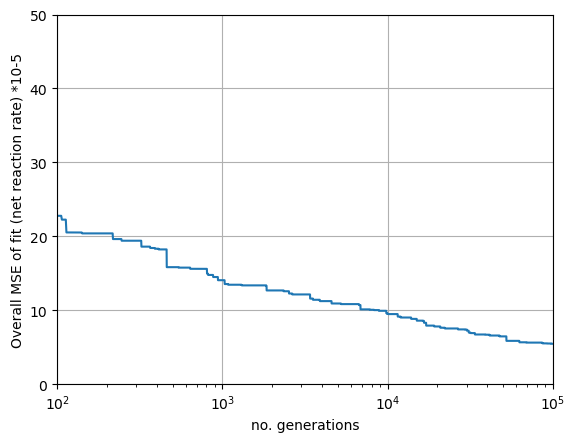

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-9.020009952028344
1.153448605028986
0.7135242078406712
-4.587949173709492
0.54227840709066
0.02819372557310342
0.4128605684298761
-6.630192750943605
0.5257303332458003
7.526087756712818
6.1422792151242405
6.391385605394018
0.38975394683661796
0.047963807257602714
3.750974755595698
0.22496882838485094
0.7648736579517669
-11.351350573274239
1.7977213197006203
2.036509305262226
-8.511371452153867
0.28703996256542863
6.998267533341217
1.0032846388472012
6.715497424175052
7.447084462040518
0.19822942523708706
10.194908137931382
-8.896275179783746
0.5107377586044108
10.003991556934734
11.512686127185912
-5.368034439666208
0.3710836296387532
10.960059487215073
-1.3010294360322545


In [37]:
res.X

array([ -9.02000995,   1.15344861,   0.71352421,  -4.58794917,
         0.54227841,   0.02819373,   0.41286057,  -6.63019275,
         0.52573033,   7.52608776,   6.14227922,   6.39138561,
         0.38975395,   0.04796381,   3.75097476,   0.22496883,
         0.76487366, -11.35135057,   1.79772132,   2.03650931,
        -8.51137145,   0.28703996,   6.99826753,   1.00328464,
         6.71549742,   7.44708446,   0.19822943,  10.19490814,
        -8.89627518,   0.51073776,  10.00399156,  11.51268613,
        -5.36803444,   0.37108363,  10.96005949,  -1.30102944])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -9.020009952028344
1.6: 1.153448605028986
0.9: 0.7135242078406712
-4.3: -4.587949173709492
0.5: 0.54227840709066
0.003: 0.02819372557310342
0.4: 0.4128605684298761
-7.9: -6.630192750943605
0.7: 0.5257303332458003
7.2: 7.526087756712818
5.7: 6.1422792151242405
5.7: 6.391385605394018
0.8: 0.38975394683661796
0.03: 0.047963807257602714
3.1: 3.750974755595698
6.000000000000001e-09: 0.22496882838485094
0.1: 0.7648736579517669
-12.0: -11.351350573274239
1.9: 1.7977213197006203
1.6: 2.036509305262226
-11.6: -8.511371452153867
1.2: 0.28703996256542863
4.0: 6.998267533341217
0.01: 1.0032846388472012
4.2: 6.715497424175052
5.4: 7.447084462040518
2.2: 0.19822942523708706
11.8: 10.194908137931382
-12.0: -8.896275179783746
3.3: 0.5107377586044108
1.8: 10.003991556934734
4.2: 11.512686127185912
-4.0: -5.368034439666208
0.5: 0.3710836296387532
1.0: 10.960059487215073
coeff fit: 0.7214331109476325
r: 0.849372186351562
